<a href="https://colab.research.google.com/github/CMallart/ateliers-NN/blob/main/Creation_de_paysages_par_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data from :
https://www.kaggle.com/arnaud58/landscape-pictures?select=00000001_%285%29.jpg

# Generative adversarial networks

Les réseaux de neurones peu profonds sont somme toute des versions un peu compliquées de classifieurs statistiques, utilisés le plus souvent pour classifier des objets (phrases, images, audio, videos...) en plusieurs catégories.Il faut leur créer des variables(features) à la main et éspérer que cela leur parle.

Mais les réseaux de neurones profonds, eux, permettent de faire quelque chose de beaucoup plus puissante : ils apprennent des représentations. Ils peuvent apprendre directement, sans création de features à la main, des représentations par matrices d'objets complexes, comme des images. Cela serait dommage de ne pas exploiter cela pour quelque chose de plus puissant, ou au moins de différent.

Entrent en jeu les réseaux génératifs. Ces réseaux profitent du fait qu'on peut apprendre à un réseau à créer une représentation abstraite, vectorielle, d'un objet. 


In [2]:
! git clone https://github.com/CMallart/ateliers-NN.git

fatal: destination path 'ateliers-NN' already exists and is not an empty directory.


In [19]:
! ls

ateliers-NN  drive  sample_data


In [4]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy.random import choice
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot

#Data

Found 4319 images belonging to 1 classes.
(256, 256, 3) [[[124. 149. 127.]
  [125. 150. 128.]
  [126. 151. 129.]
  ...
  [125. 153. 130.]
  [124. 152. 129.]
  [122. 150. 127.]]

 [[125. 150. 128.]
  [126. 151. 129.]
  [127. 152. 130.]
  ...
  [125. 153. 130.]
  [124. 152. 129.]
  [122. 150. 127.]]

 [[127. 152. 130.]
  [128. 153. 131.]
  [130. 155. 133.]
  ...
  [124. 152. 129.]
  [125. 153. 130.]
  [123. 151. 128.]]

 ...

 [[116. 130.  33.]
  [ 53.  67.   0.]
  [ 97. 110.  20.]
  ...
  [ 19.  23.   6.]
  [ 17.  21.   6.]
  [ 17.  20.  11.]]

 [[158. 170.  68.]
  [ 78.  90.   0.]
  [103. 115.  15.]
  ...
  [ 14.  17.   6.]
  [ 21.  24.  13.]
  [ 17.  21.   6.]]

 [[174. 187.  73.]
  [156. 169.  53.]
  [161. 174.  56.]
  ...
  [ 16.  20.   6.]
  [ 17.  21.   7.]
  [ 20.  25.   2.]]]


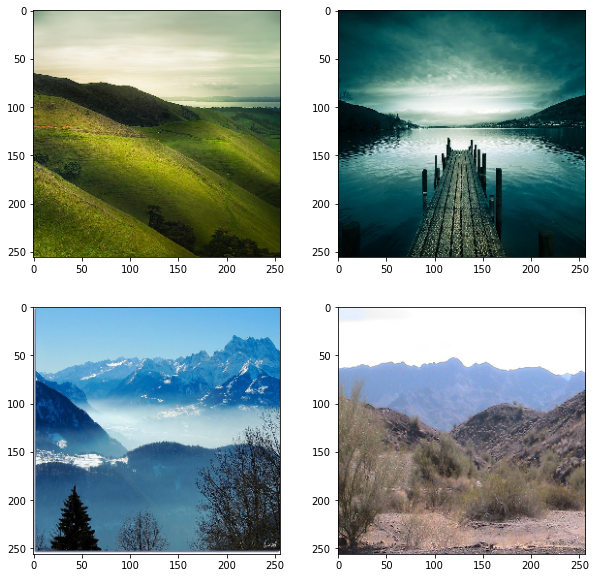

In [5]:
# load a generator for visualisation first
visual_generator = ImageDataGenerator(fill_mode="reflect",
                                     horizontal_flip=True)
visual_flow = visual_generator.flow_from_directory("/content/ateliers-NN/data/landscapes", class_mode=None, target_size=(256,256), batch_size=1, shuffle=False)


images= []
for i in range(0,4):
  images.append(visual_flow.next()[0])

print(images[0].shape, images[0])

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow((images[0]).astype('uint8'))

plt.subplot(222)
plt.imshow((images[1]).astype('uint8'))

plt.subplot(223)
plt.imshow((images[2]).astype('uint8'))

plt.subplot(224)
plt.imshow((images[3]).astype('uint8'))

plt.show()

In [7]:
train_generator = ImageDataGenerator(rescale=1/255,fill_mode="reflect")
train_flow = train_generator.flow_from_directory("/content/ateliers-NN/data/landscapes", class_mode=None, target_size=(128,128), batch_size=4319)

Found 4319 images belonging to 1 classes.


In [8]:
dataset_train = []
print("Starting")
temp_data = train_flow.next()
for i in range(temp_data.shape[0]):
  dataset_train.append(temp_data[i])
dataset = np.array(dataset_train)
print("Done")

Starting
Done


In [6]:
import tensorflow as tf
import numpy as np
import os

import distutils
if distutils.version.LooseVersion(tf.__version__) <= '2.0':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

#in mnist fashion, t-shirts are label 0
indices_t_shirts_train = np.where( y_train== 0)[0] #all elements of category 0
indices_t_shirts_test = np.where( y_test== 0)[0] #all elements of category 0

x_train_shirts = x_train[indices_t_shirts_train]
x_test_shirts = x_test[indices_t_shirts_test]

x = np.concatenate((x_train, x_test))

(70000, 28, 28, 1)


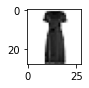

In [50]:
print(x.shape)
plt.figure(figsize=(1, 1))
plt.imshow(x[1].squeeze(), cmap="Greys")
plt.imshow(x[15].squeeze(), cmap="Greys")
plt.imshow(x[45].squeeze(), cmap="Greys")
plt.imshow(x[50].squeeze(), cmap="Greys")

#Model

In [51]:
def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0004, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [52]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 8x8 image
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
	return model

In [7]:
def define_discriminator_mnist(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)

	model = Sequential()

	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape)) #strides = (2,2) reduces the image to half
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
 
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
 
	model.add(Conv2D(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))

	#model.add(Conv2D(1024, (5,5), strides=(2,2), padding='same', kernel_initializer=init))
	#model.add(LeakyReLU(alpha=0.2))
	#model.add(Dropout(0.4))

	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0004, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [8]:
# define the standalone generator model
def define_generator_mnist(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 256)))
	model.add(Dropout(0.4))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
 	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
 
	model.add(Conv2DTranspose(32, (5,5), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
 
	model.add(Conv2DTranspose(16, (5,5), padding='same'))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
 
	# output layer
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

In [9]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0001, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [10]:
#hacky way to try and avoid convergence failure, as pointed out by Soumith Chintala in his NIPS presentation
#sometimes, confuse real and fake samples by adding noisy labels.
def noisy_labels(y, p_flip):
	# determine the number of labels to flip
	n_select = int(p_flip * y.shape[0])
	# choose labels to flip
	flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
	# invert the labels in place
	y[flip_ix] = 1 - y[flip_ix]
	return y

# to train the discriminator, we need a mix of real and fake images

def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	#y = y-0.1
	y = noisy_labels(y, 0.05)
	return X, y

# use the generator to generate n fake examples, with class labels 0
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	#y = y+0.1
	y = noisy_labels(y, 0.05)
	return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [11]:
from google.colab import files
import os

folder_saves = "/content/drive/My Drive/Colab_Notebooks/plots_gan/"
if not os.path.exists(folder_saves):
    os.makedirs(folder_saves)

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	plt.figure(figsize=(40, 40))
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i].squeeze(), cmap="Greys") #remove the .squeeze if not mnist
	# save plot to file
	filename = folder_saves+'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.plot()
	#files.download(filename) 

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = folder_saves+'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)
	#files.download(filename)

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
	bat_per_epo = int(4335 / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			#y_gan = y_gan -0.1	 
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			if (j+1)%10 == 0 :
				print('>Epoch :%d, Batch : %d/%d, discrim_real_loss=%.3f, discrim_fake_loss=%.3f gan_loss=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim, n_samples=256)

In [13]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator_mnist()
# create the generator
g_model = define_generator_mnist(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

>Epoch :1, Batch : 10/67, discrim_real_loss=0.292, discrim_fake_loss=0.169 gan_loss=3.677
>Epoch :1, Batch : 20/67, discrim_real_loss=0.515, discrim_fake_loss=0.170 gan_loss=3.533
>Epoch :1, Batch : 30/67, discrim_real_loss=0.434, discrim_fake_loss=0.134 gan_loss=3.350
>Epoch :1, Batch : 40/67, discrim_real_loss=0.358, discrim_fake_loss=0.136 gan_loss=3.492
>Epoch :1, Batch : 50/67, discrim_real_loss=0.421, discrim_fake_loss=0.173 gan_loss=3.507
>Epoch :1, Batch : 60/67, discrim_real_loss=0.435, discrim_fake_loss=0.167 gan_loss=3.682
>Epoch :2, Batch : 10/67, discrim_real_loss=0.359, discrim_fake_loss=0.148 gan_loss=3.256
>Epoch :2, Batch : 20/67, discrim_real_loss=0.241, discrim_fake_loss=0.151 gan_loss=3.665
>Epoch :2, Batch : 30/67, discrim_real_loss=0.091, discrim_fake_loss=0.141 gan_loss=3.696
>Epoch :2, Batch : 40/67, discrim_real_loss=0.157, discrim_fake_loss=0.130 gan_loss=3.845
>Epoch :2, Batch : 50/67, discrim_real_loss=0.426, discrim_fake_loss=0.156 gan_loss=3.582
>Epoch :2,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


>Epoch :211, Batch : 10/67, discrim_real_loss=0.542, discrim_fake_loss=0.128 gan_loss=3.815
>Epoch :211, Batch : 20/67, discrim_real_loss=0.650, discrim_fake_loss=0.125 gan_loss=4.168
>Epoch :211, Batch : 30/67, discrim_real_loss=0.199, discrim_fake_loss=0.174 gan_loss=3.796
>Epoch :211, Batch : 40/67, discrim_real_loss=0.583, discrim_fake_loss=0.148 gan_loss=3.079
>Epoch :211, Batch : 50/67, discrim_real_loss=0.215, discrim_fake_loss=0.192 gan_loss=3.218
>Epoch :211, Batch : 60/67, discrim_real_loss=0.385, discrim_fake_loss=0.177 gan_loss=3.395
>Epoch :212, Batch : 10/67, discrim_real_loss=0.231, discrim_fake_loss=0.164 gan_loss=3.690
>Epoch :212, Batch : 20/67, discrim_real_loss=0.268, discrim_fake_loss=0.091 gan_loss=3.776
>Epoch :212, Batch : 30/67, discrim_real_loss=0.367, discrim_fake_loss=0.126 gan_loss=3.262
>Epoch :212, Batch : 40/67, discrim_real_loss=0.464, discrim_fake_loss=0.148 gan_loss=3.741
>Epoch :212, Batch : 50/67, discrim_real_loss=0.605, discrim_fake_loss=0.105 gan

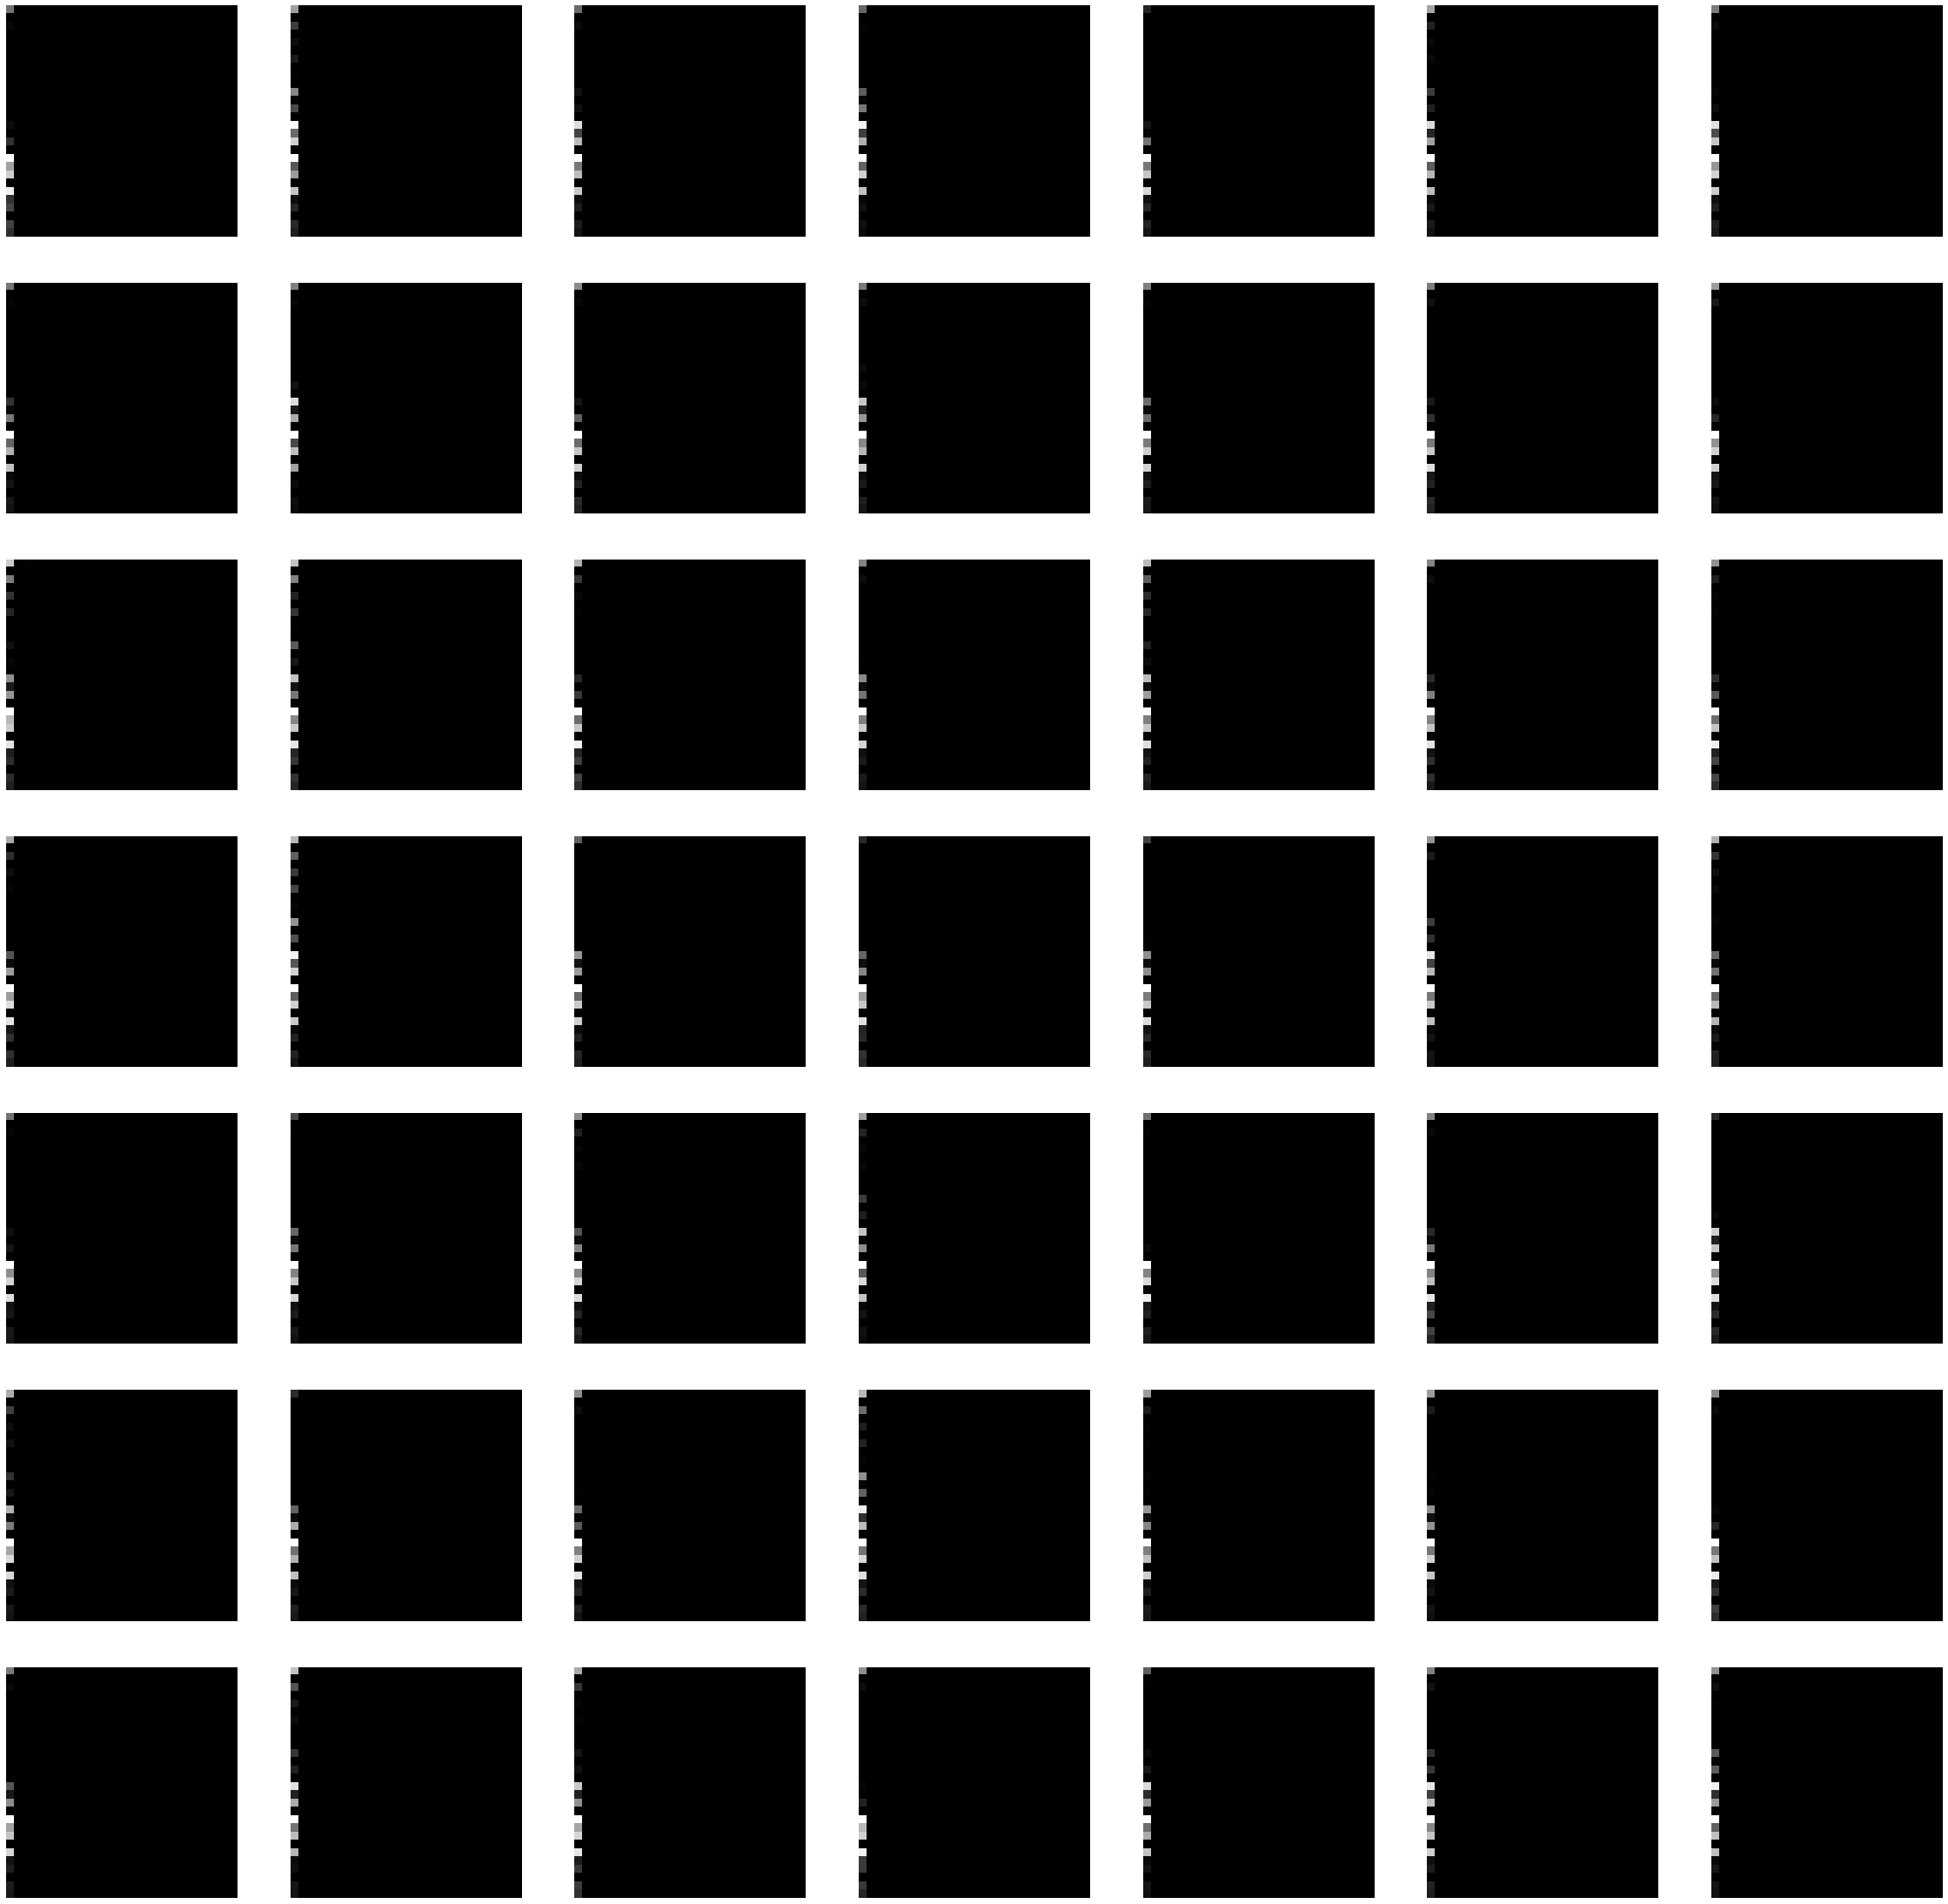

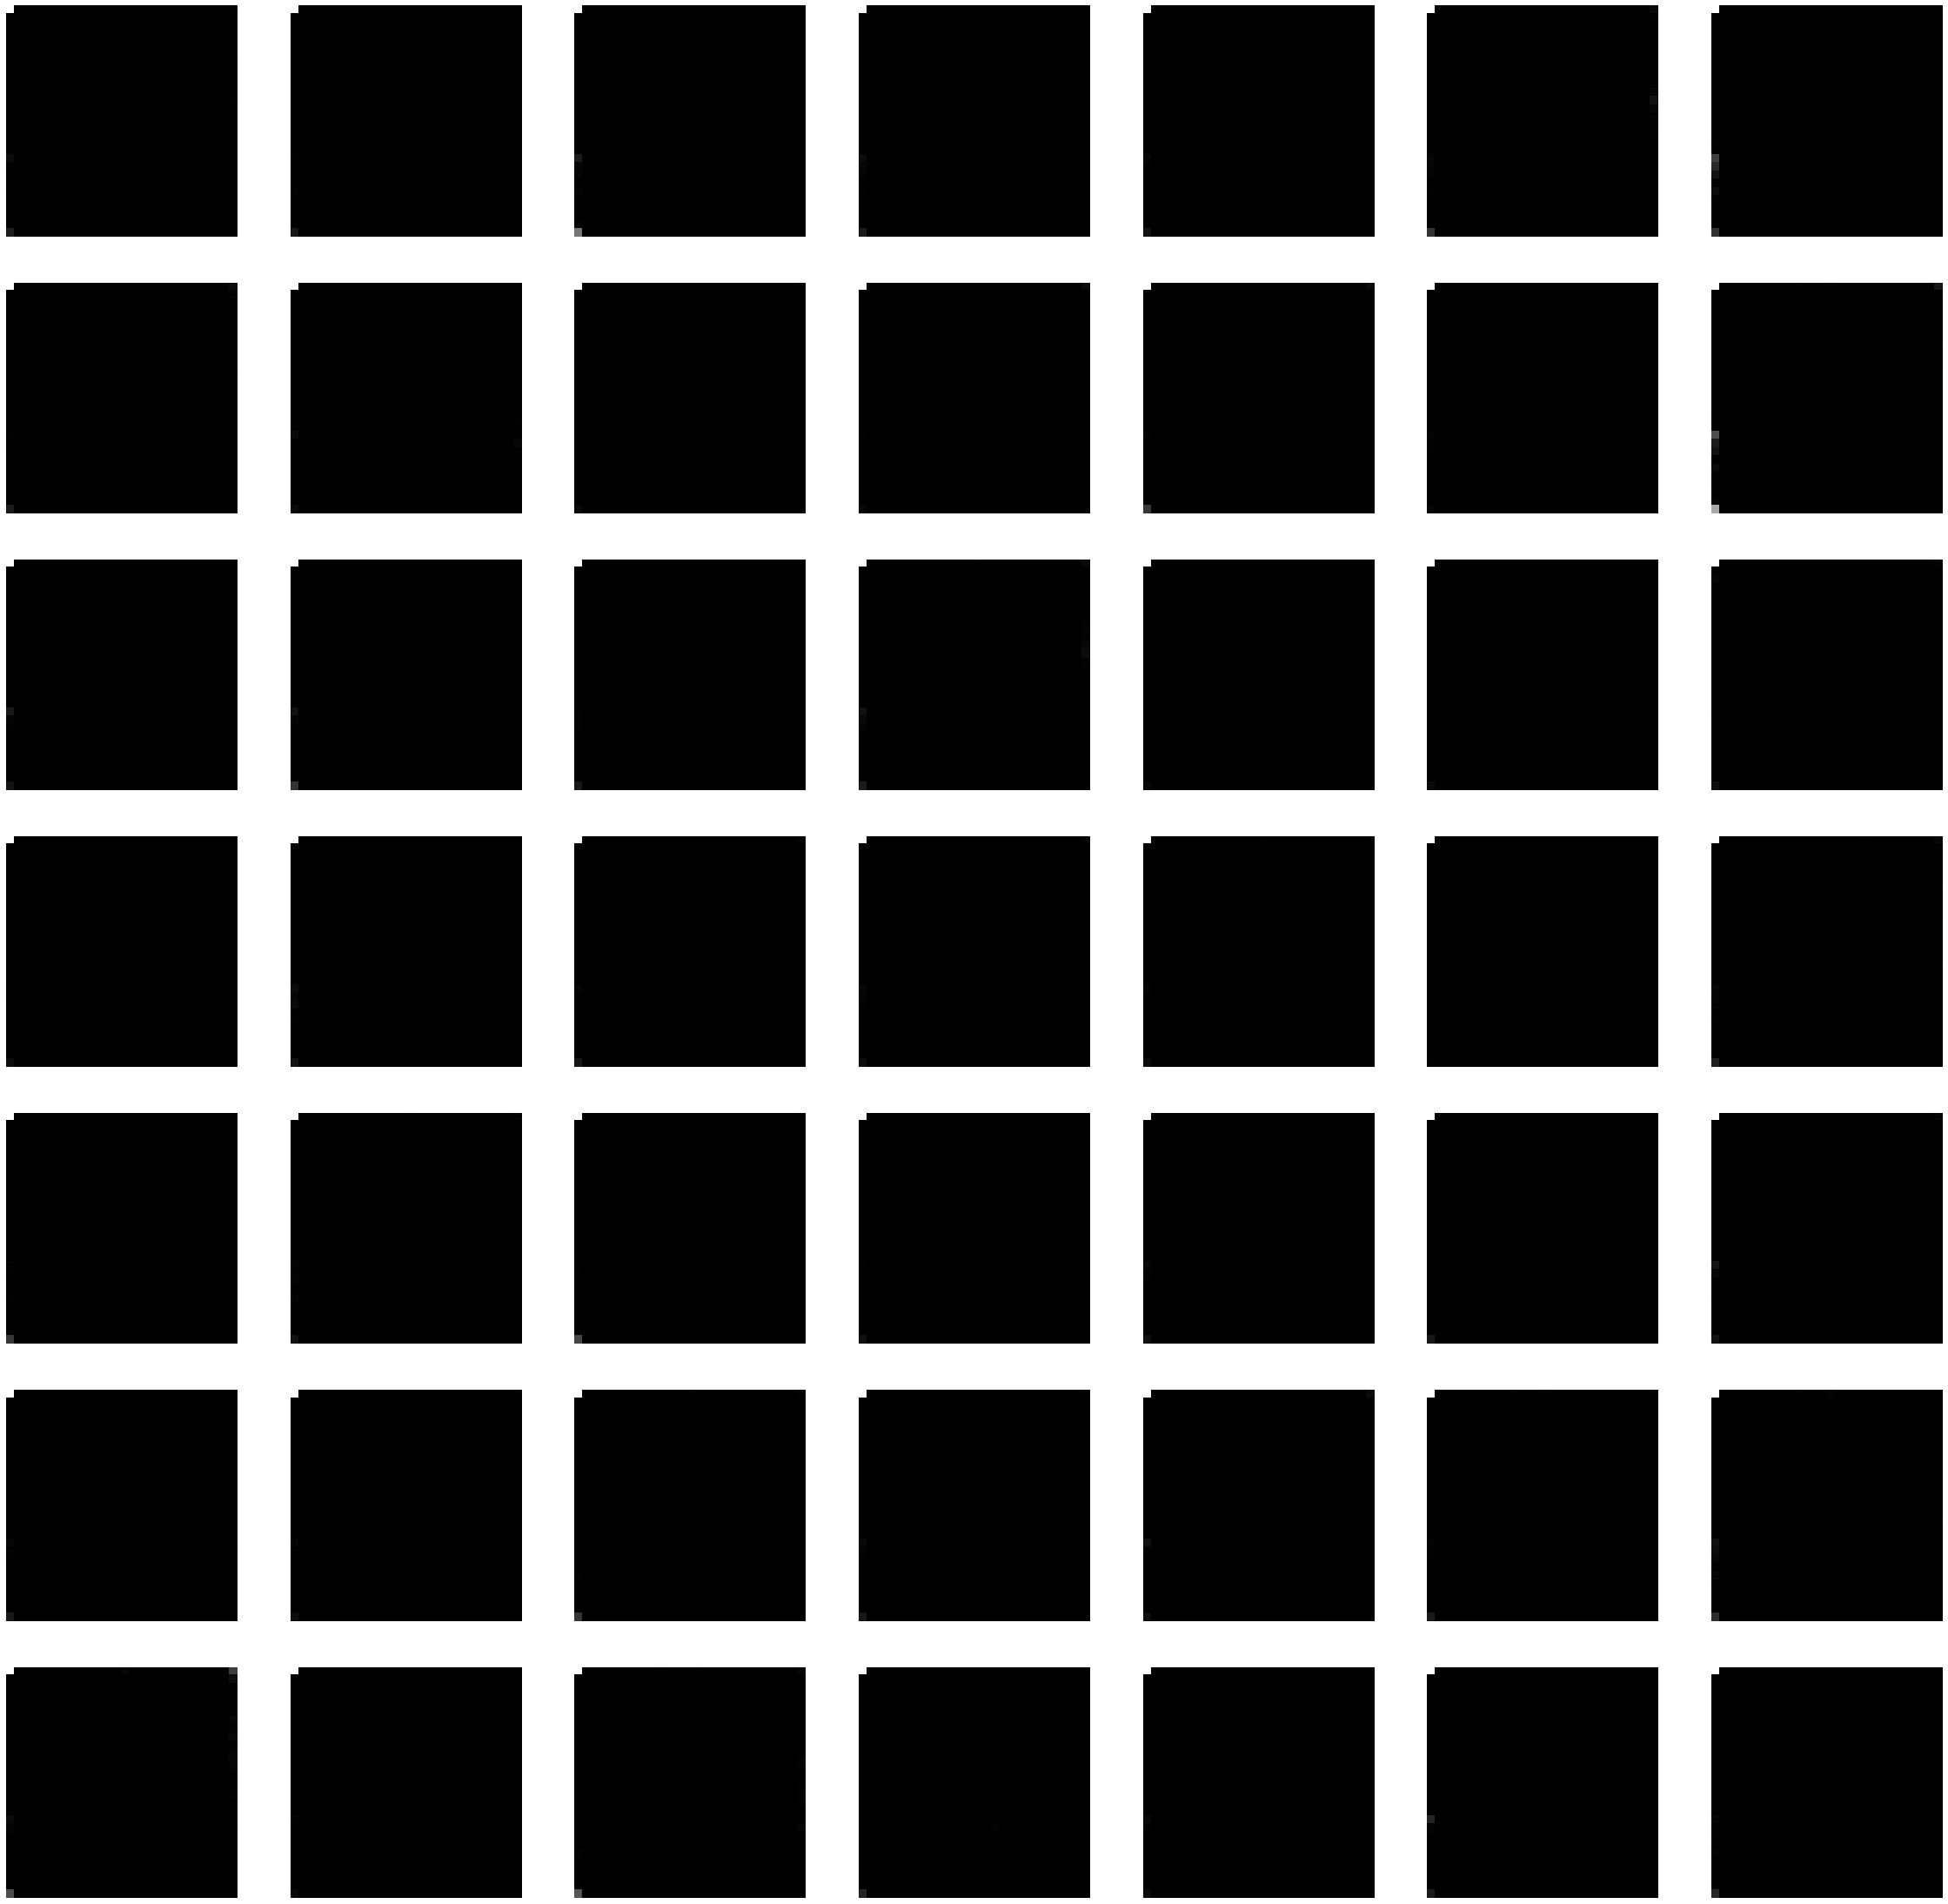

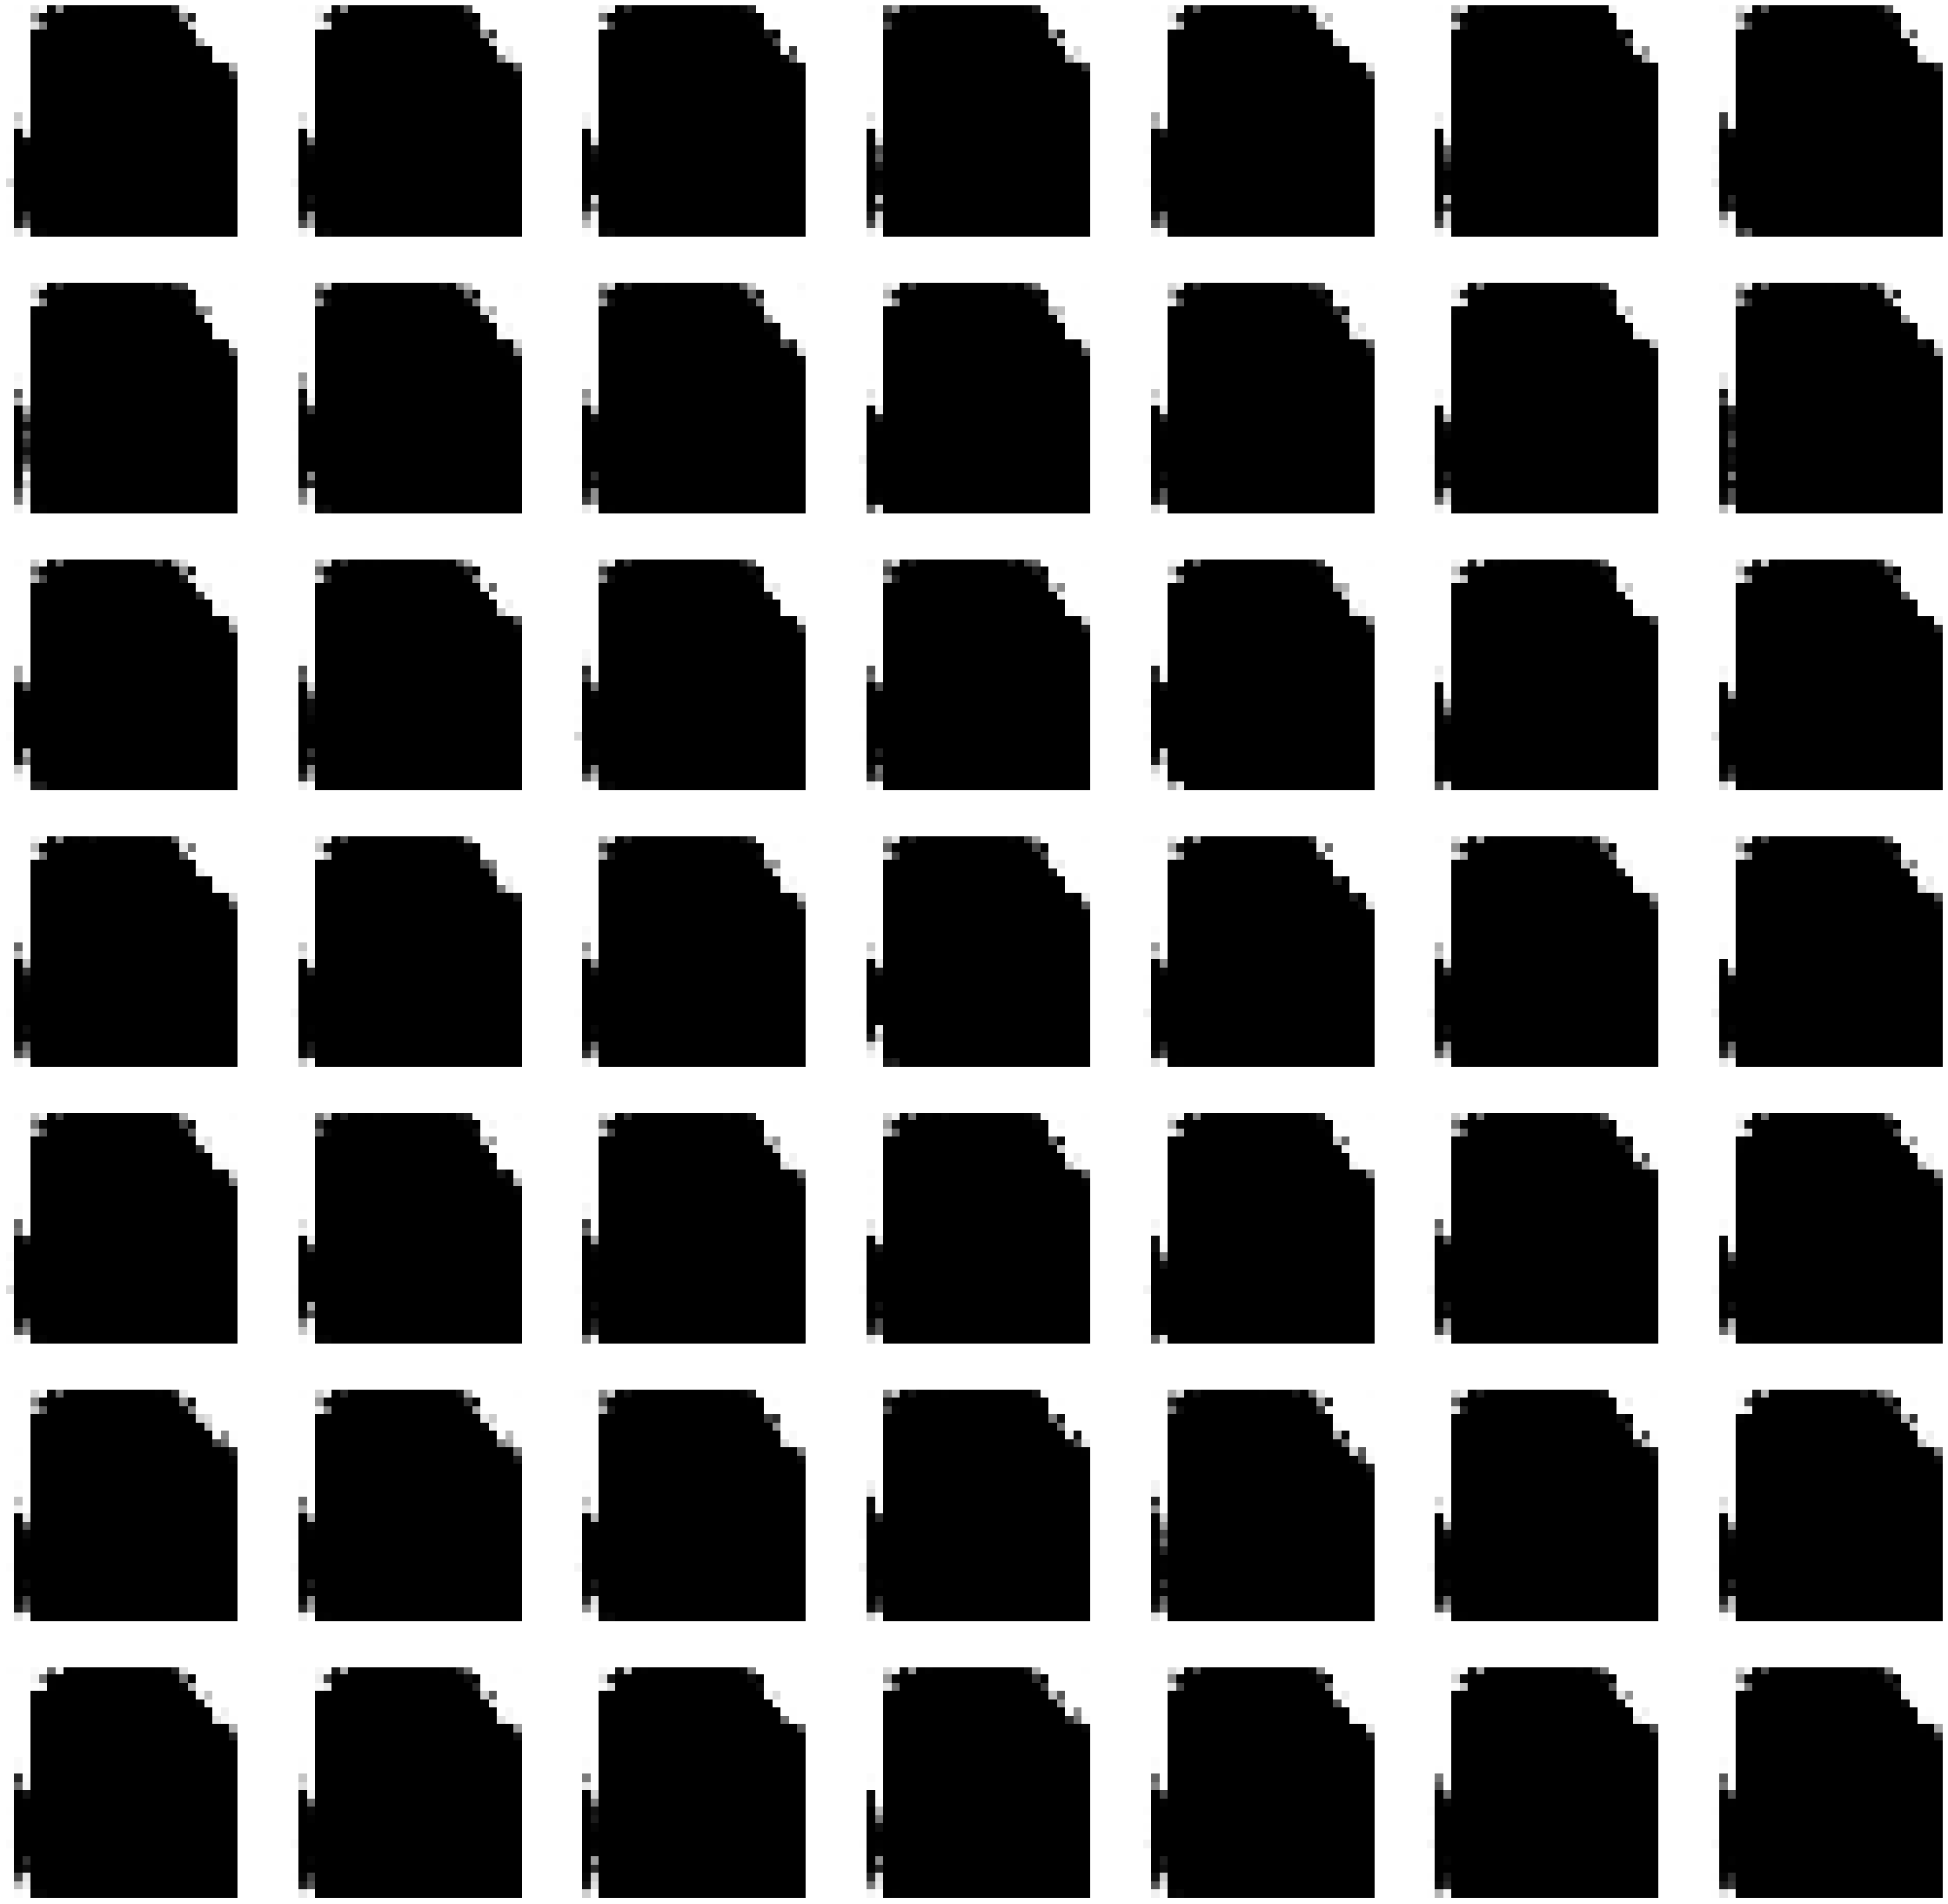

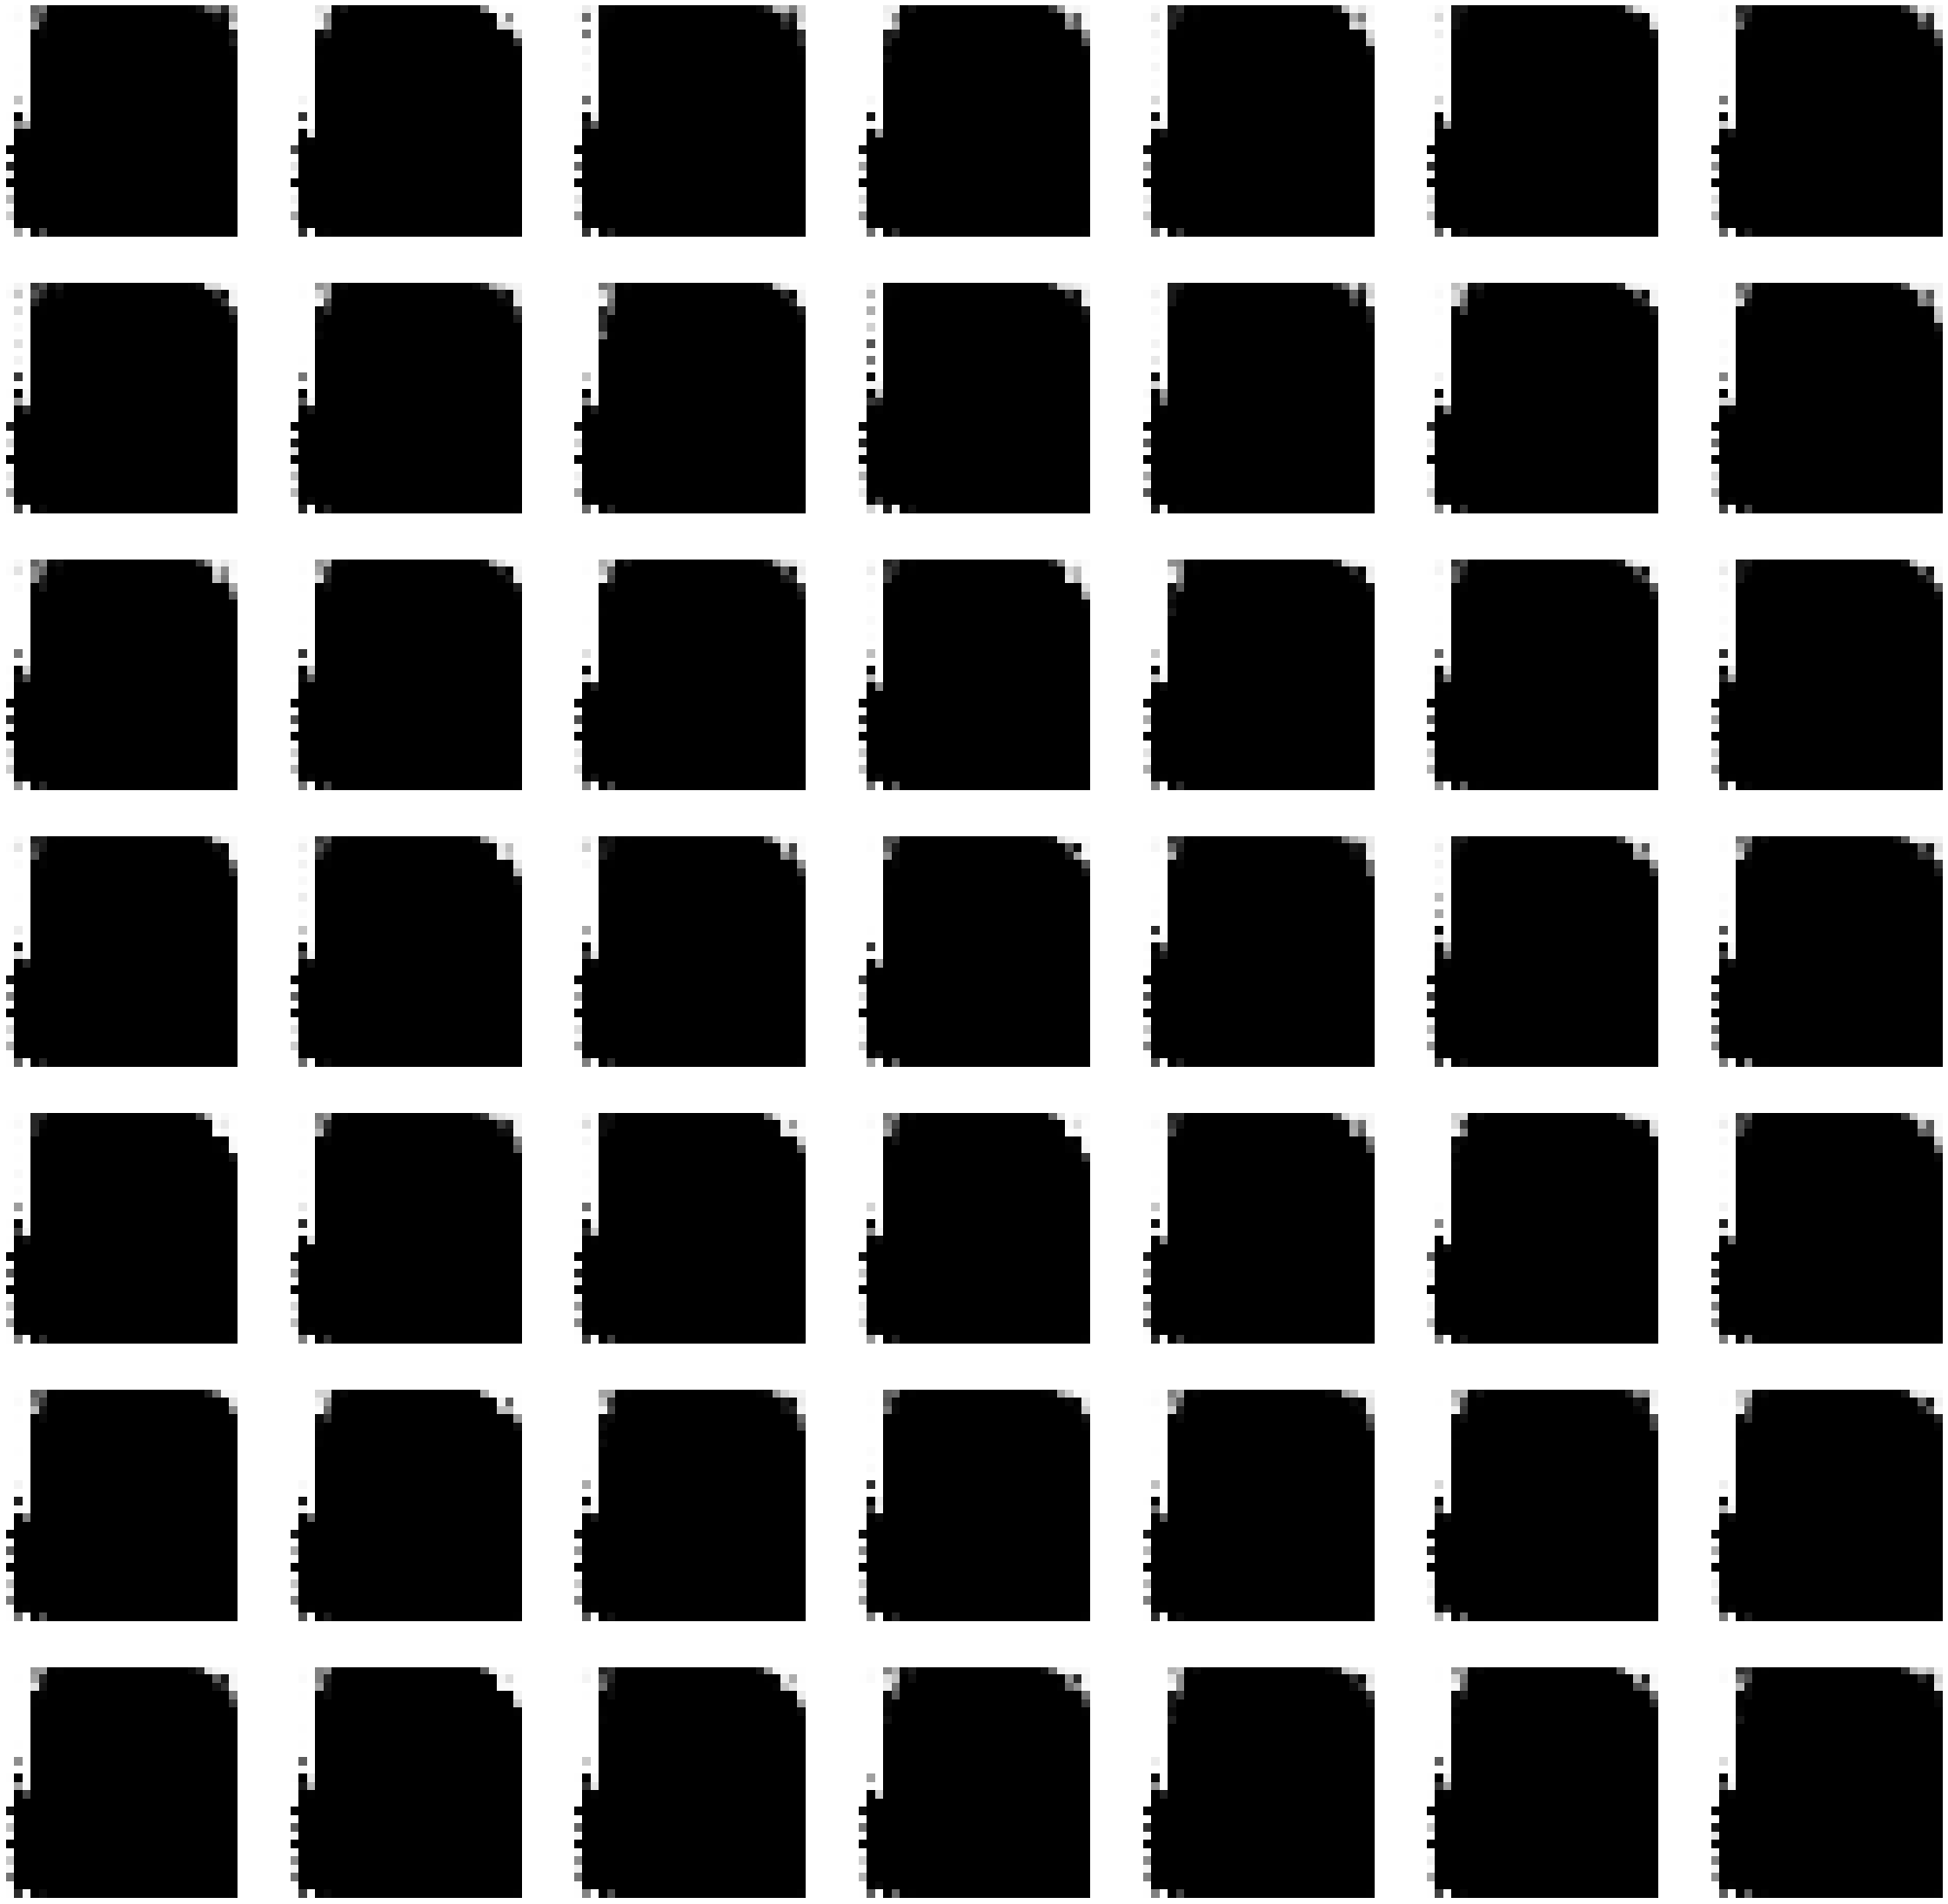

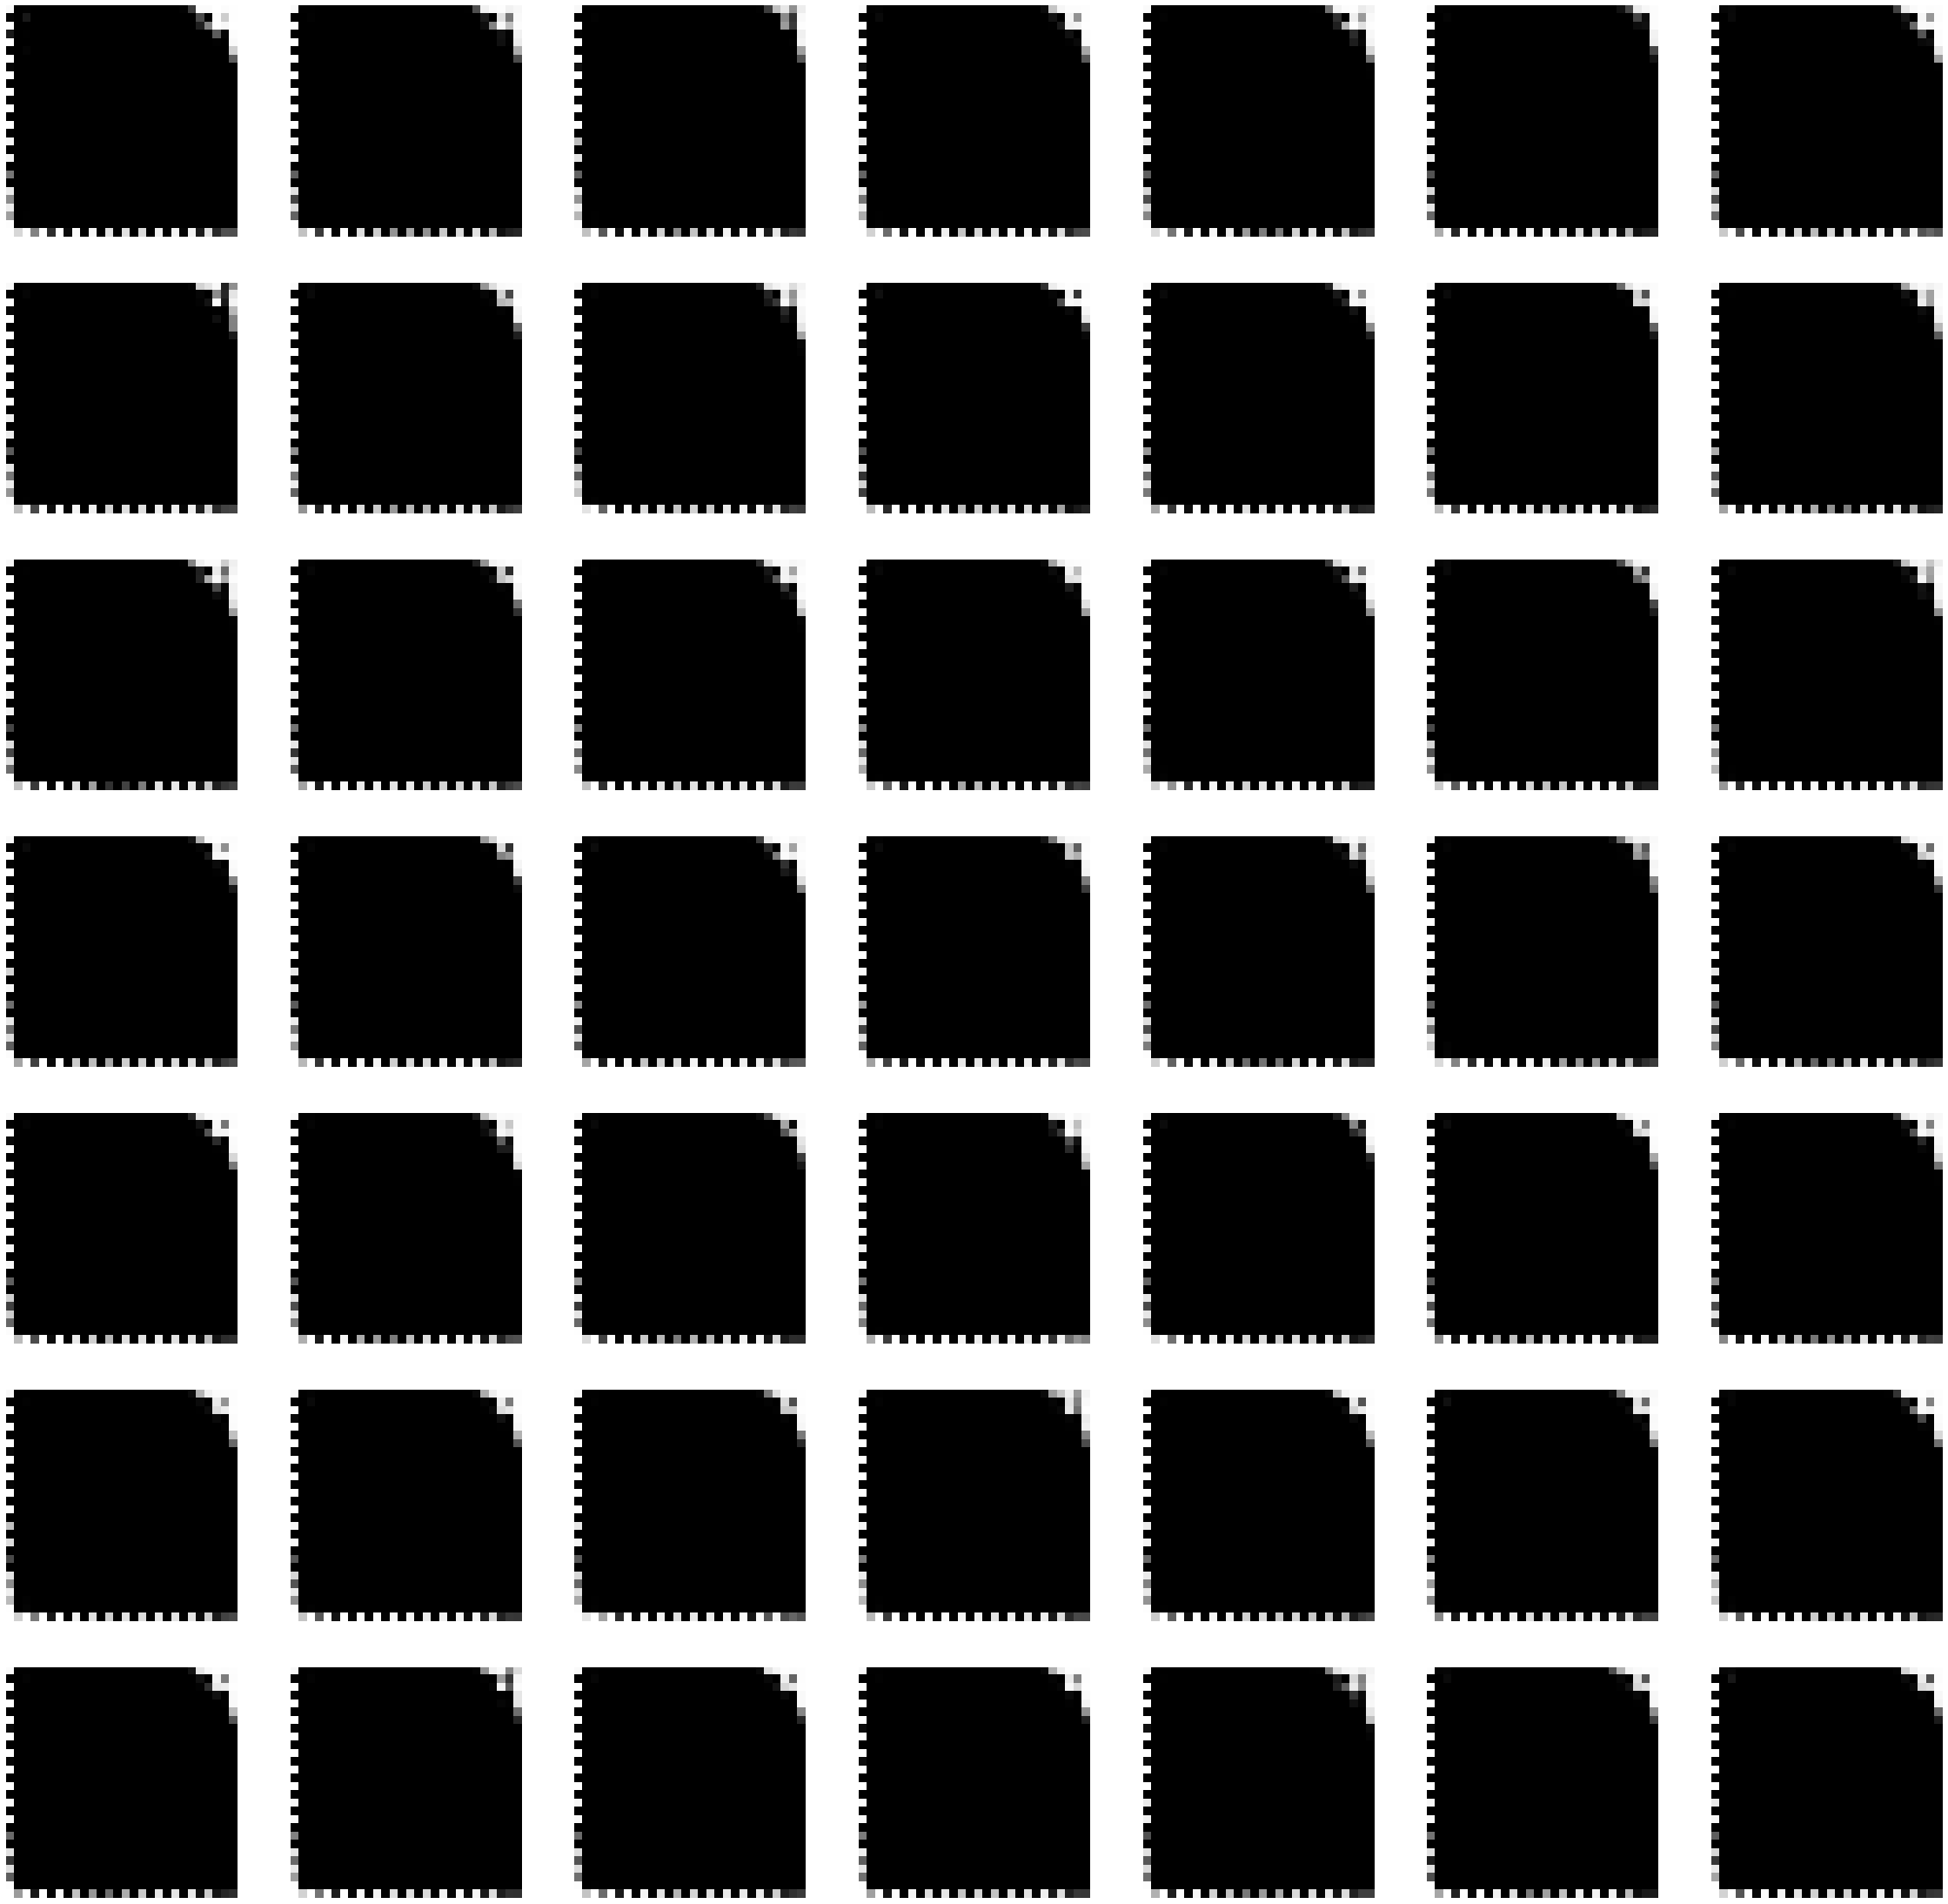

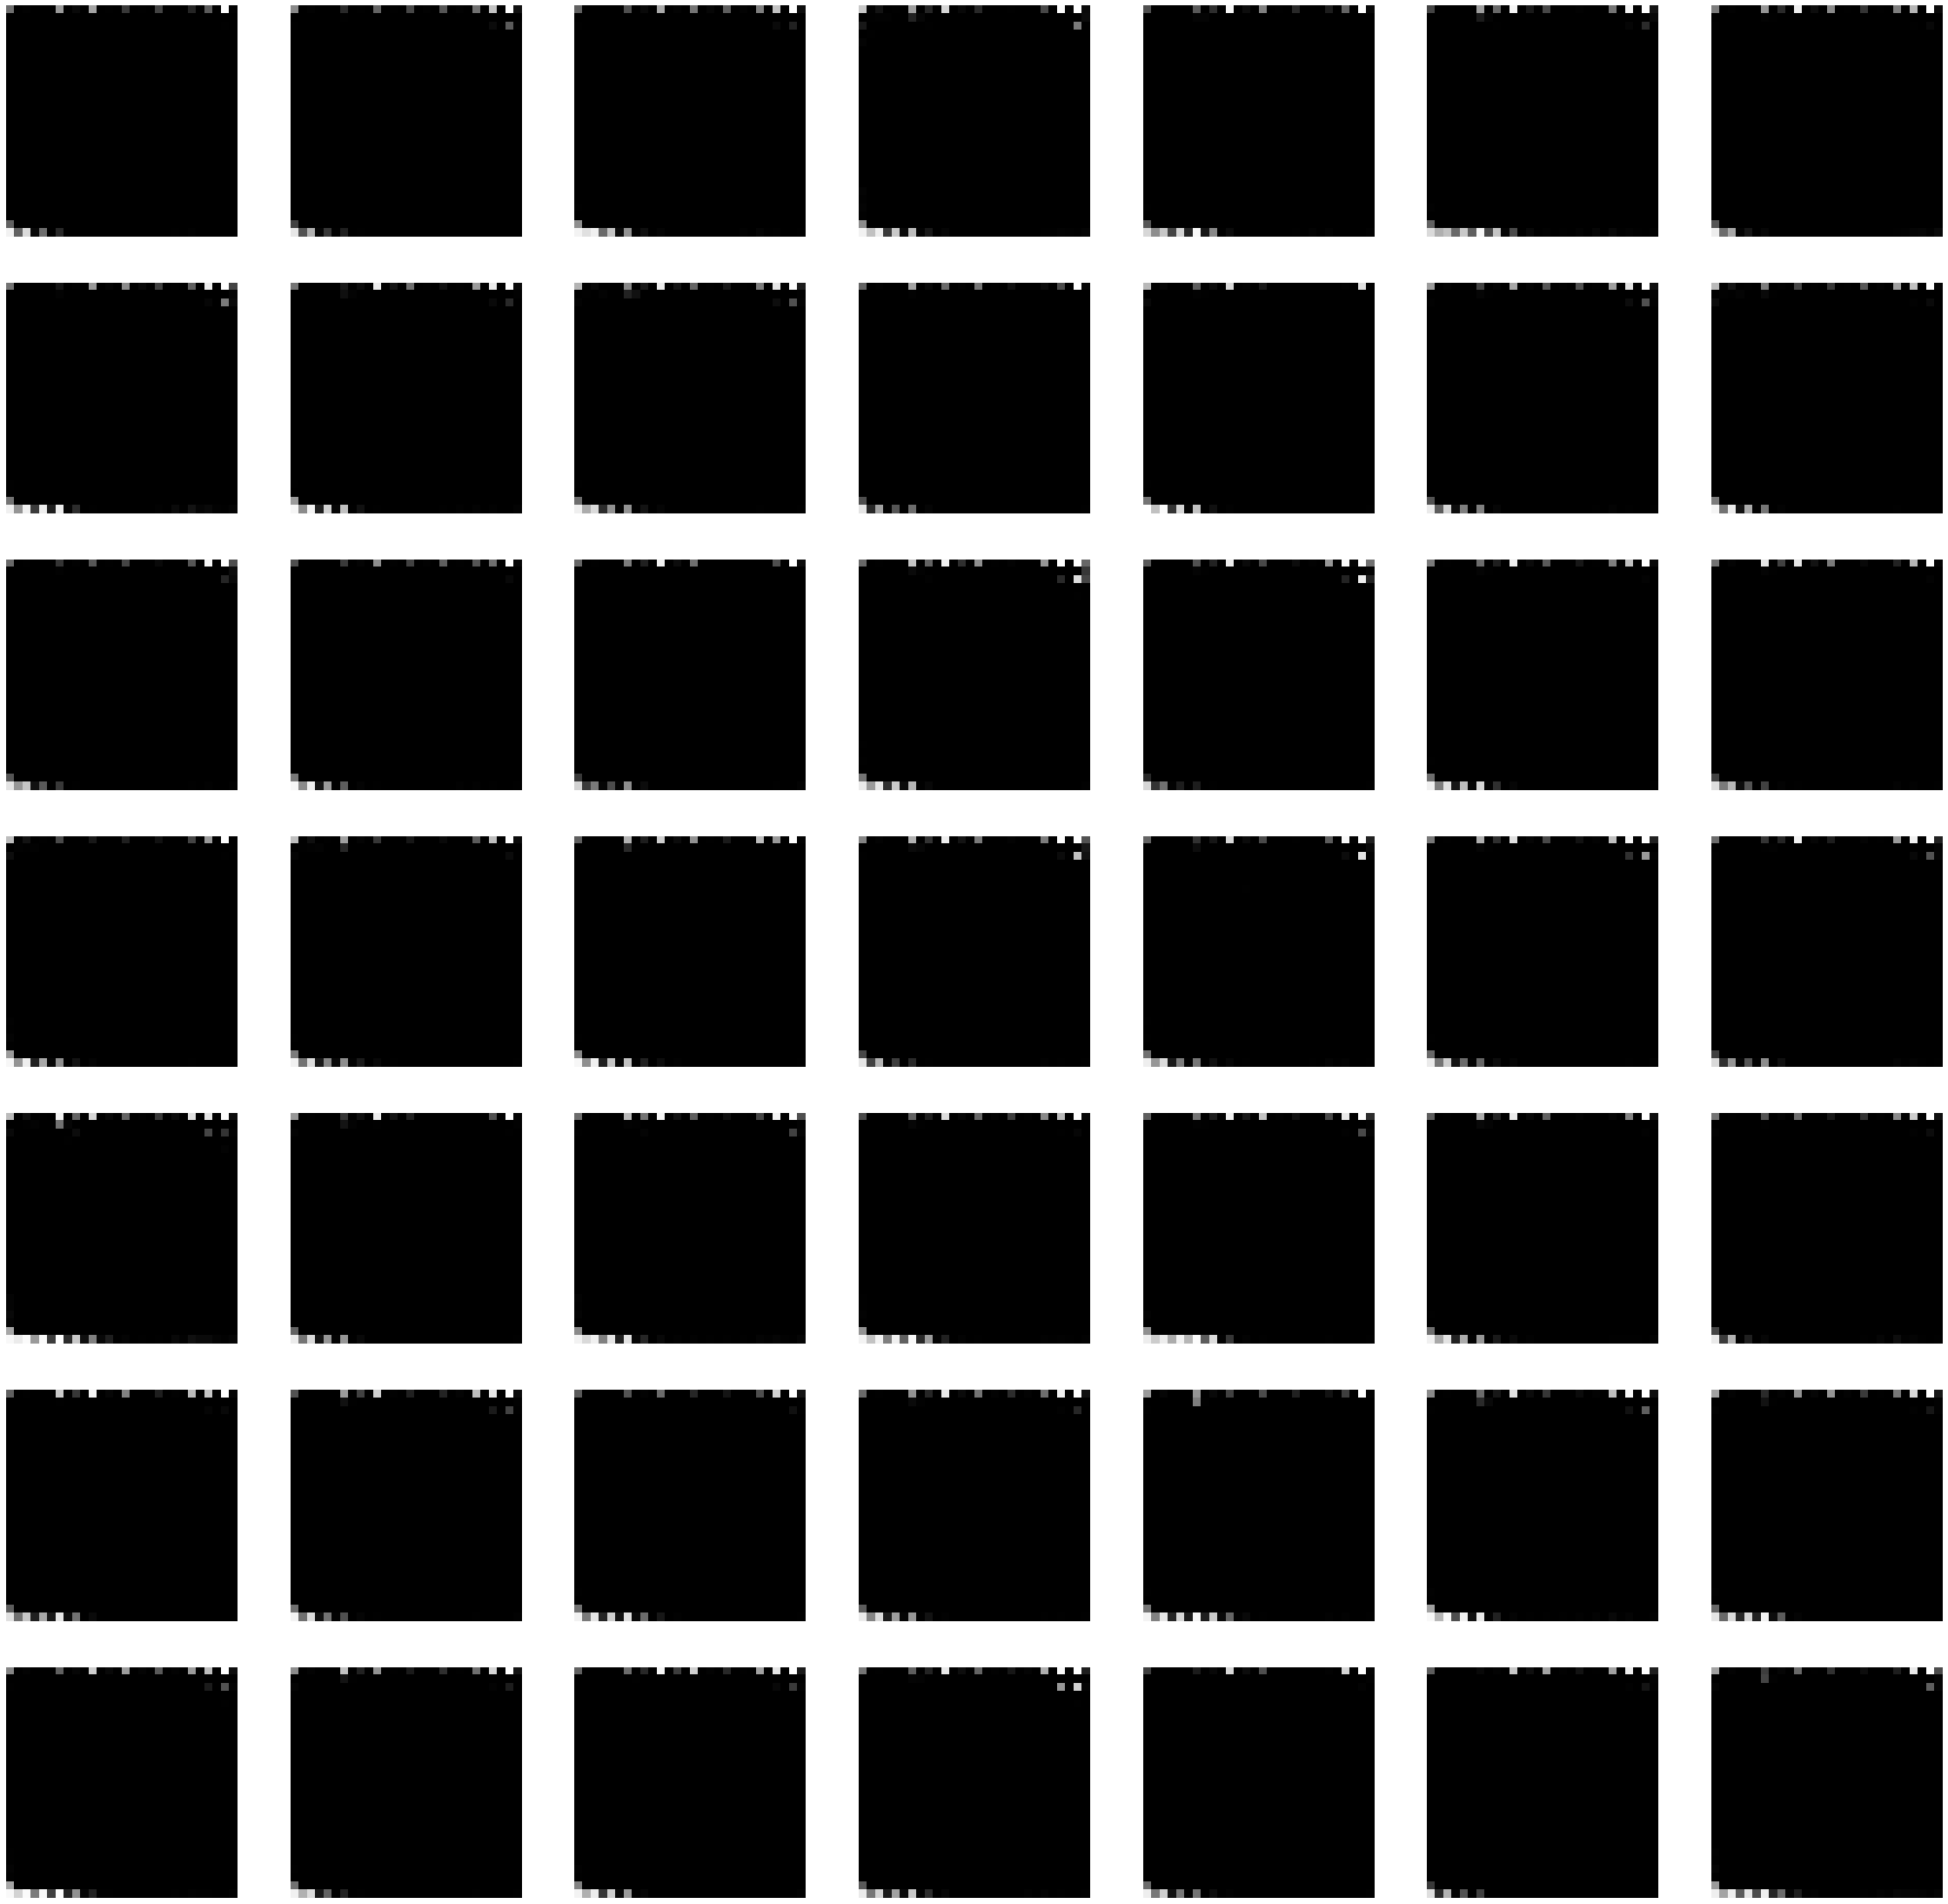

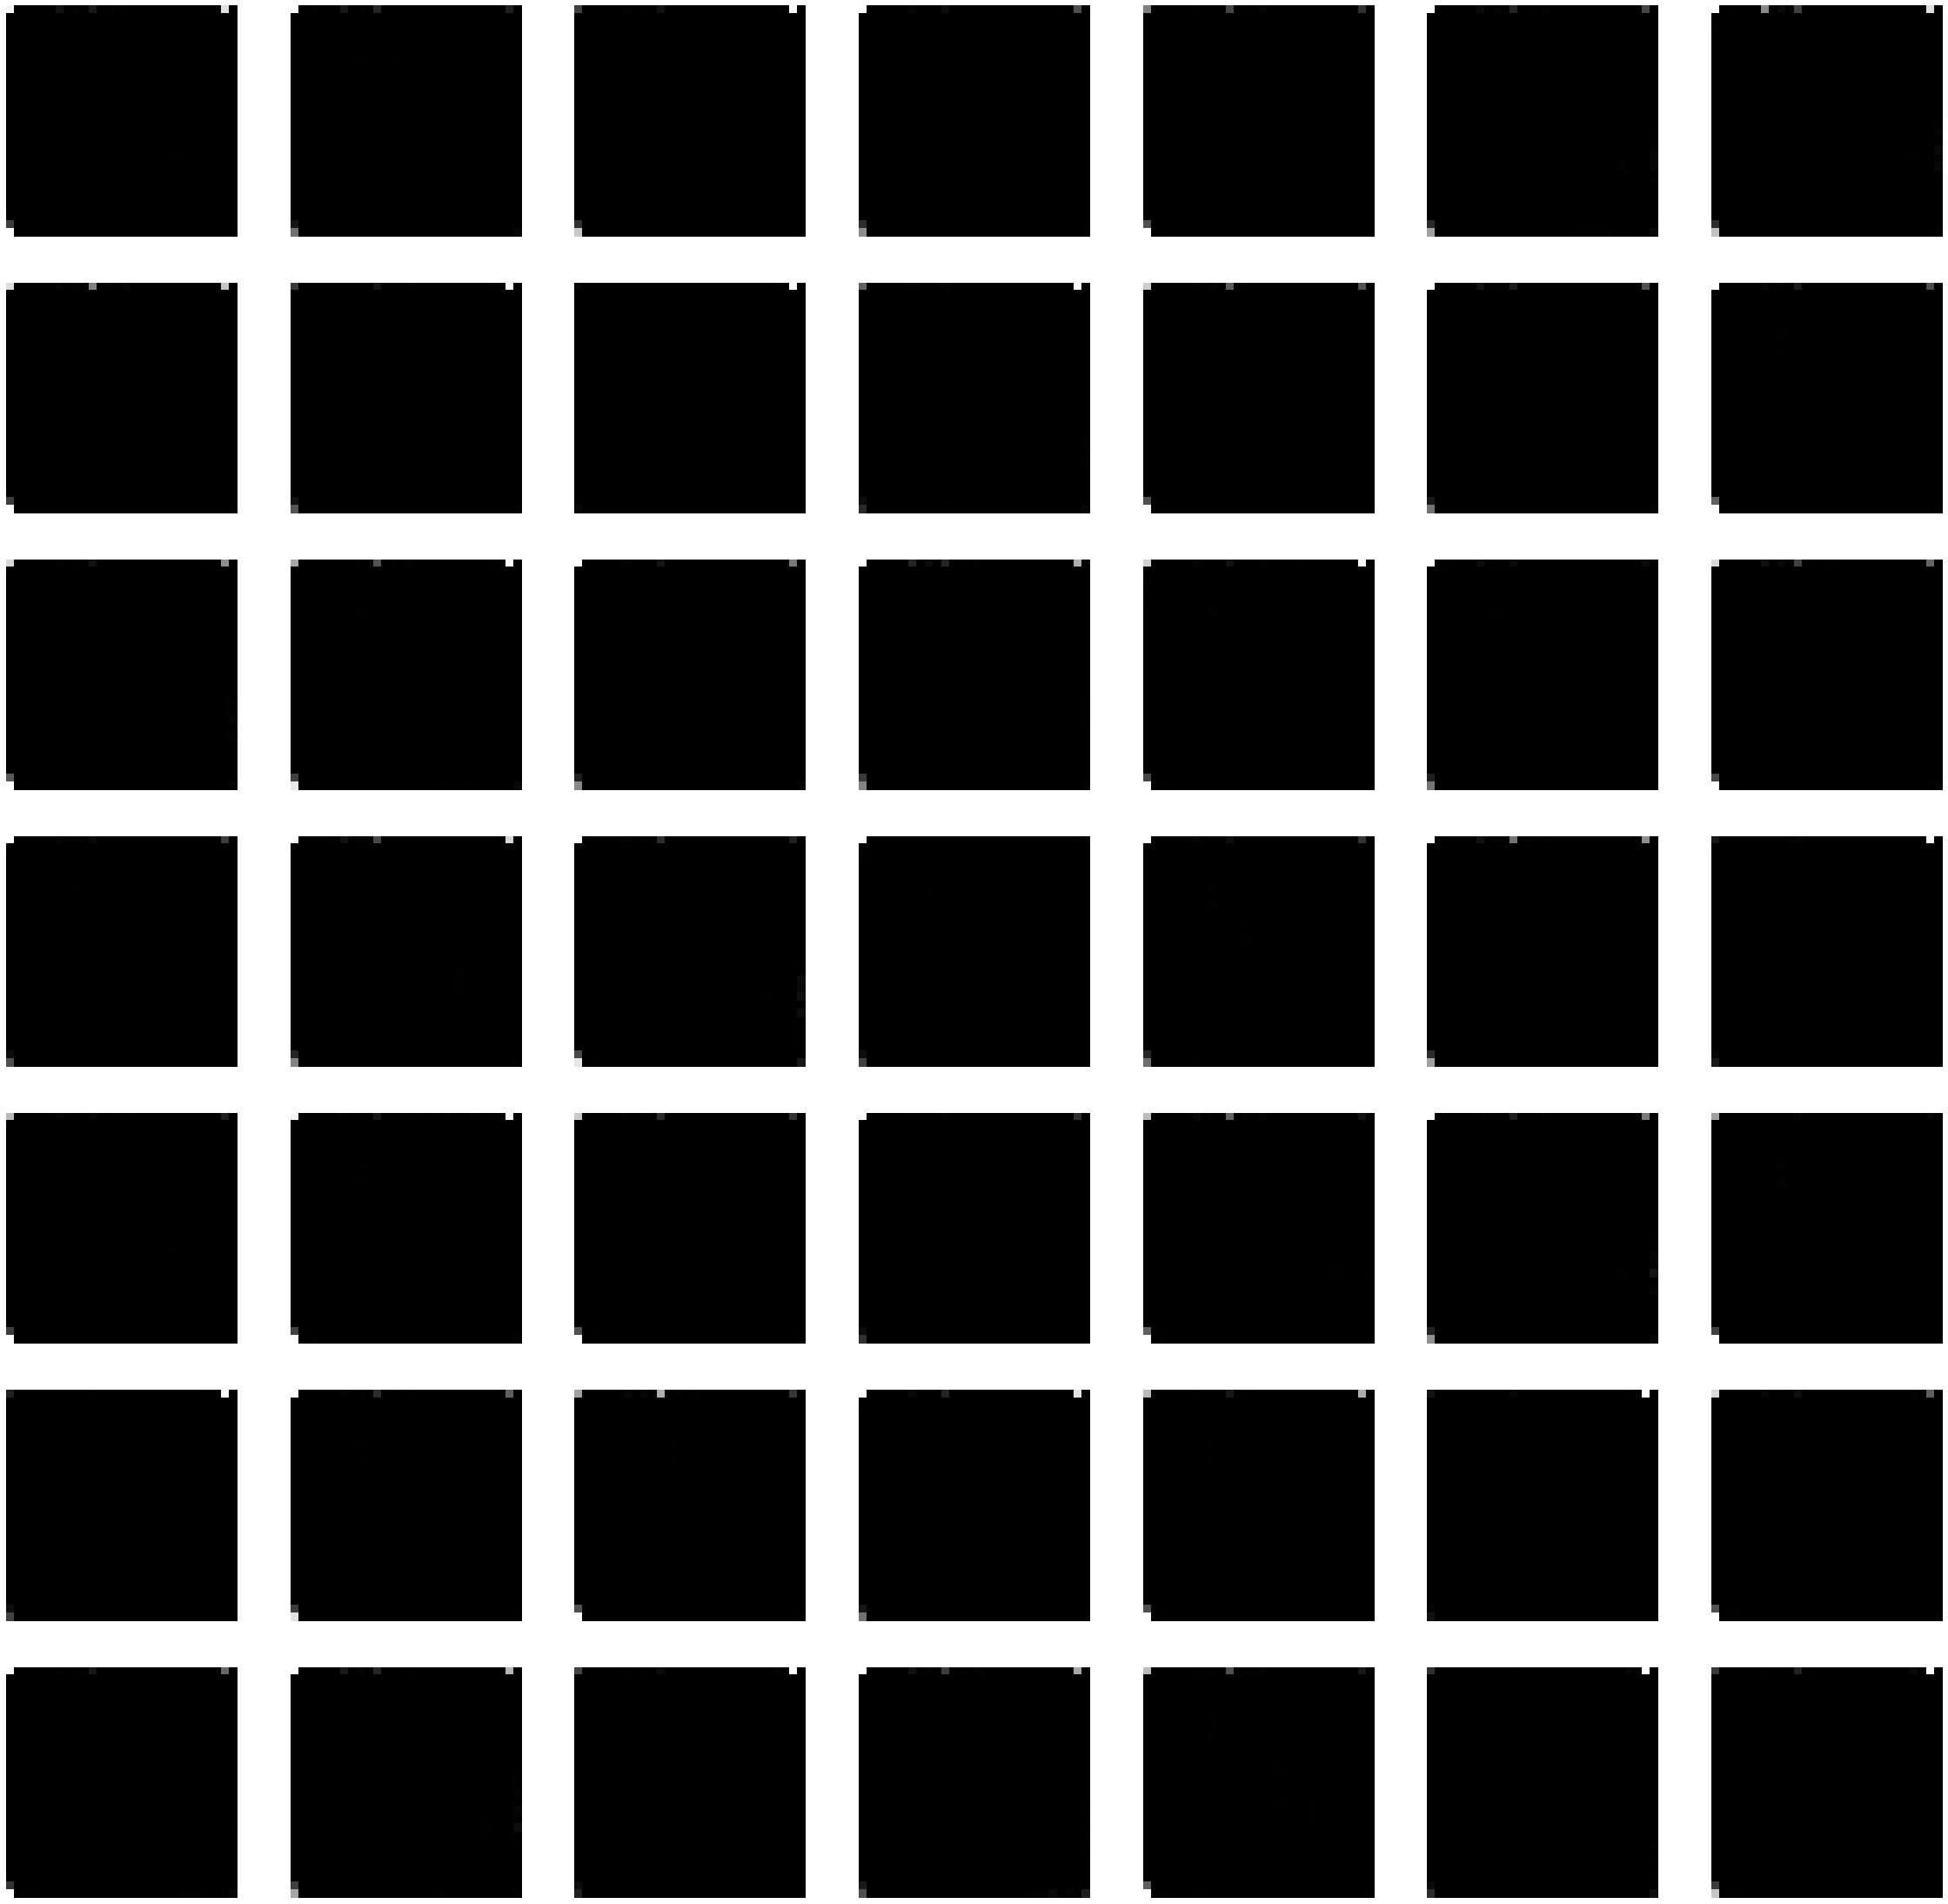

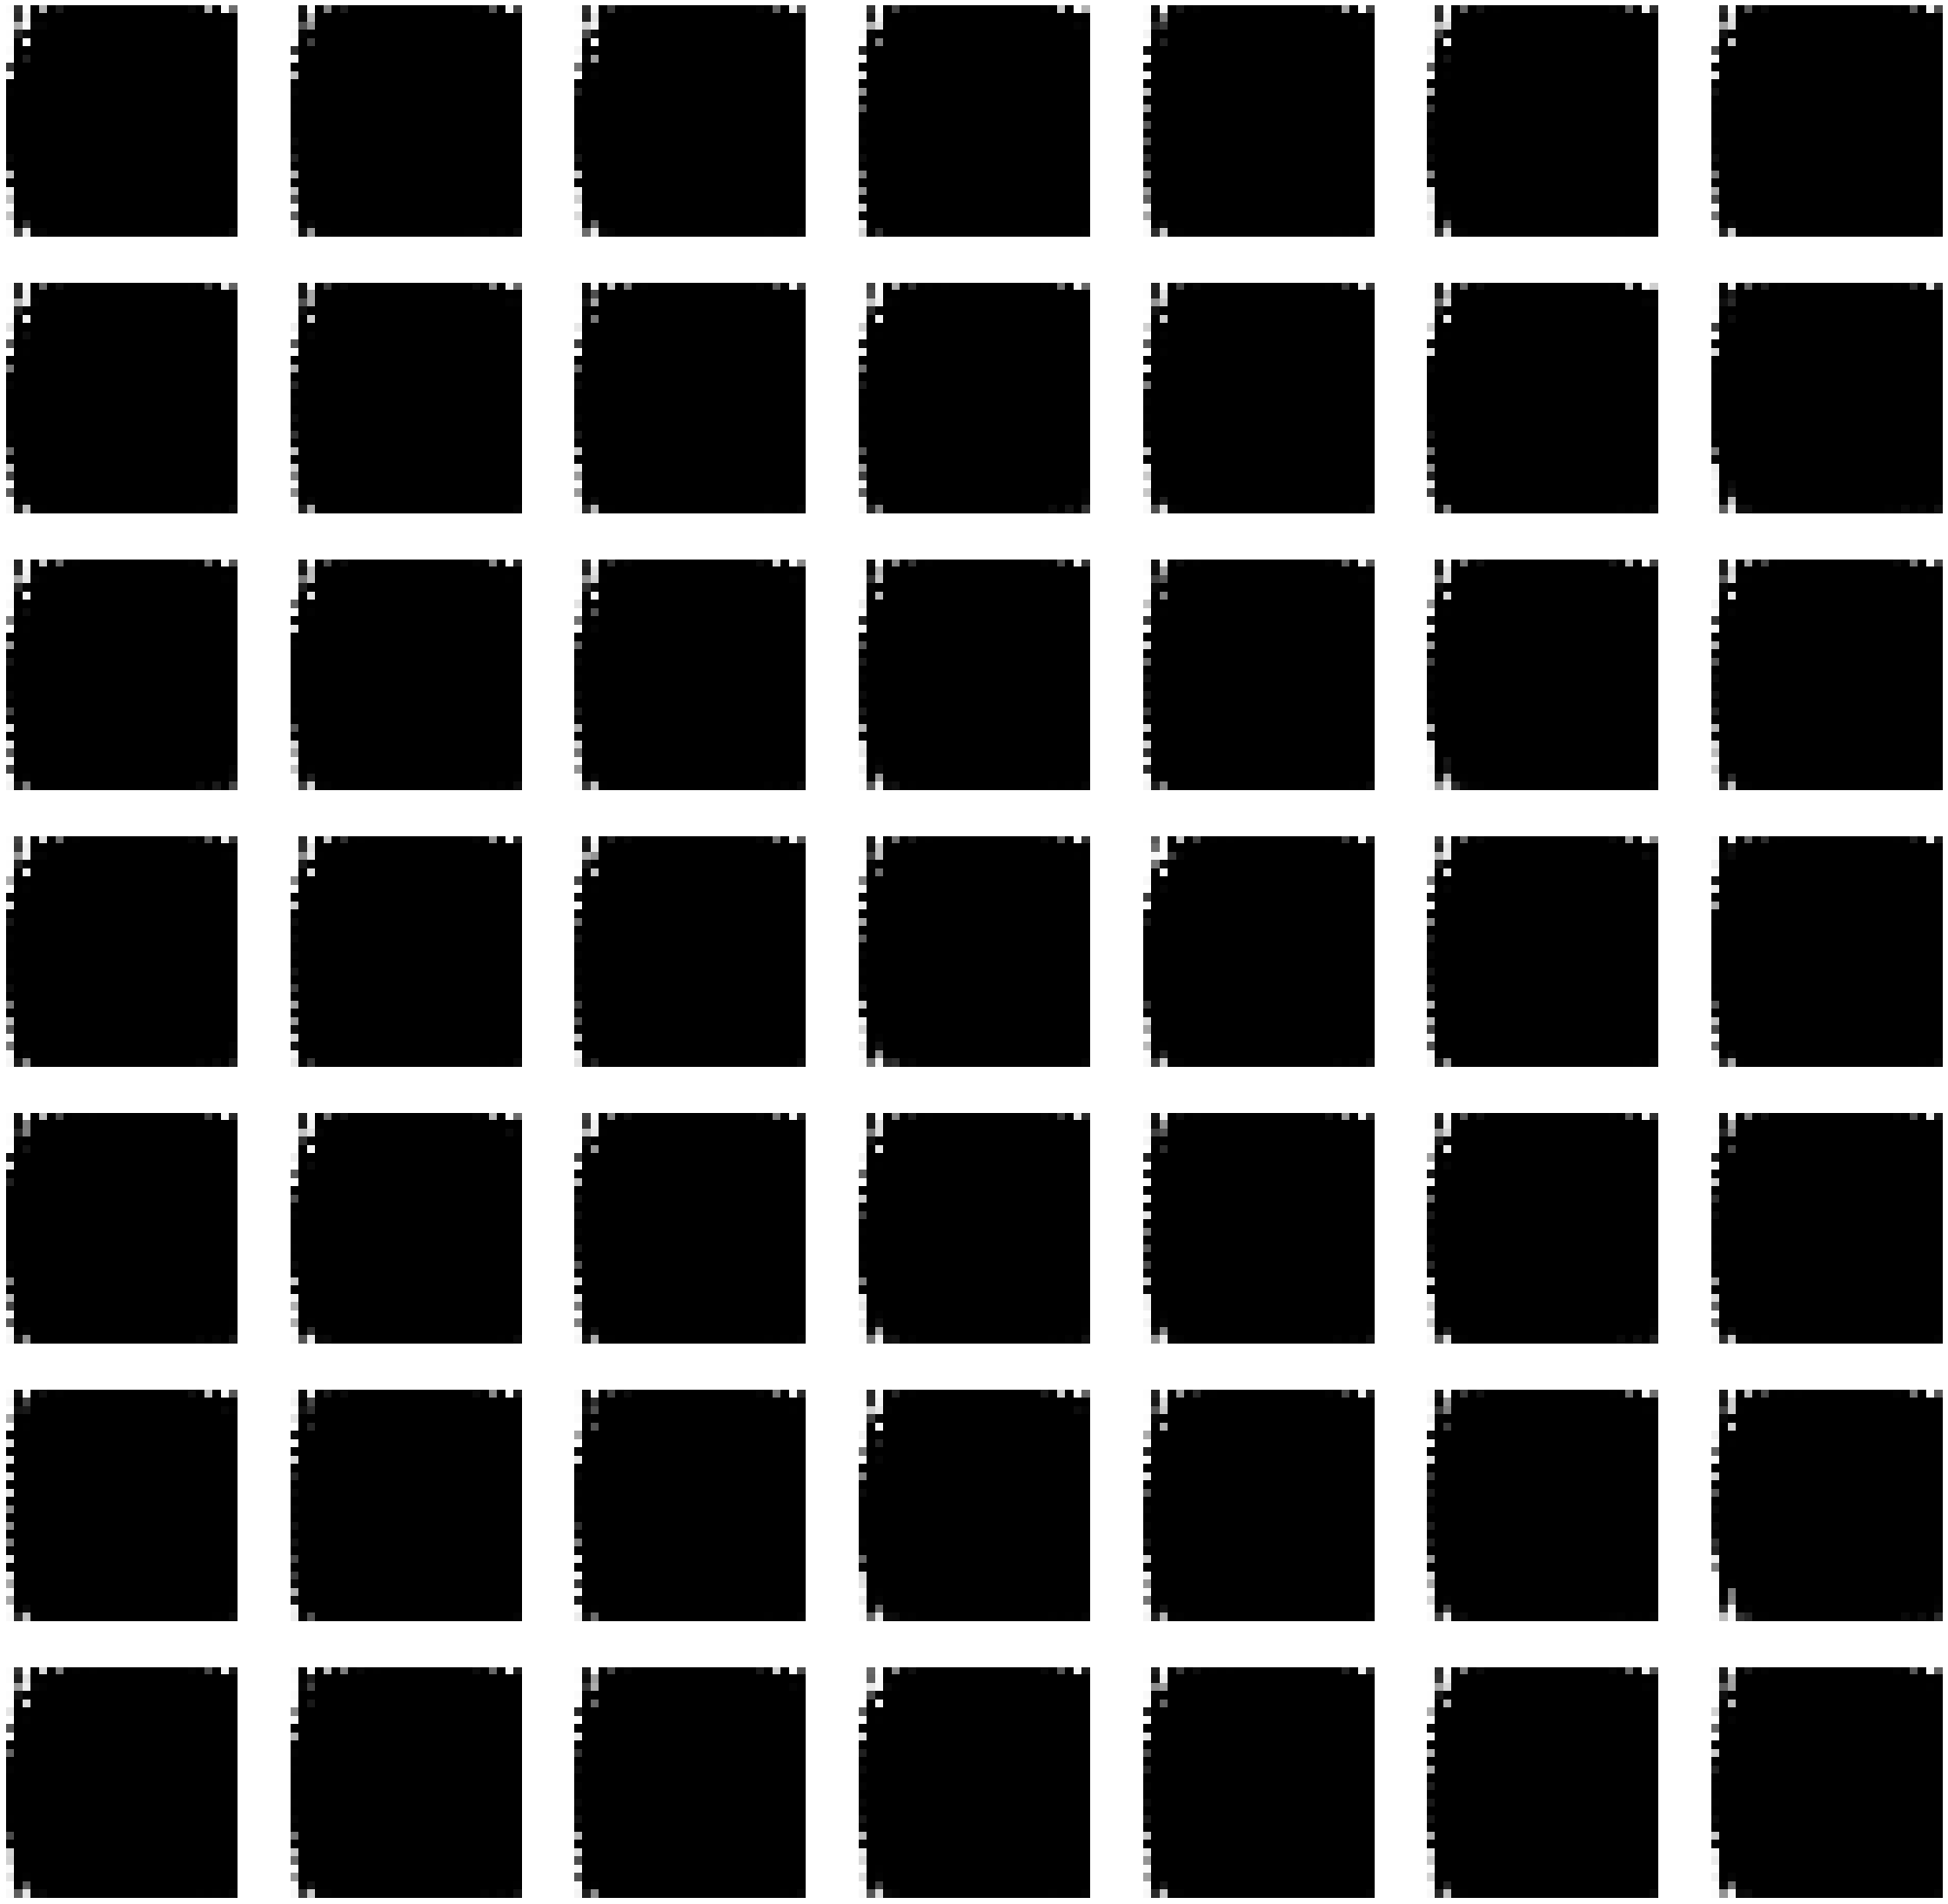

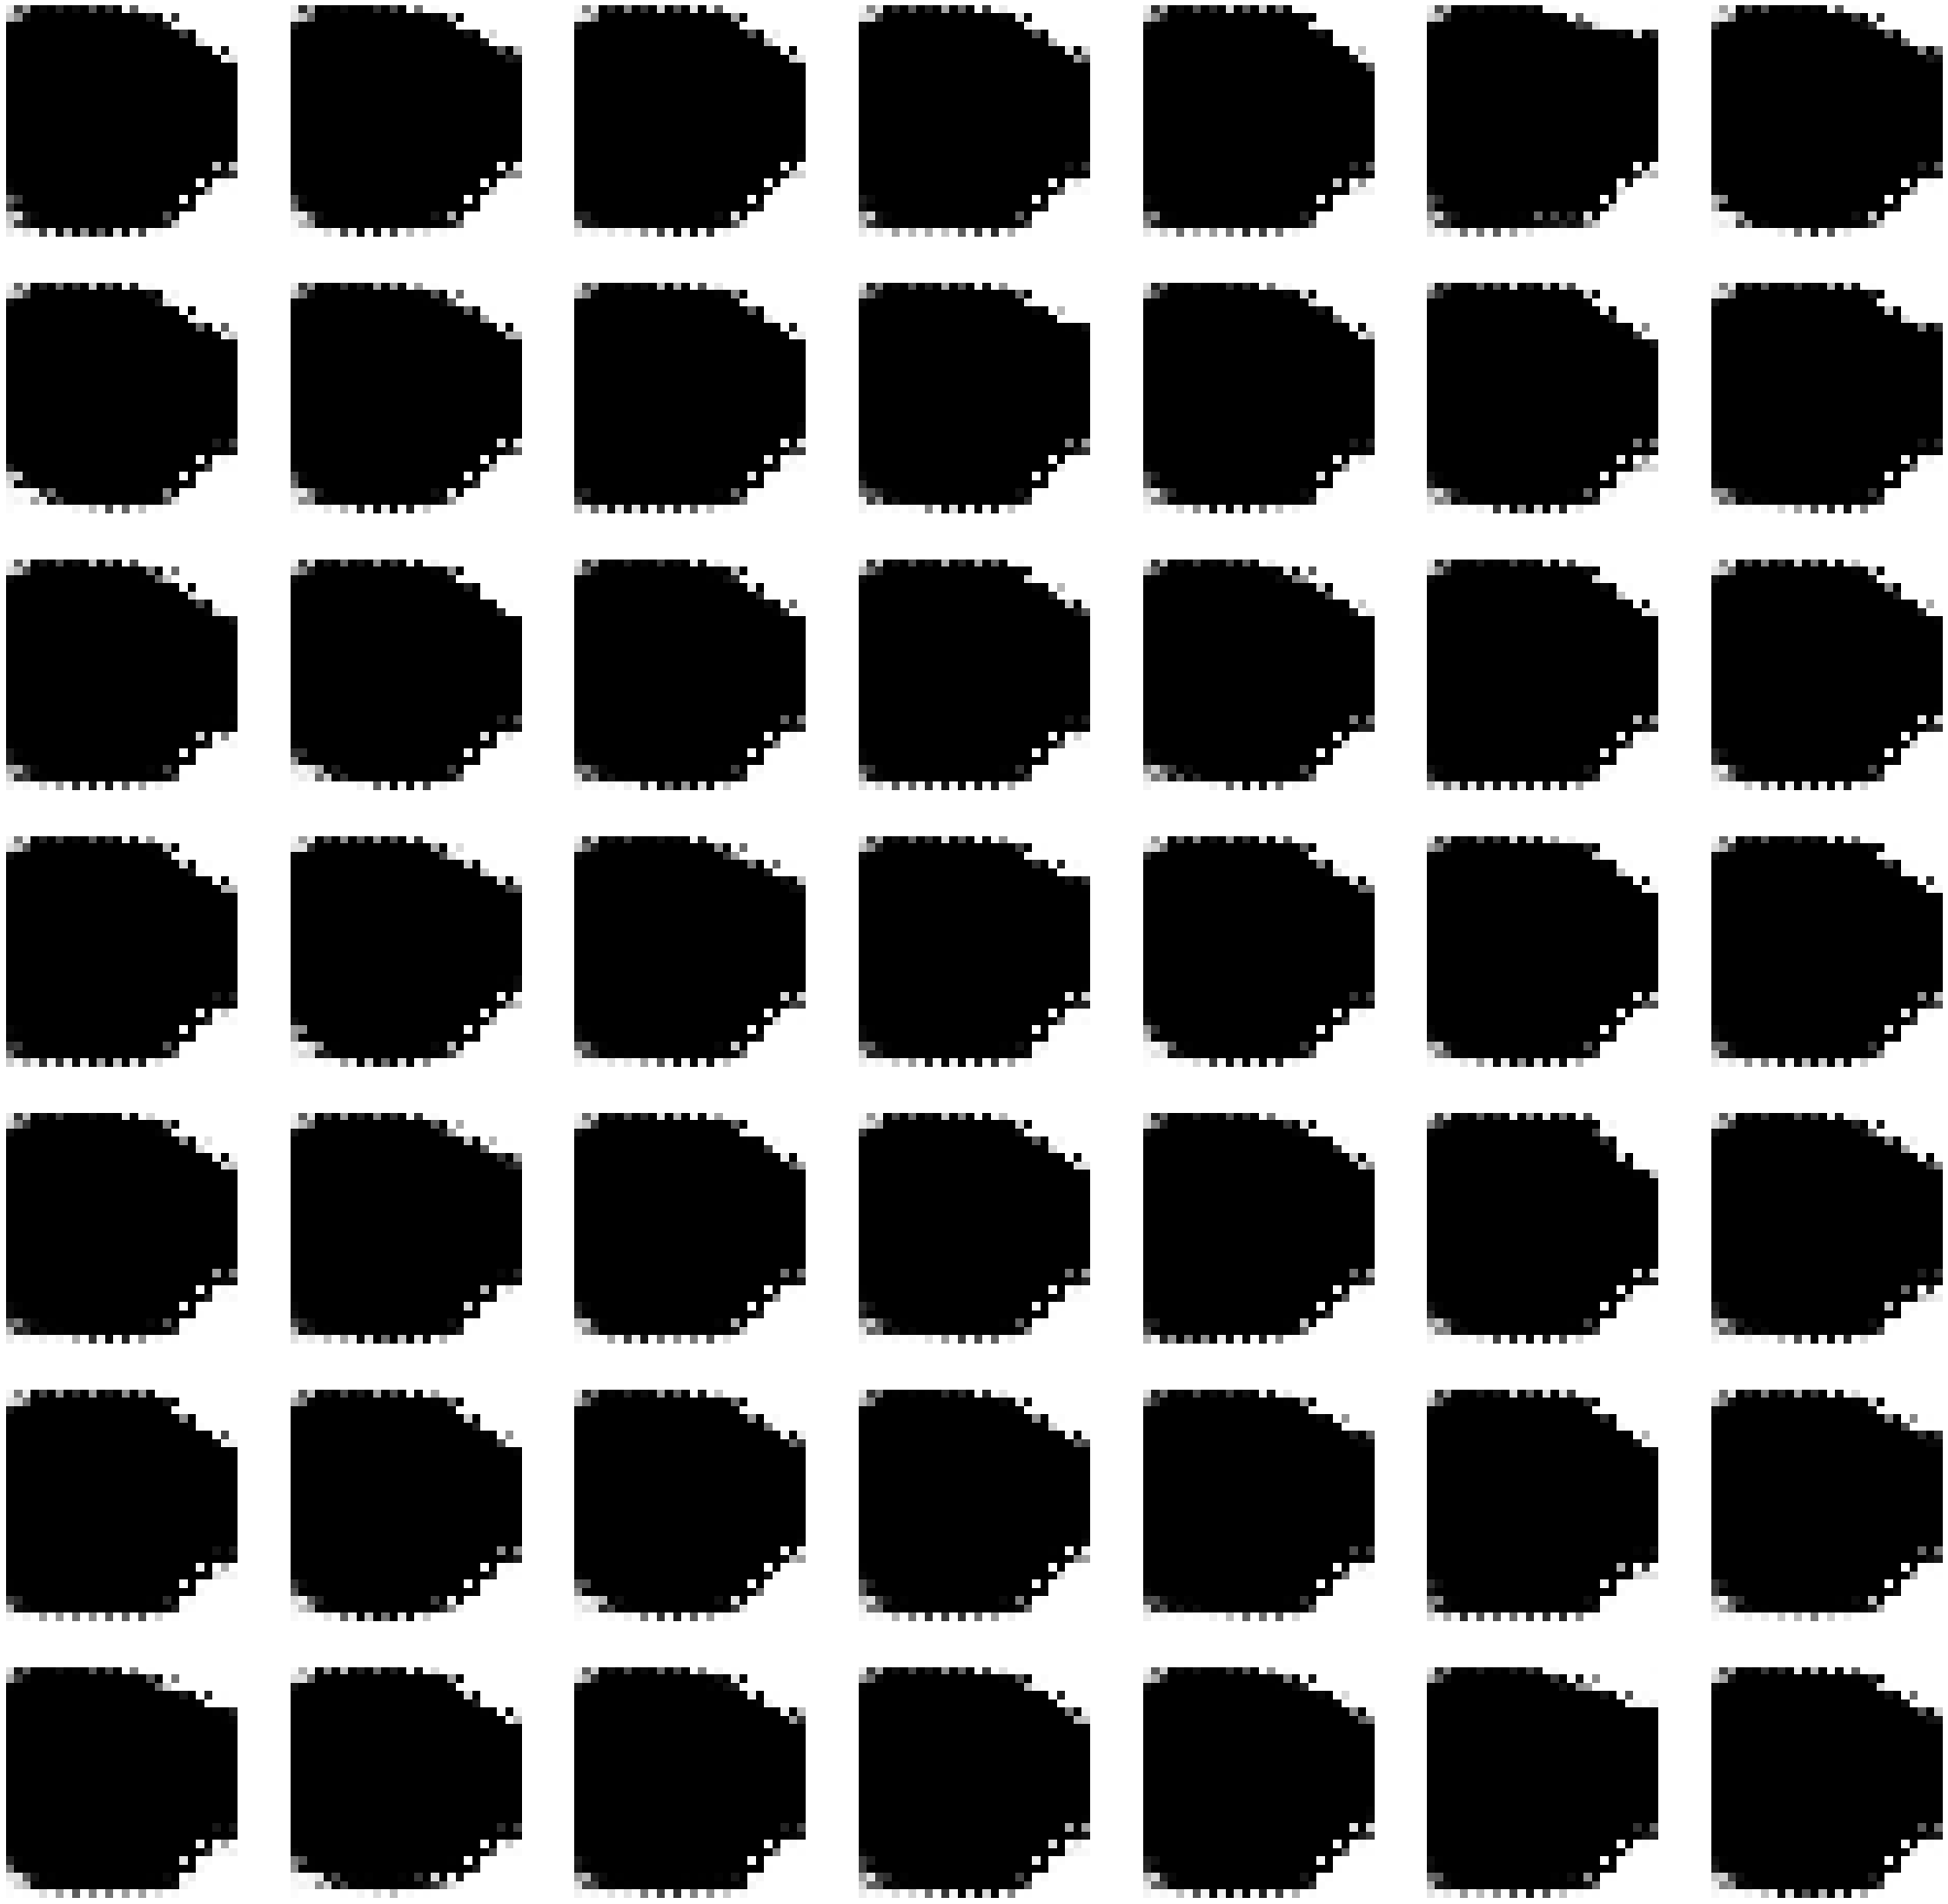

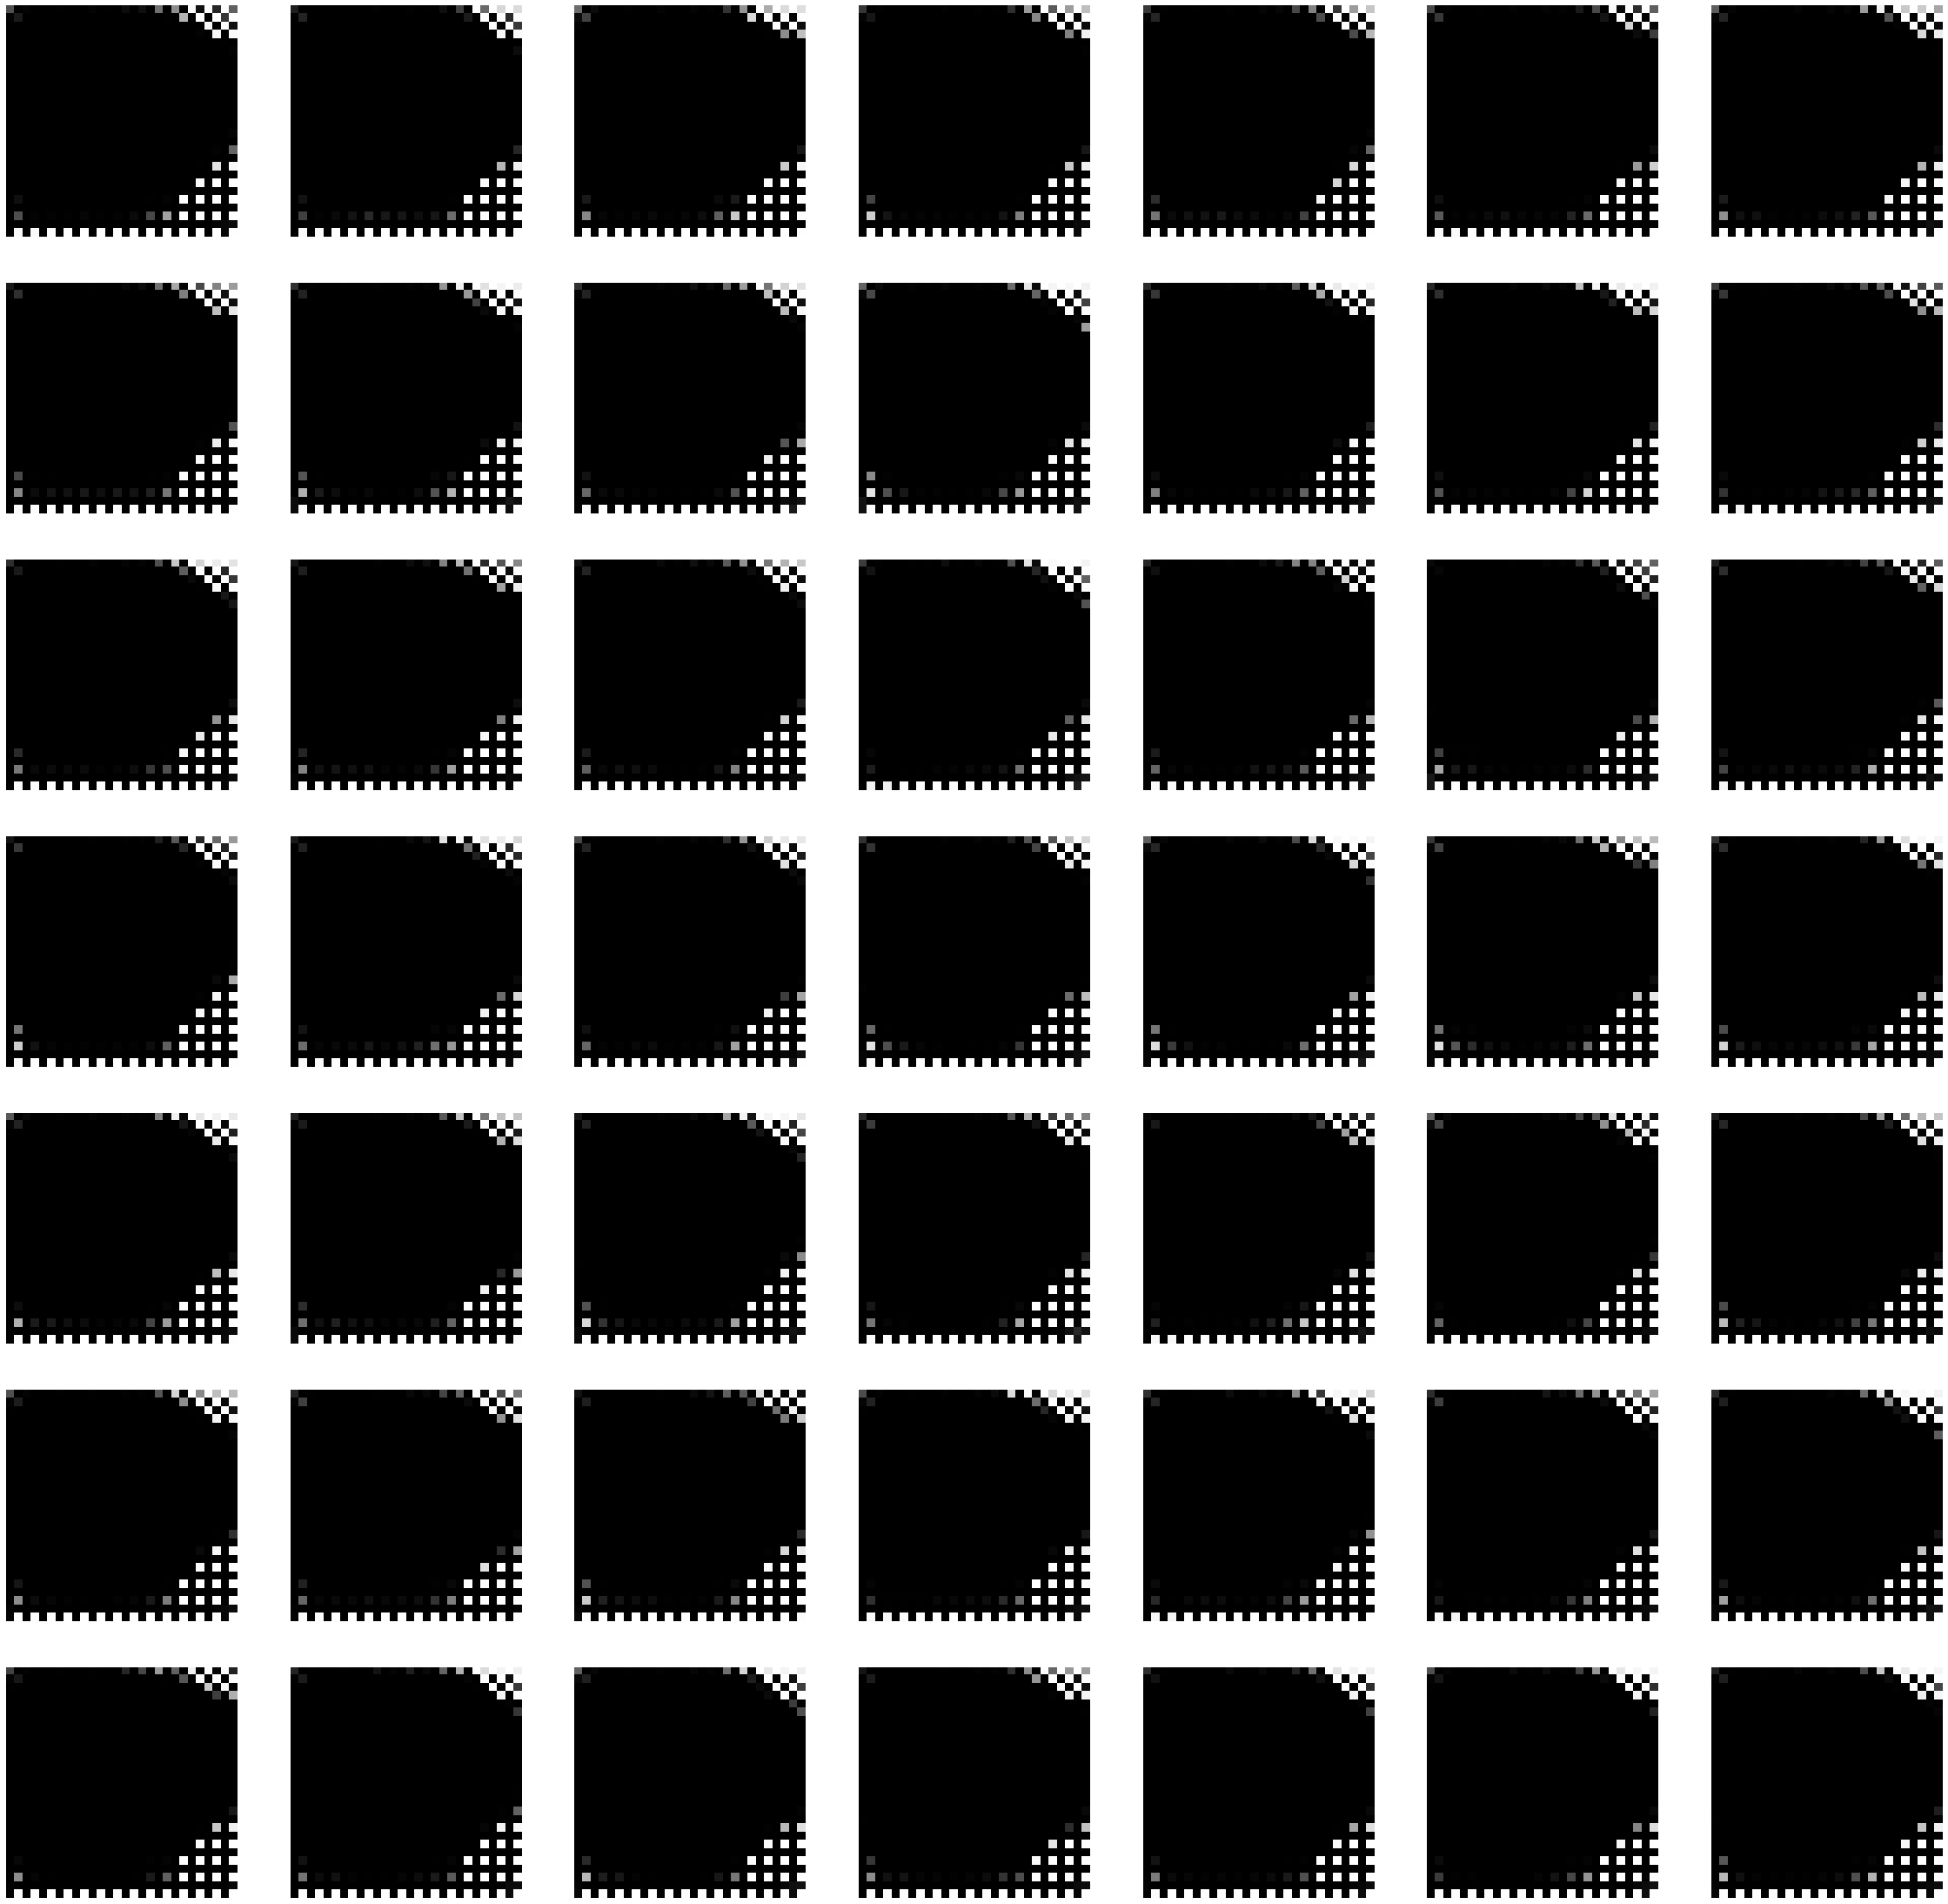

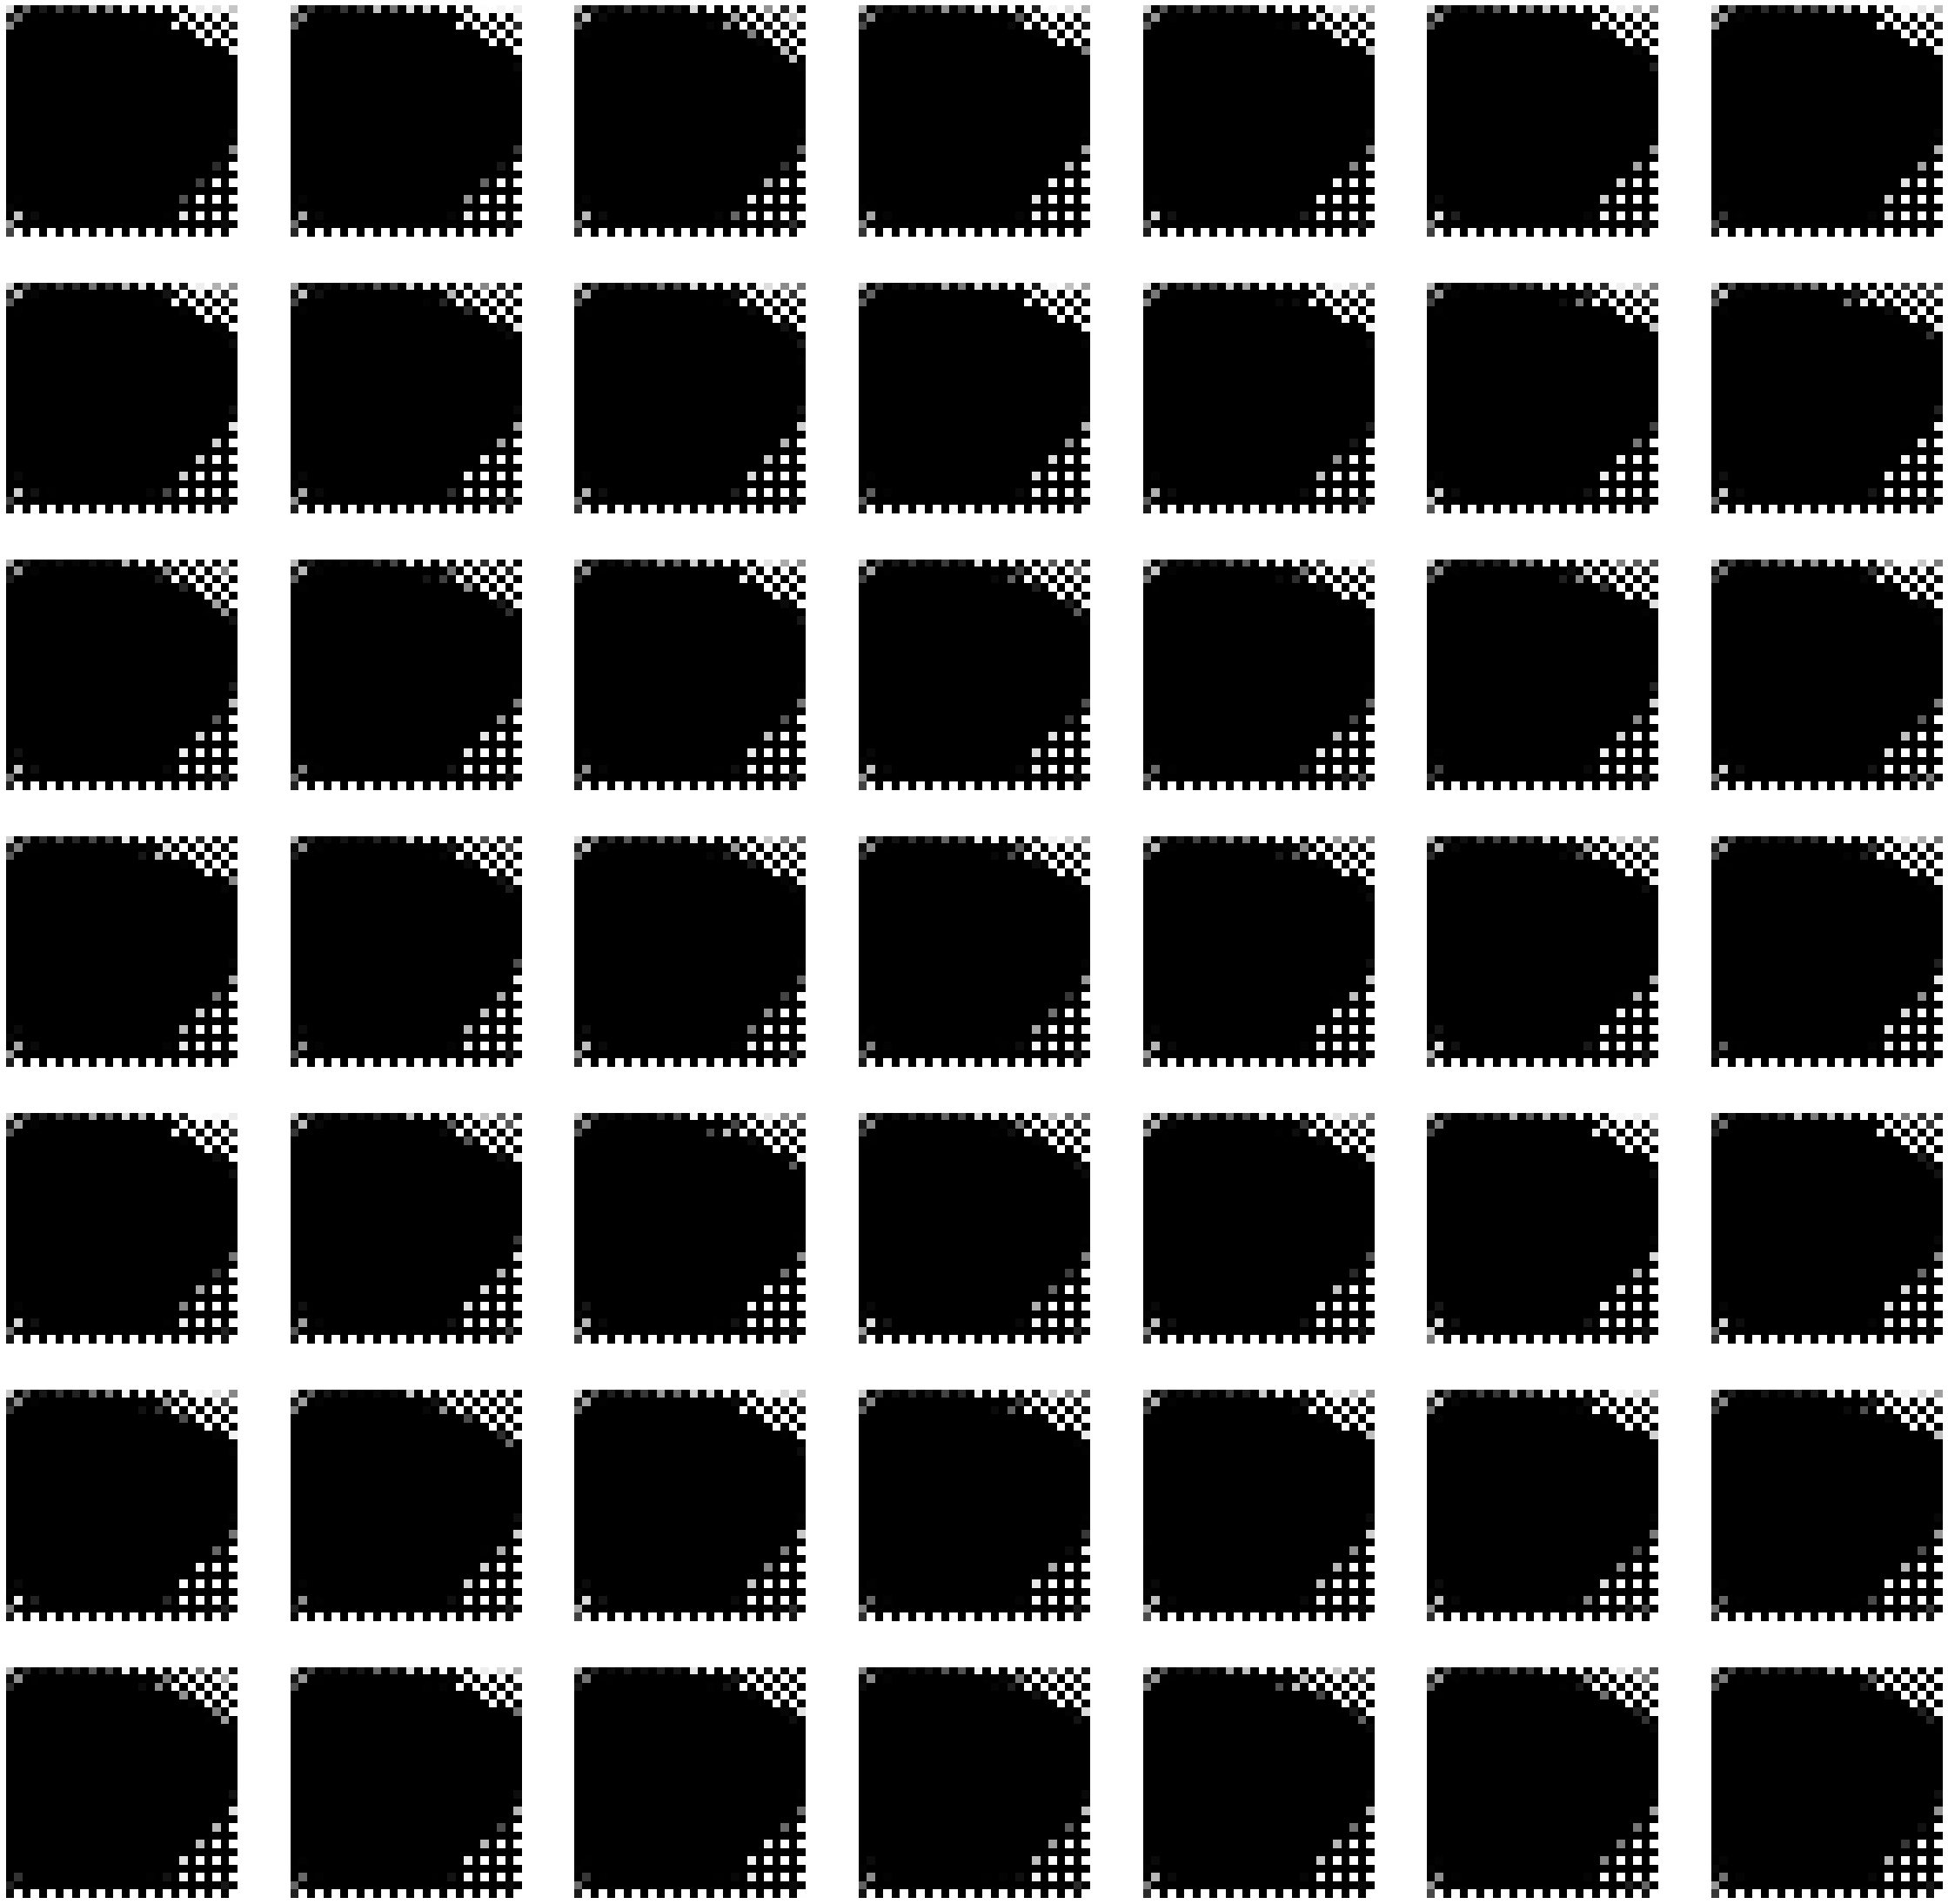

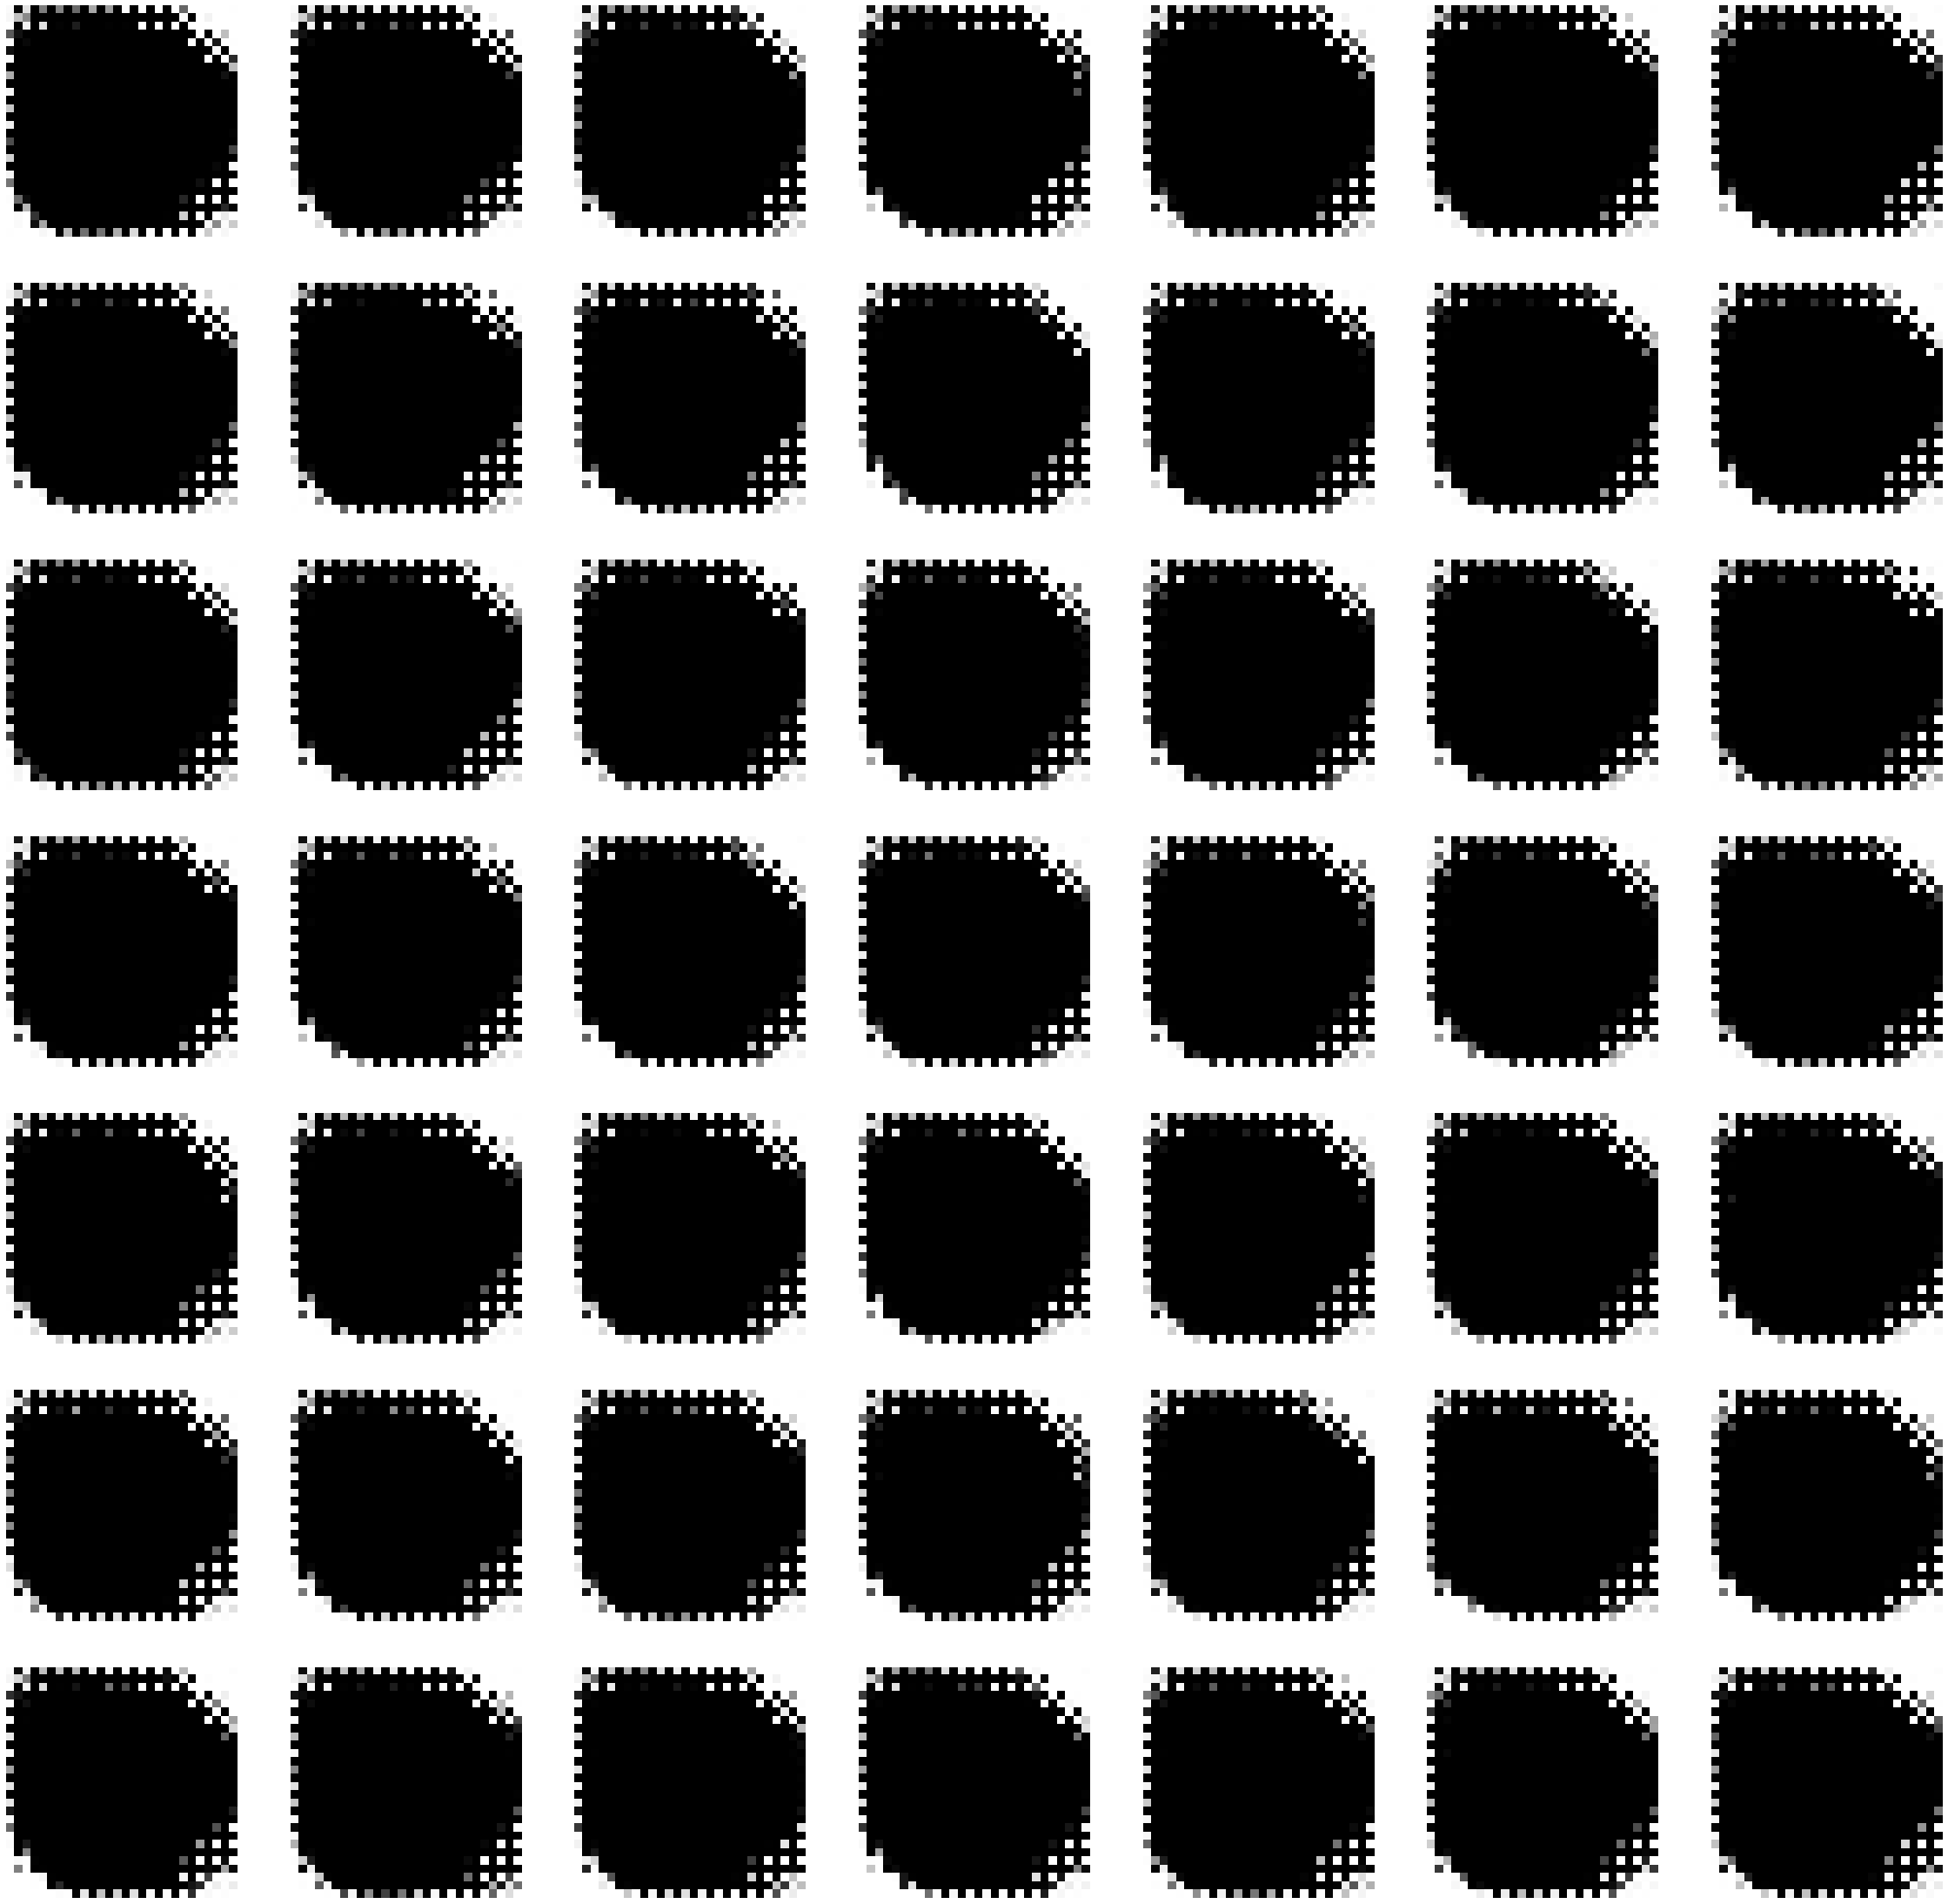

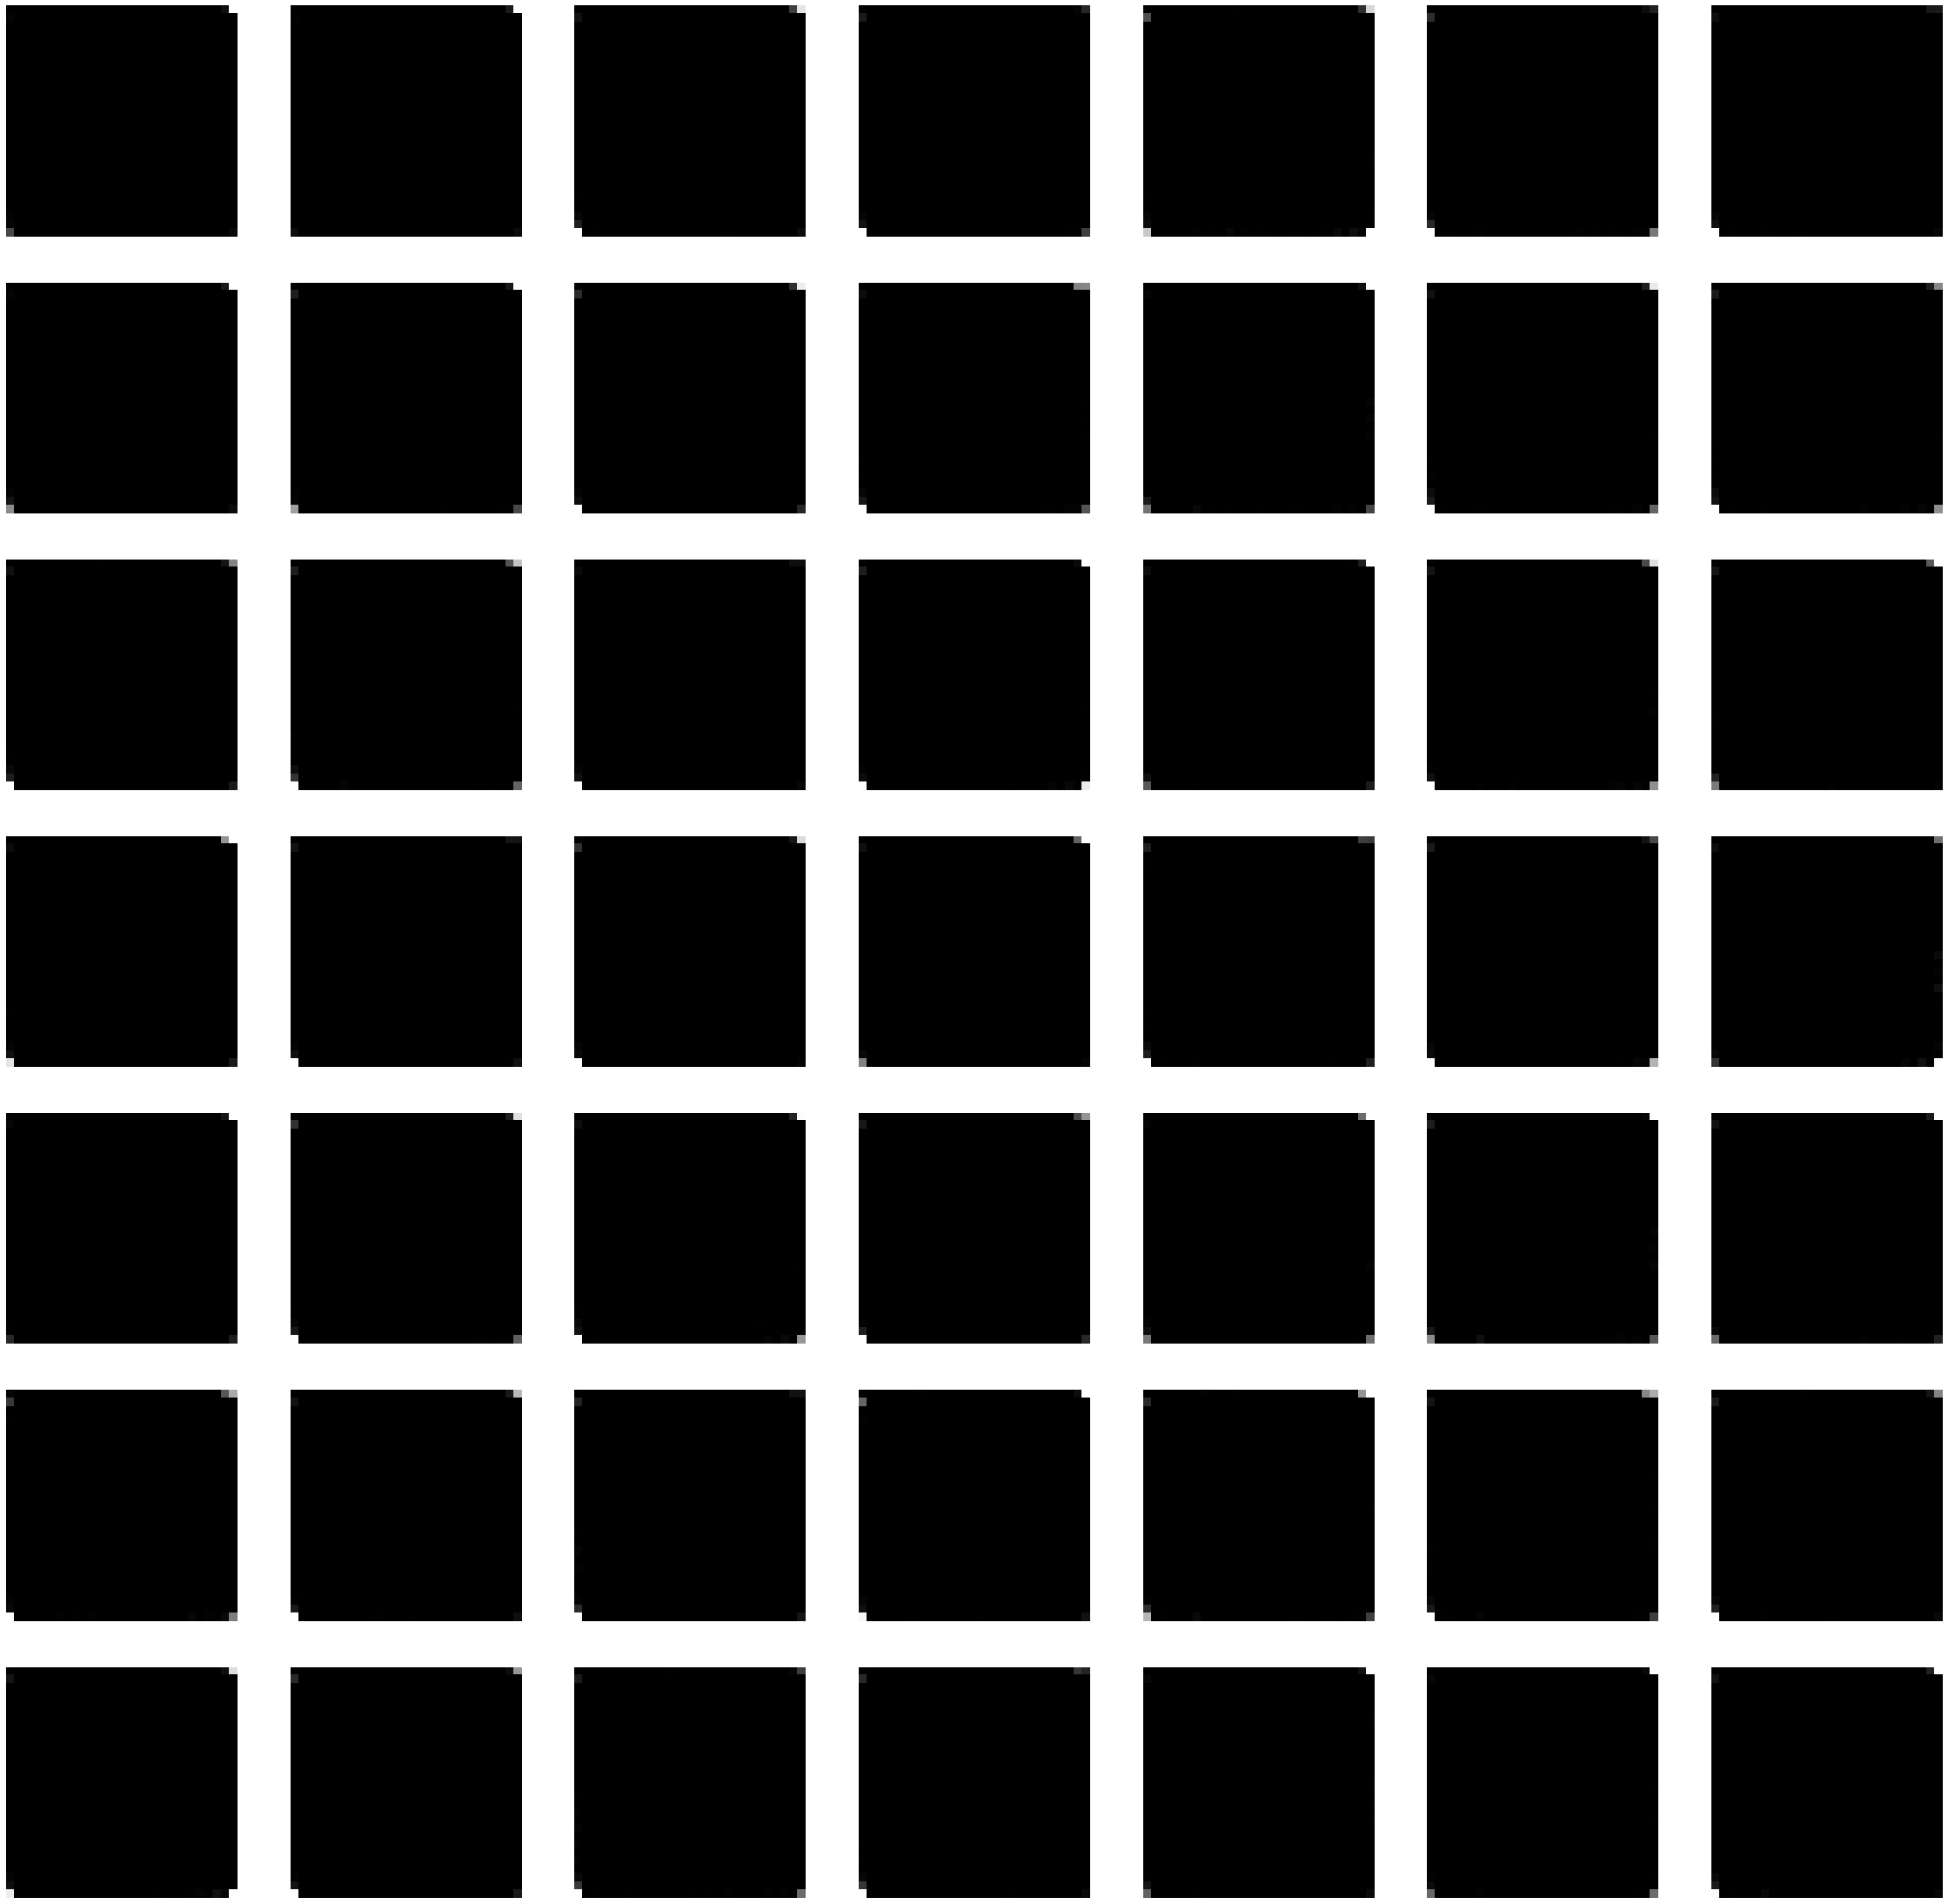

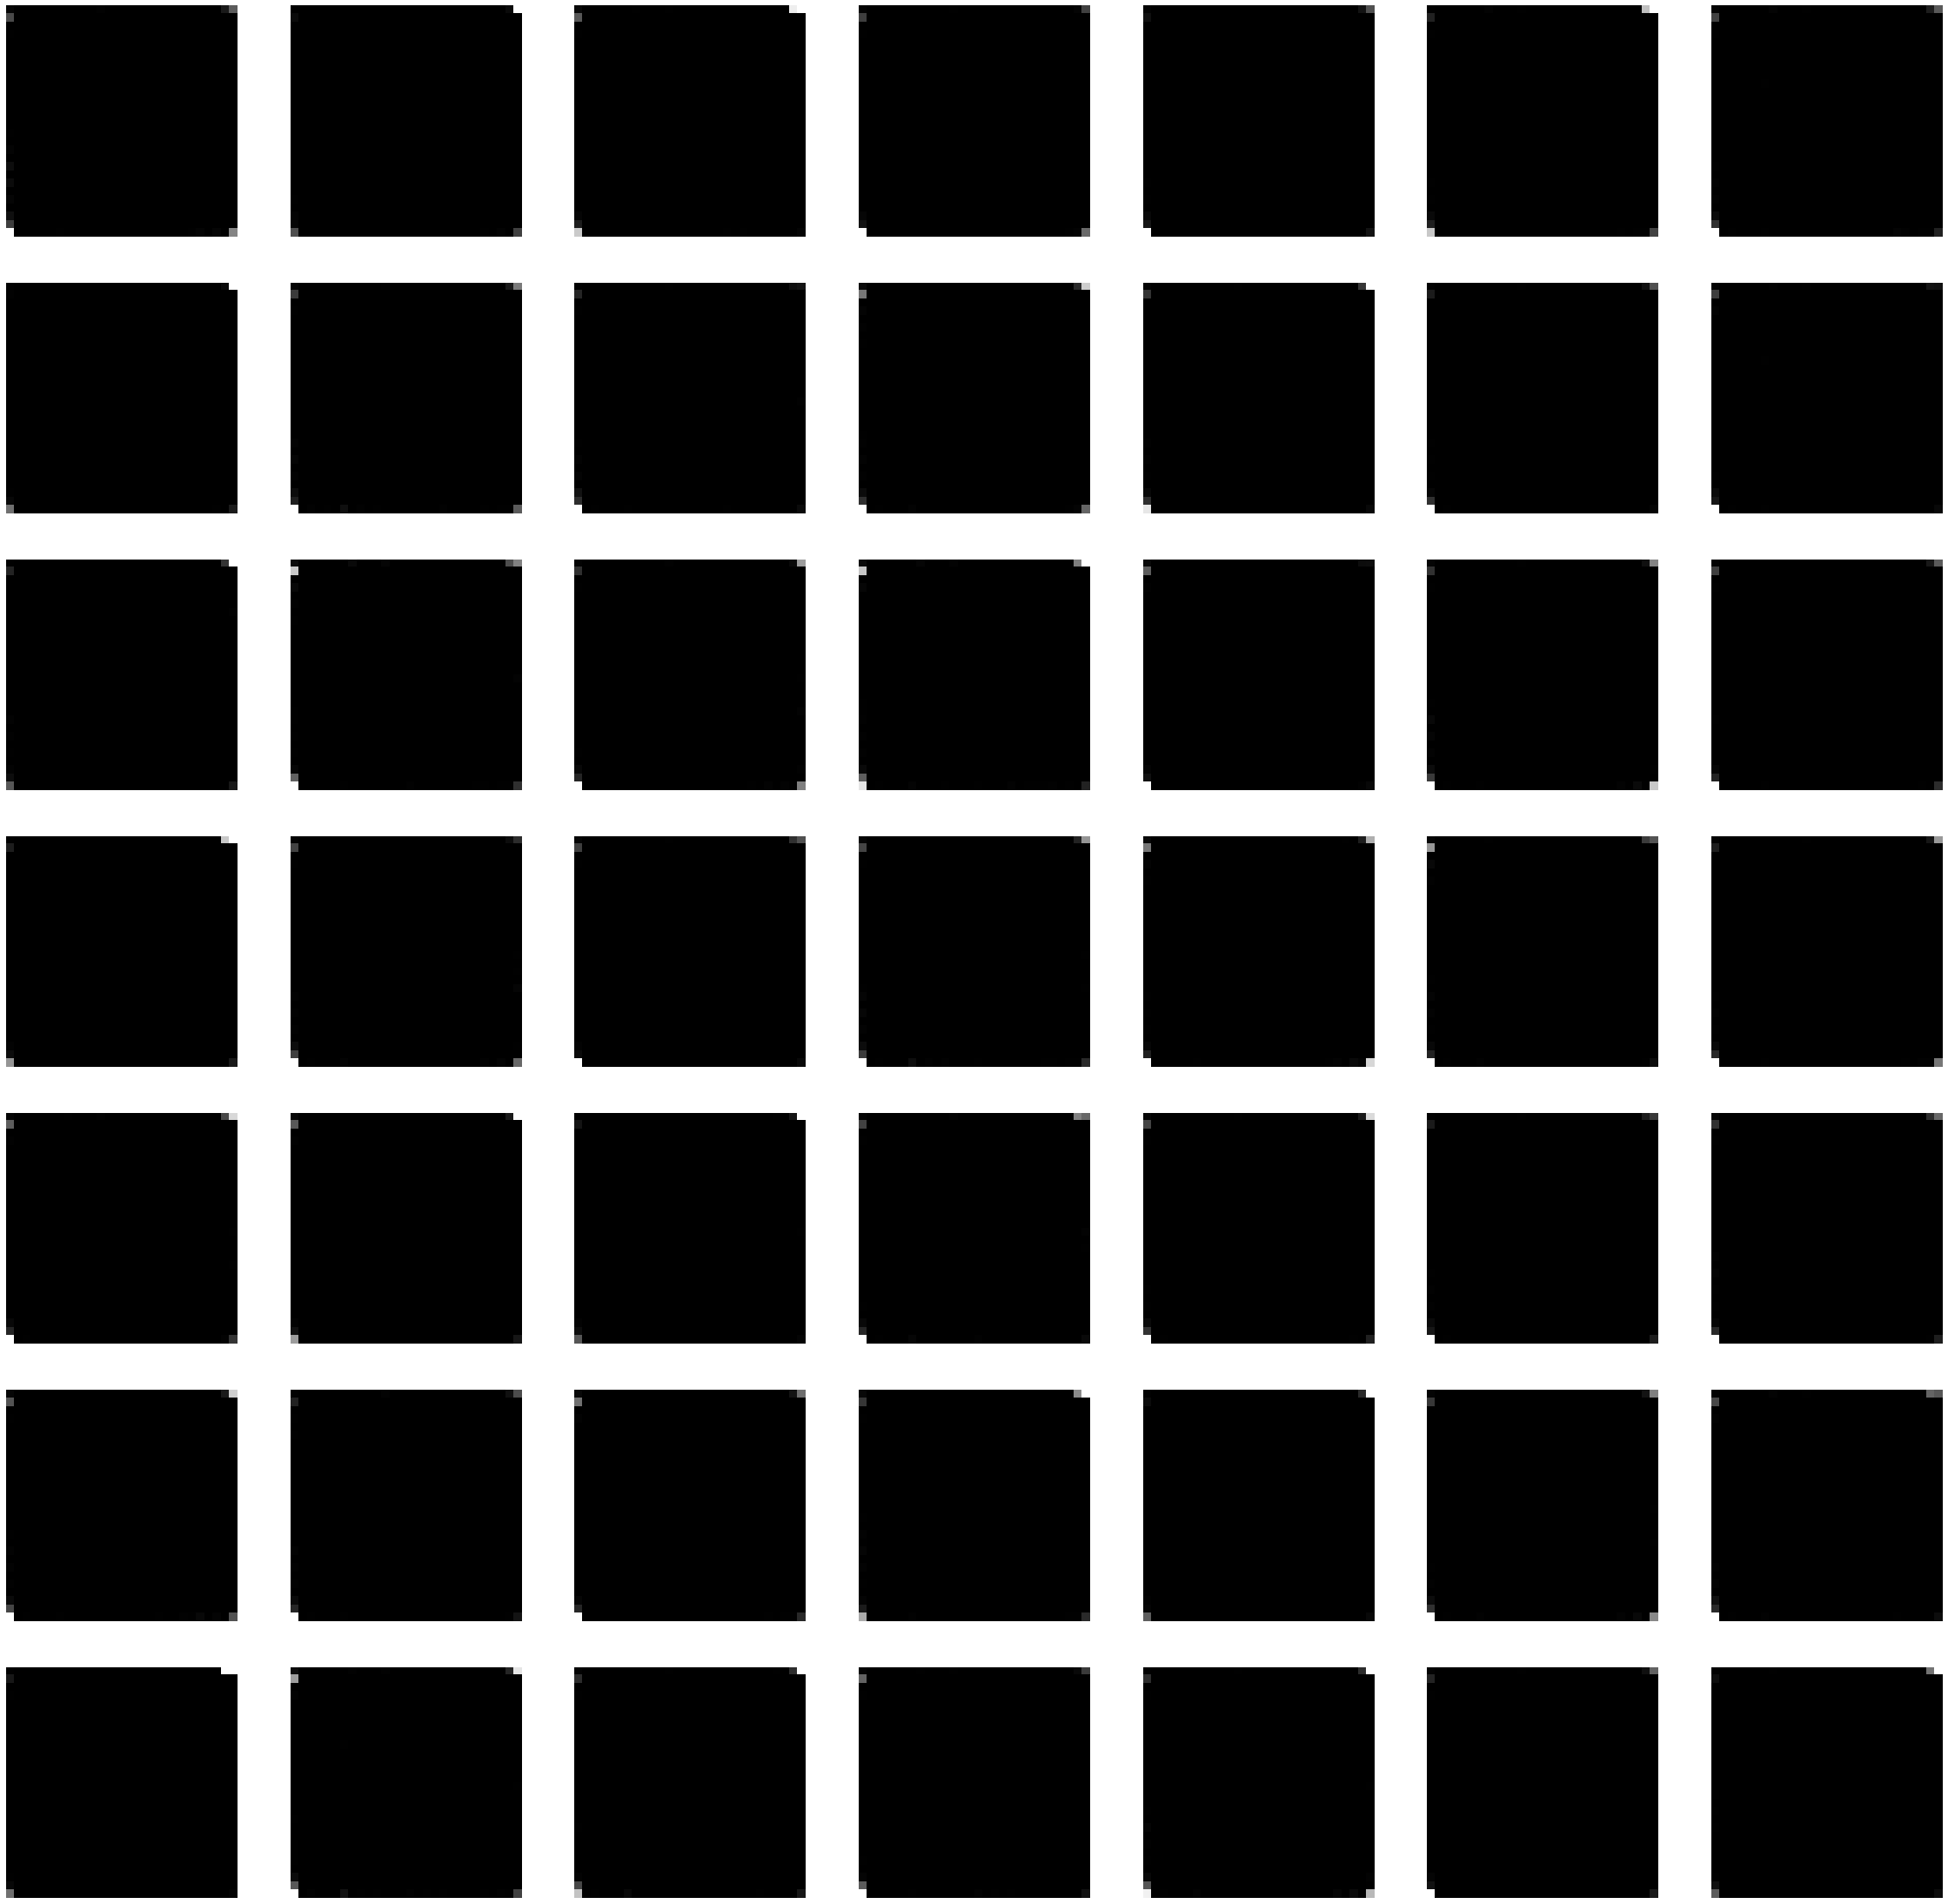

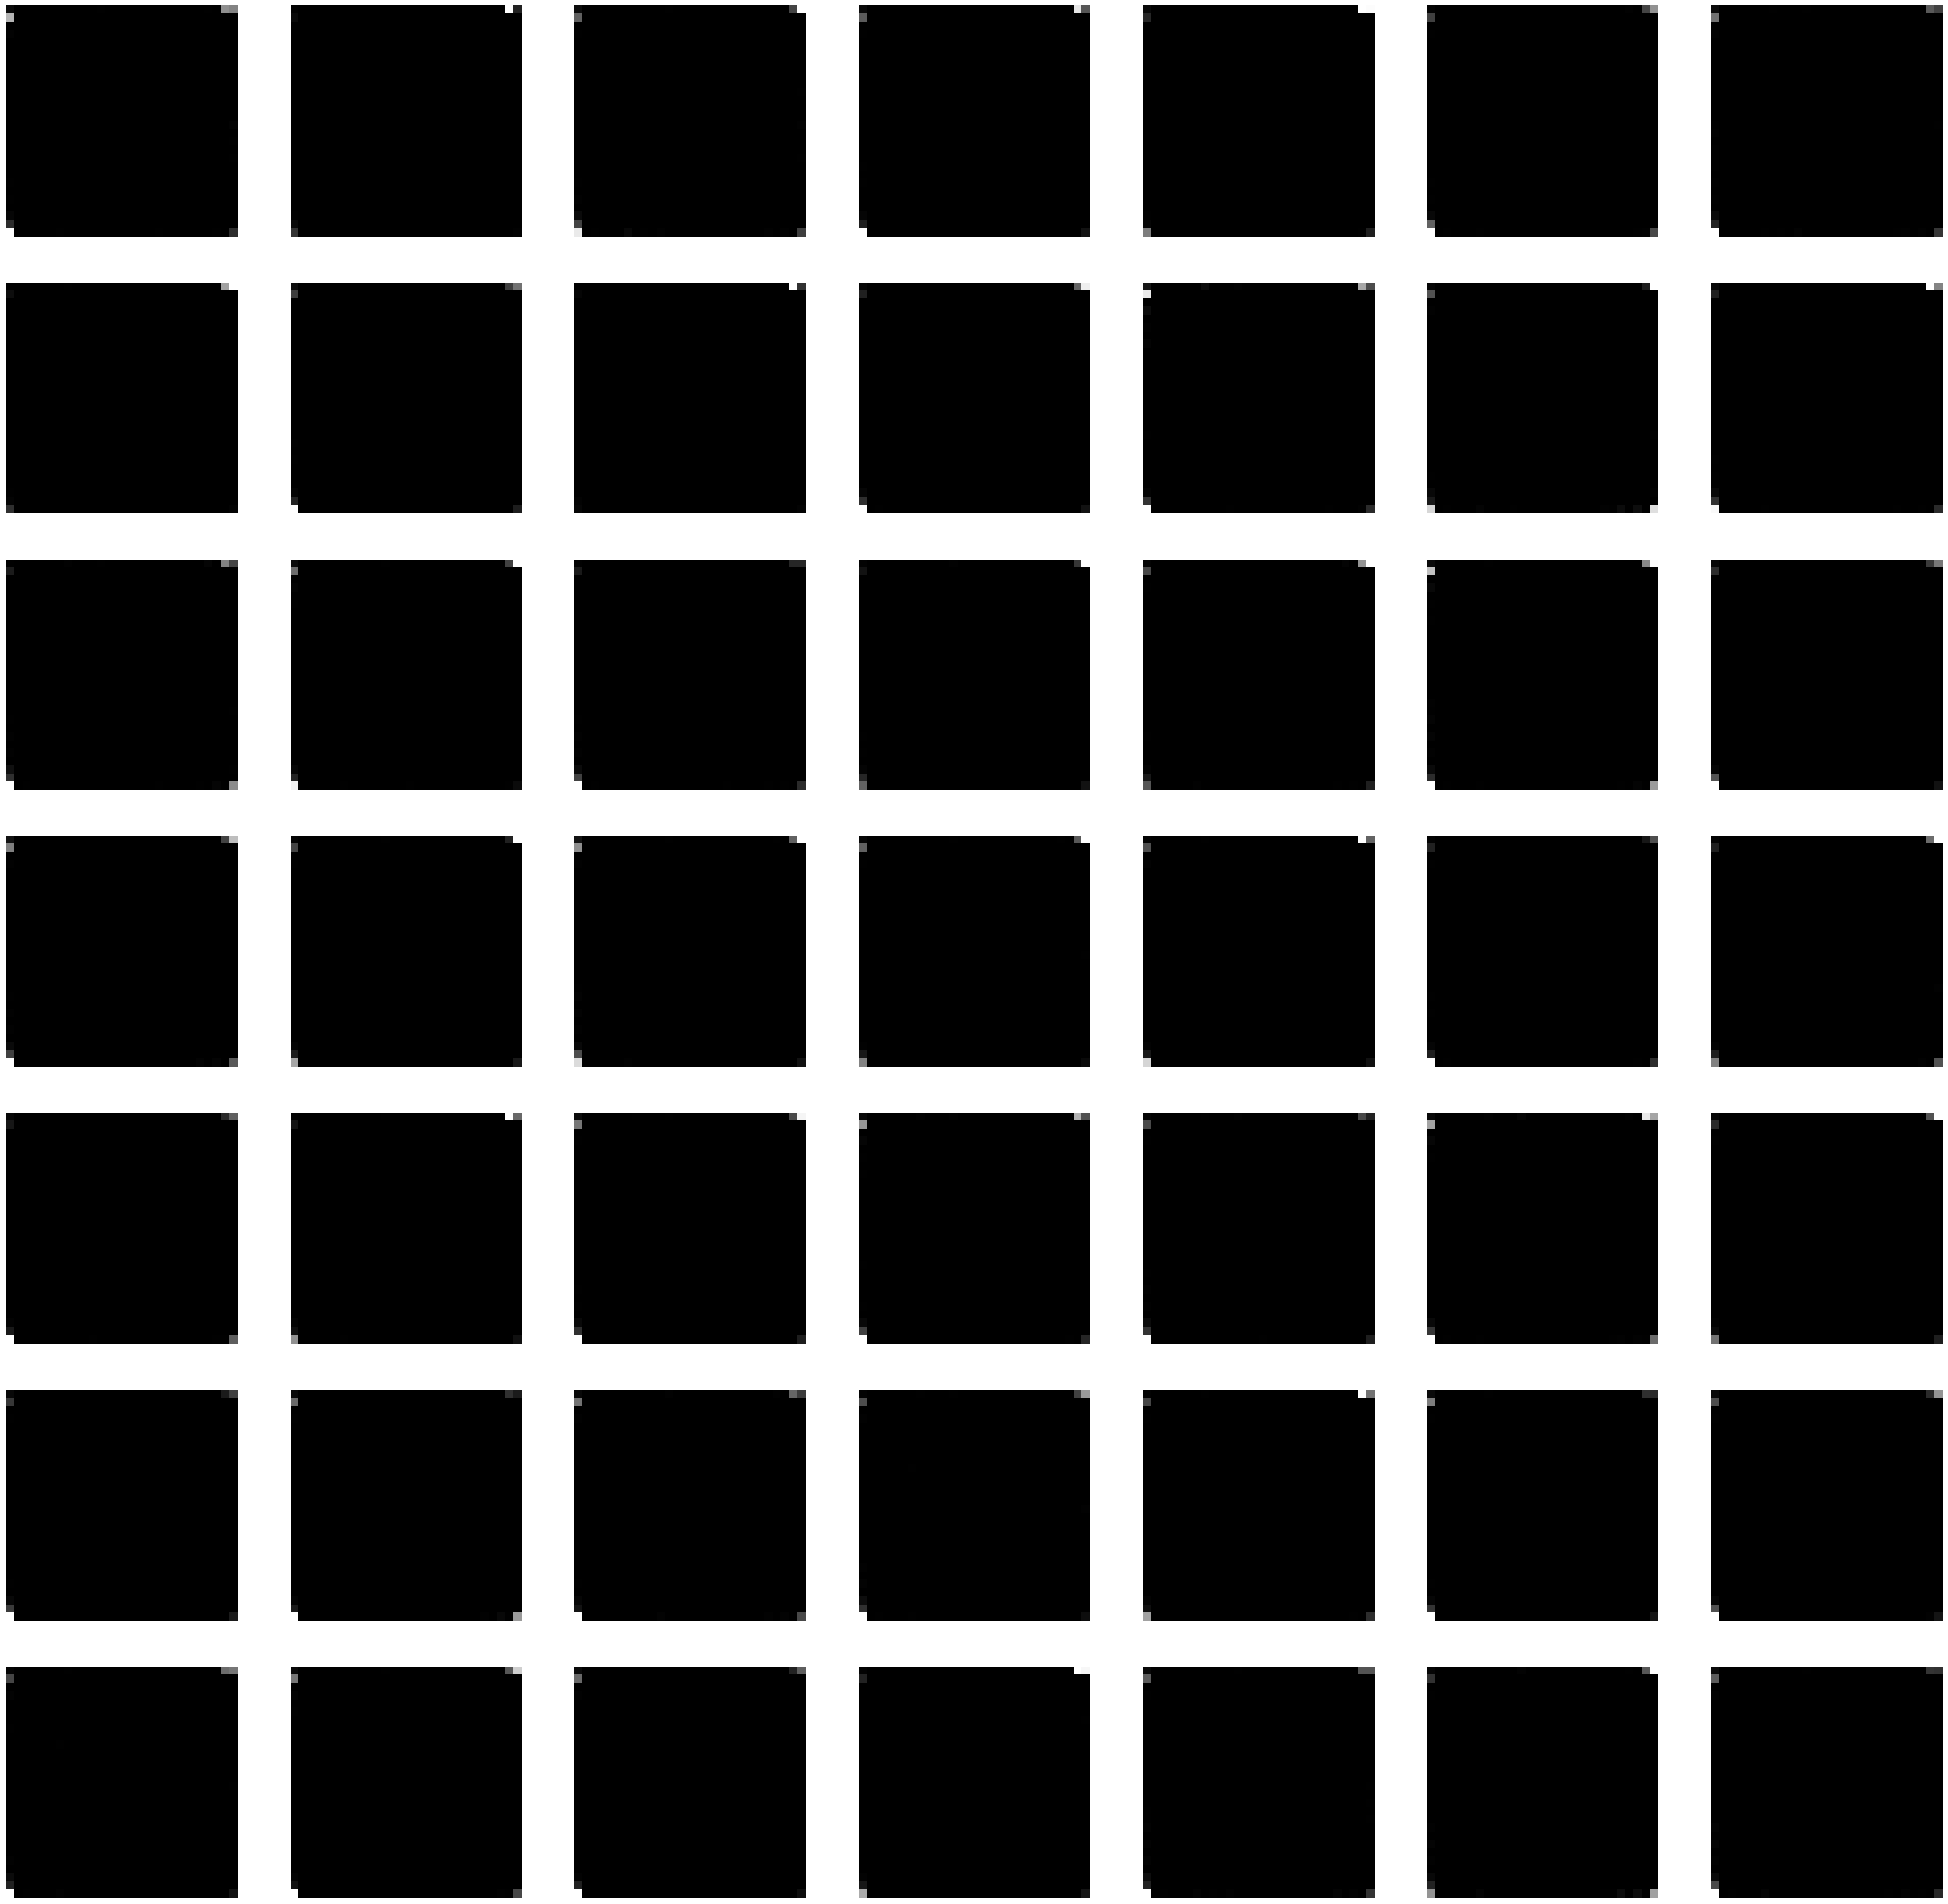

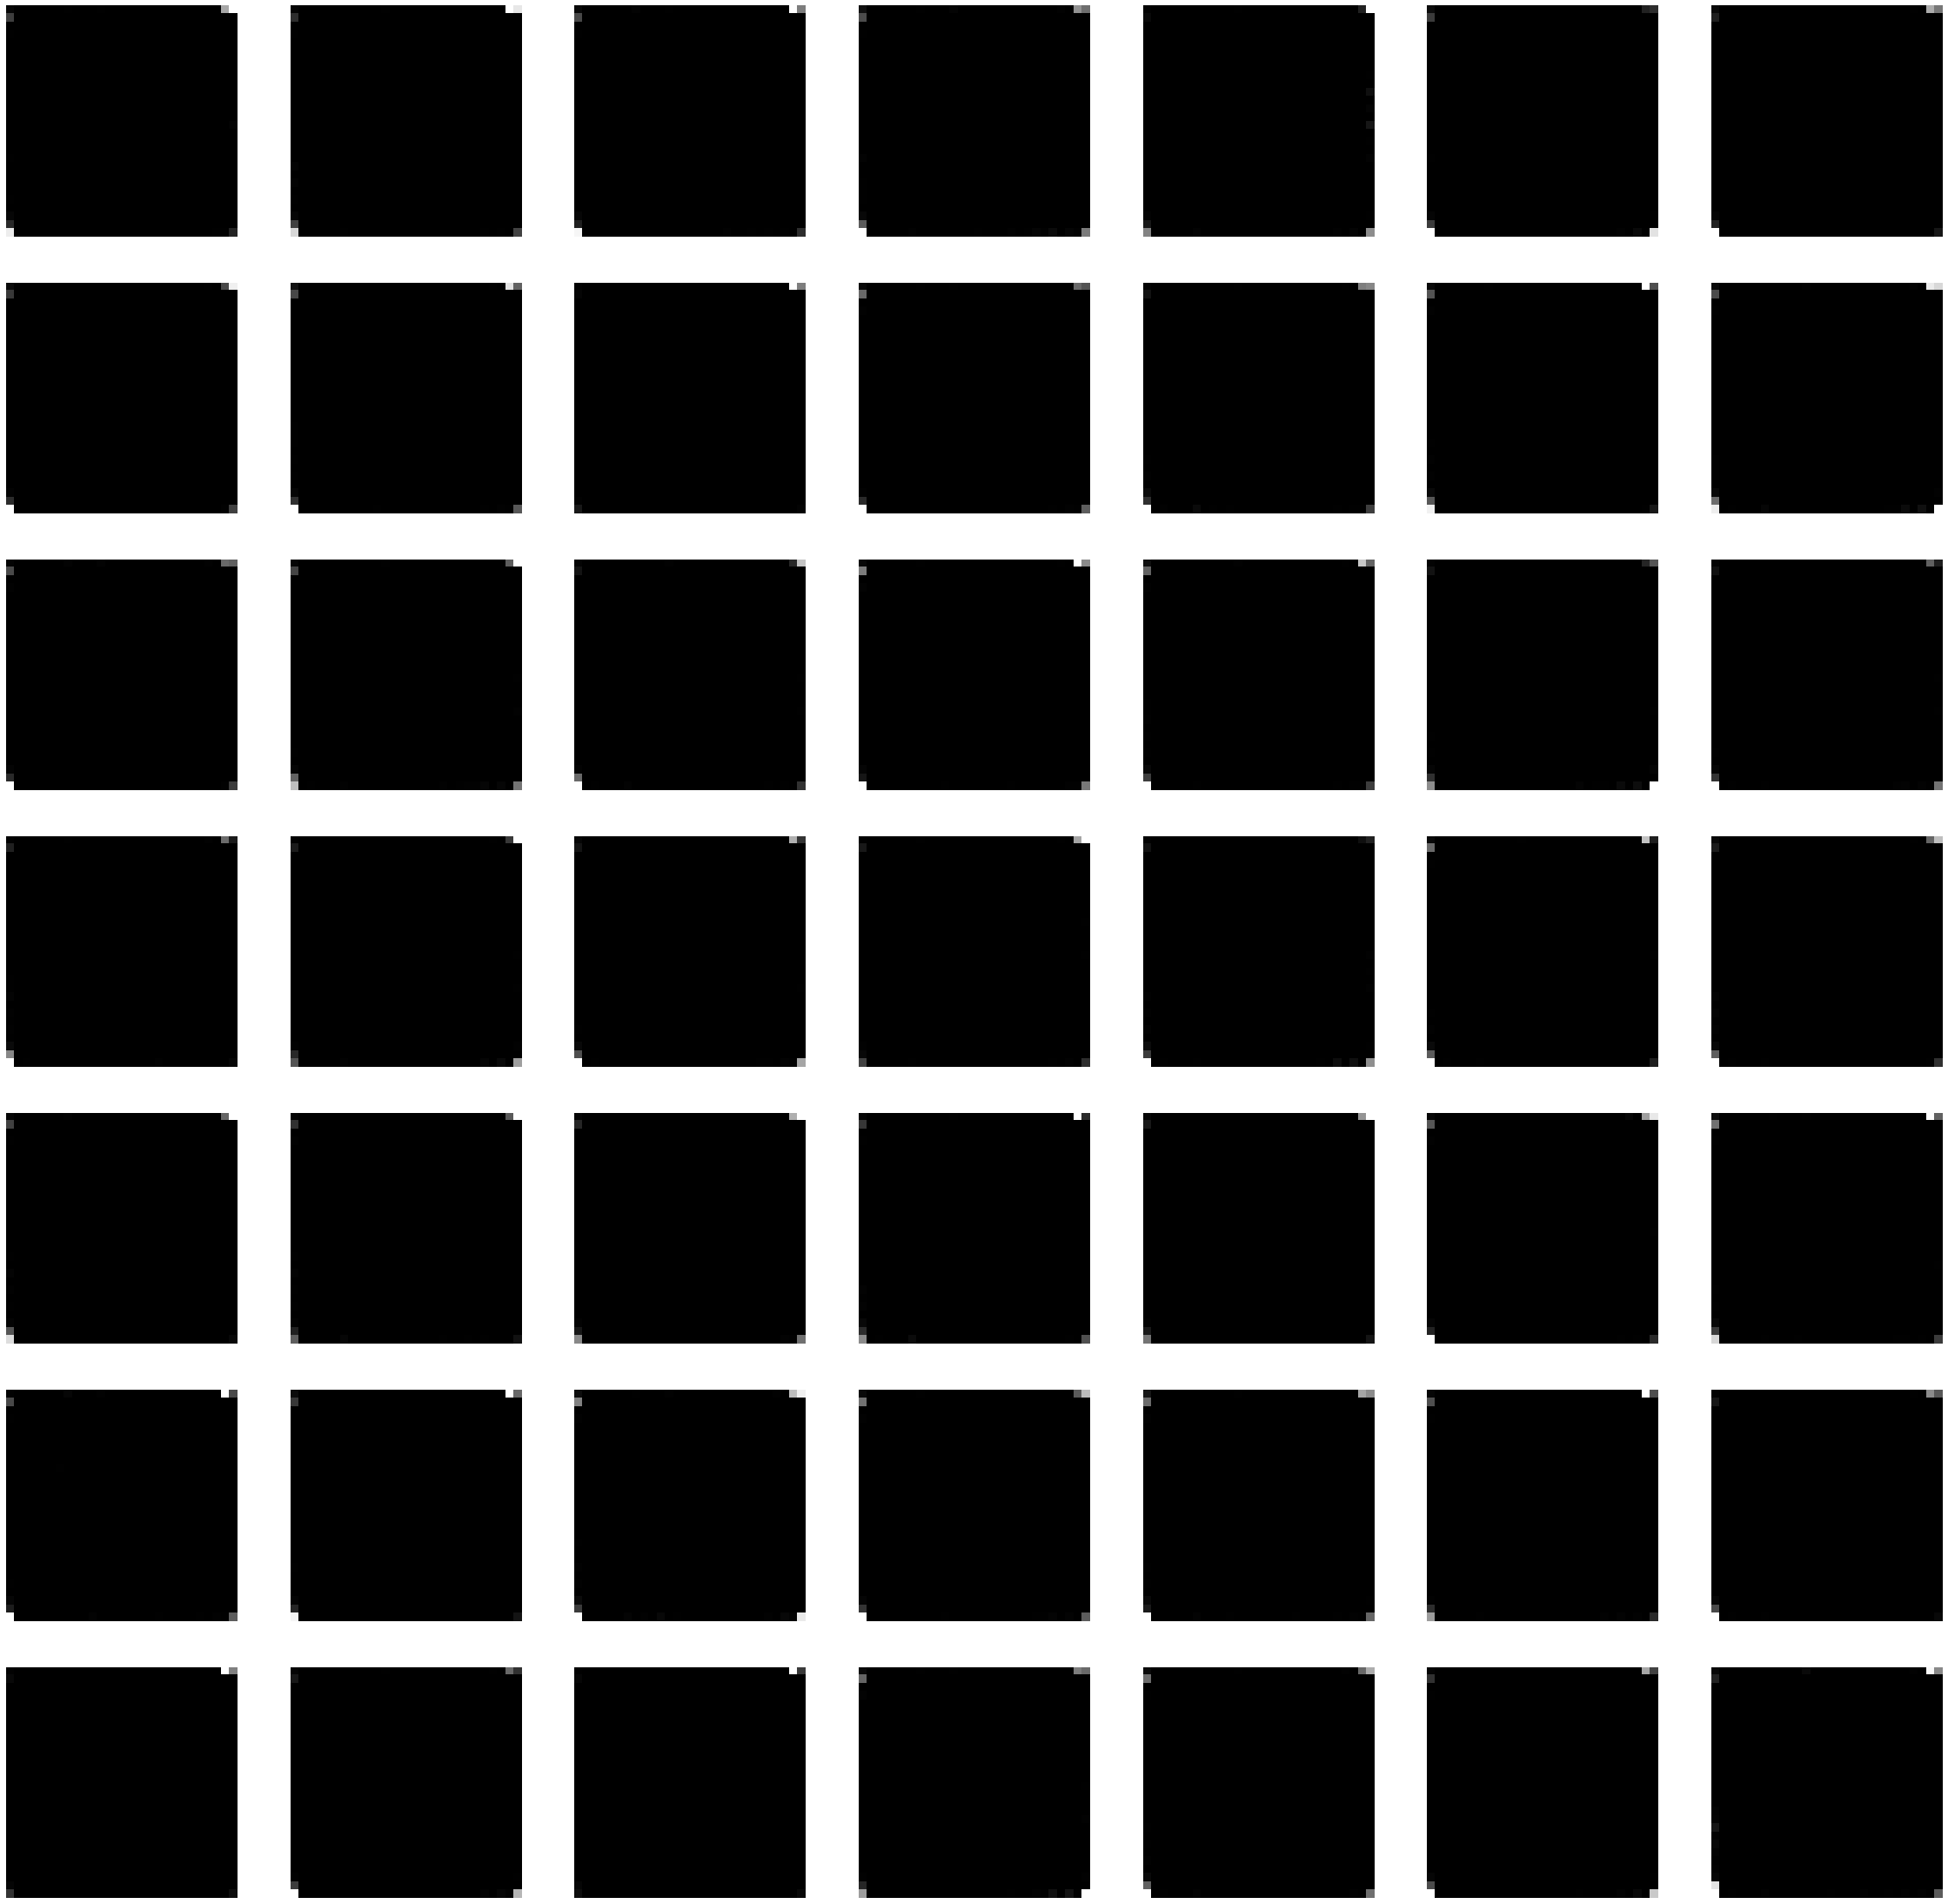

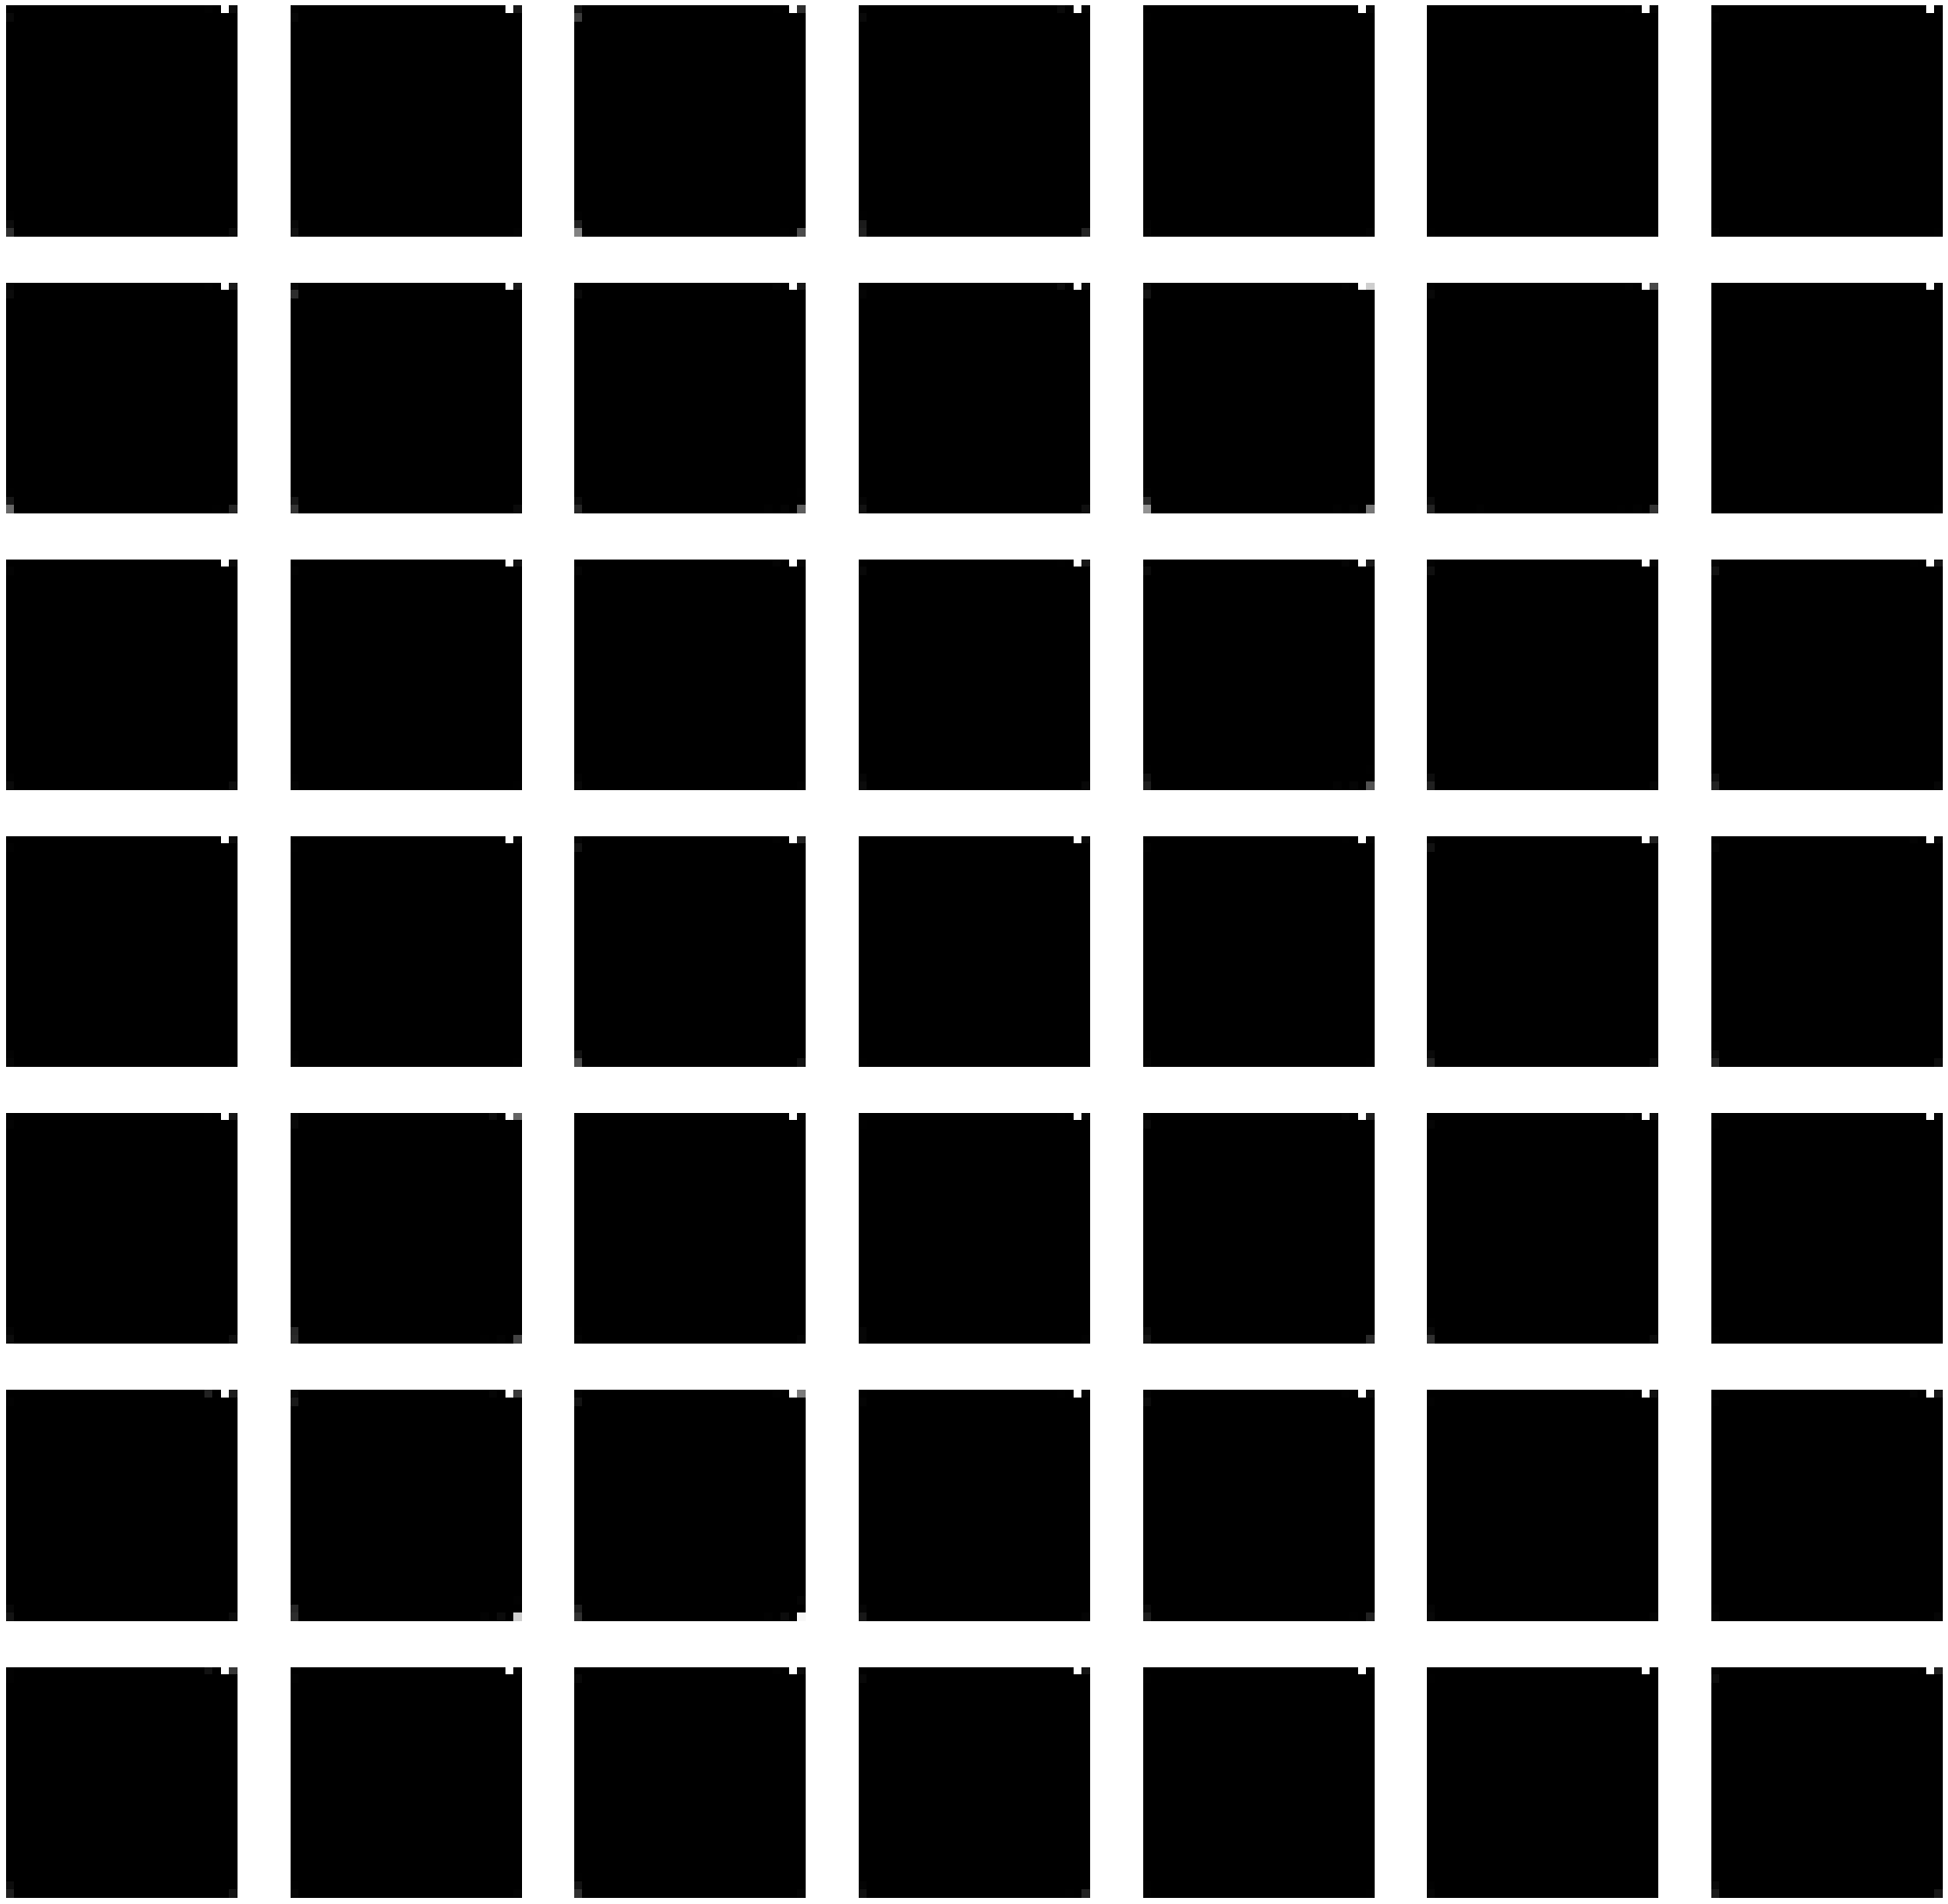

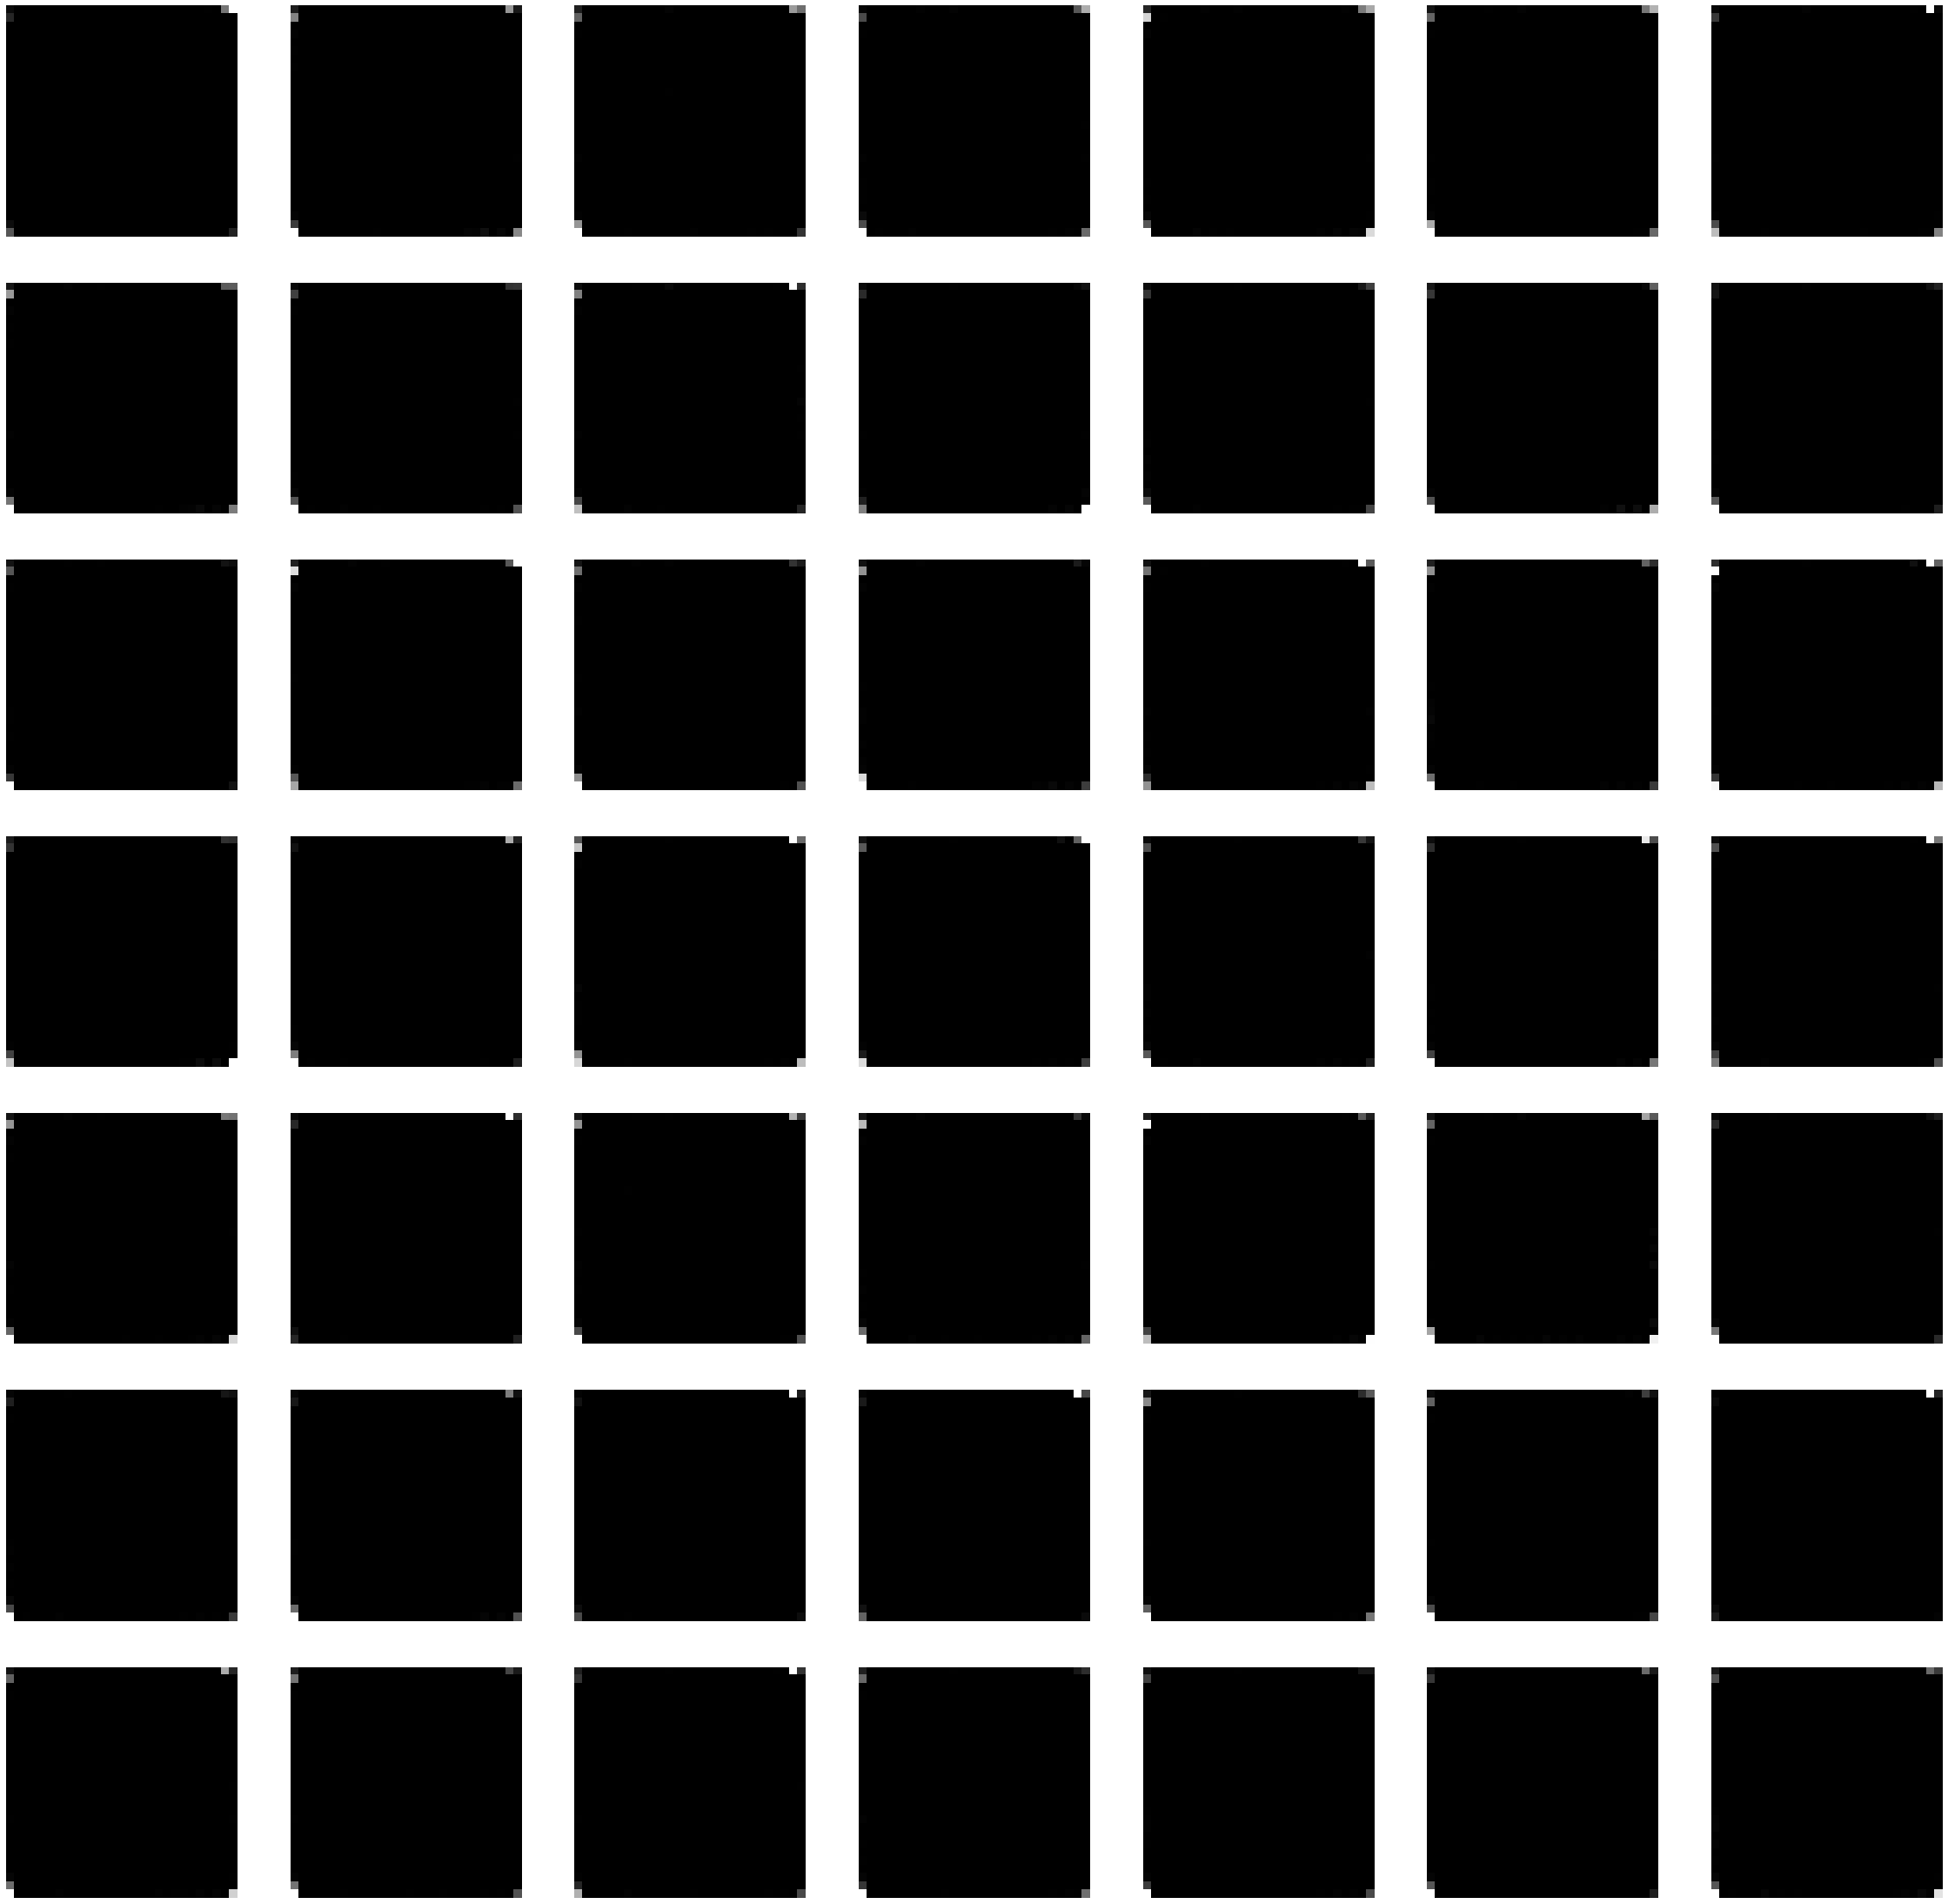

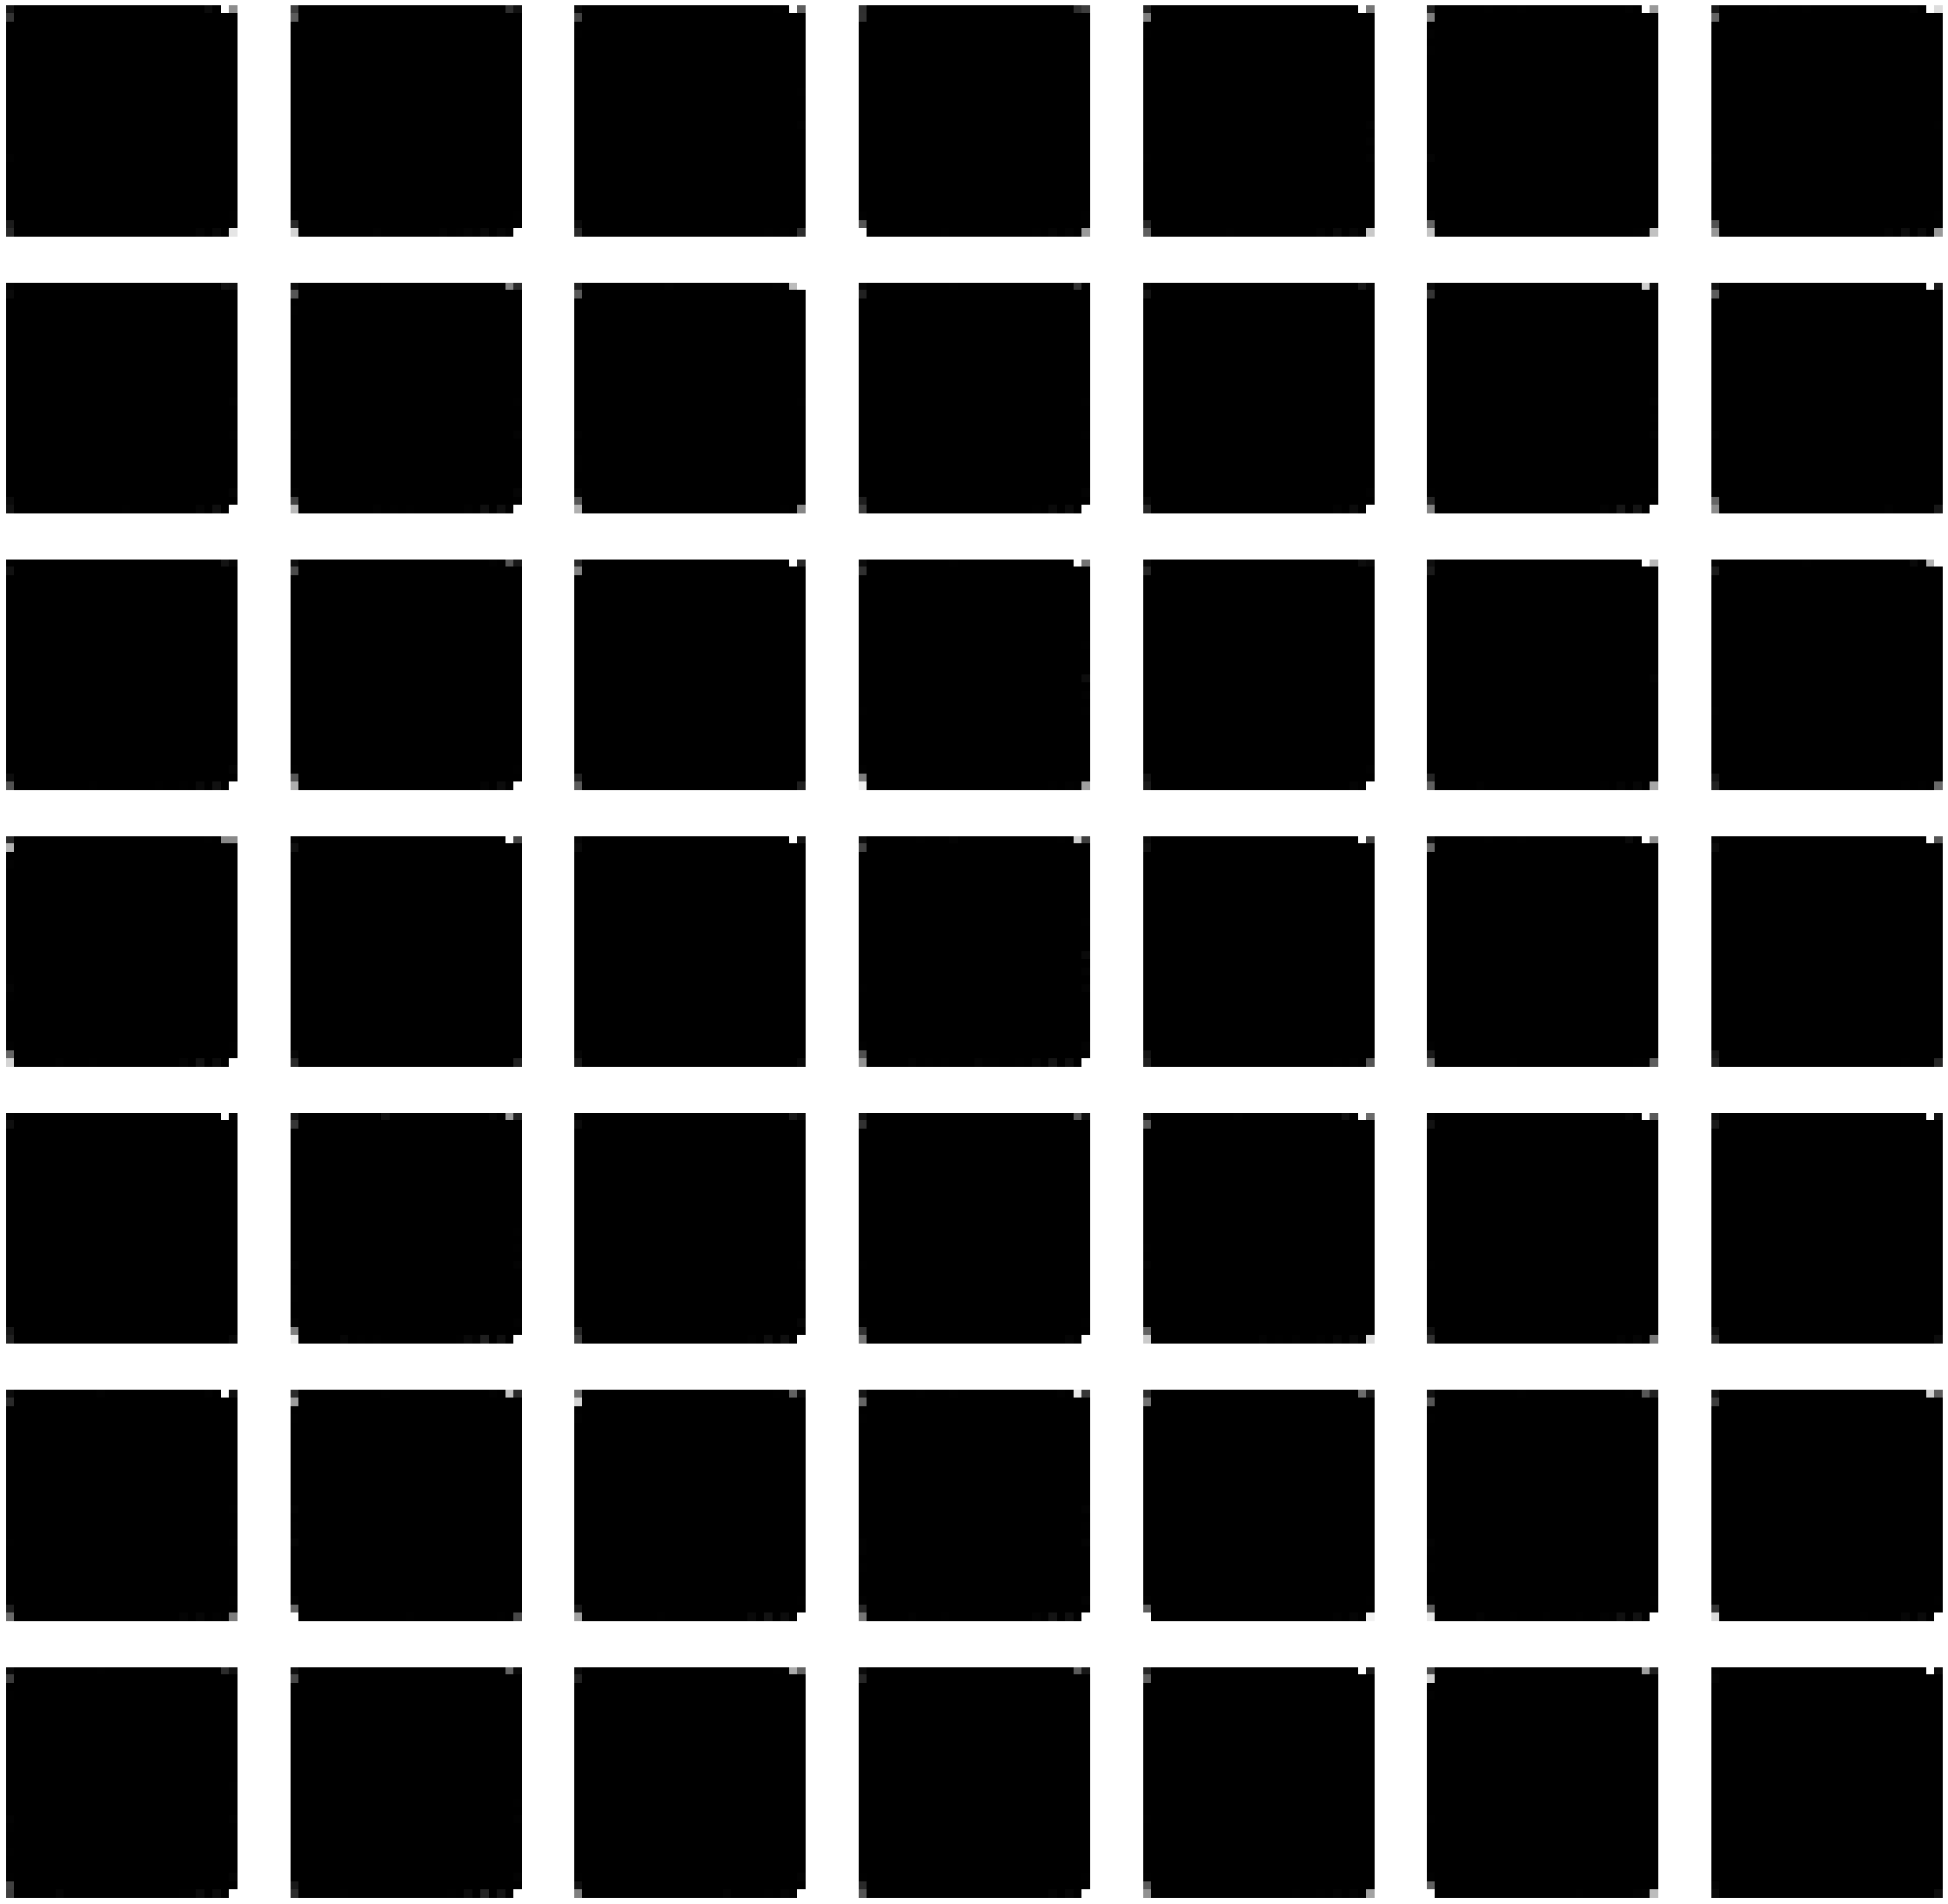

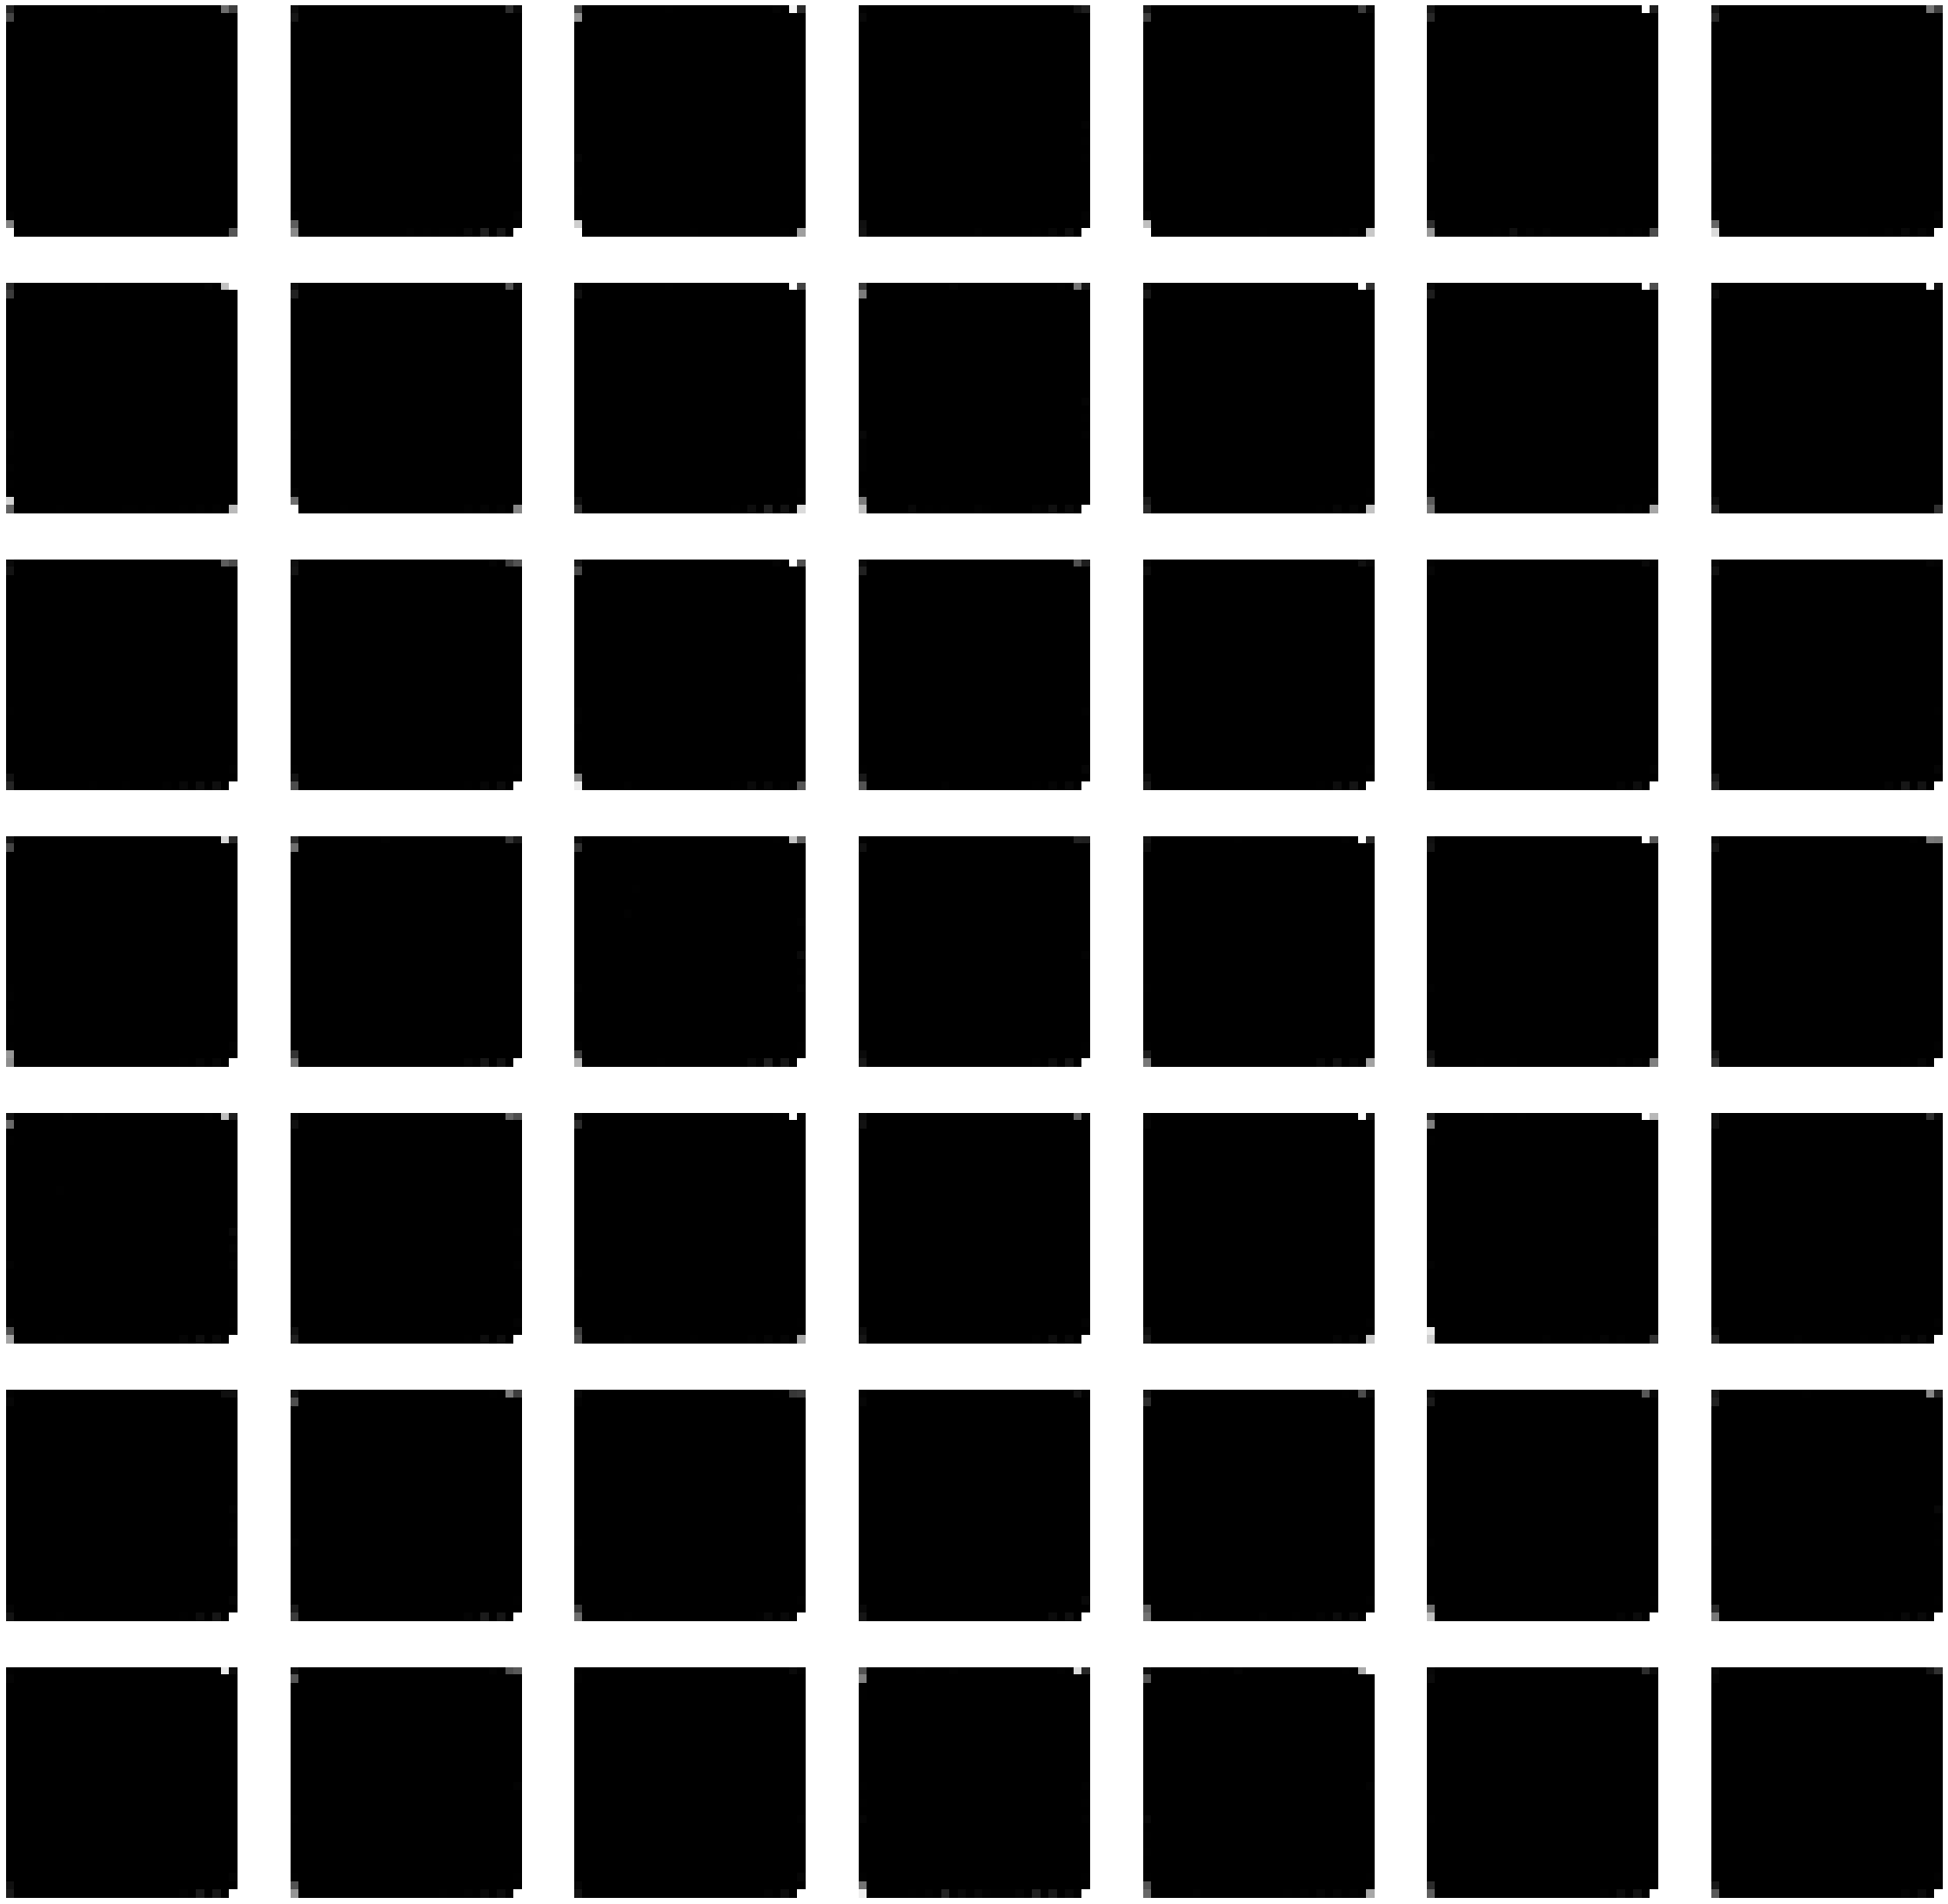

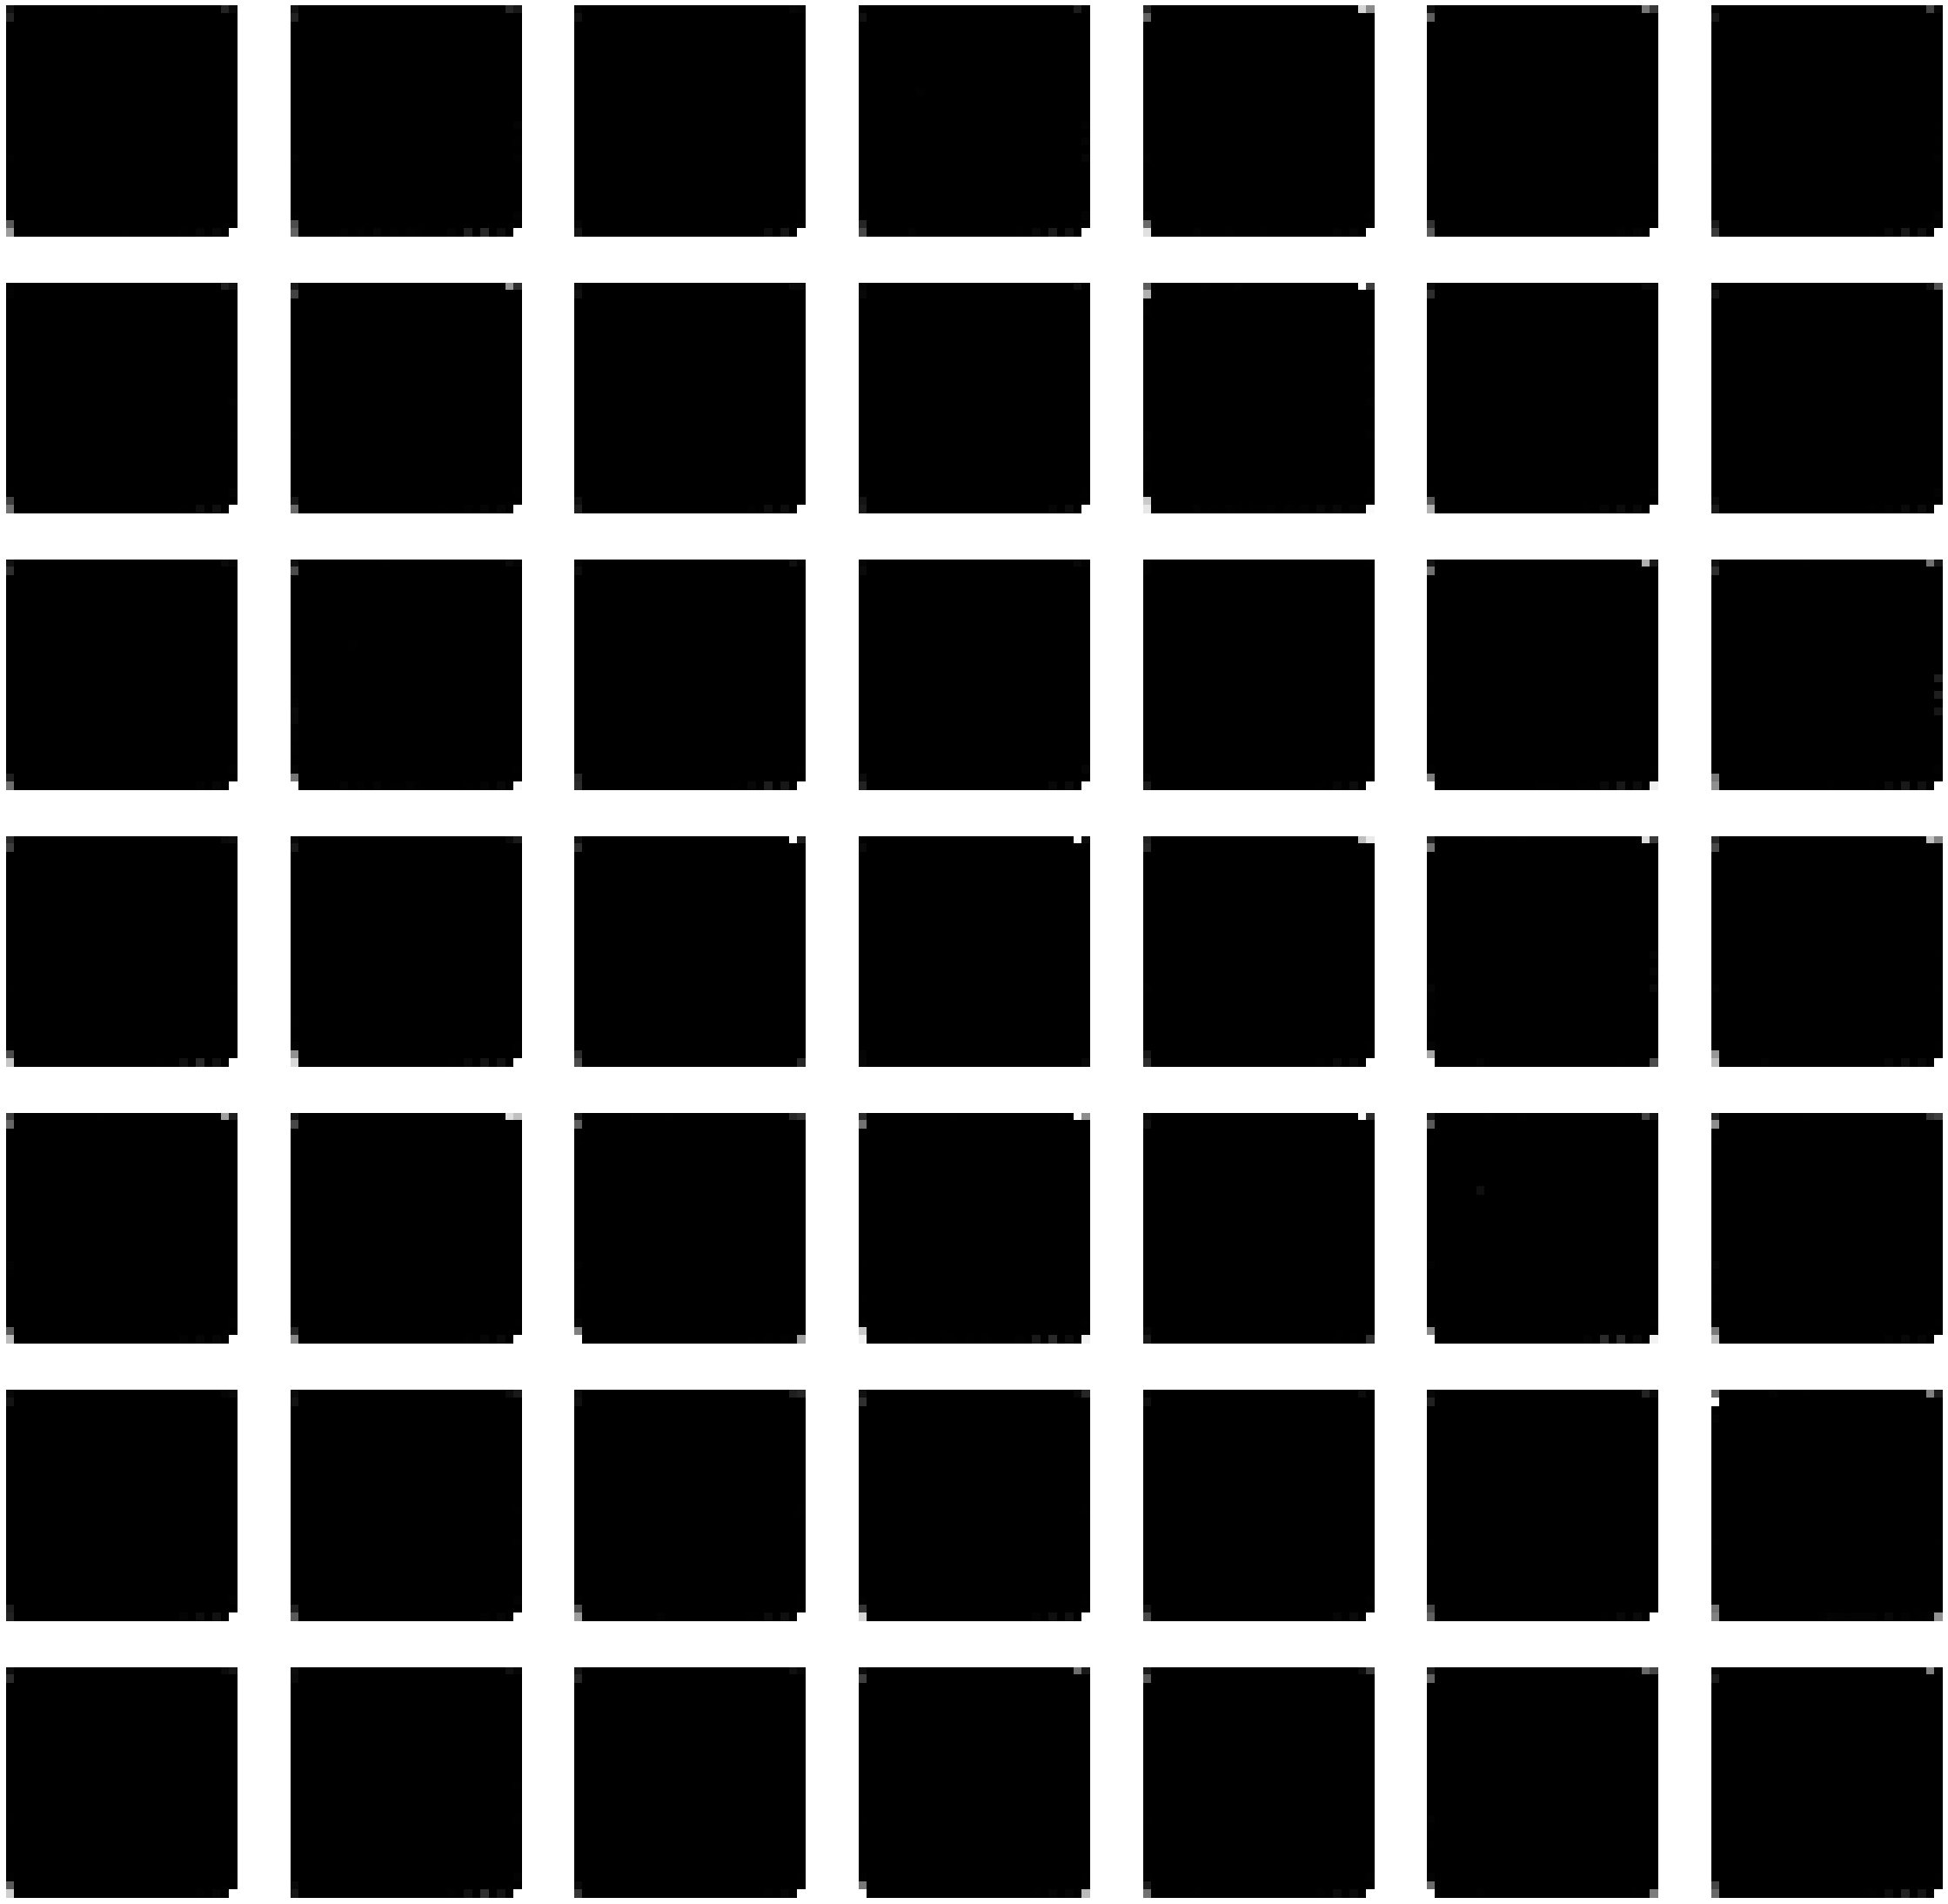

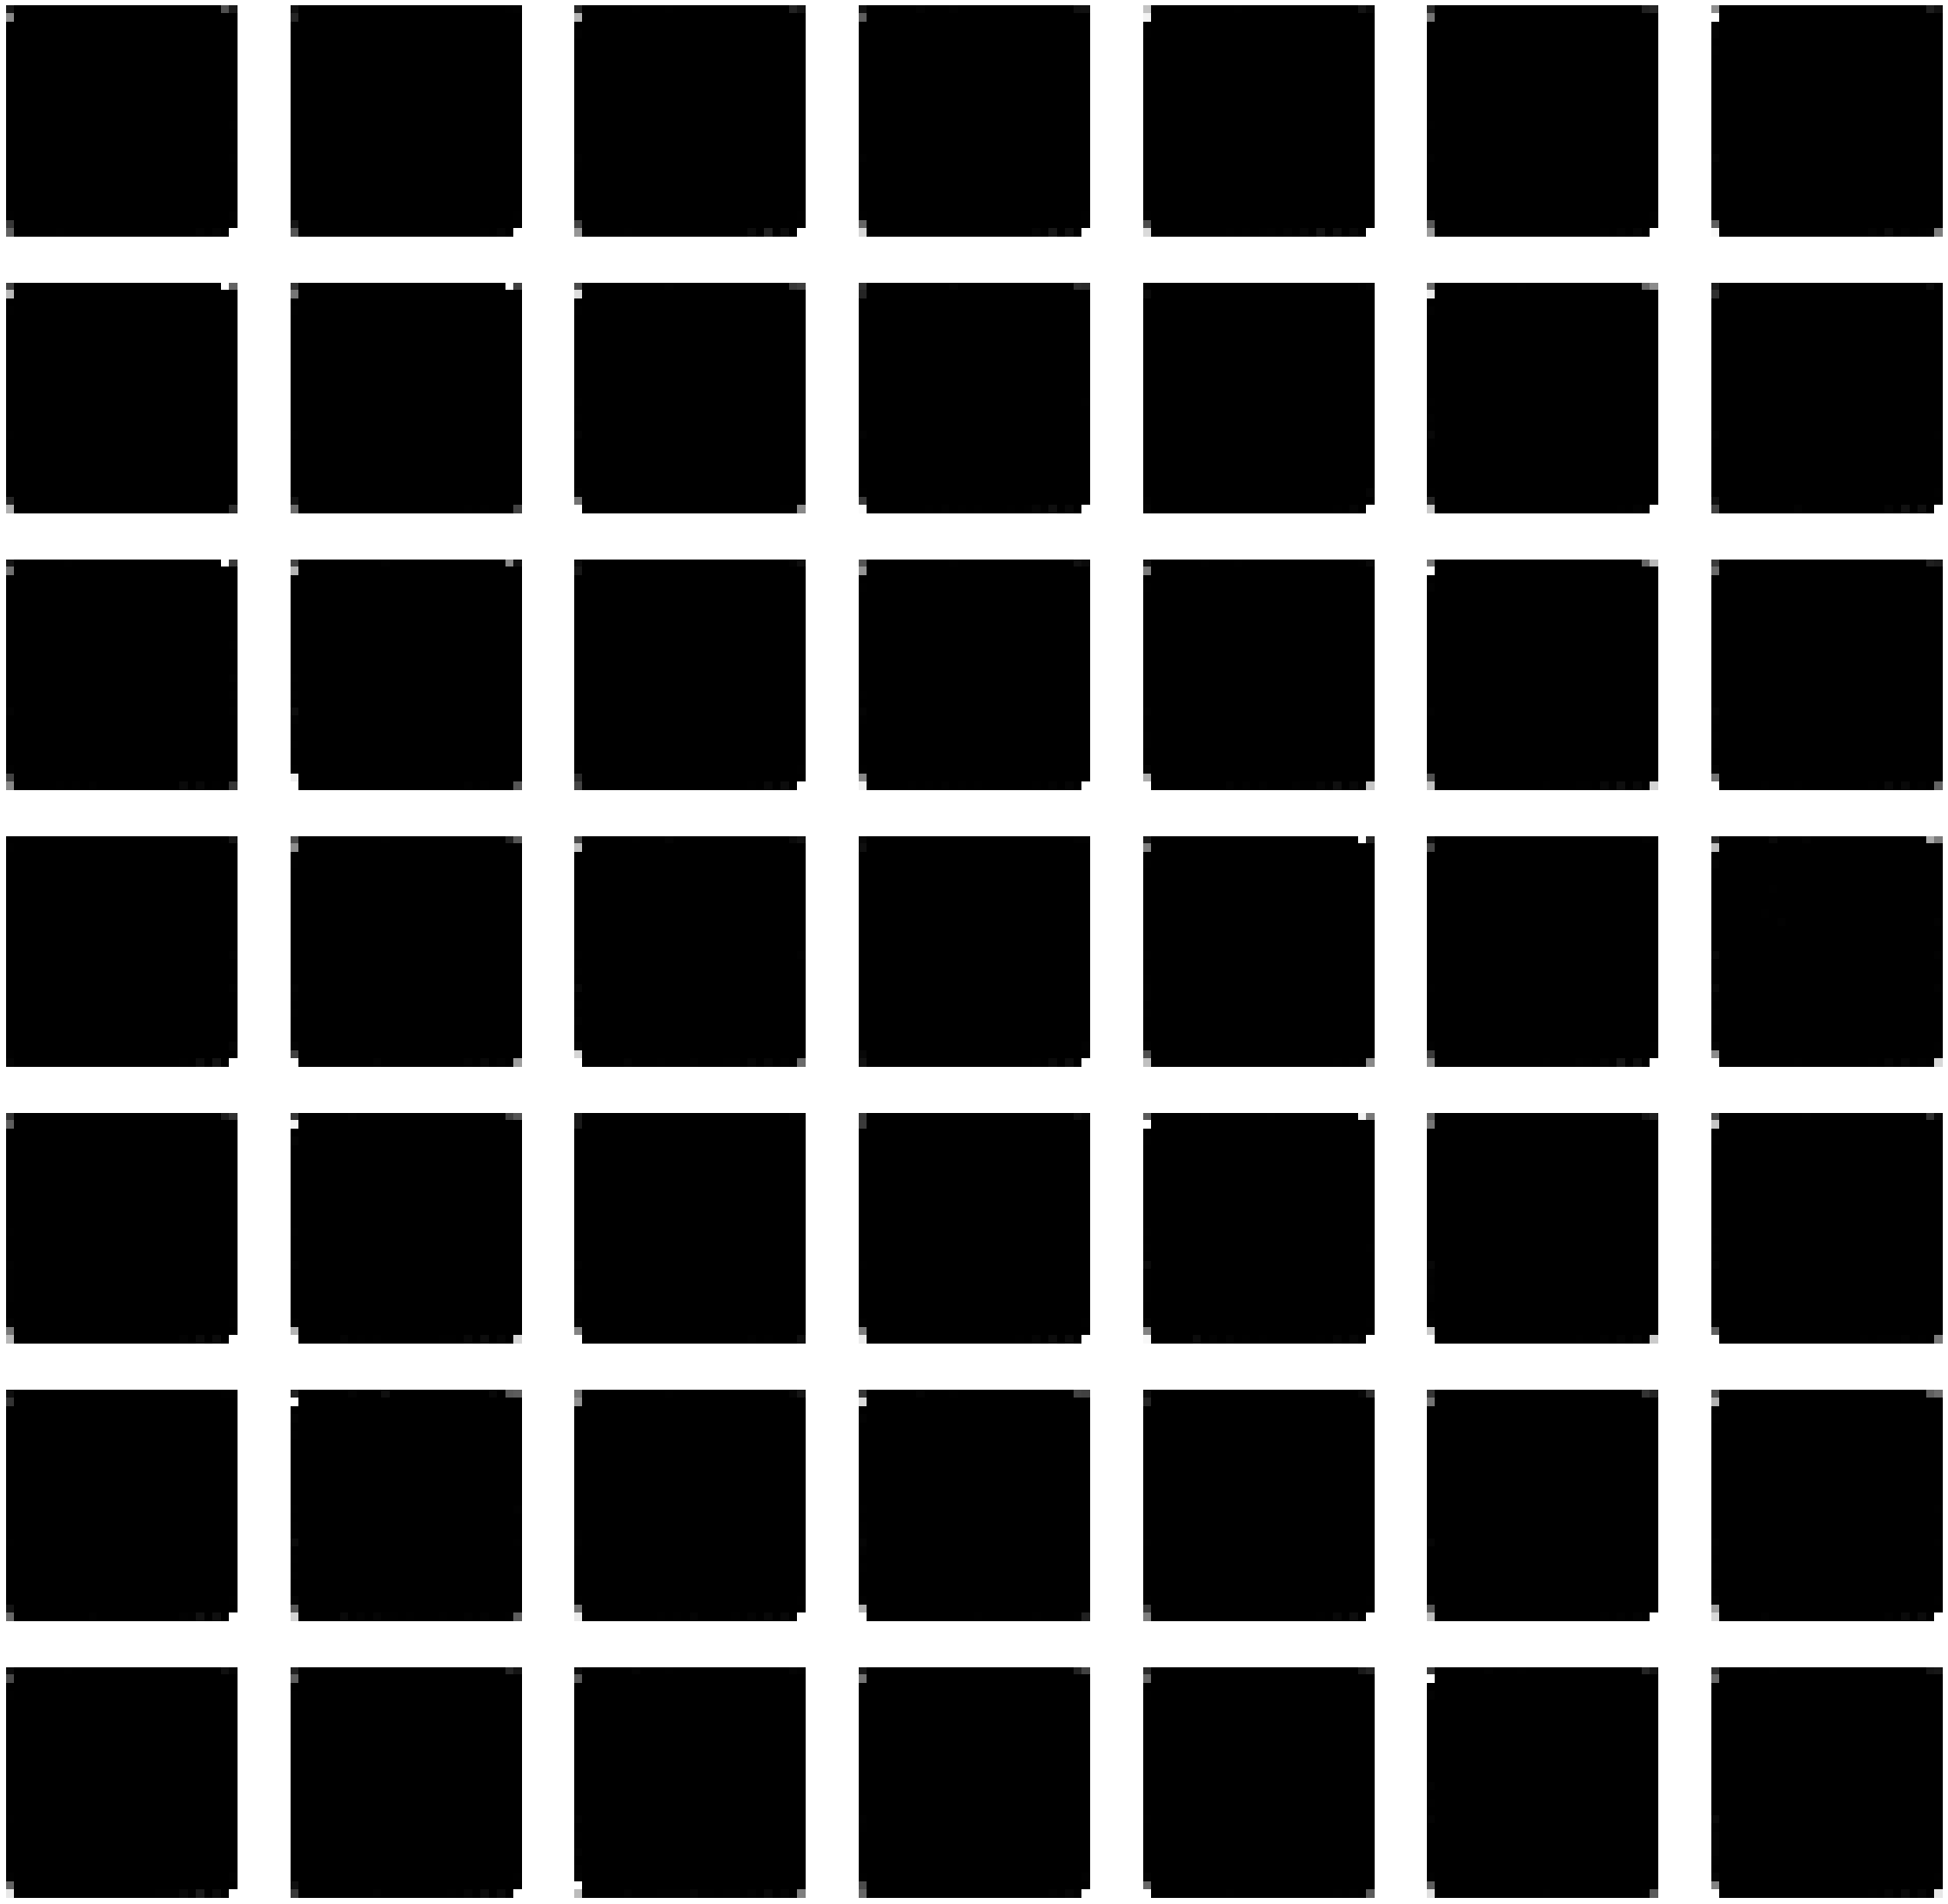

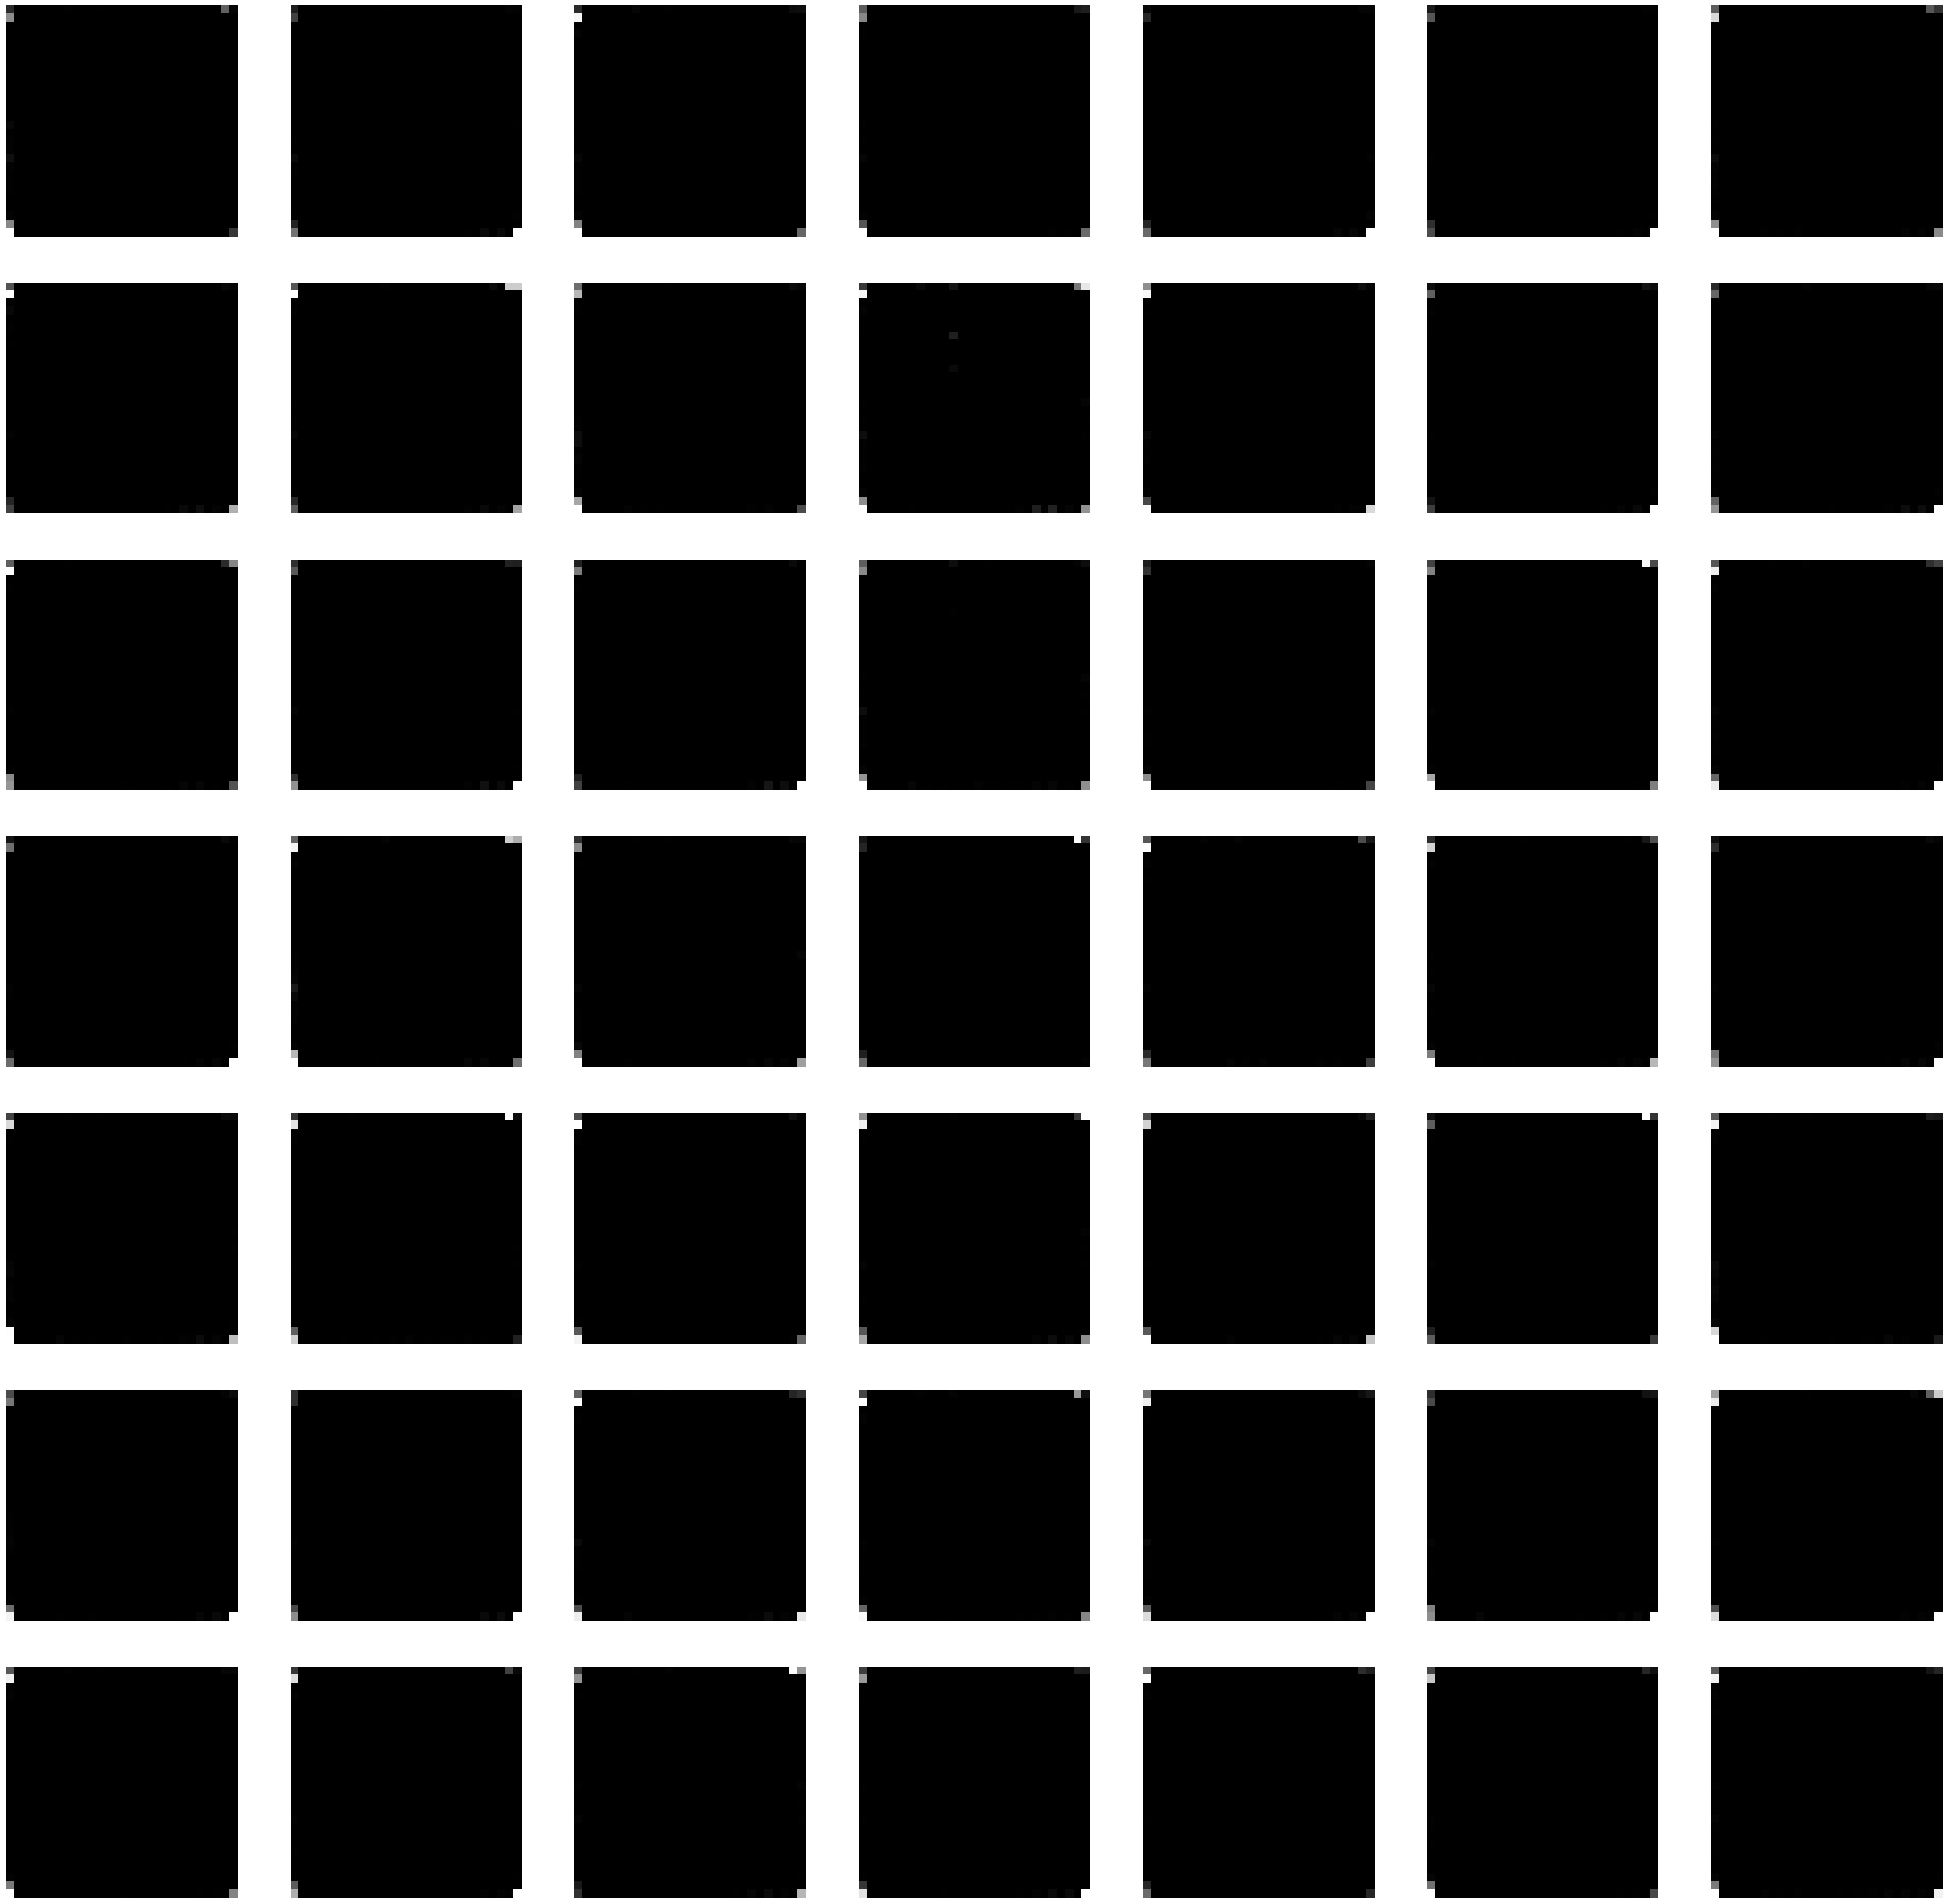

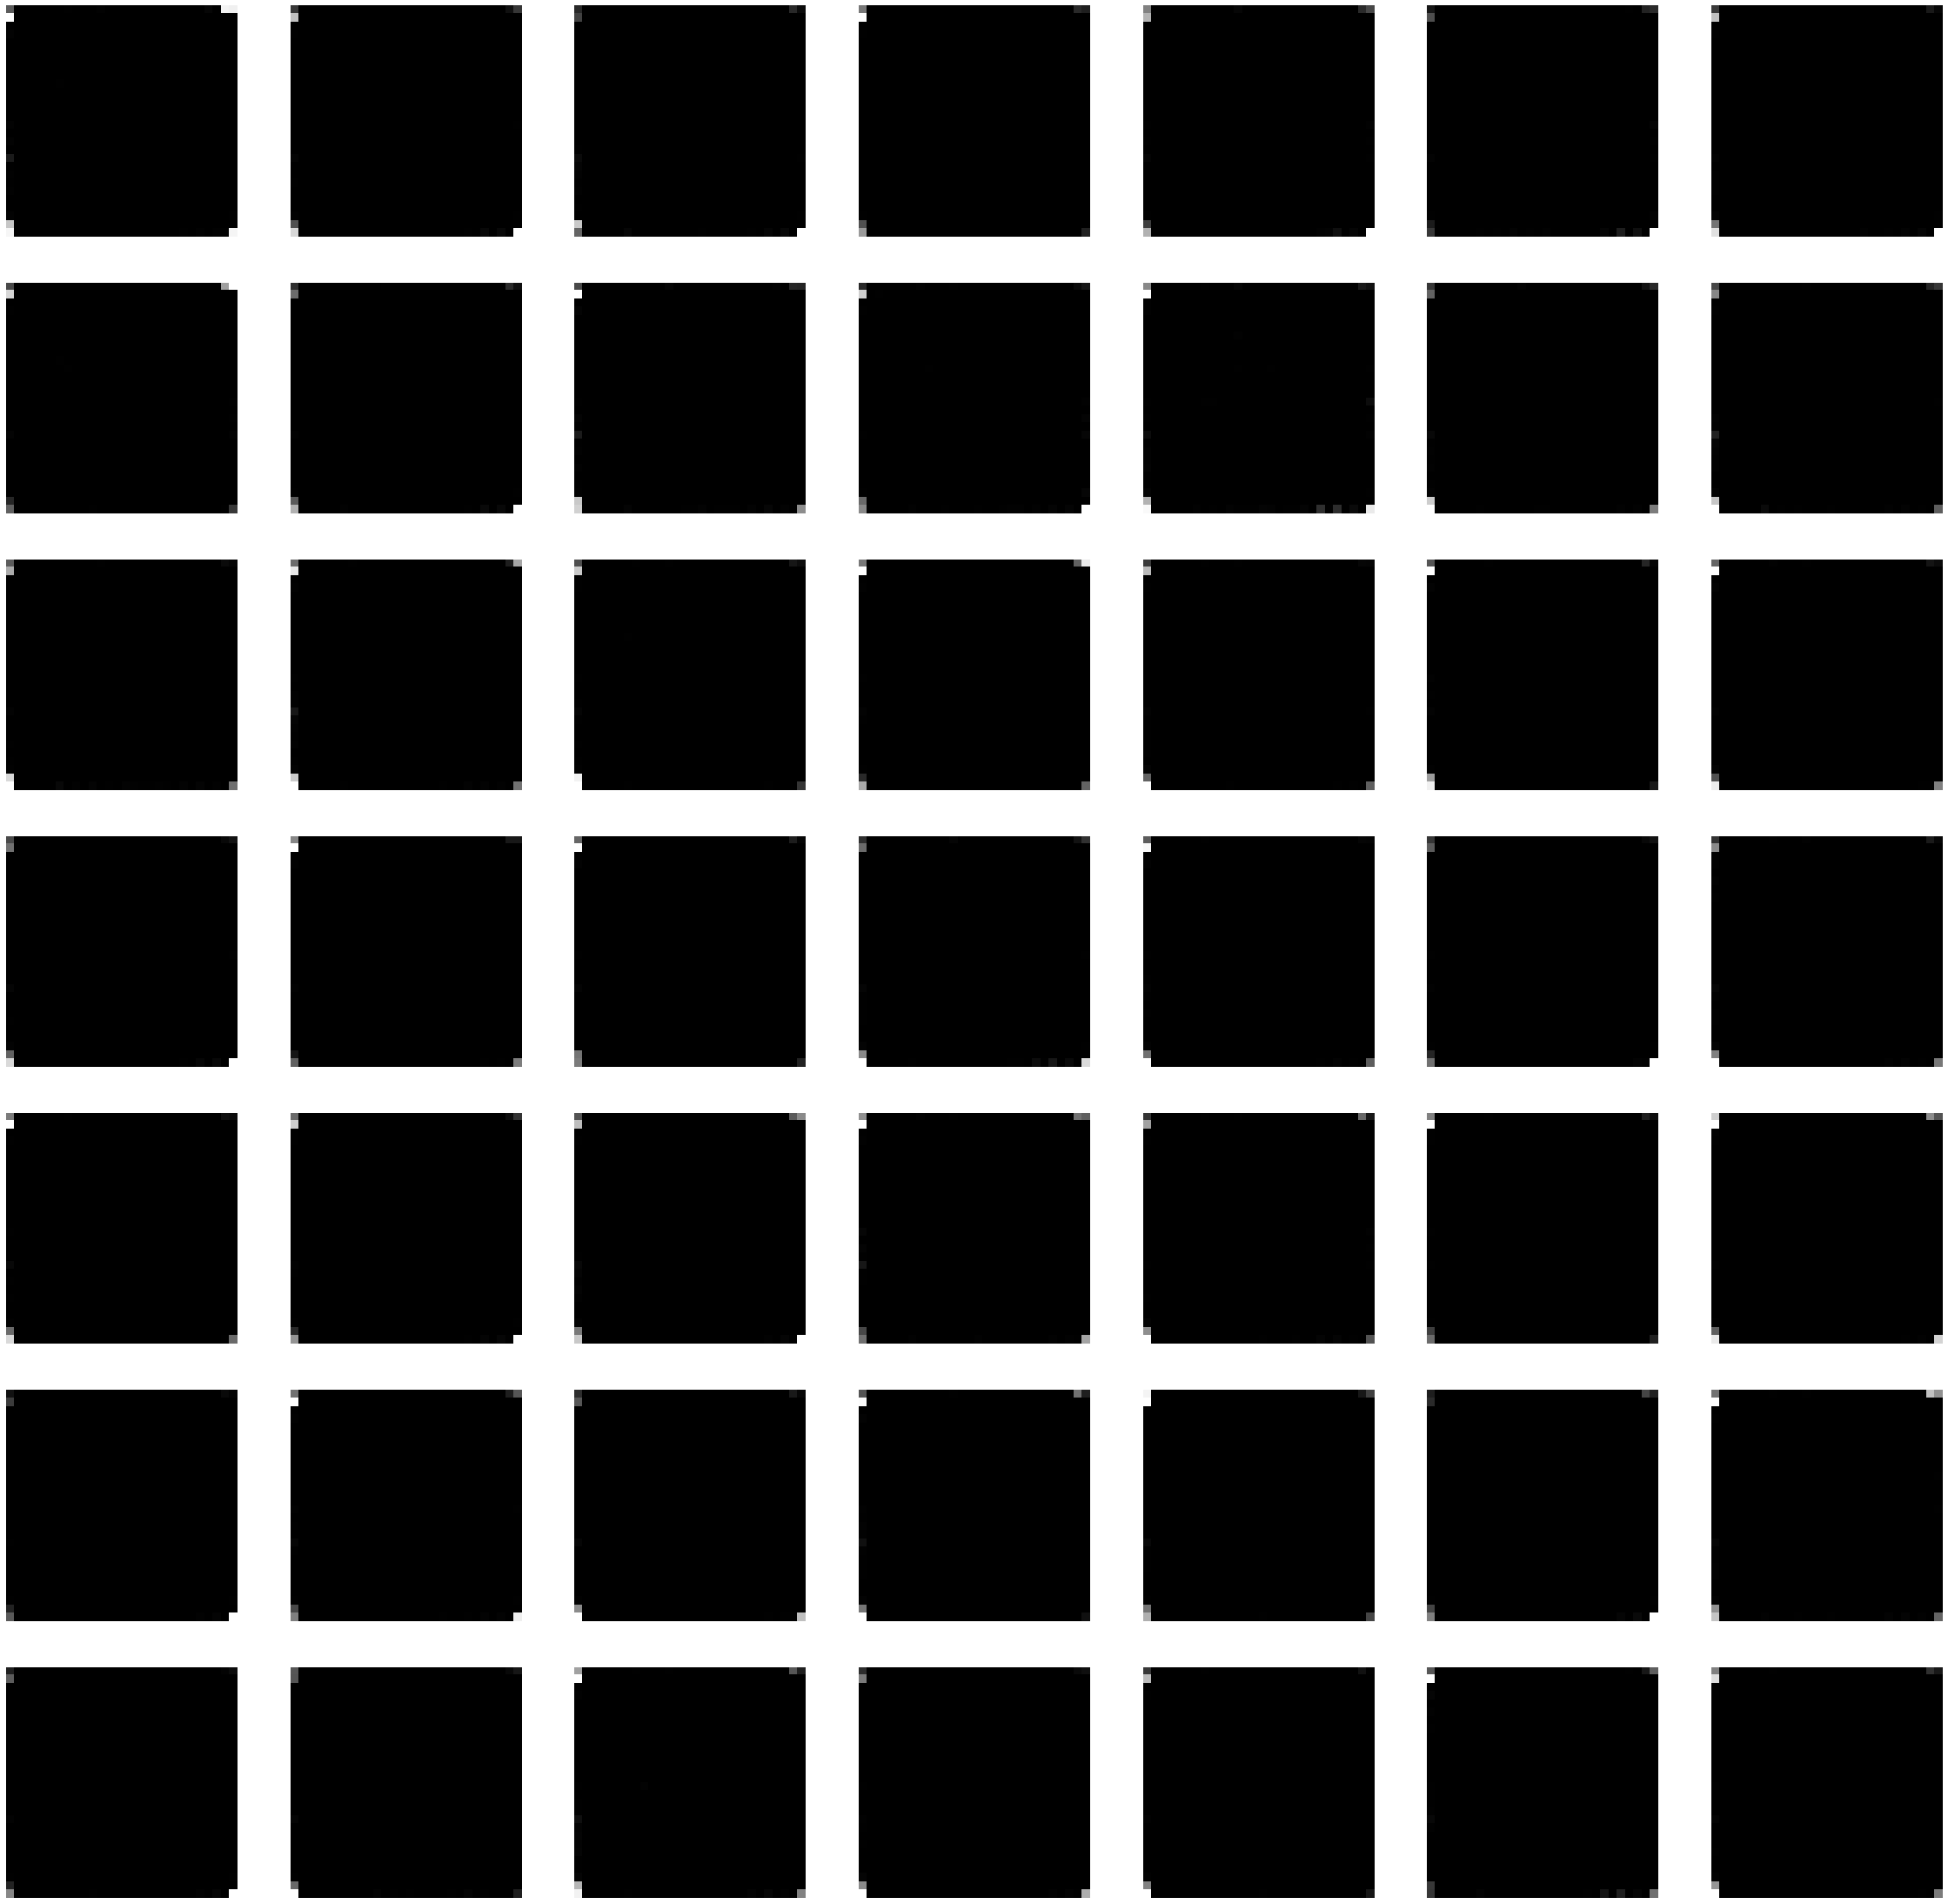

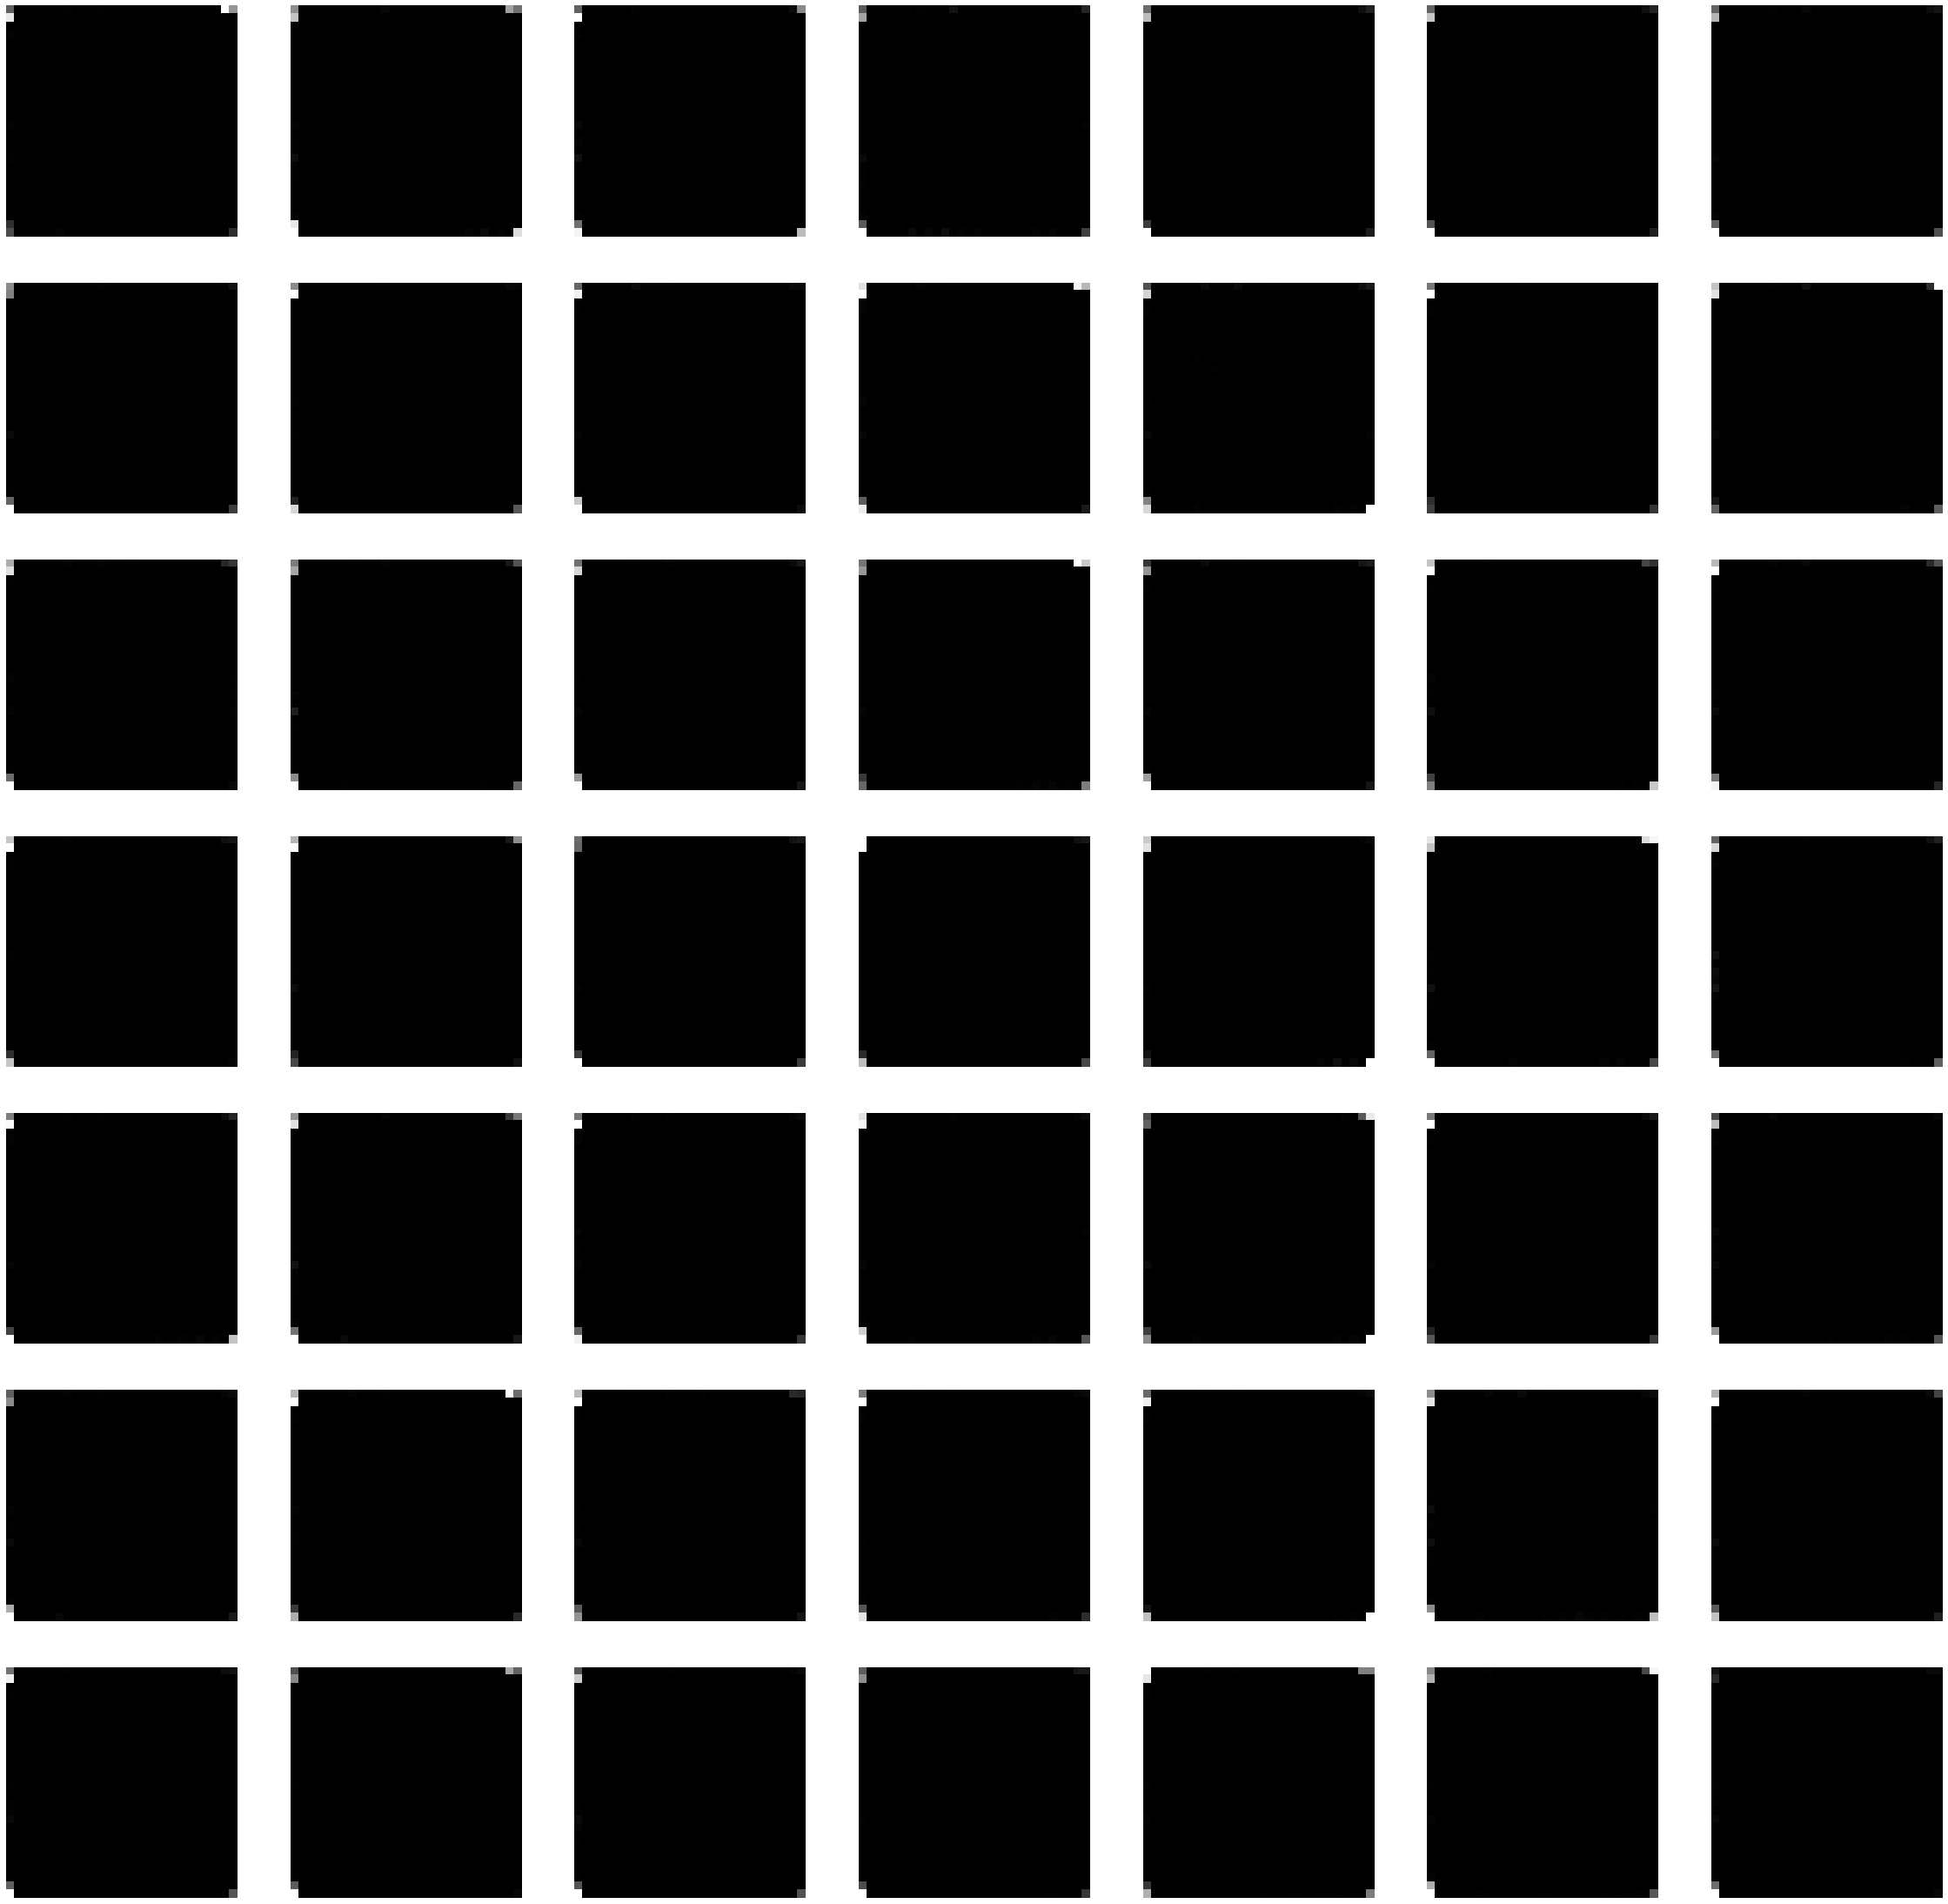

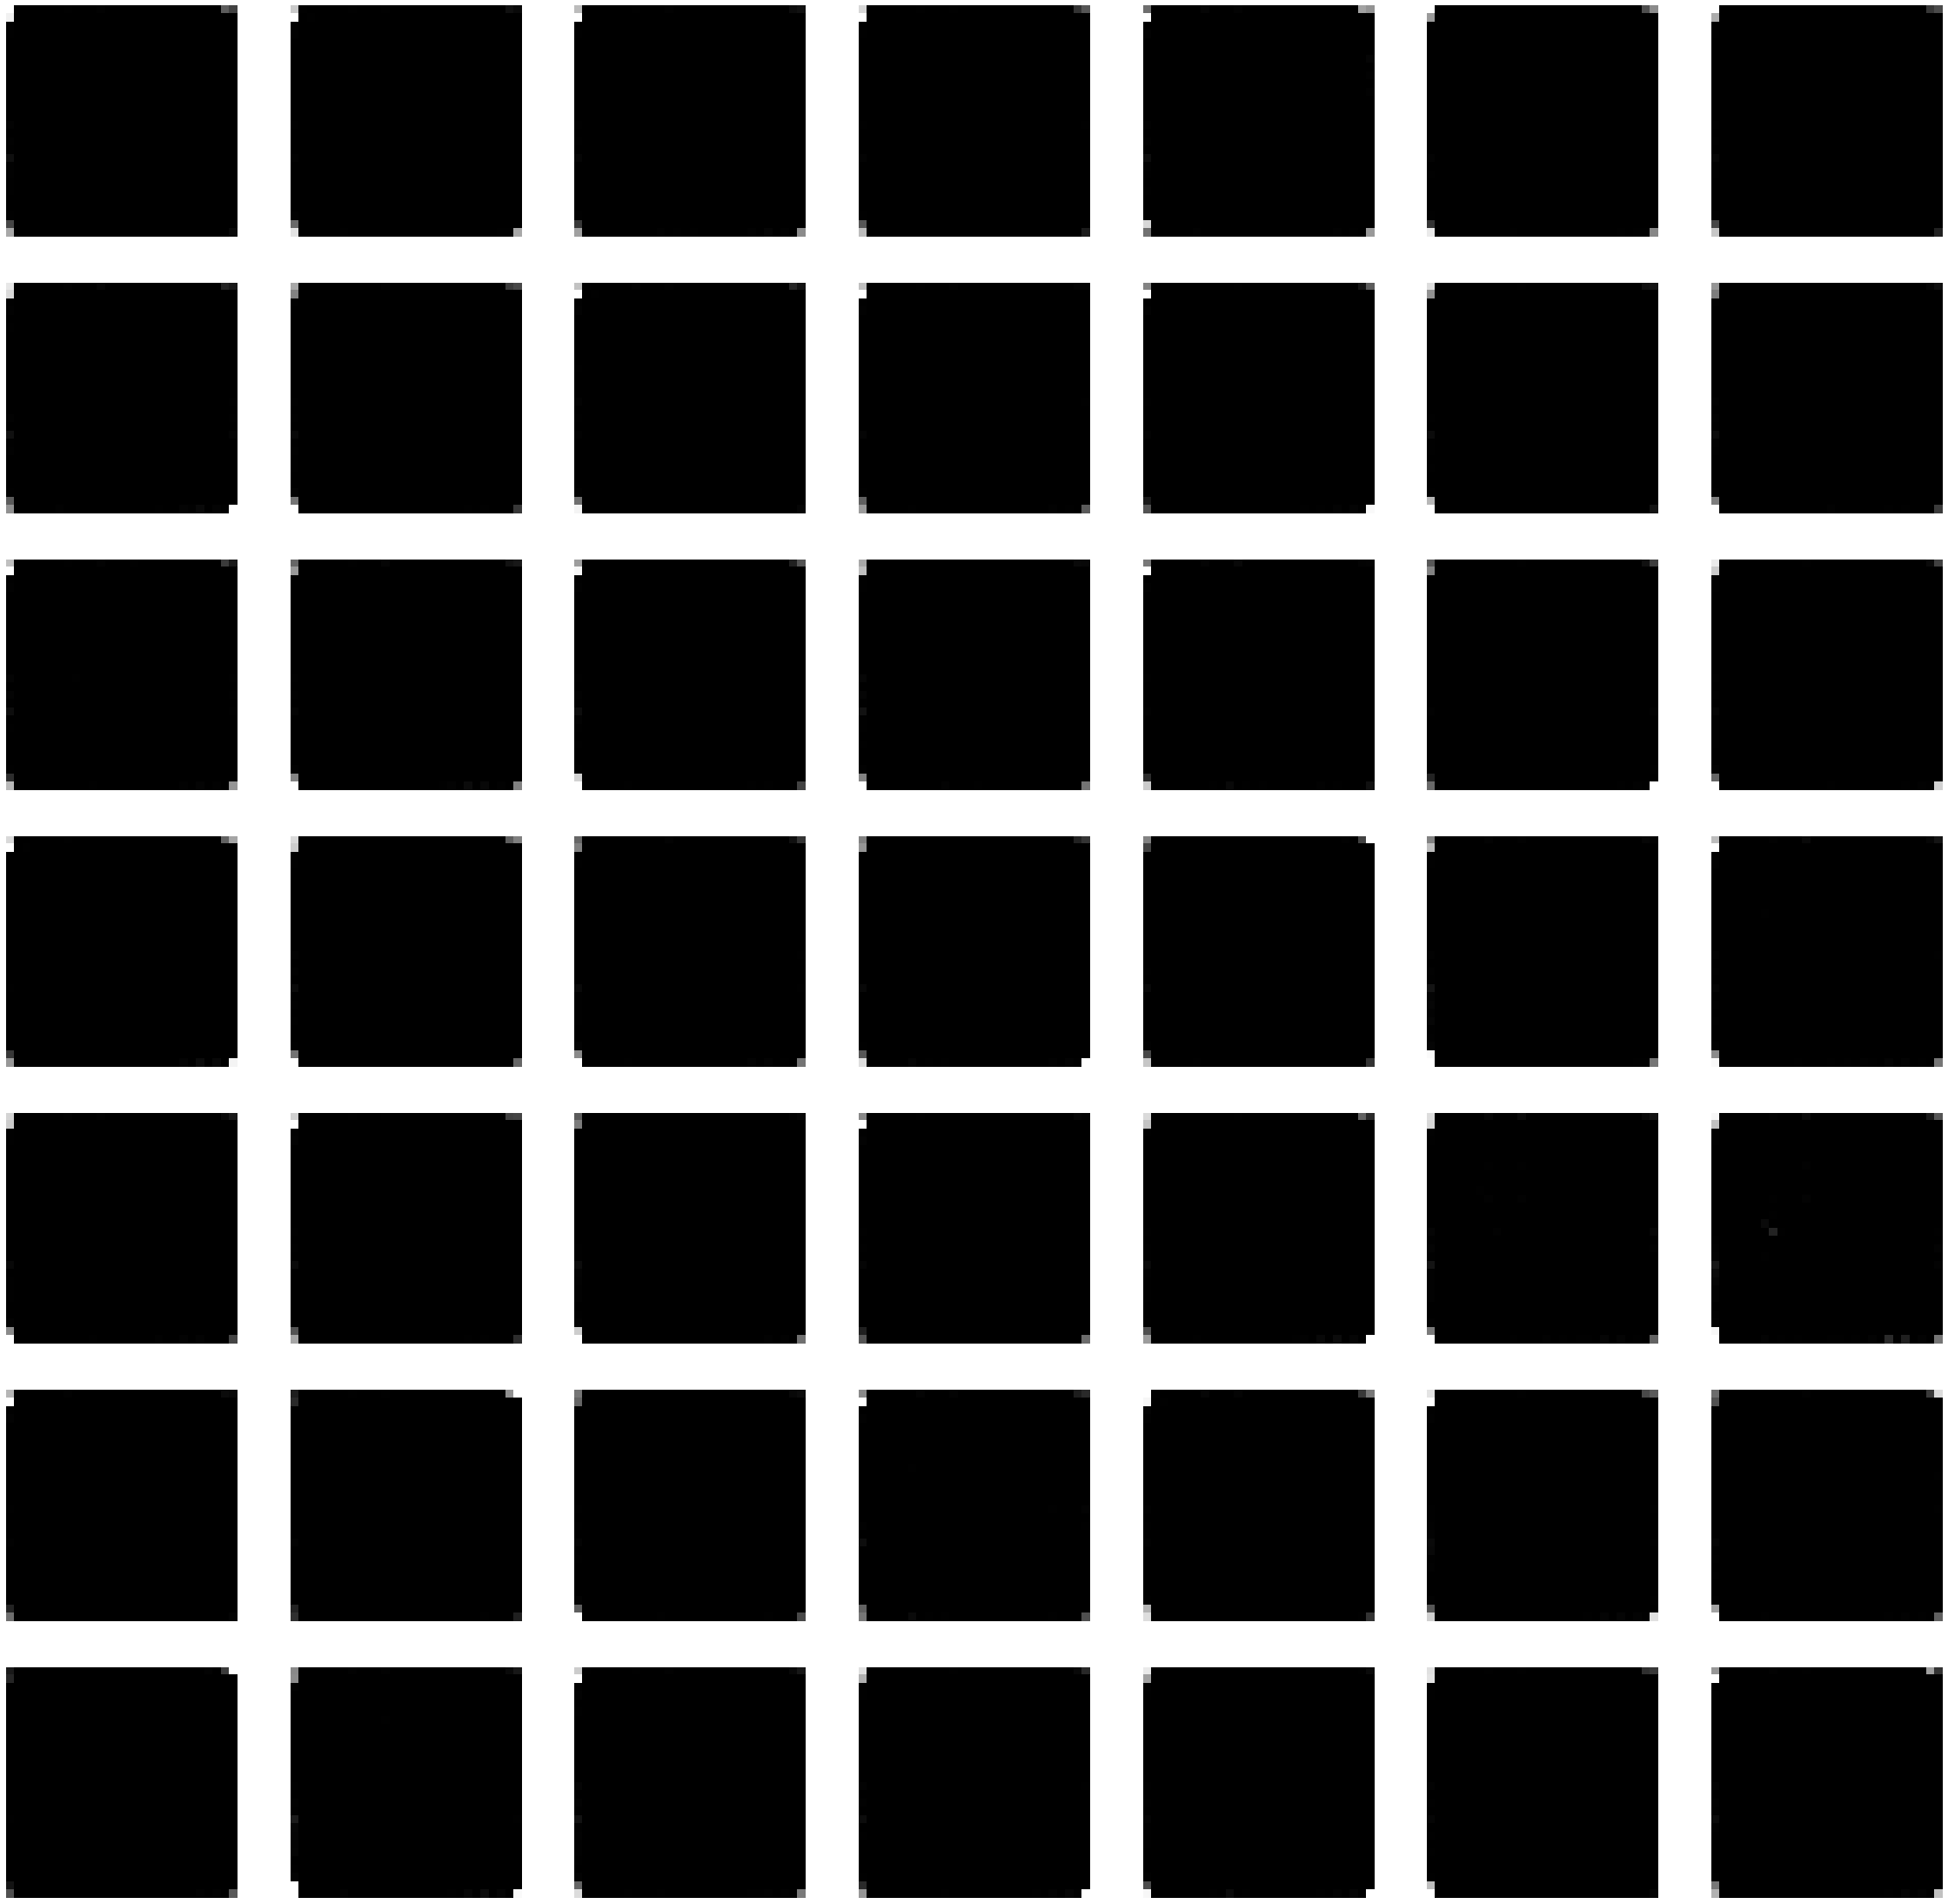

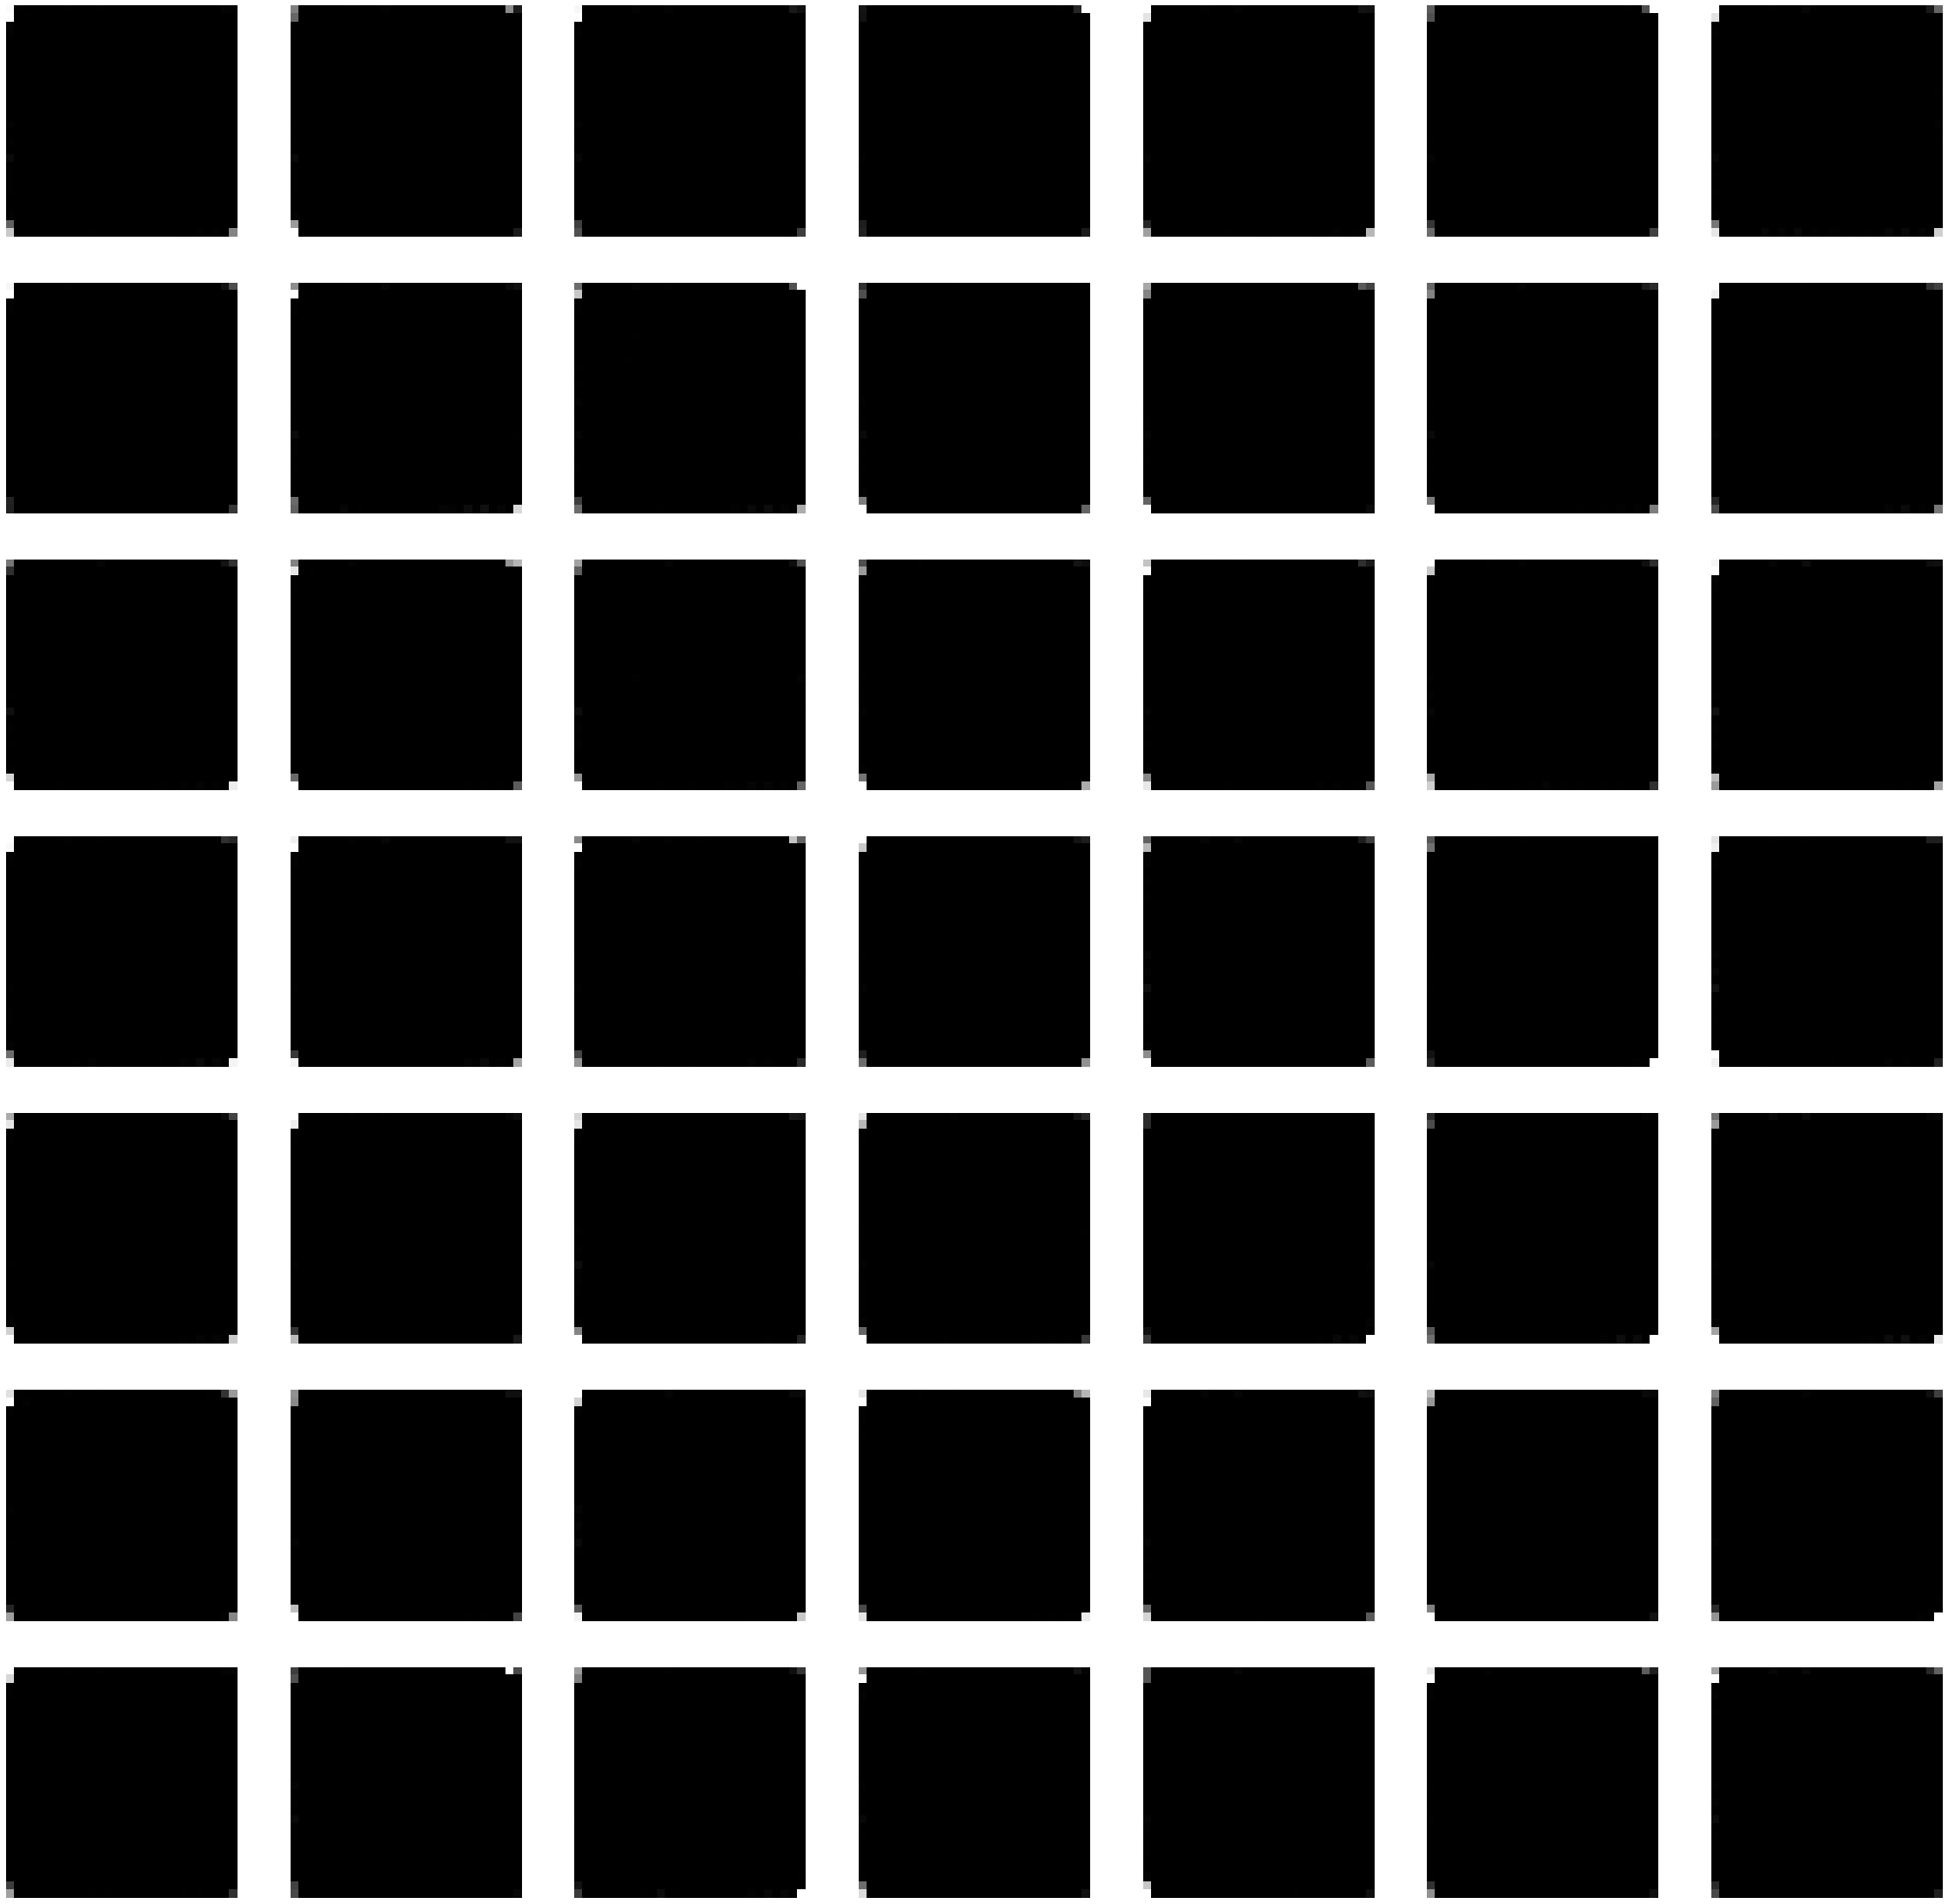

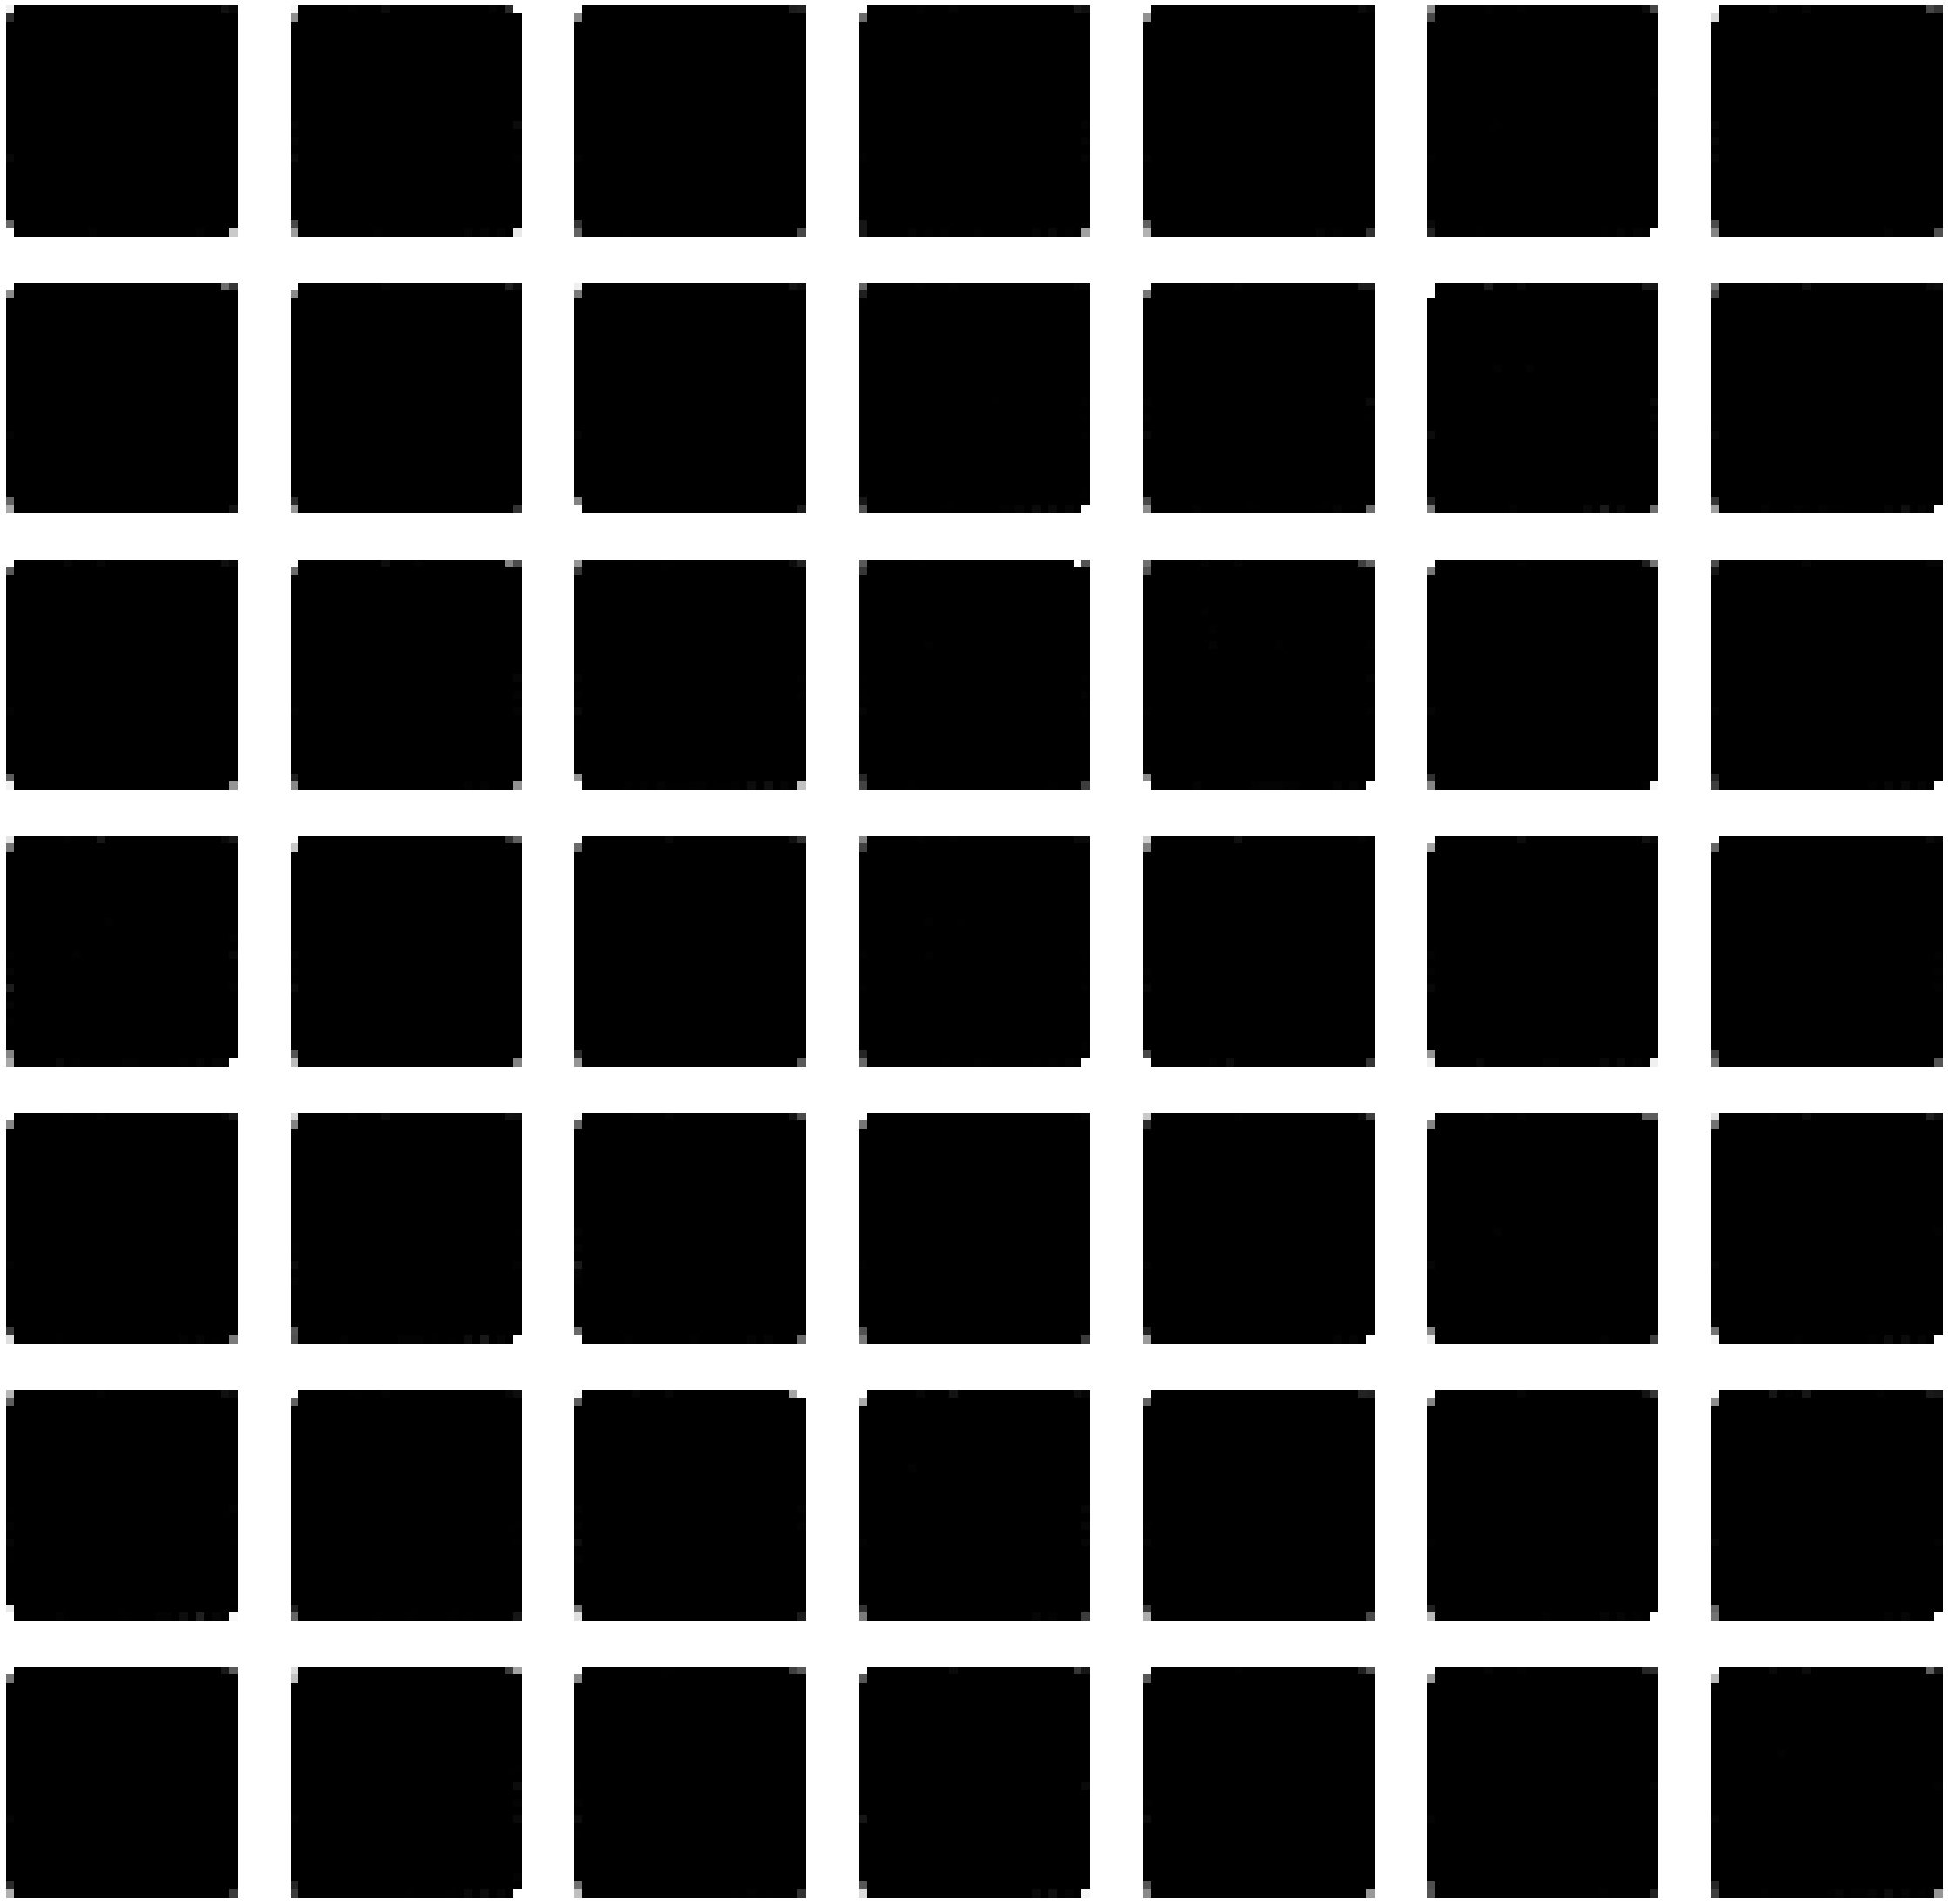

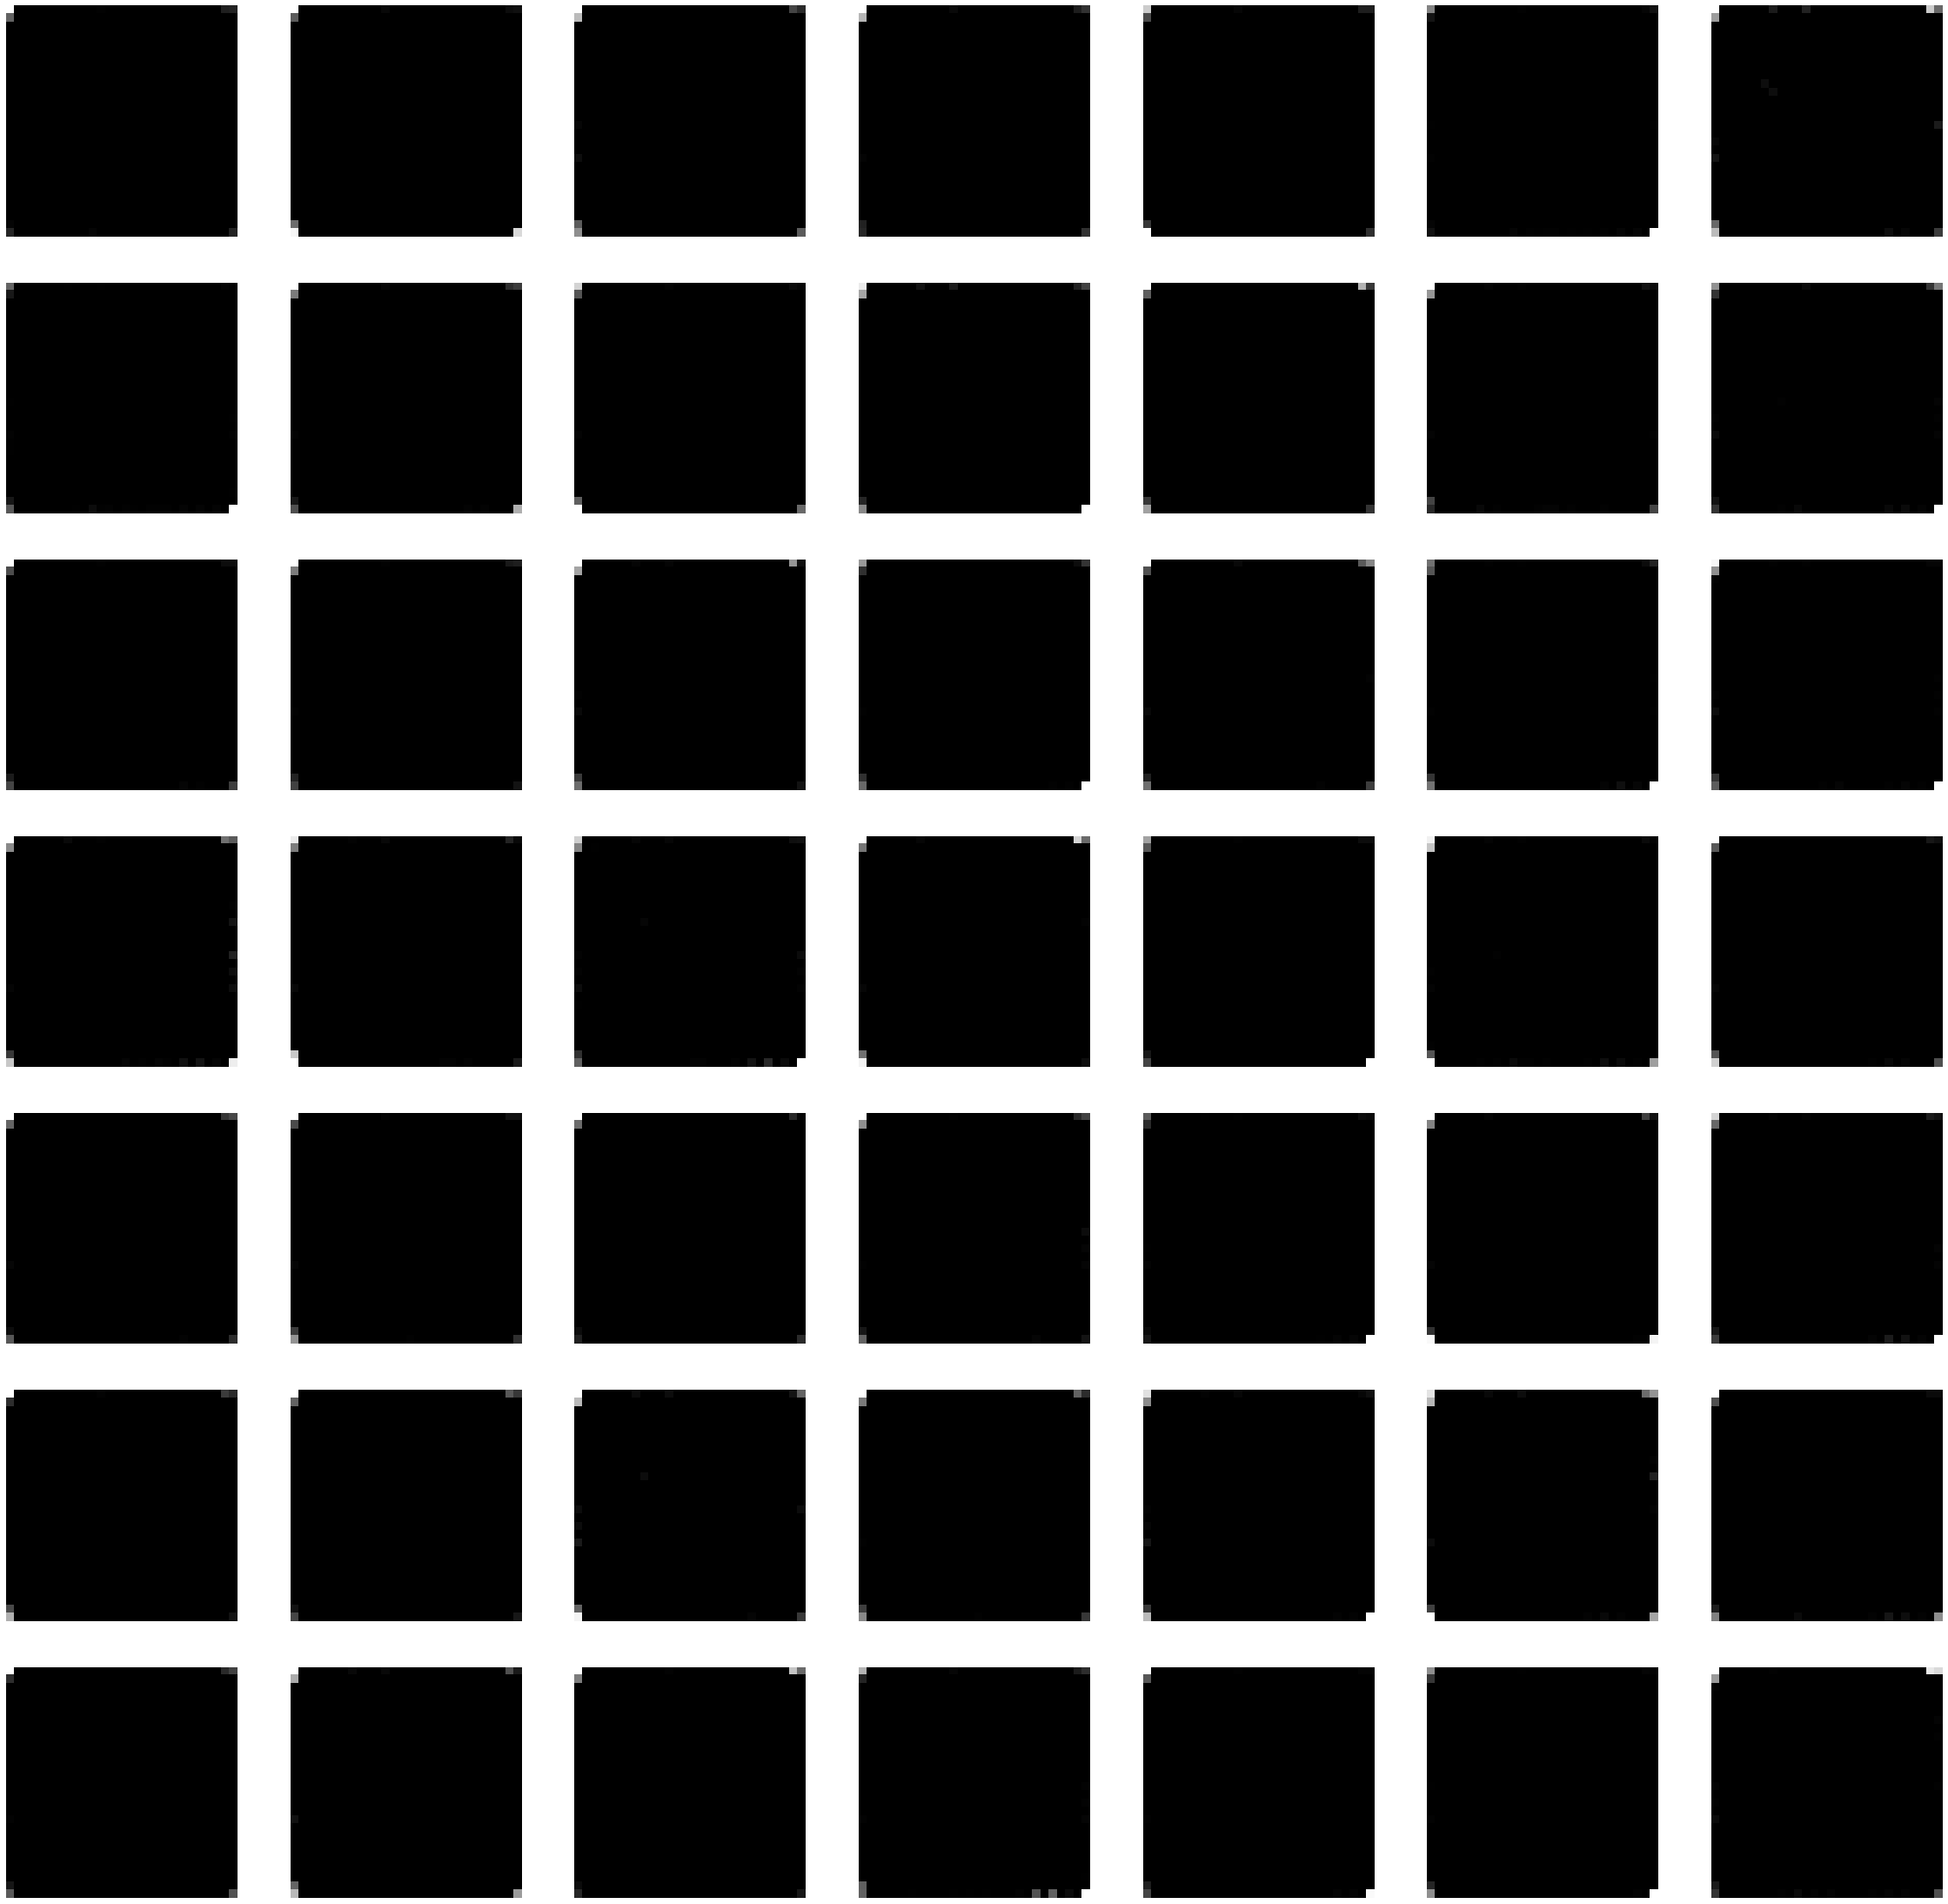

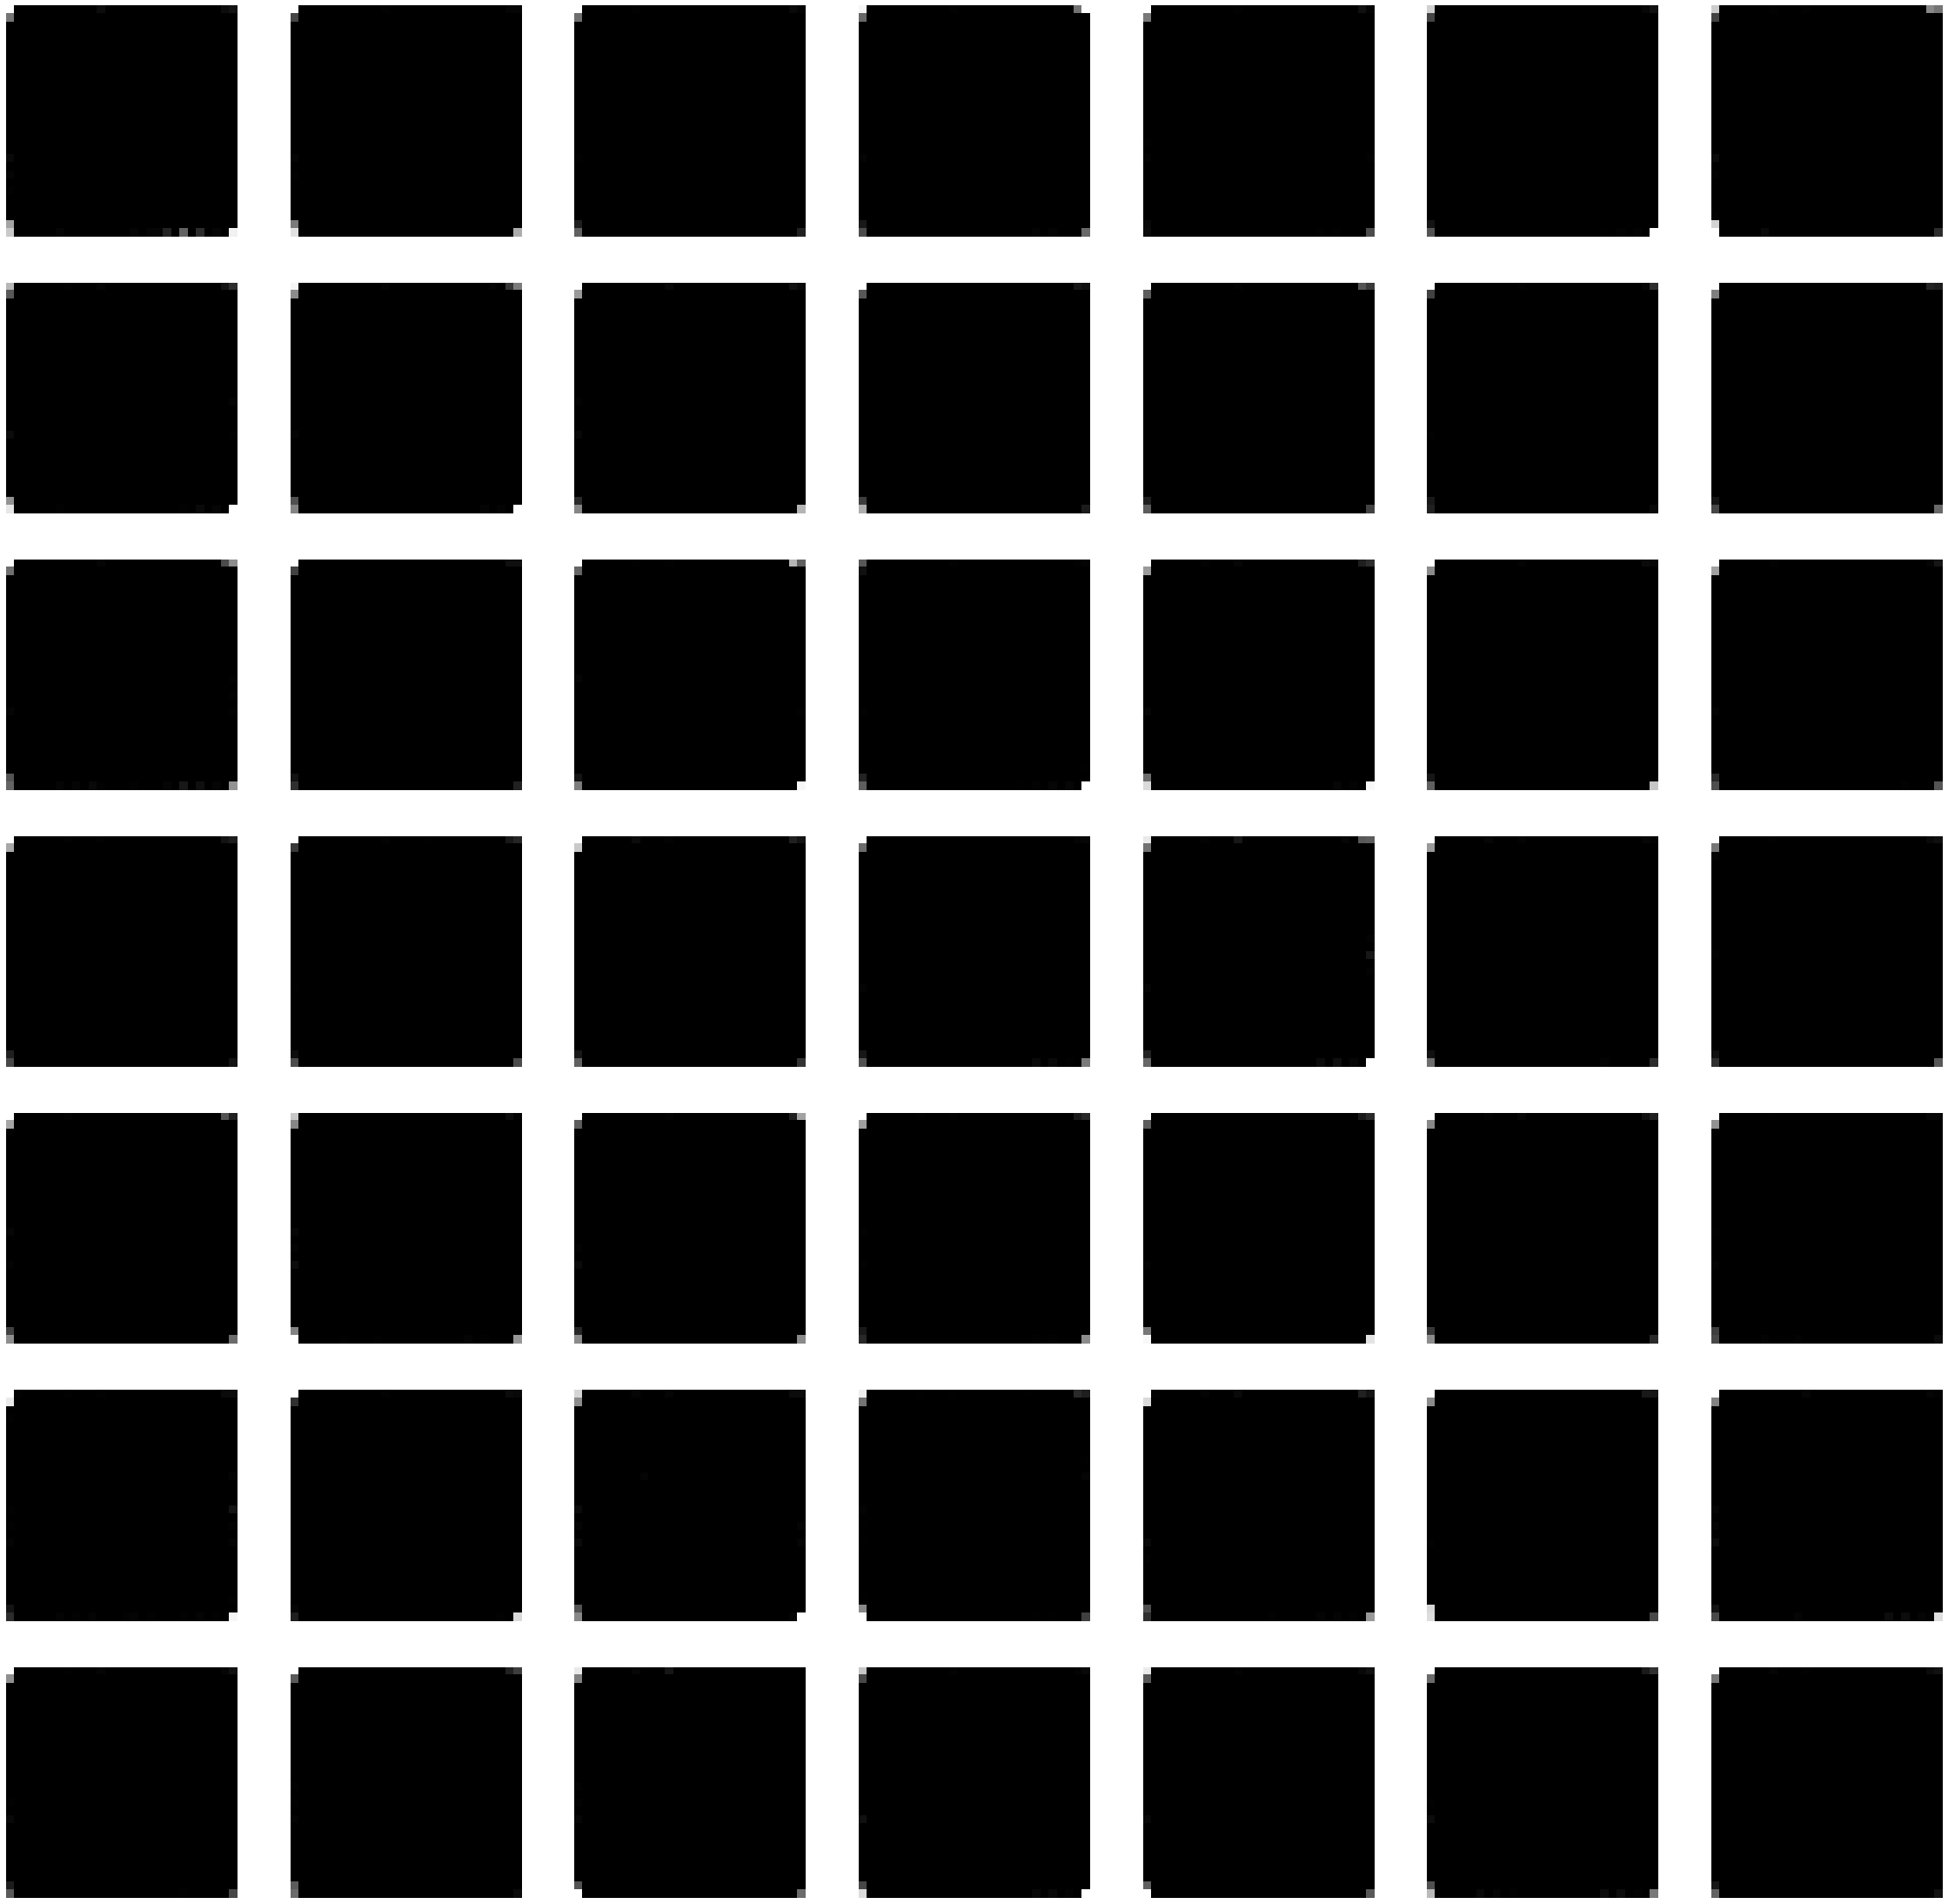

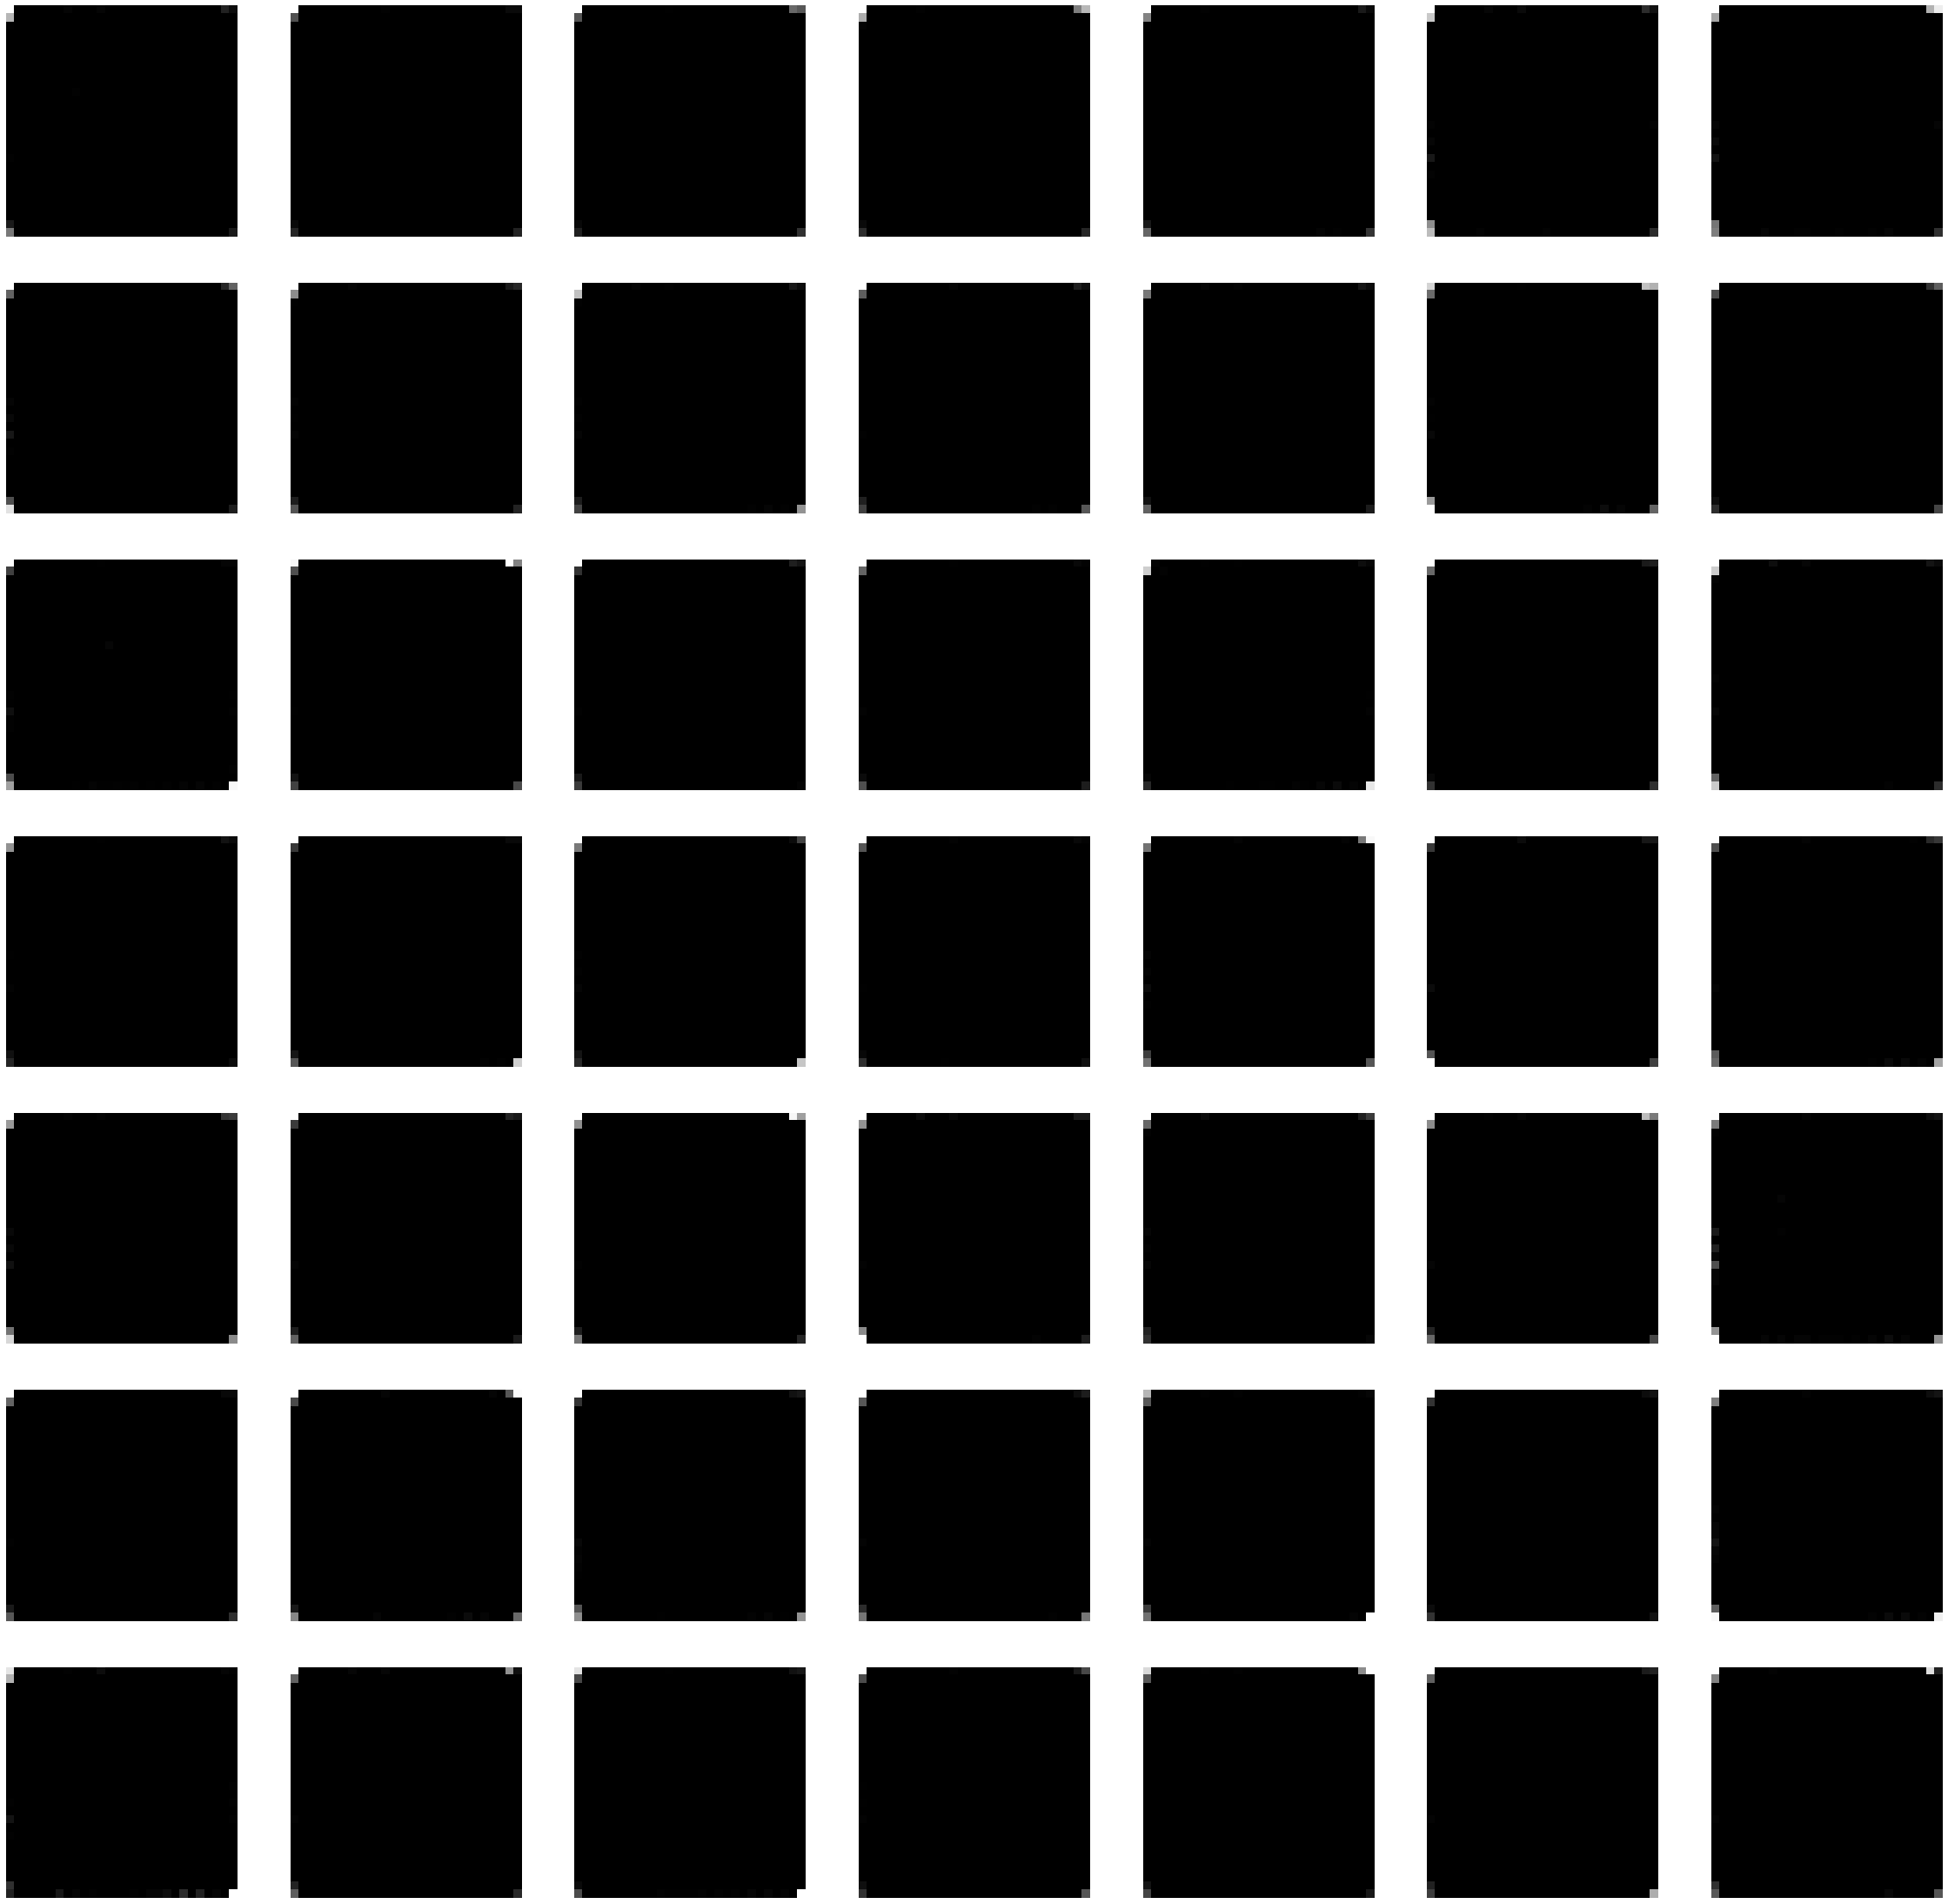

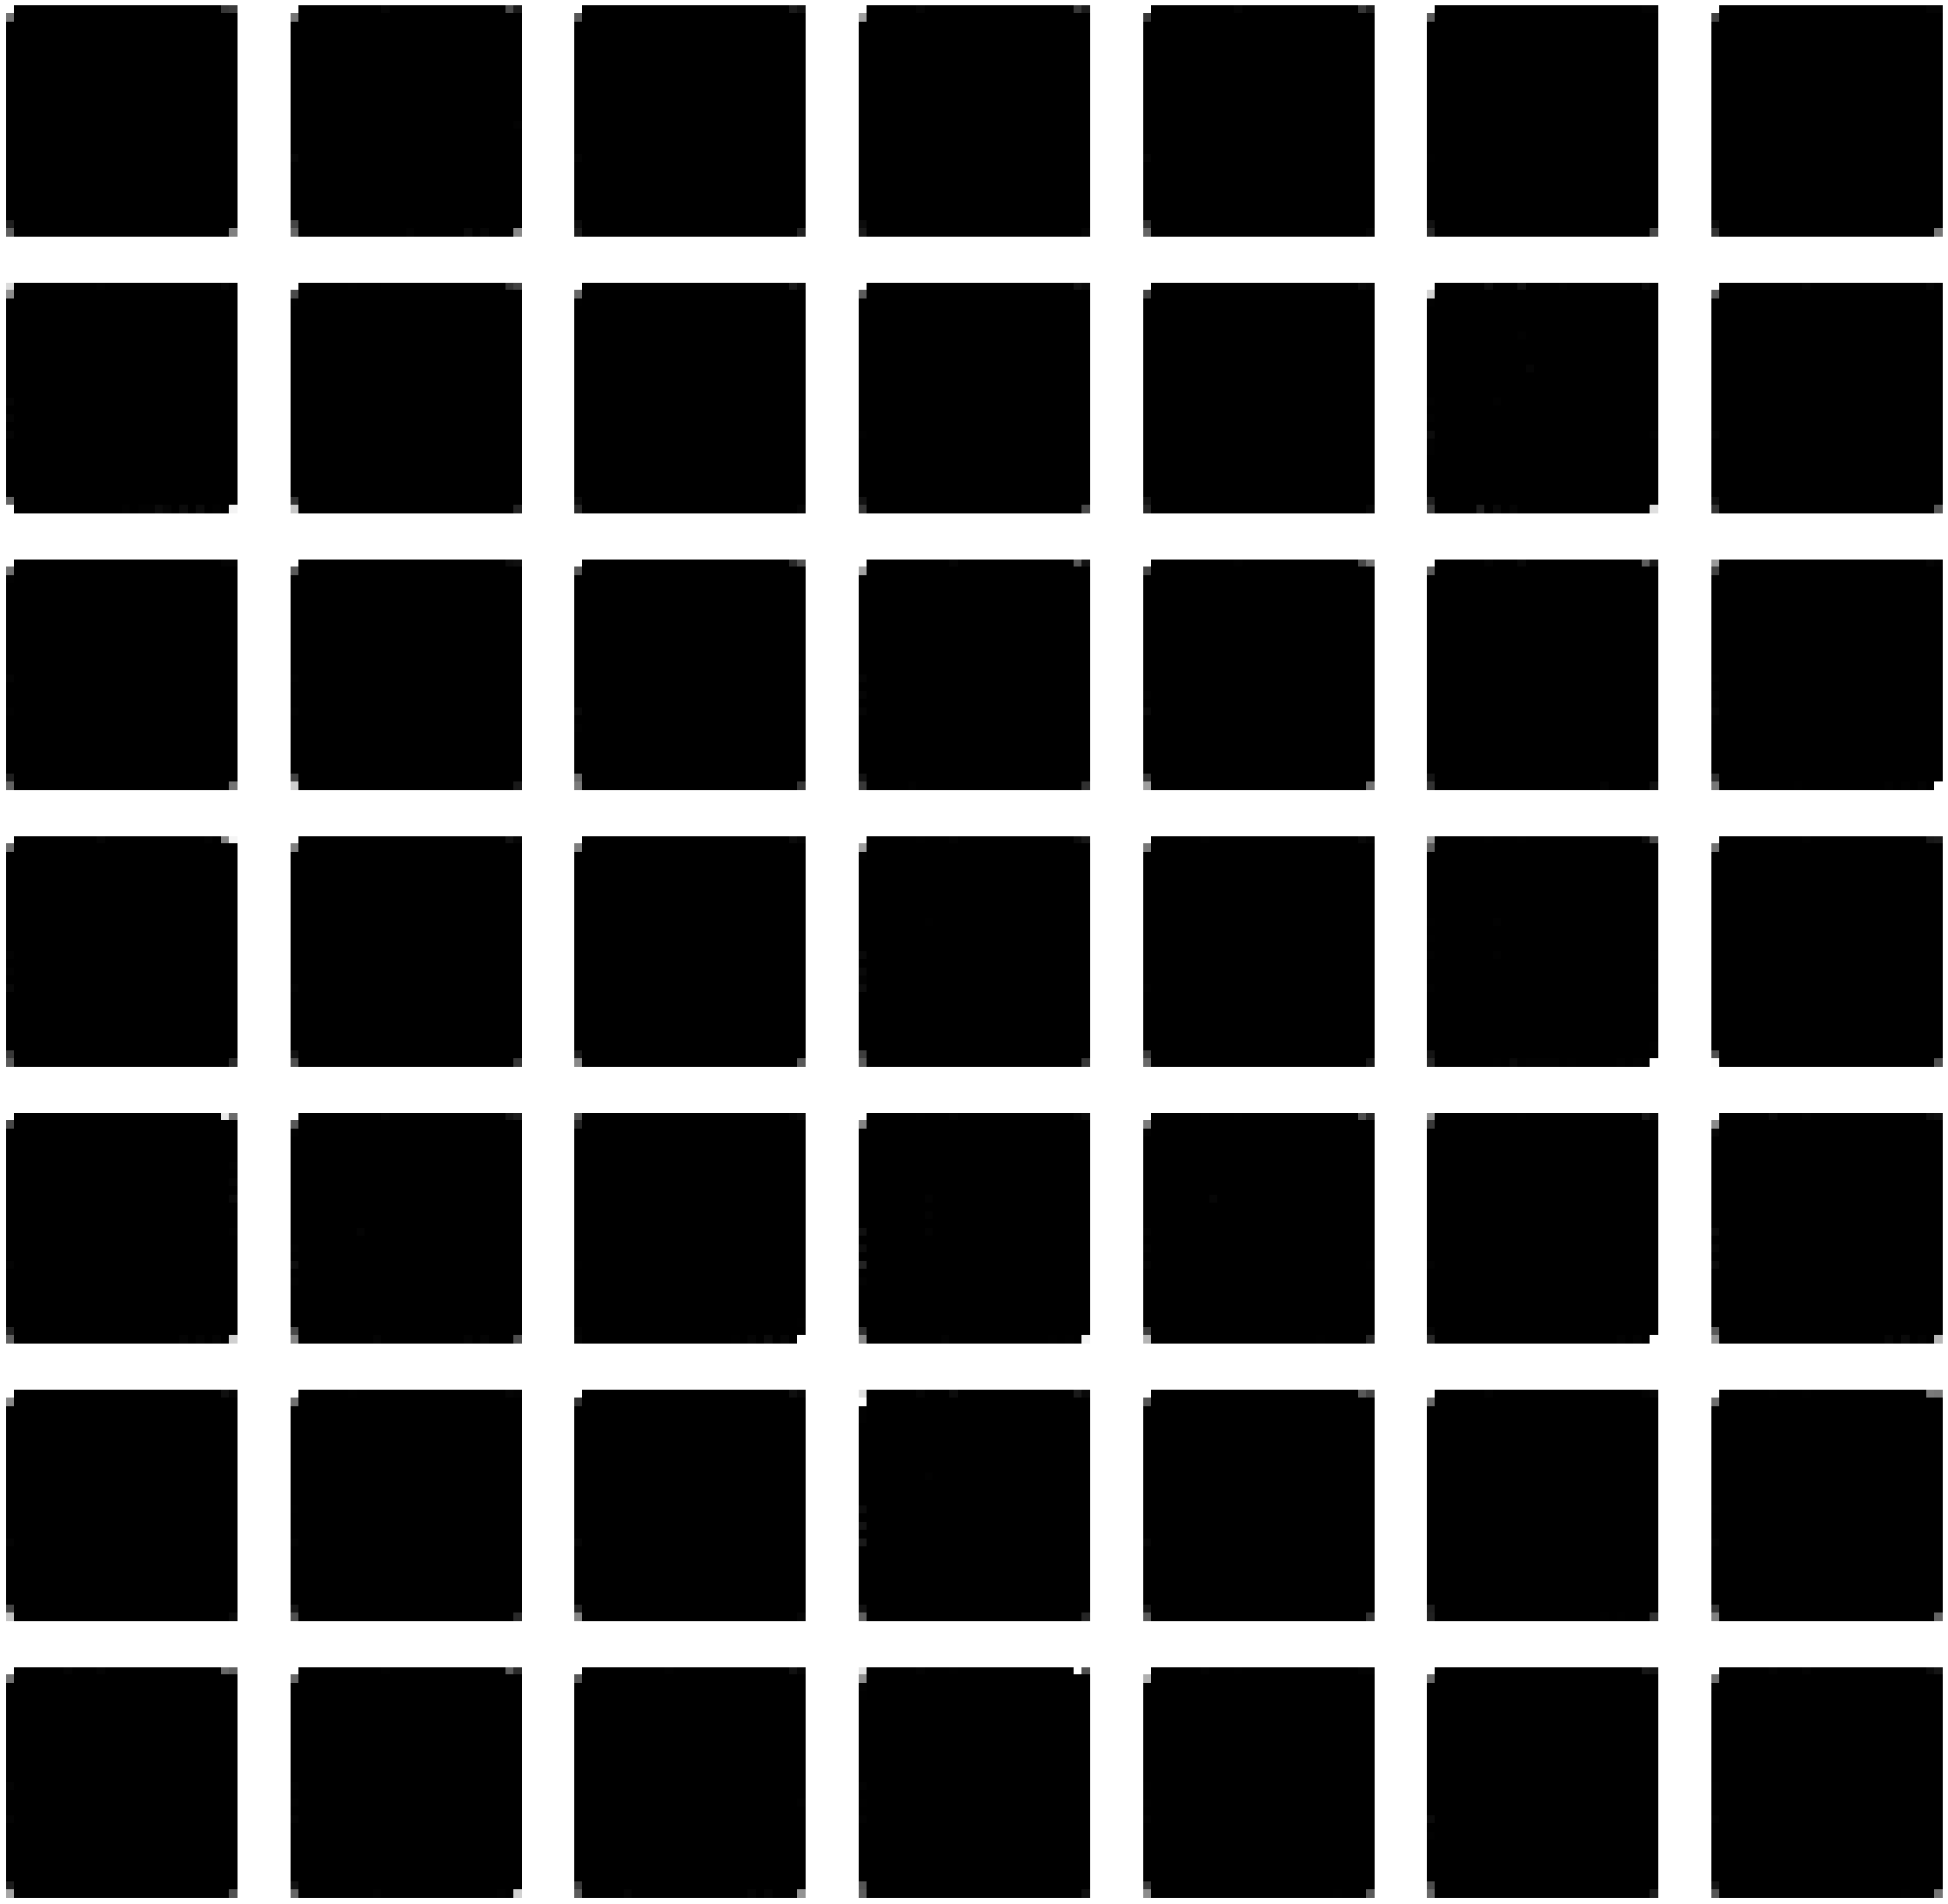

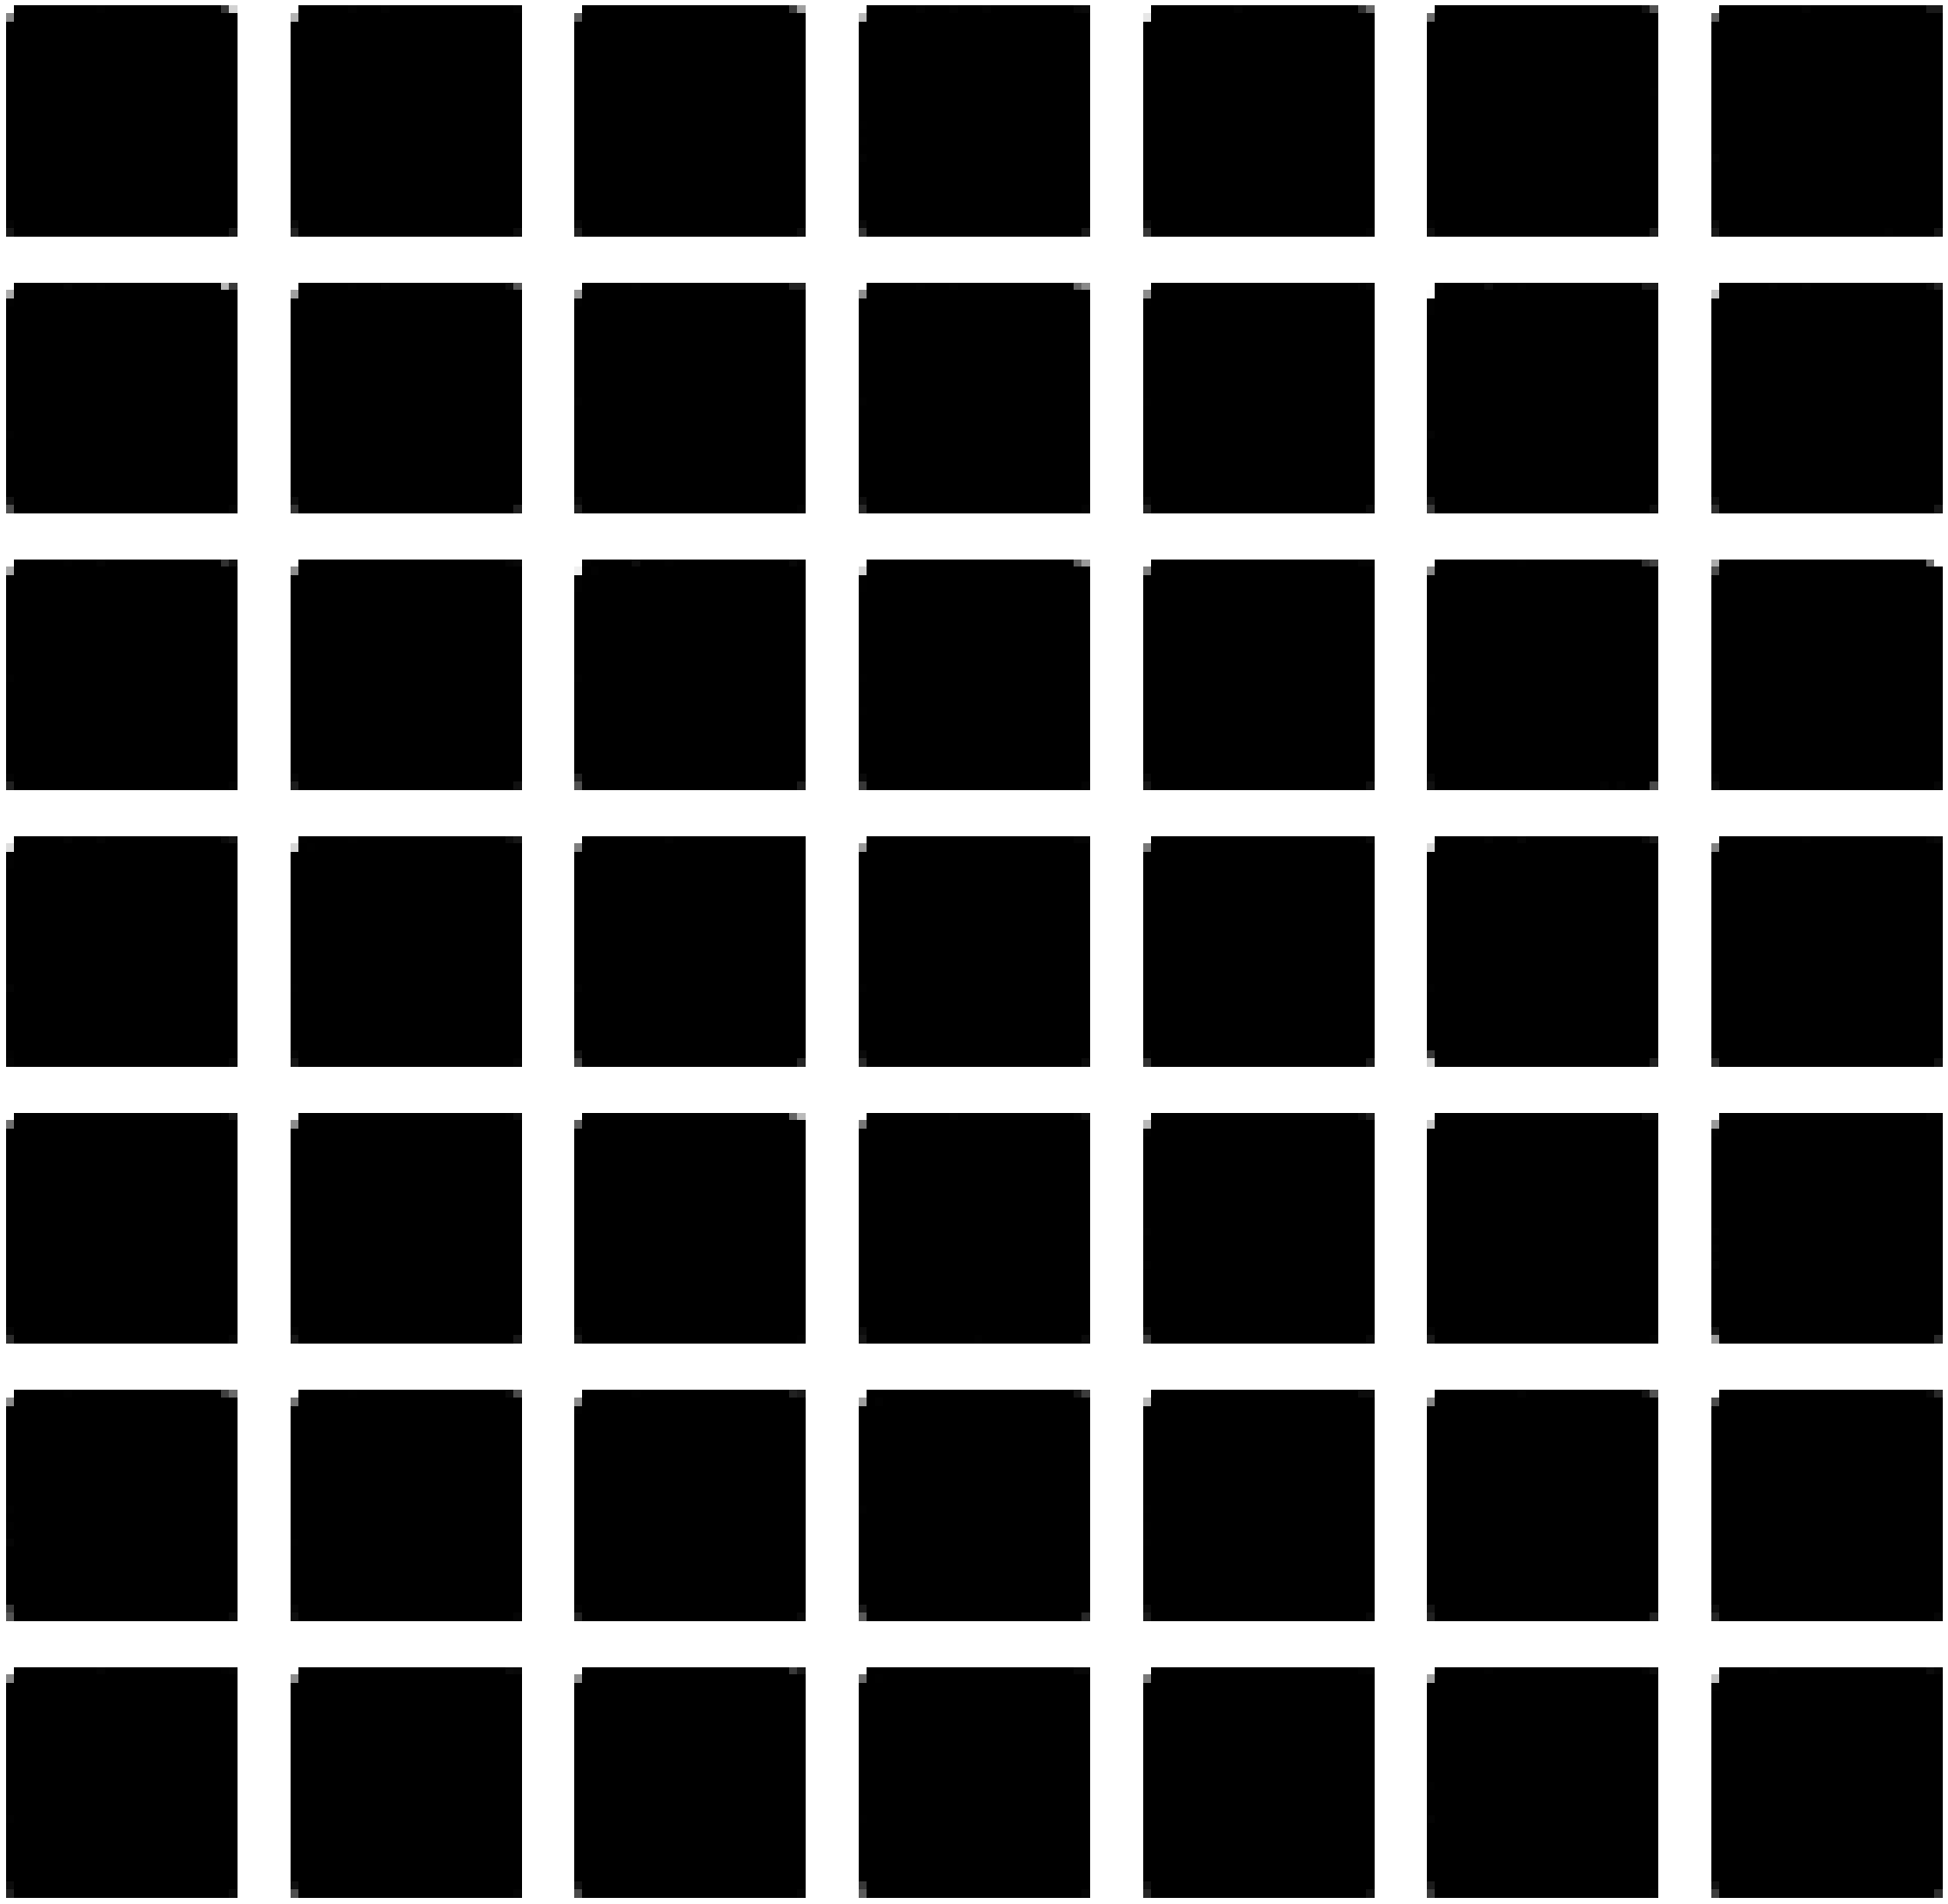

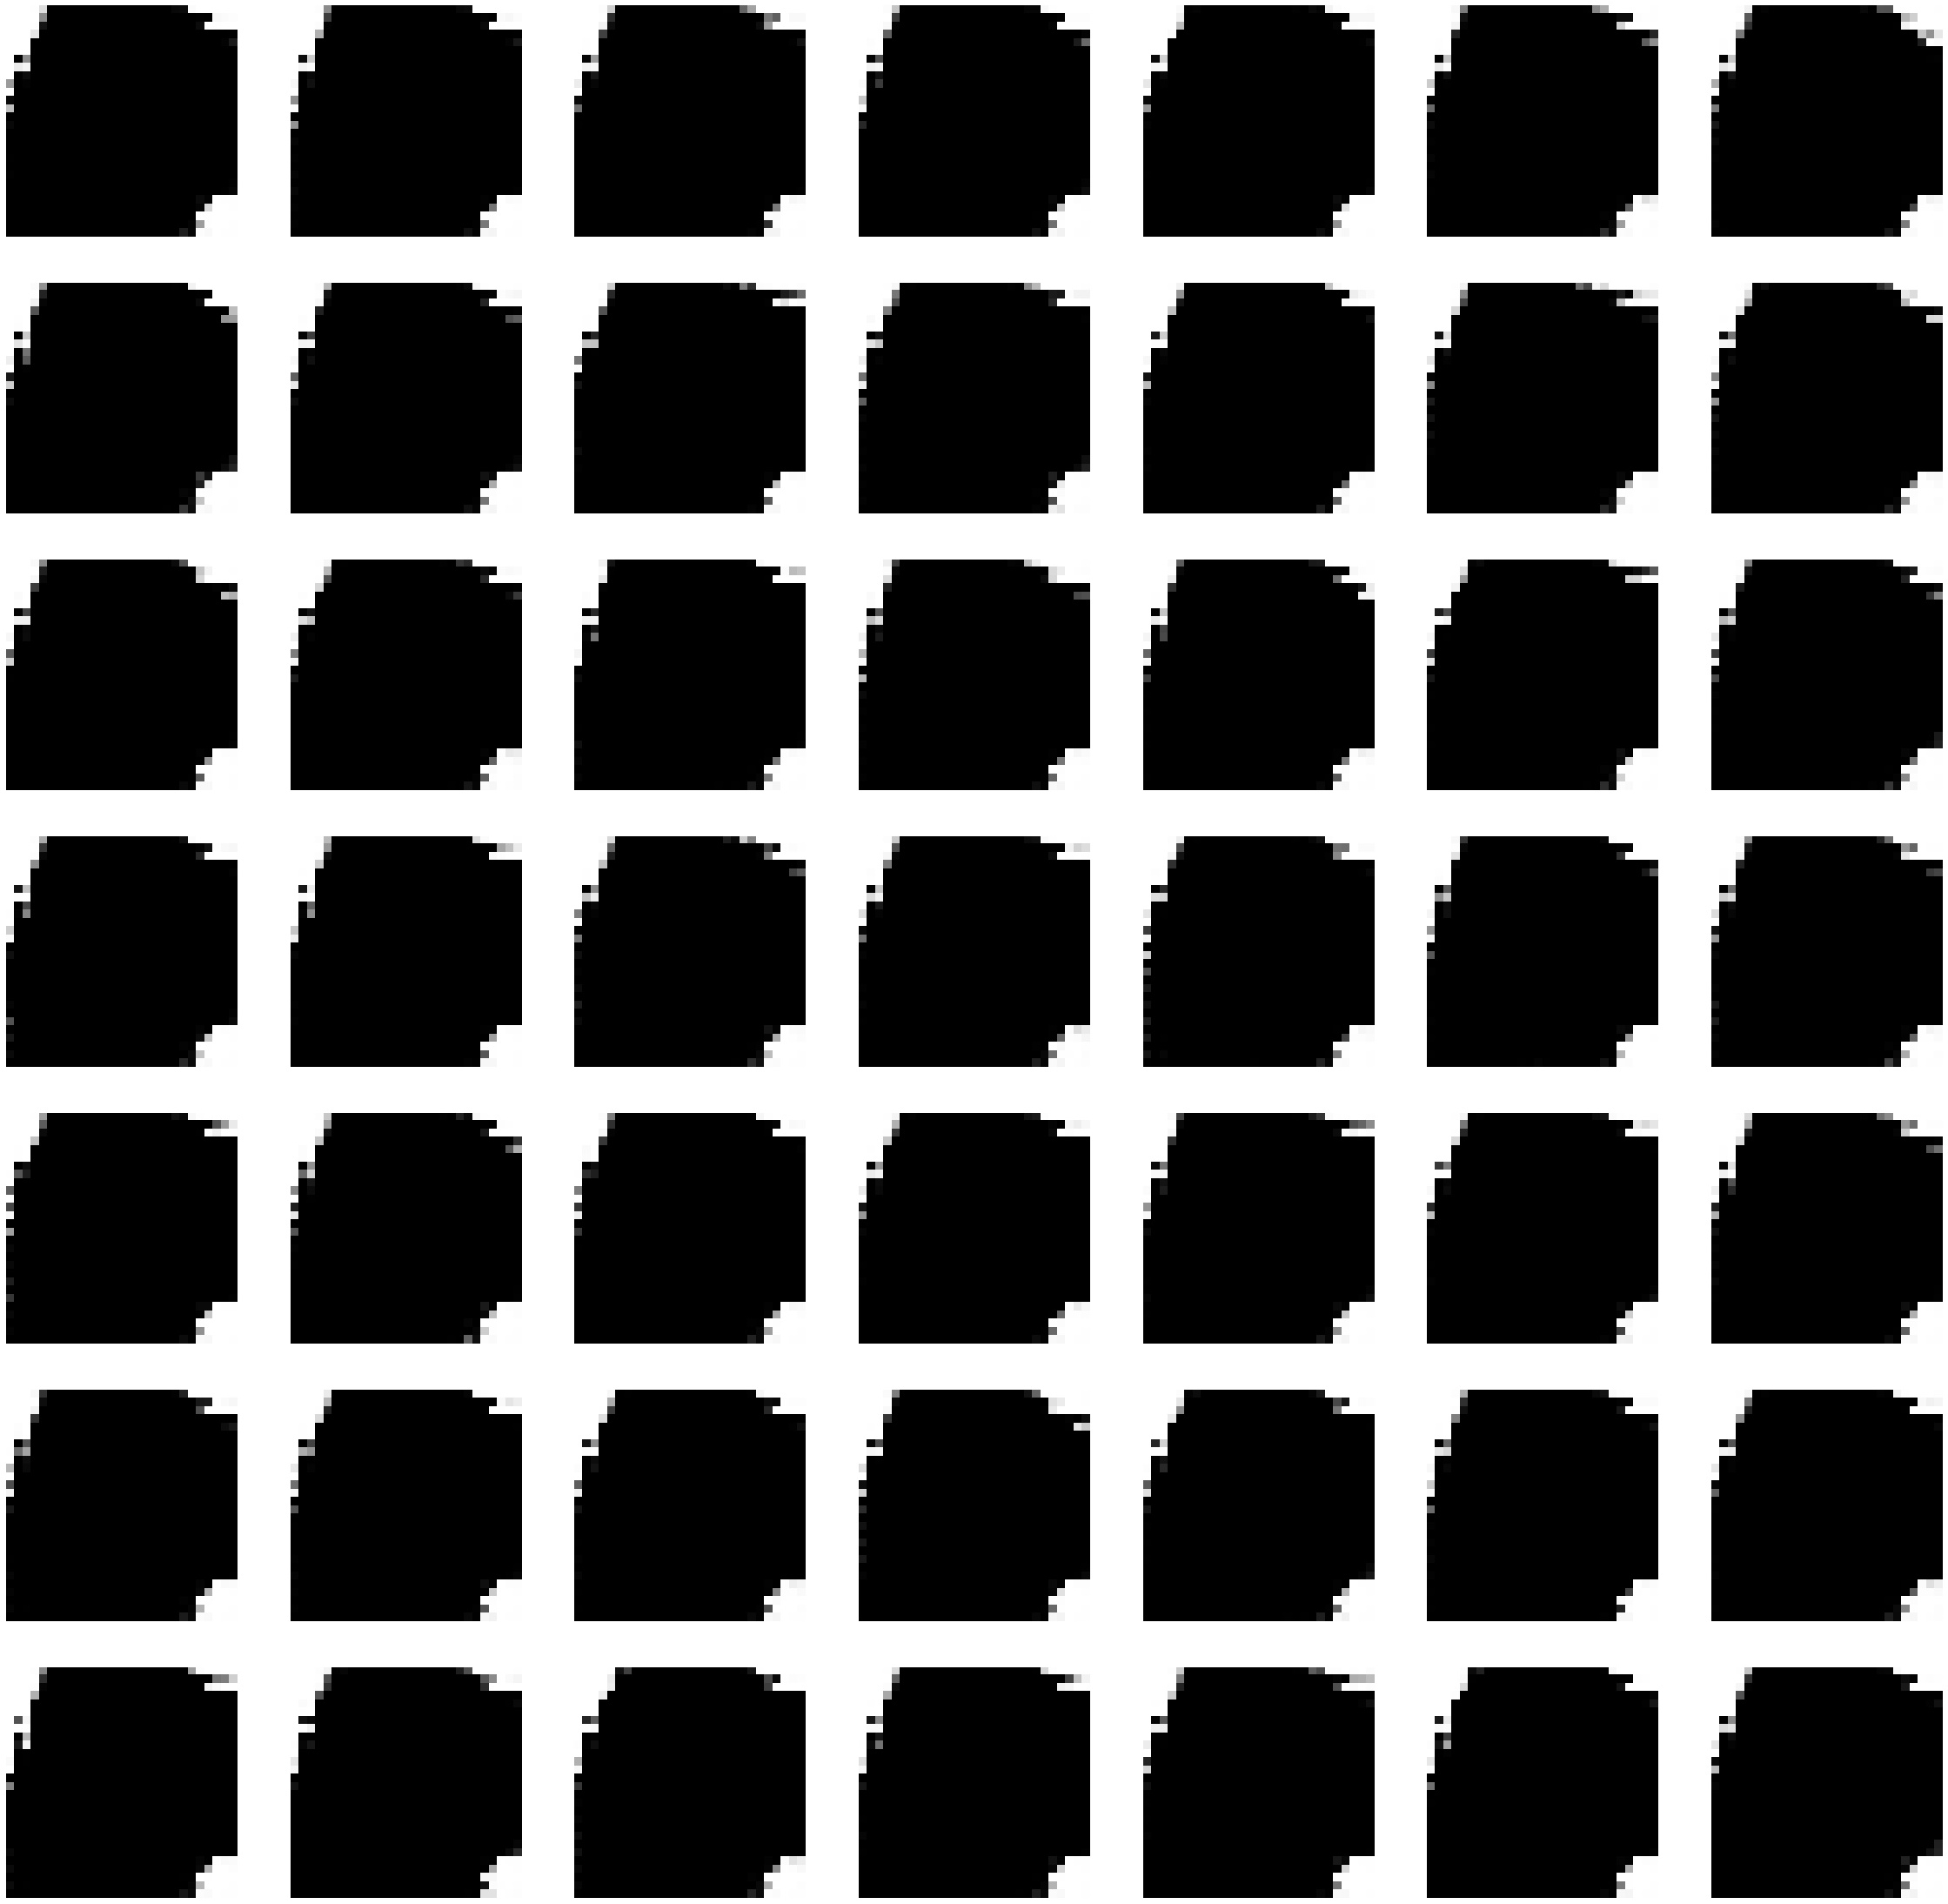

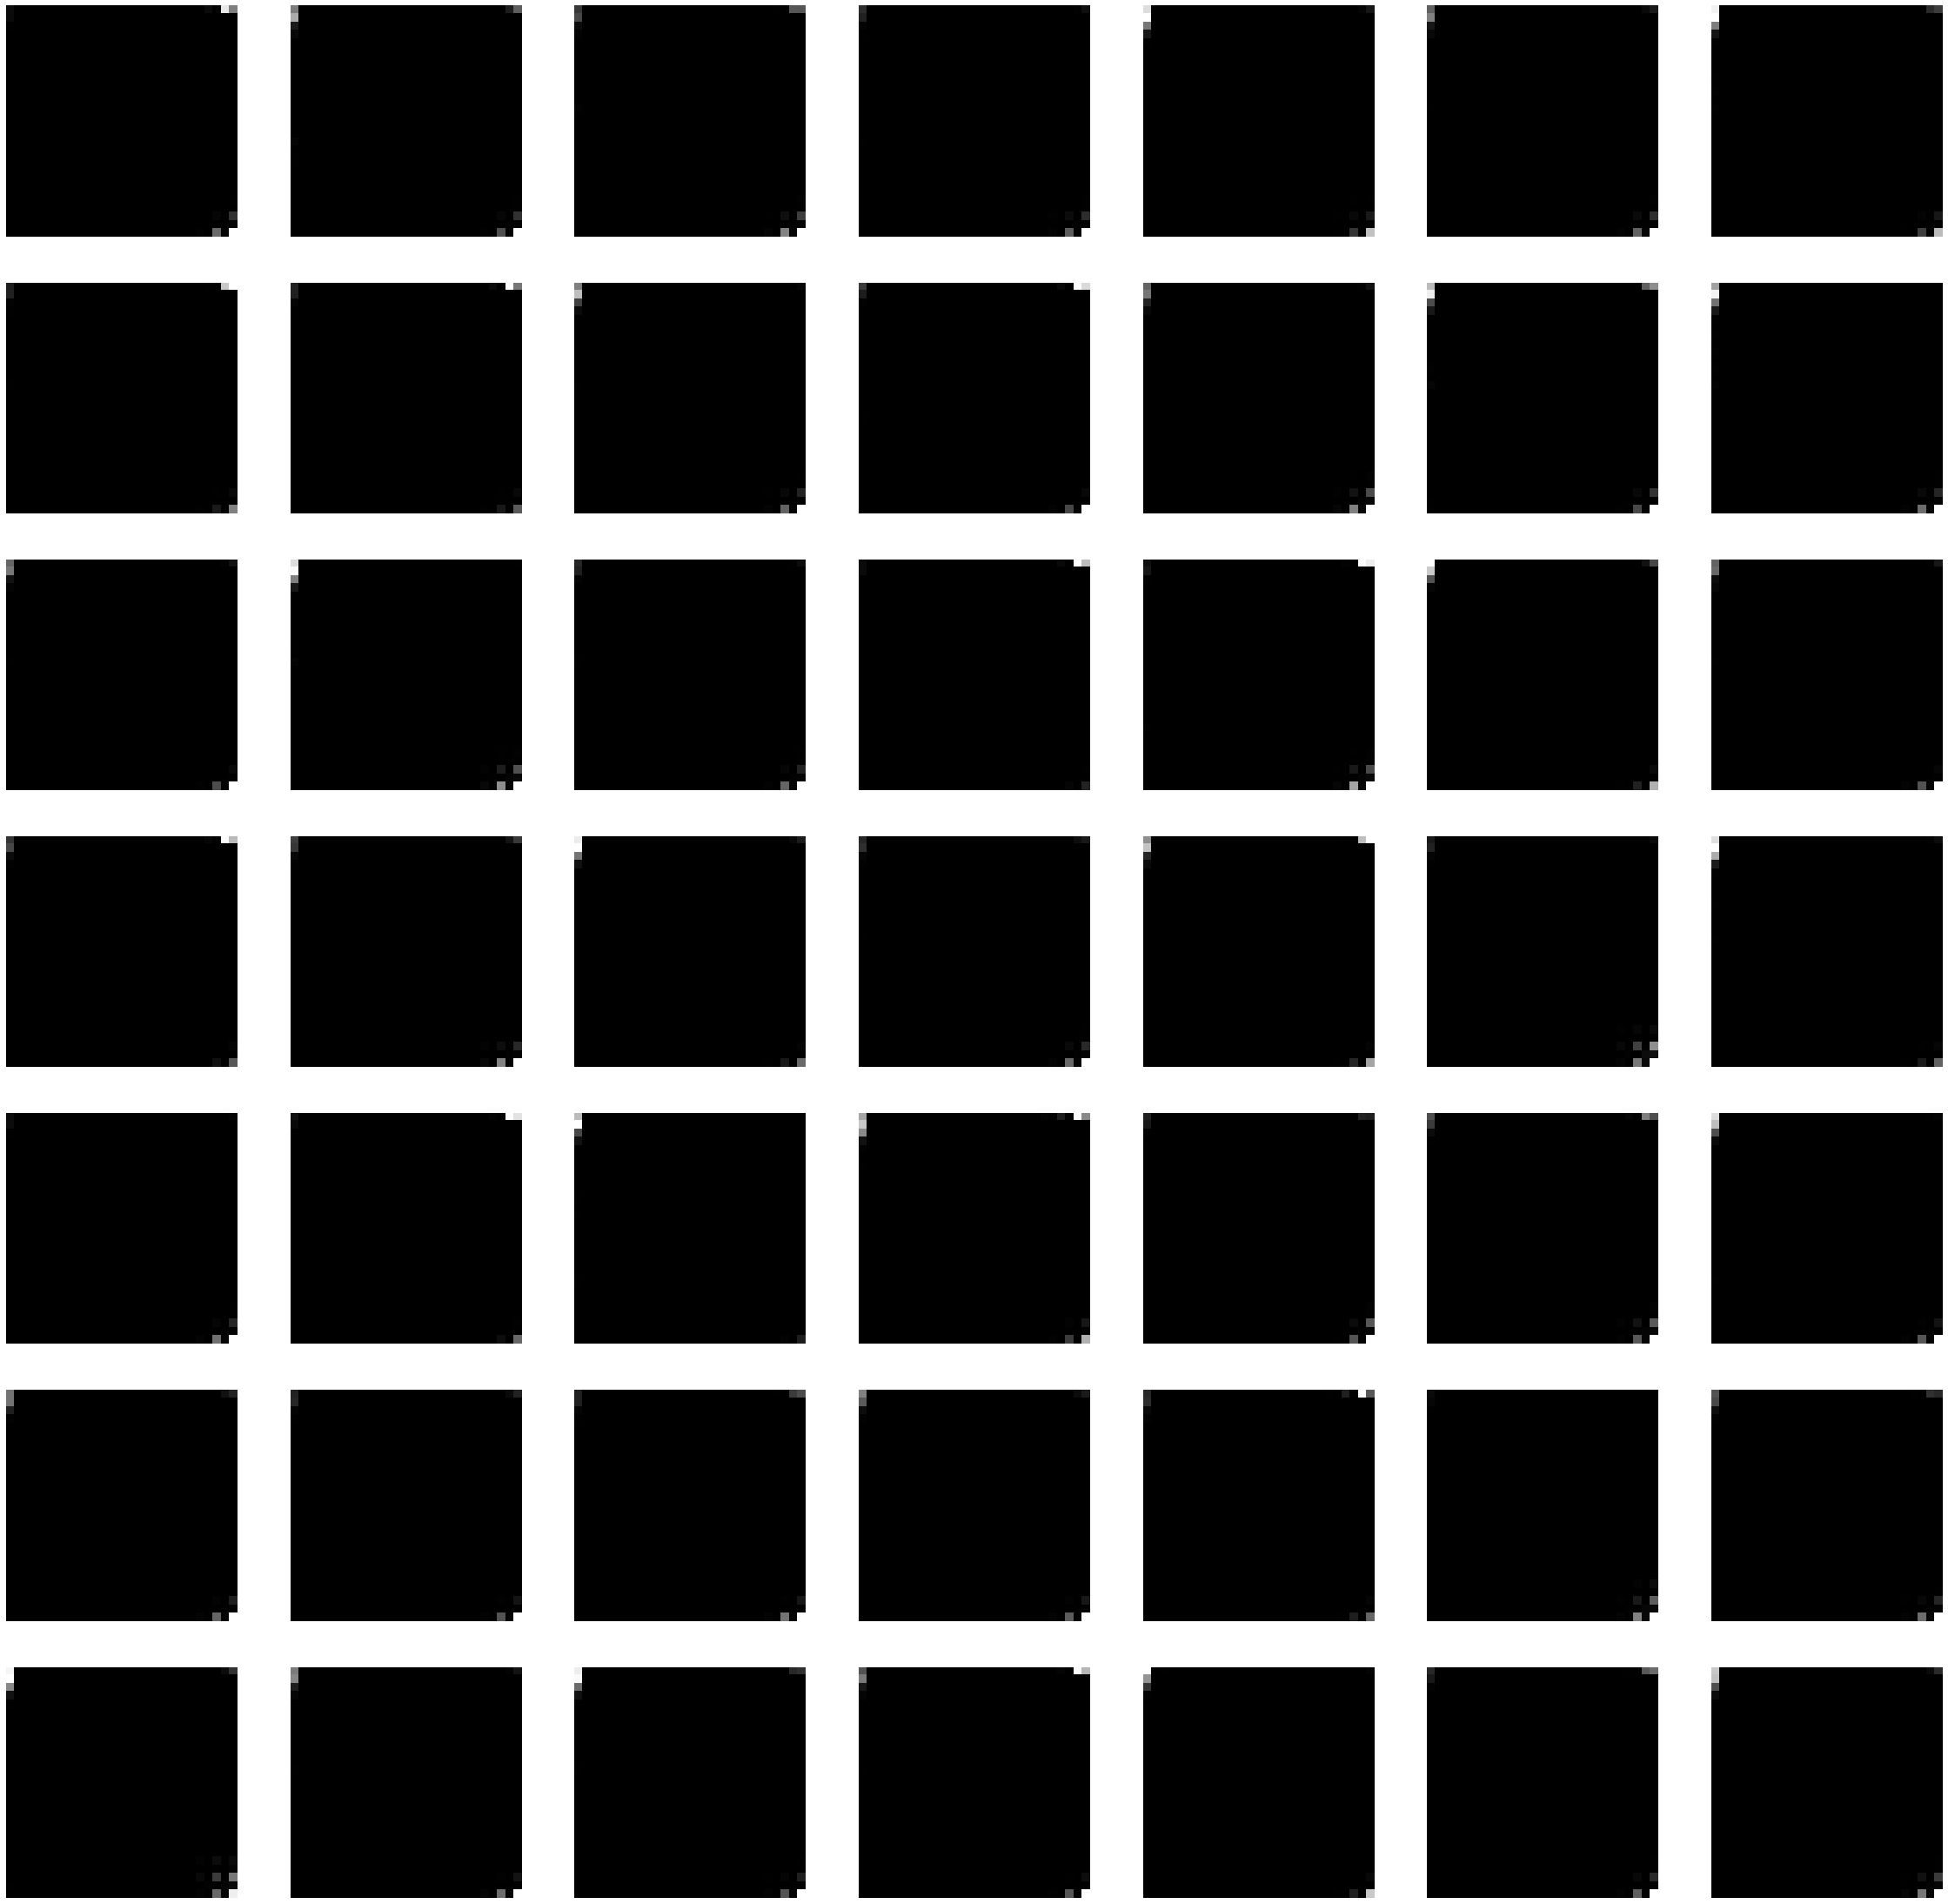

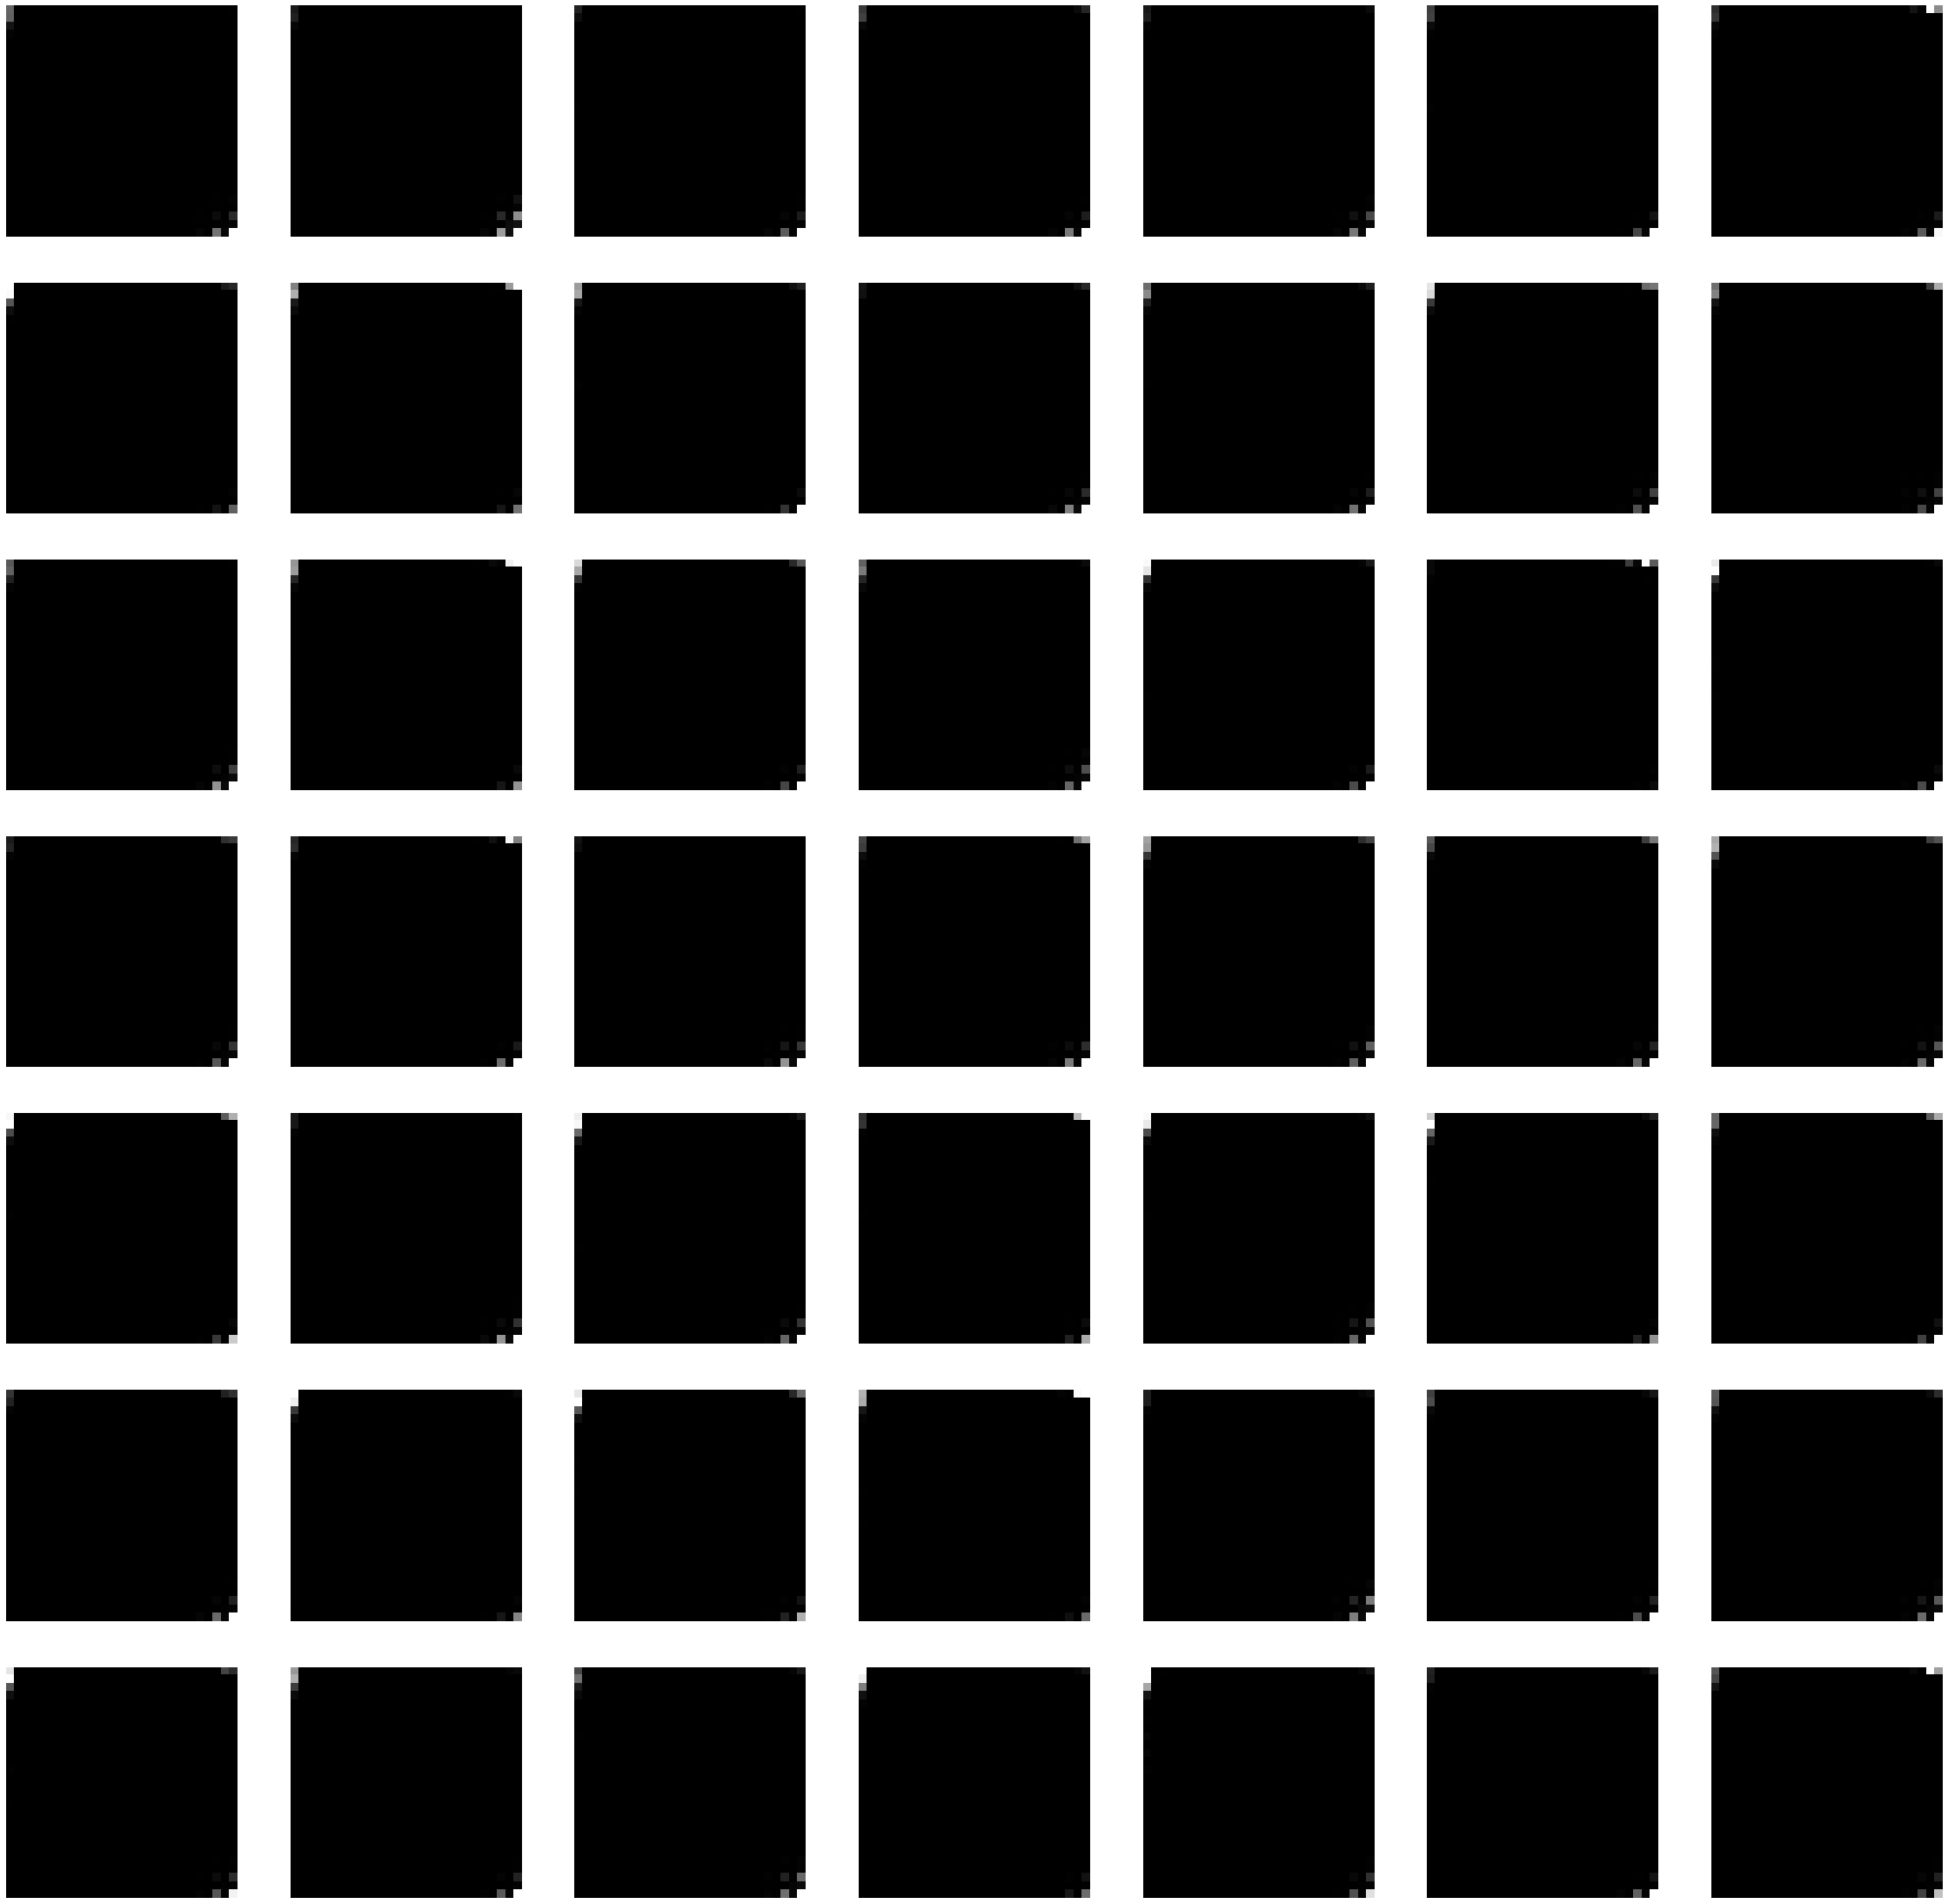

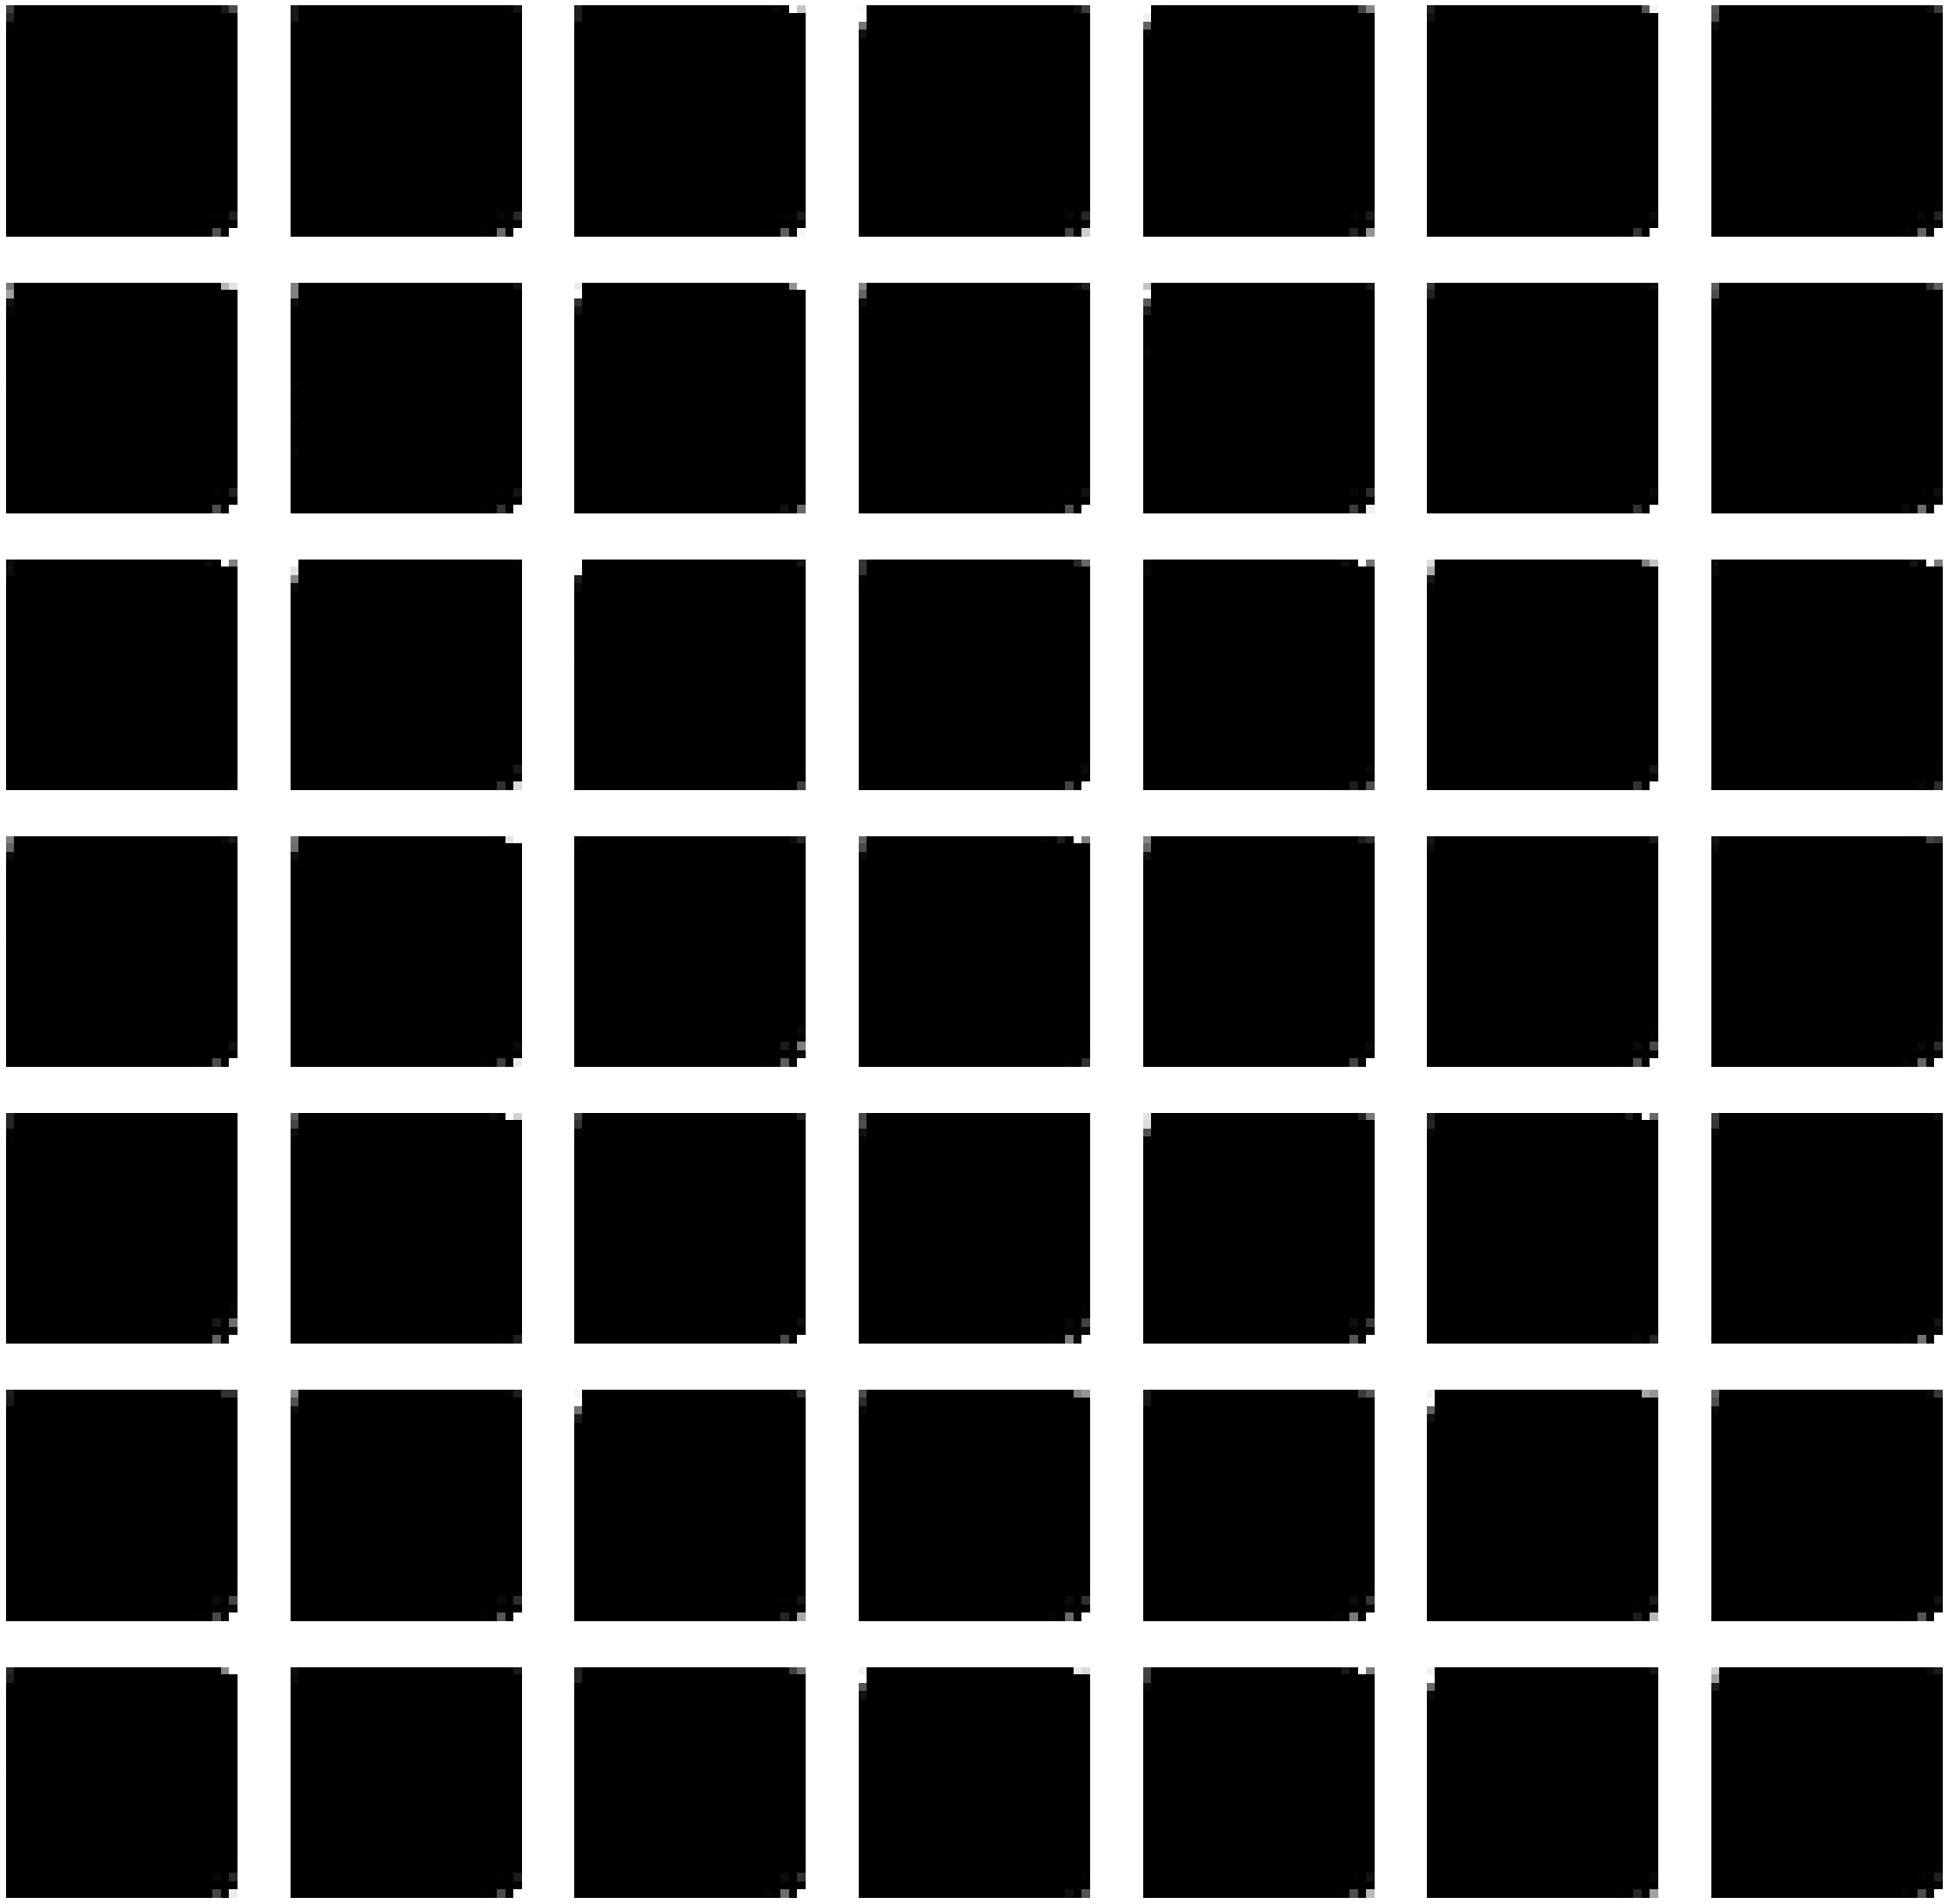

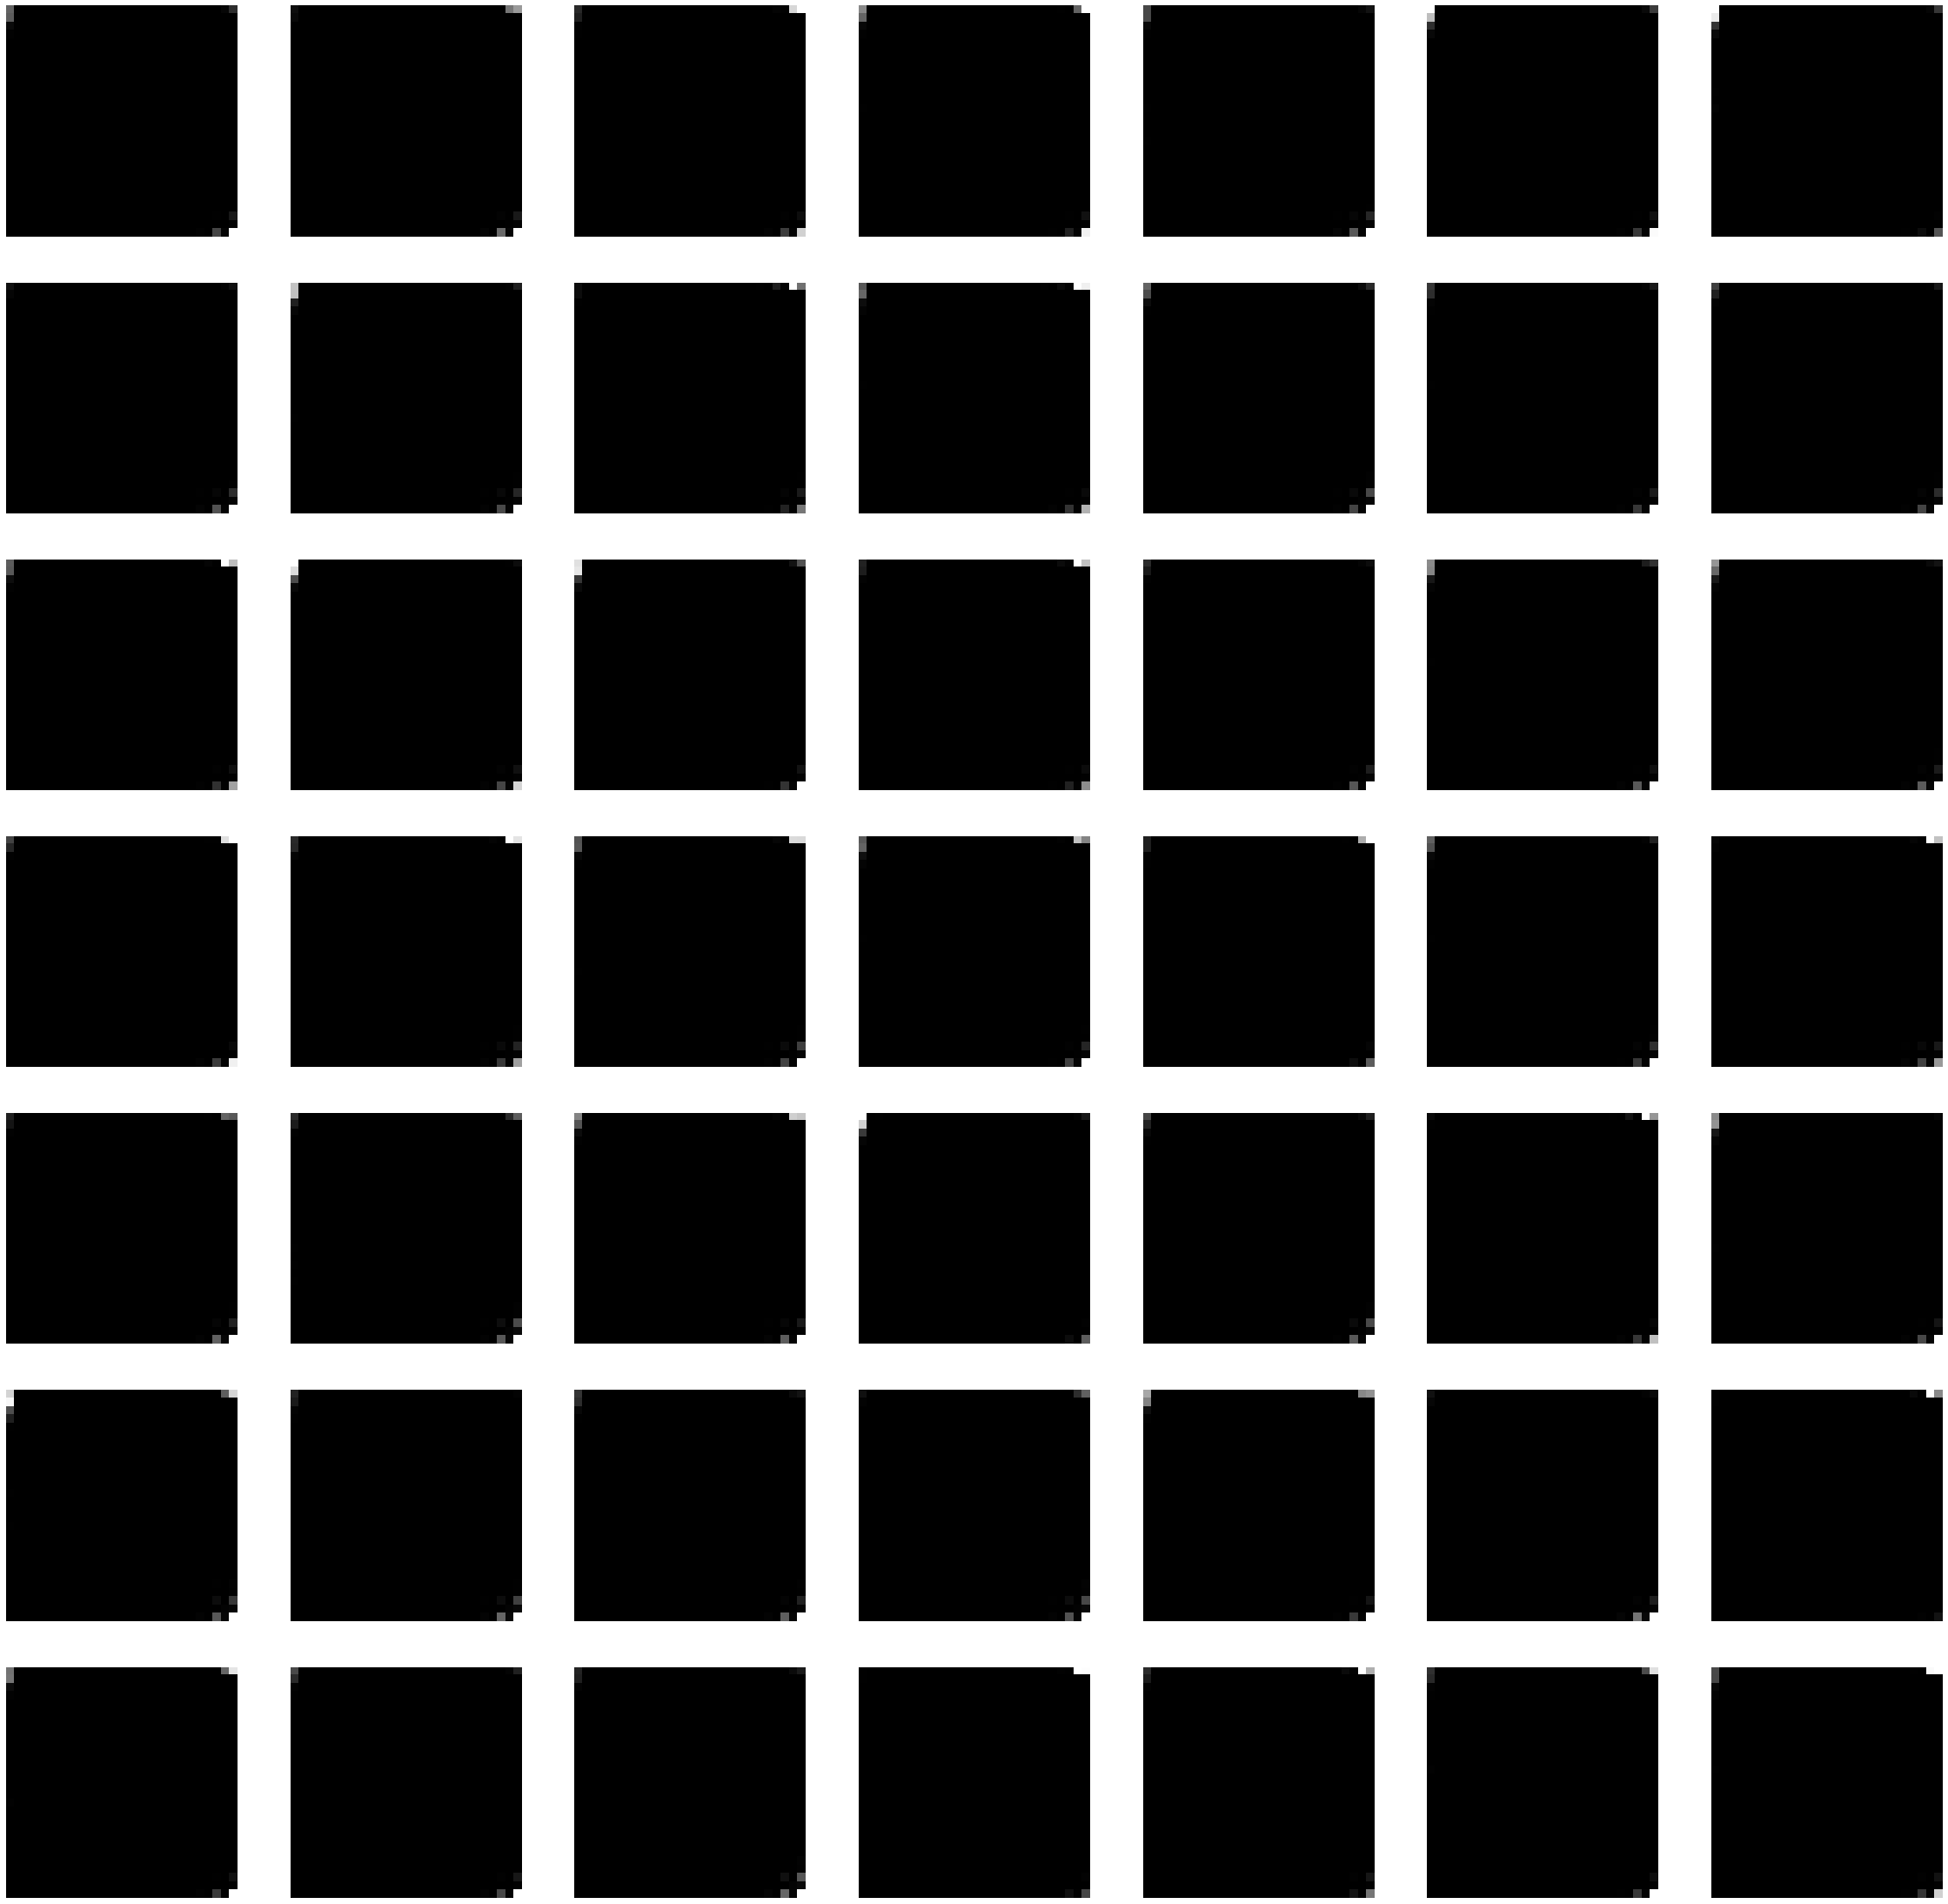

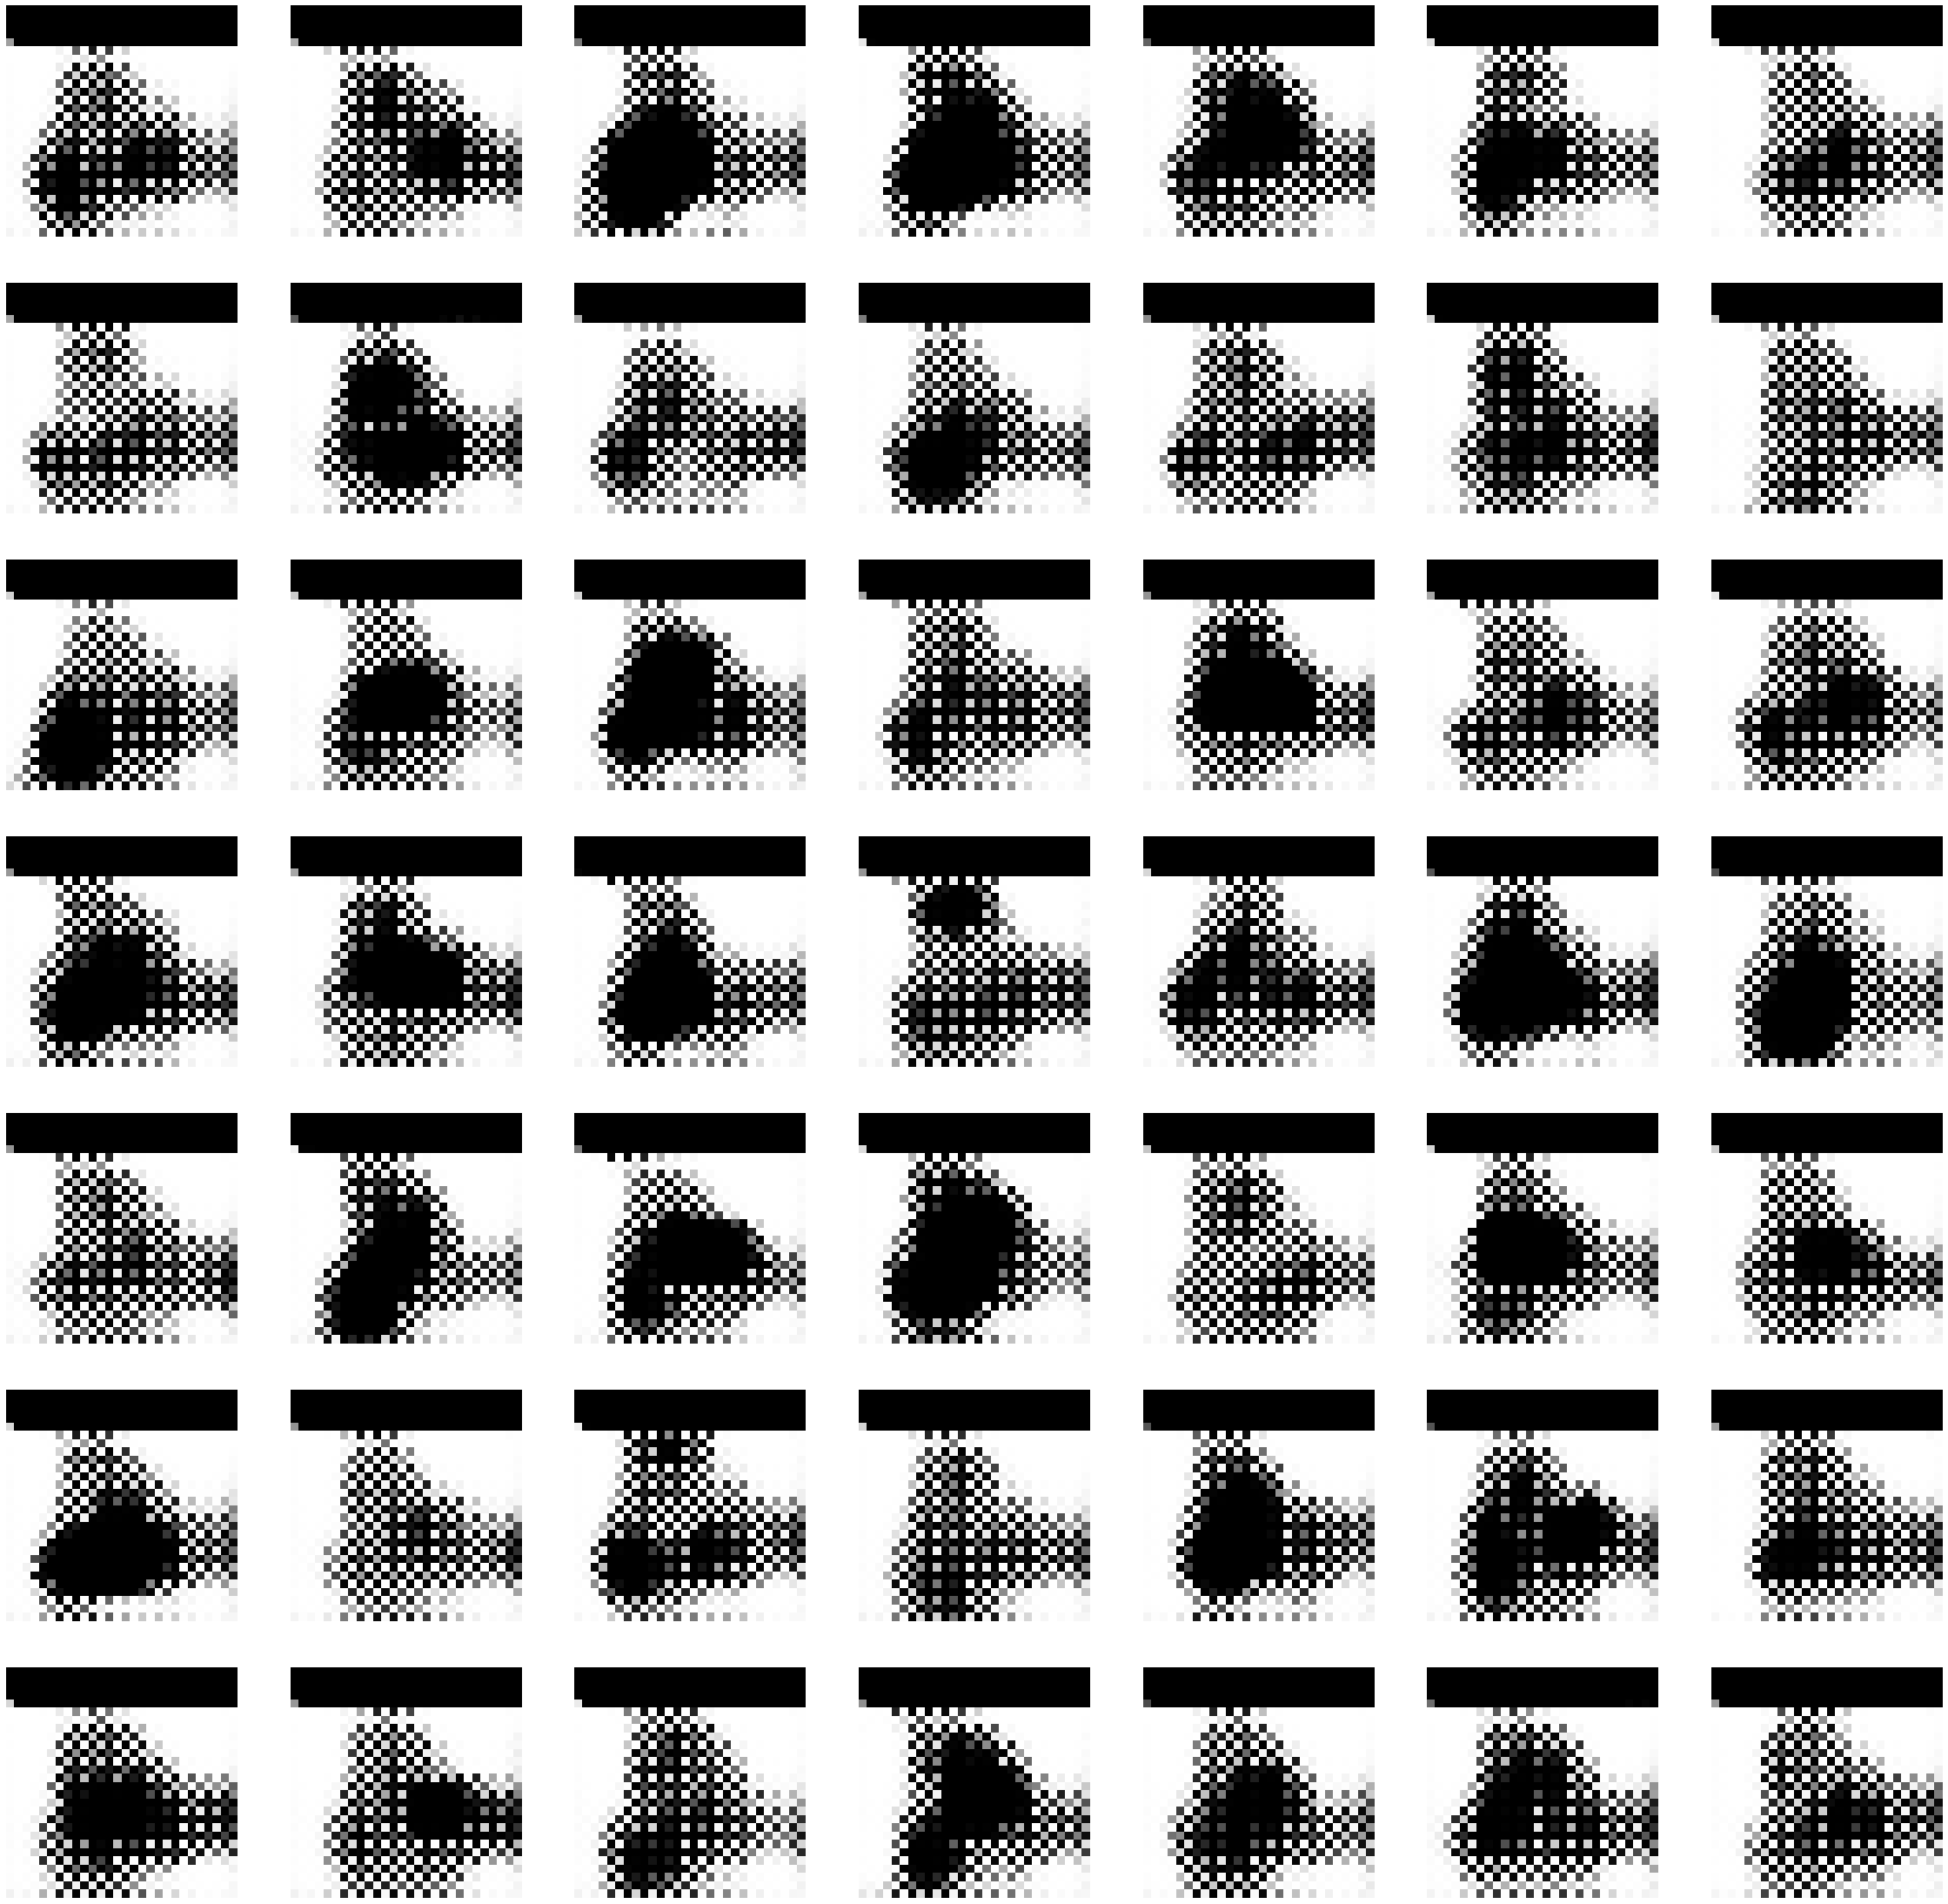

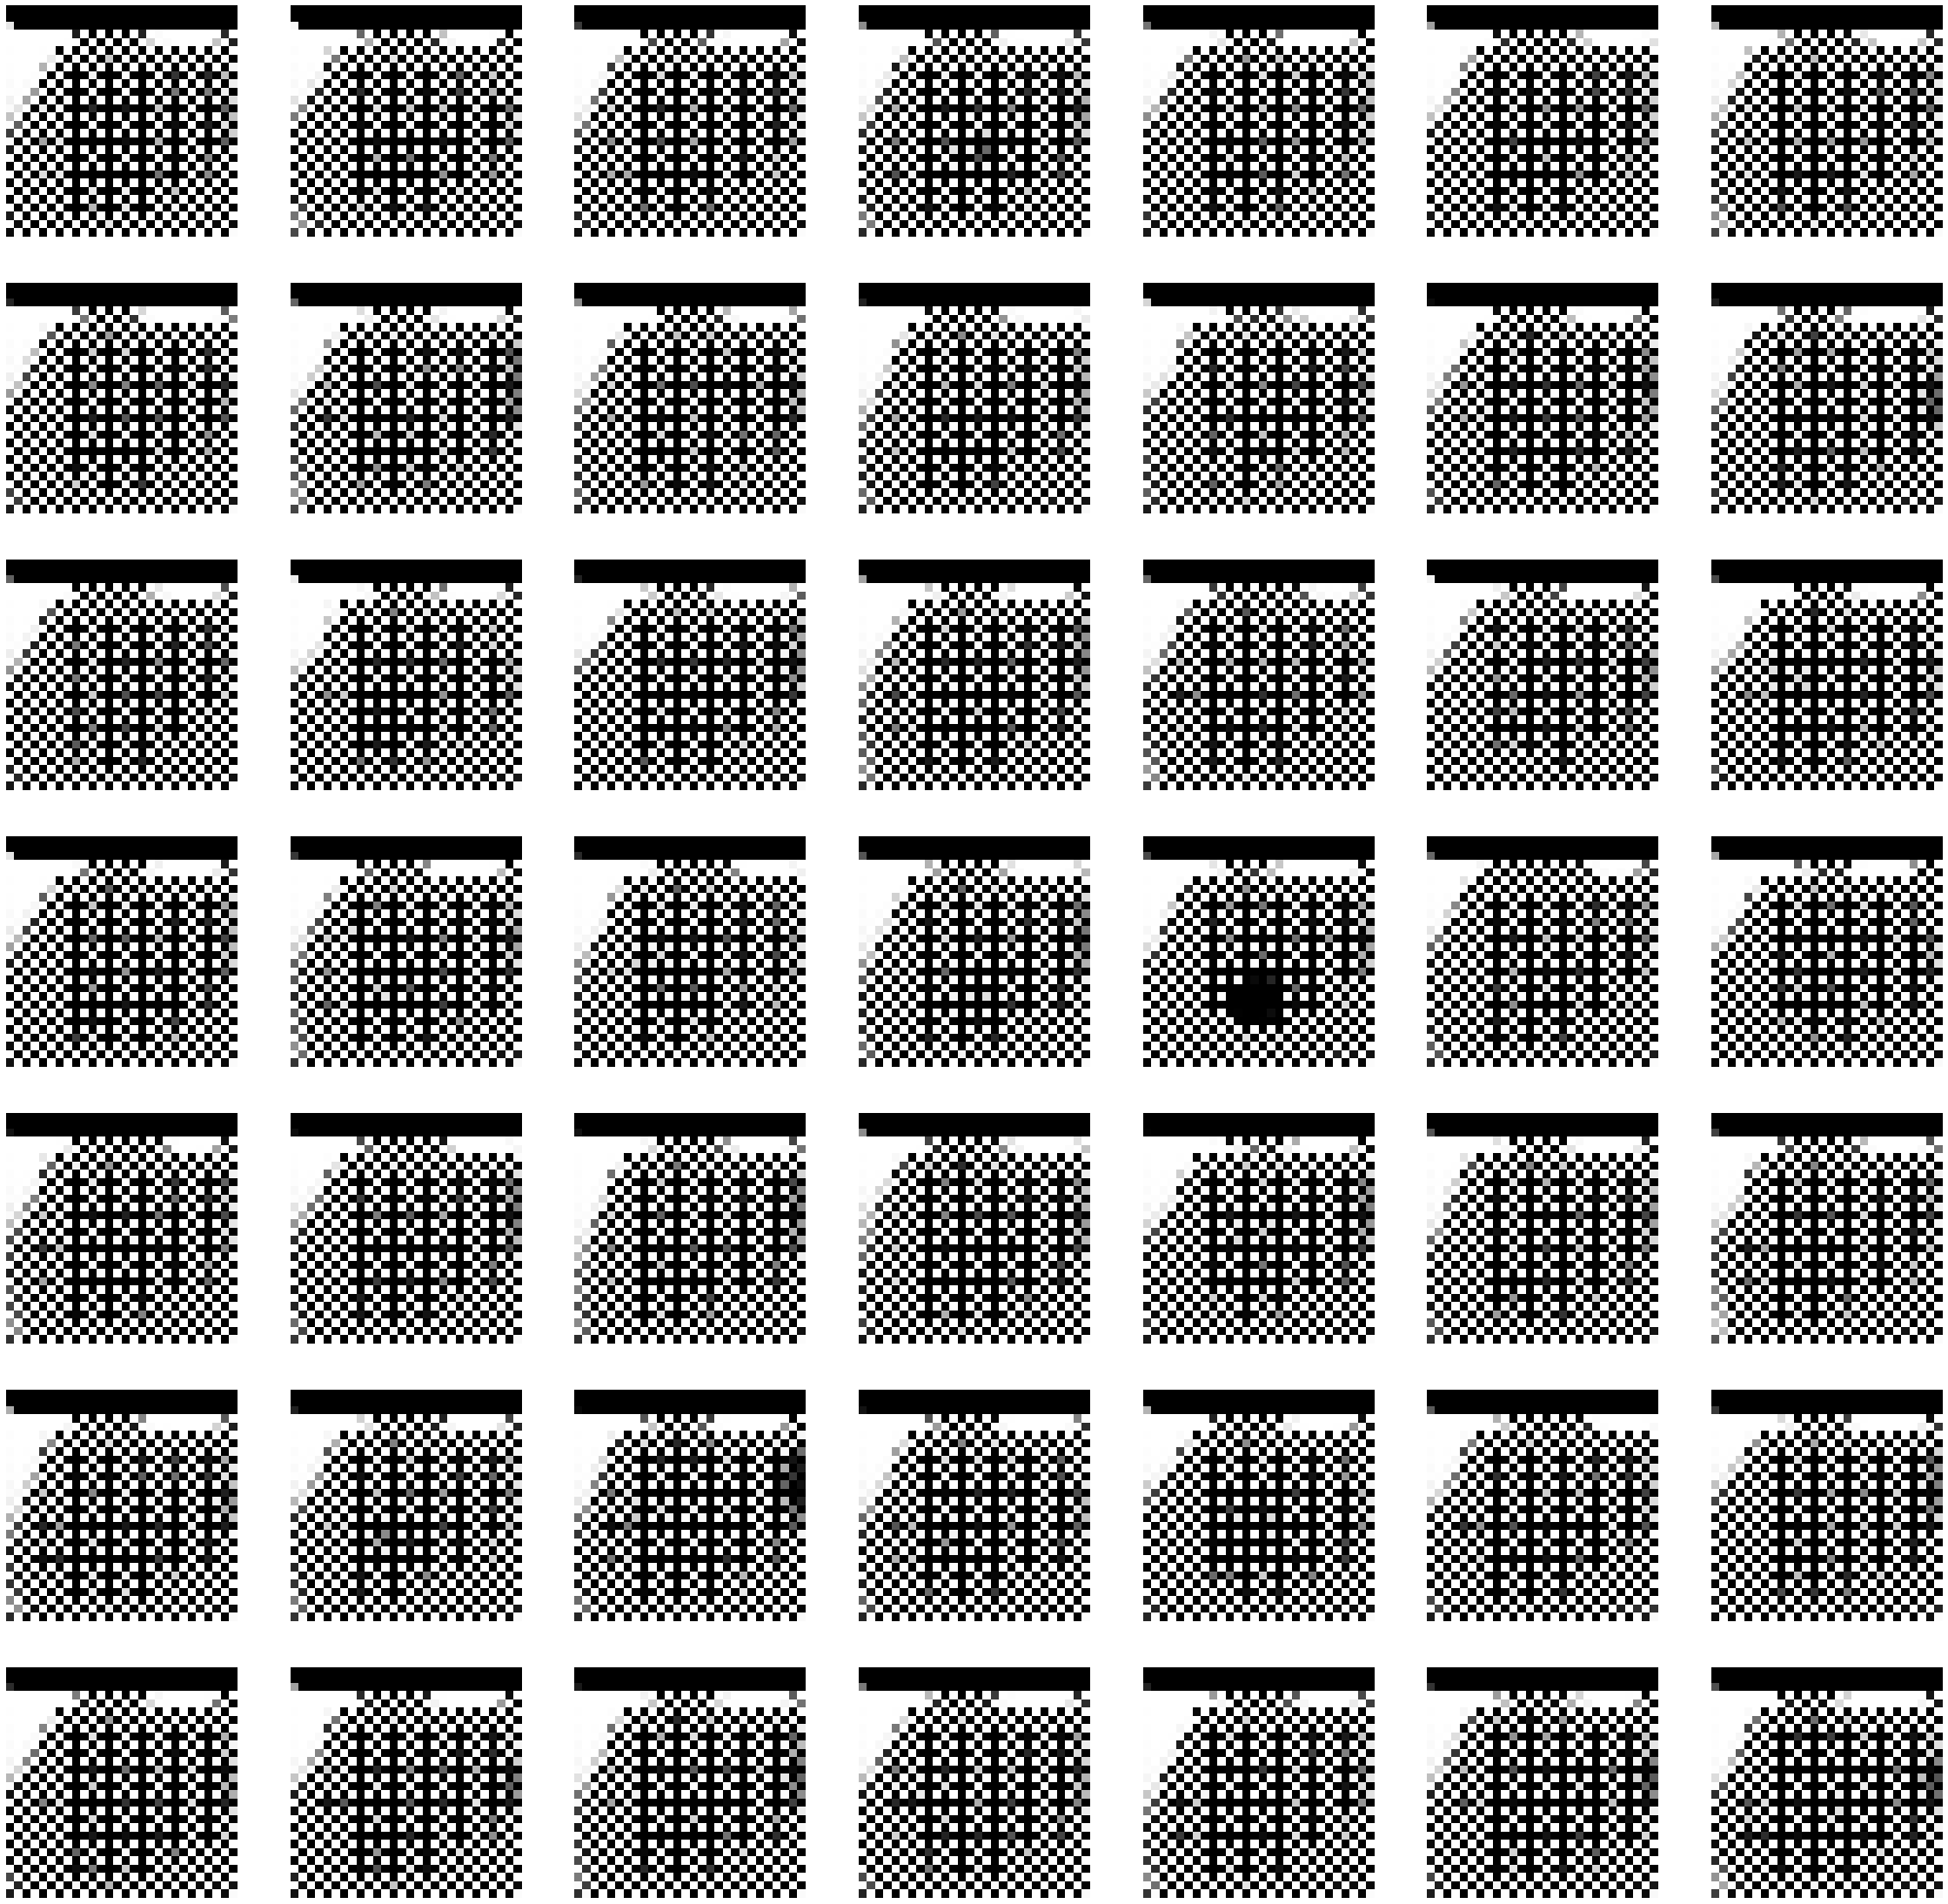

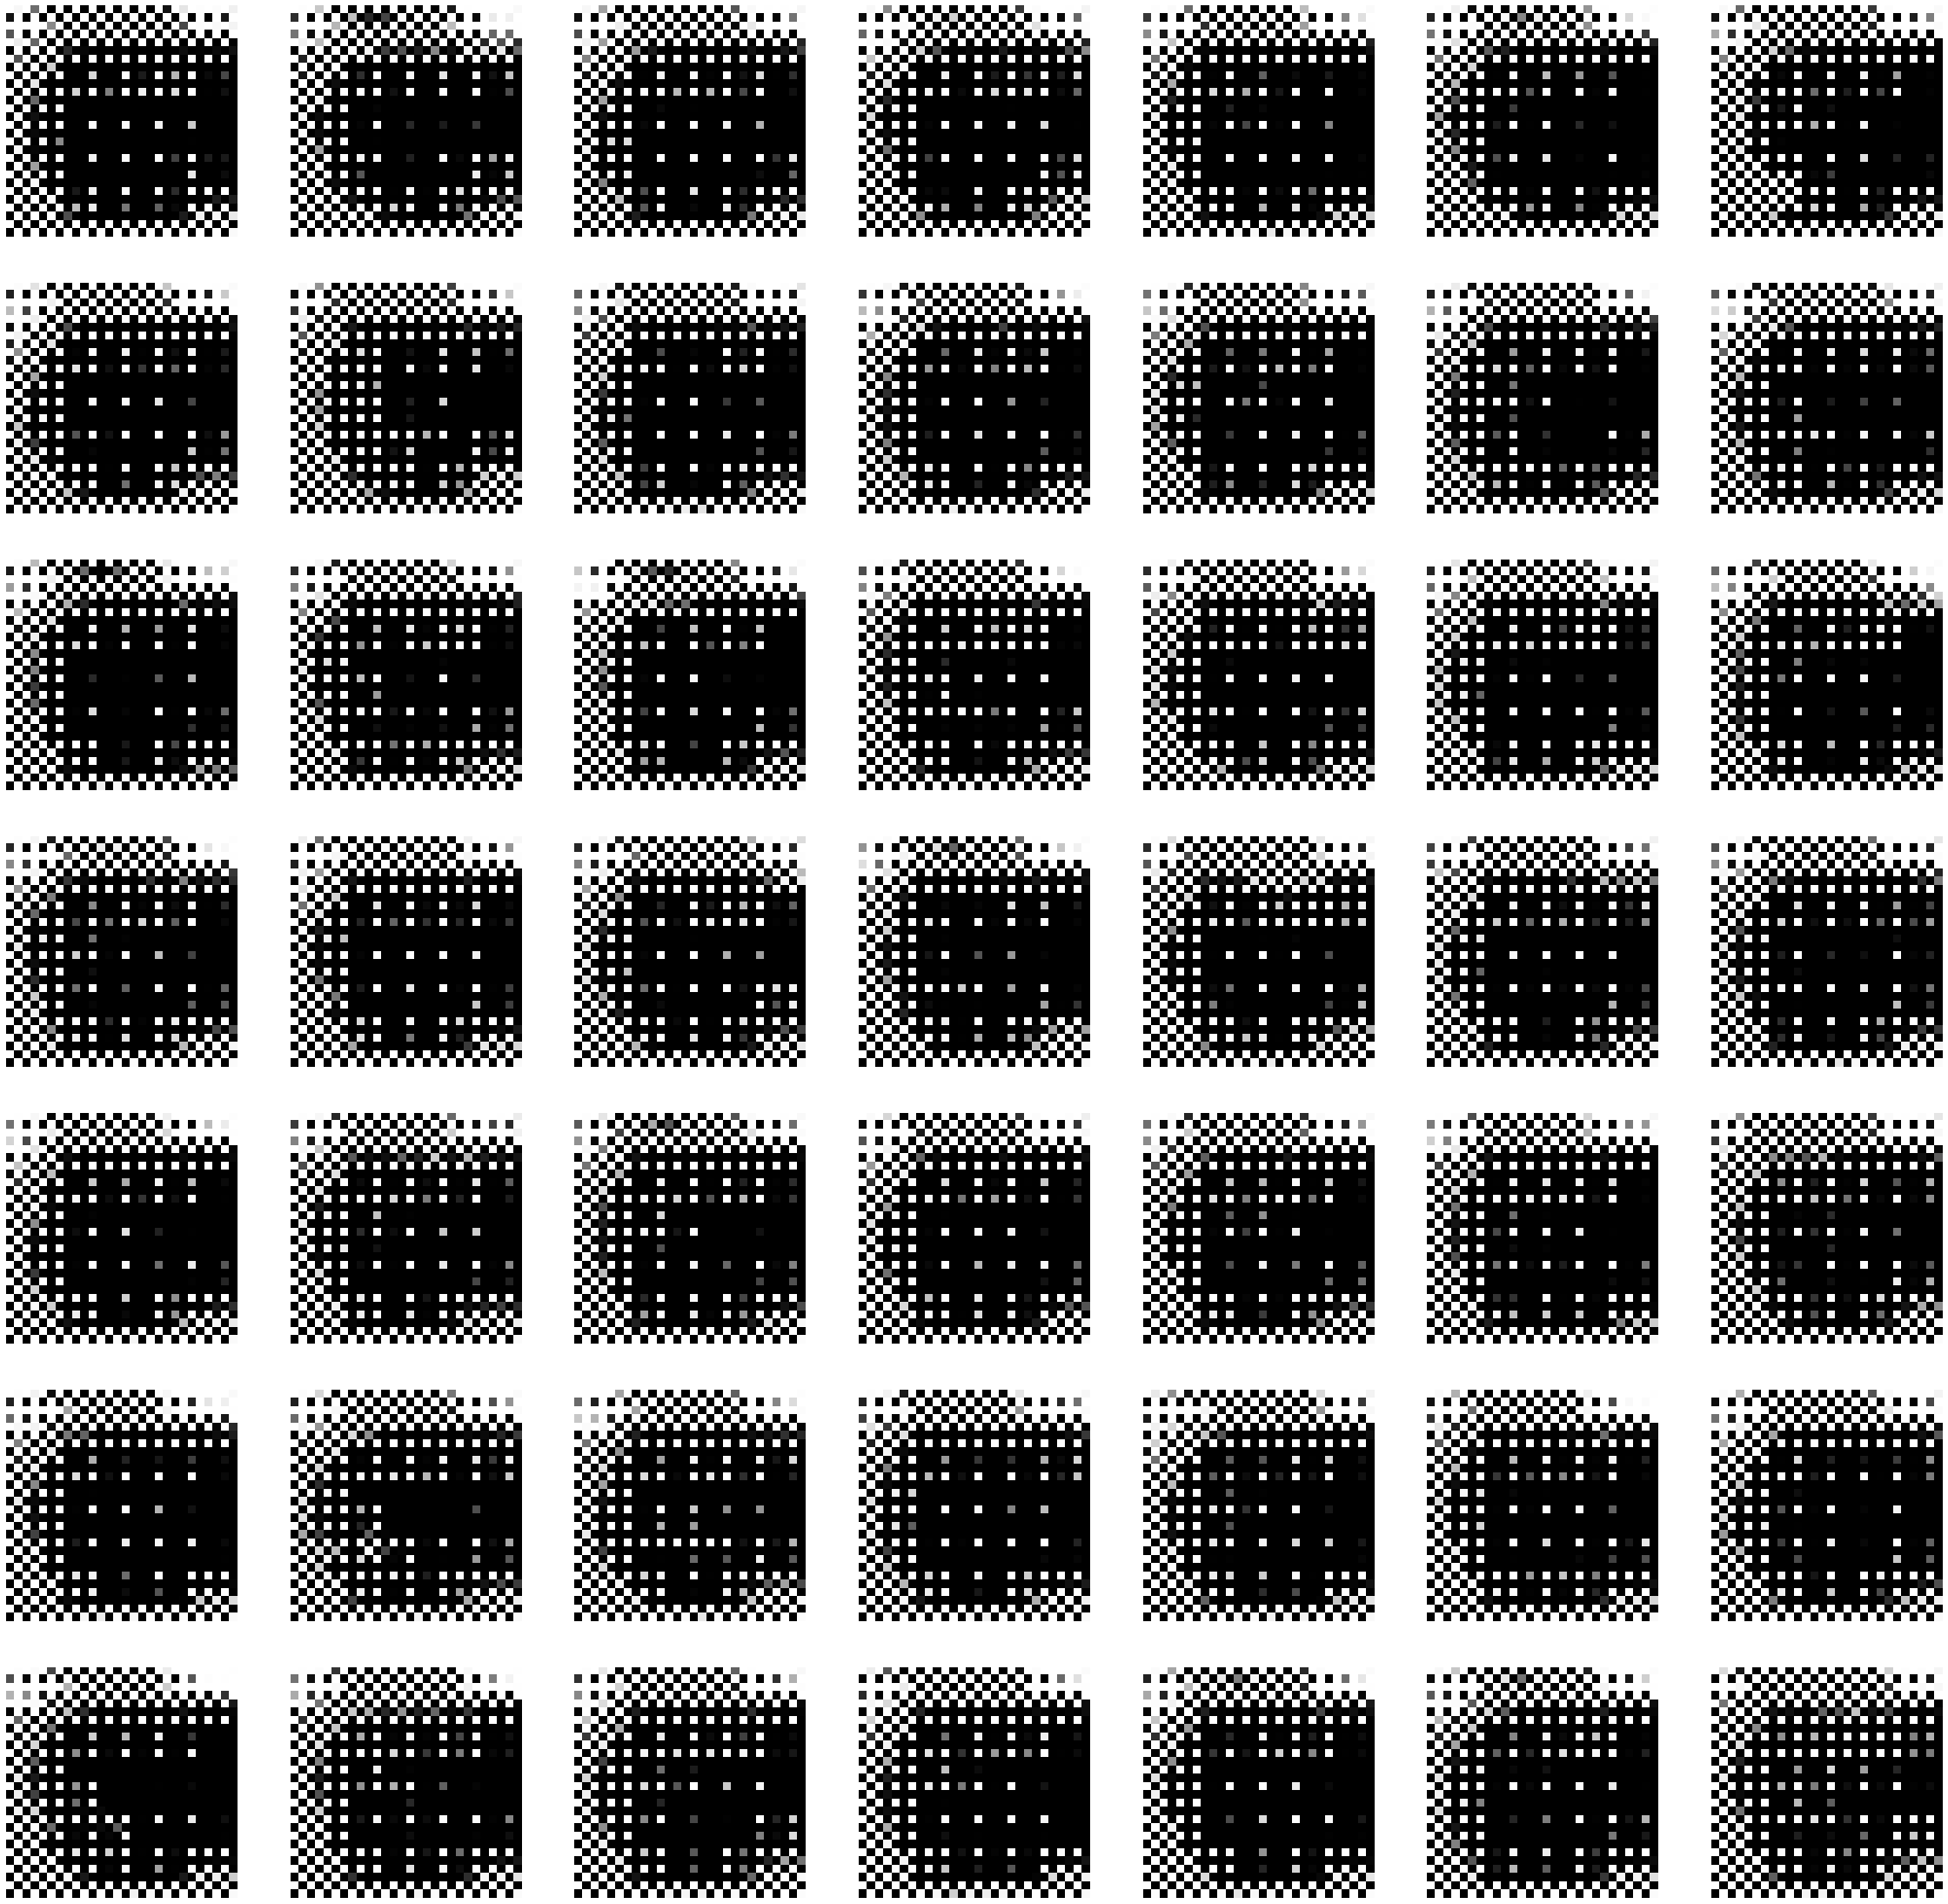

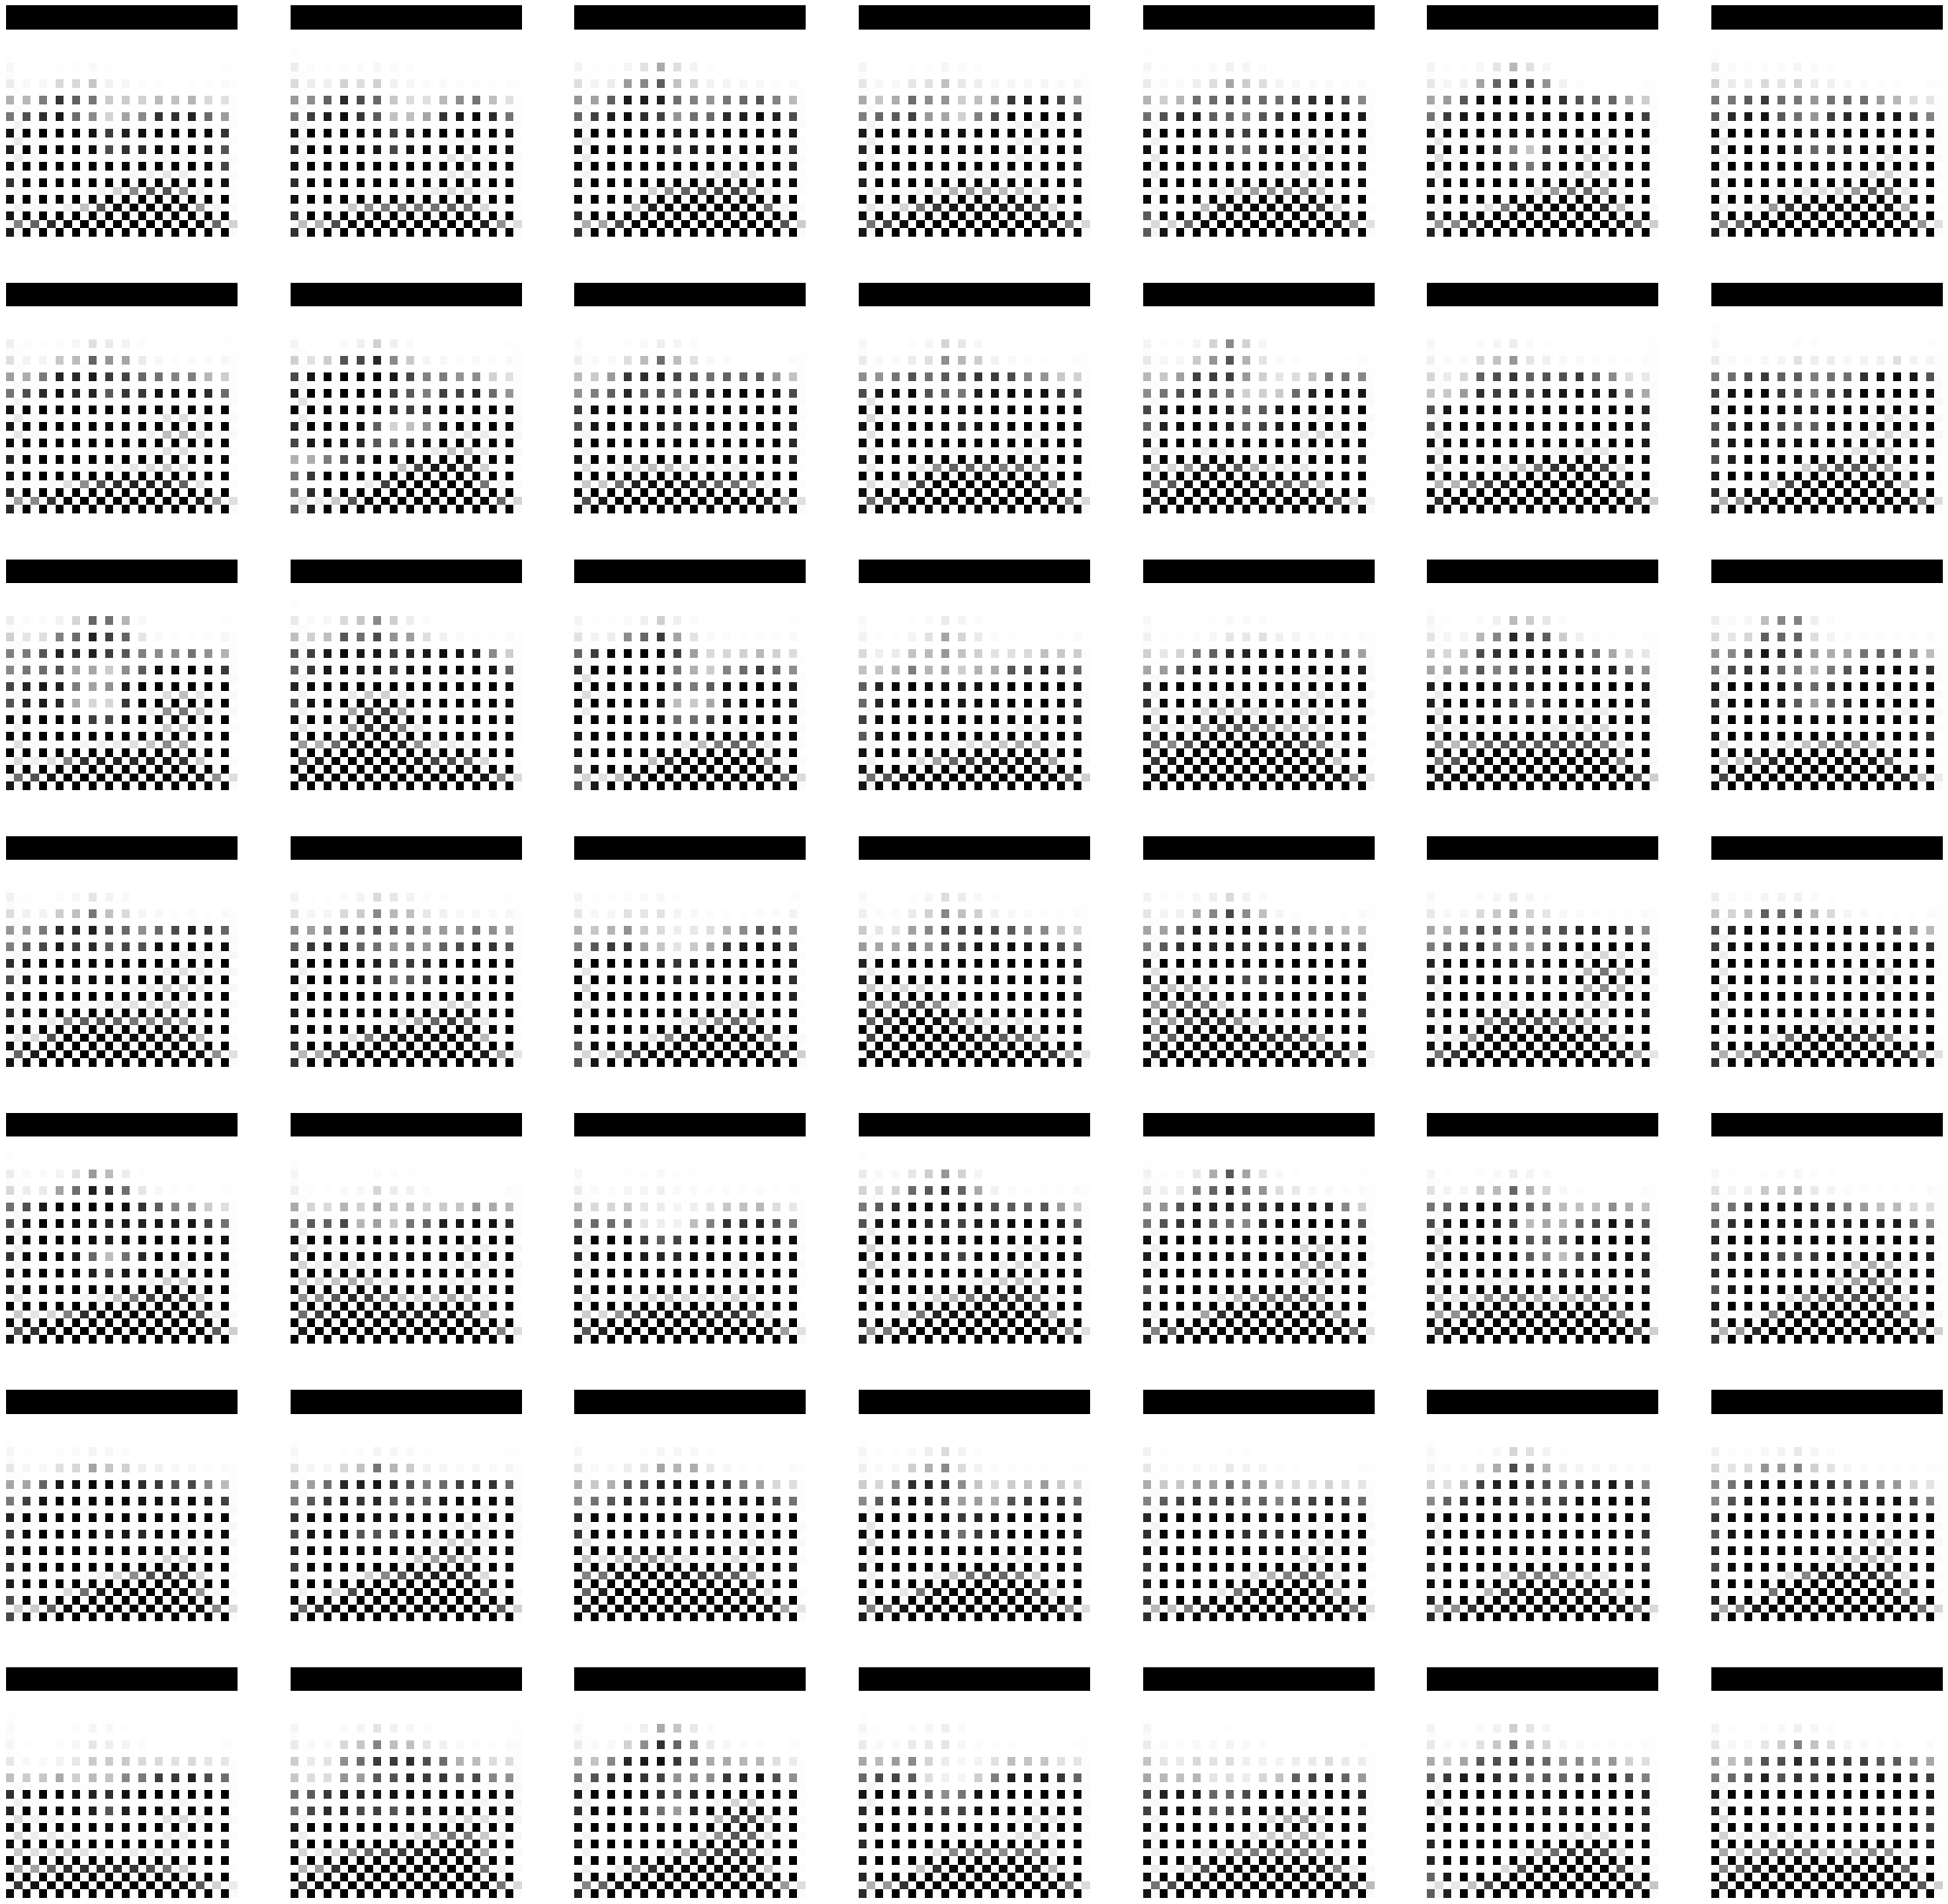

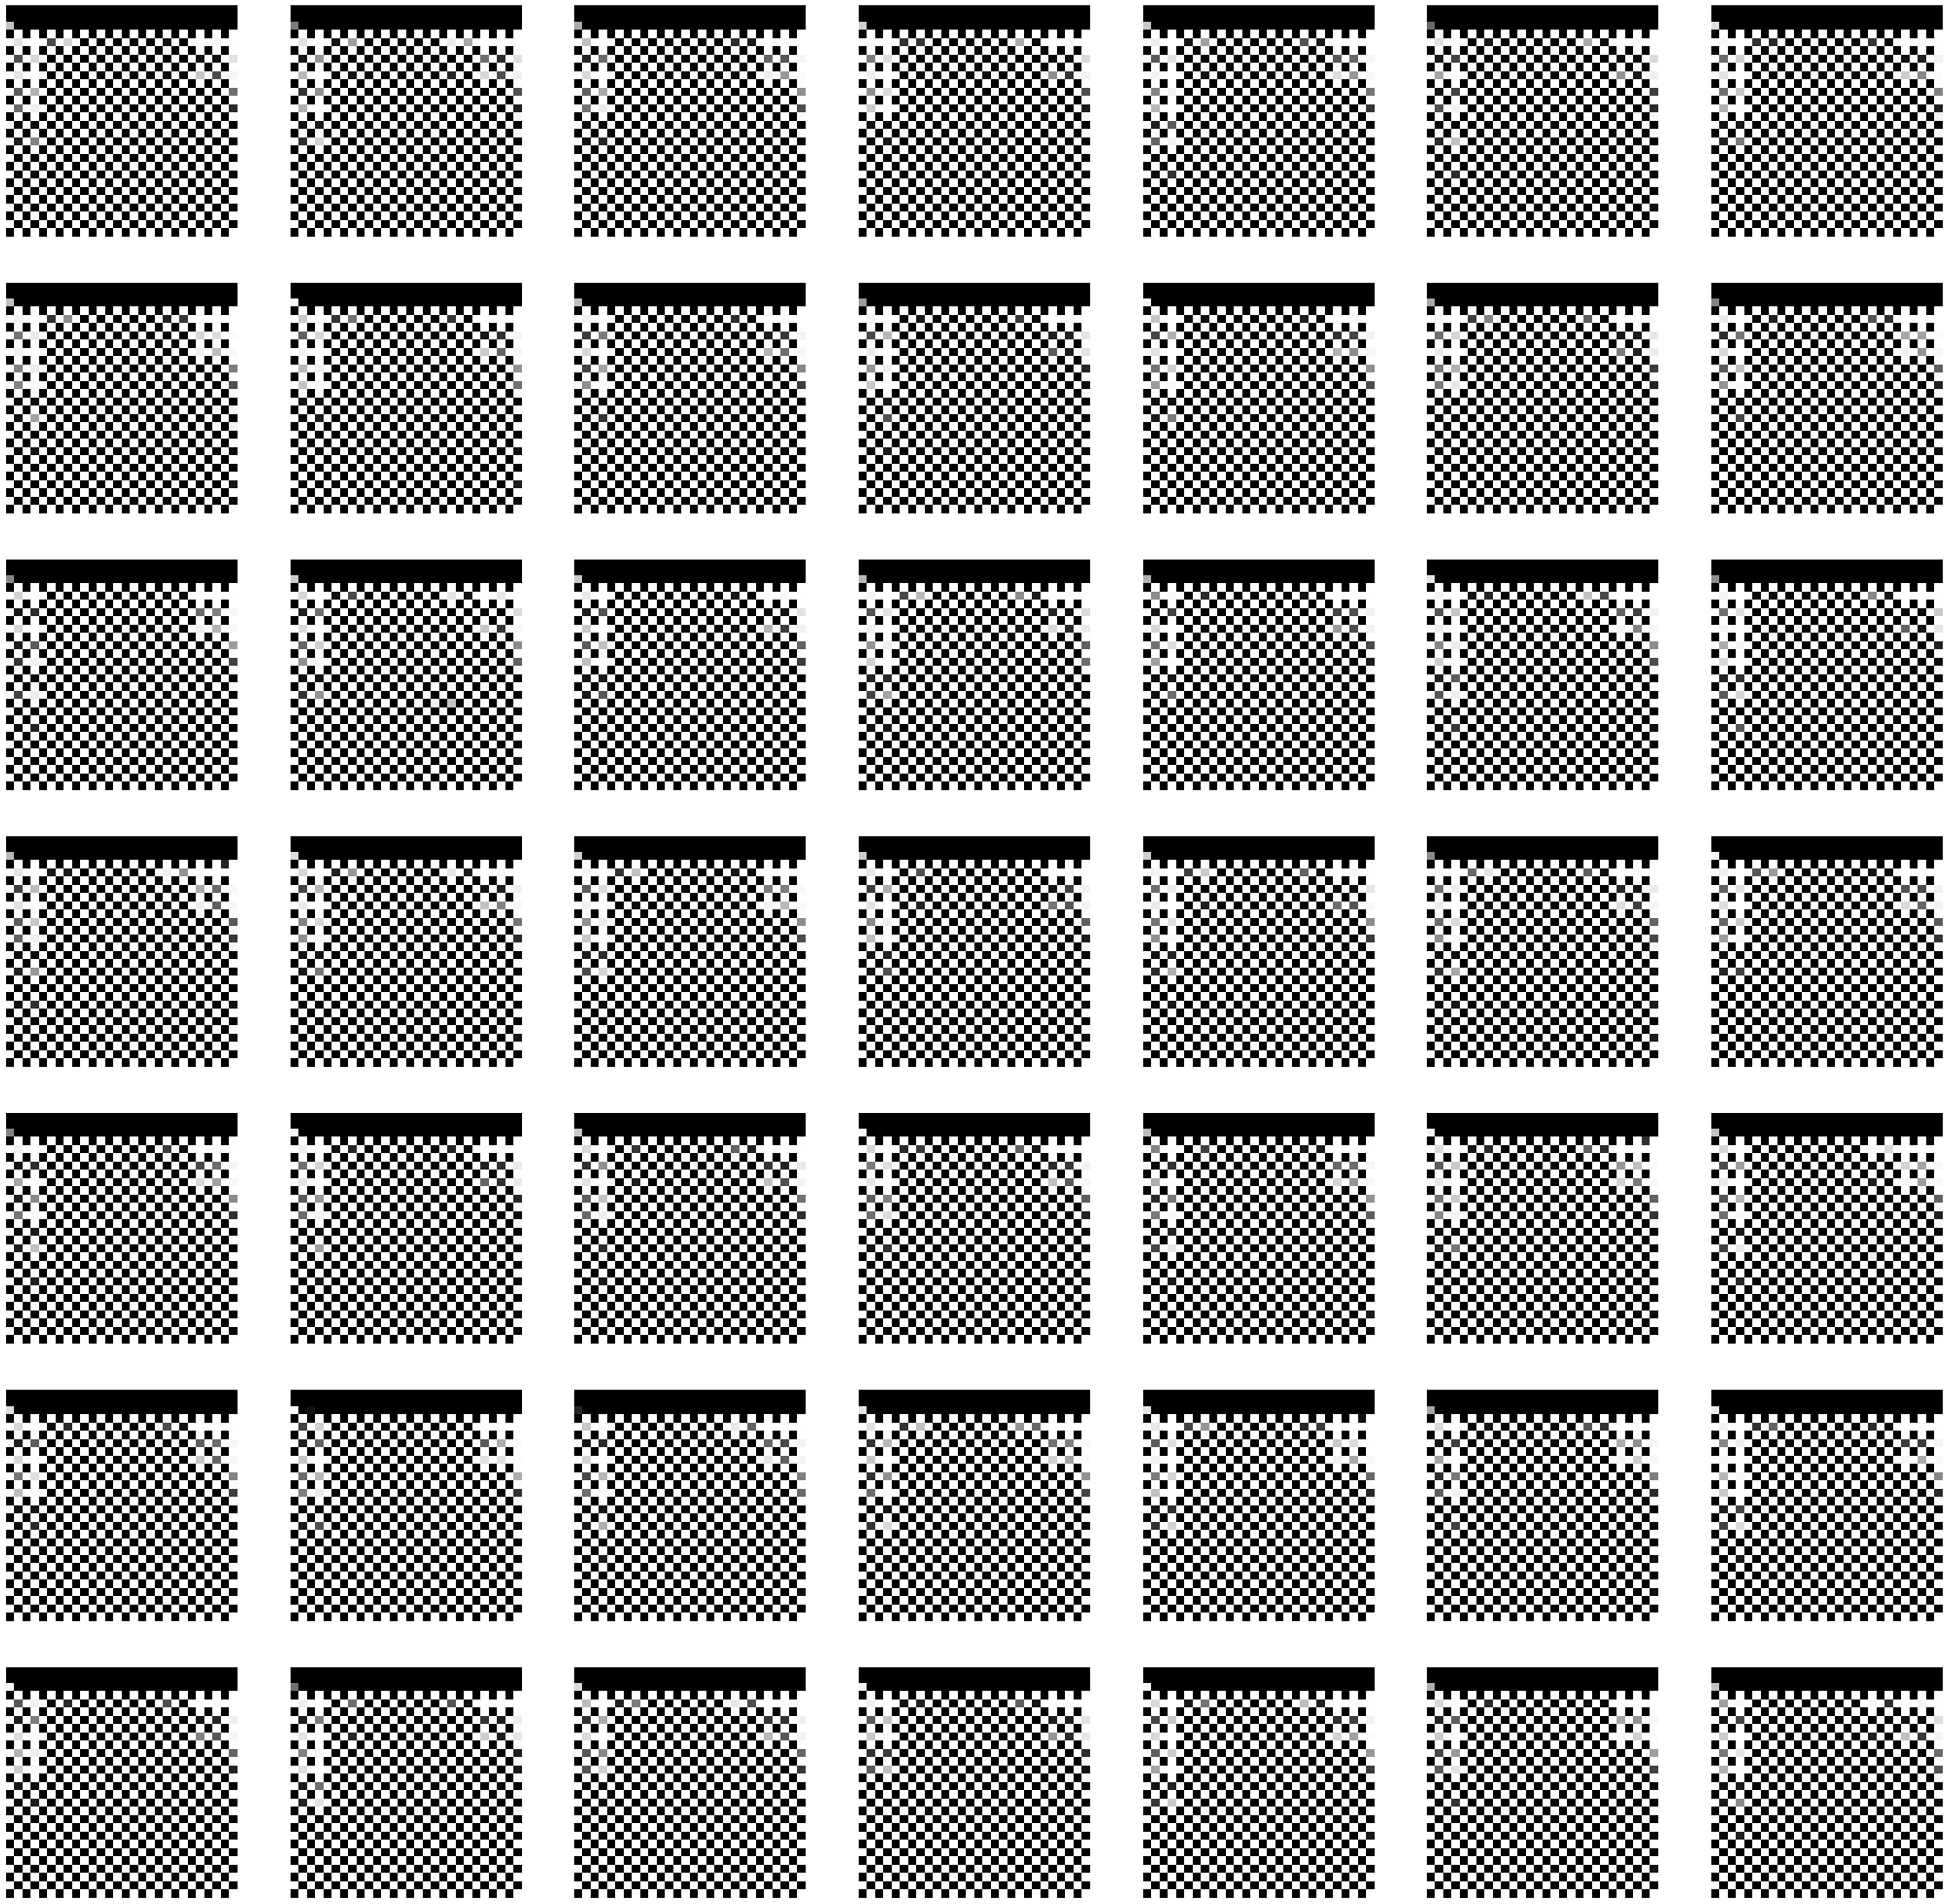

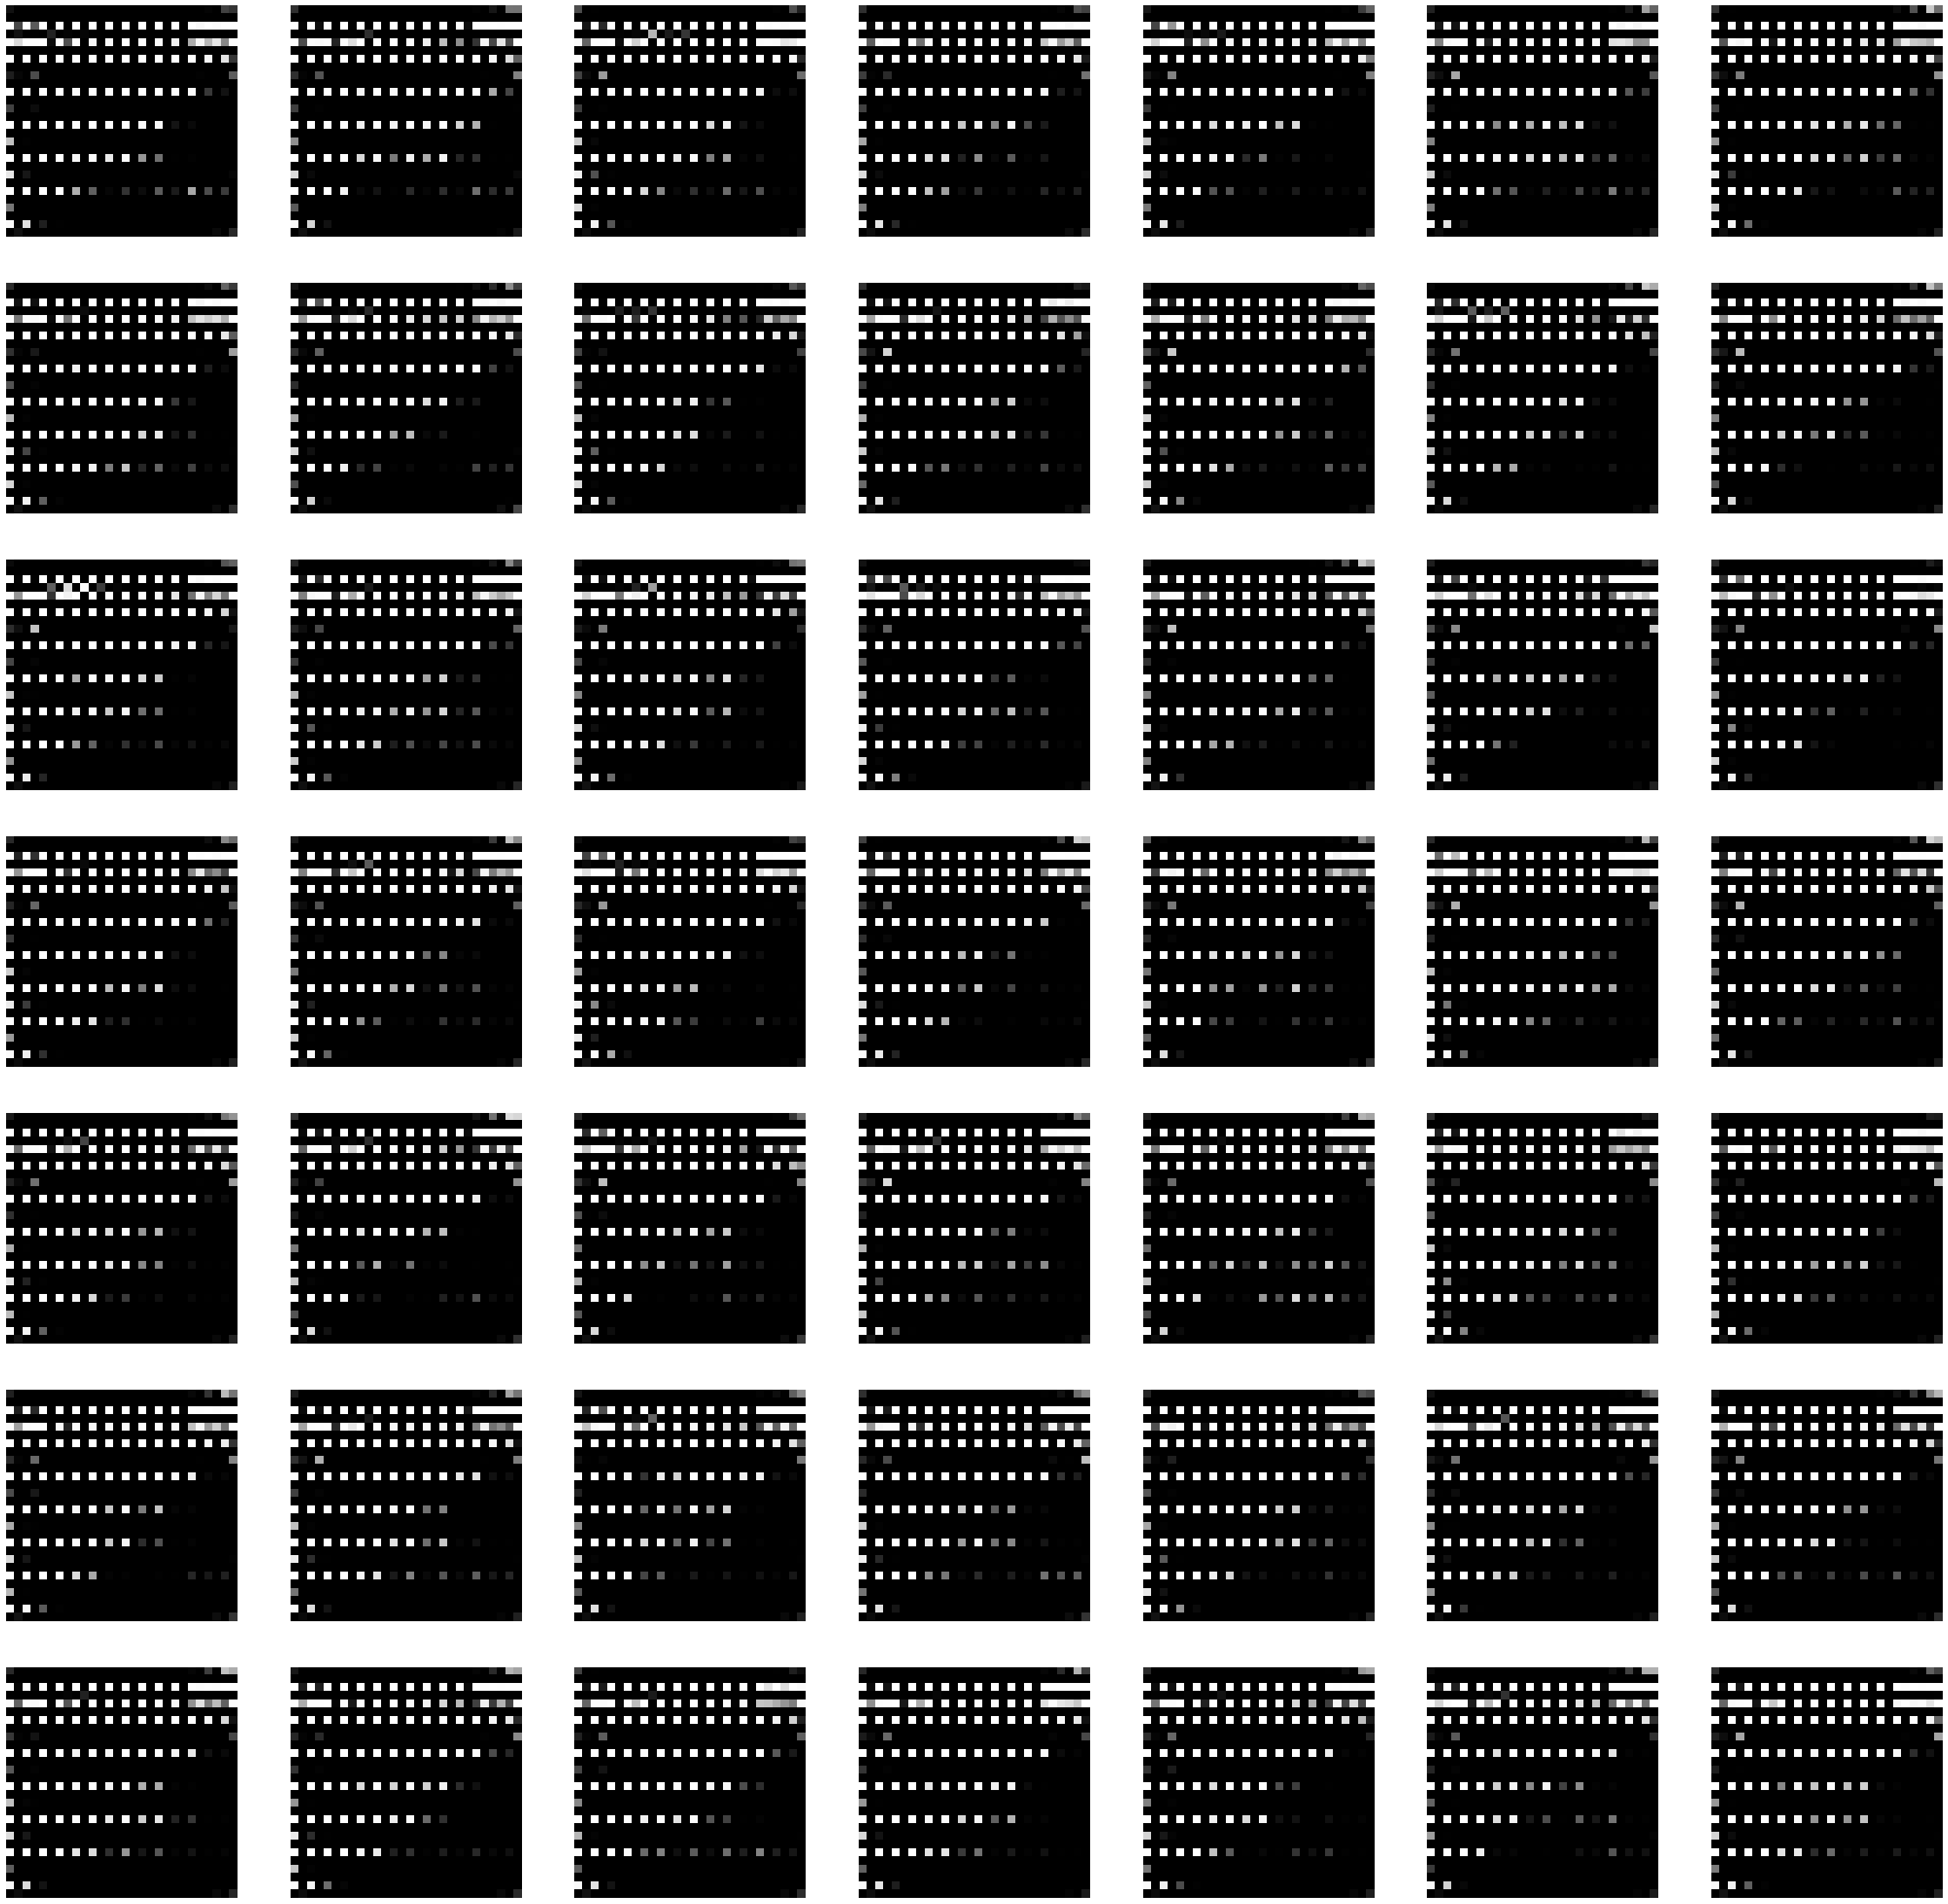

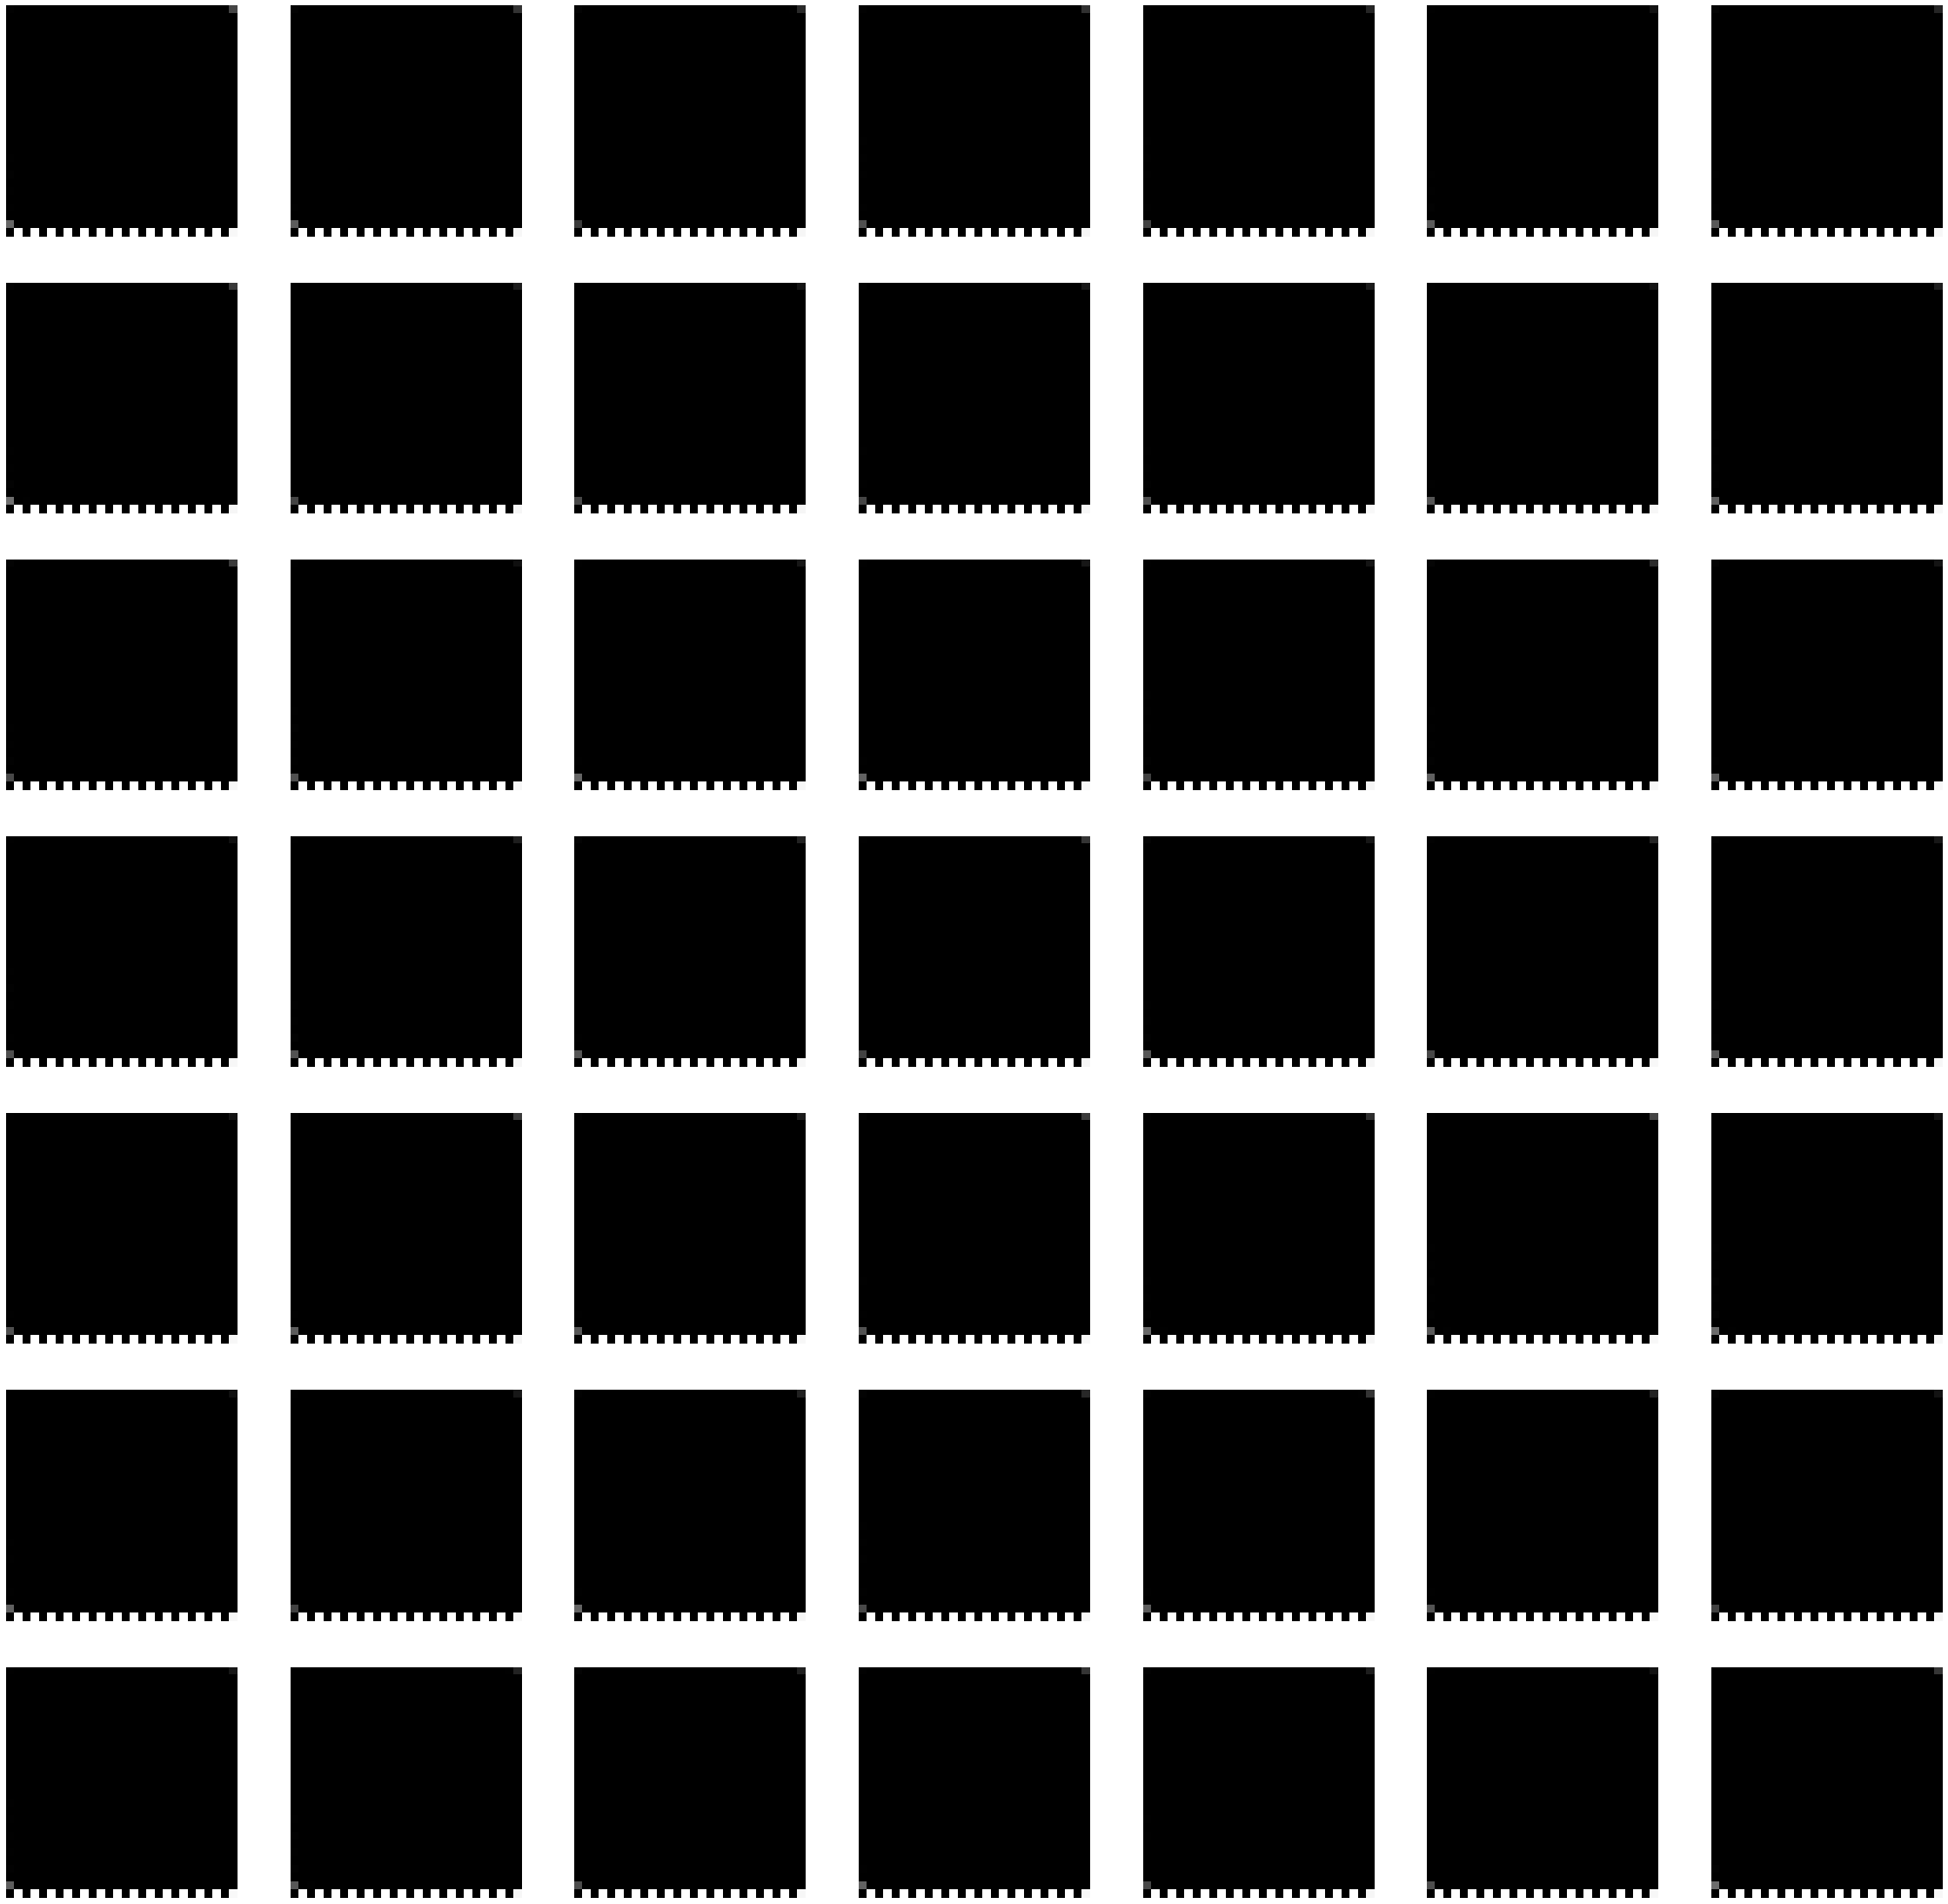

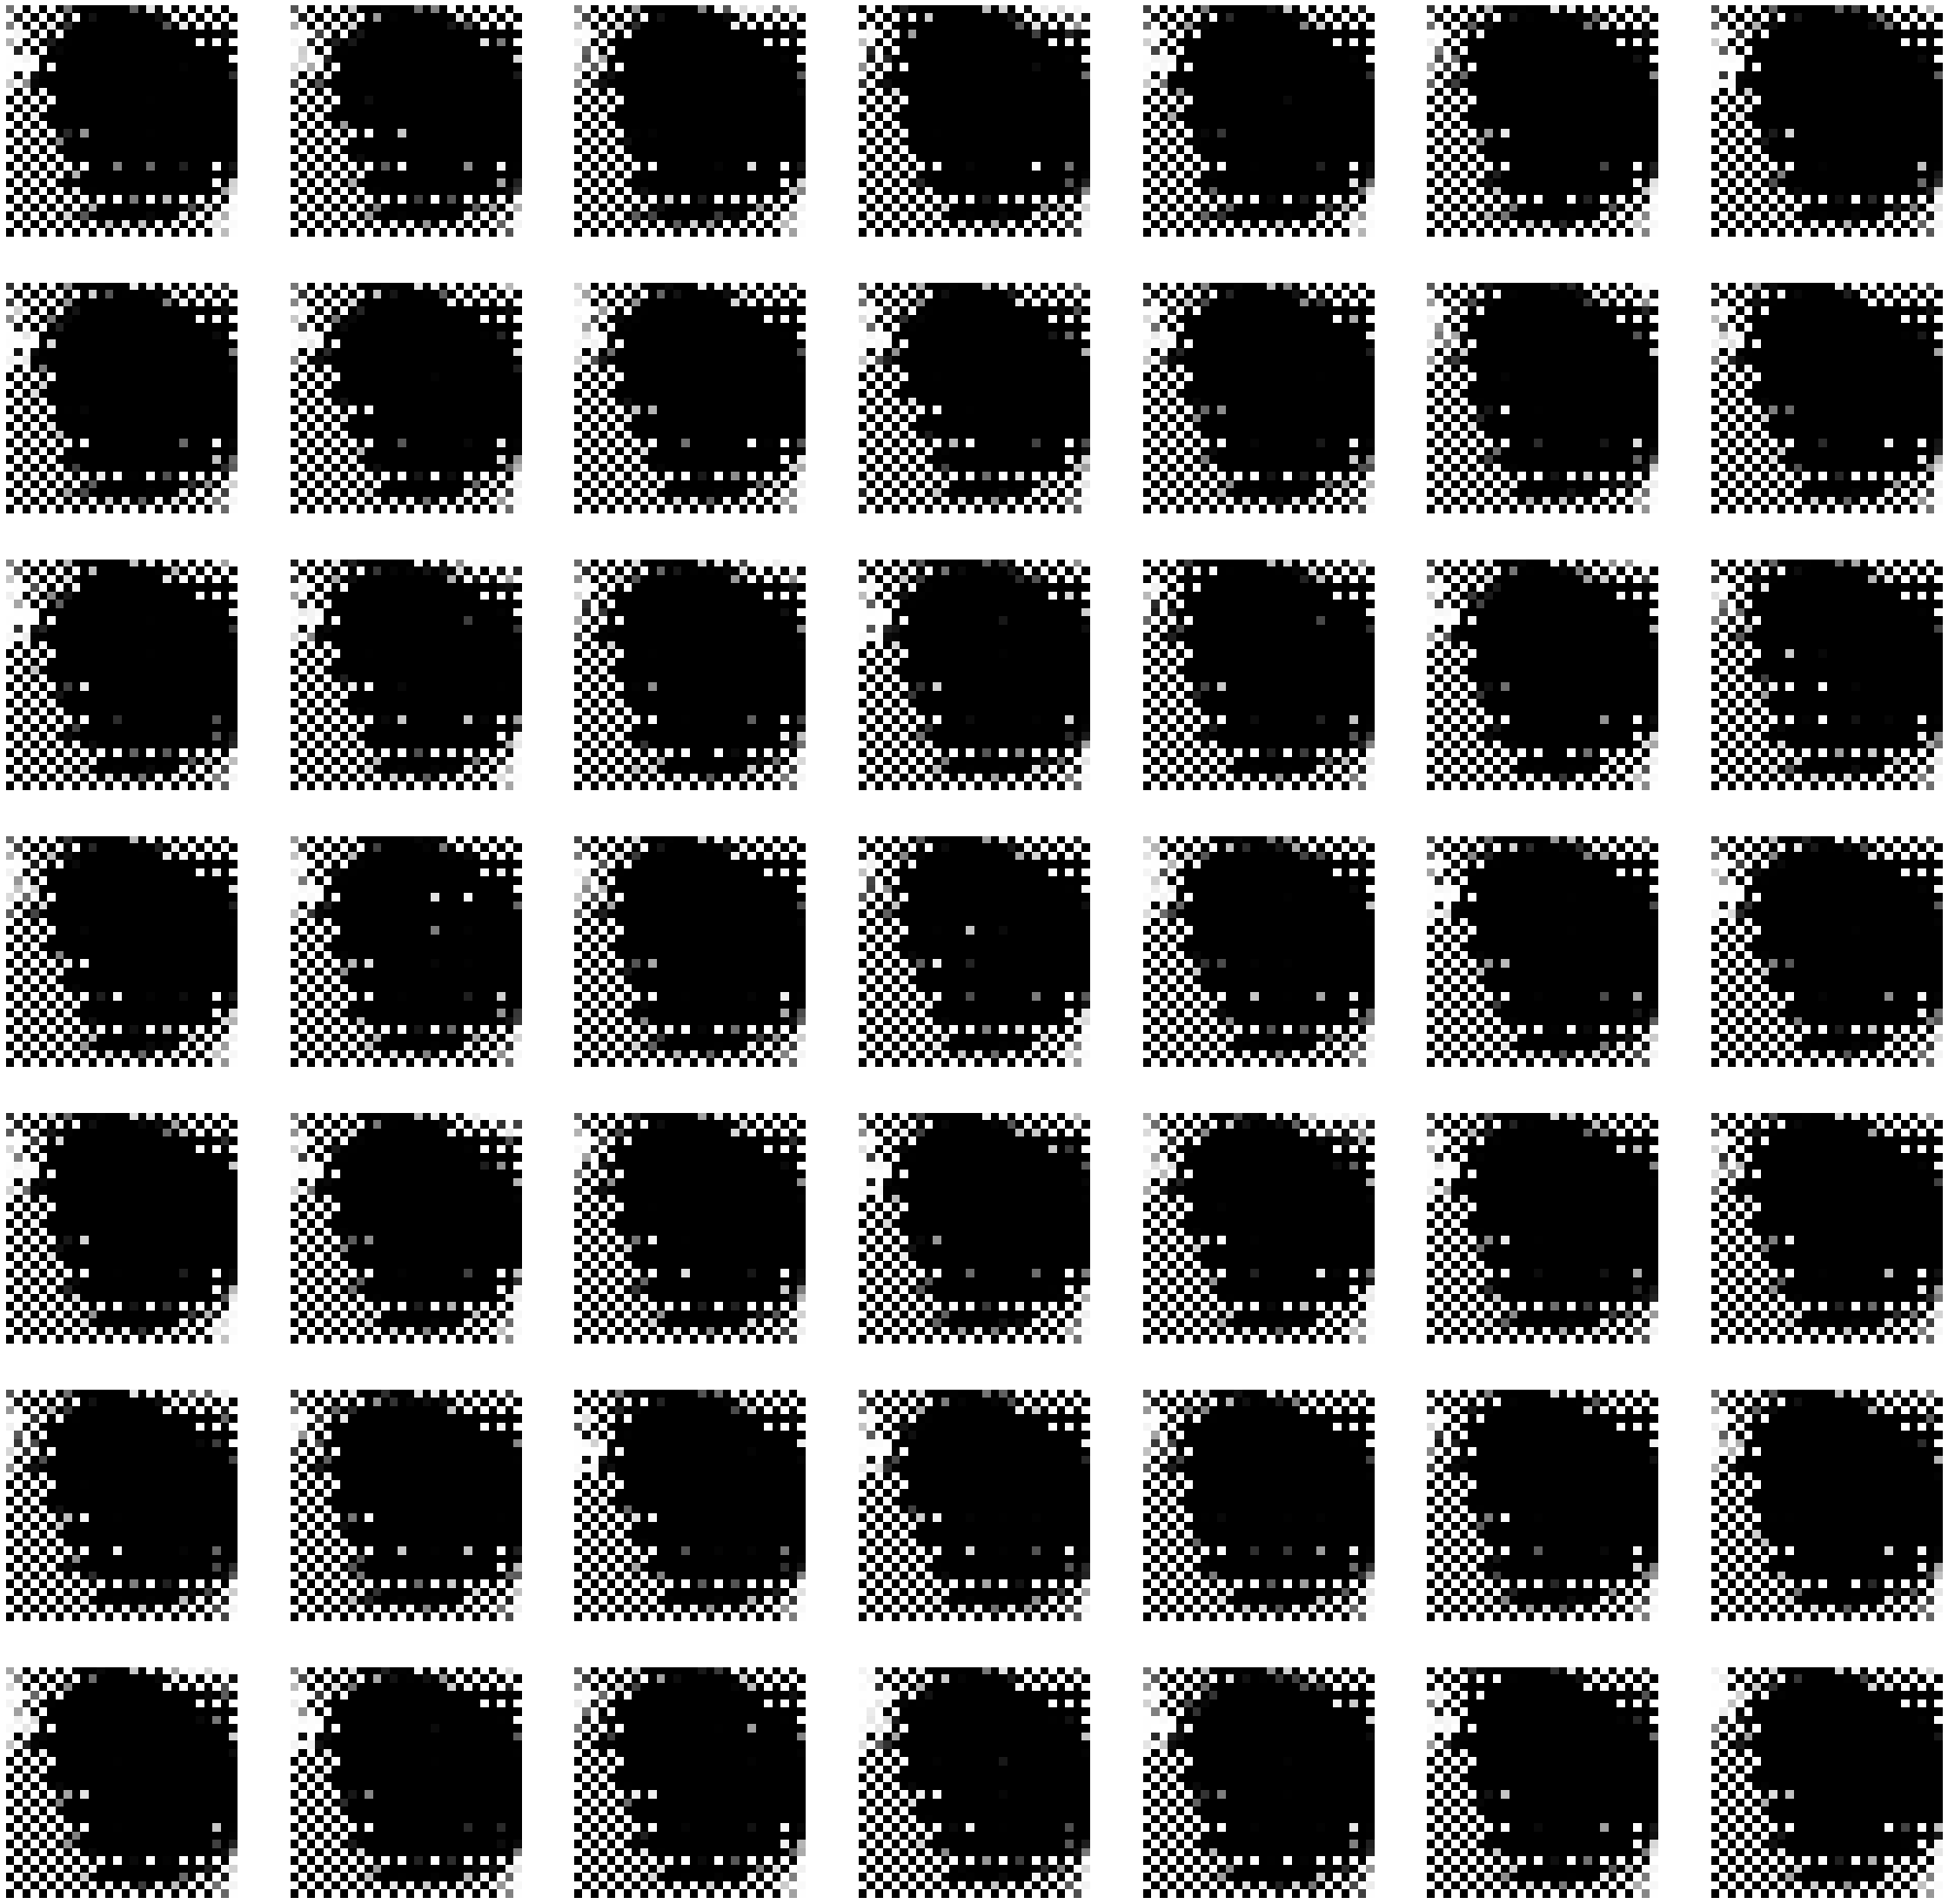

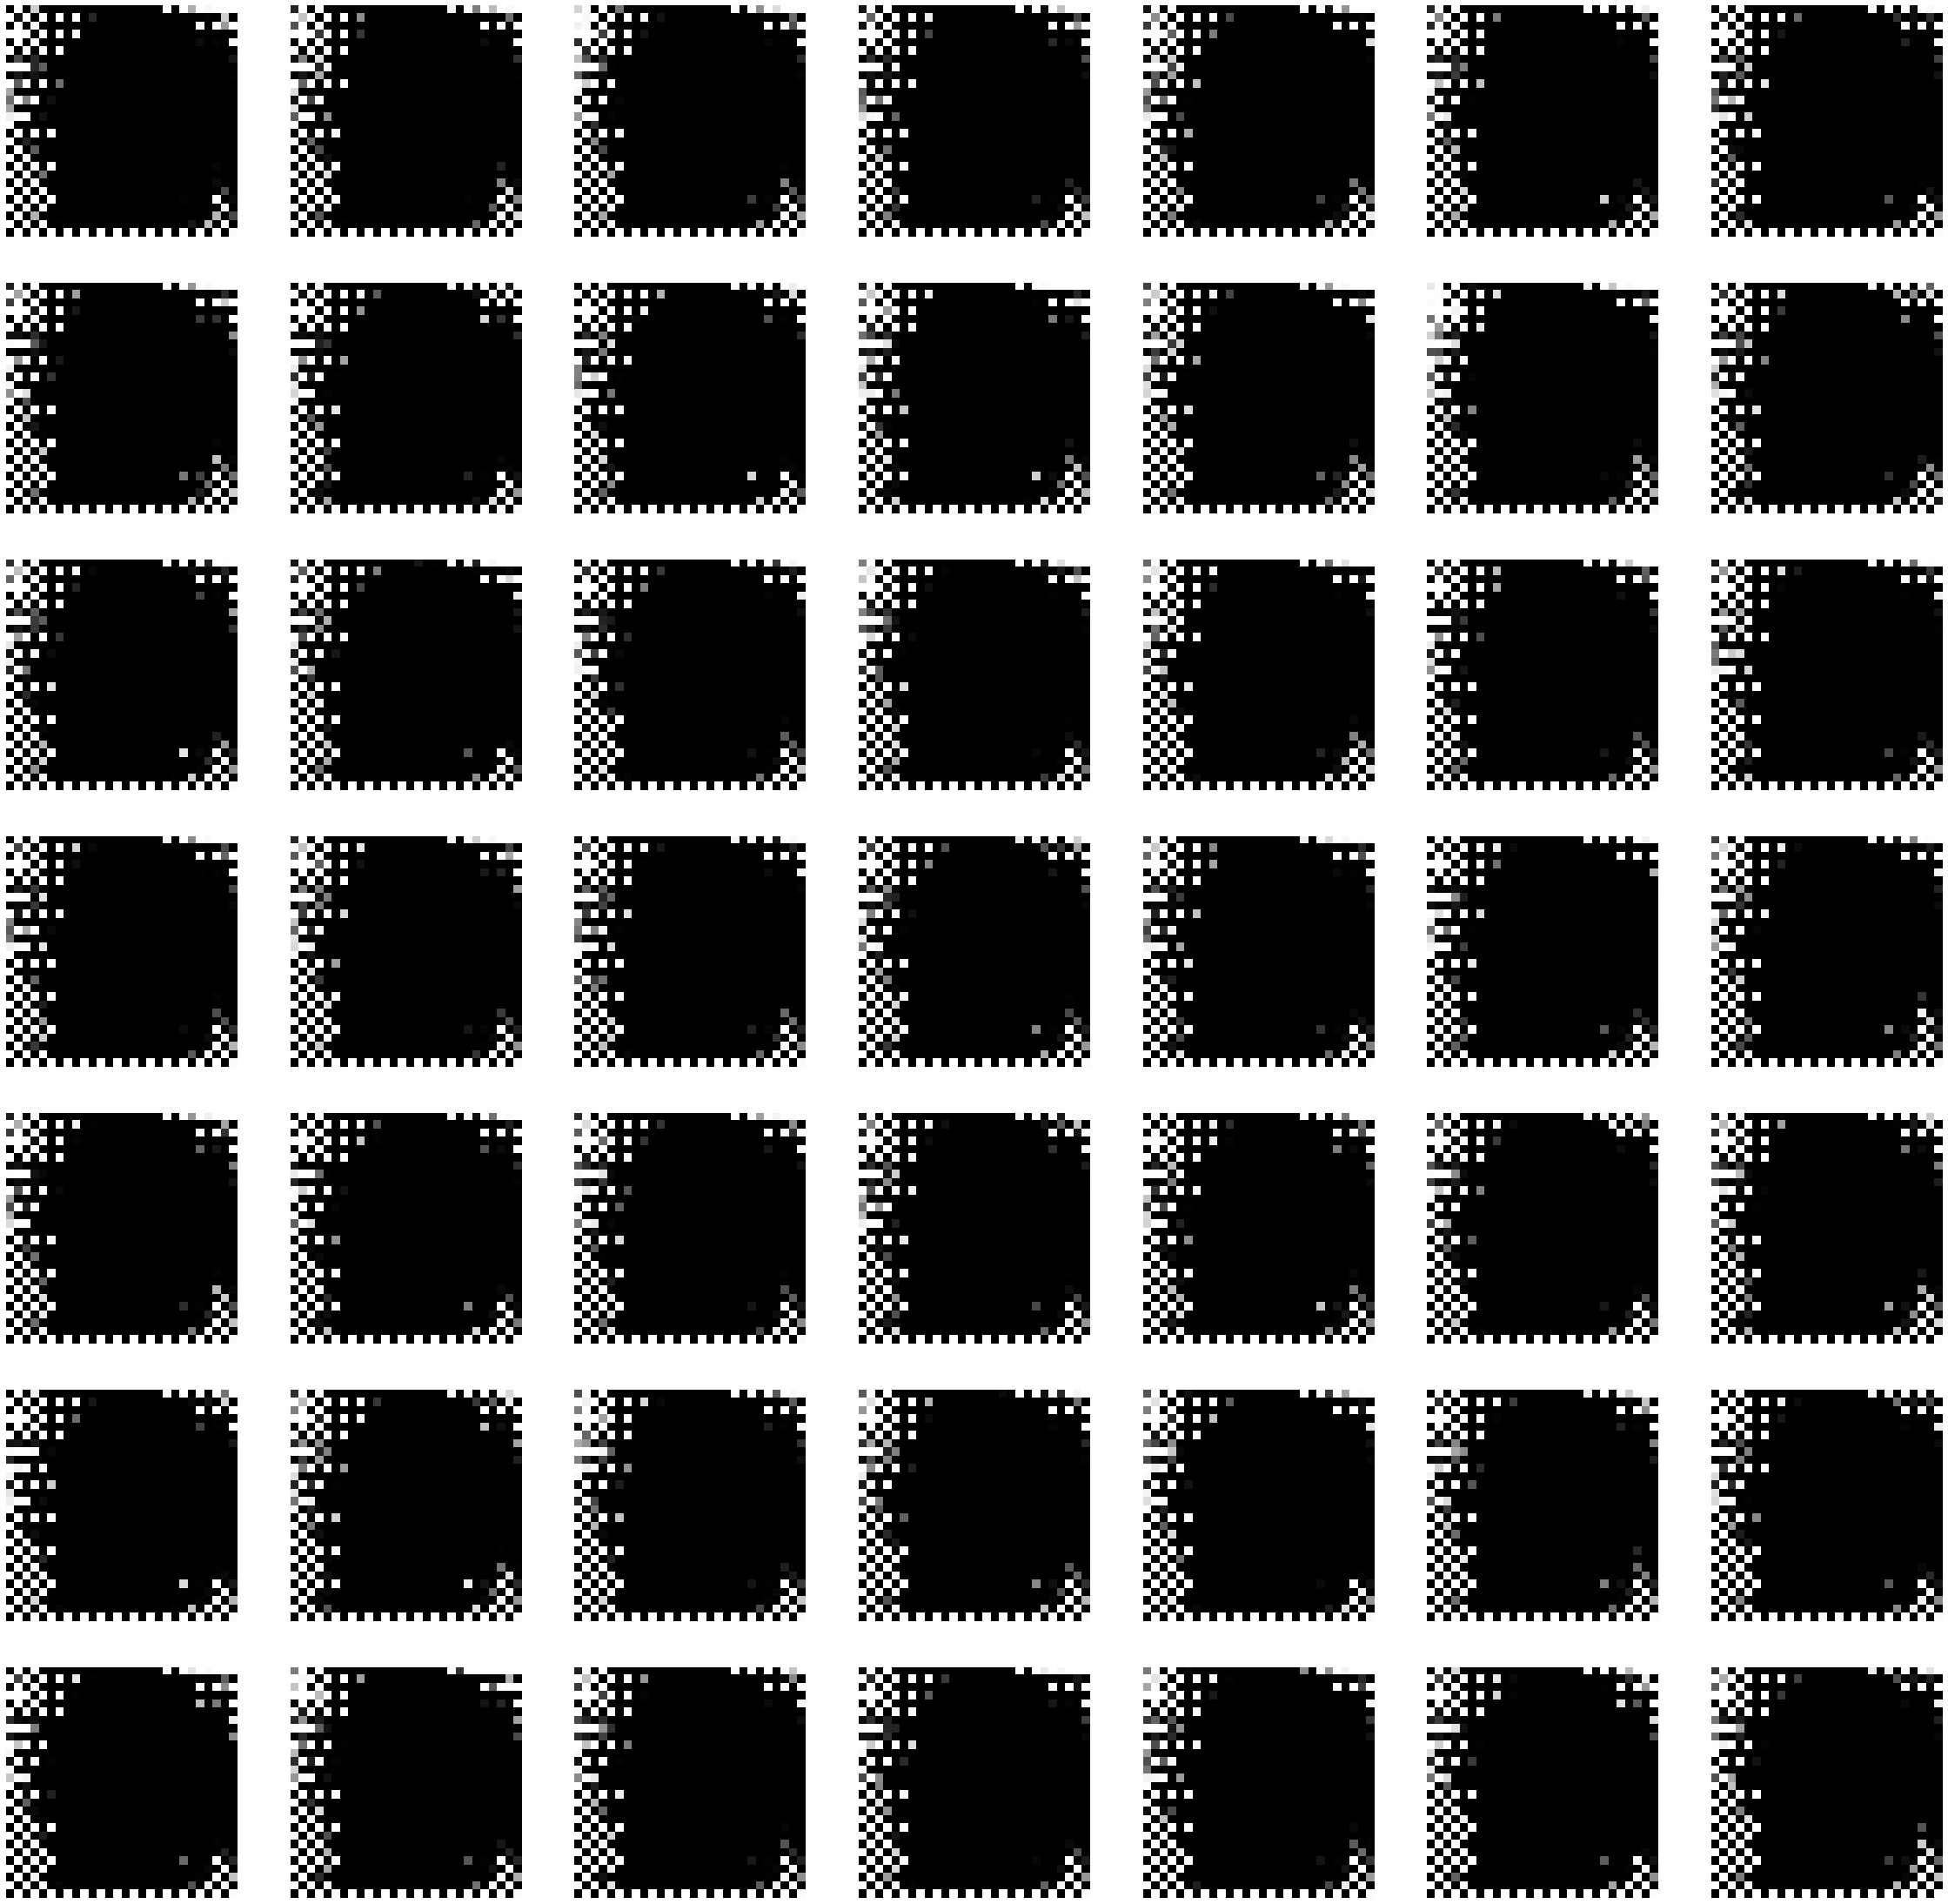

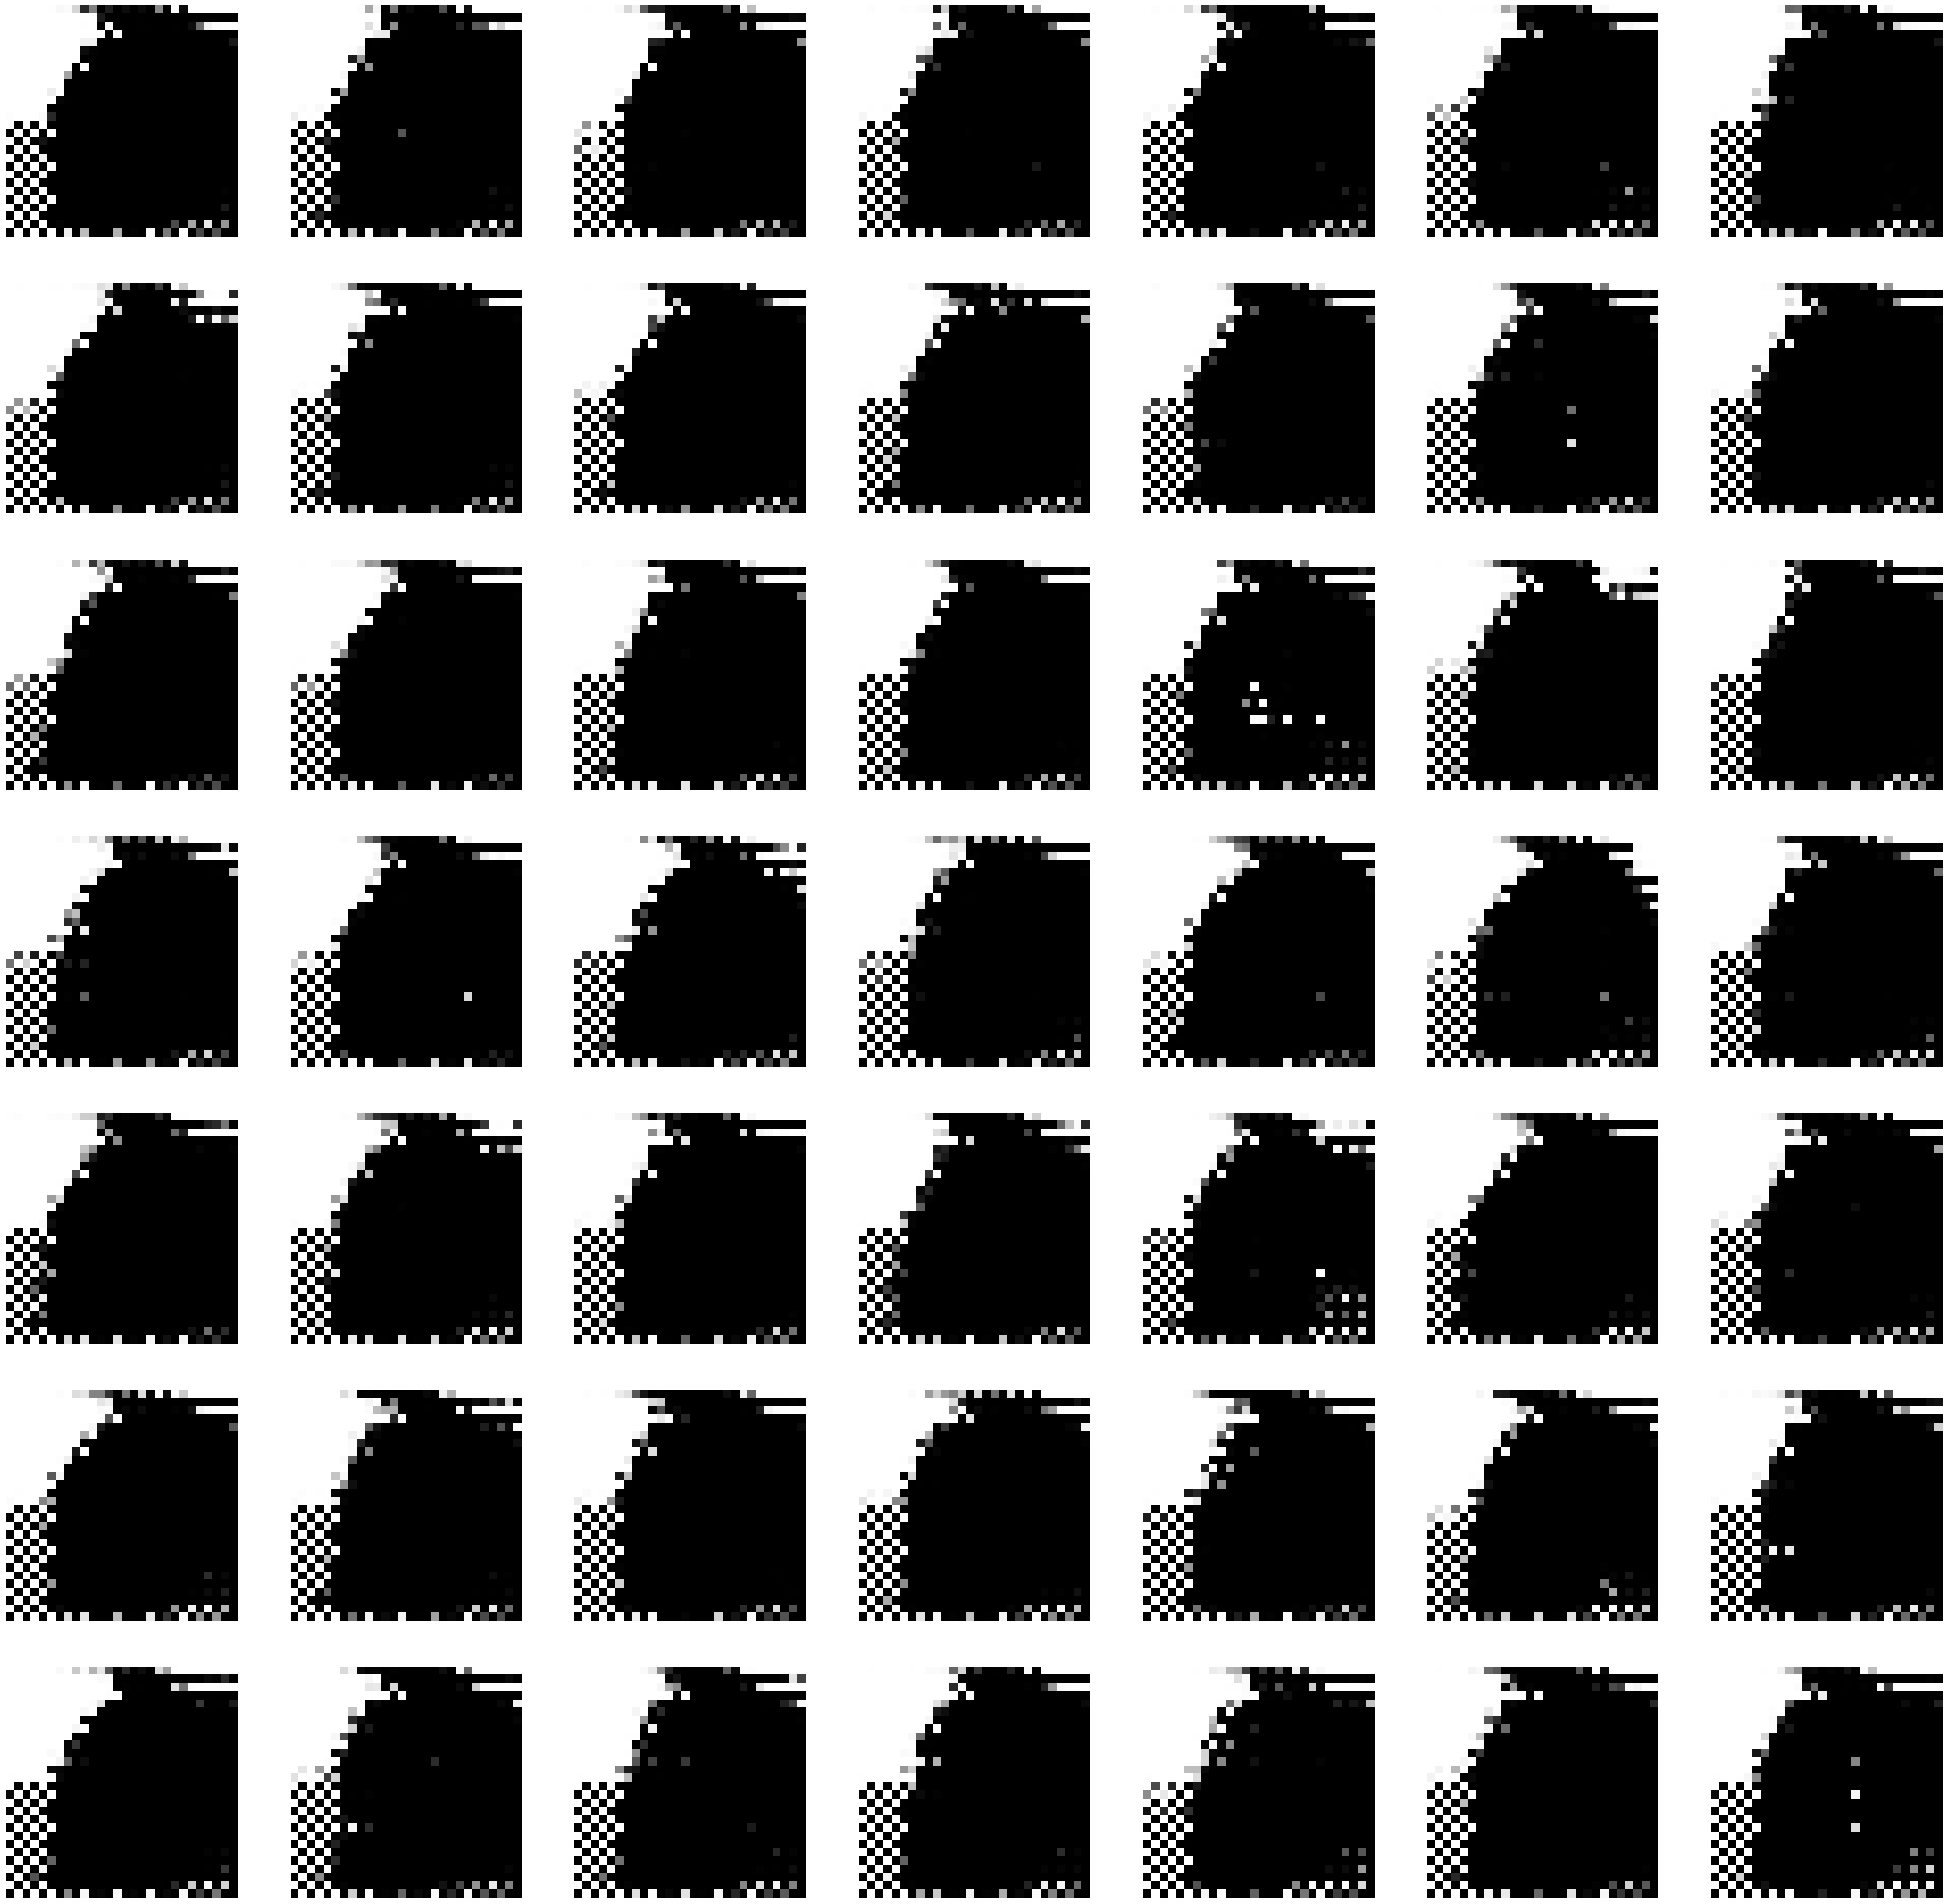

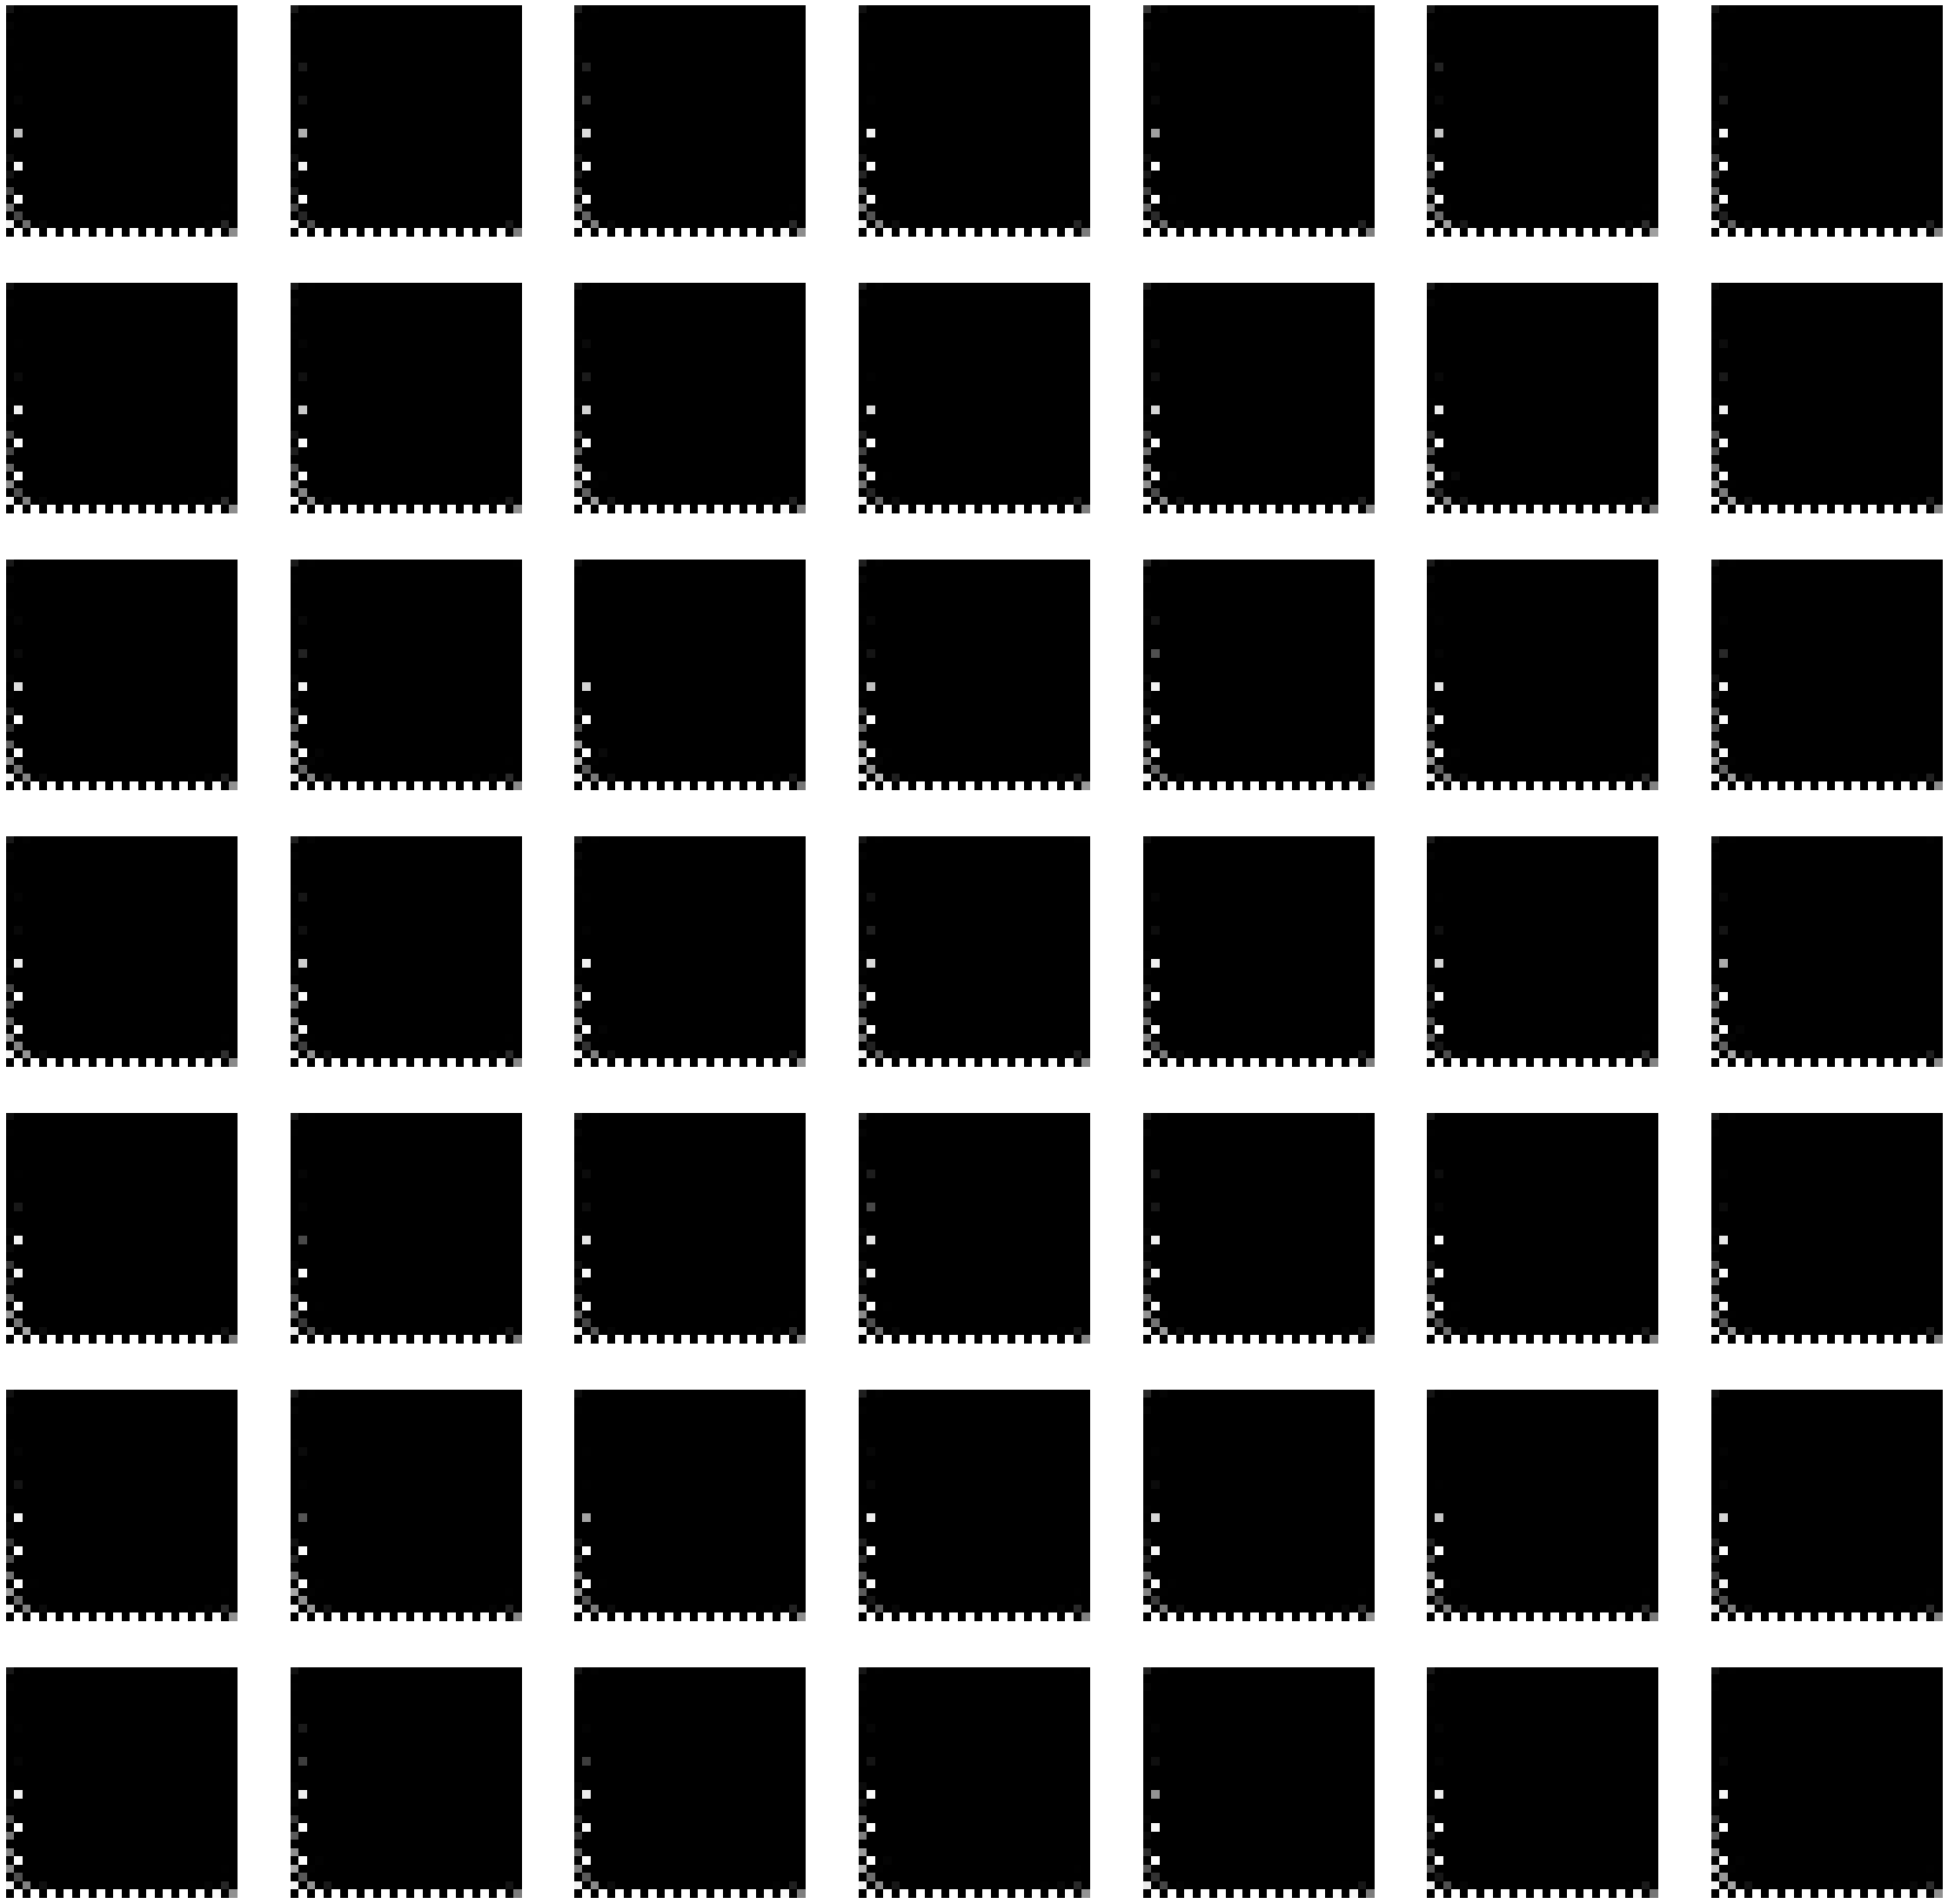

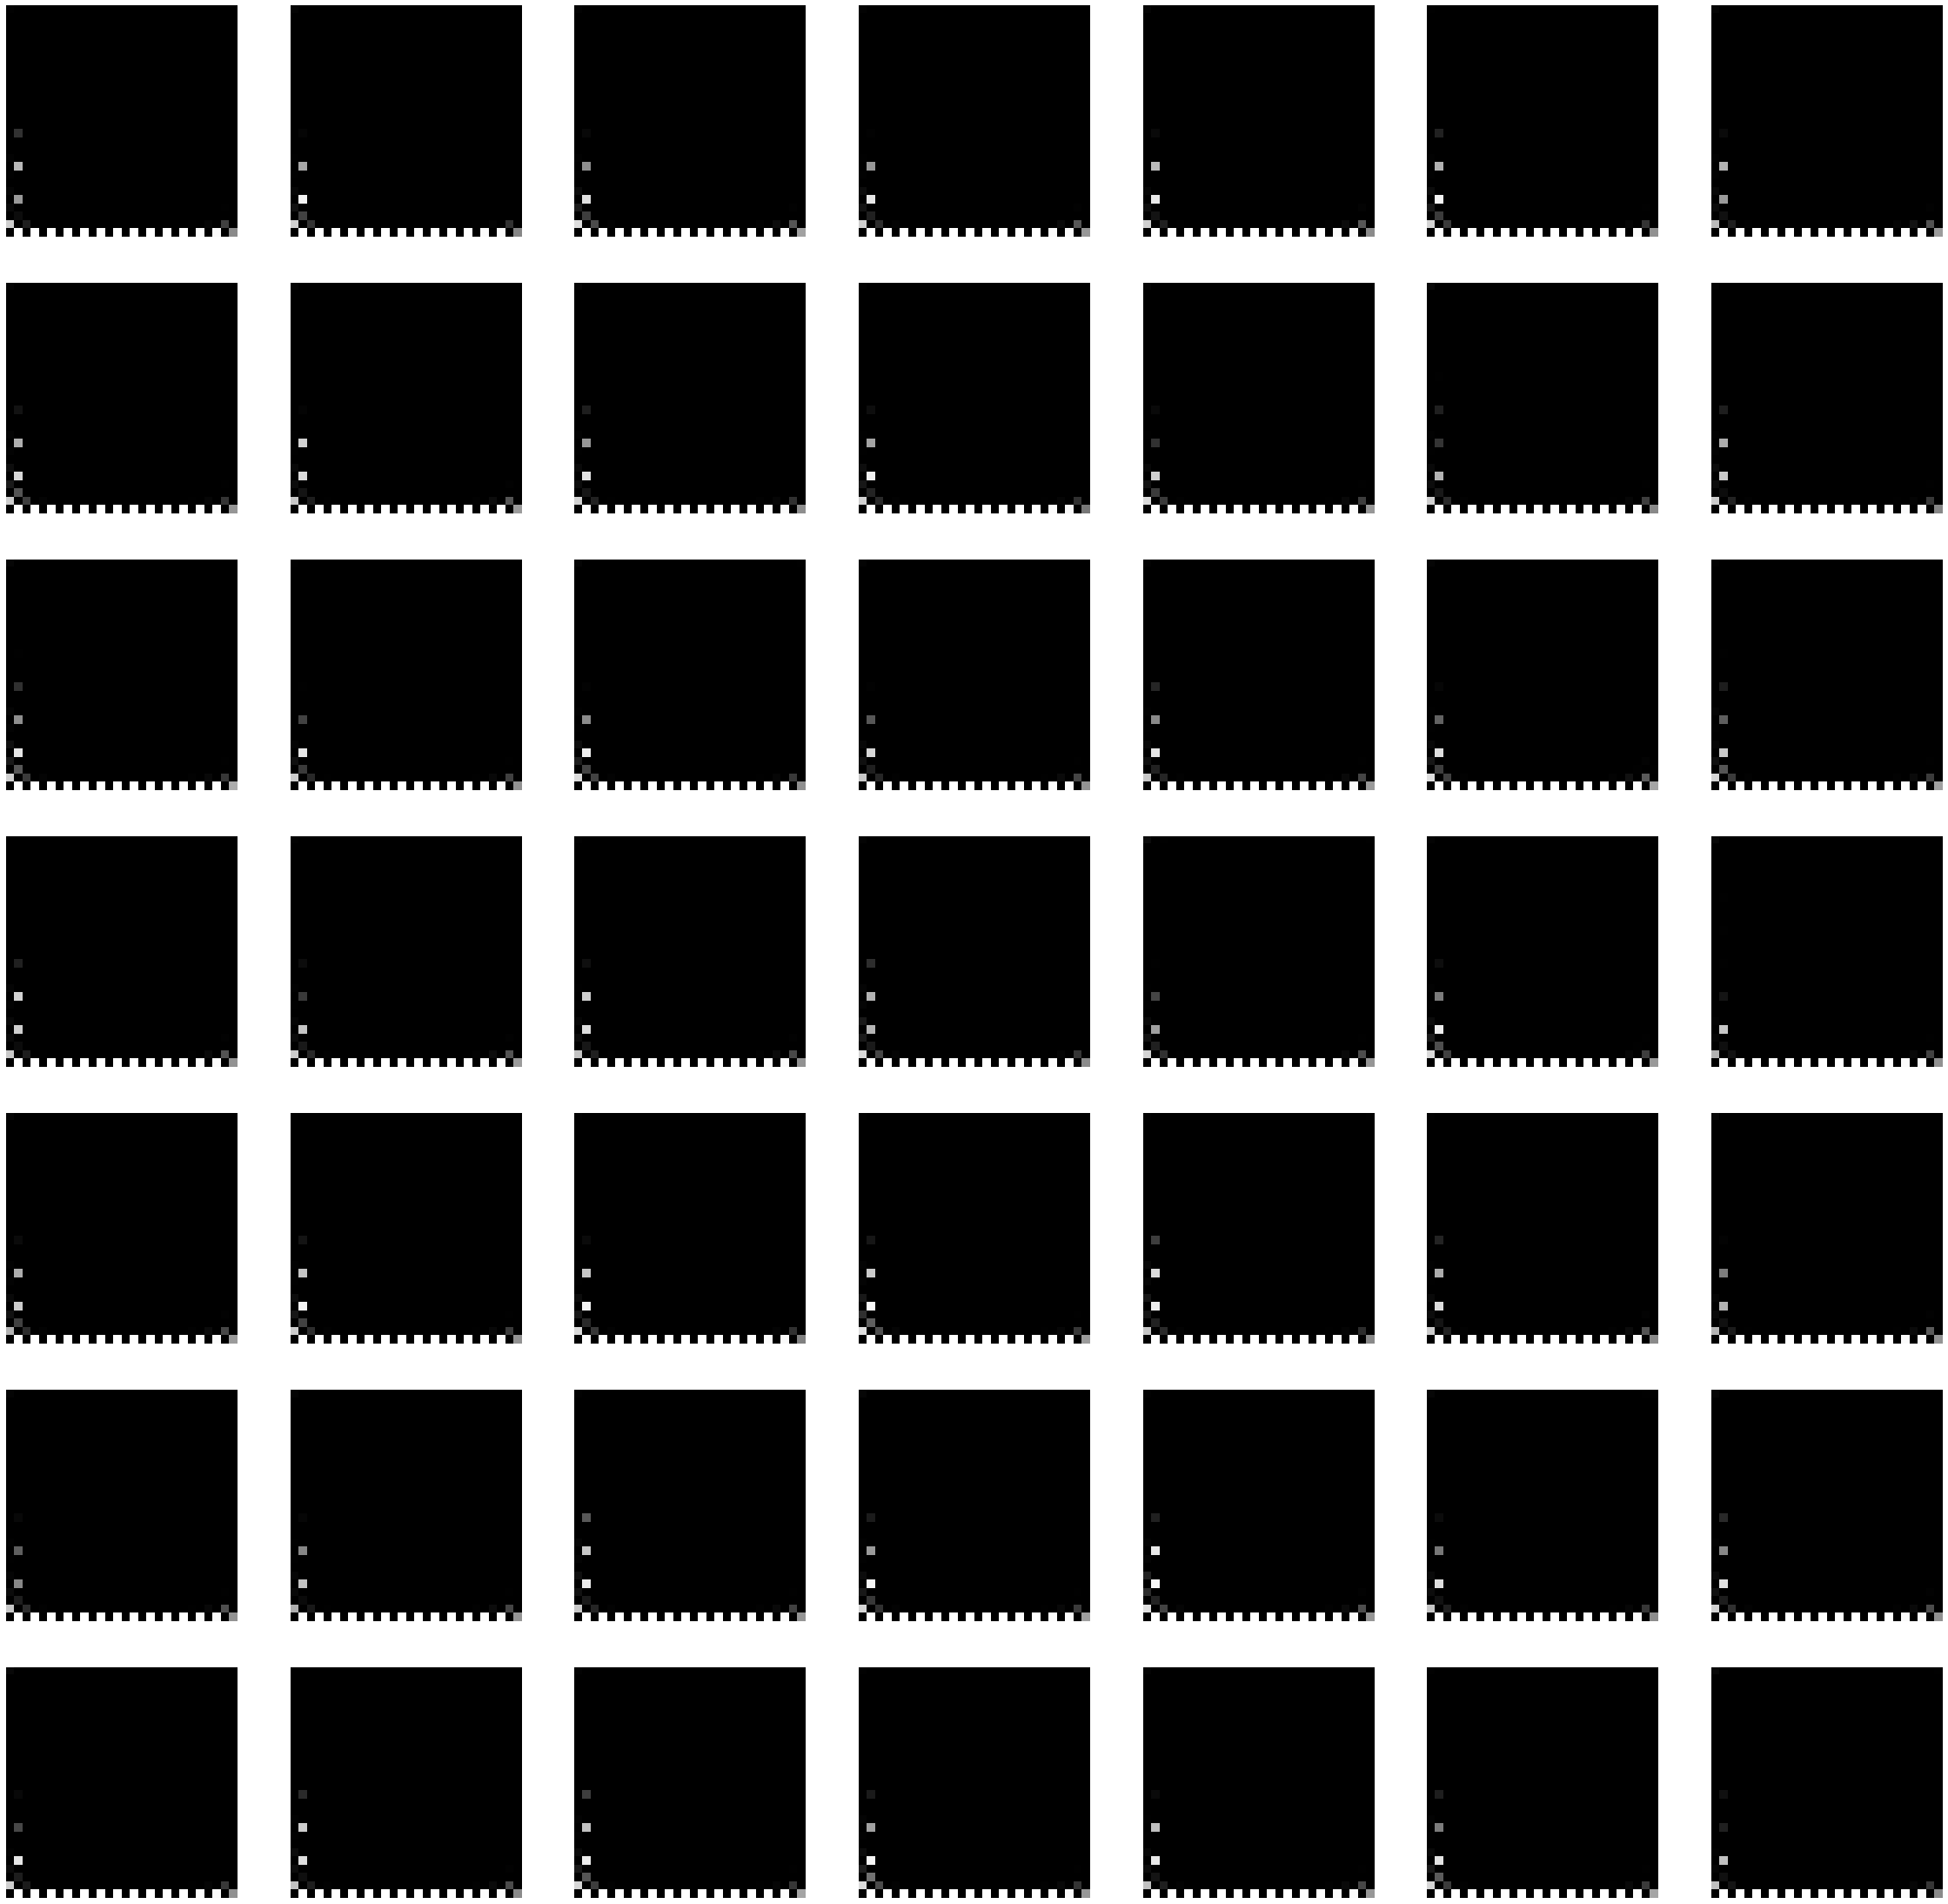

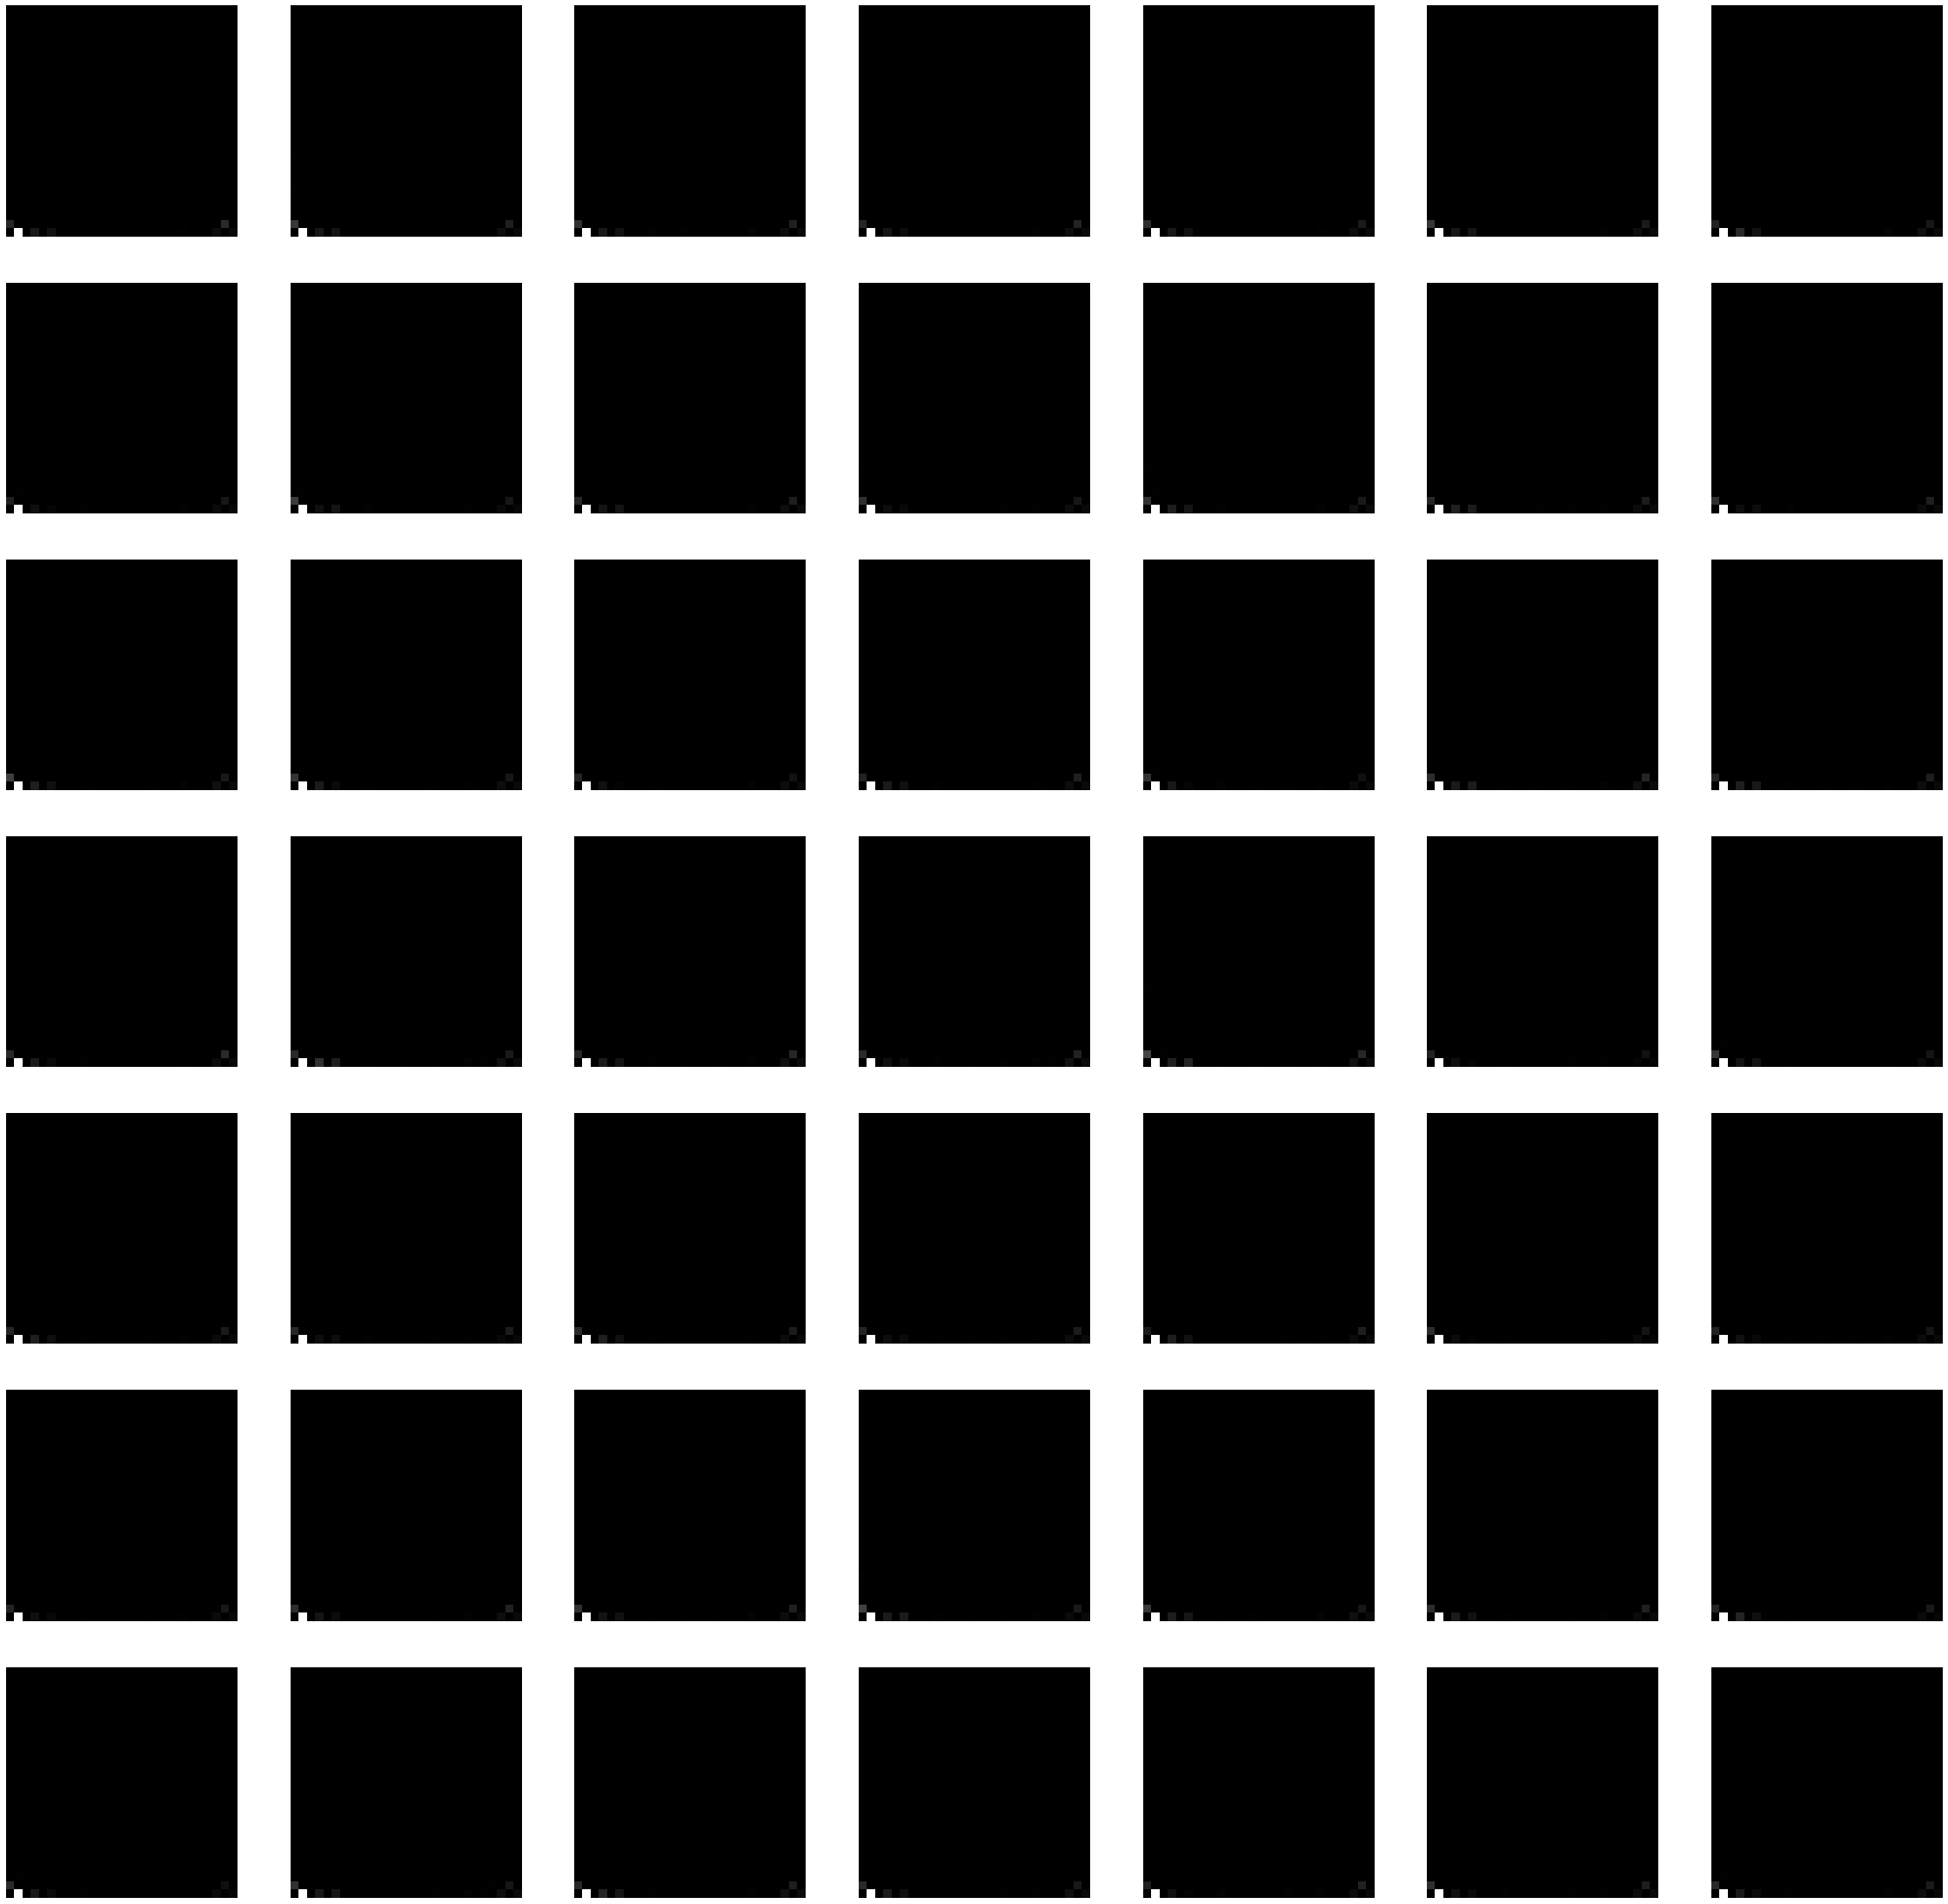

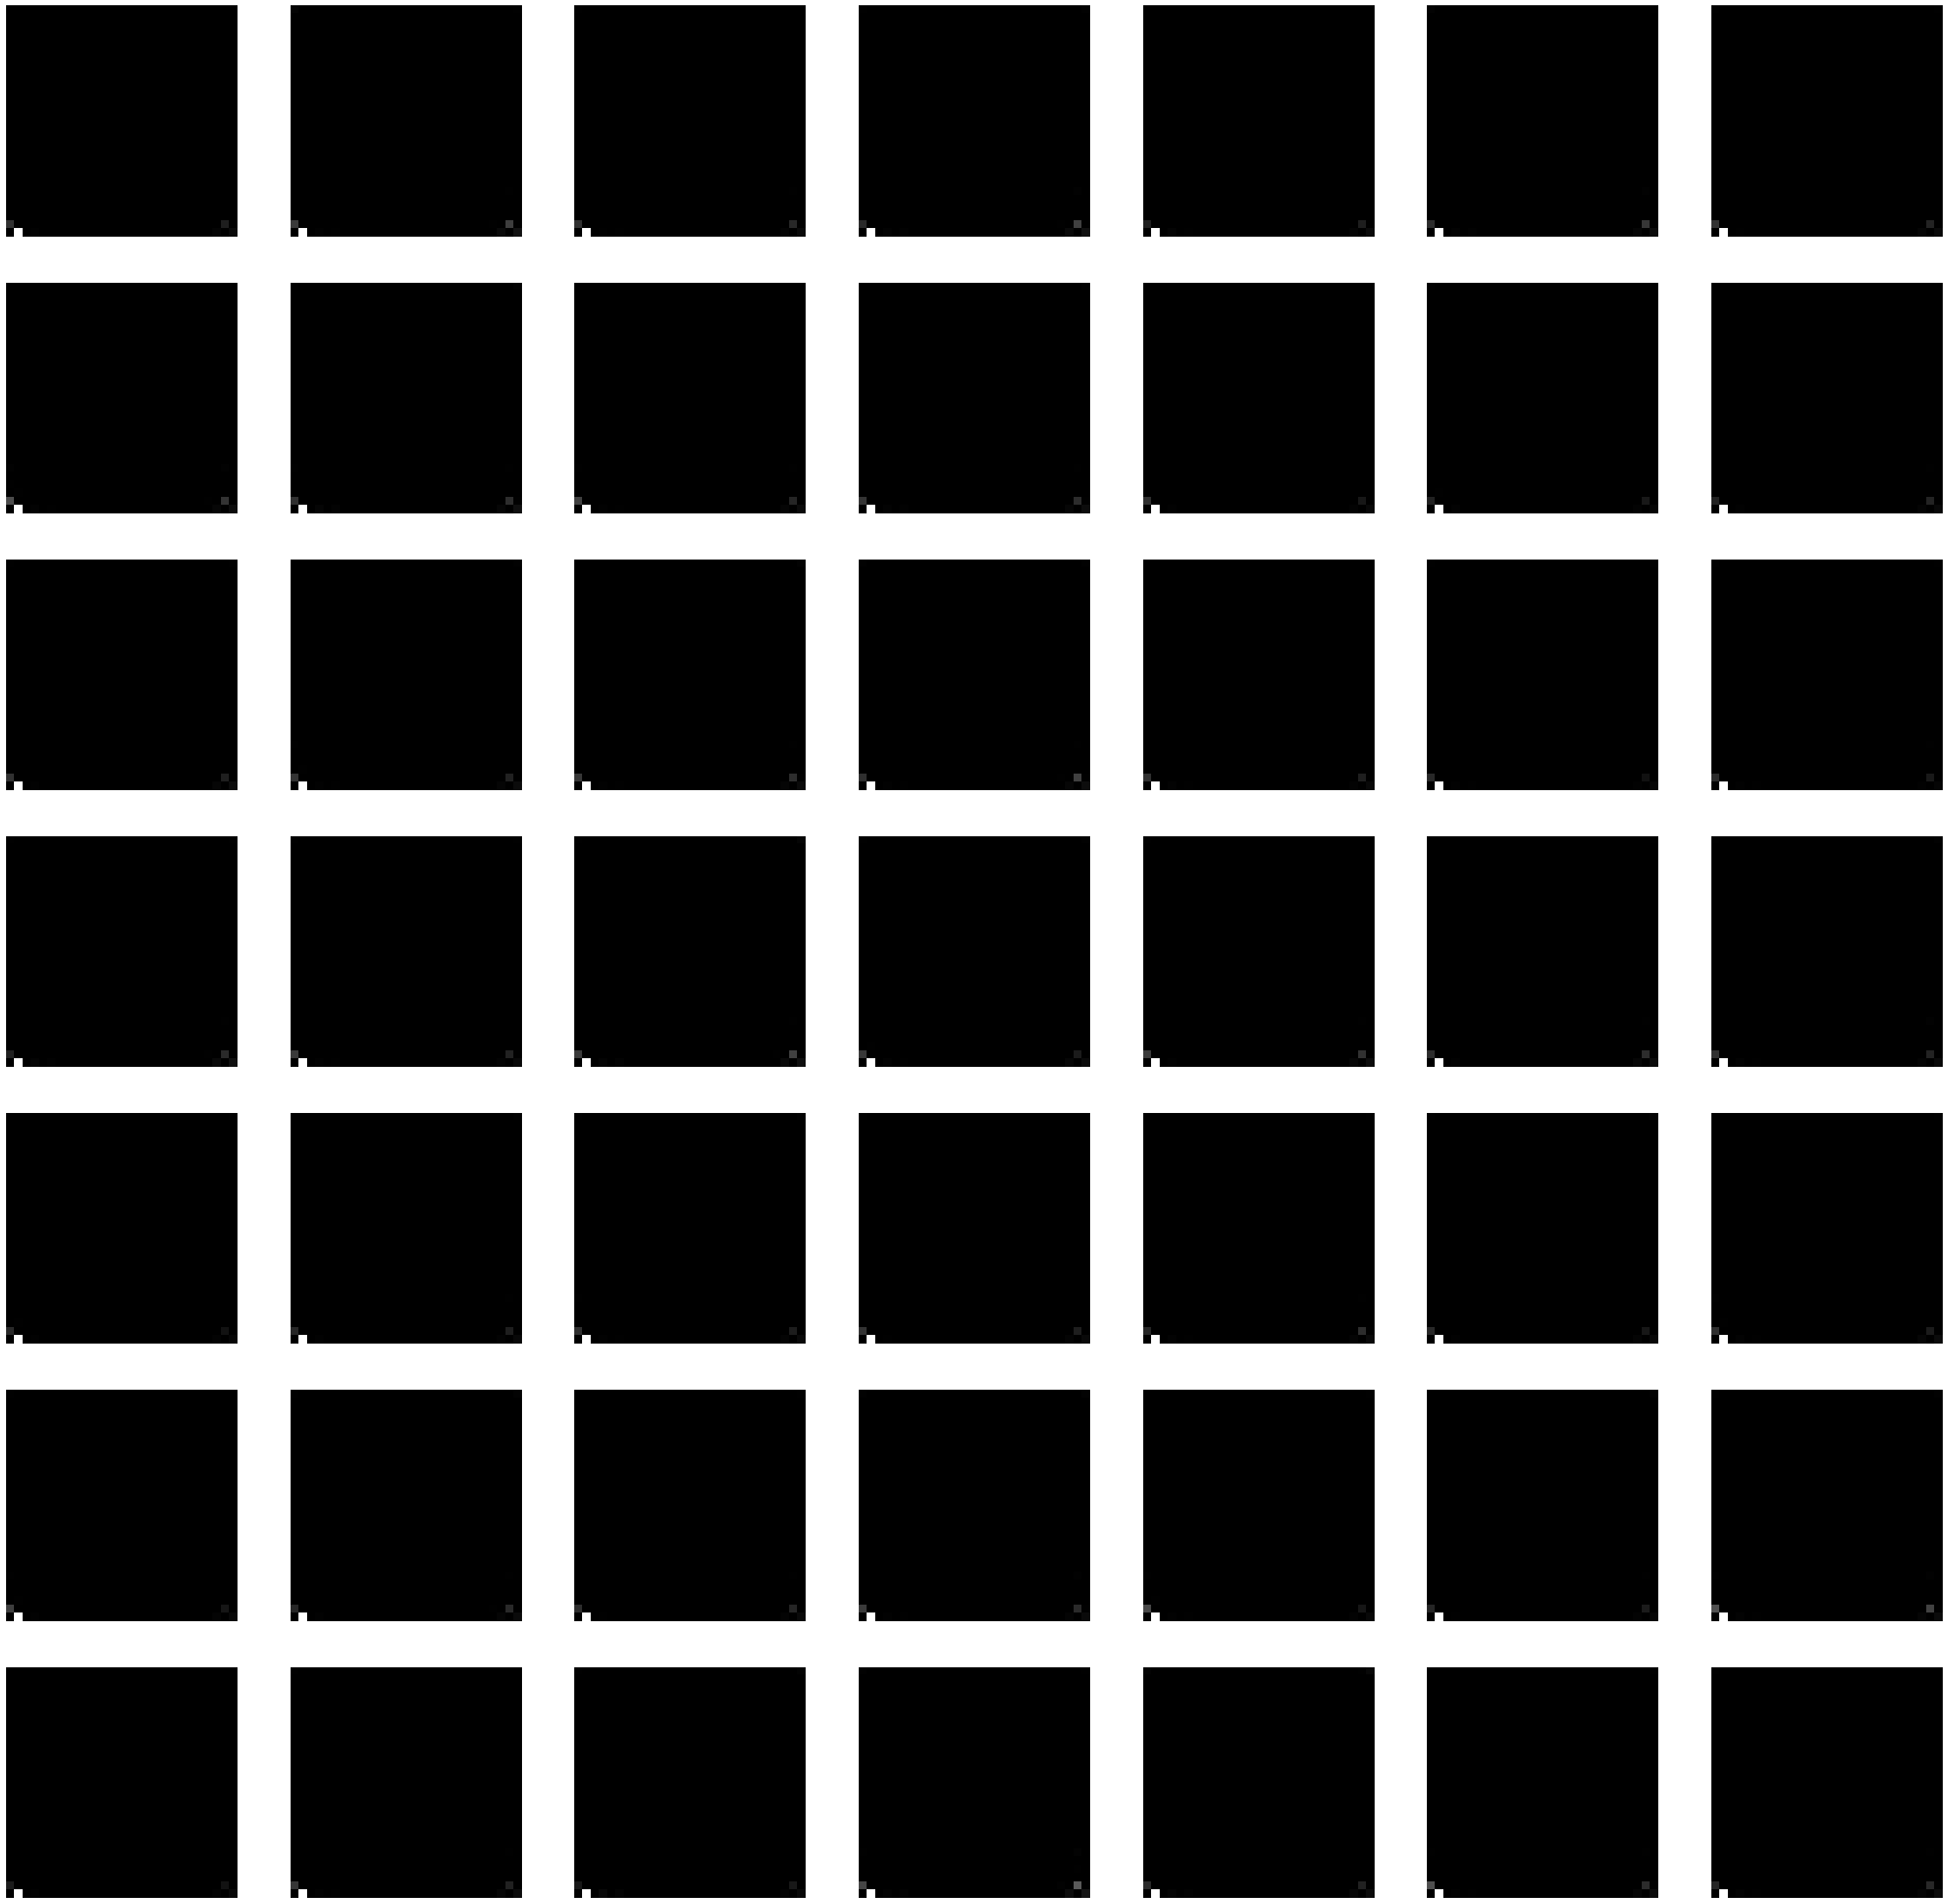

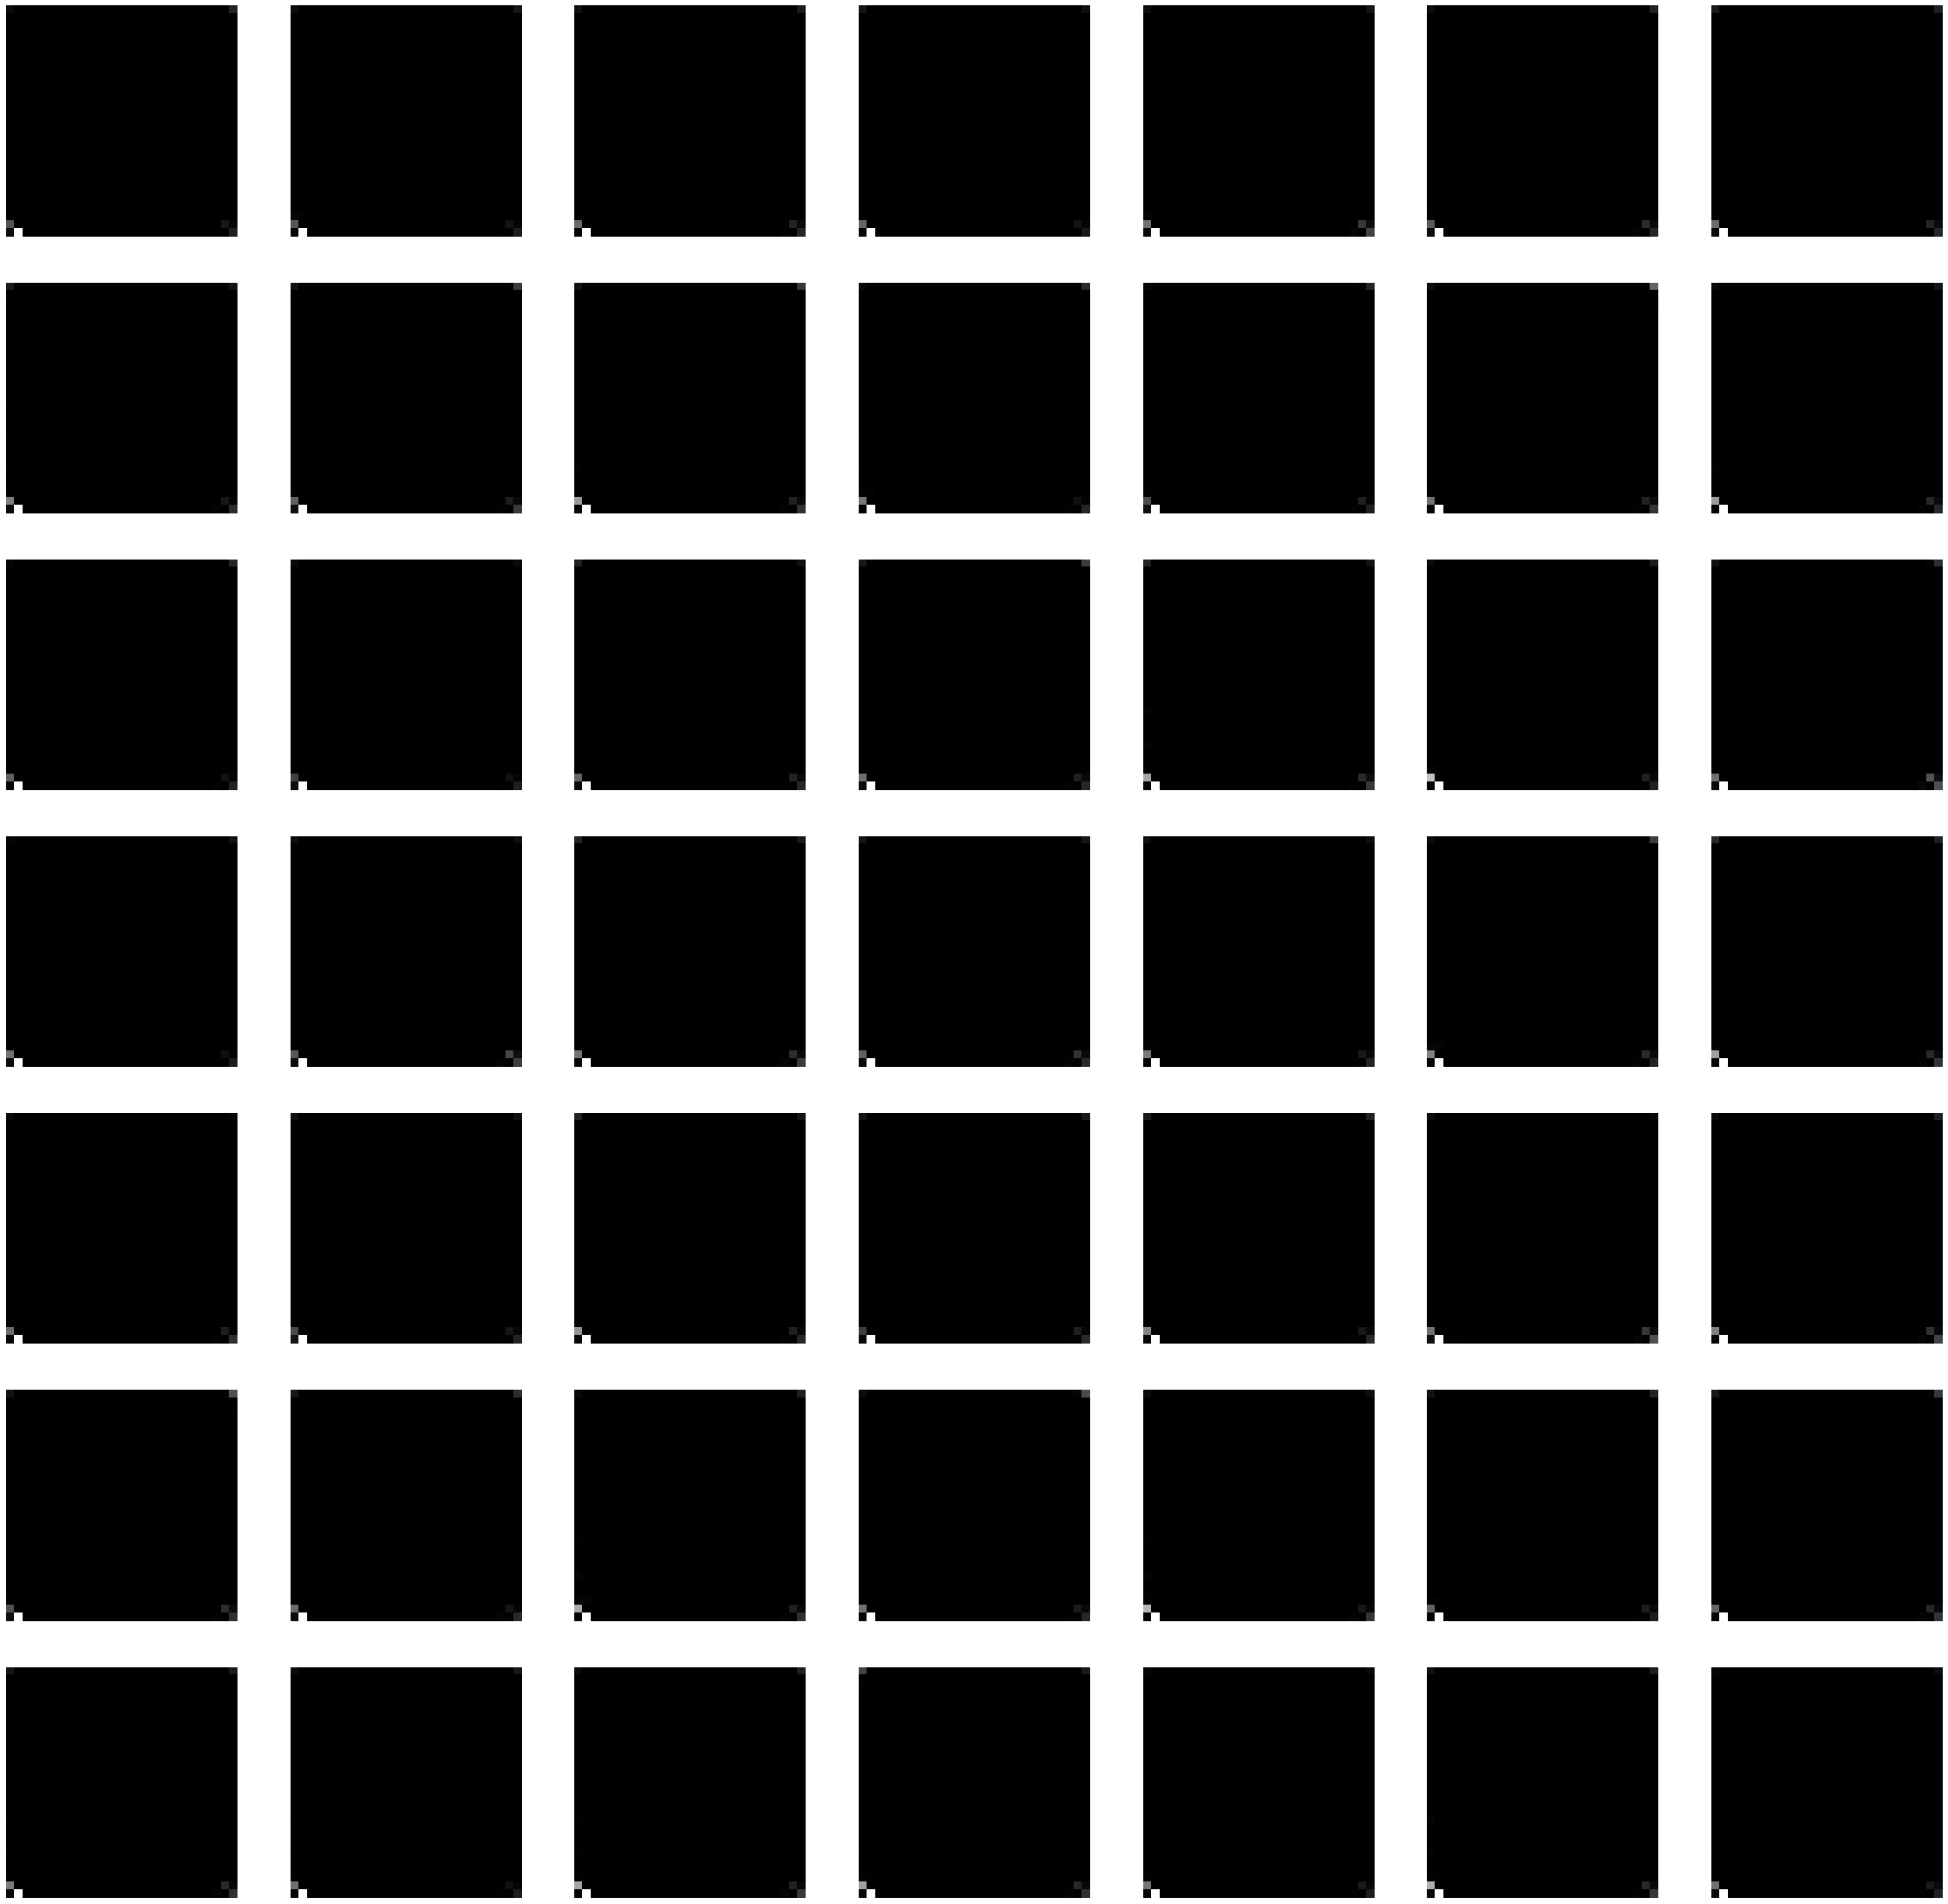

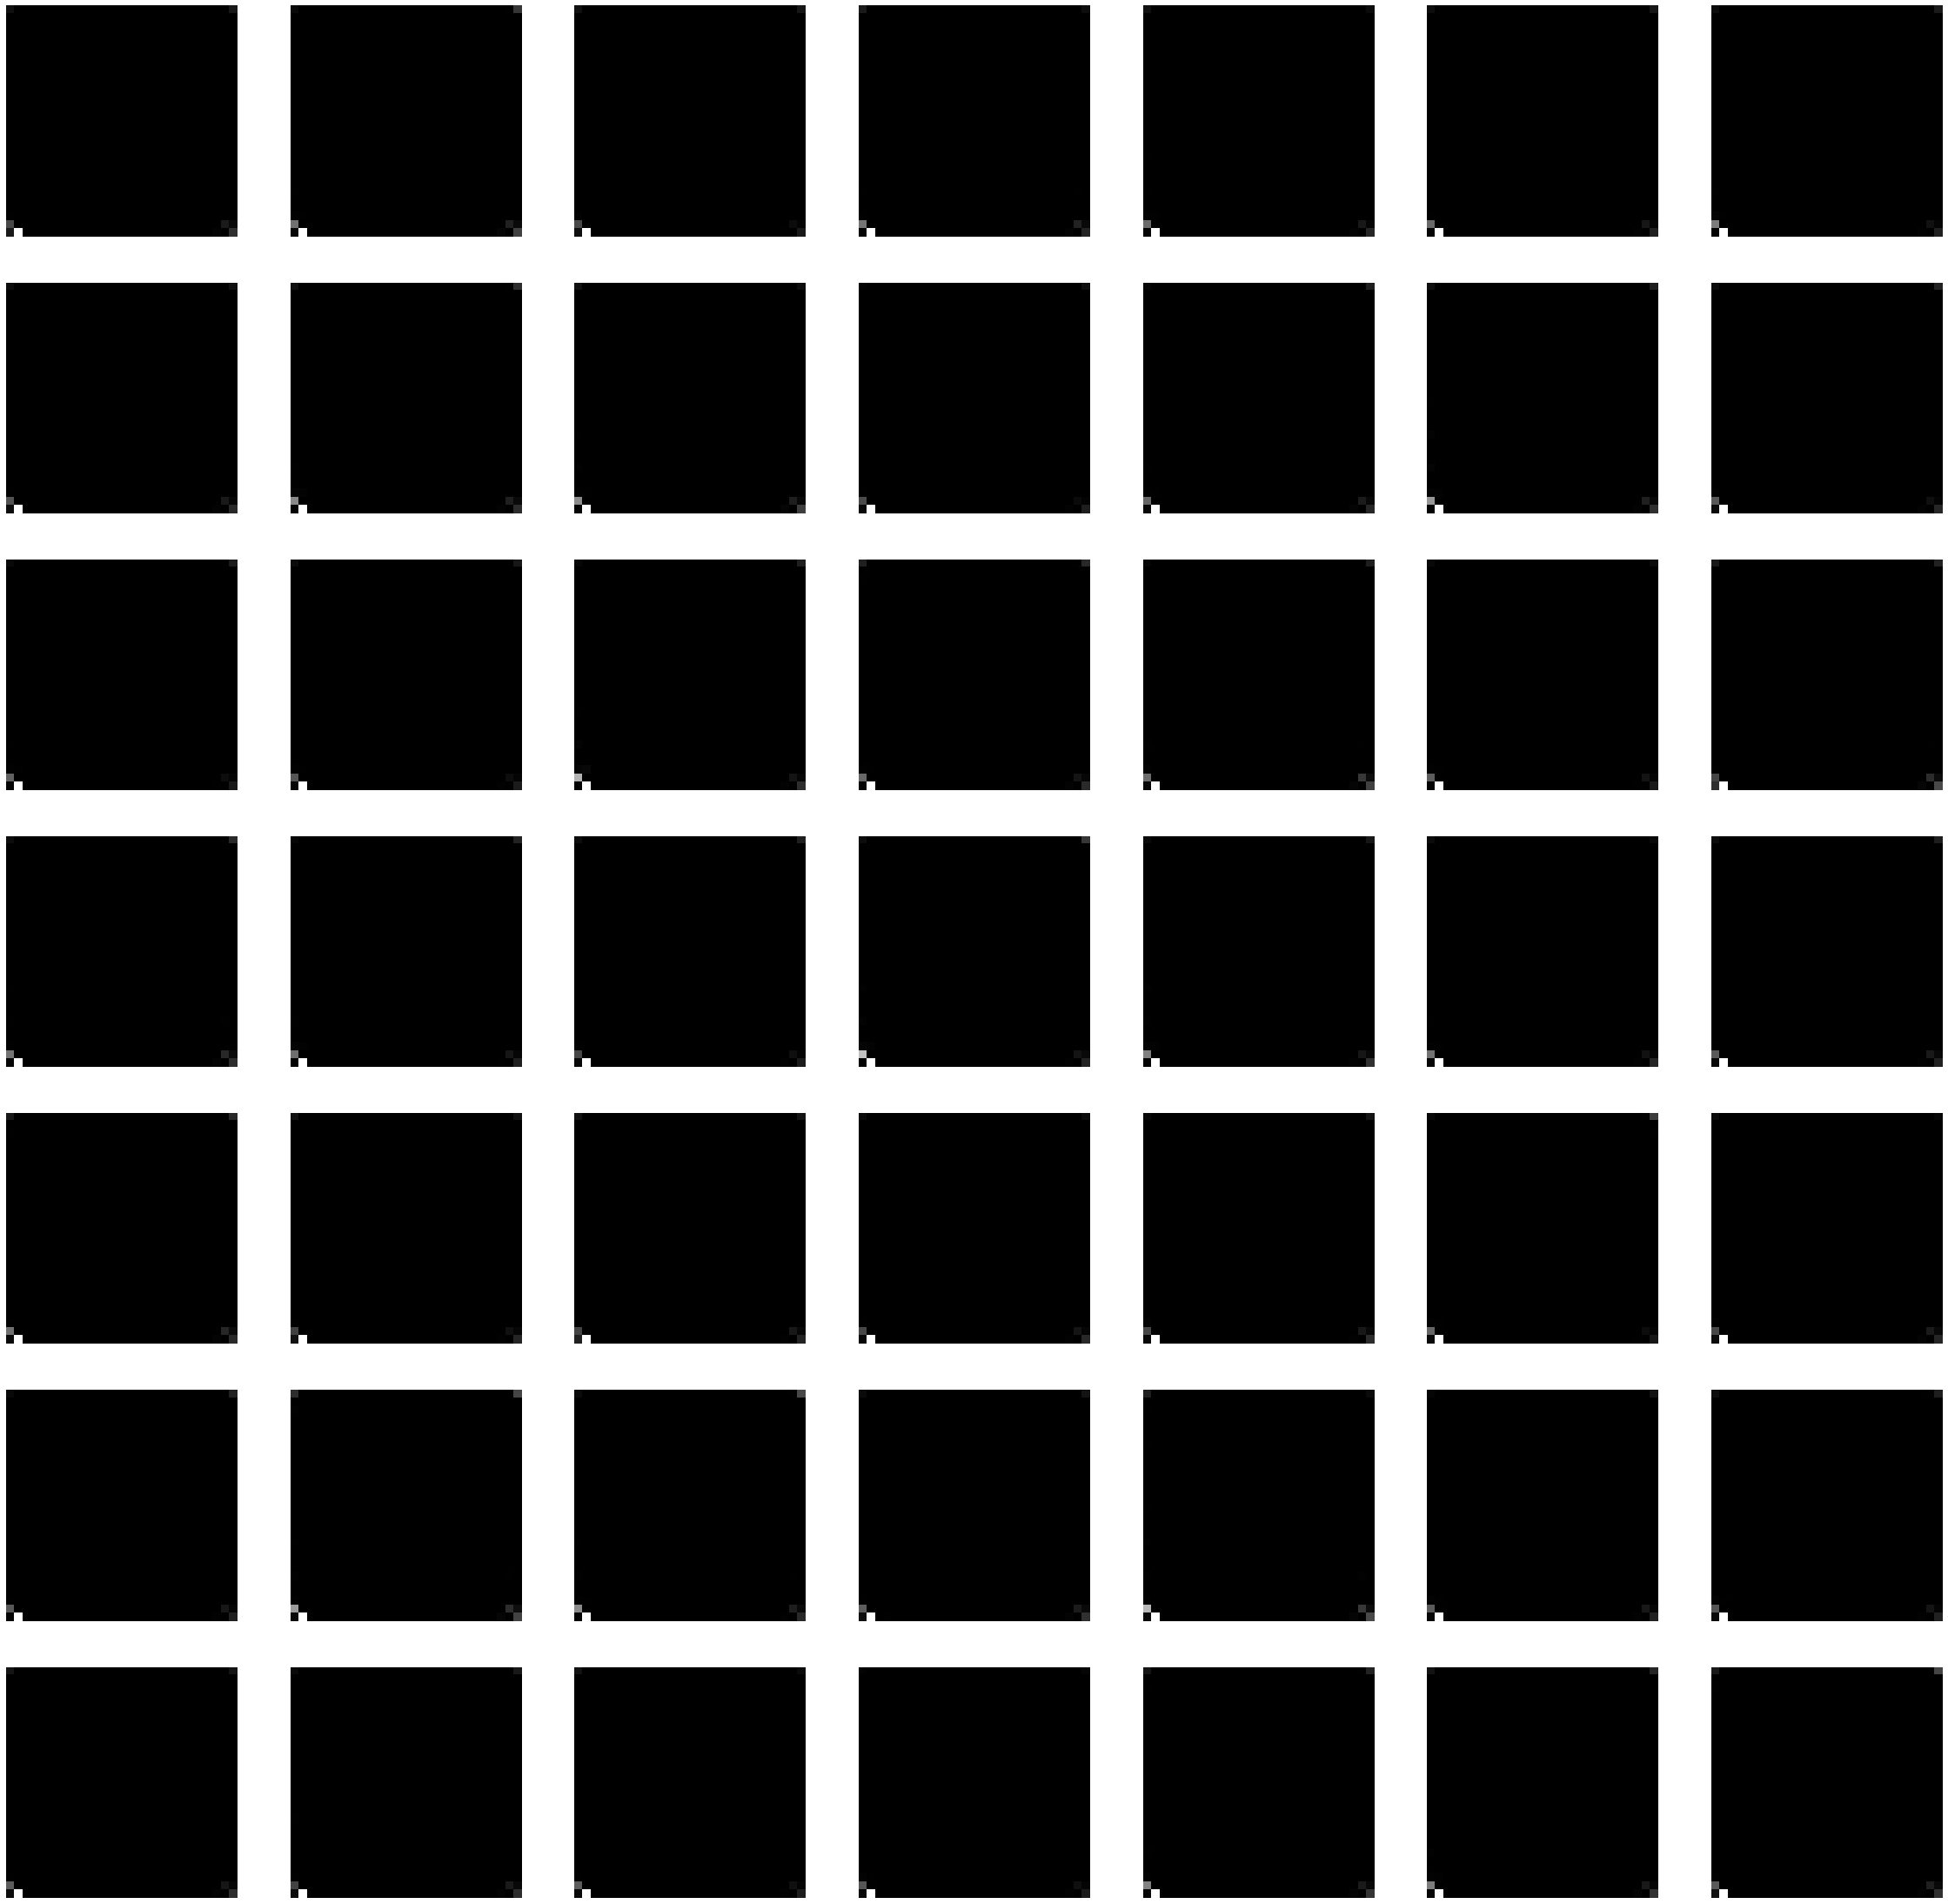

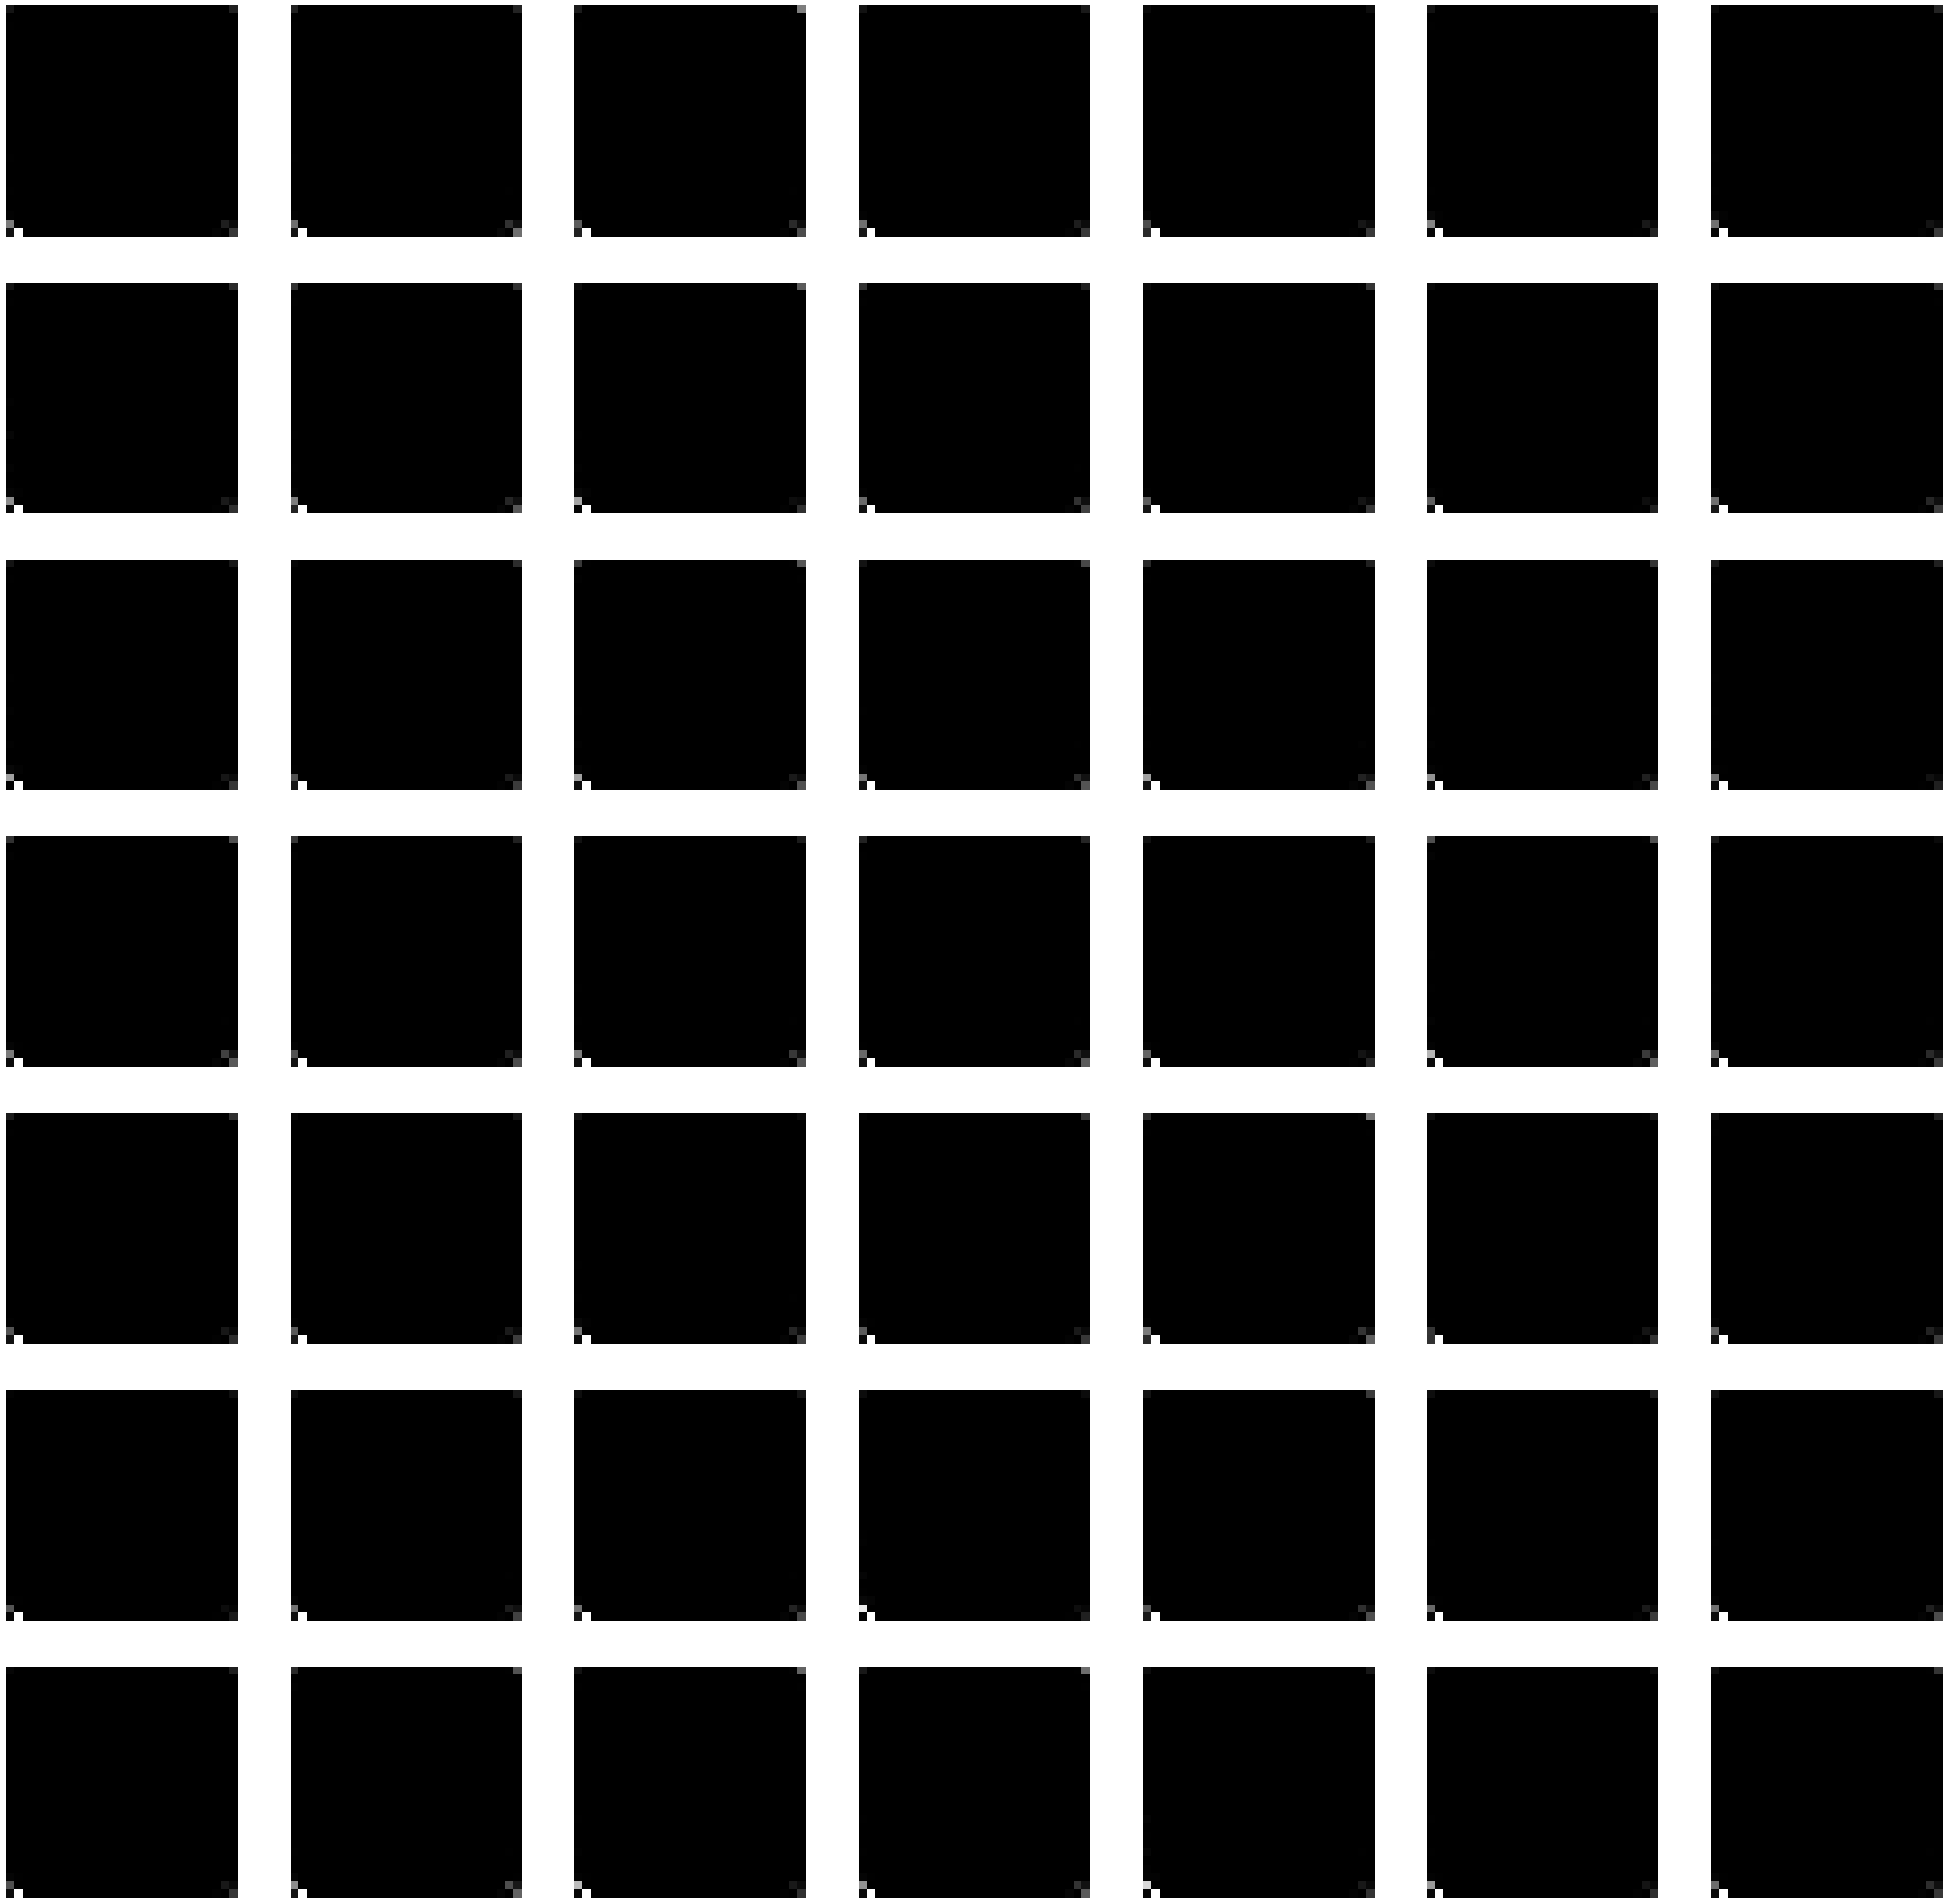

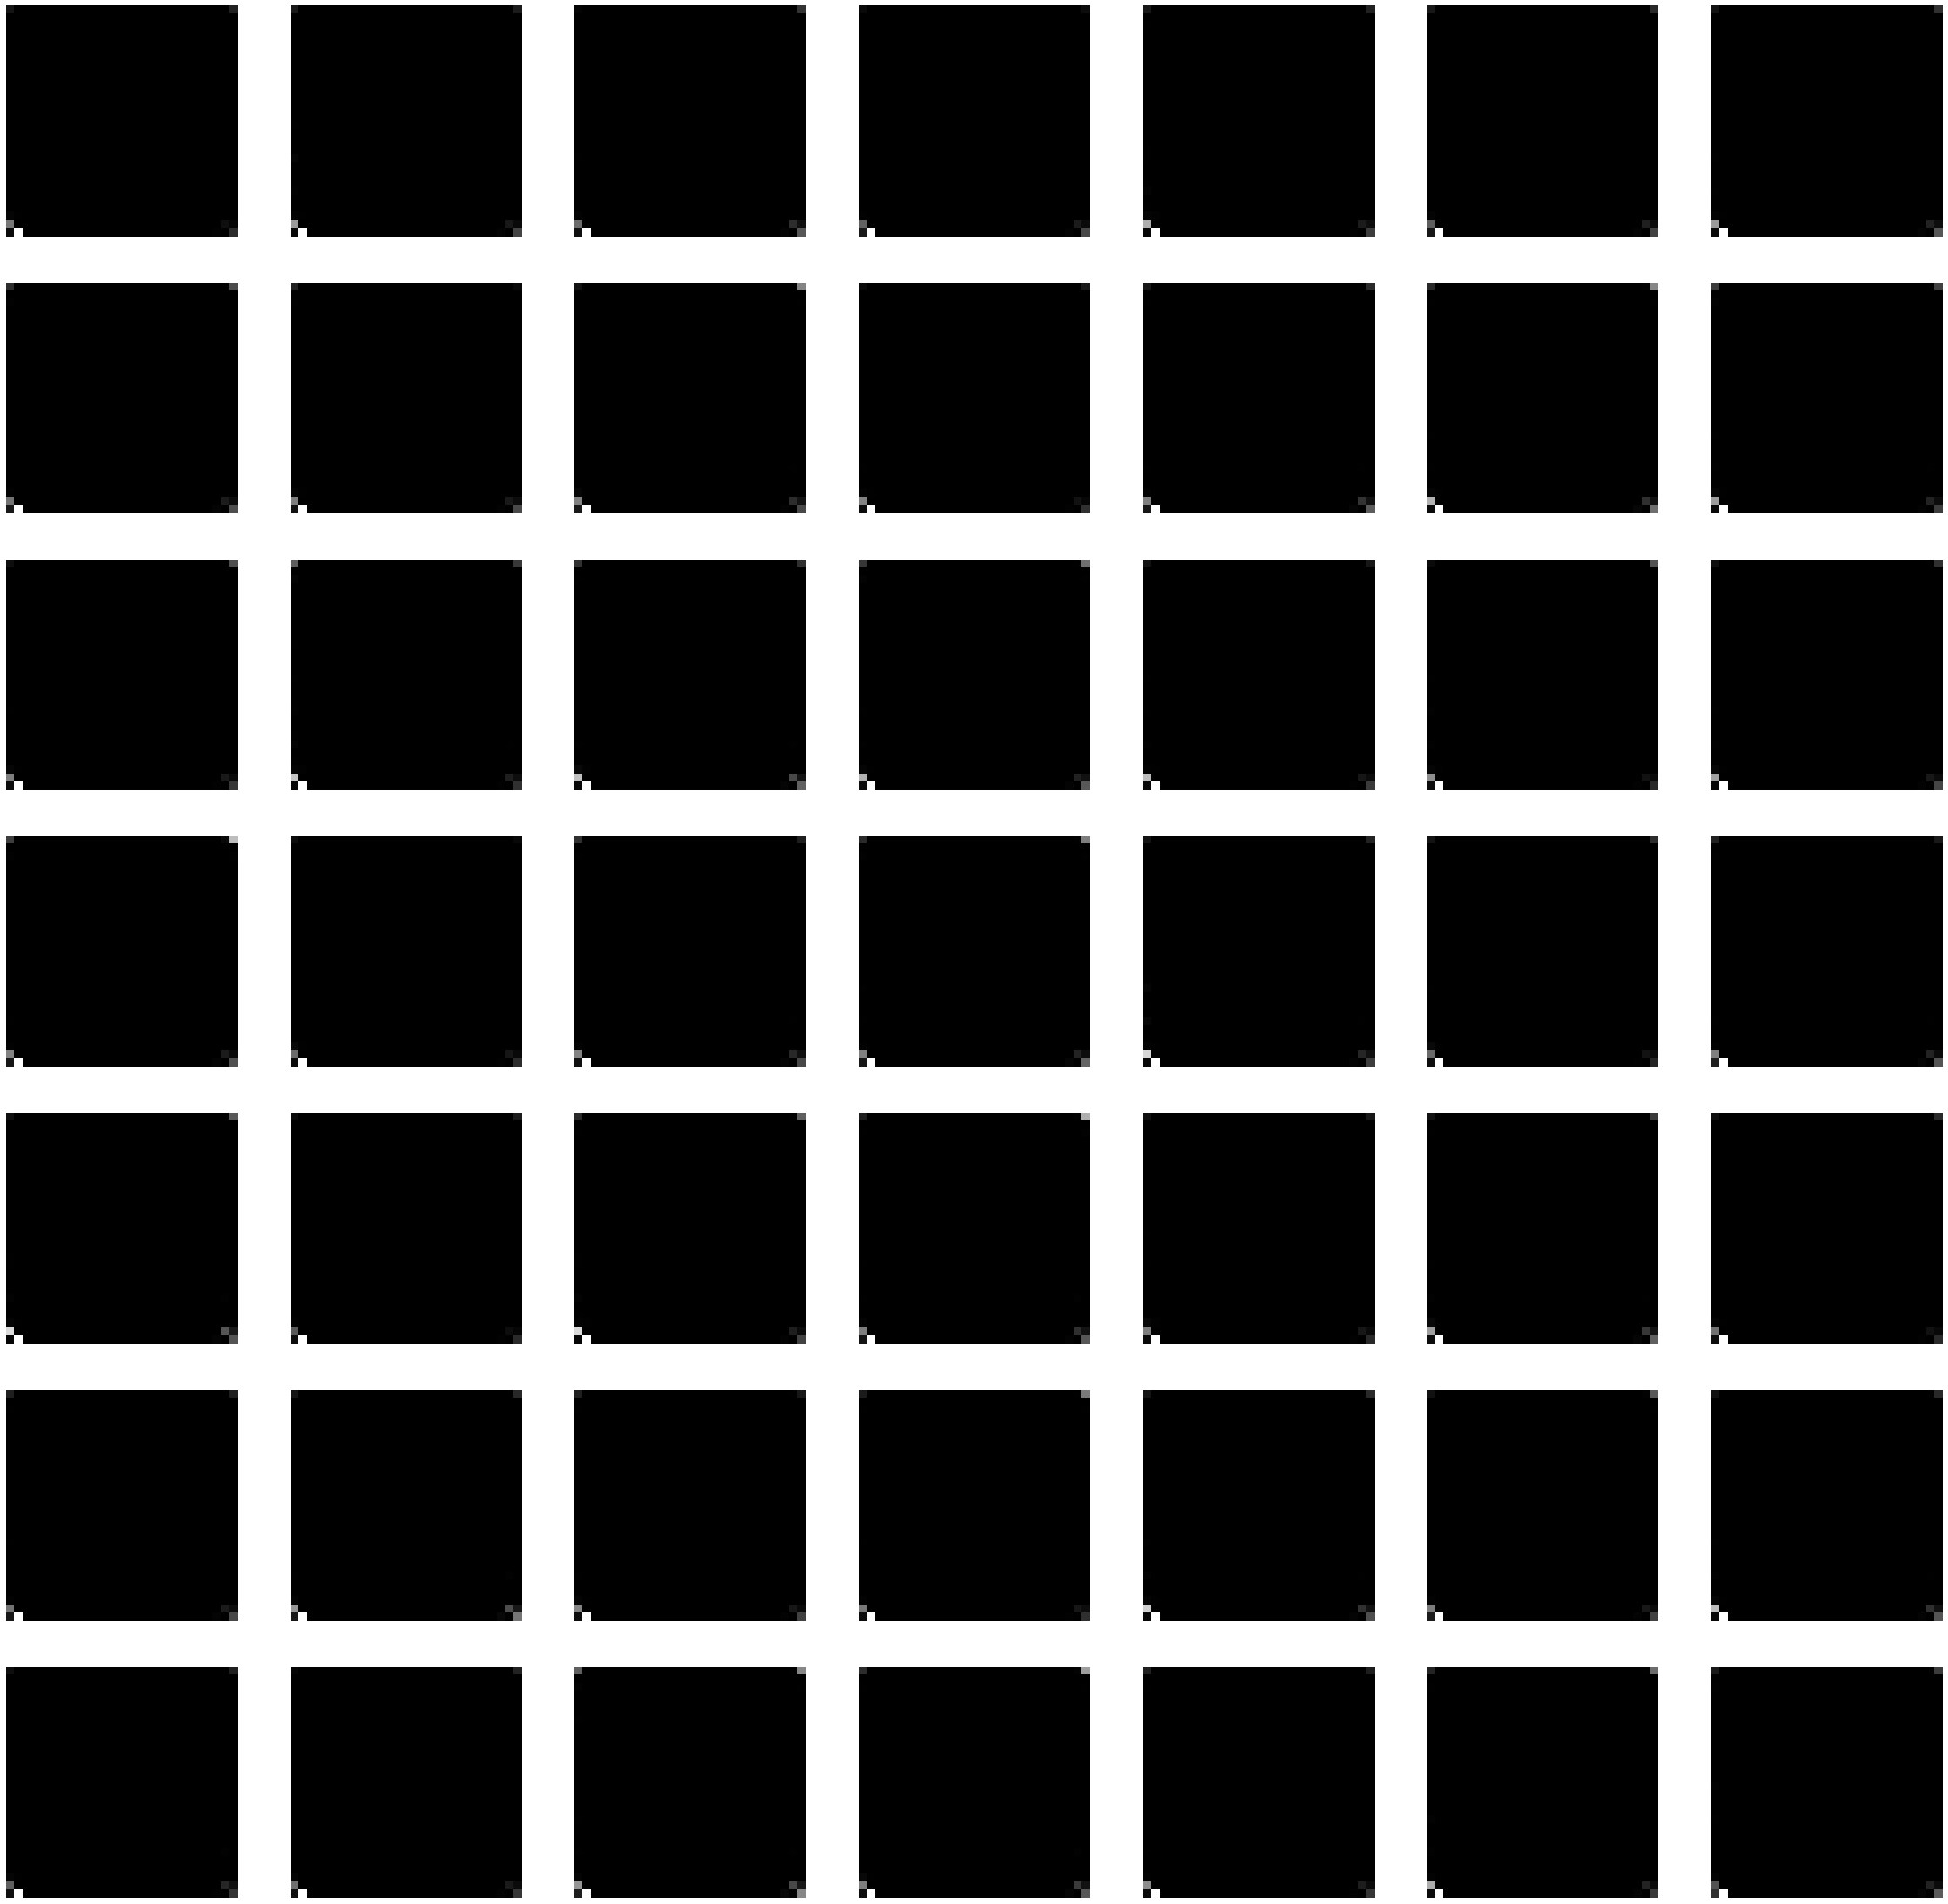

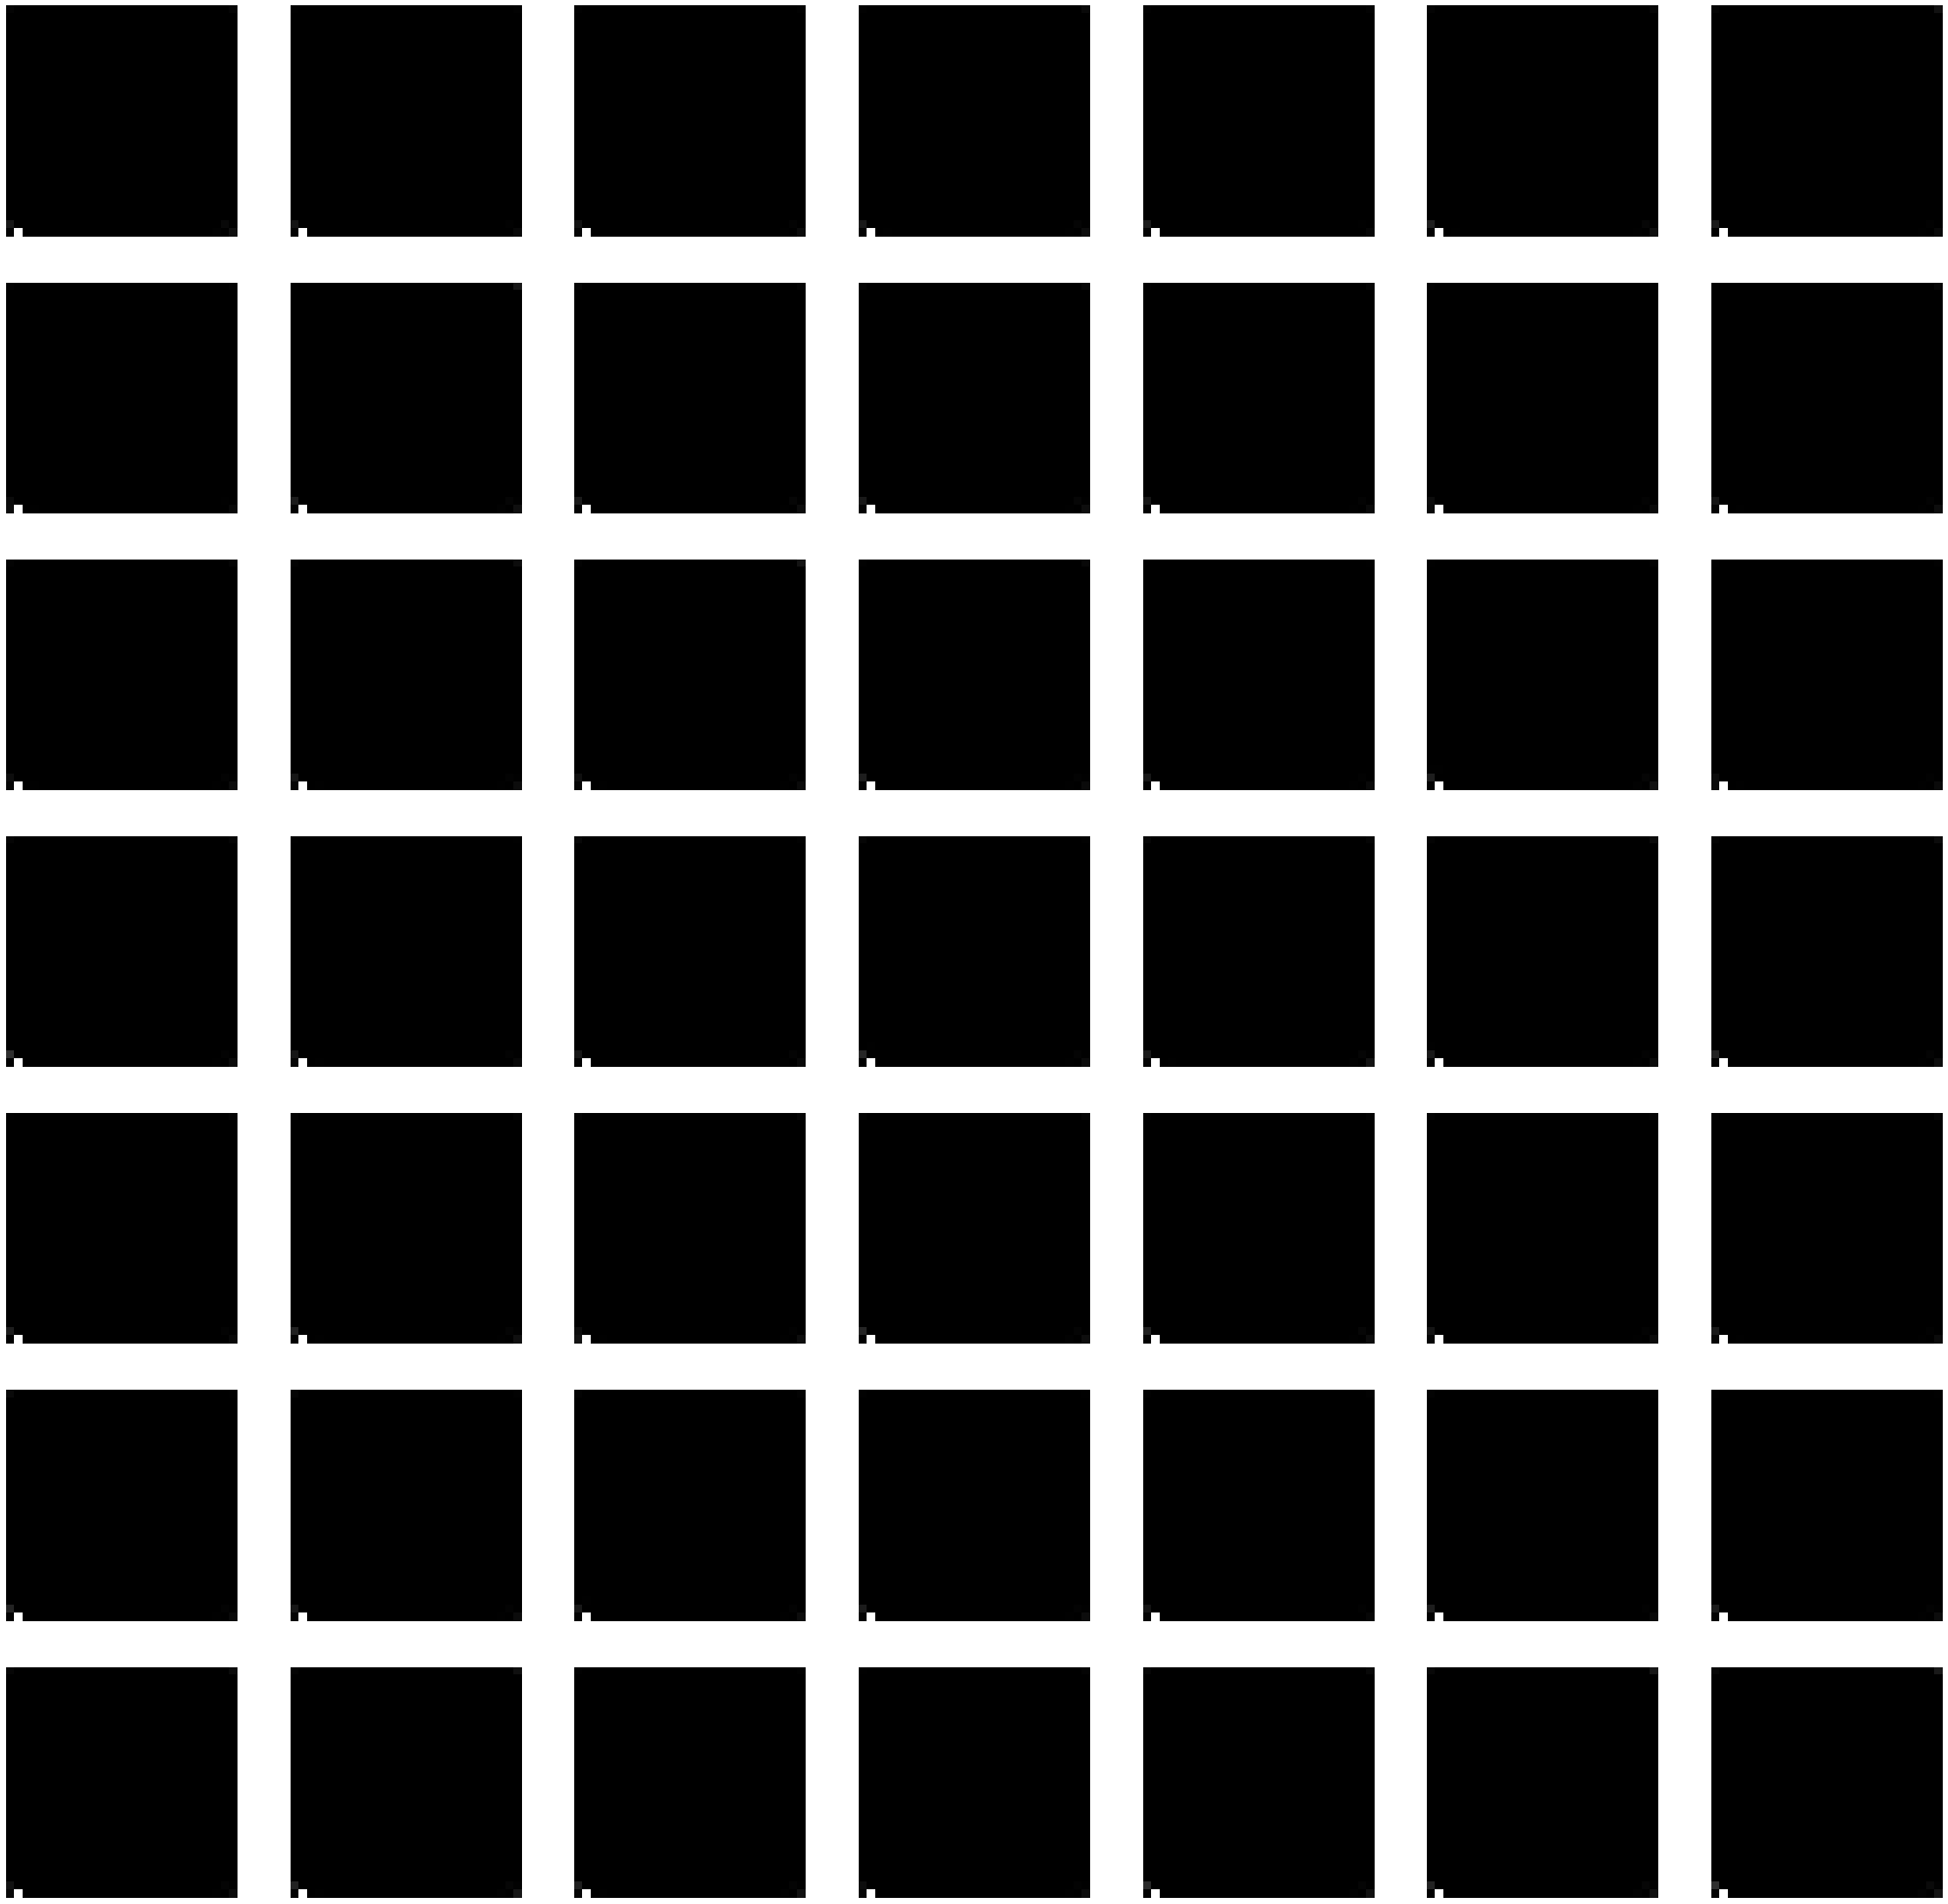

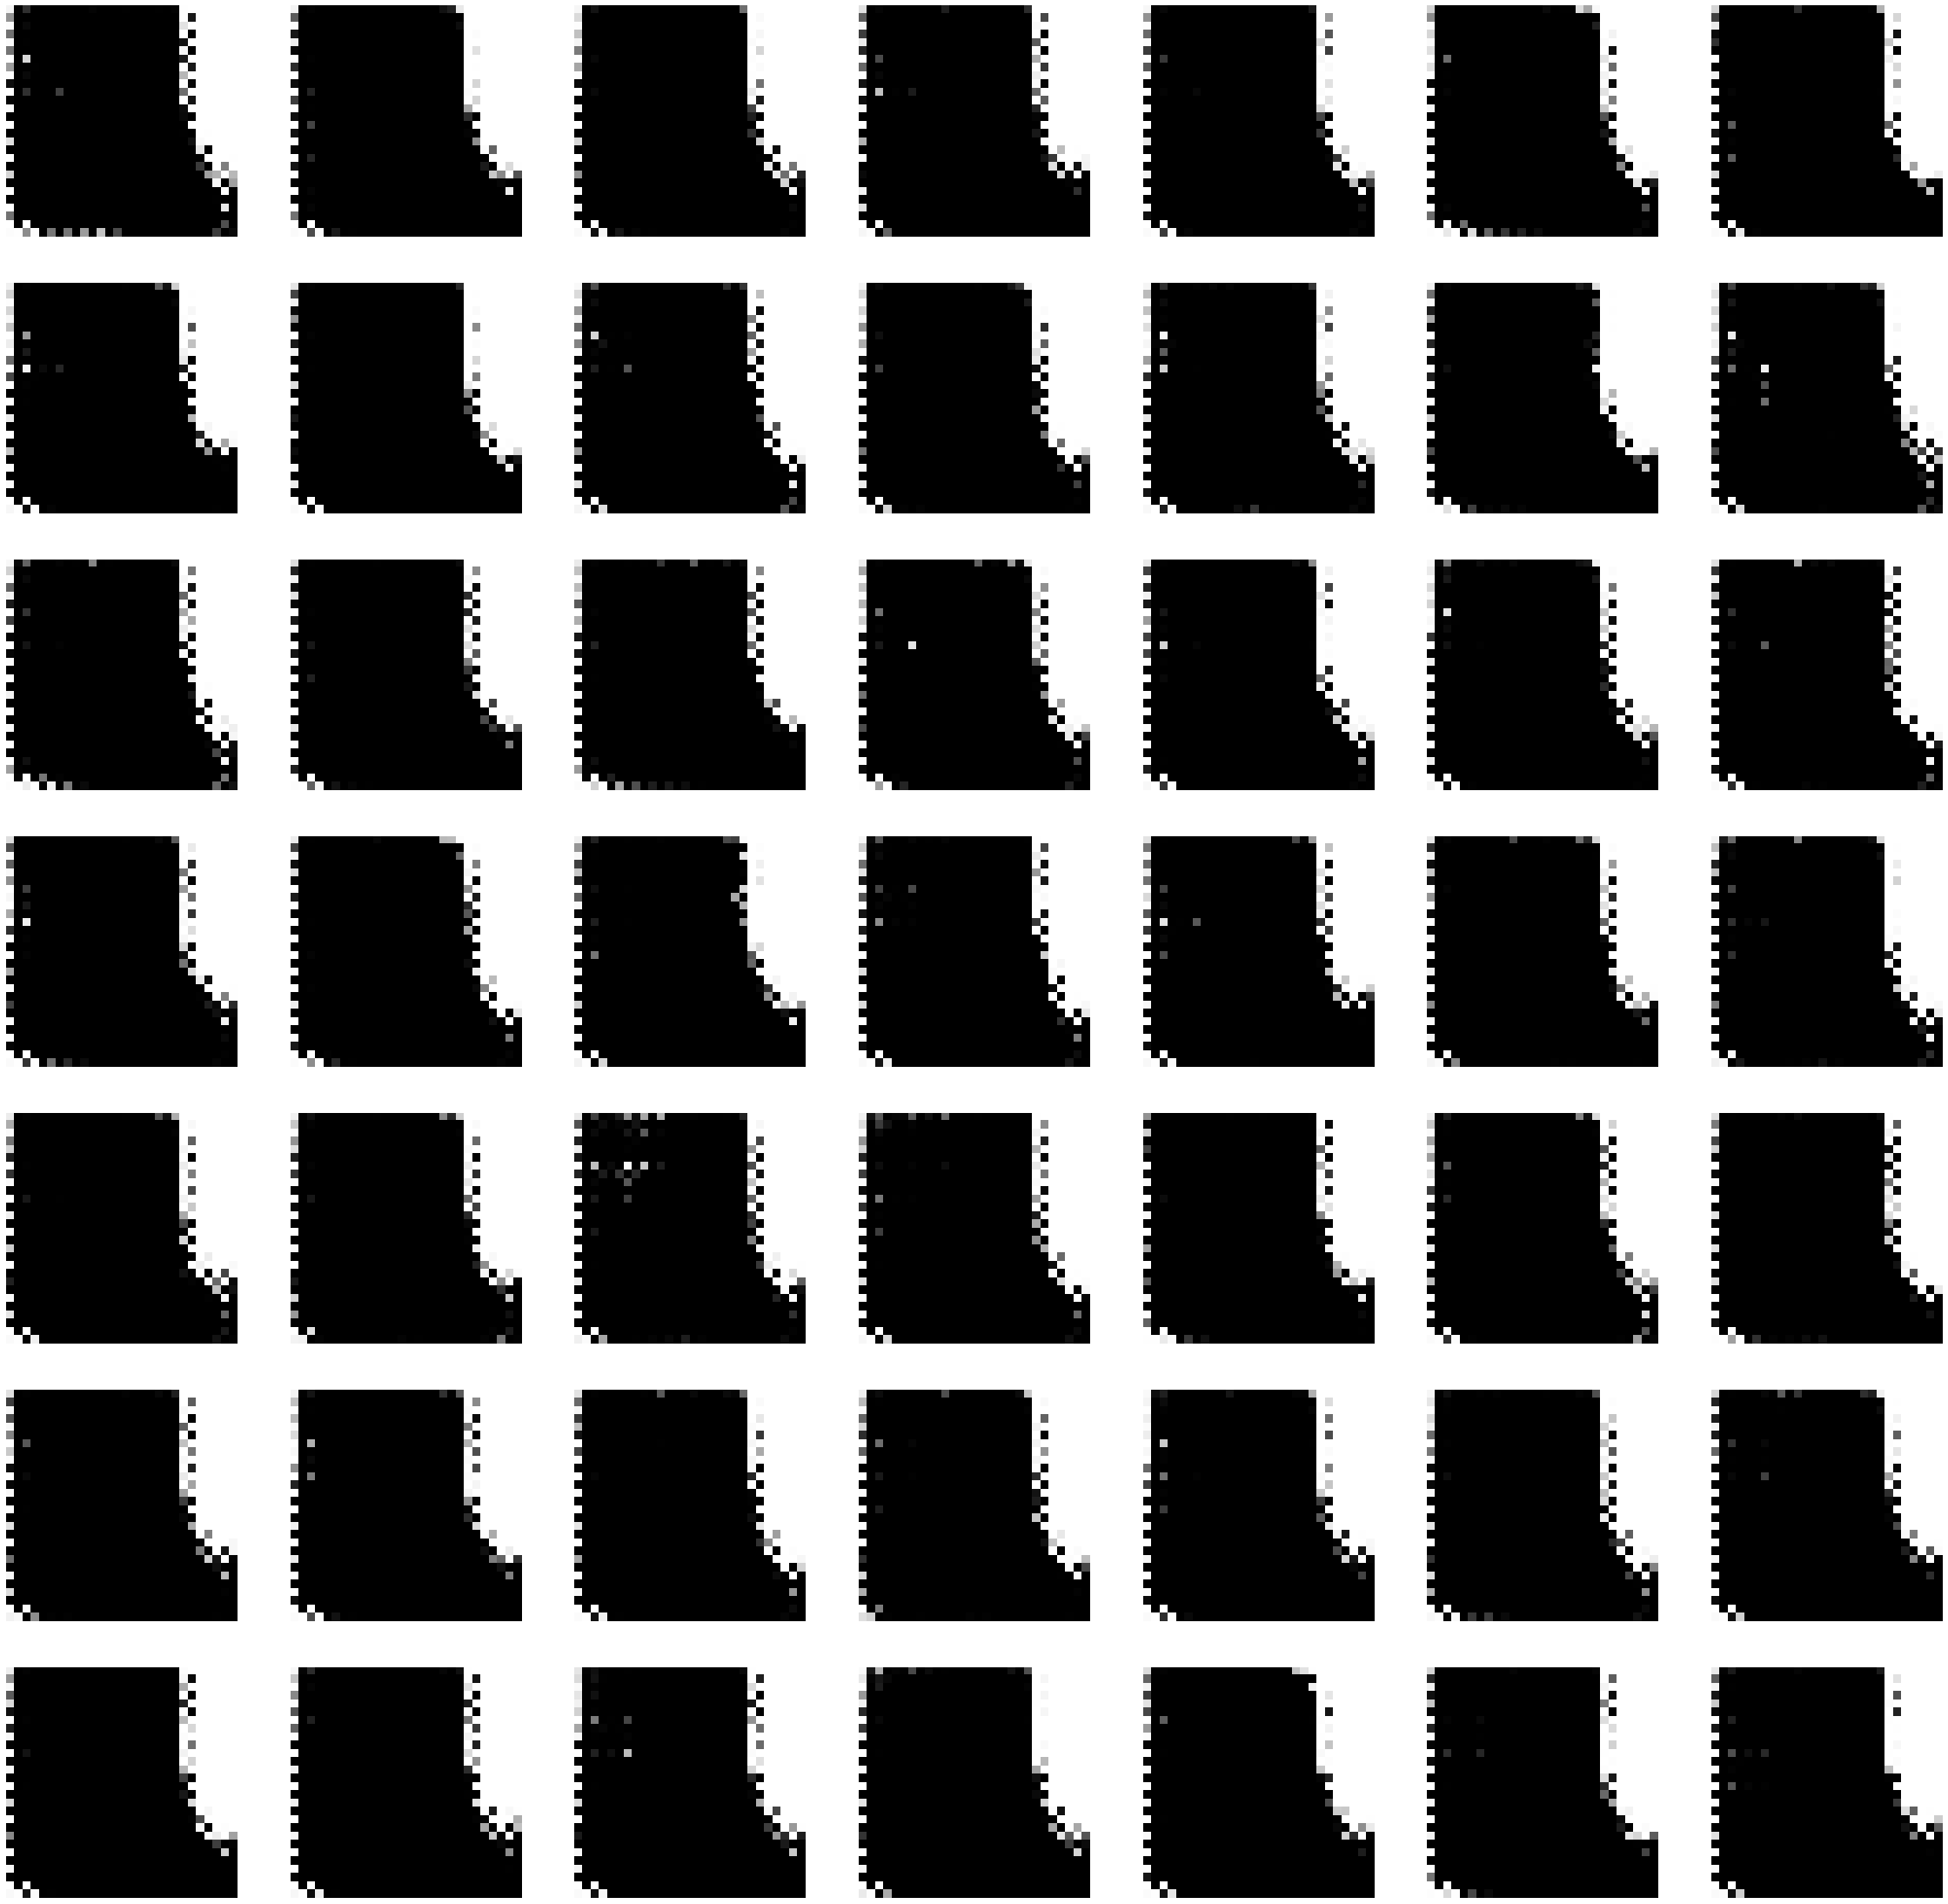

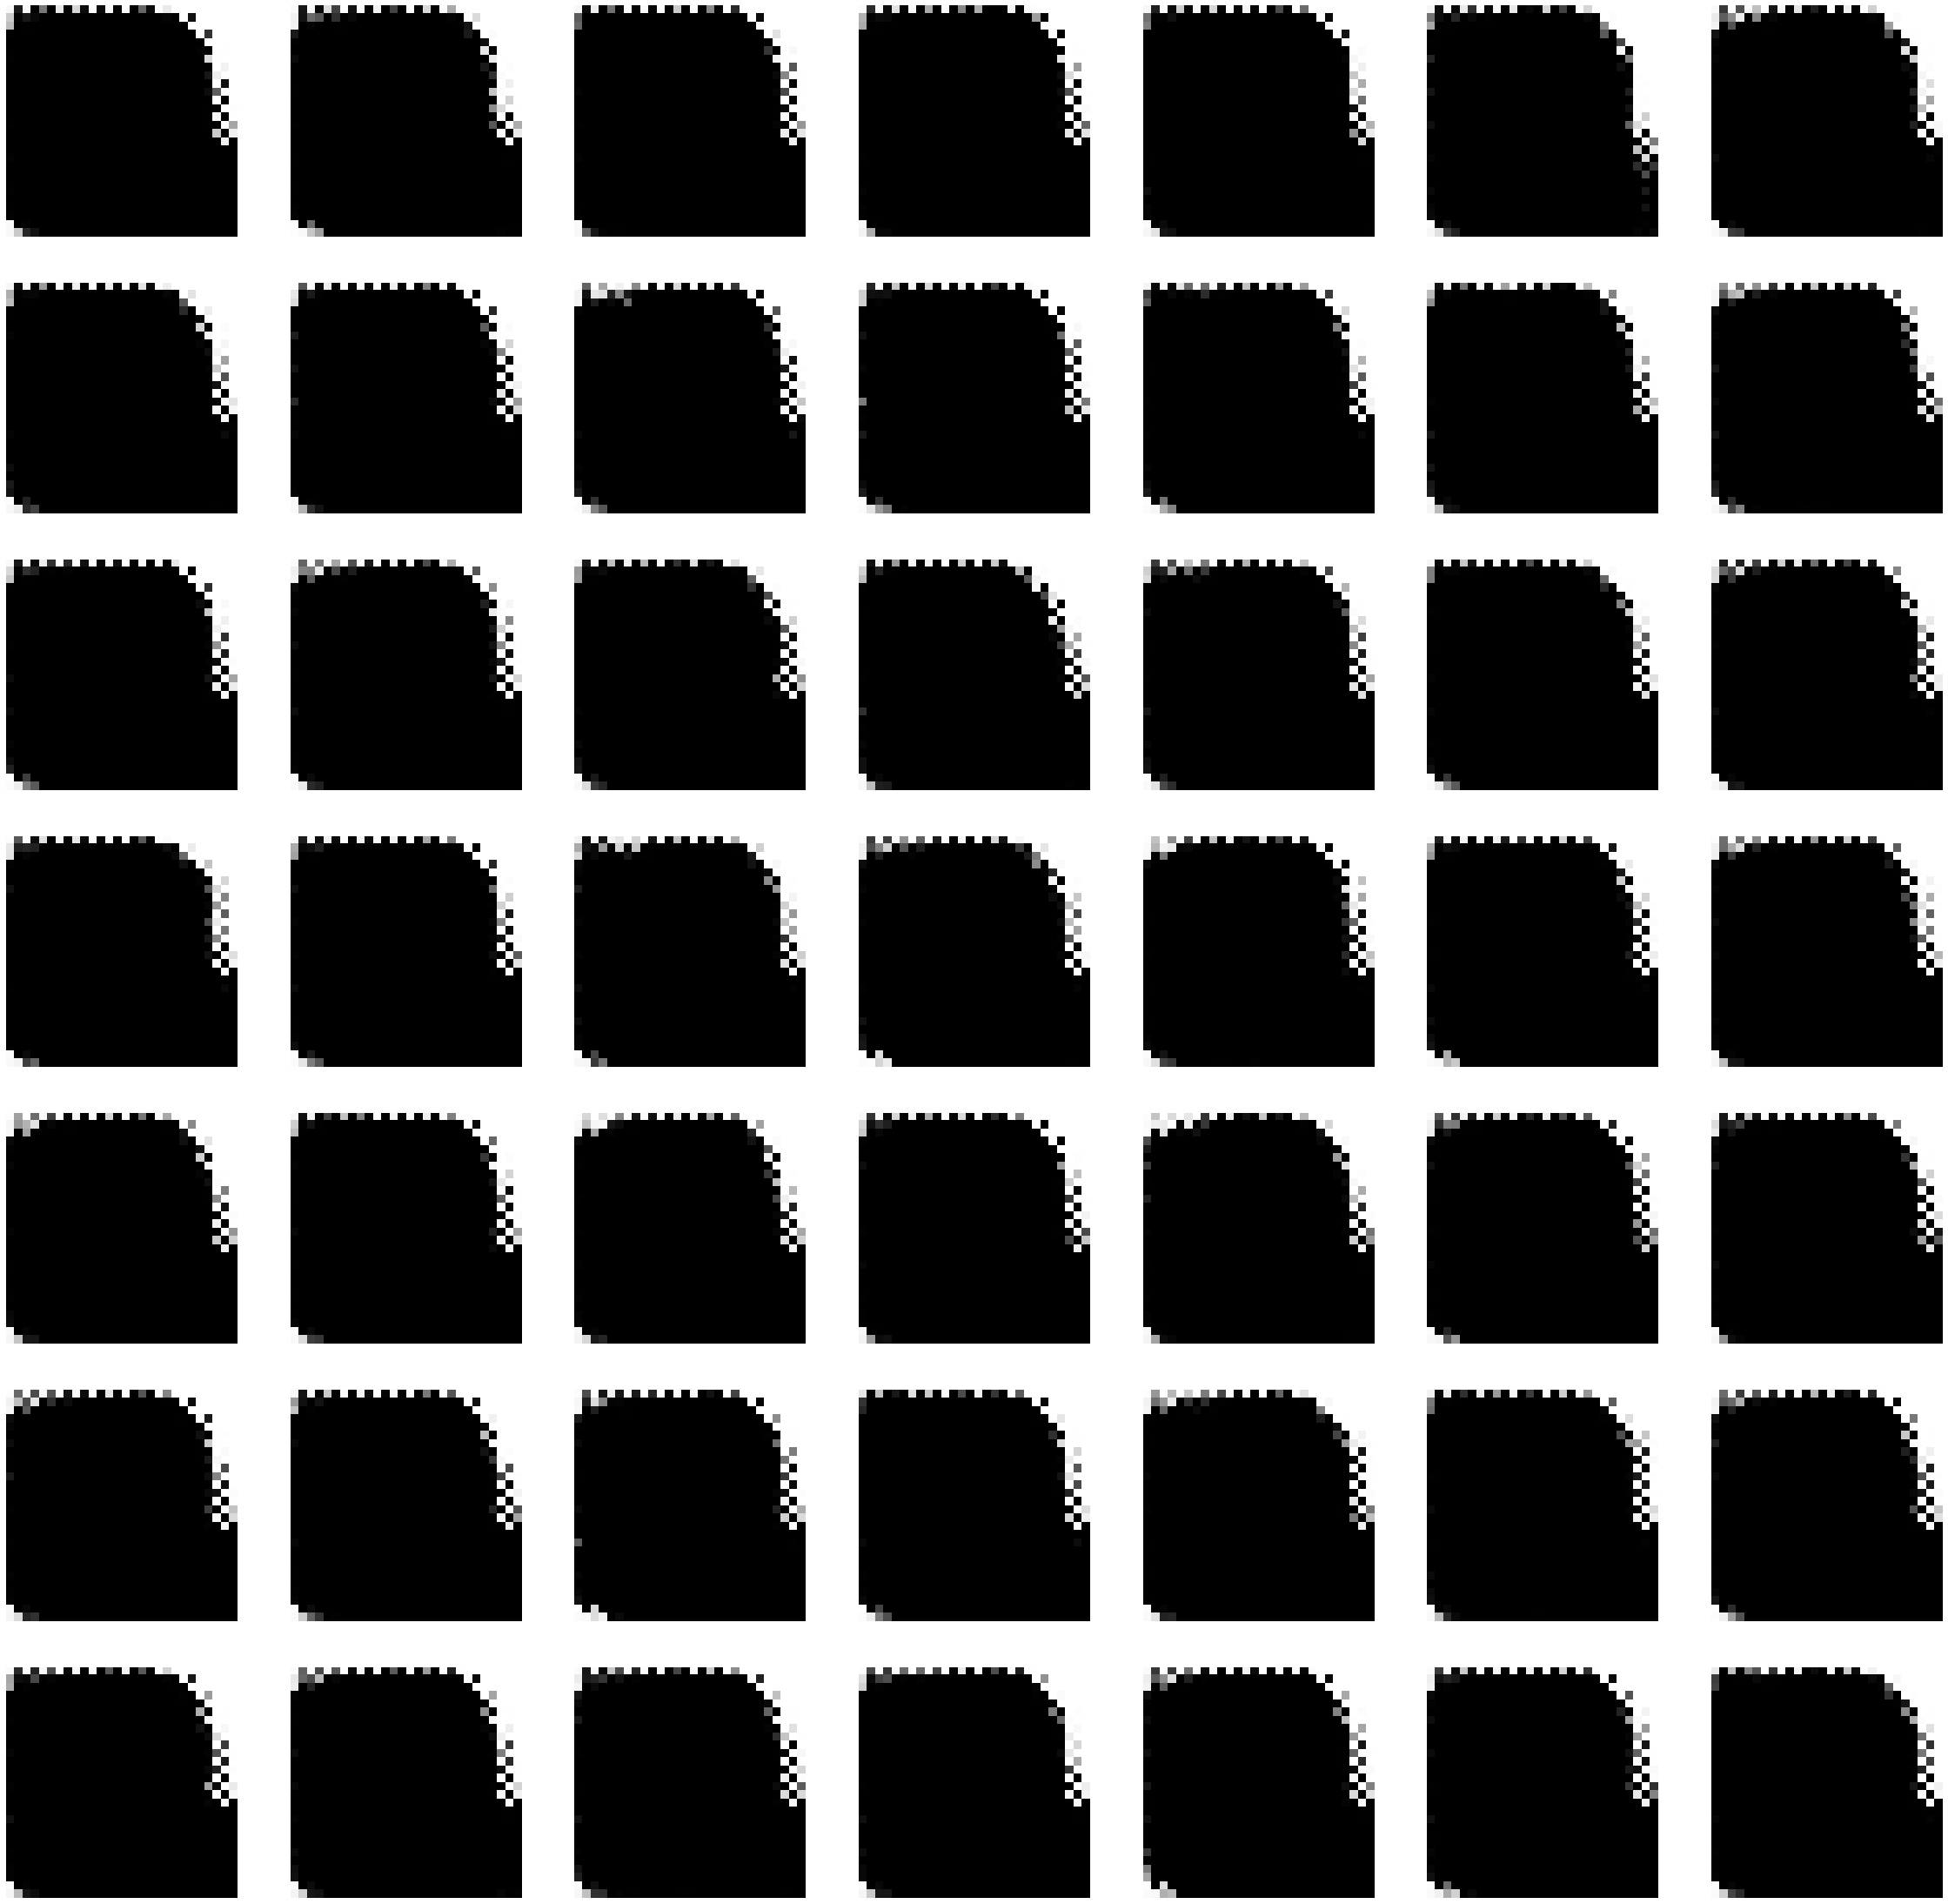

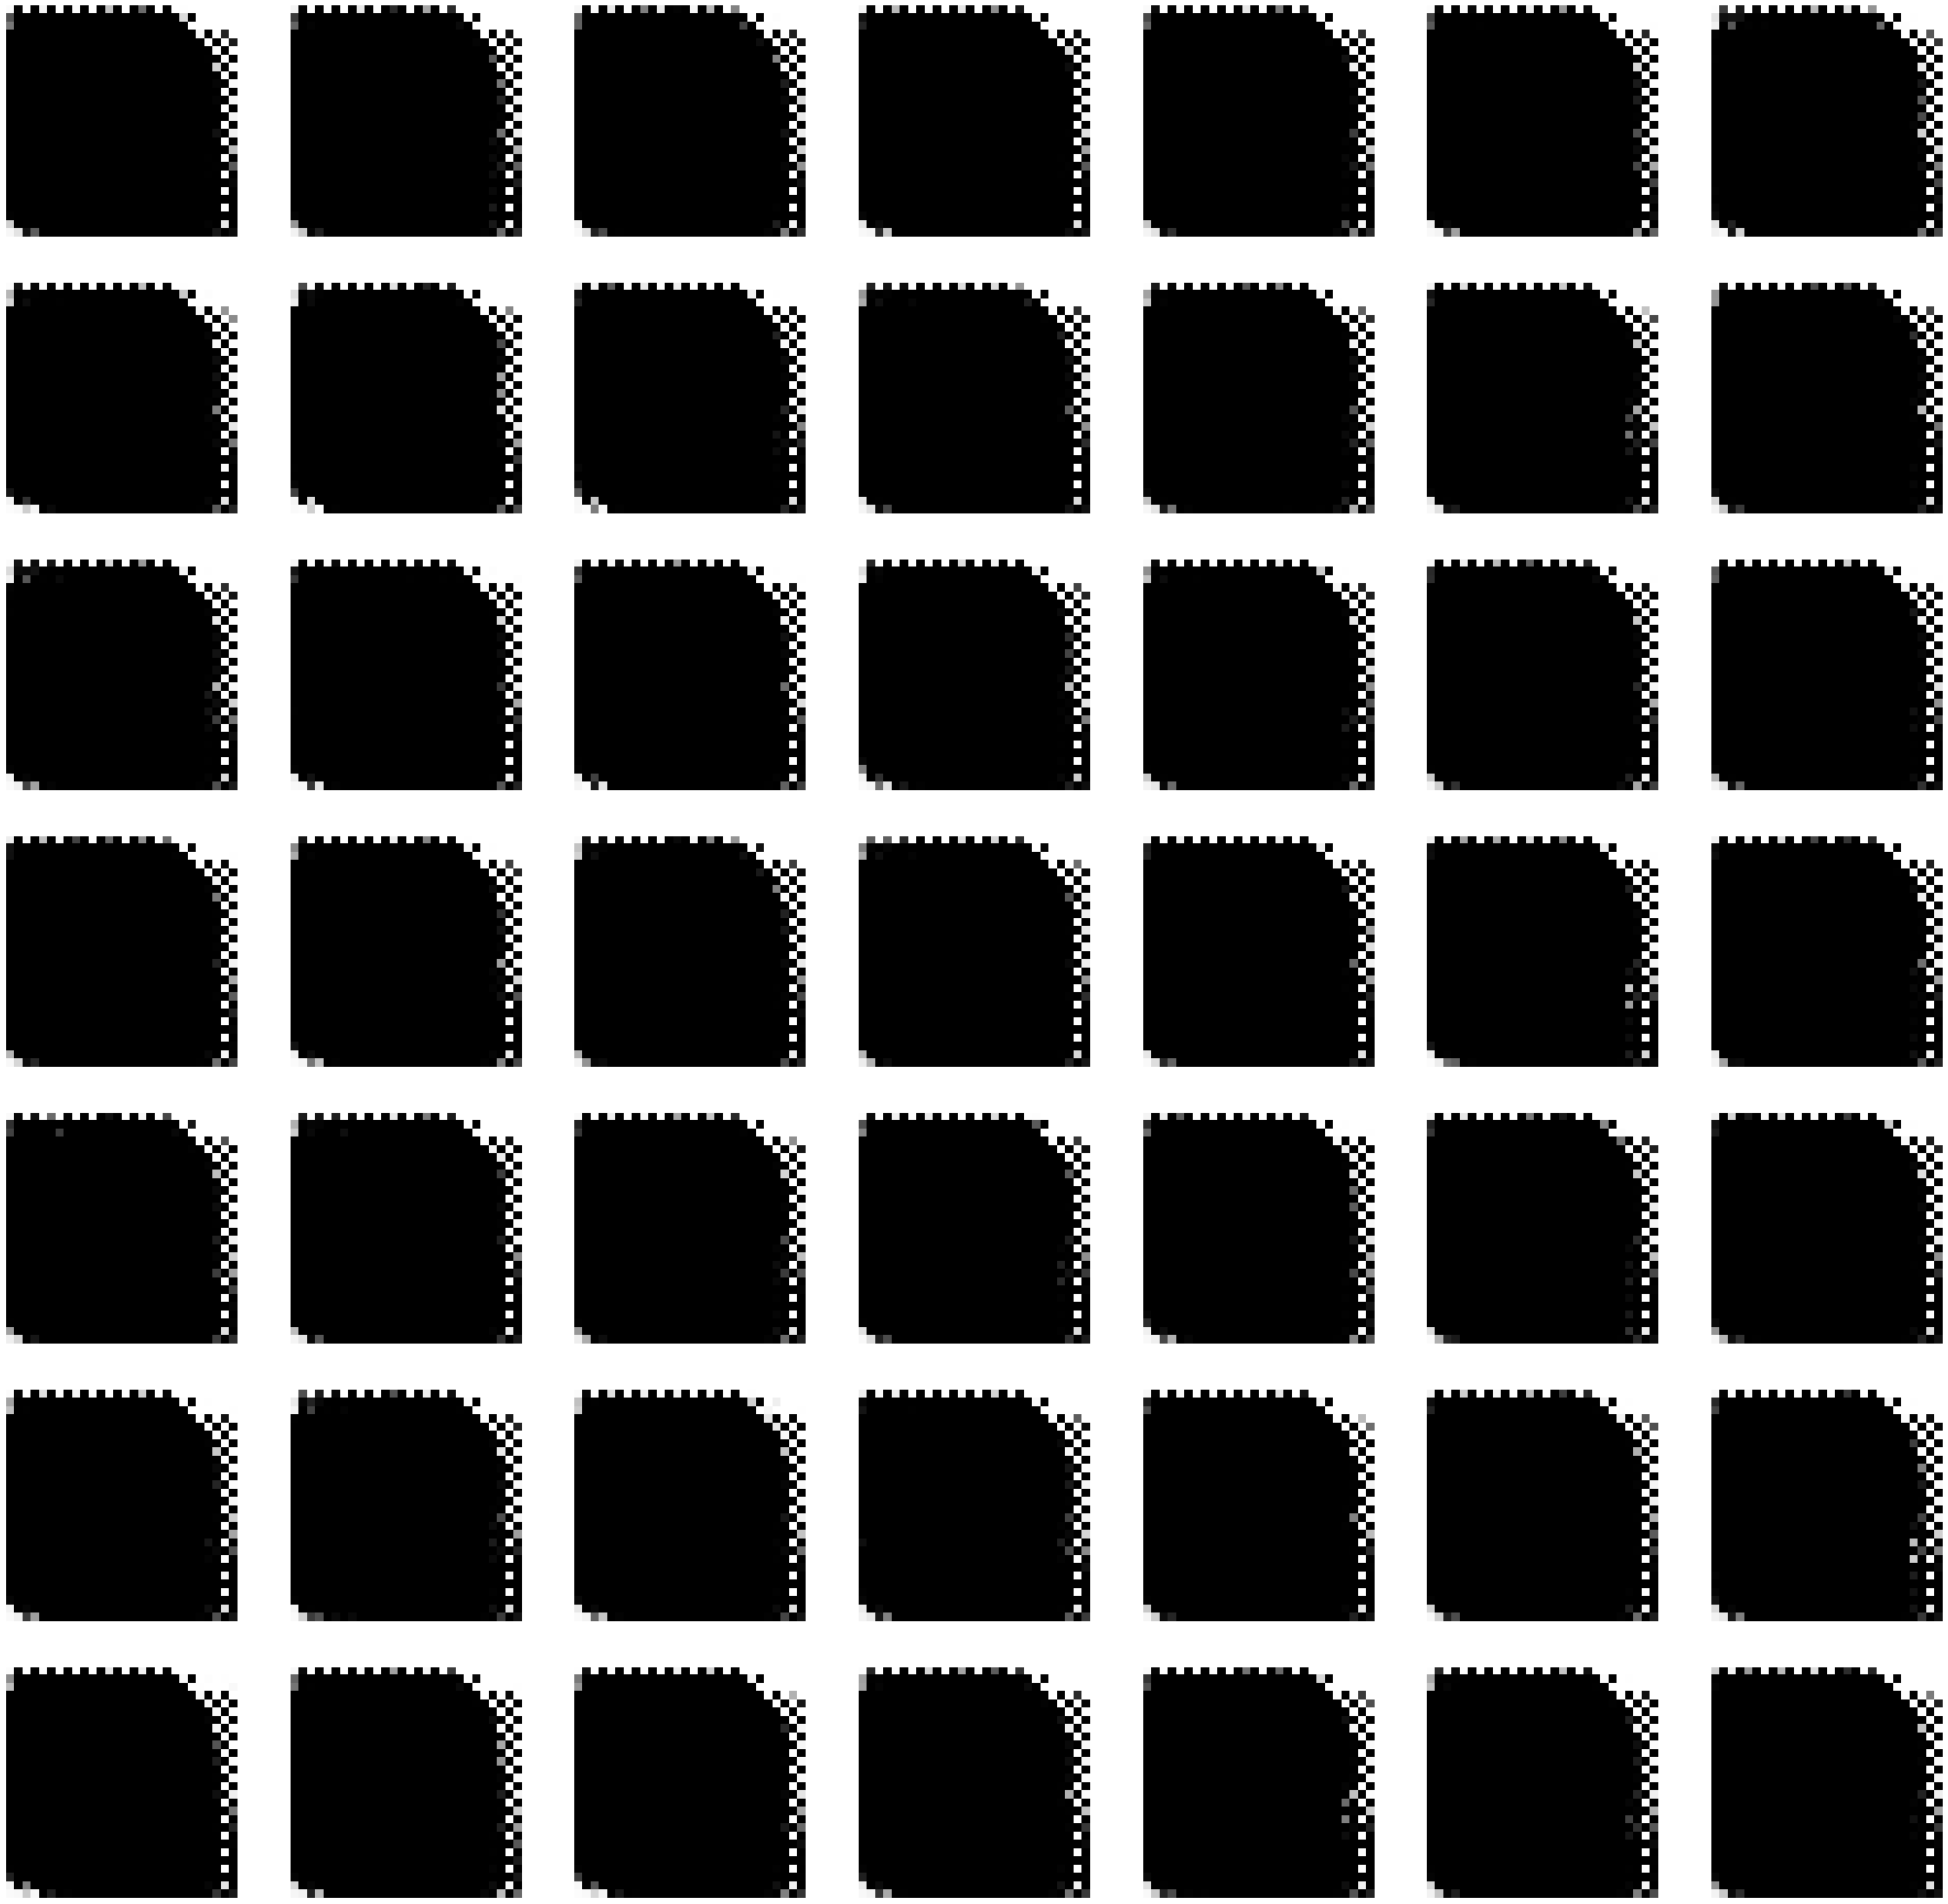

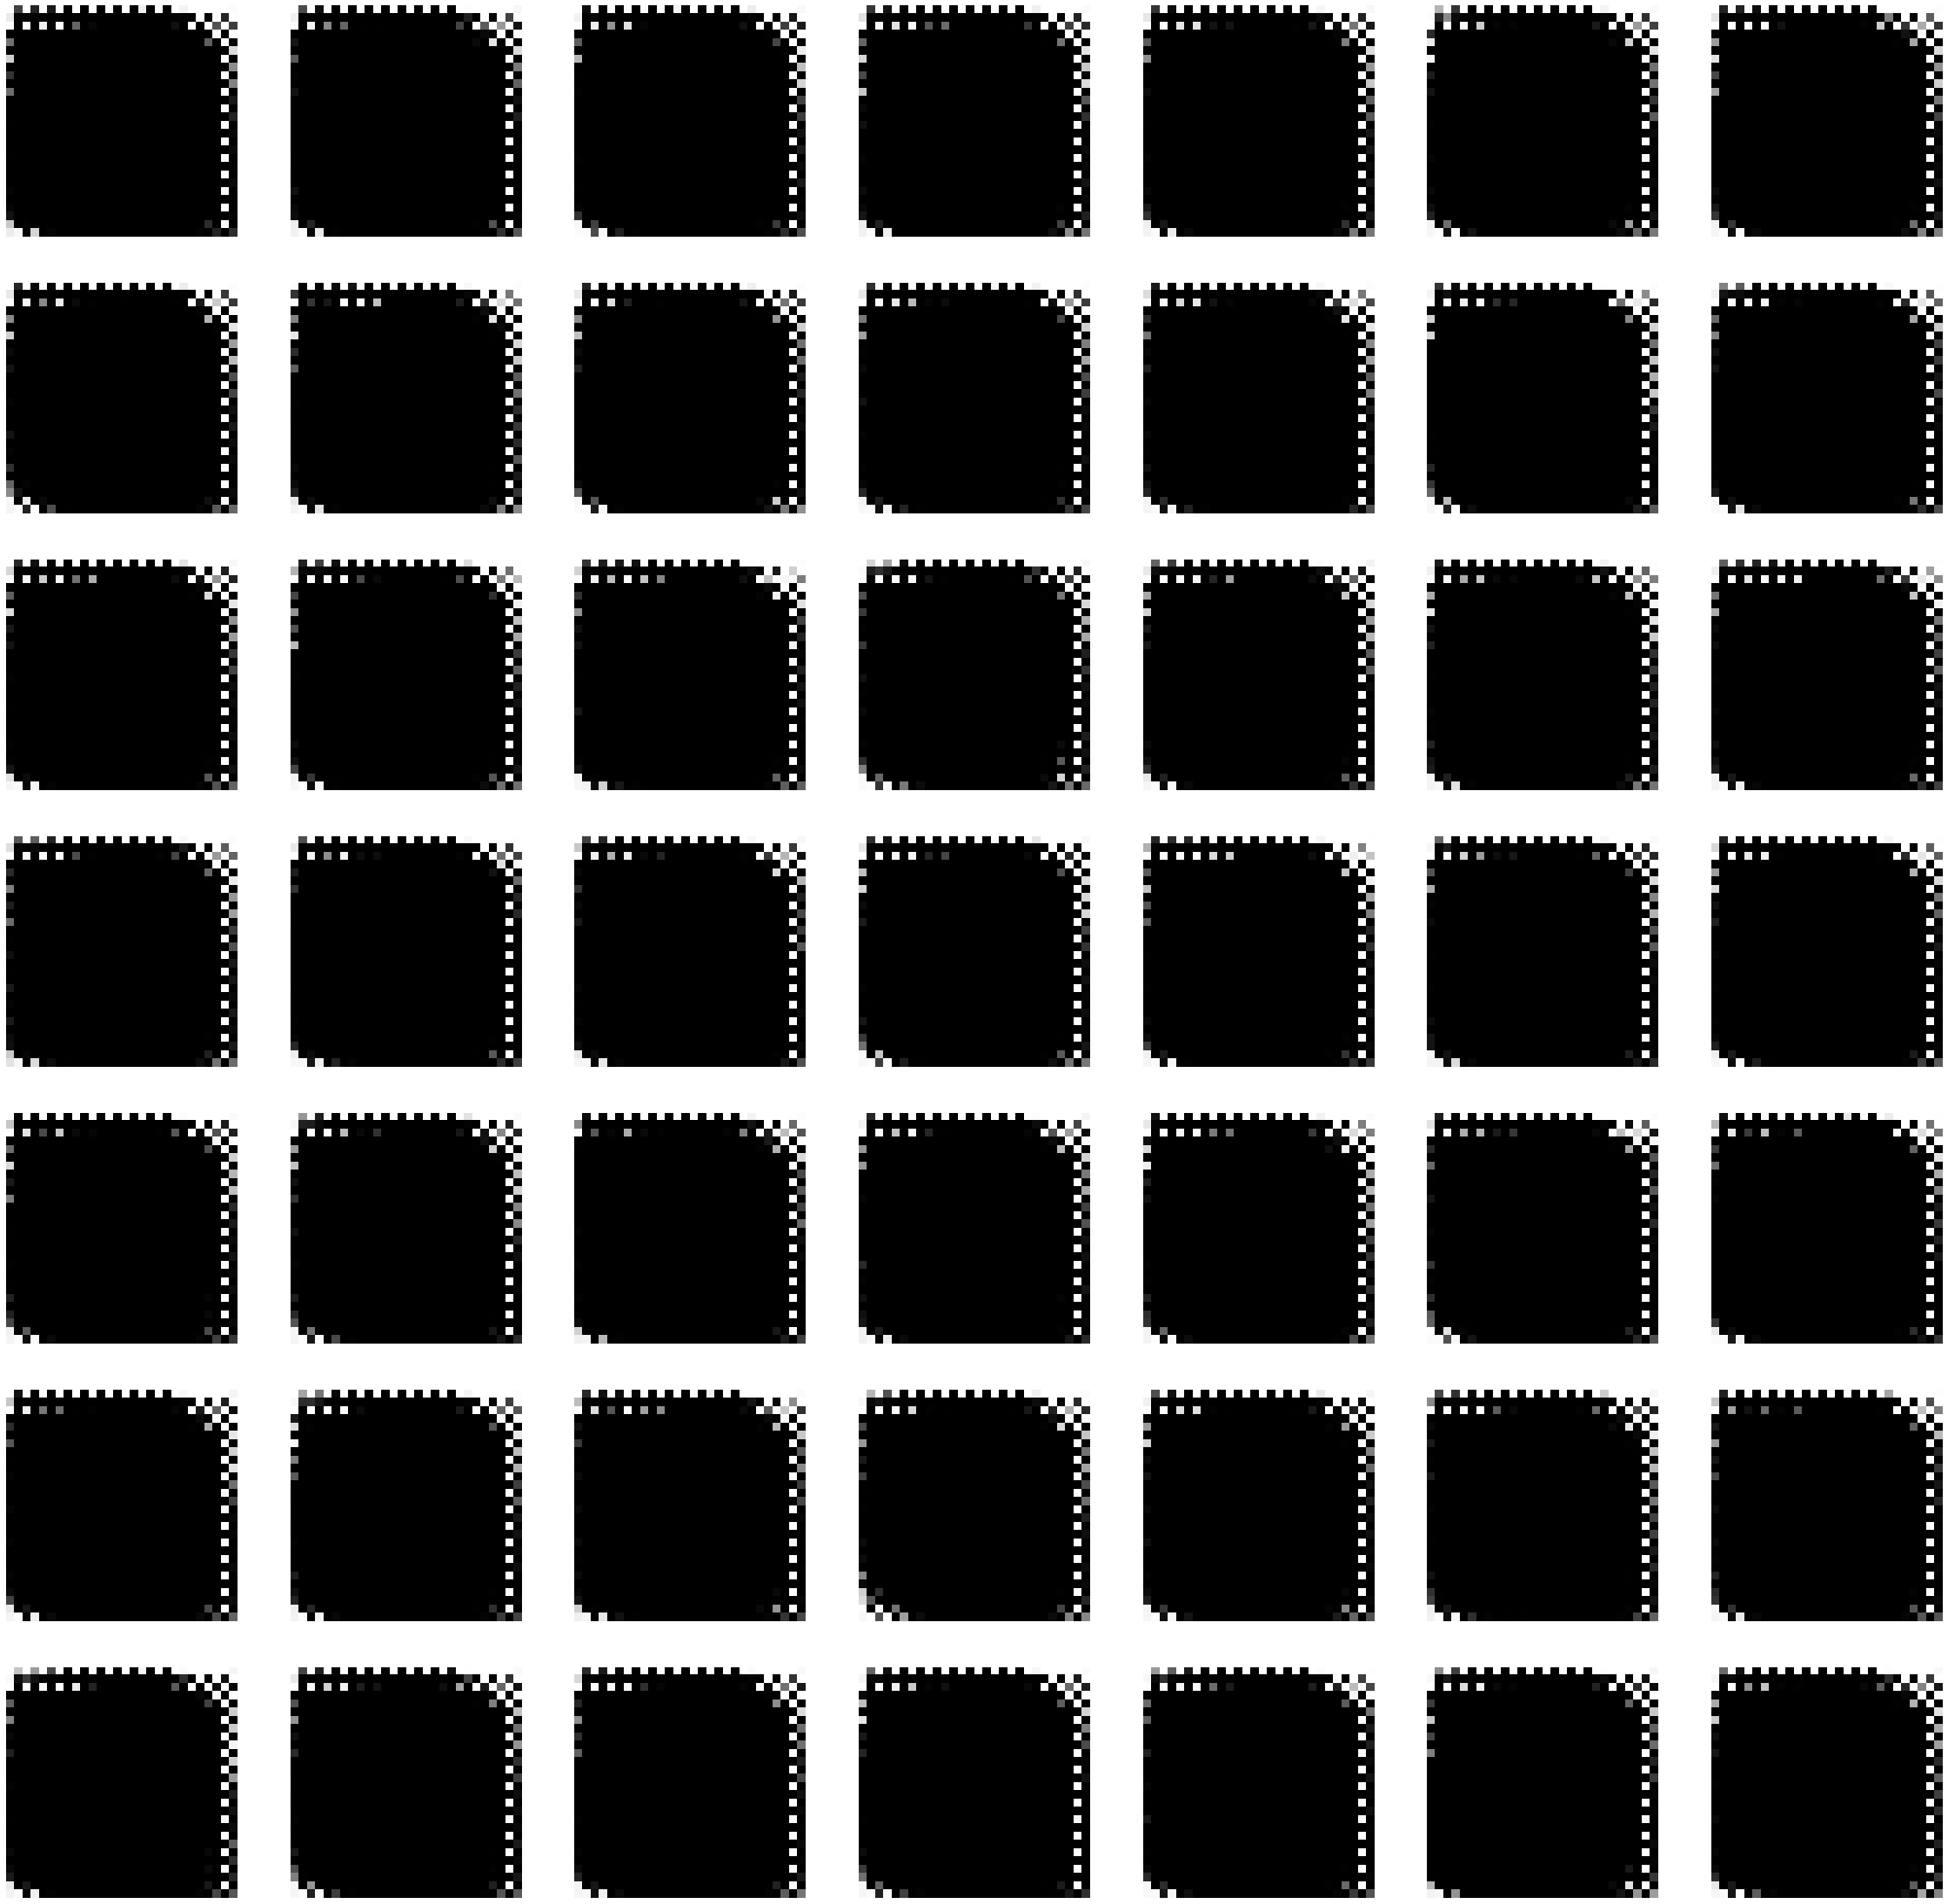

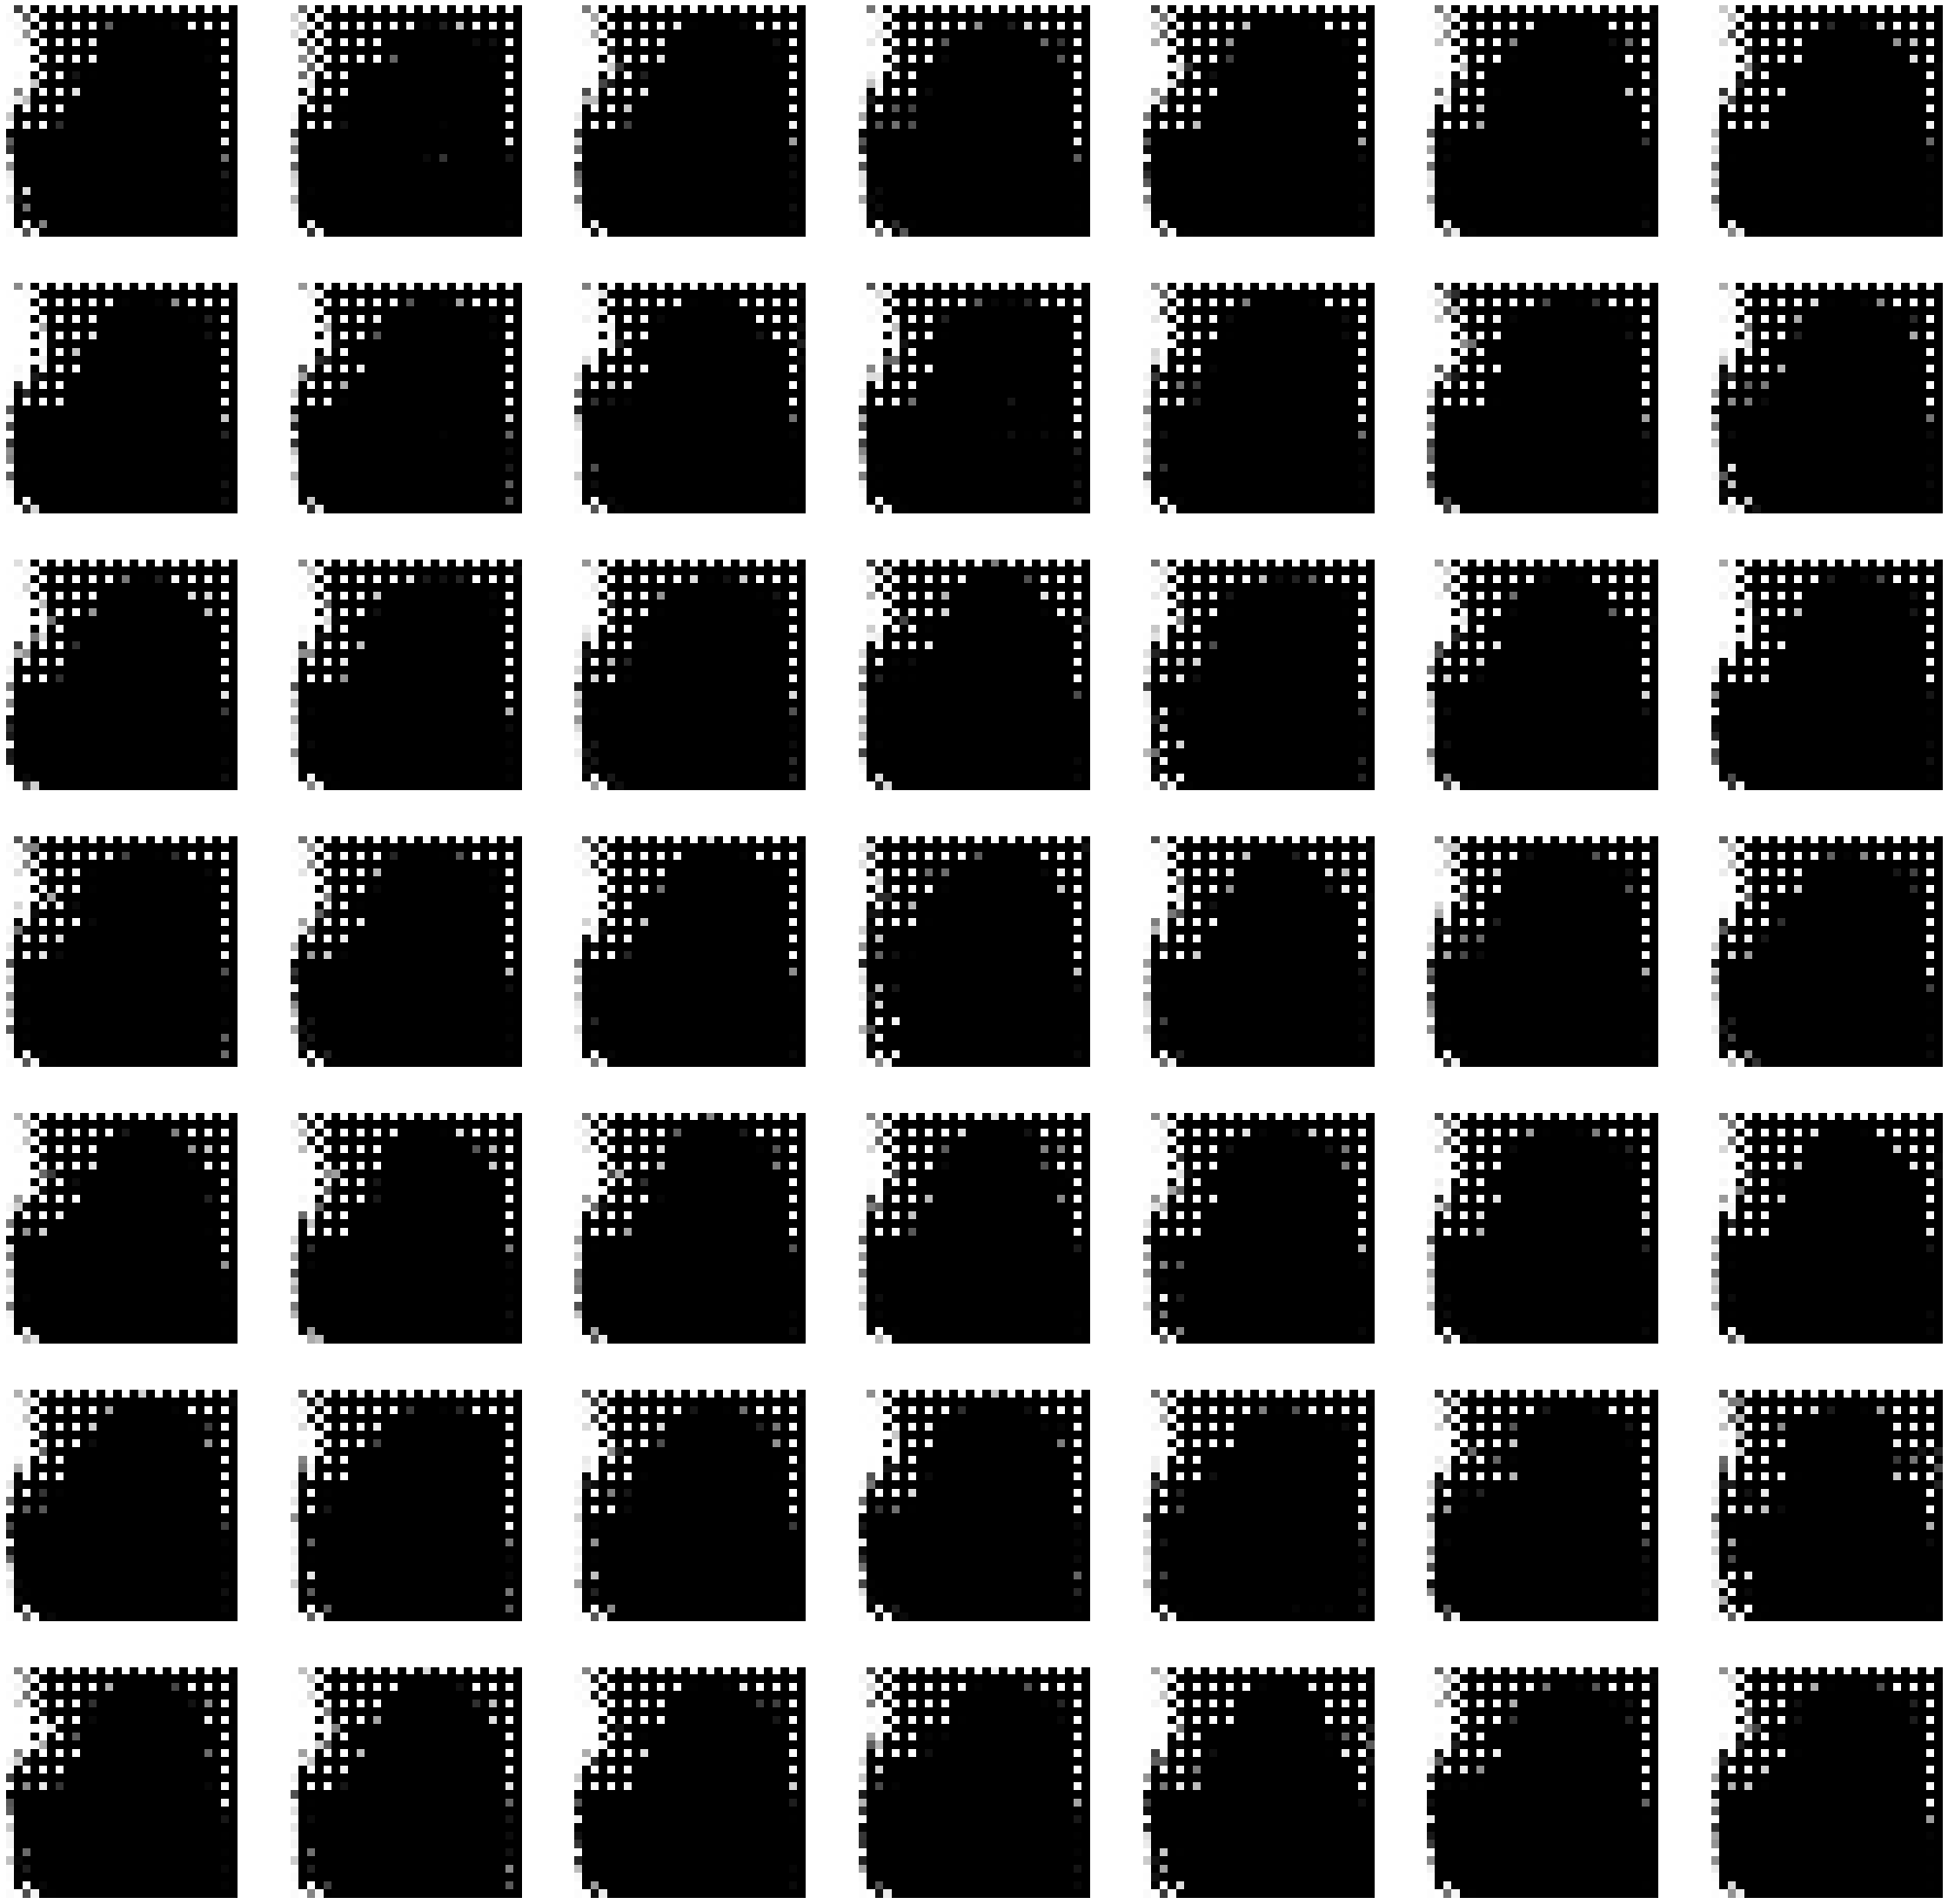

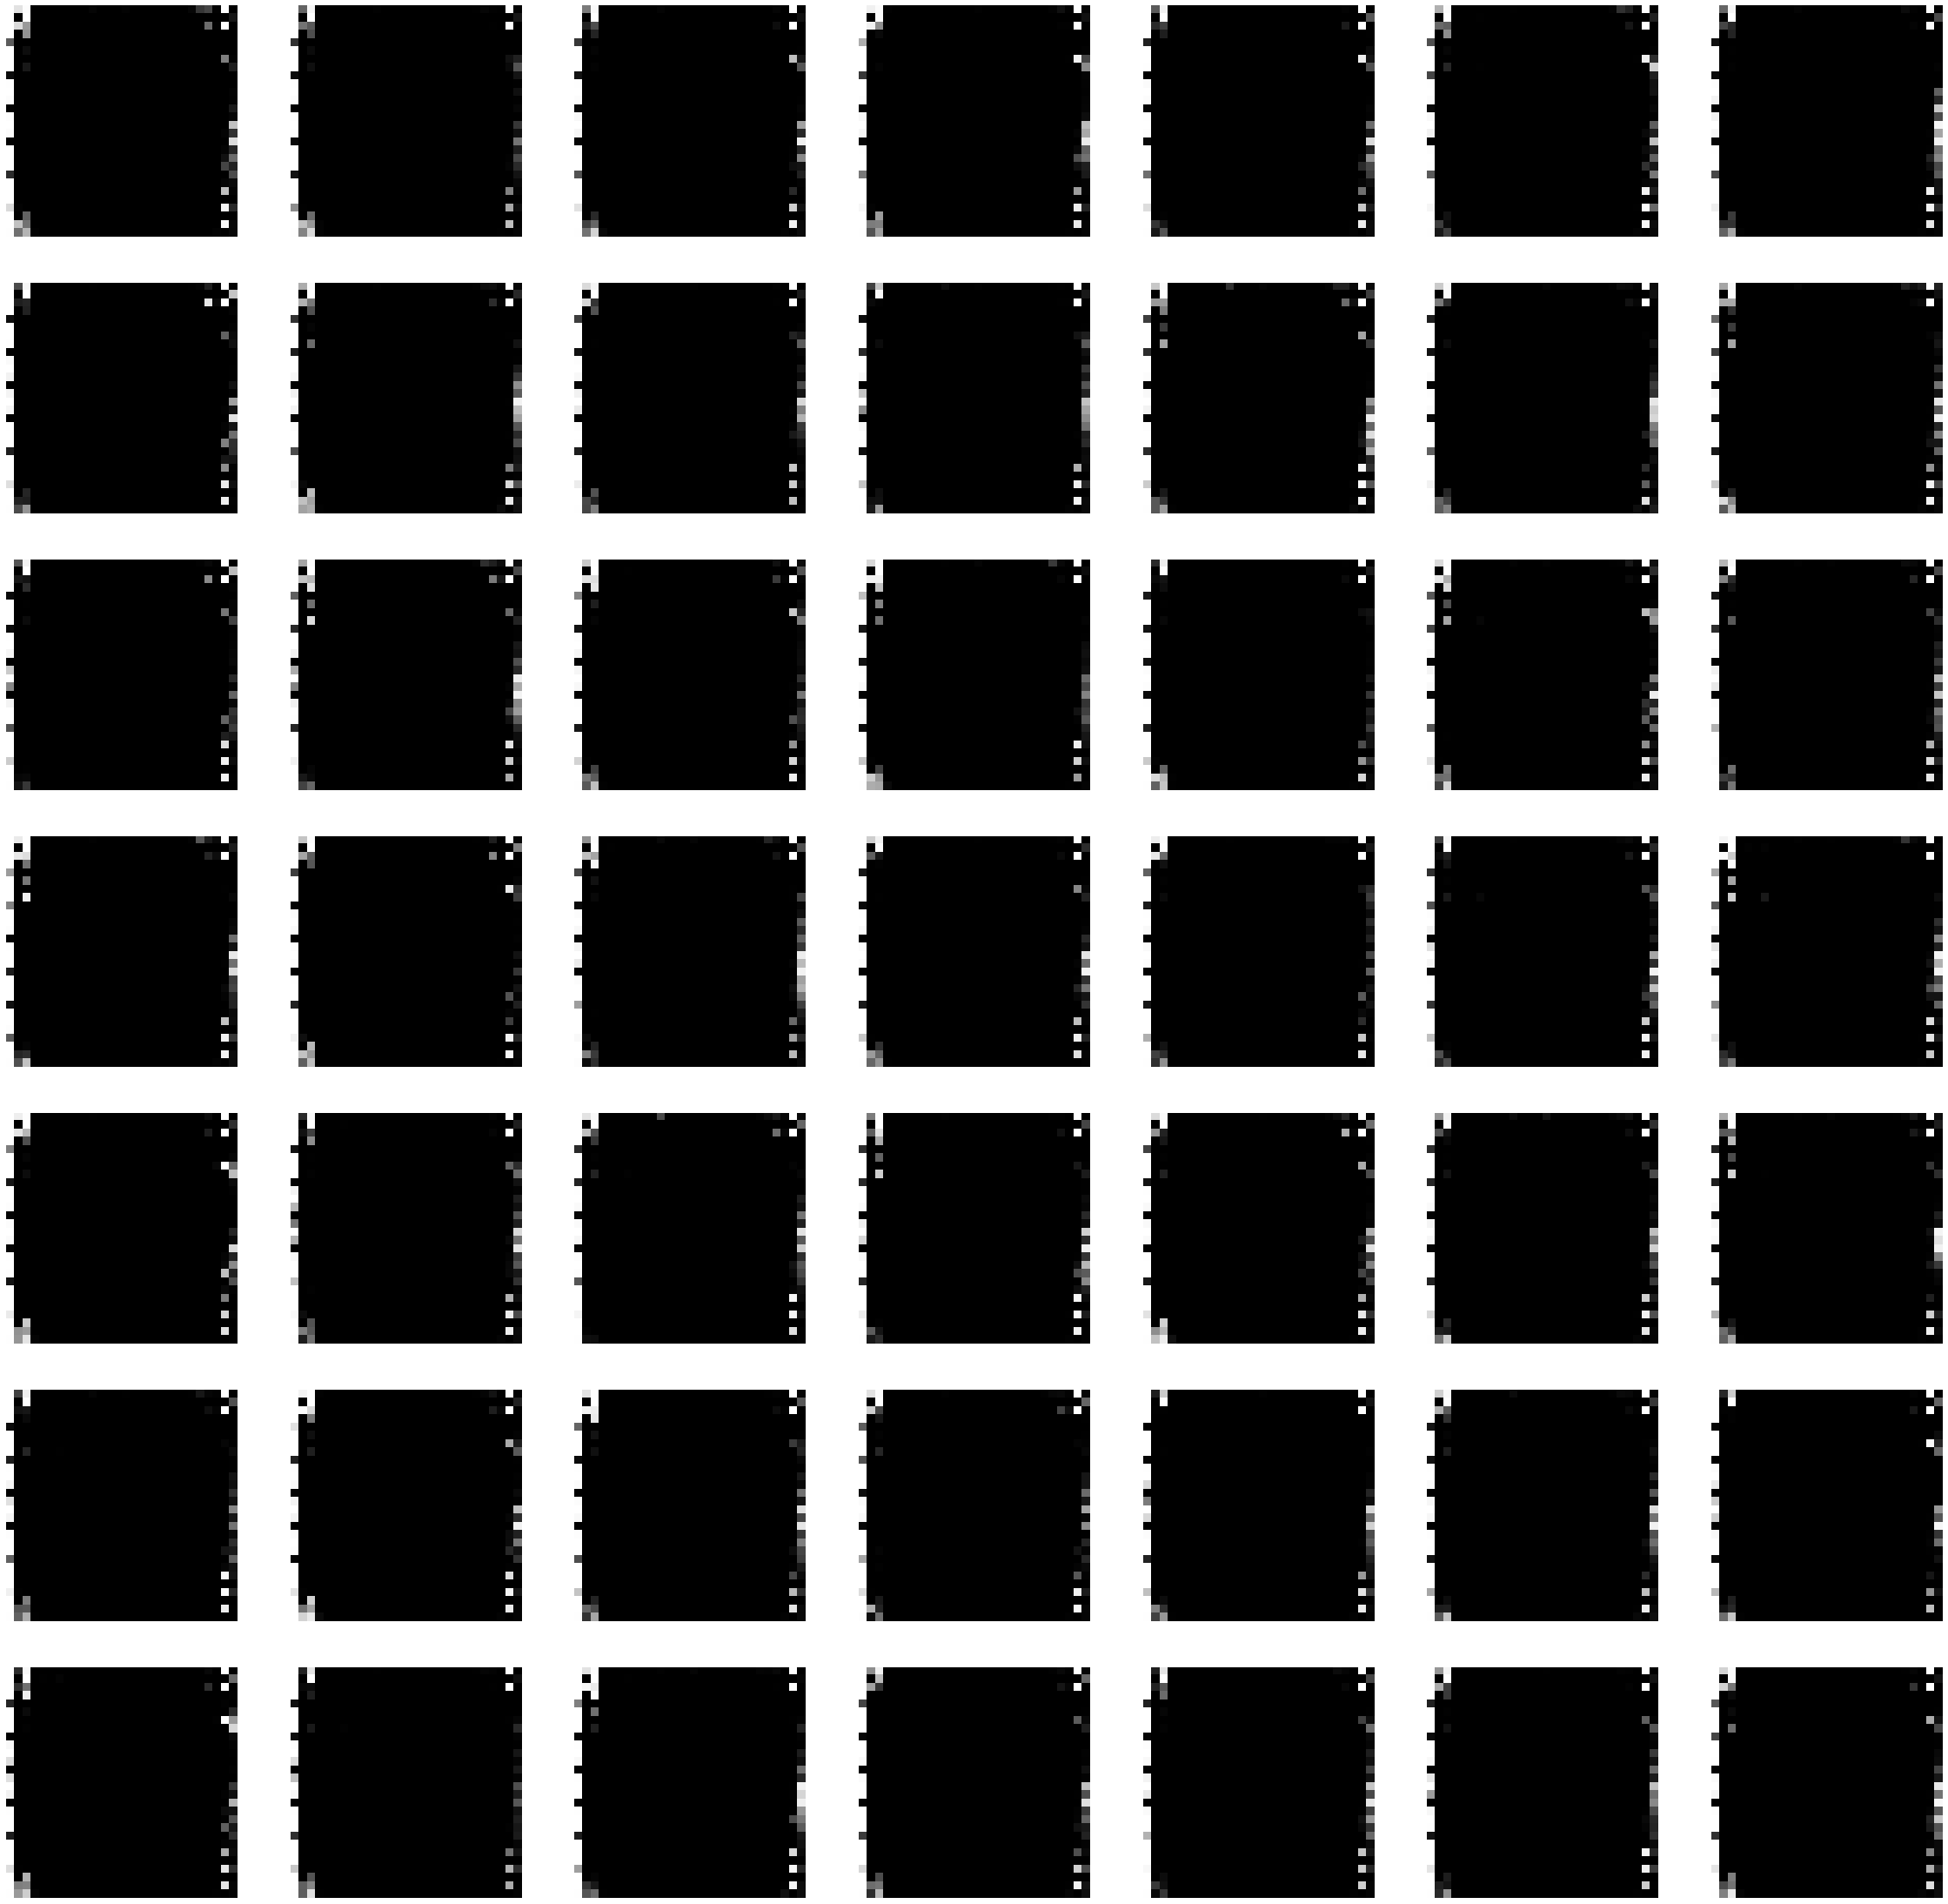

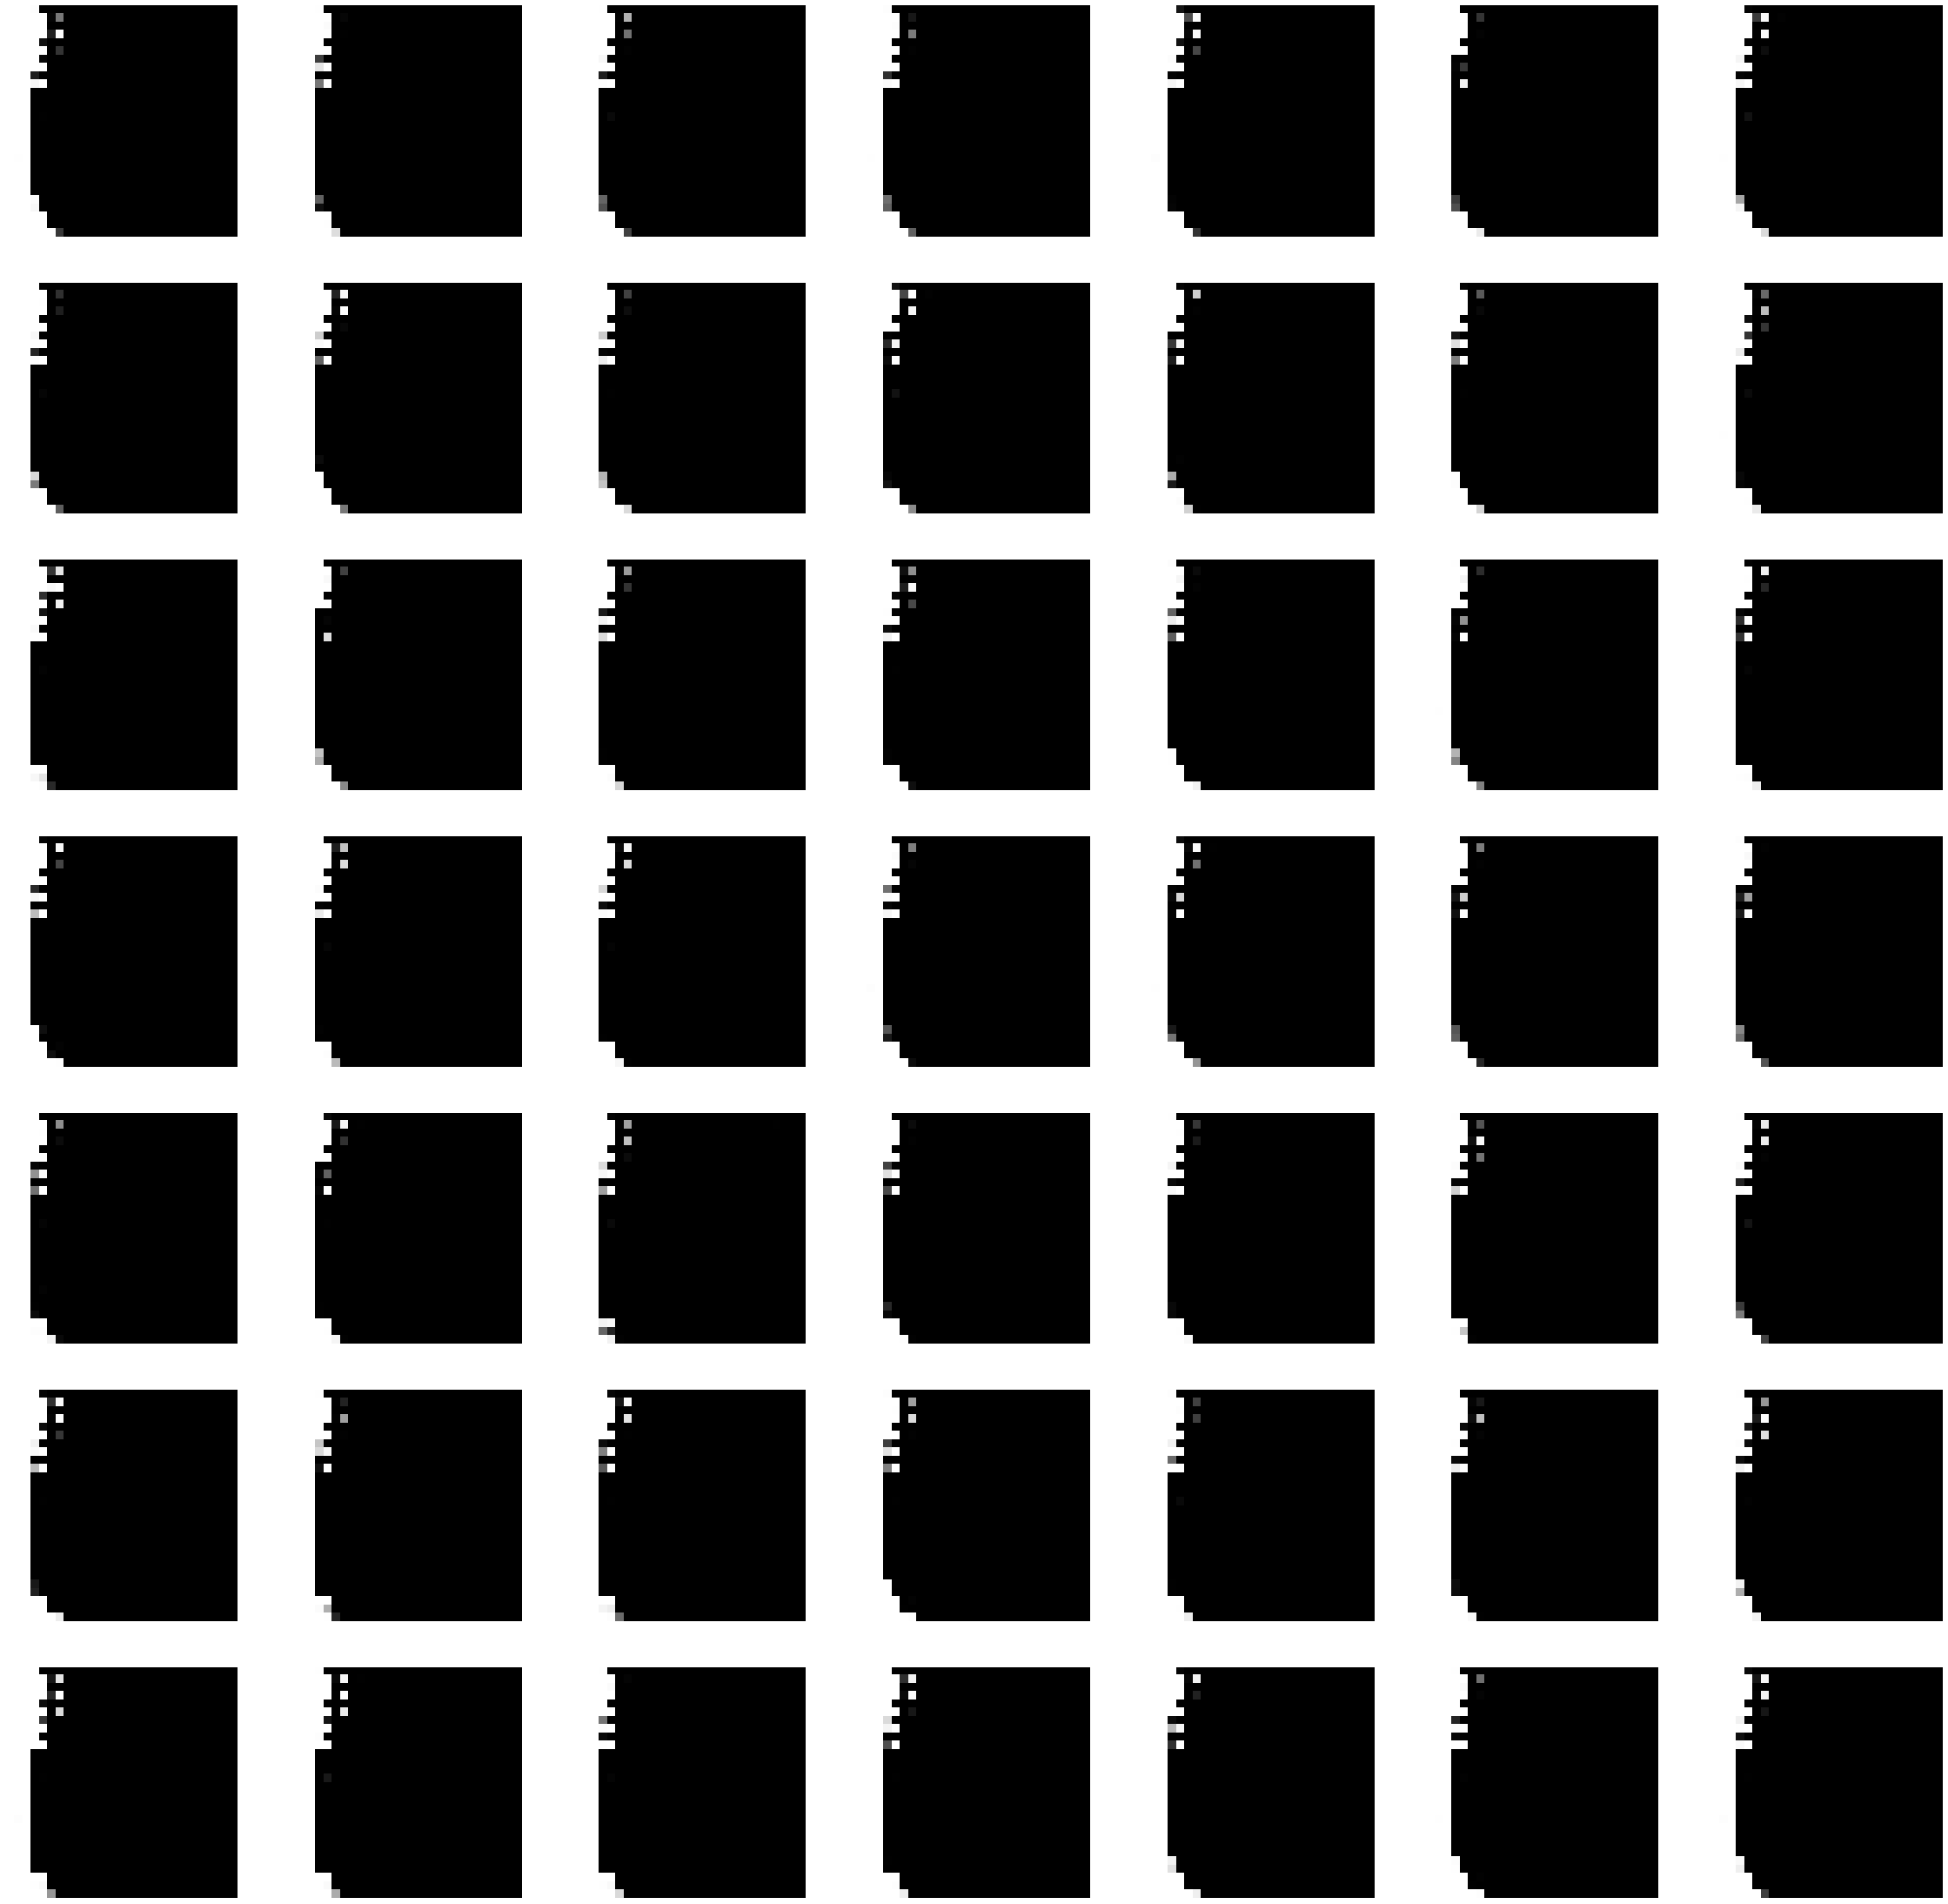

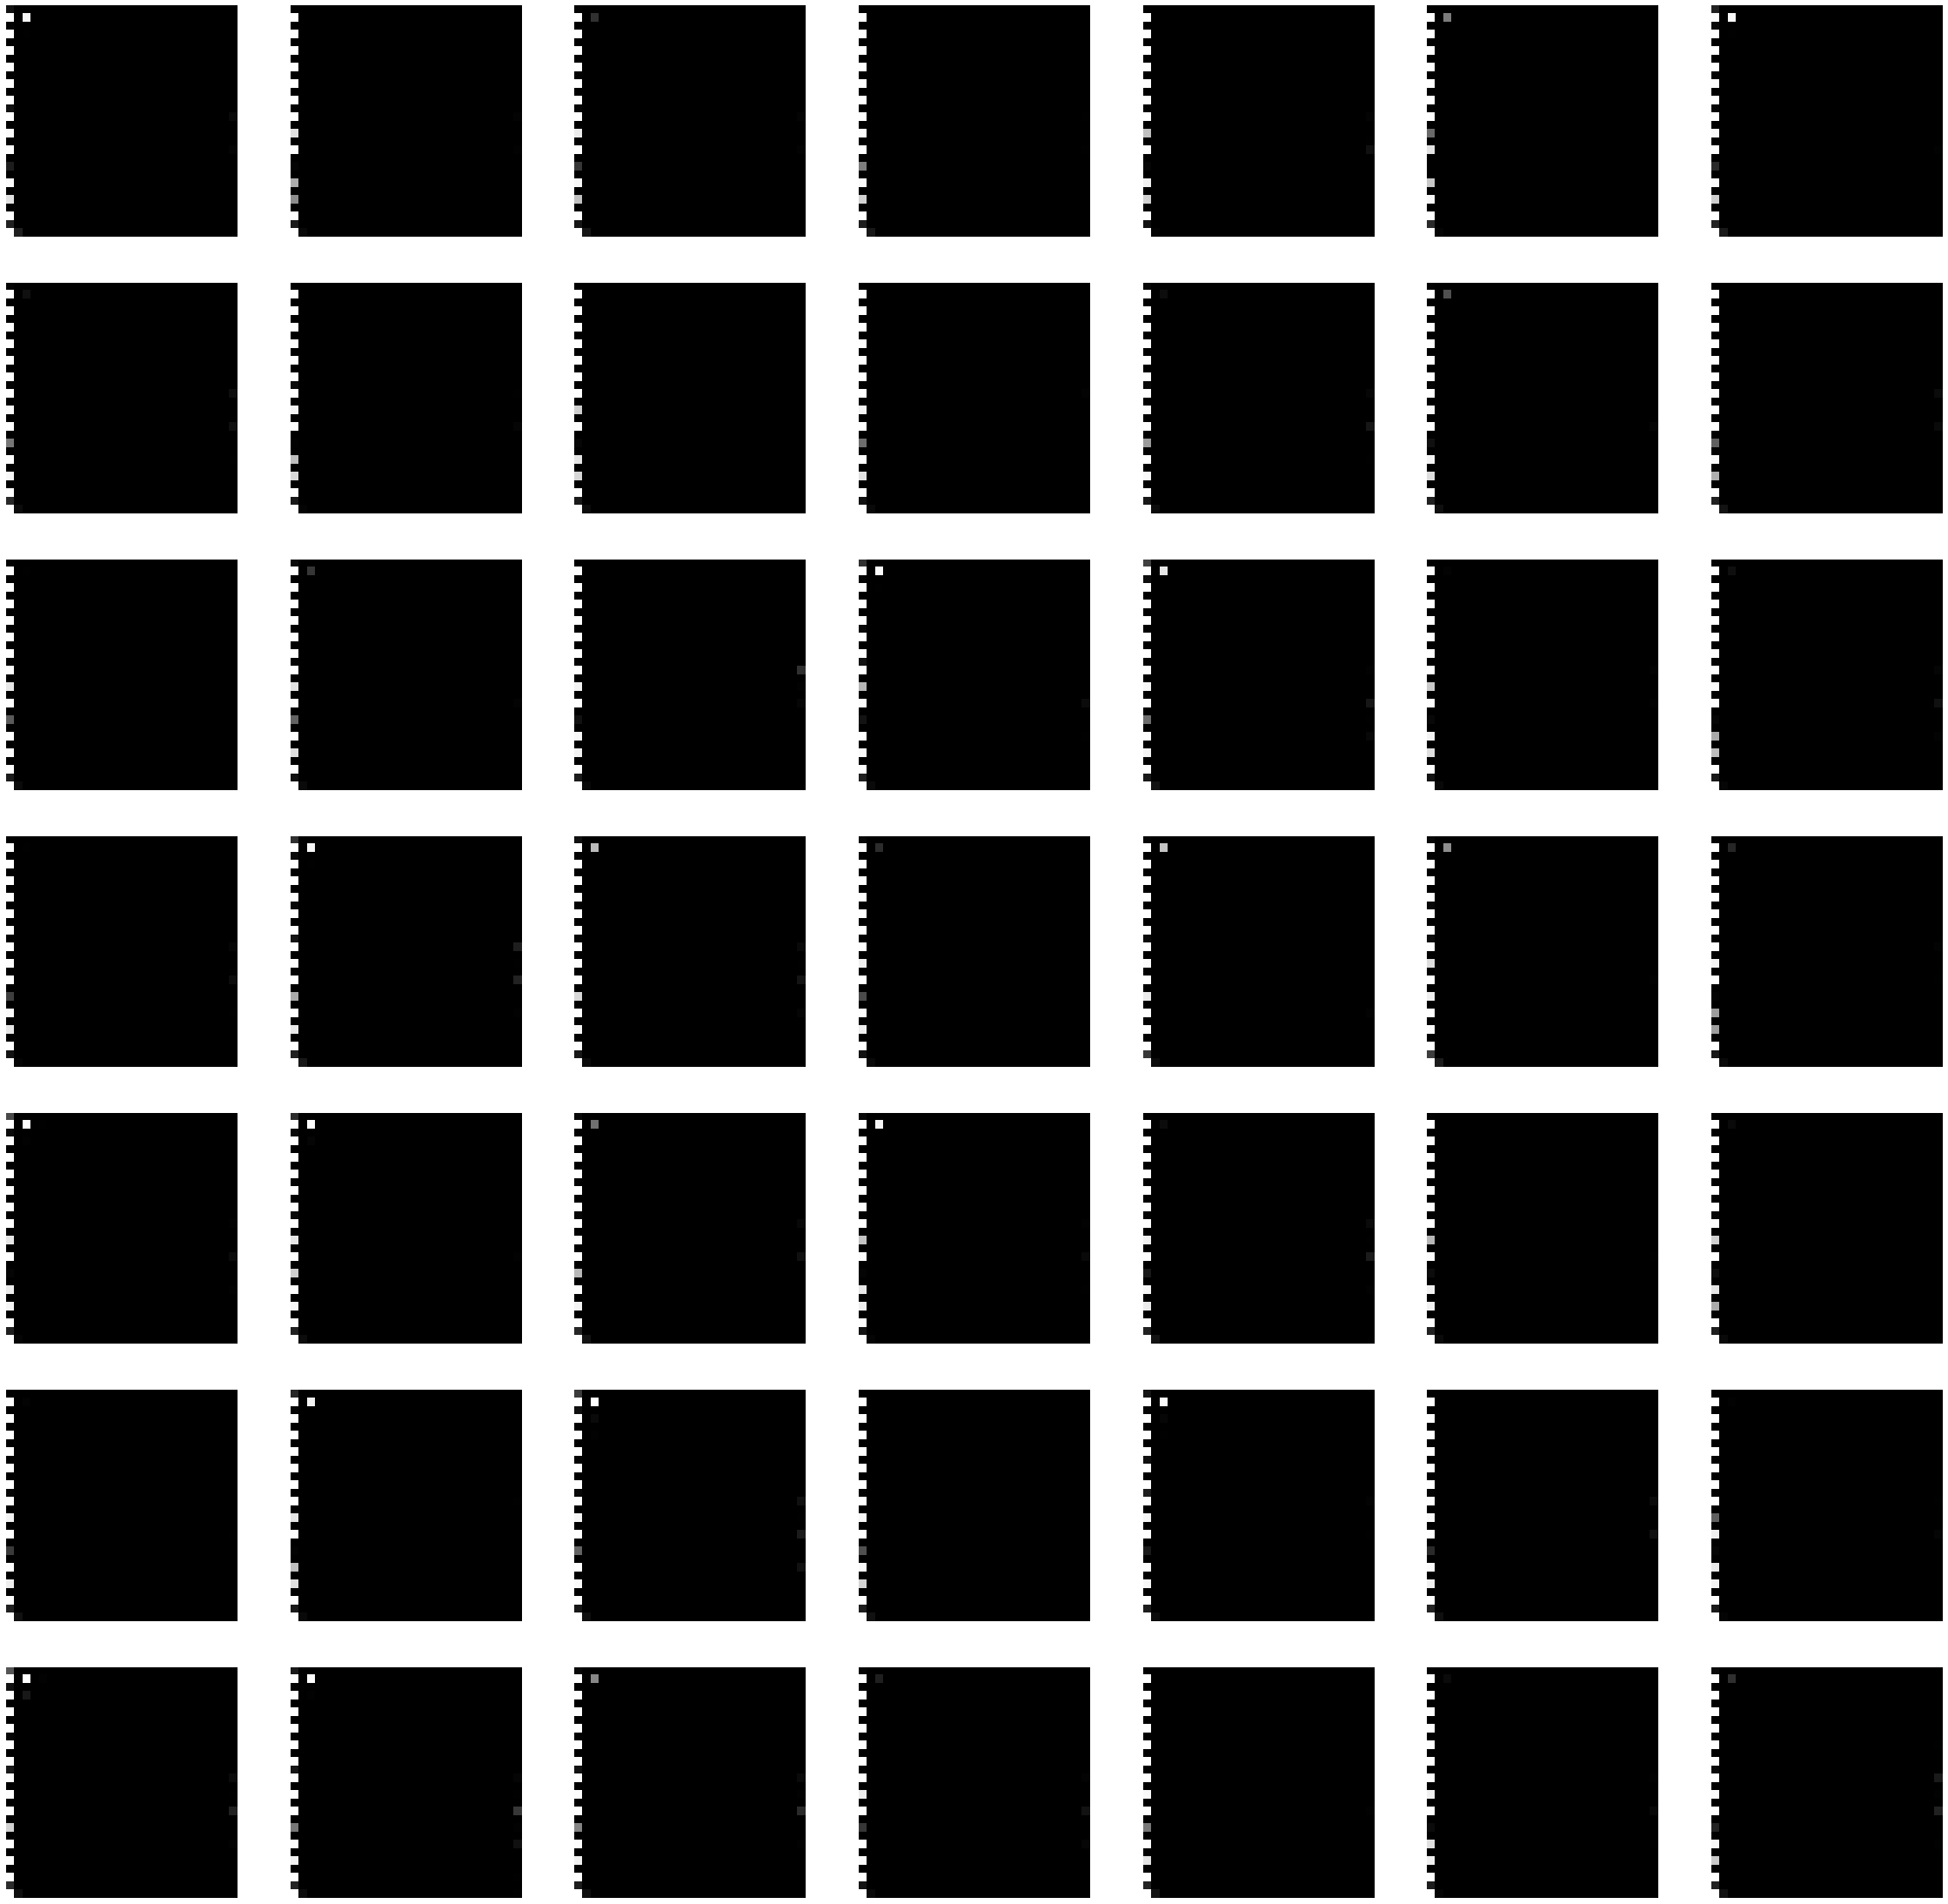

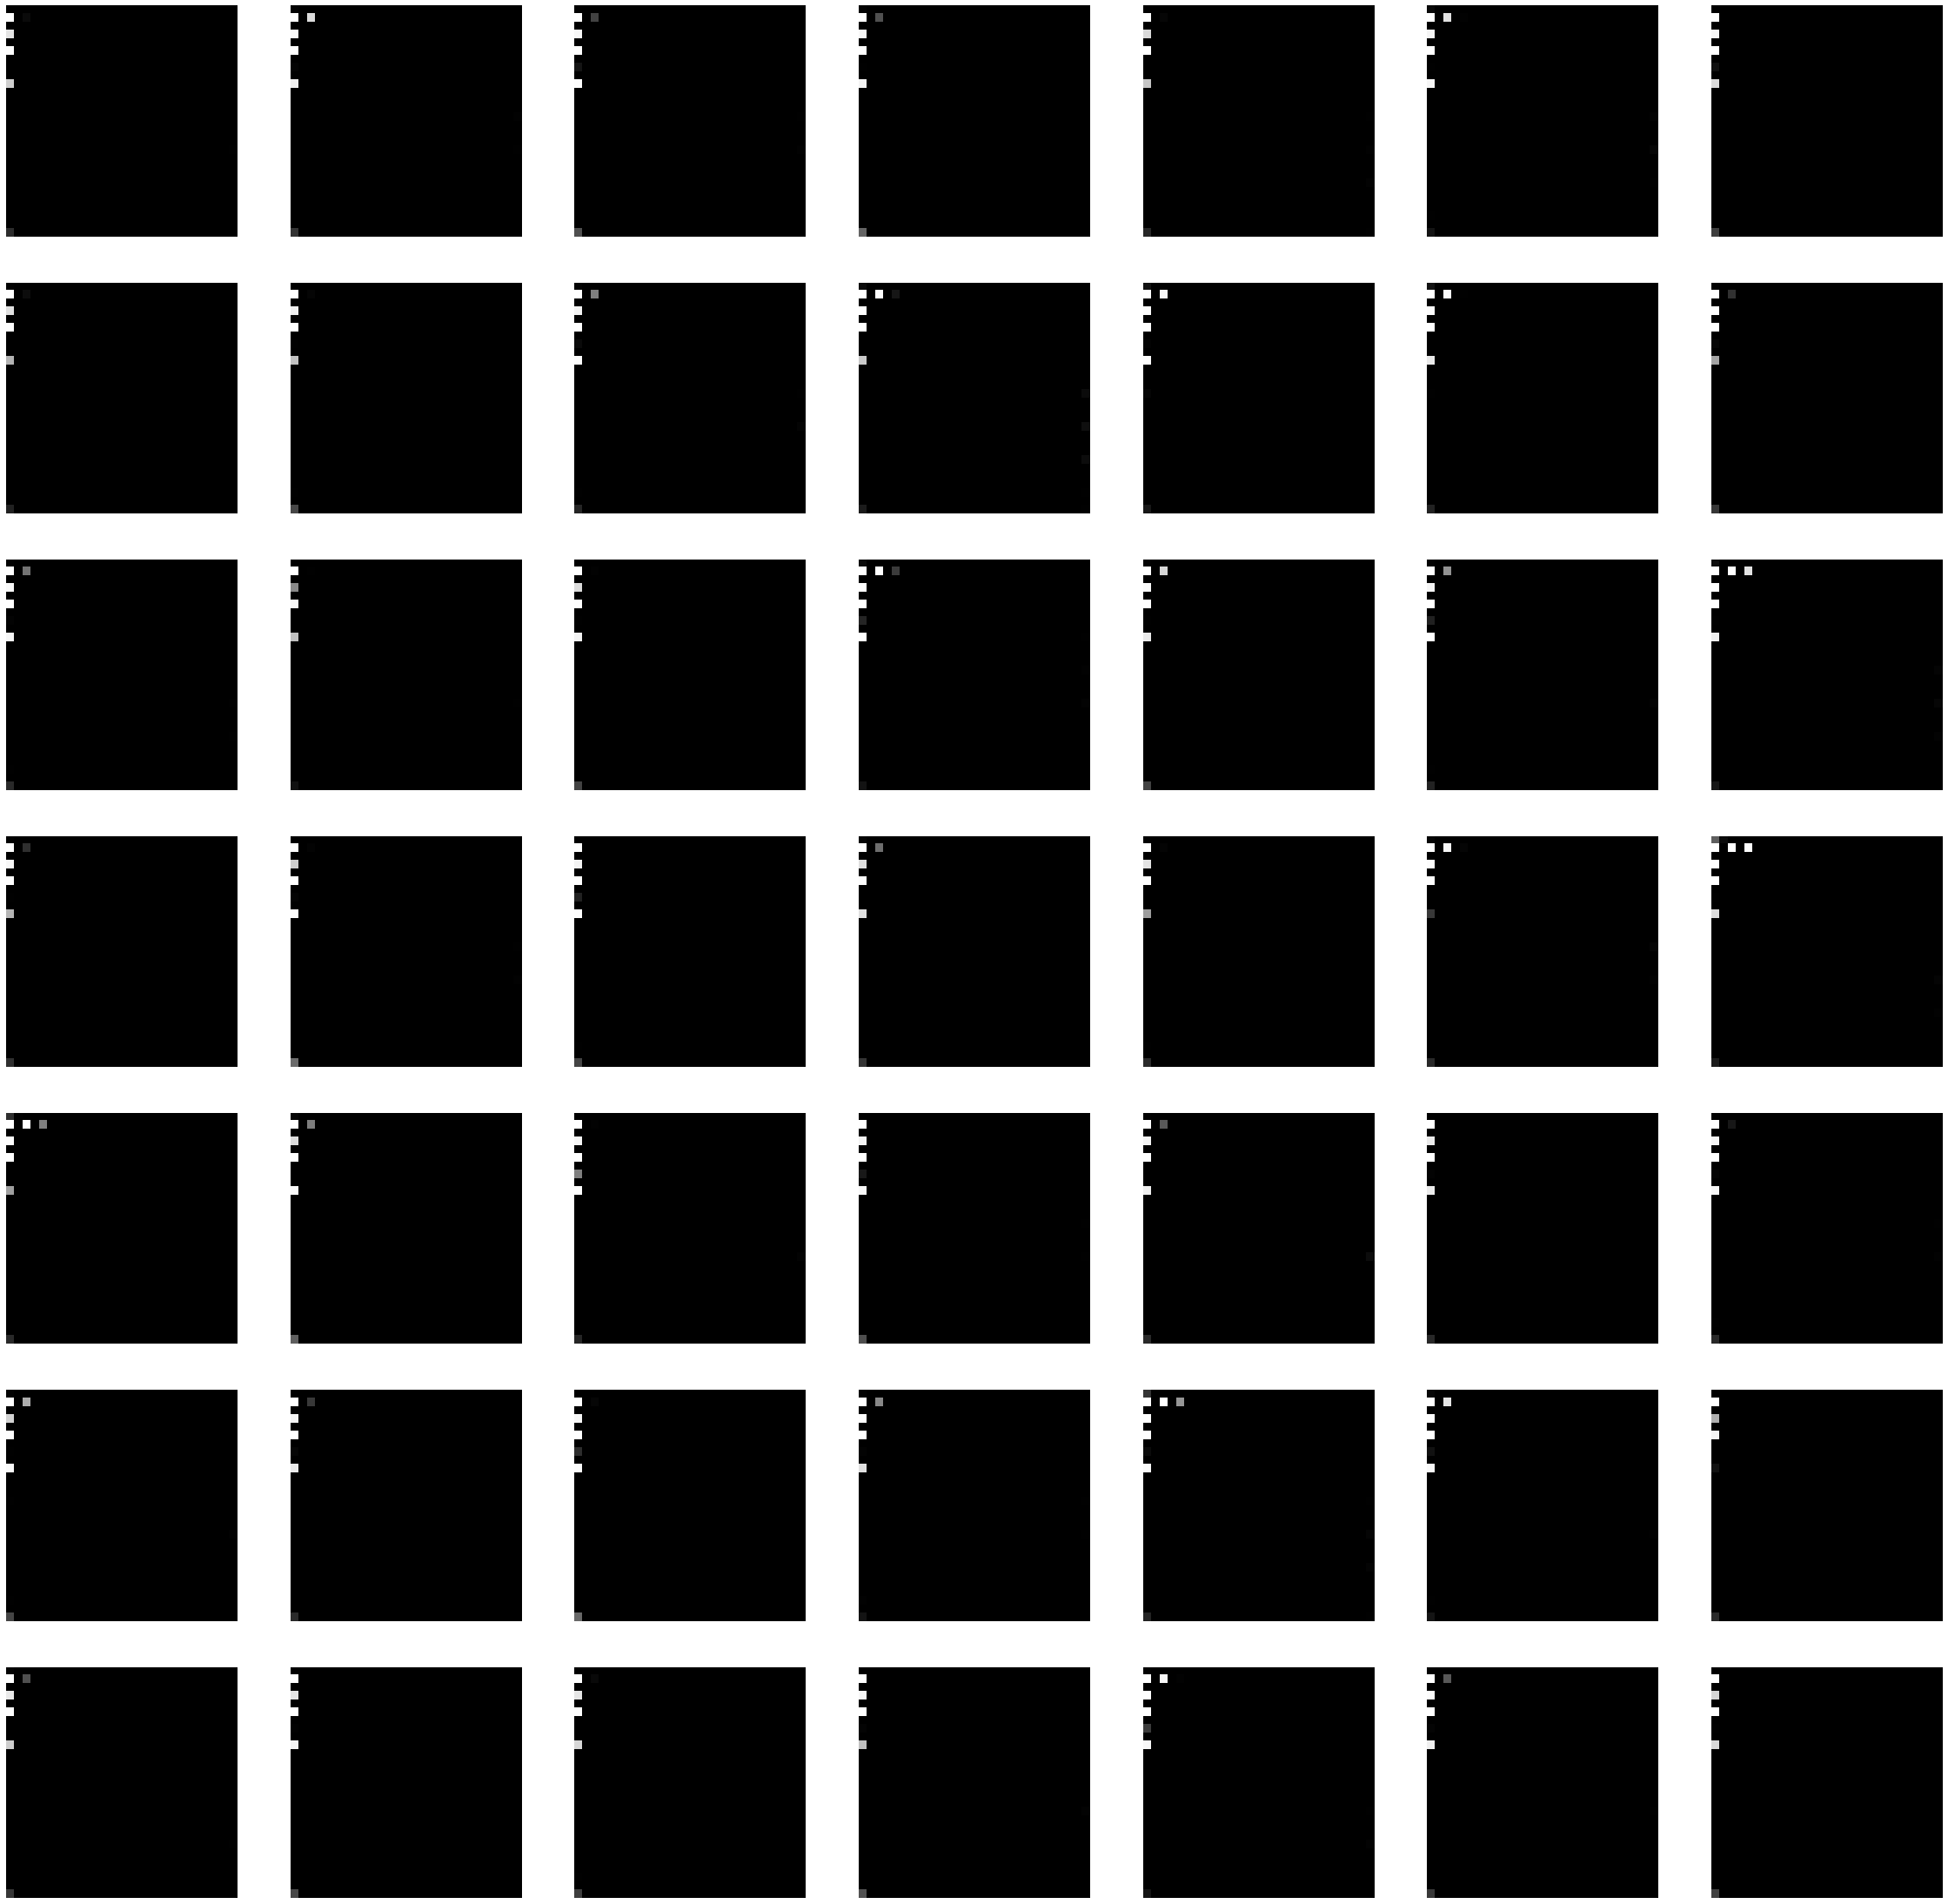

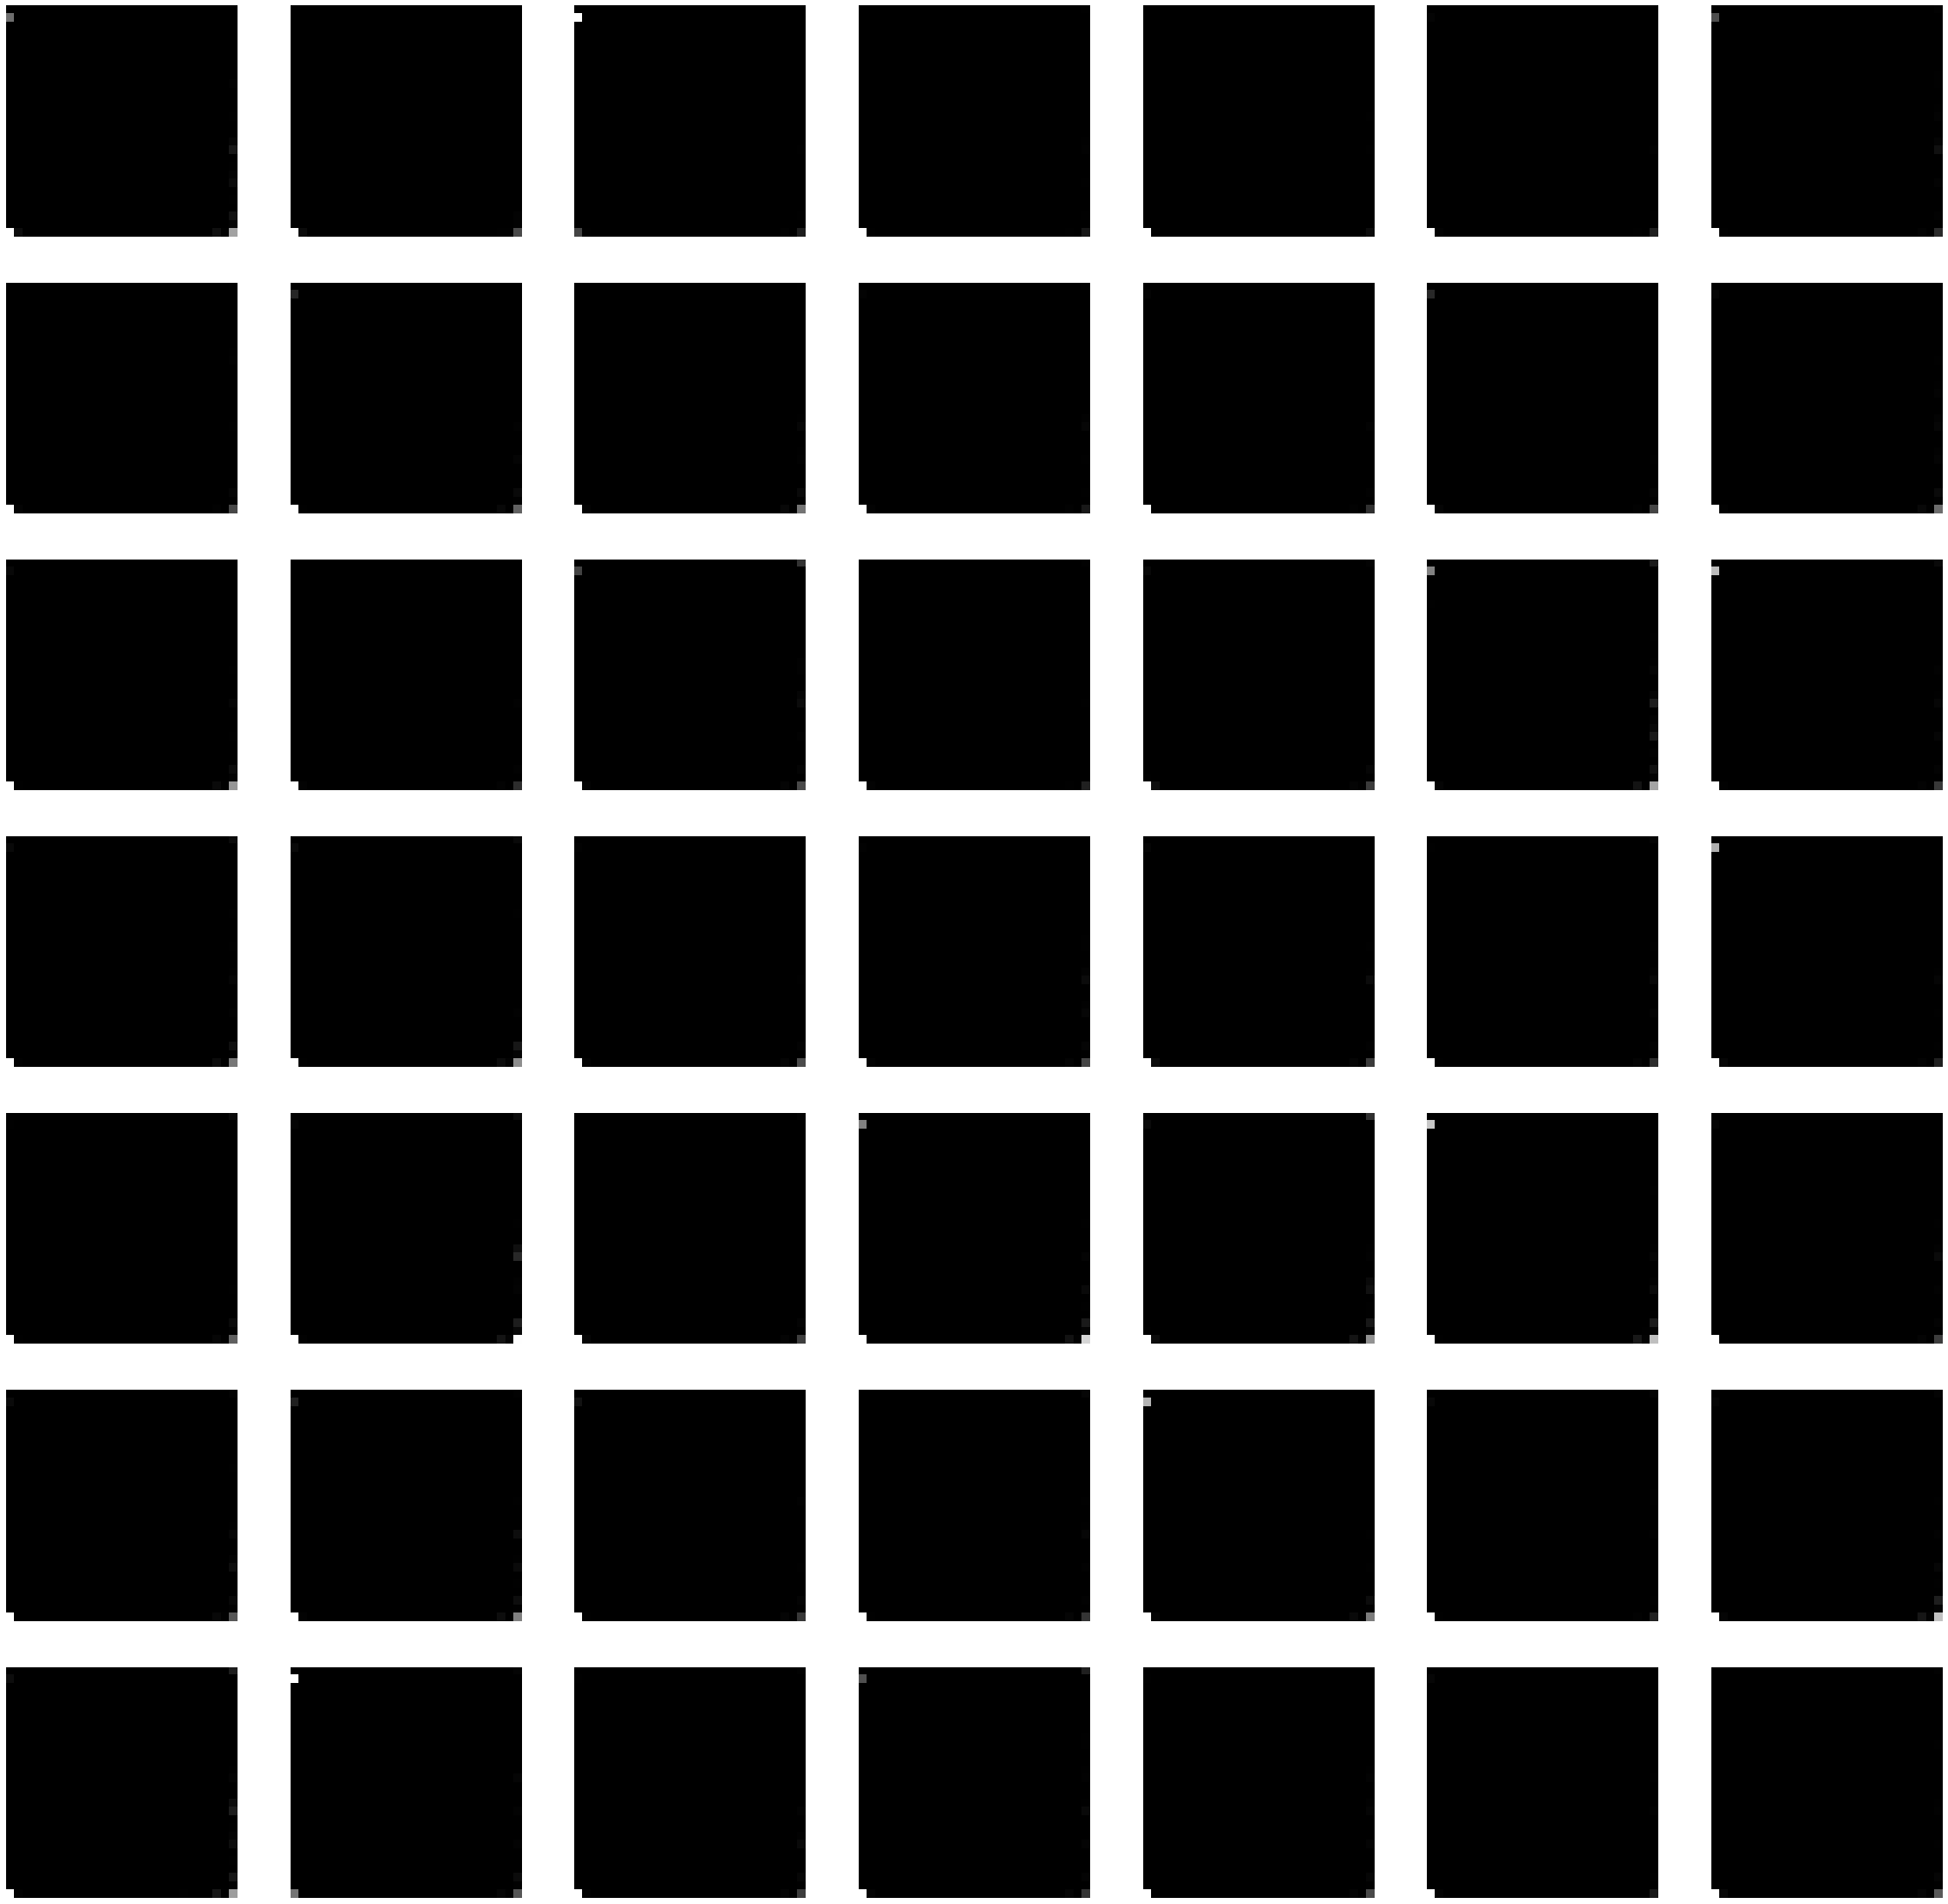

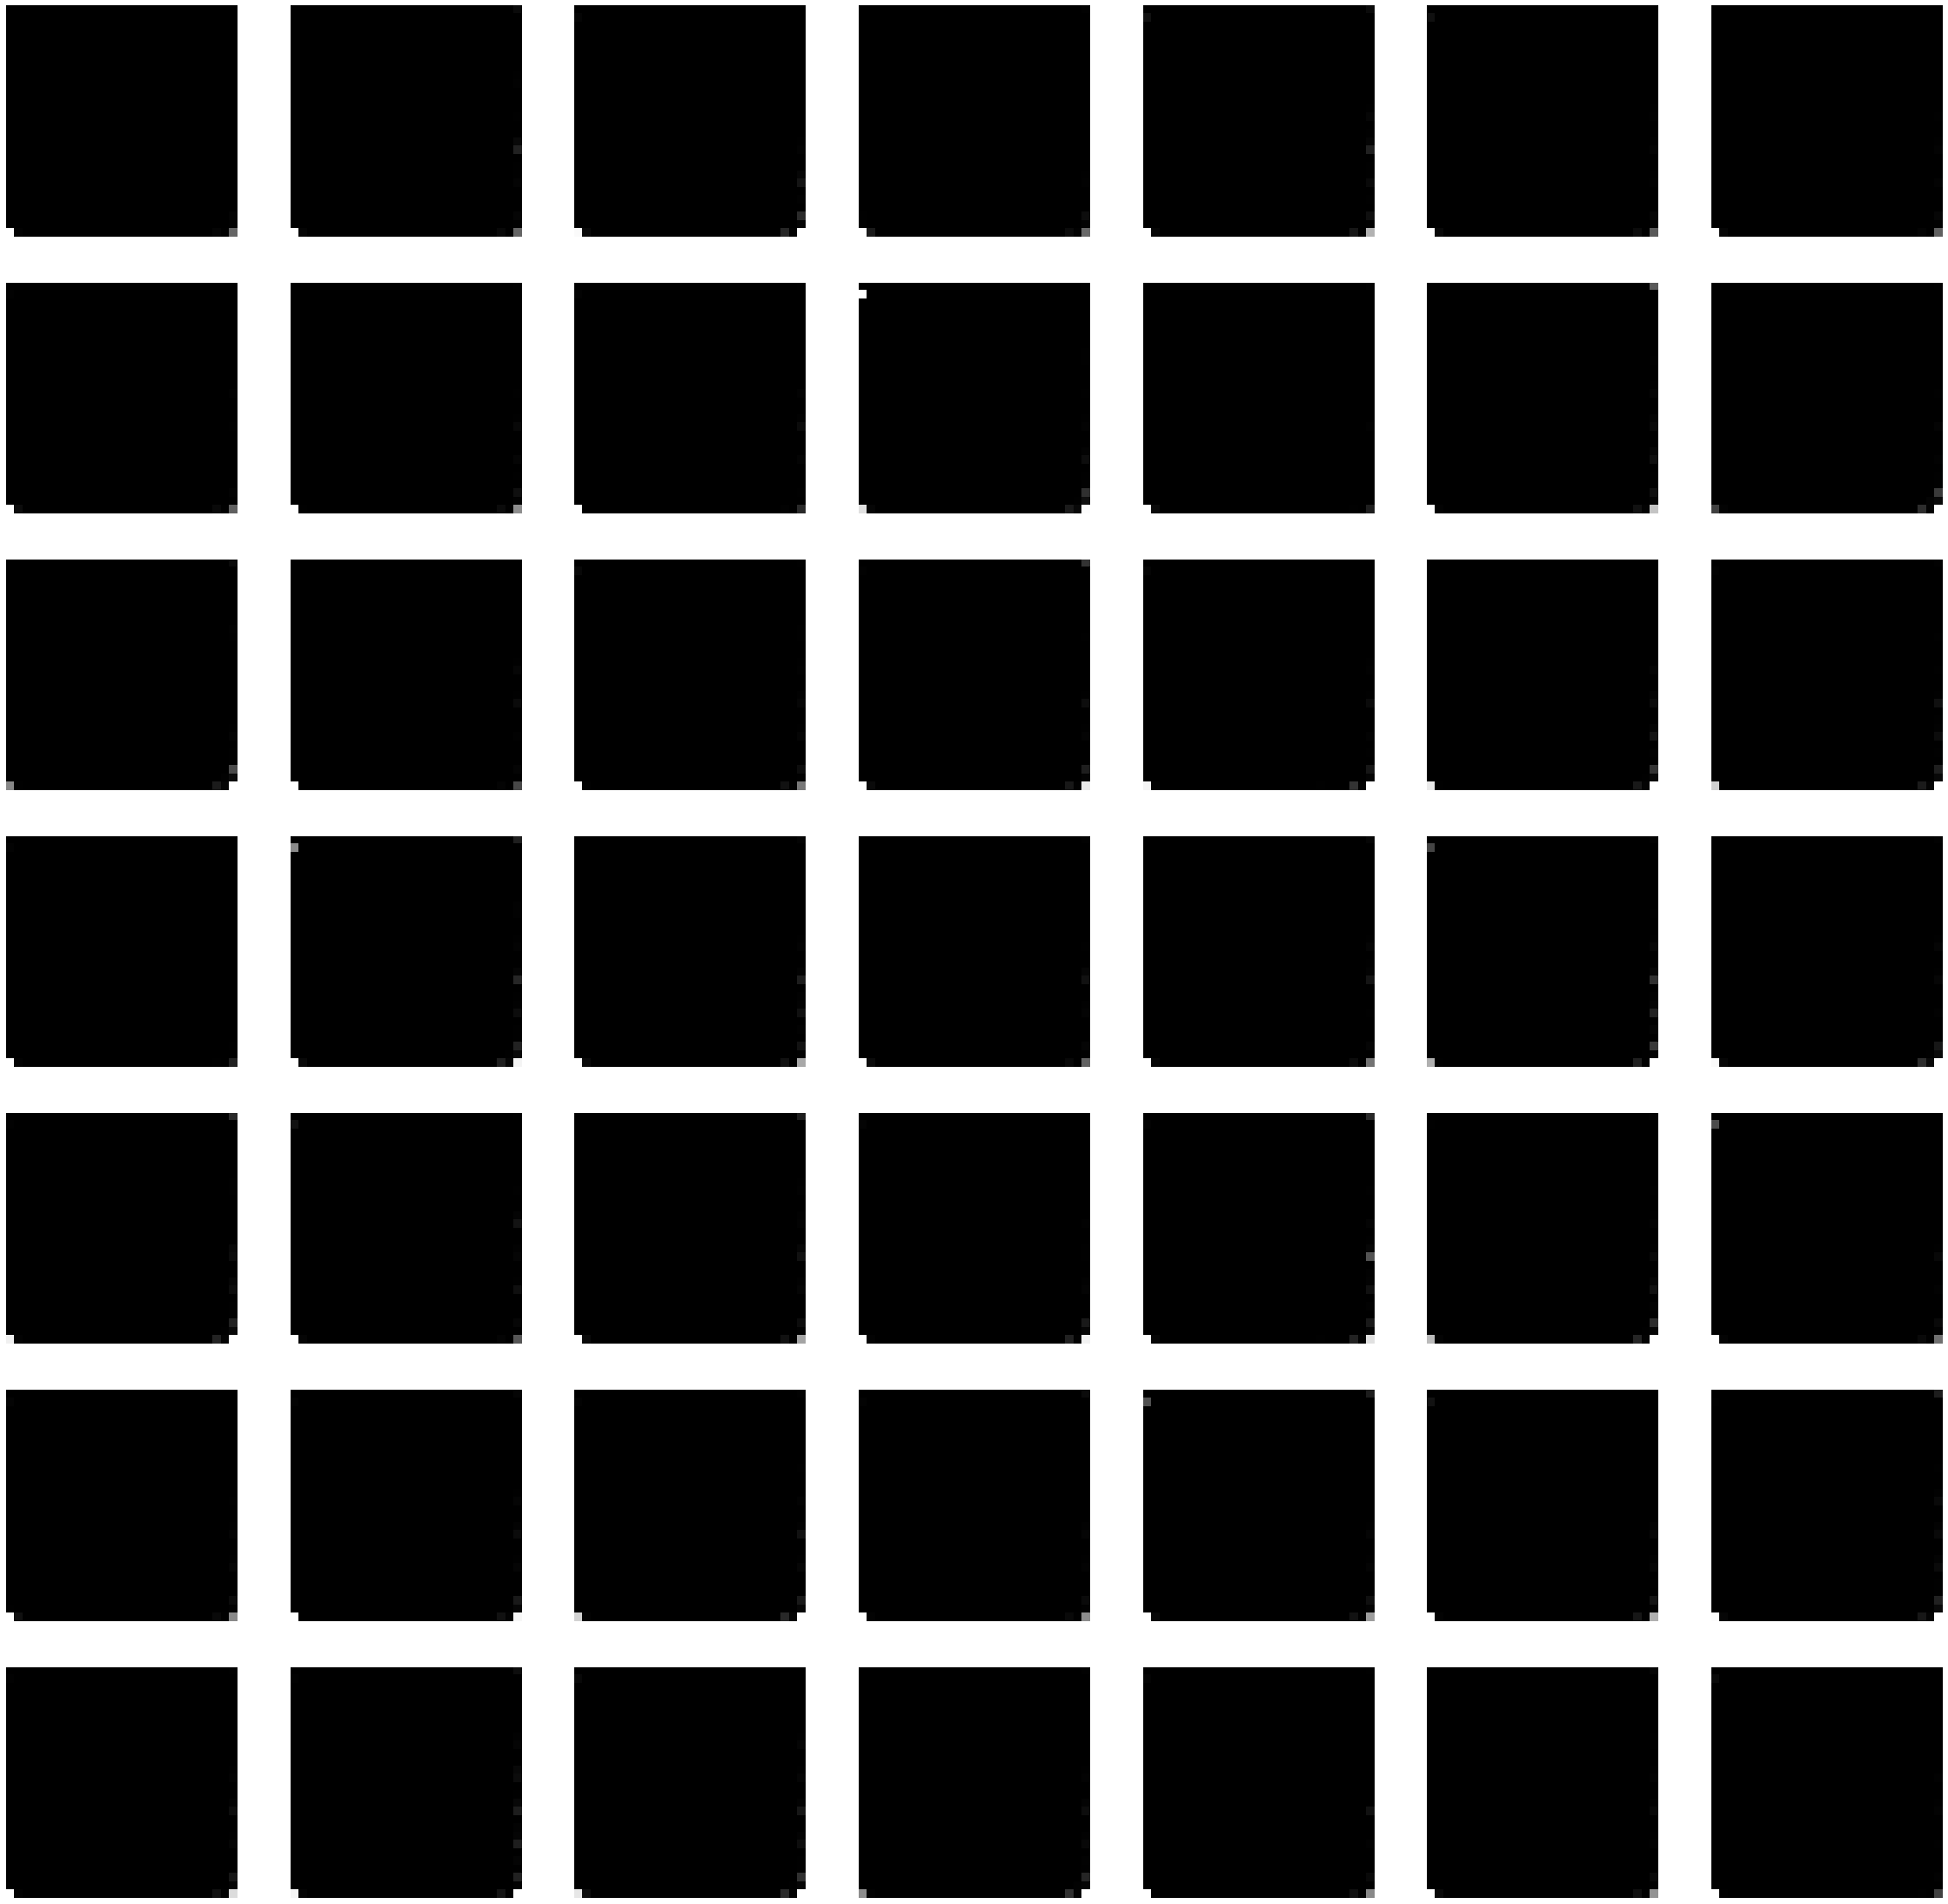

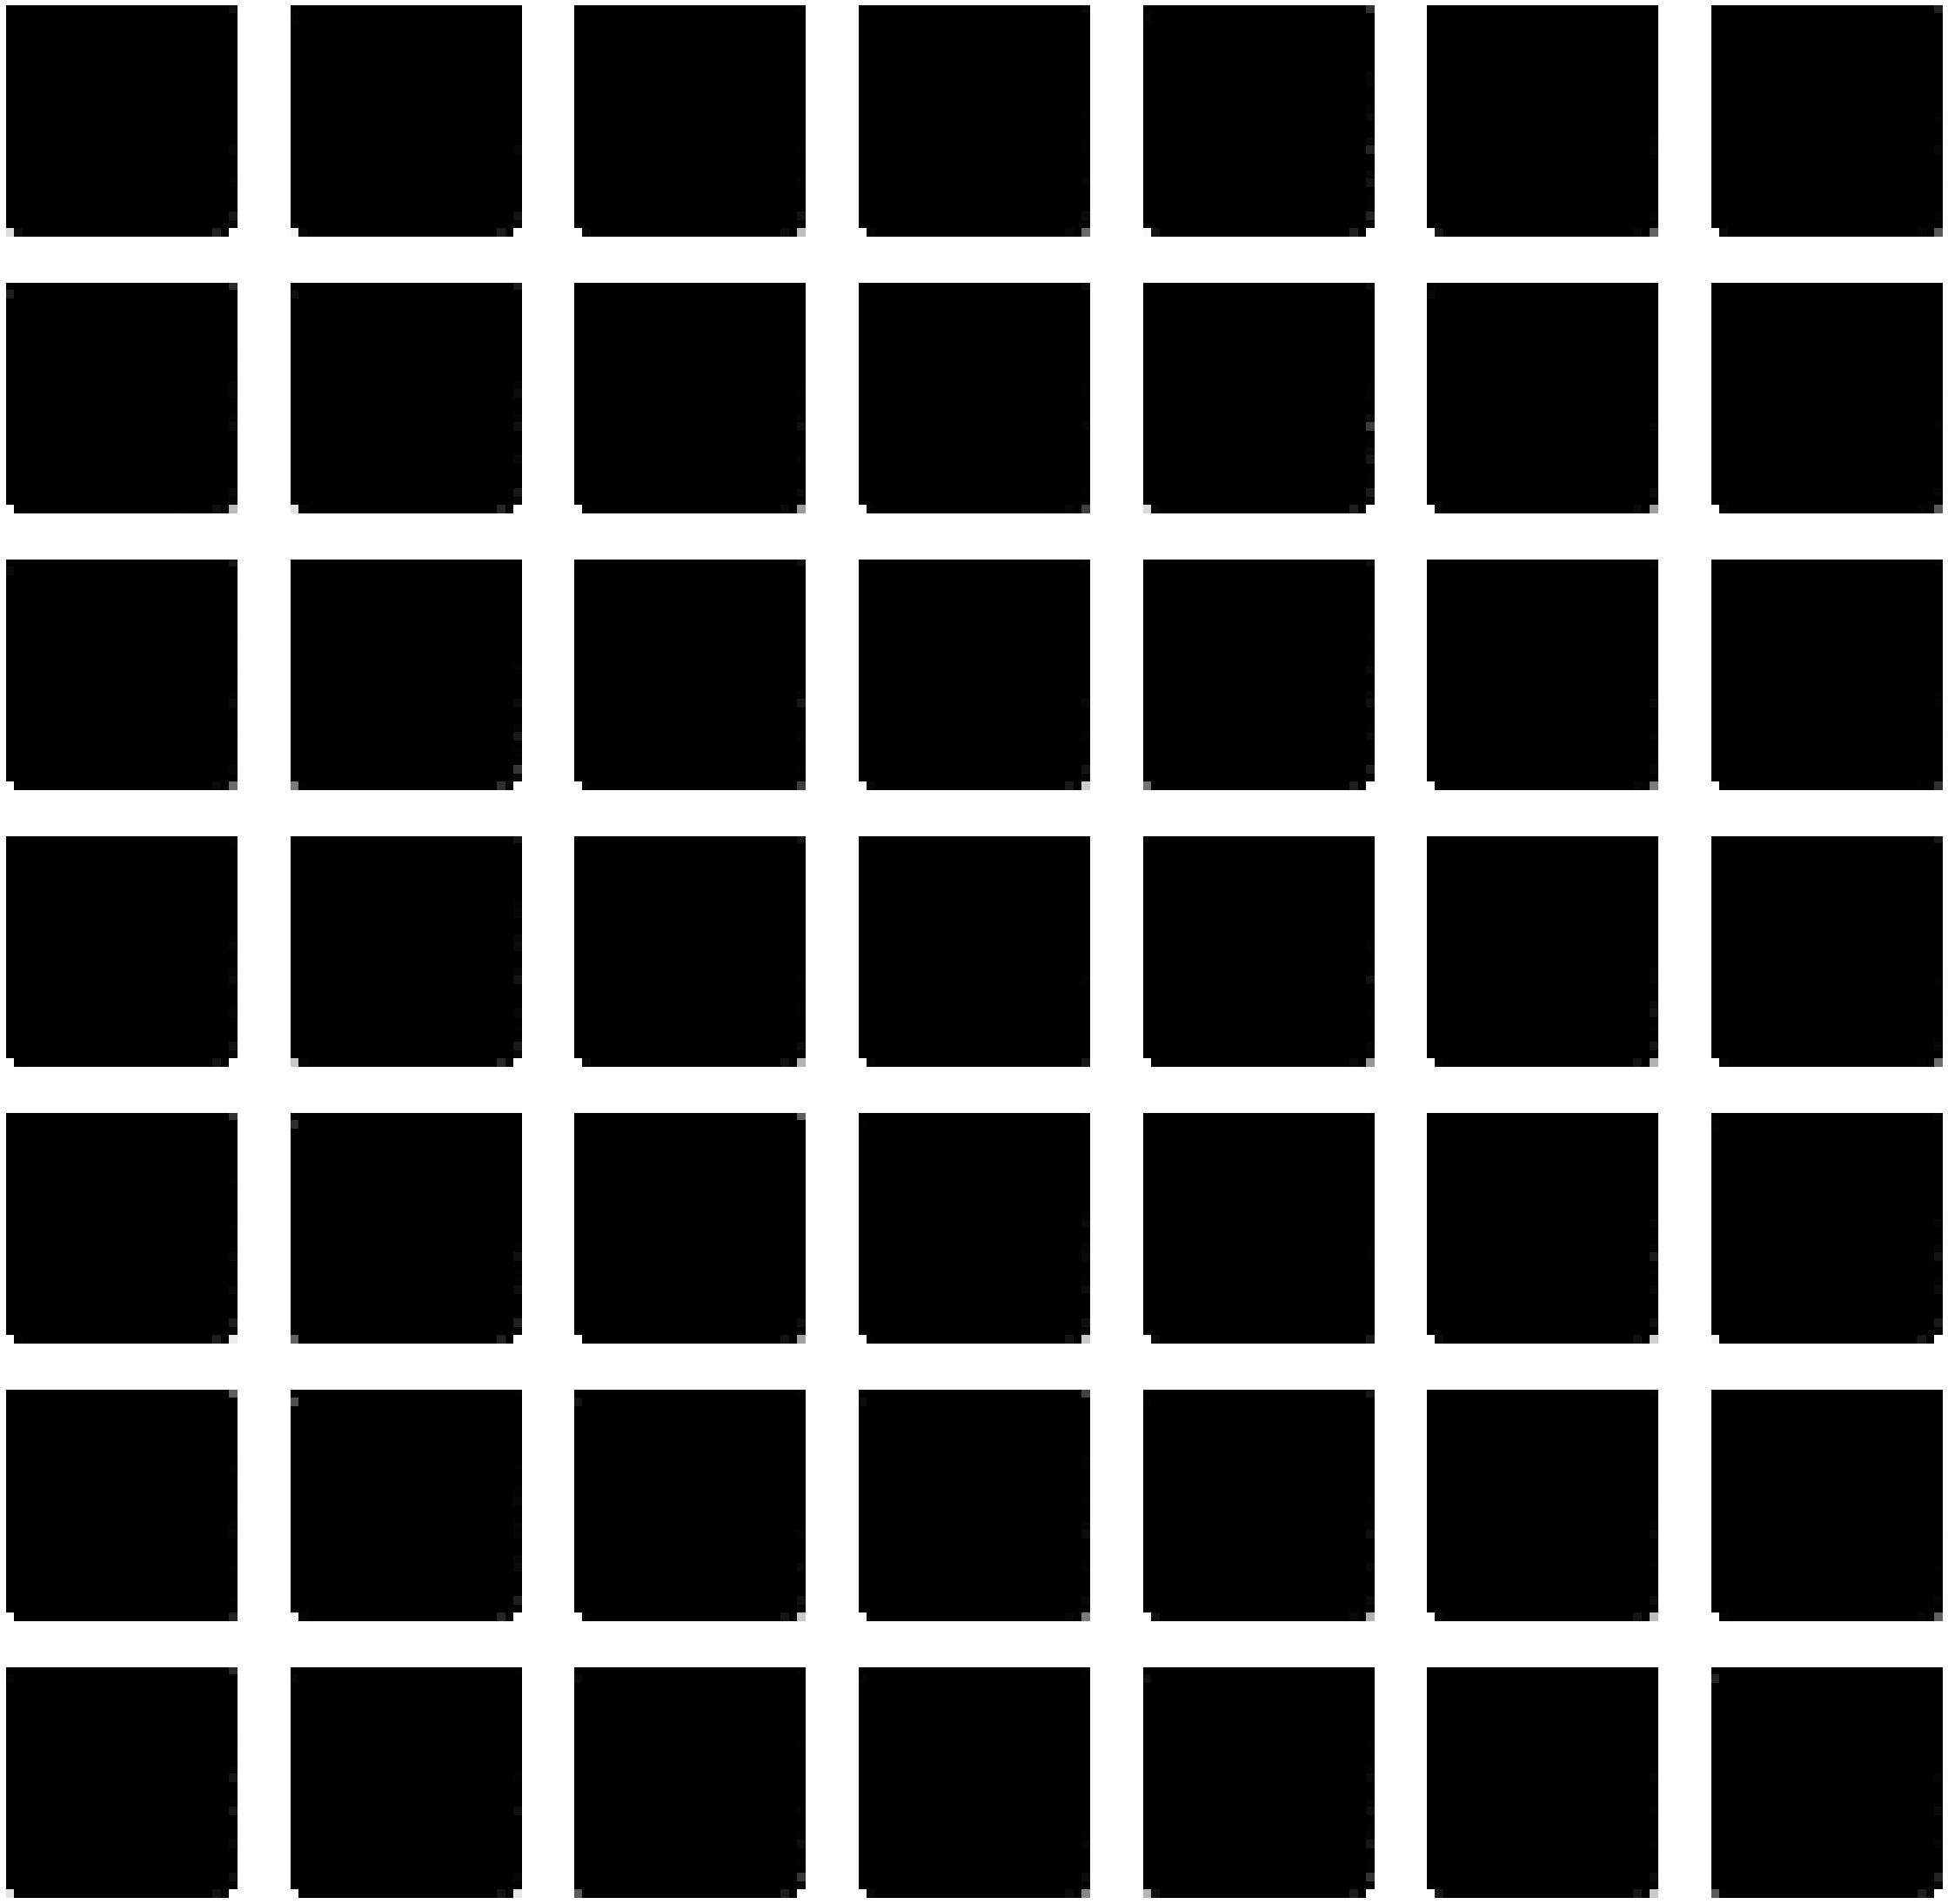

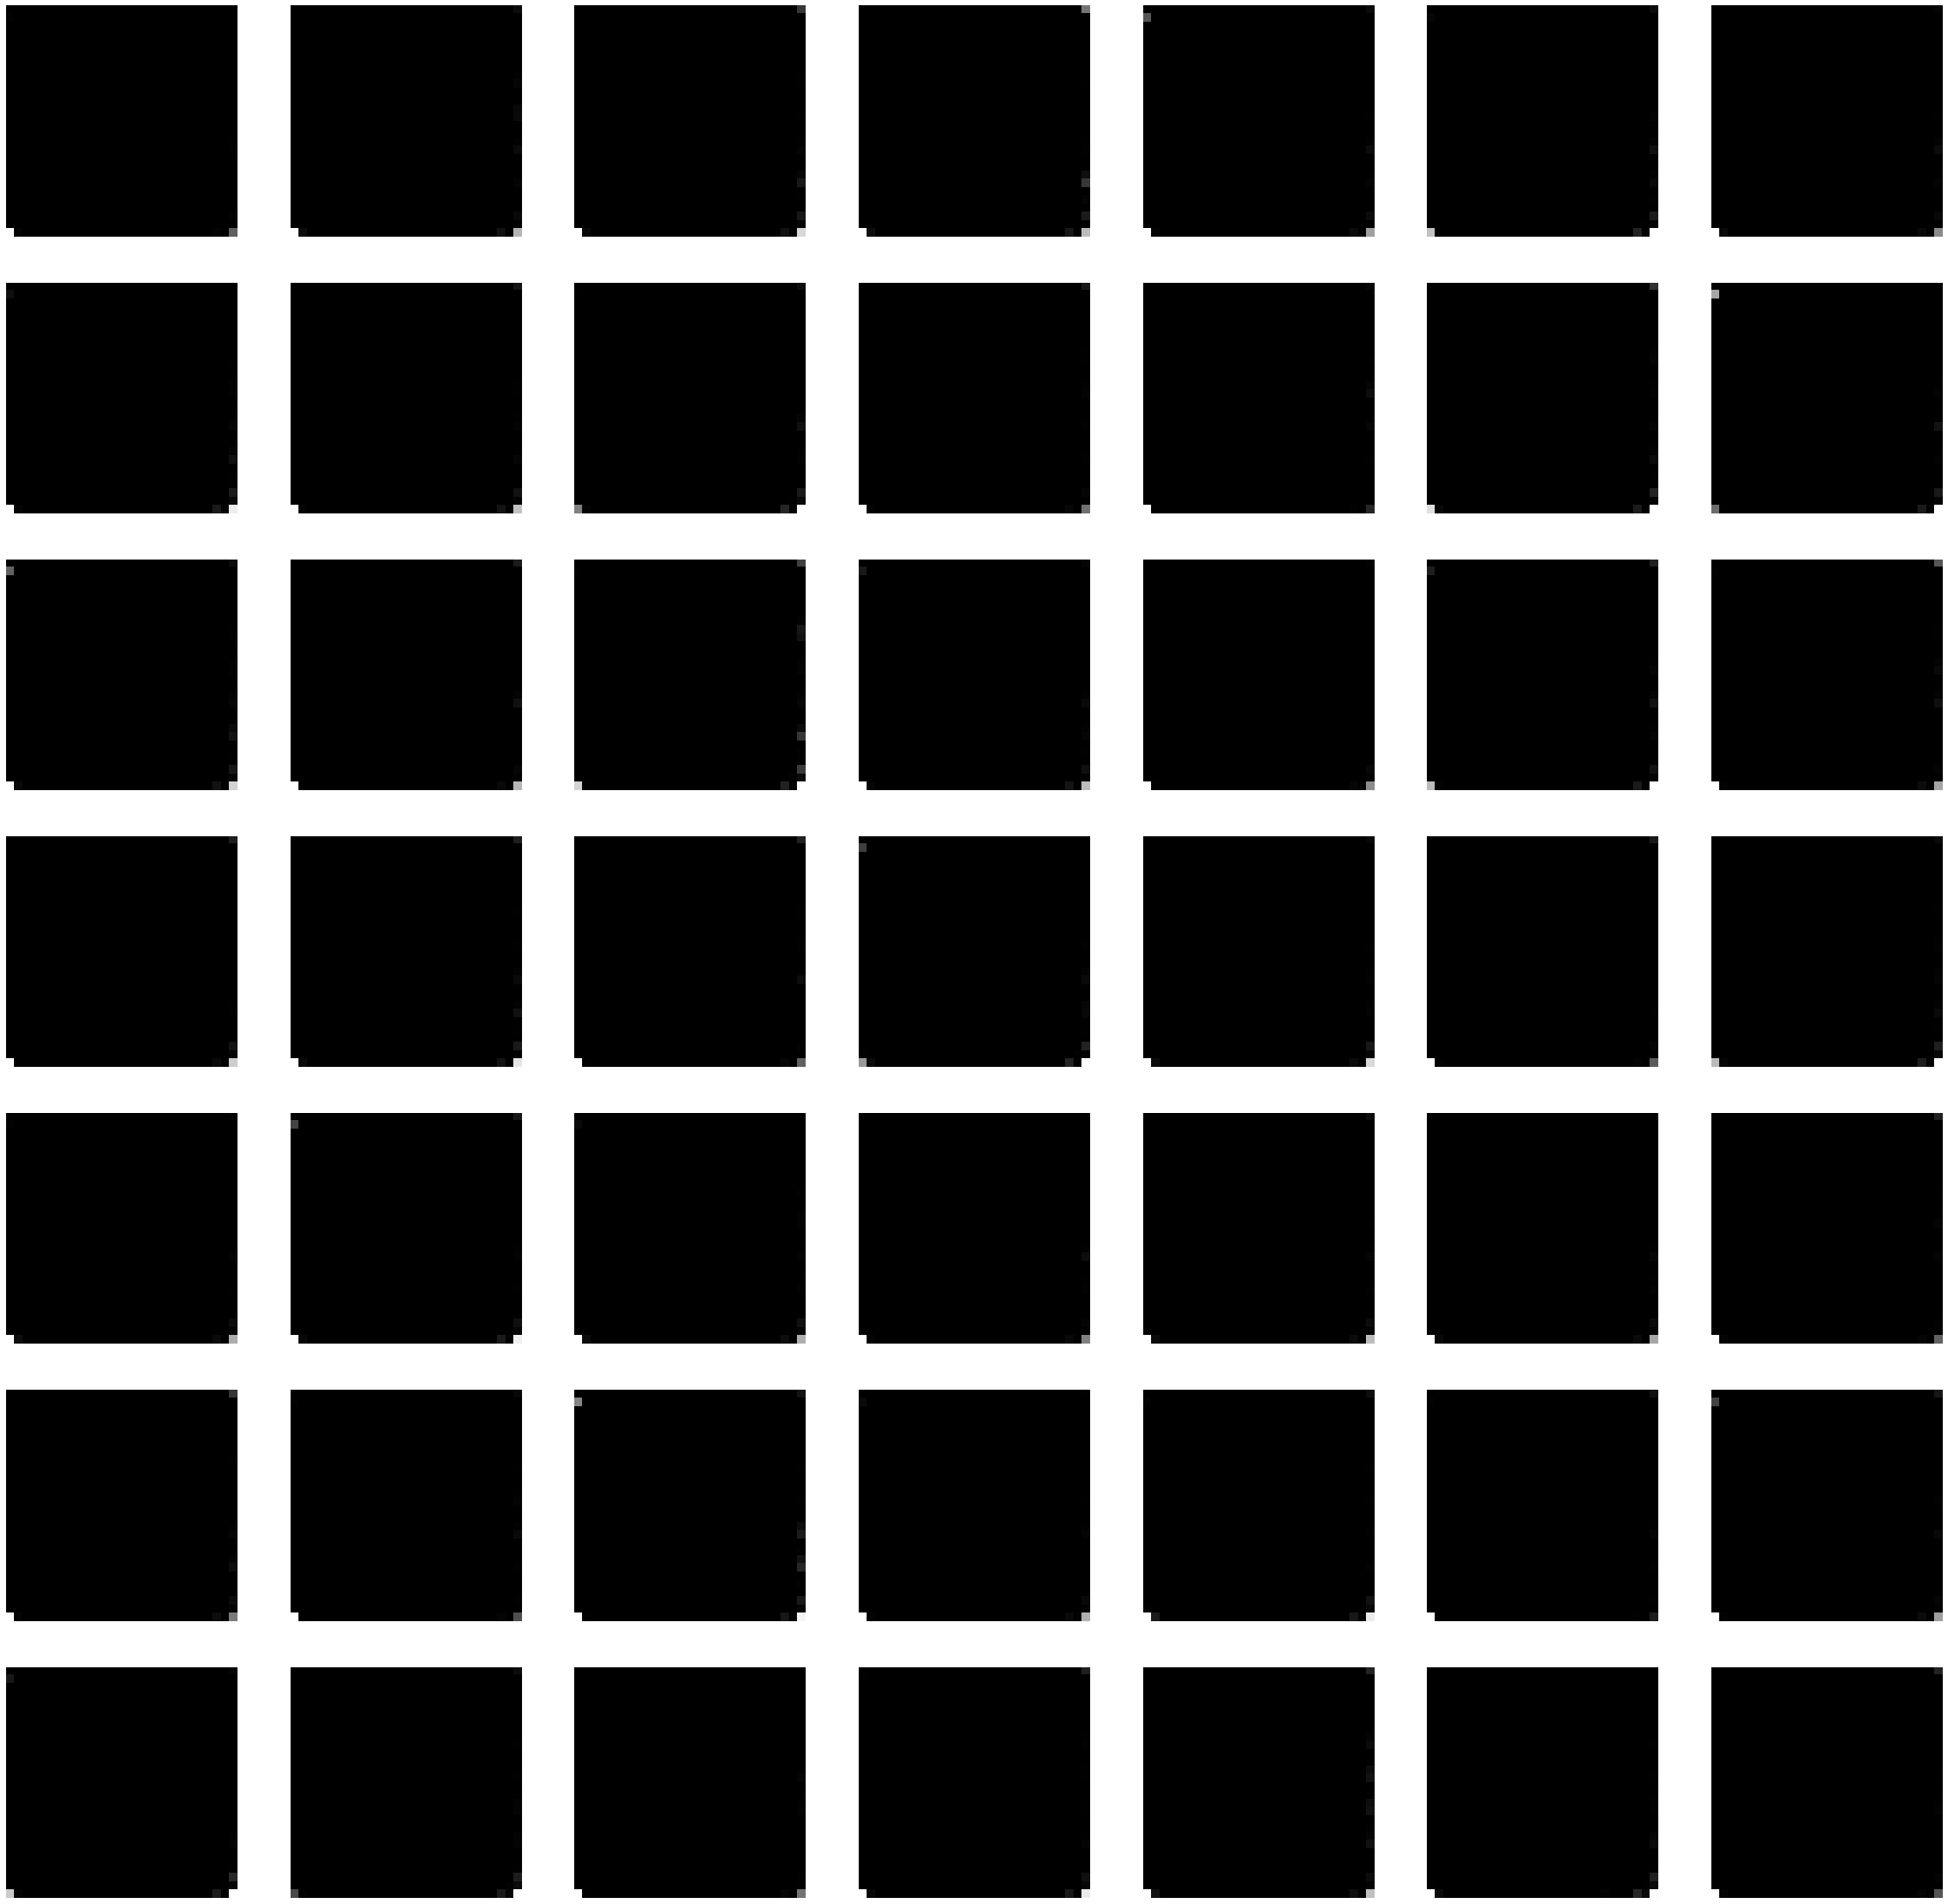

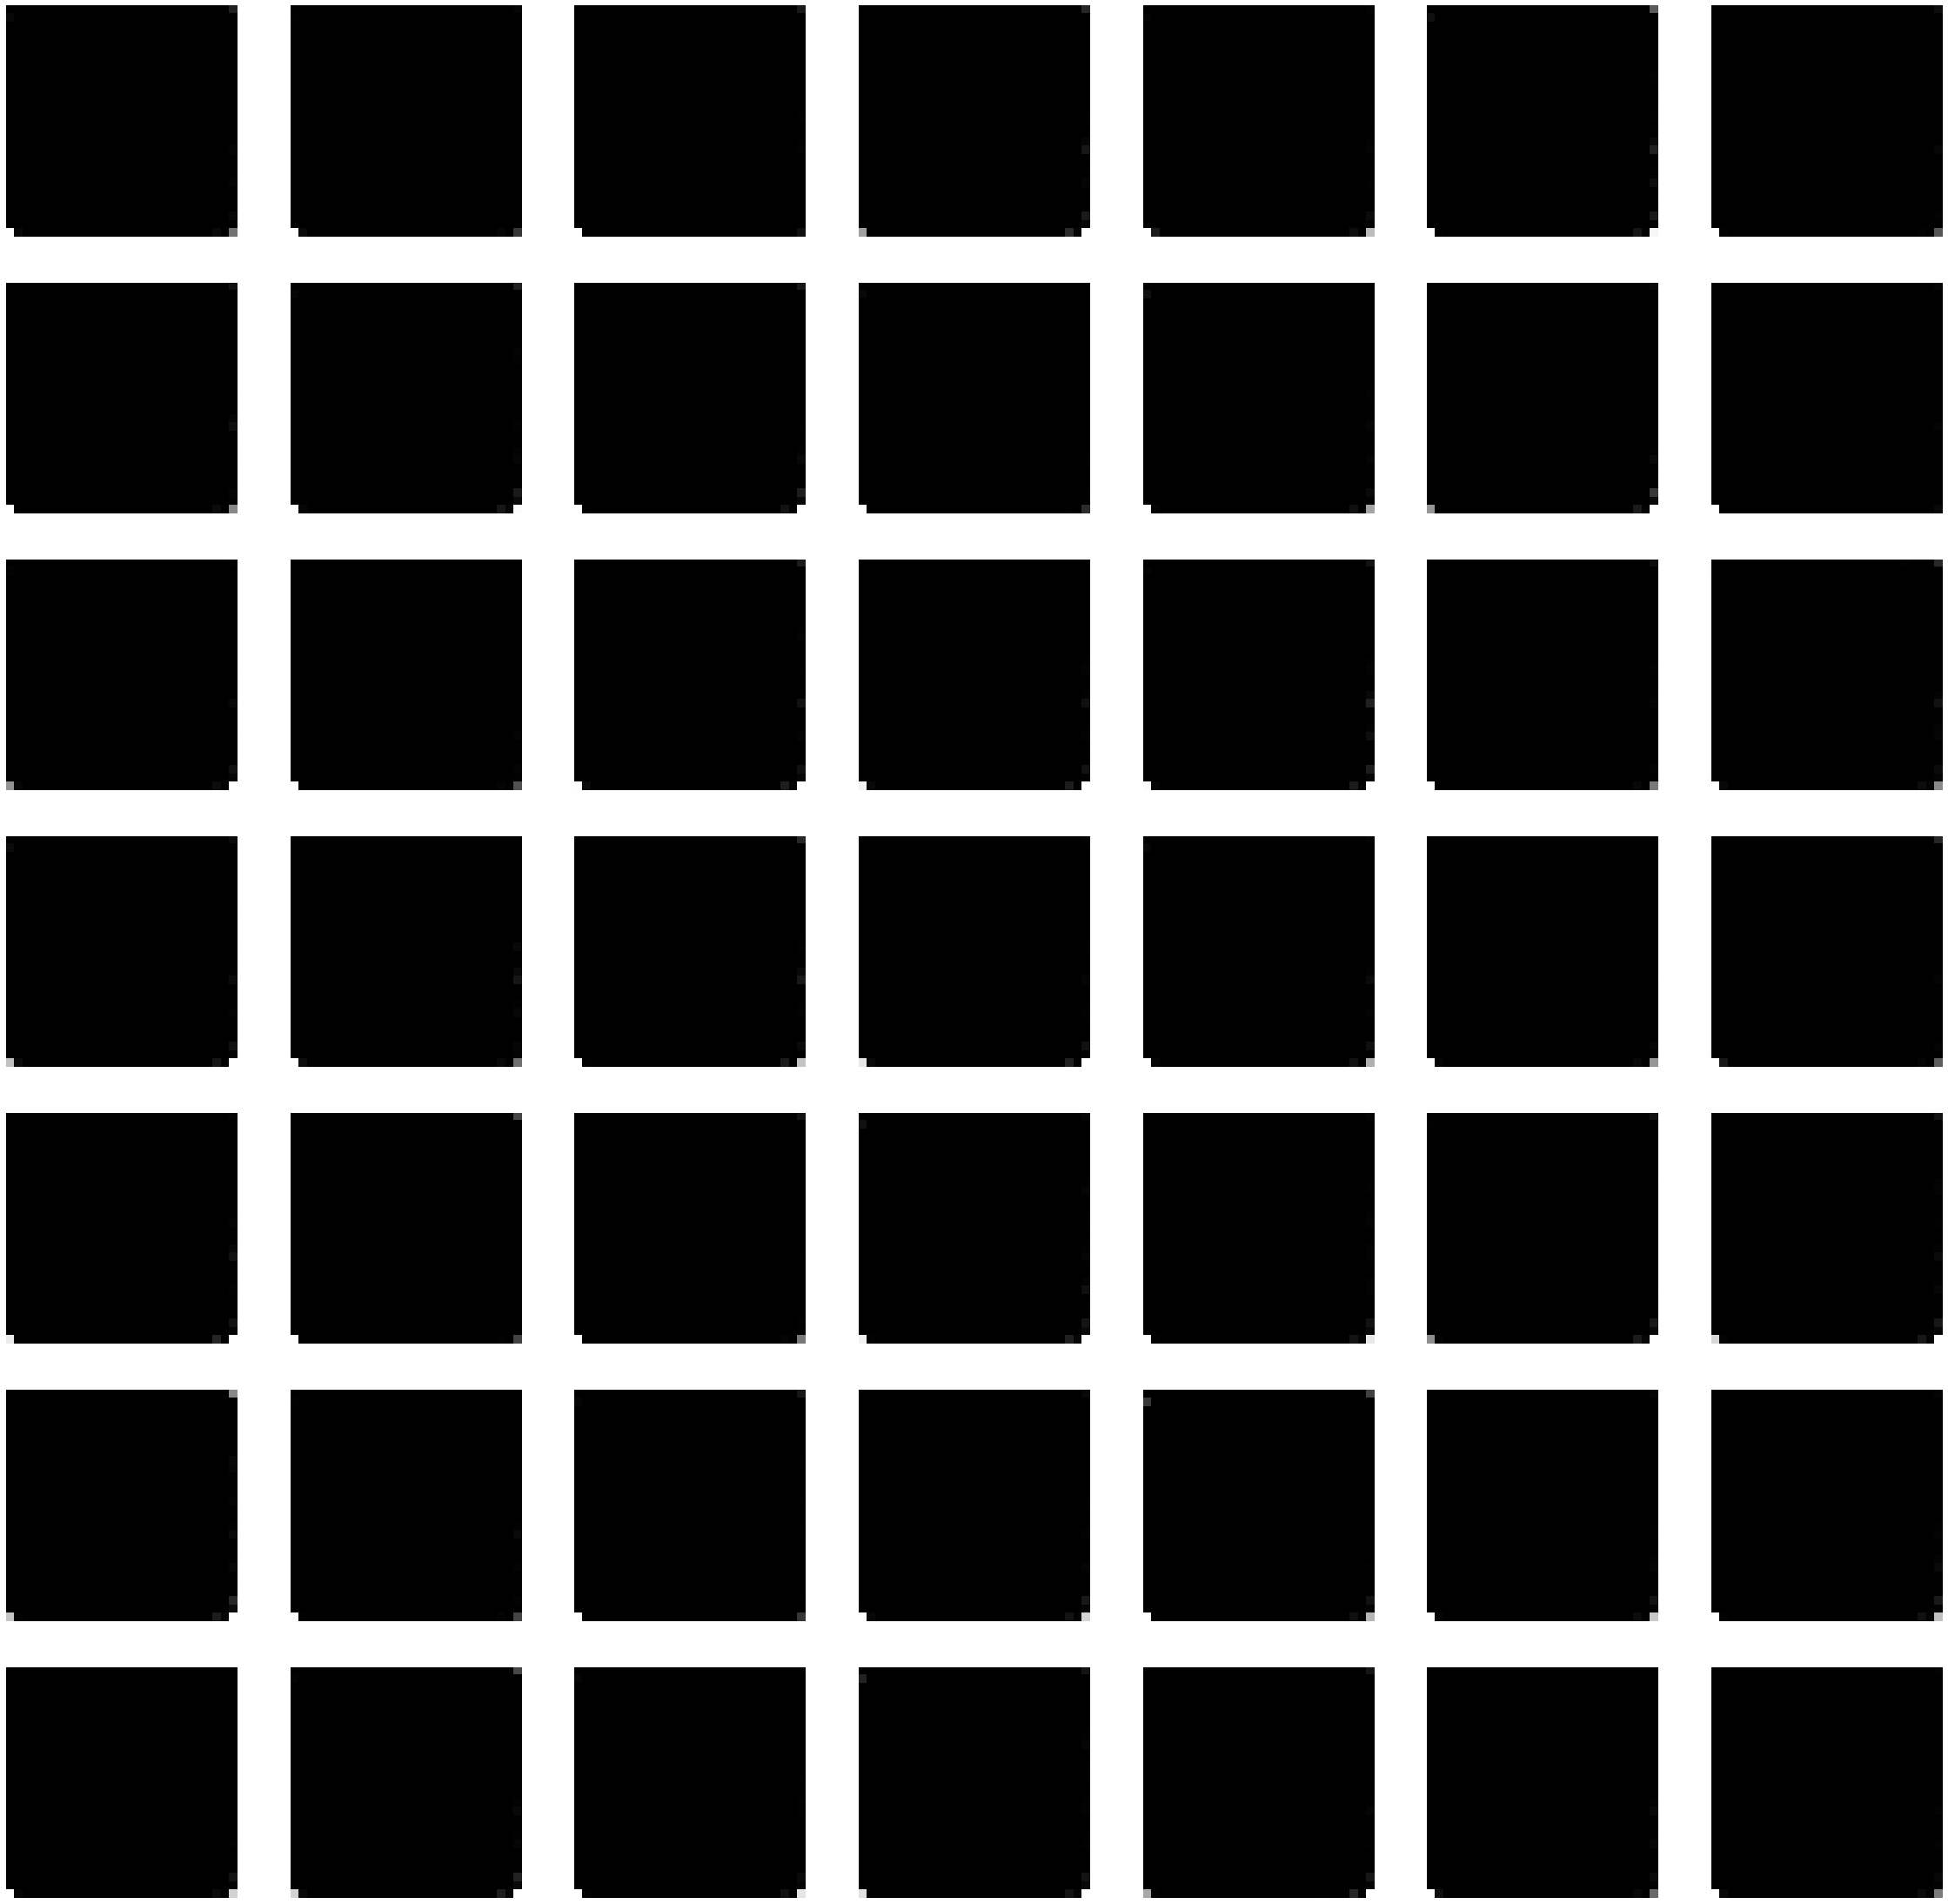

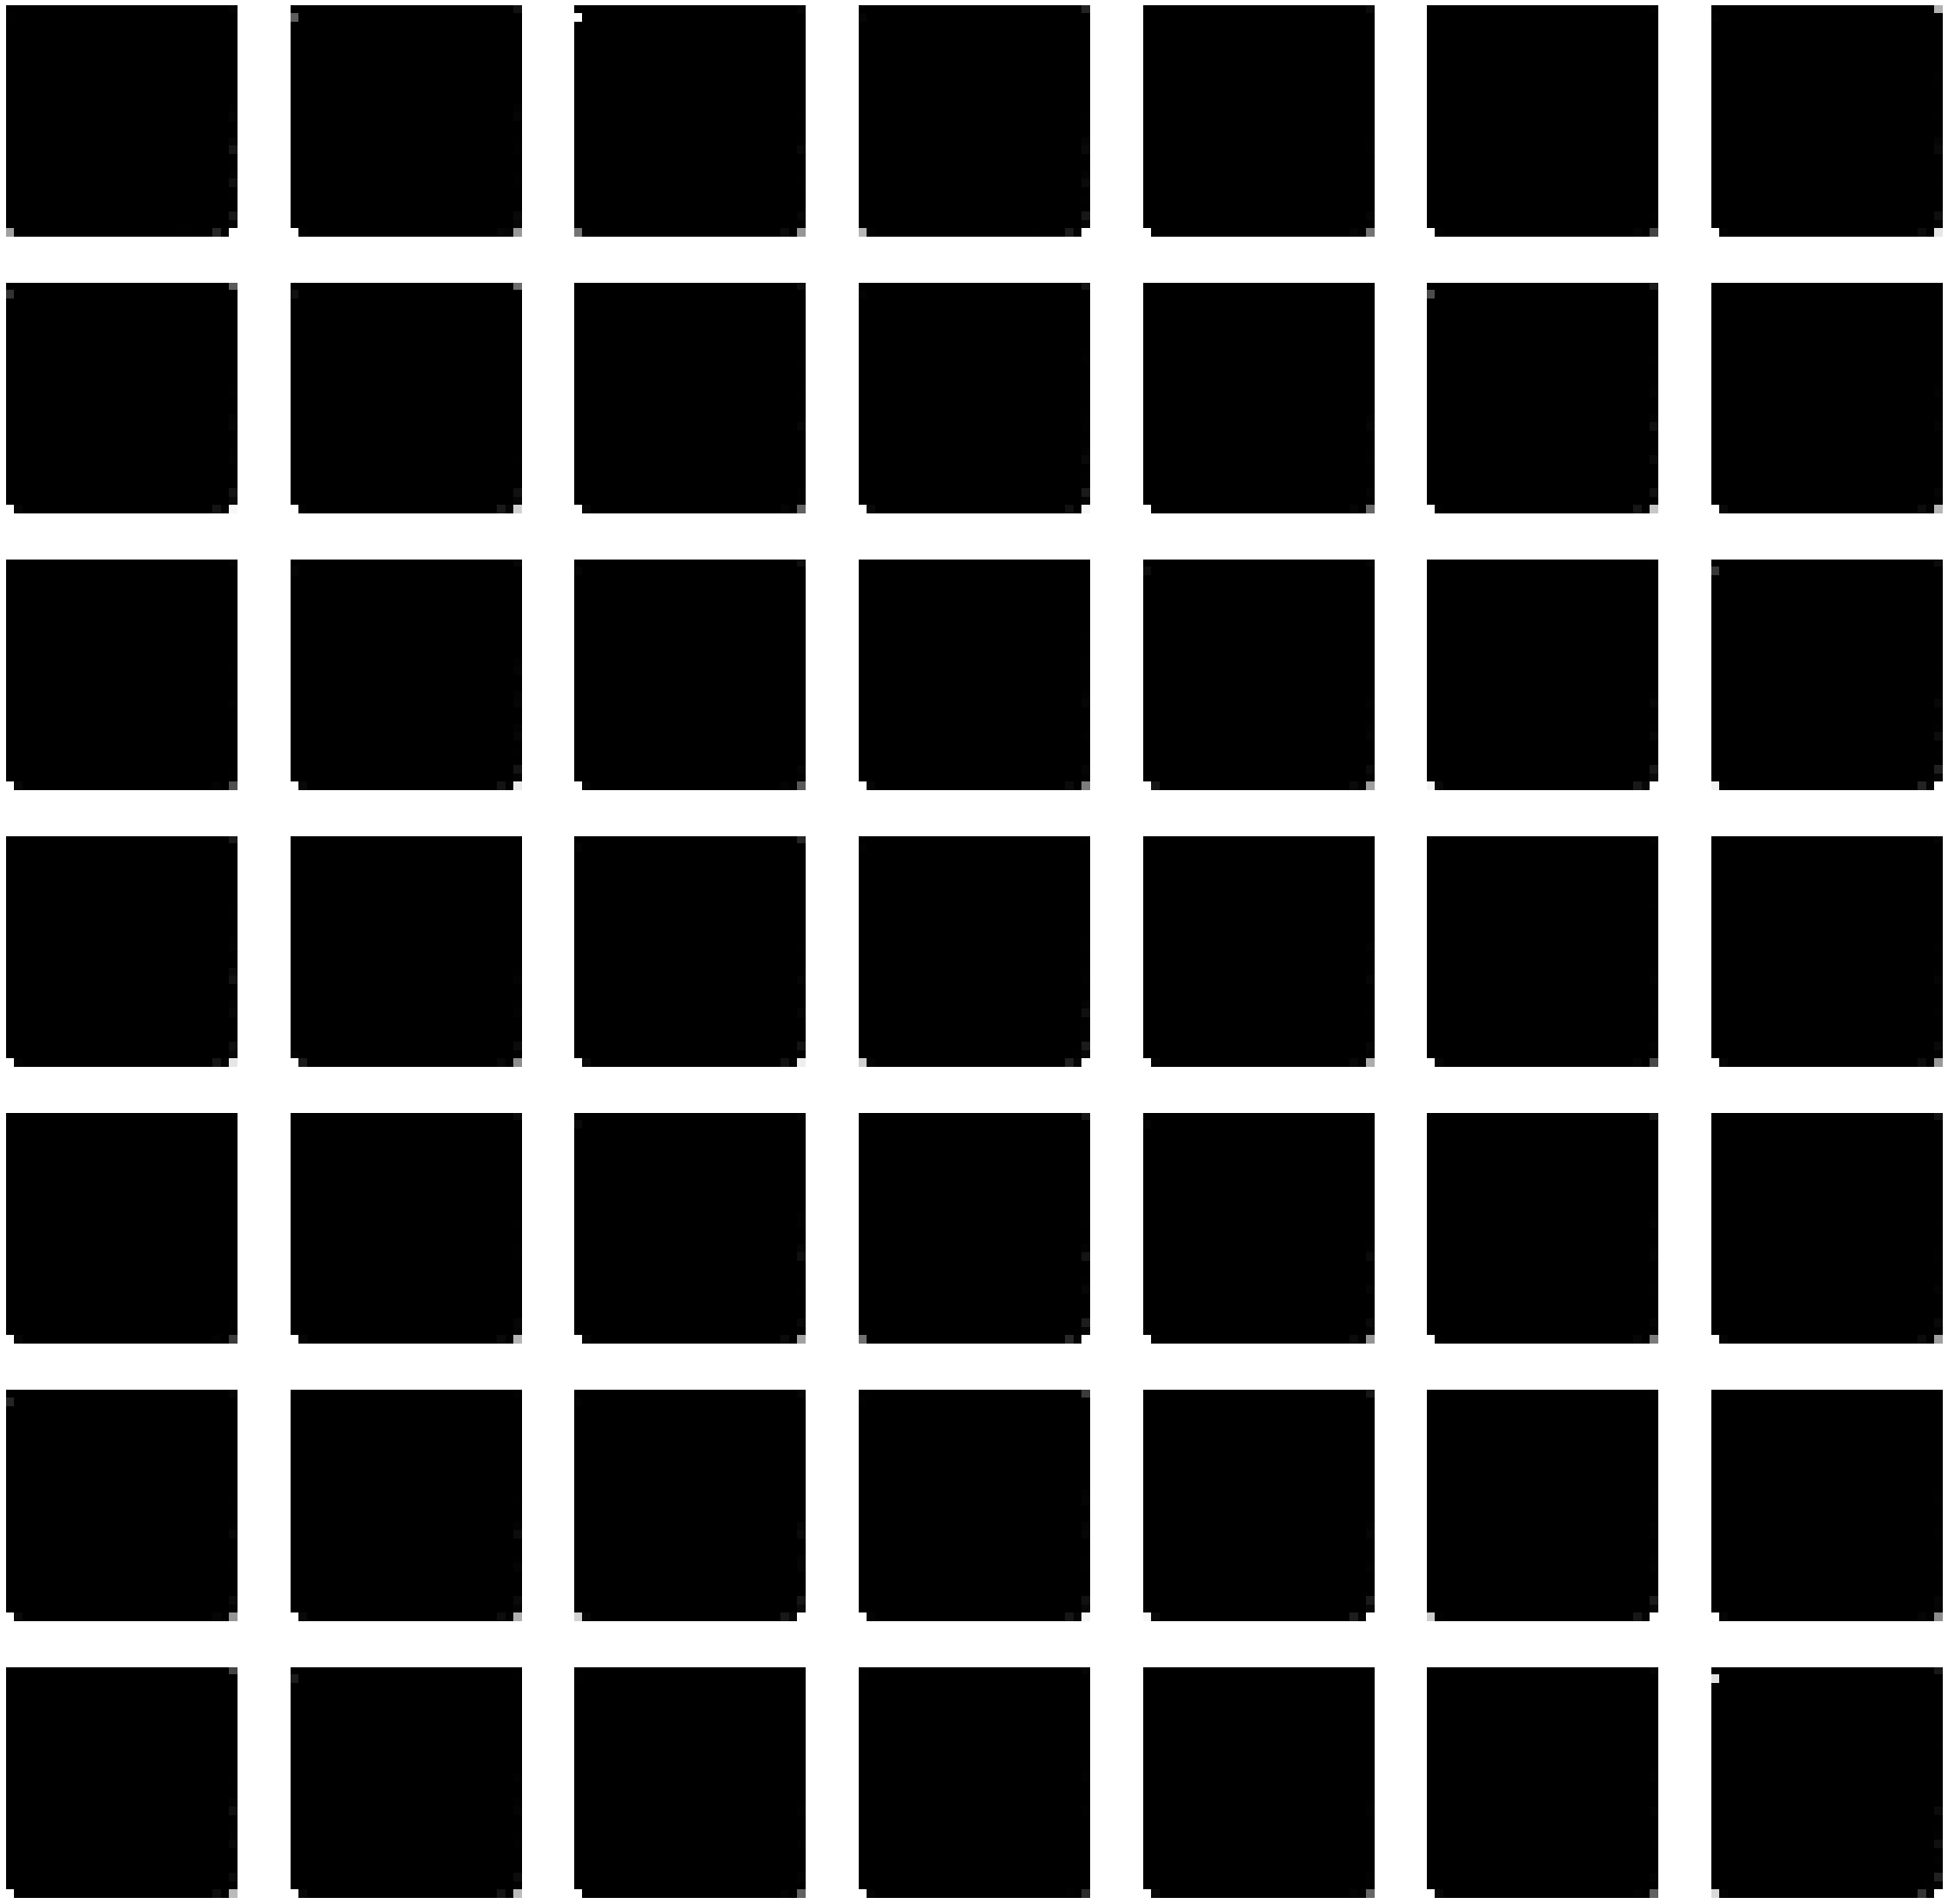

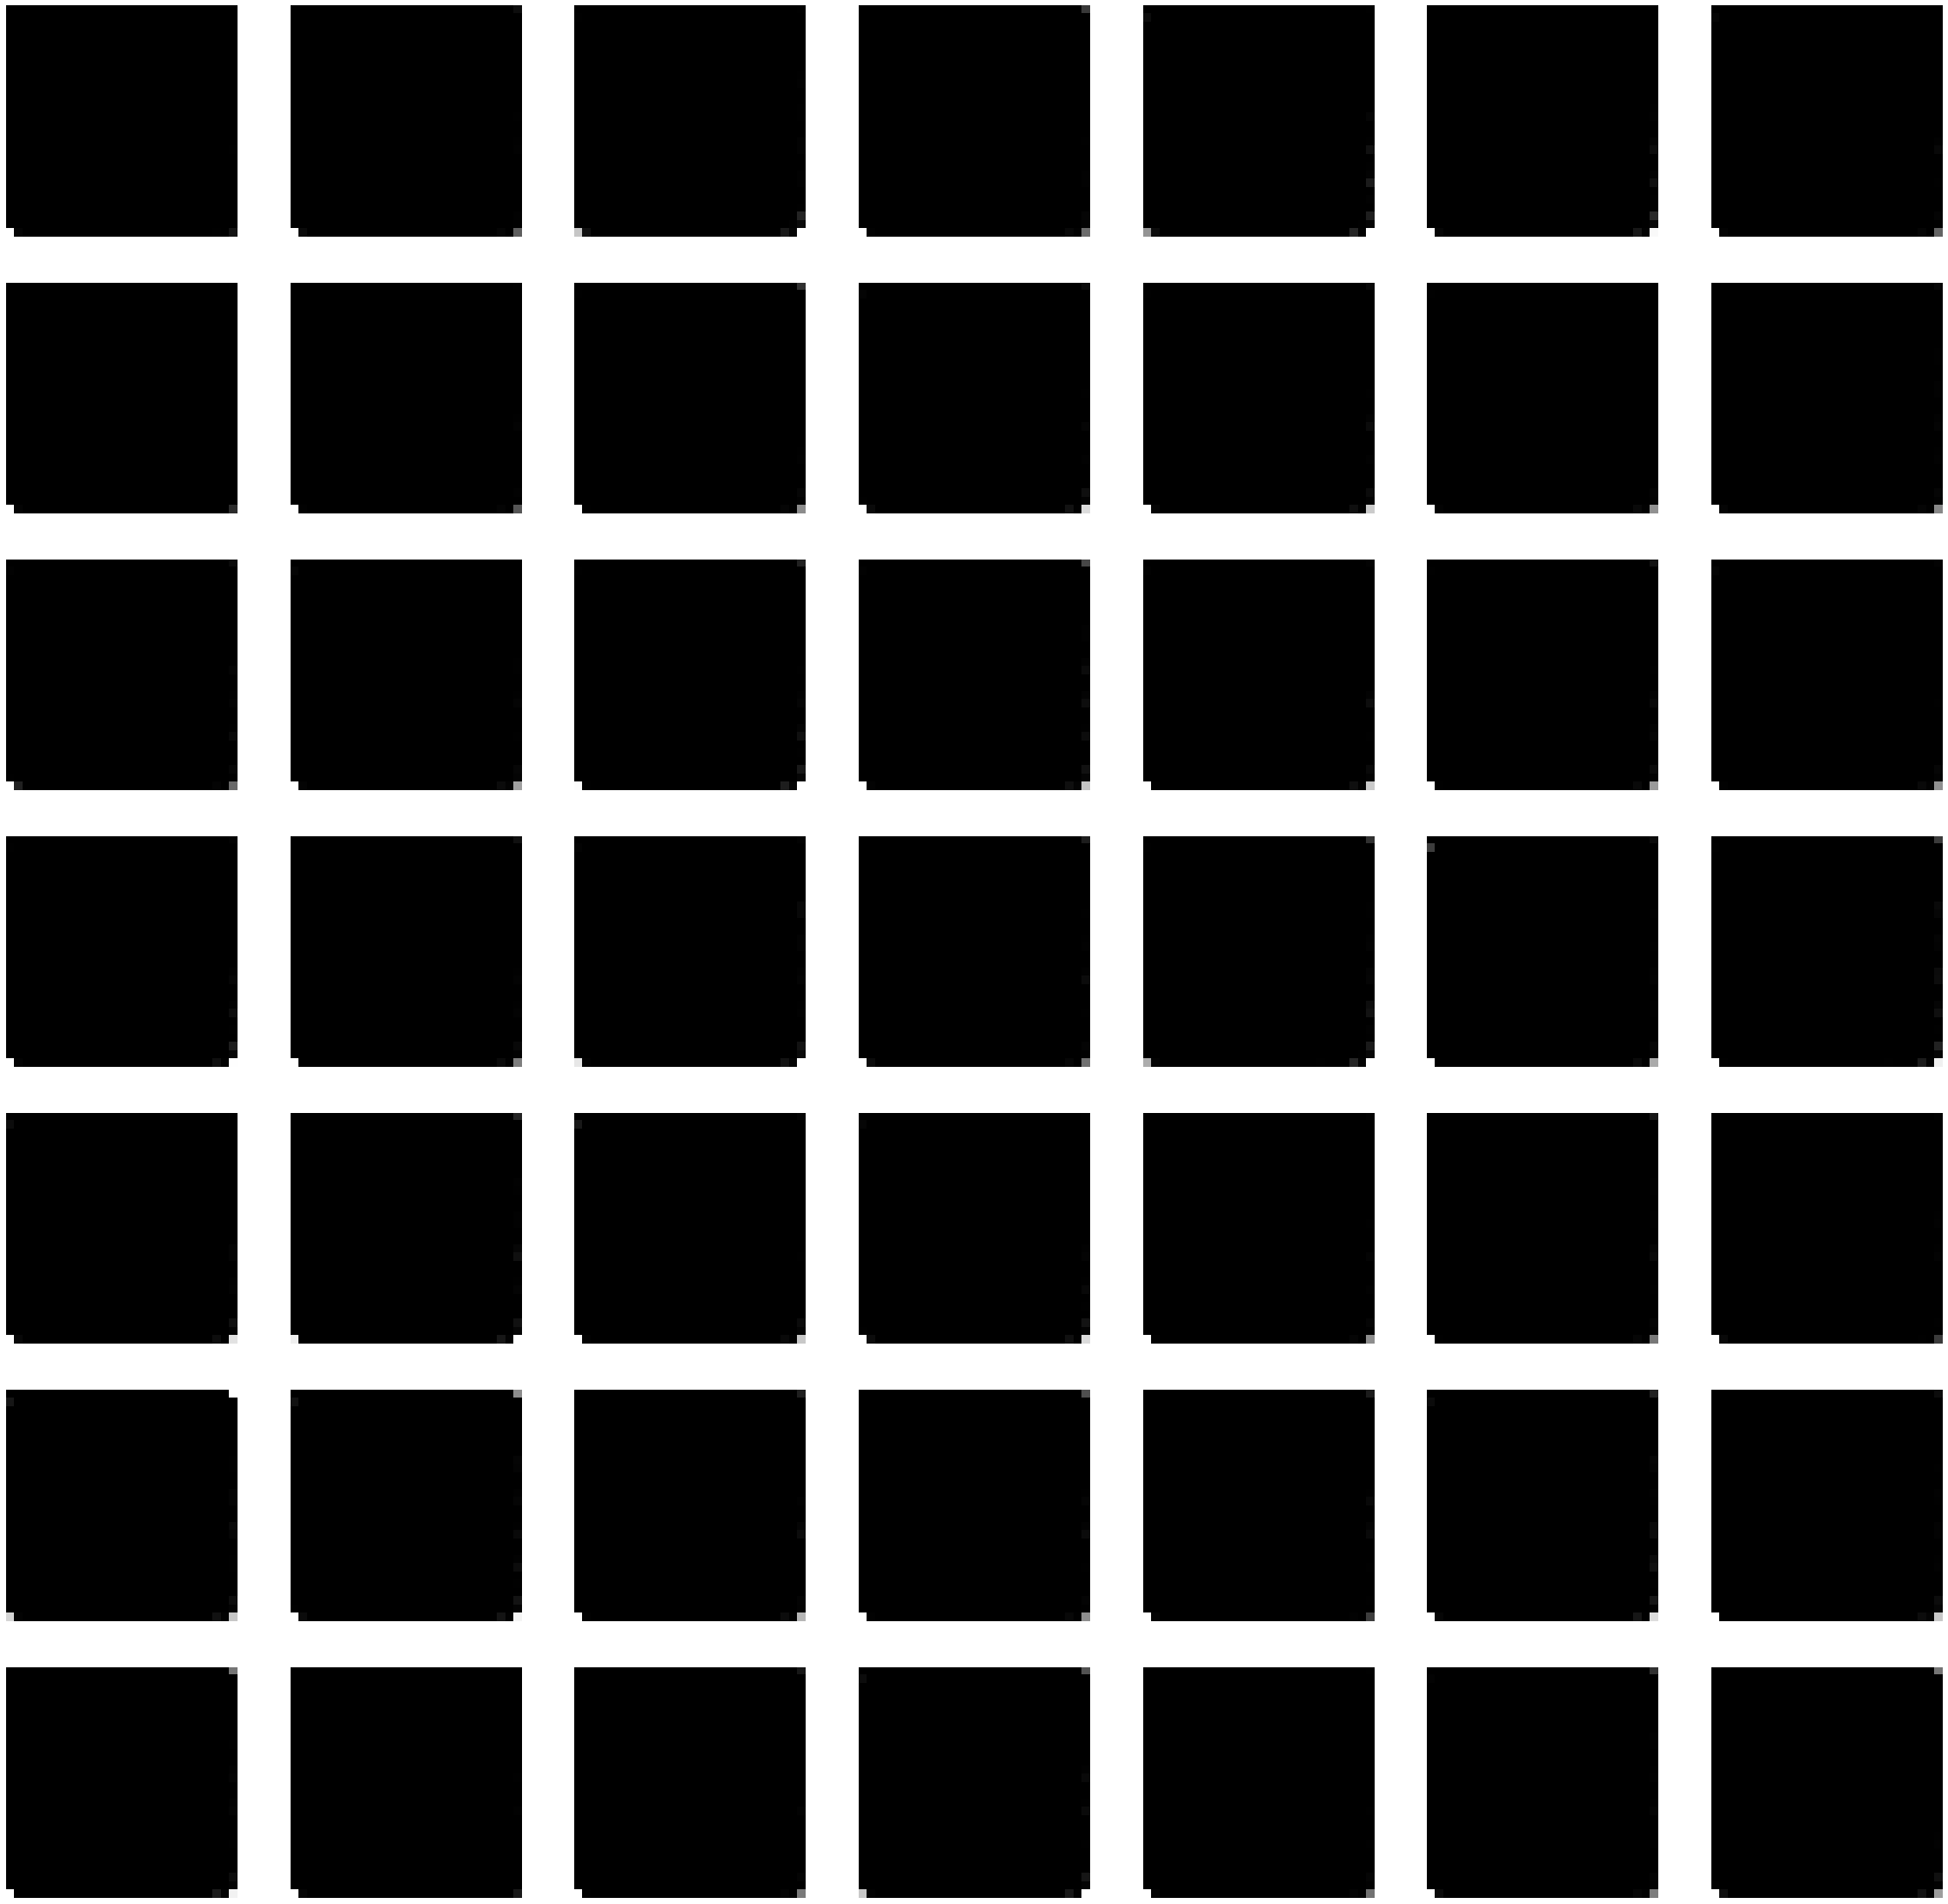

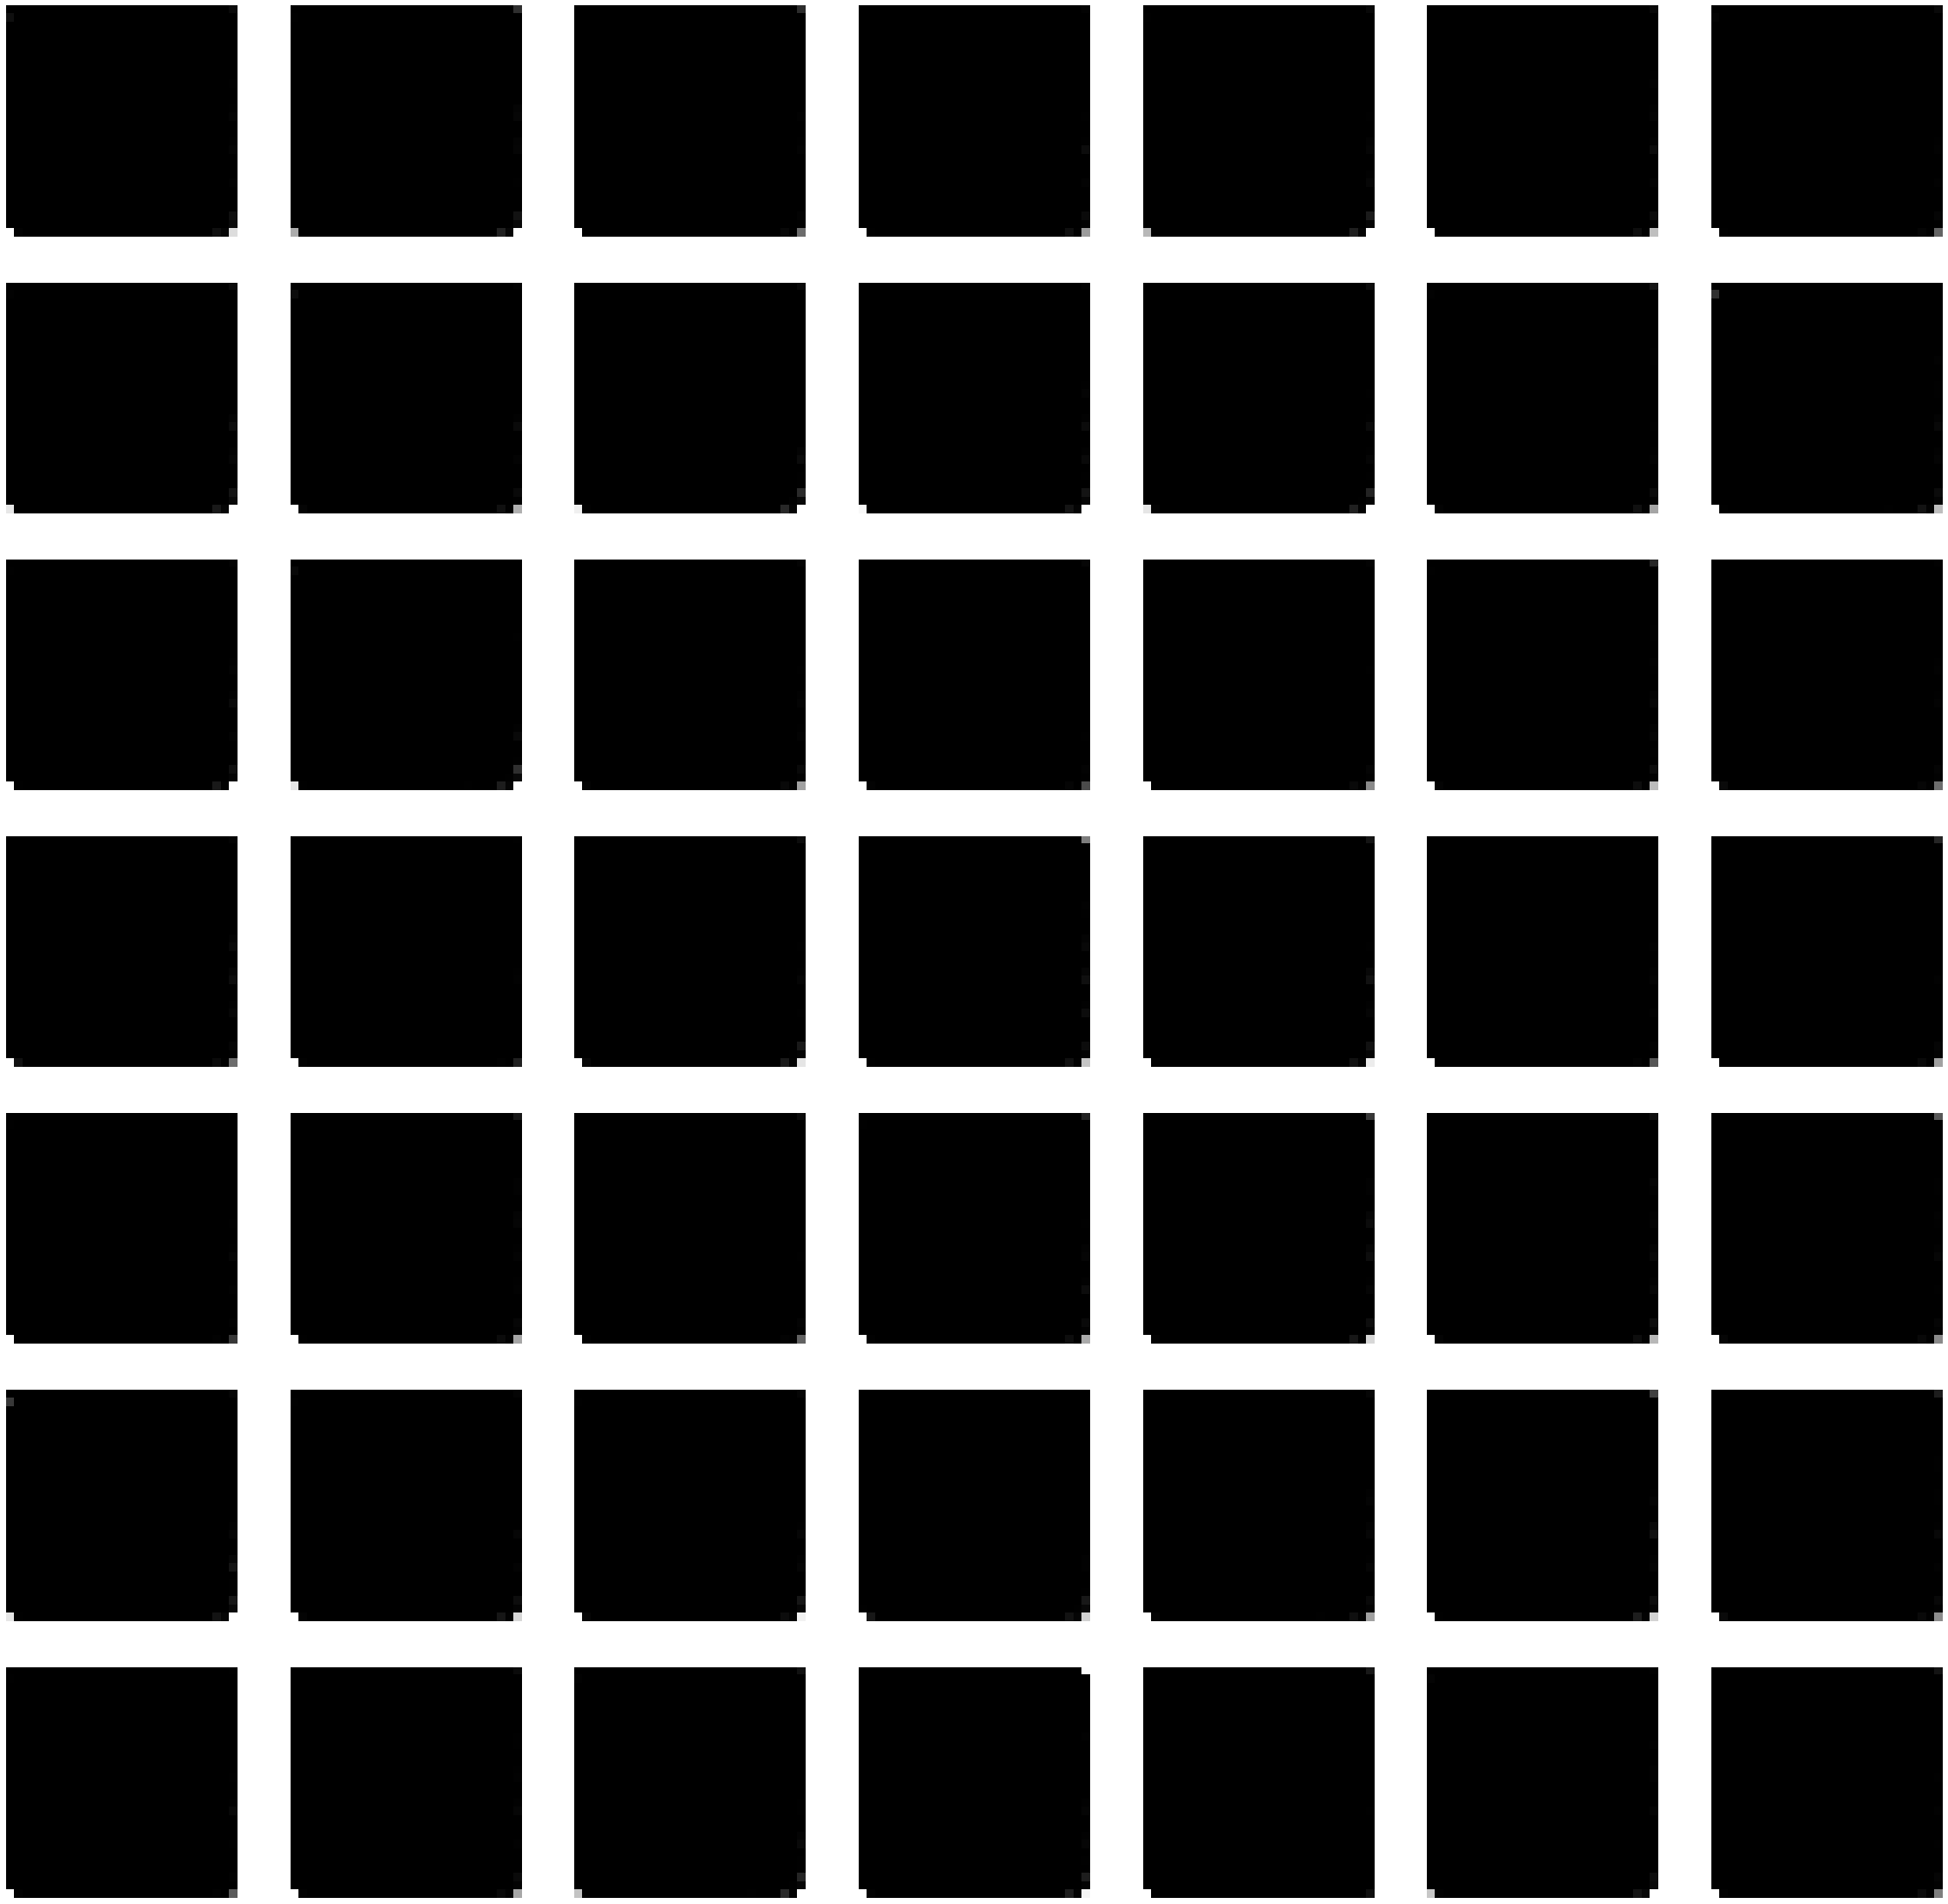

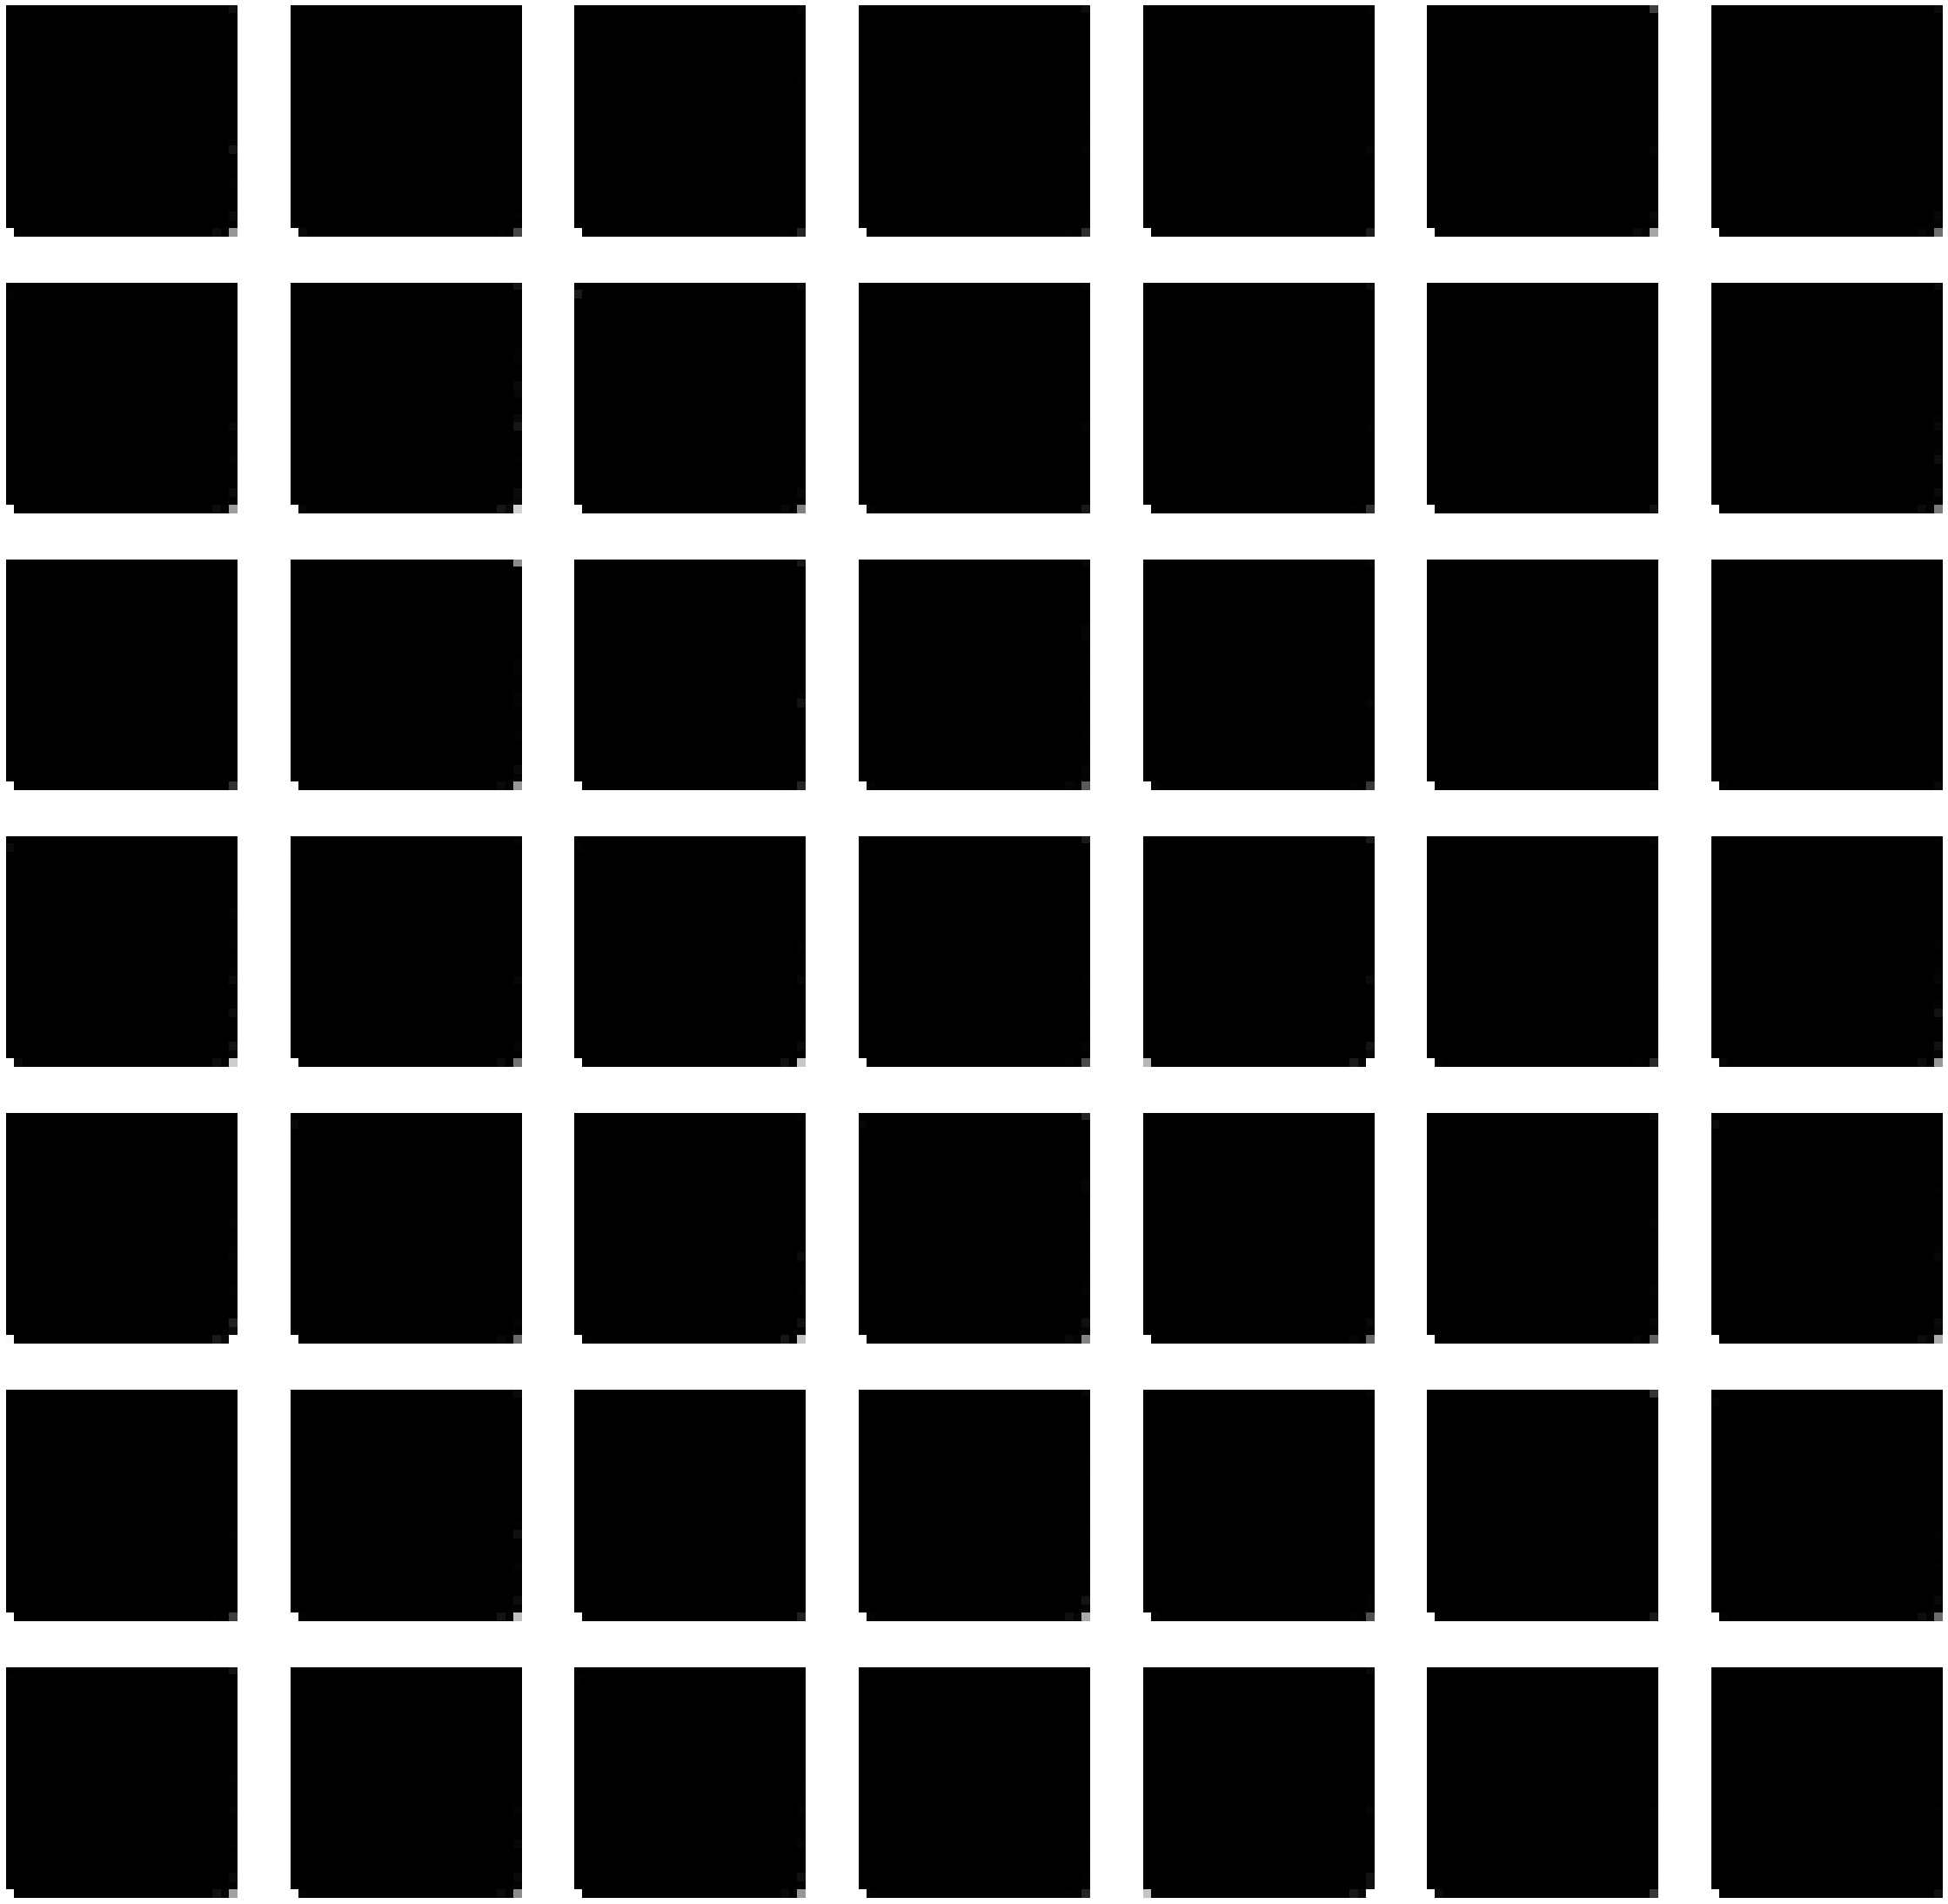

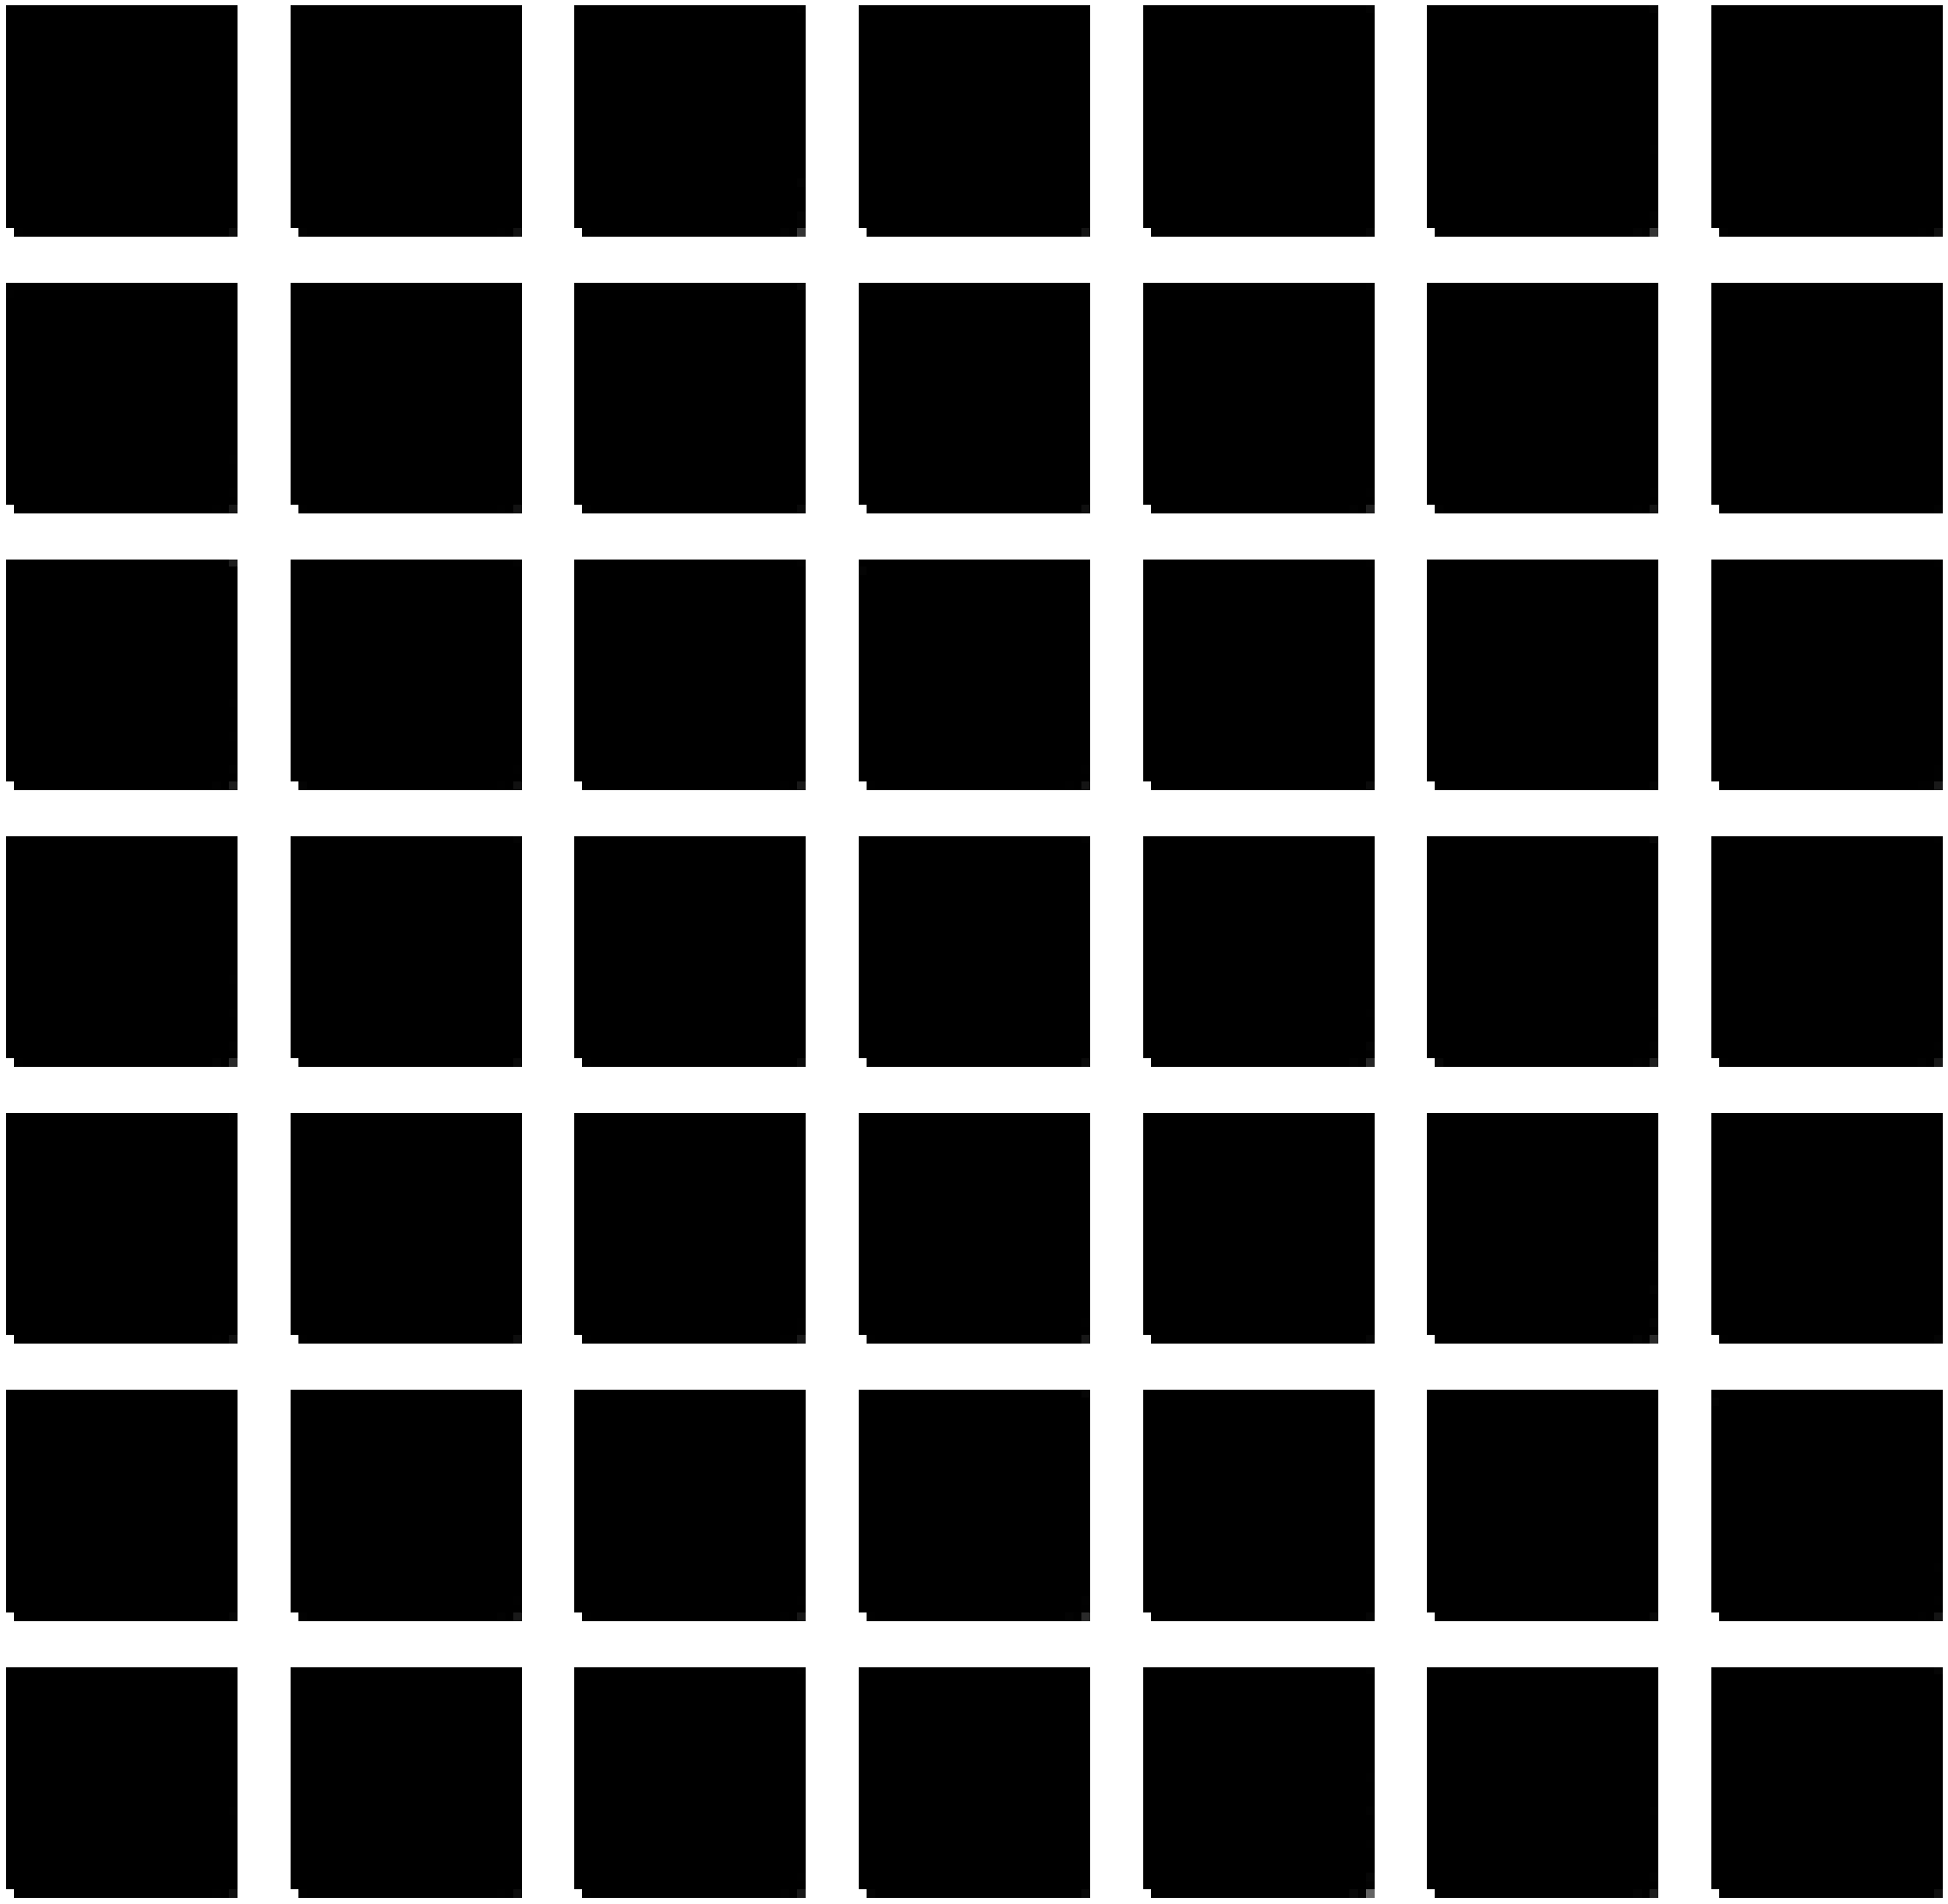

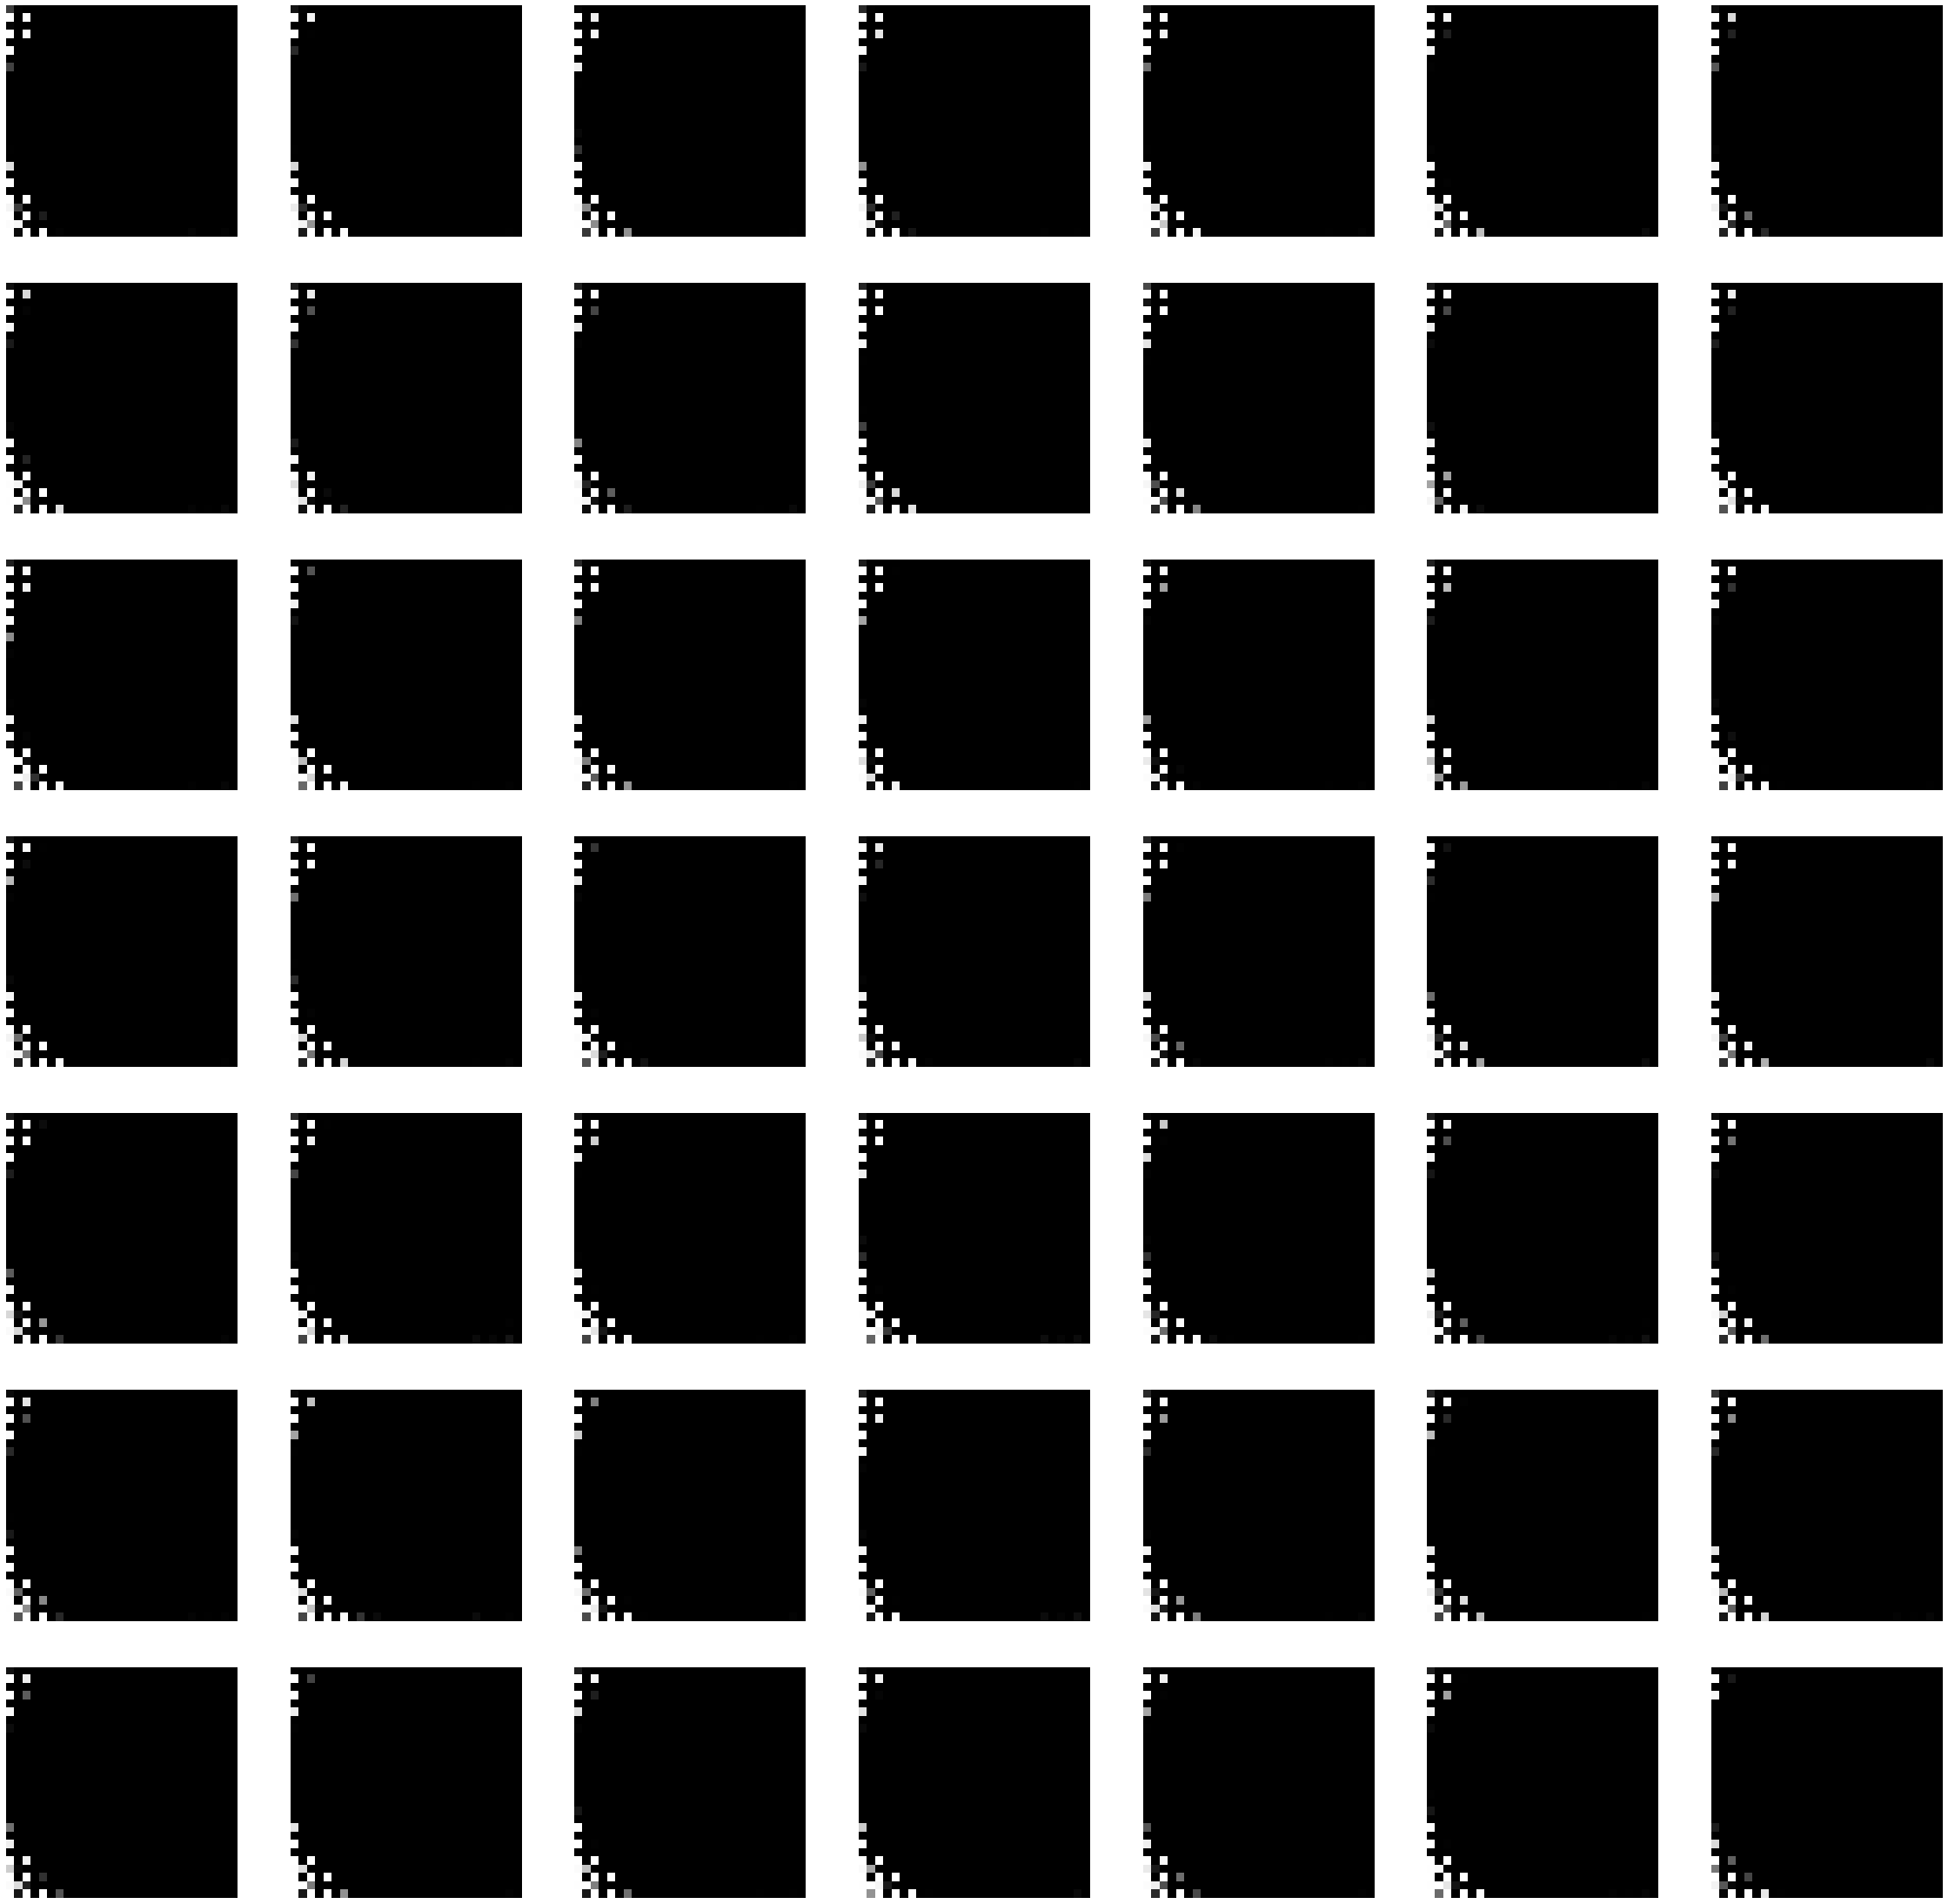

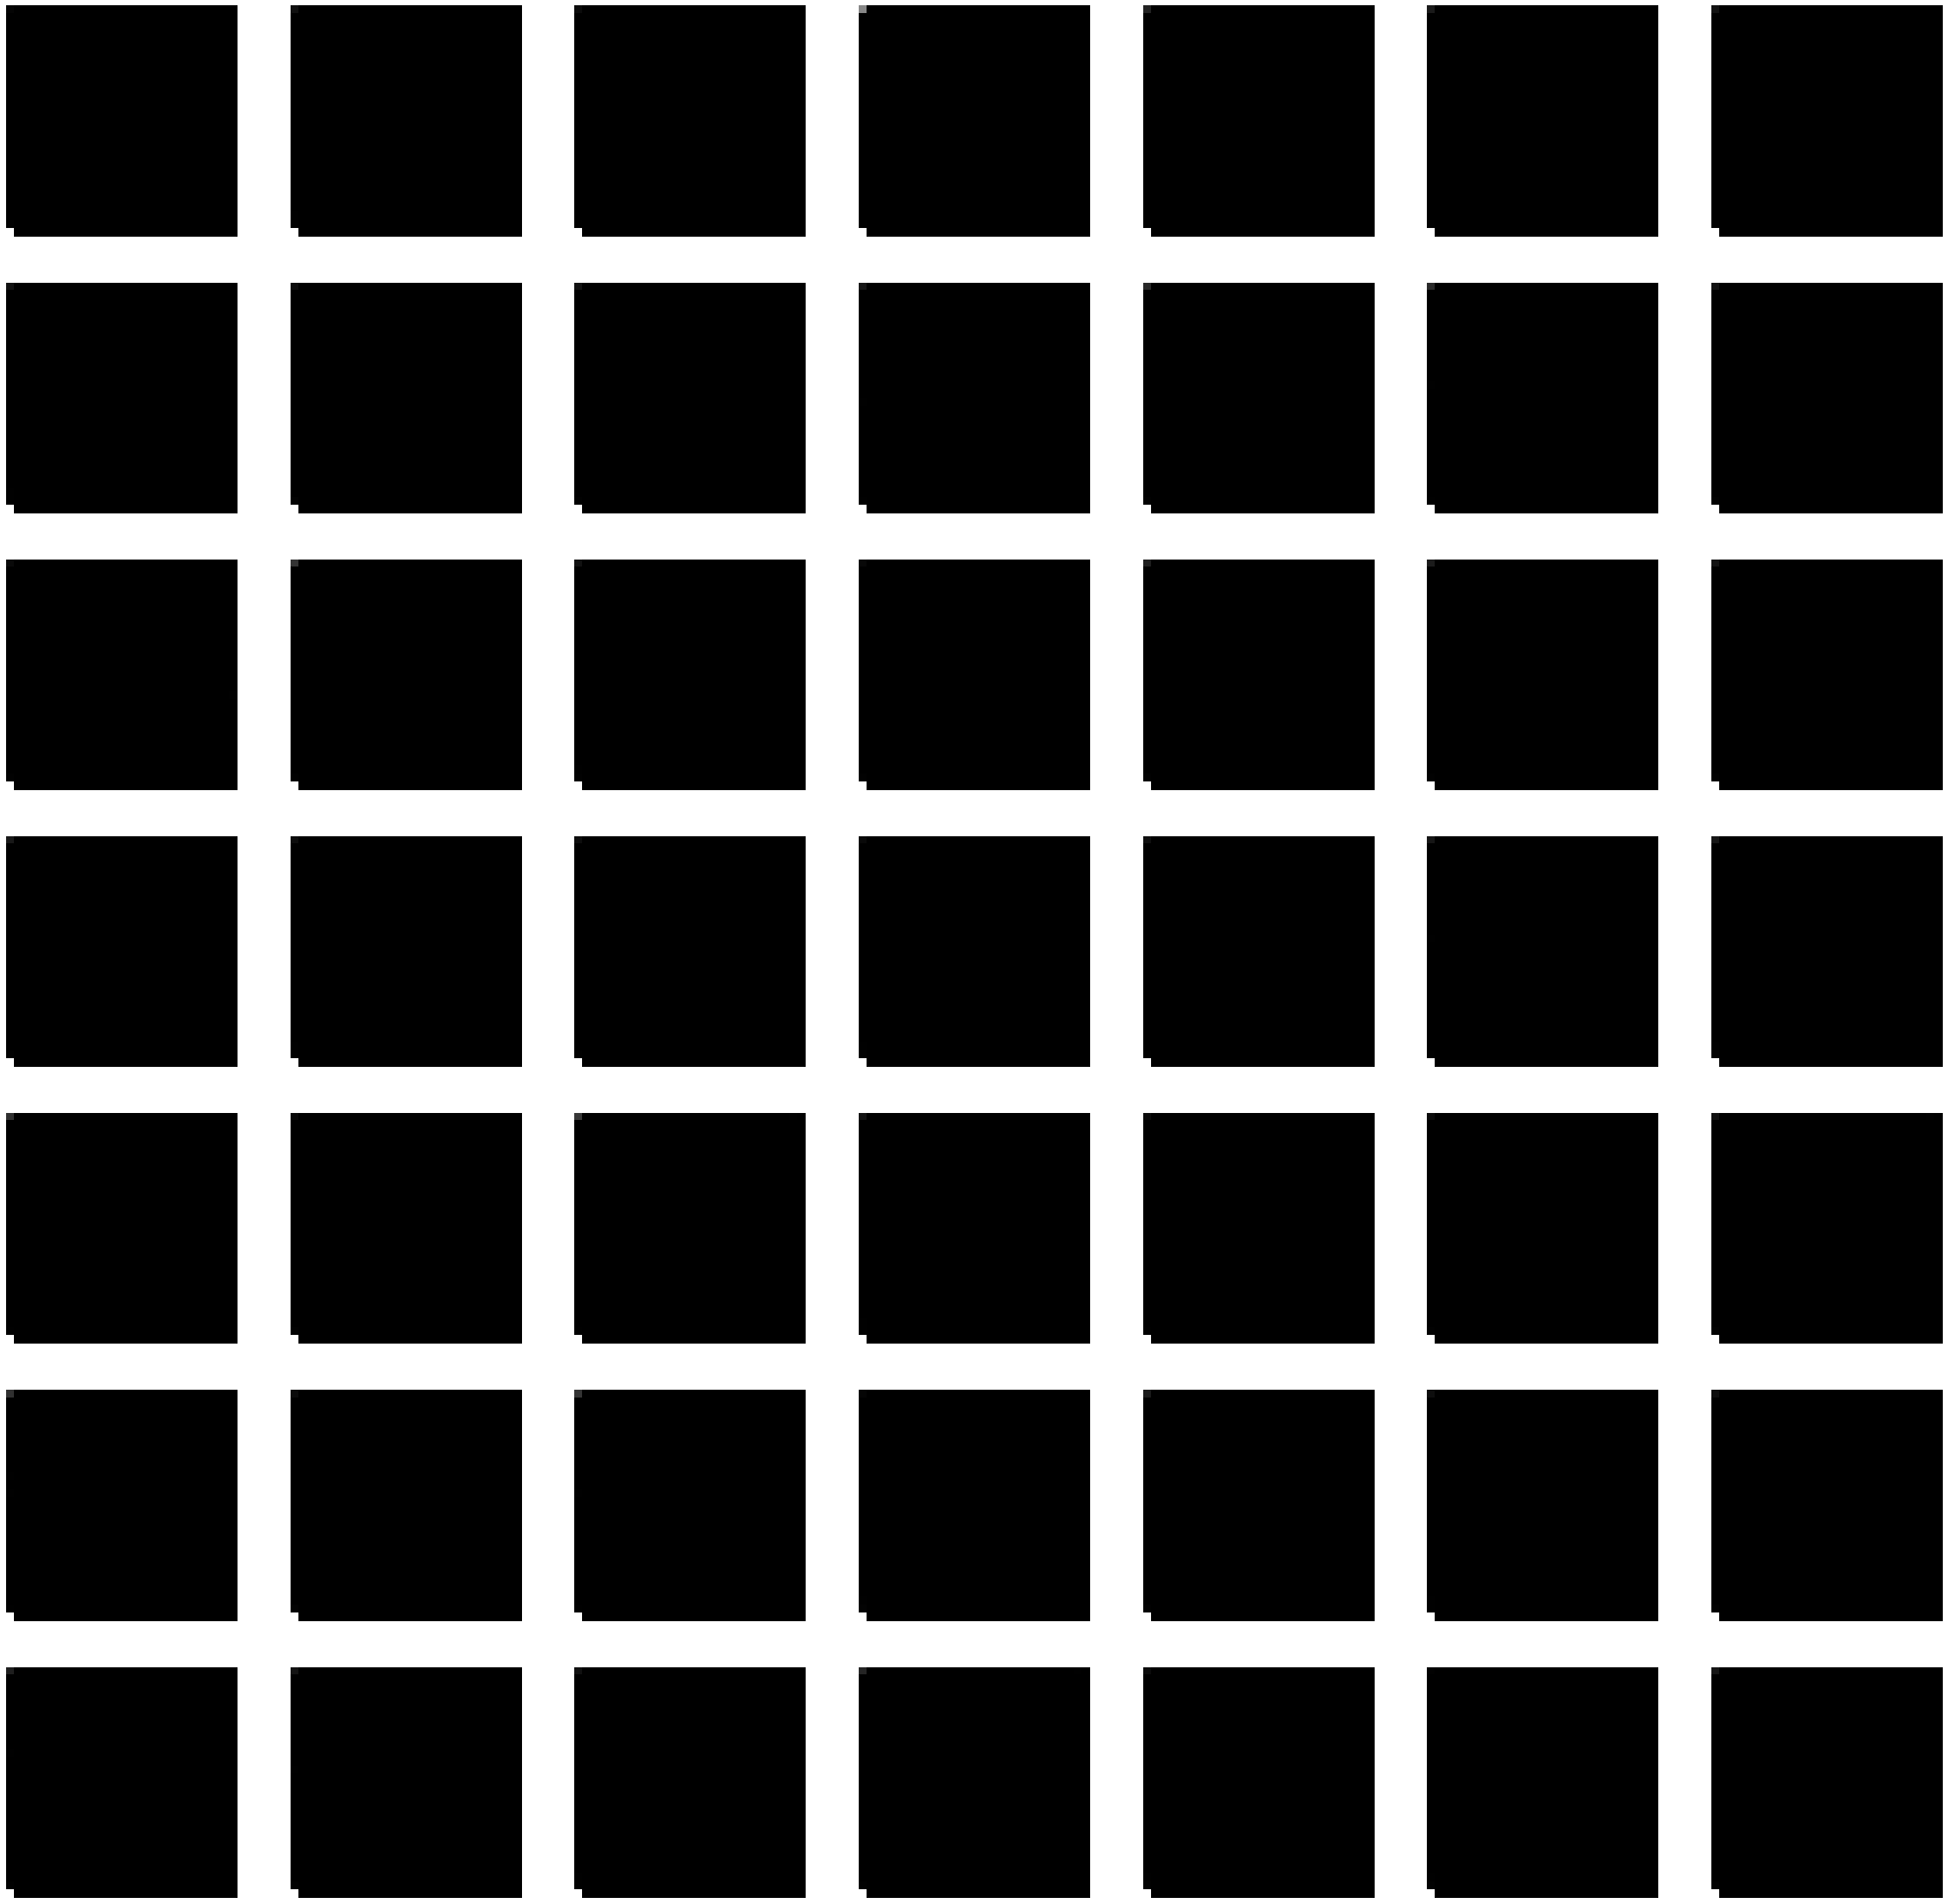

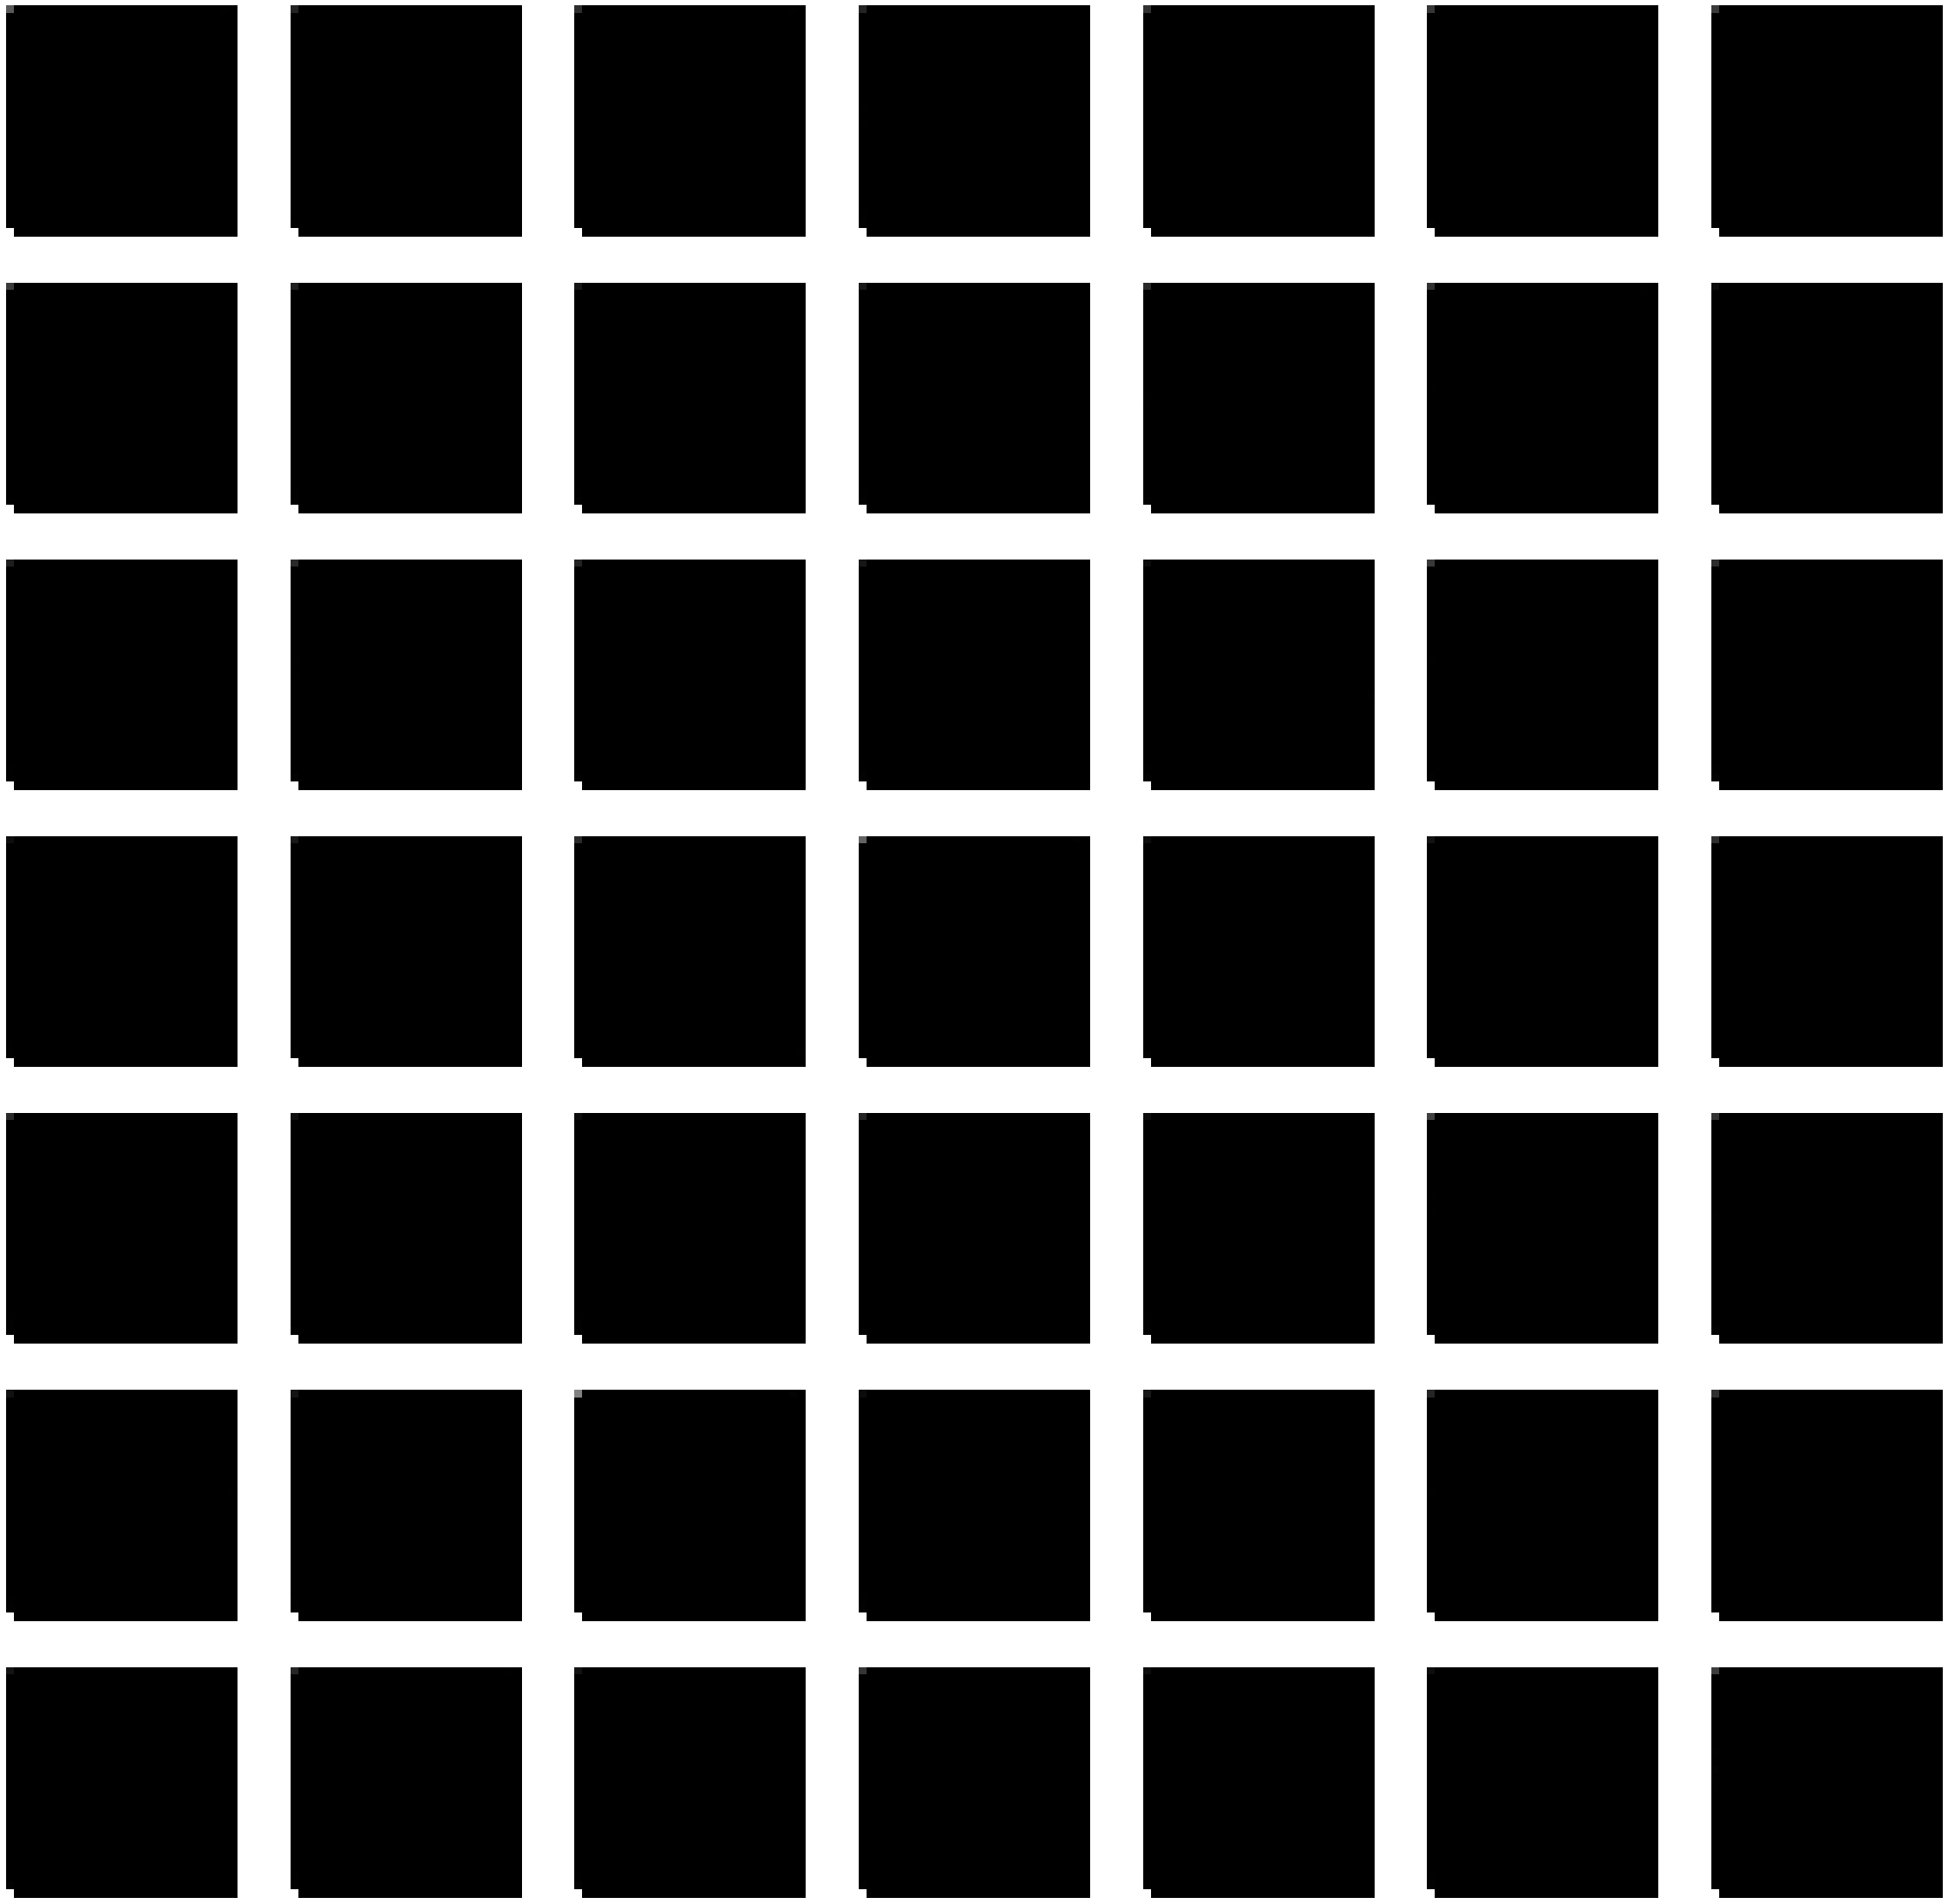

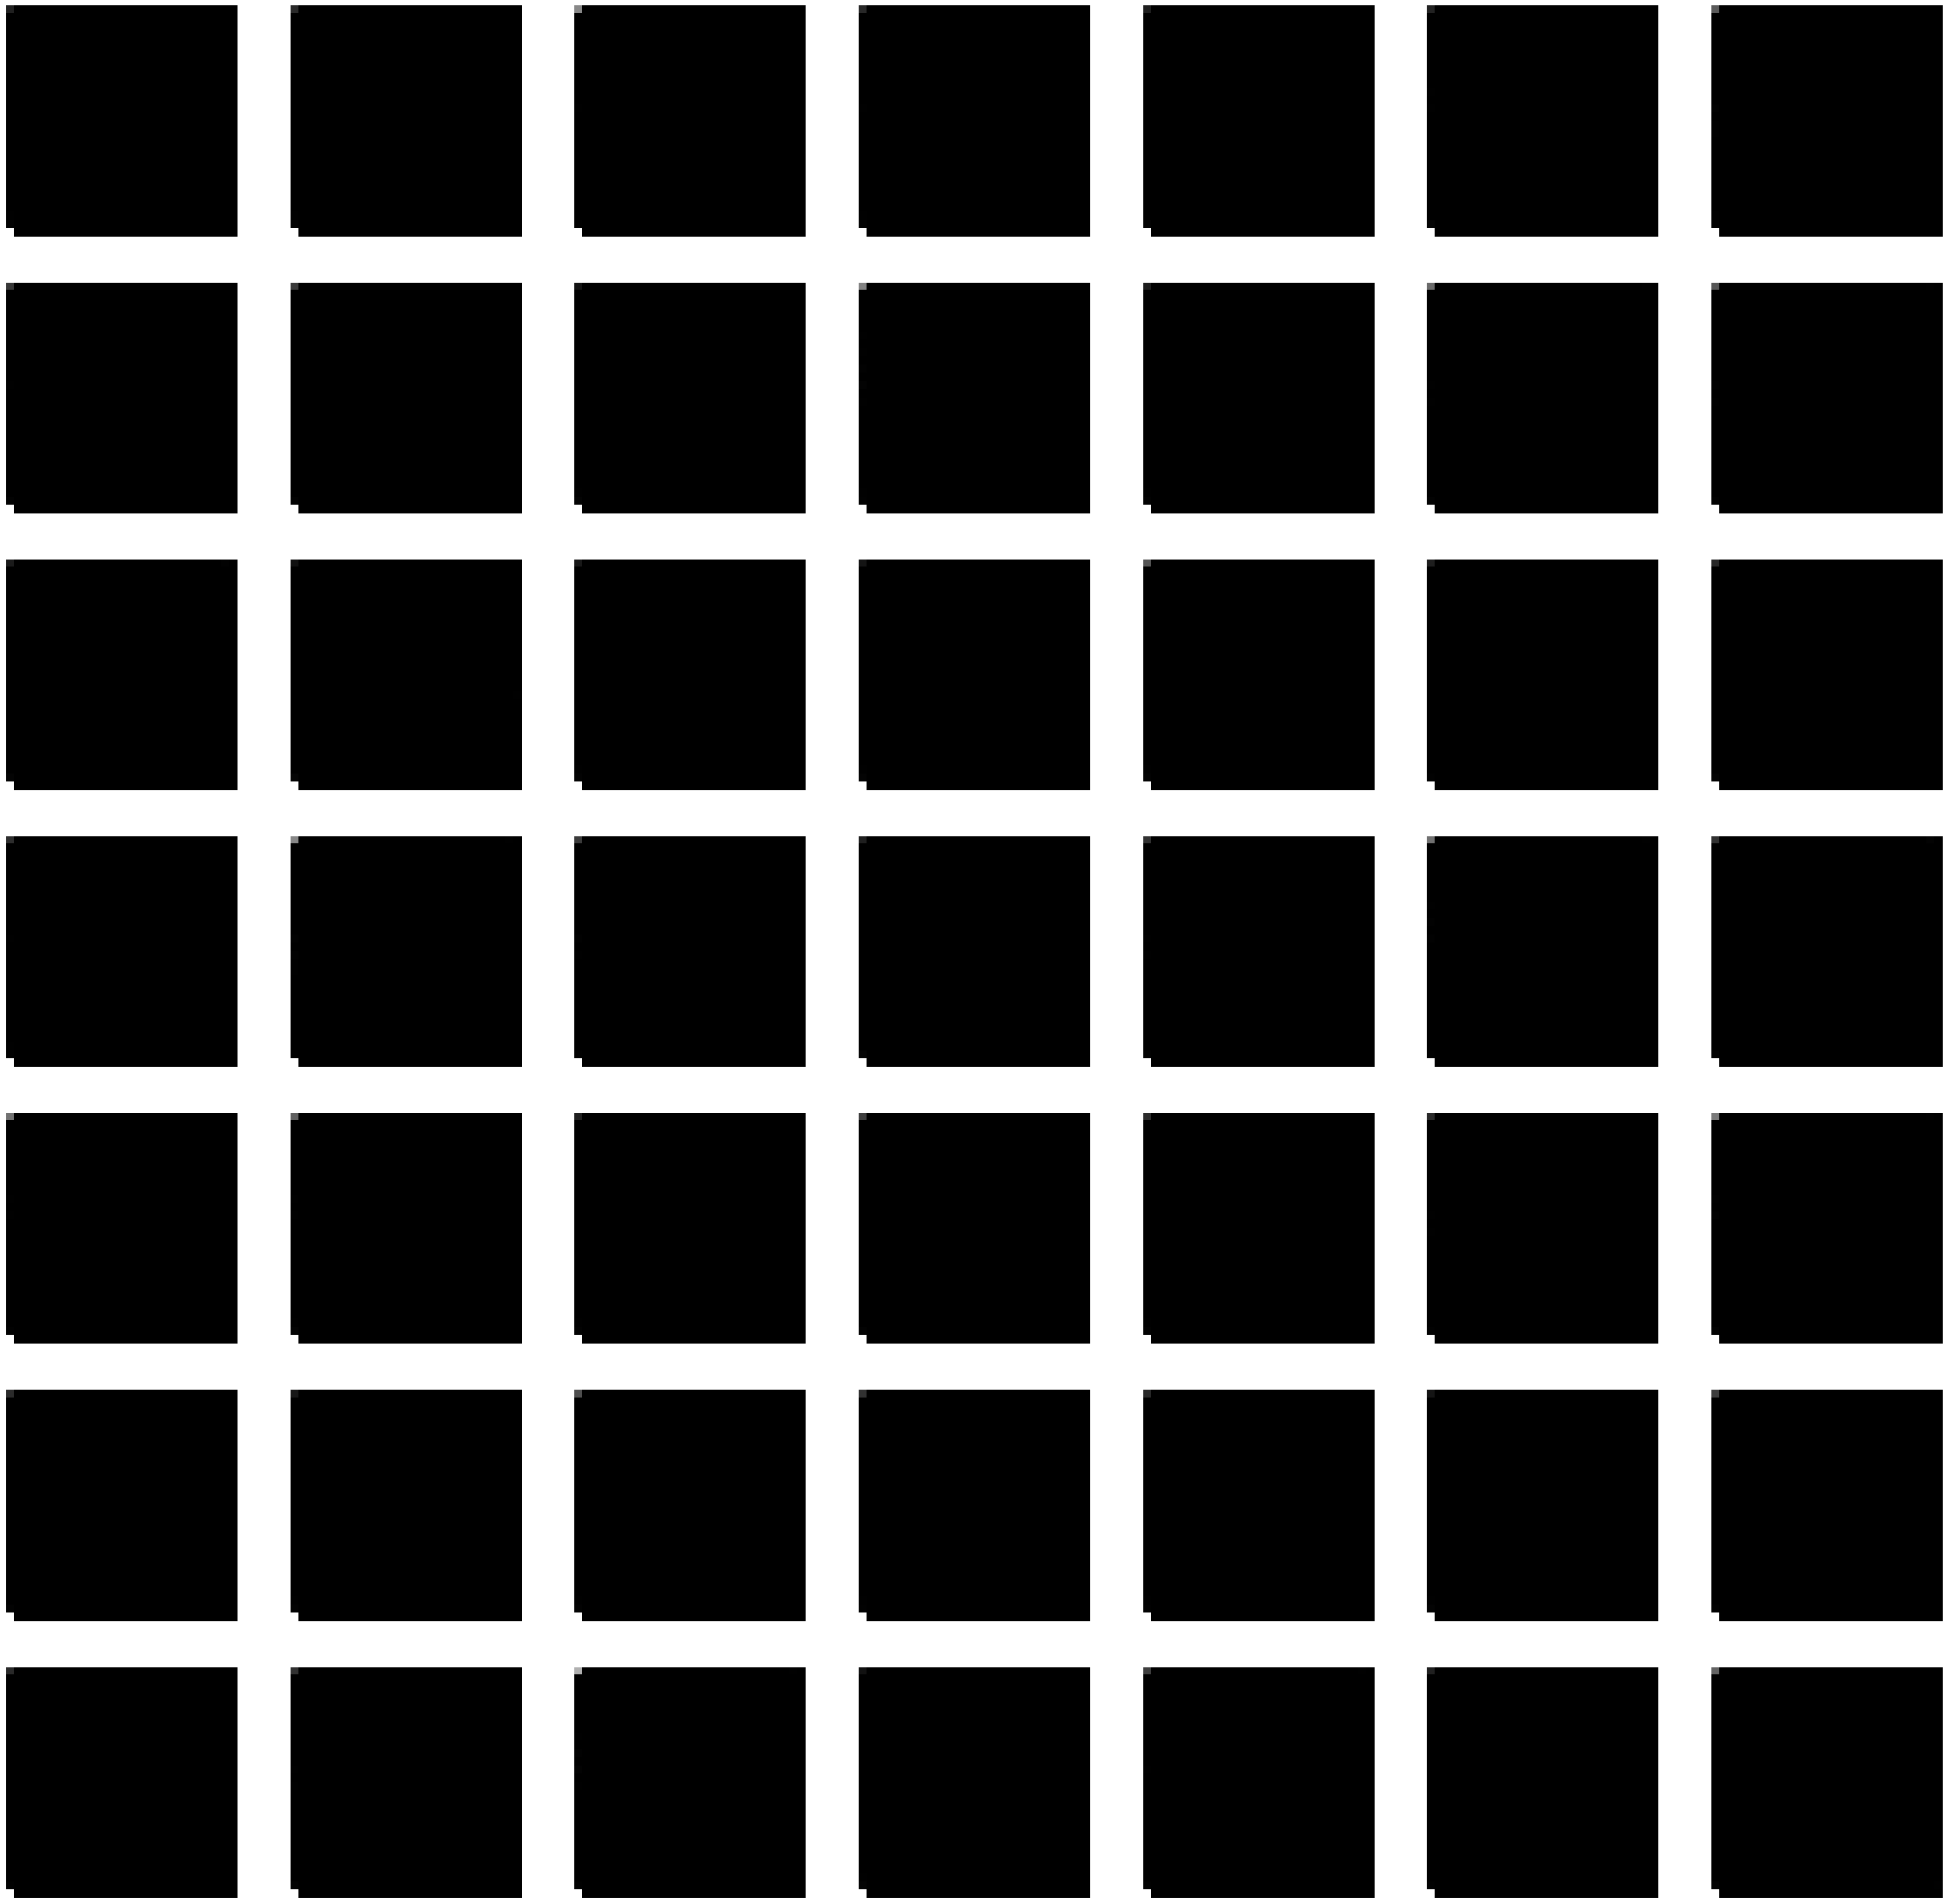

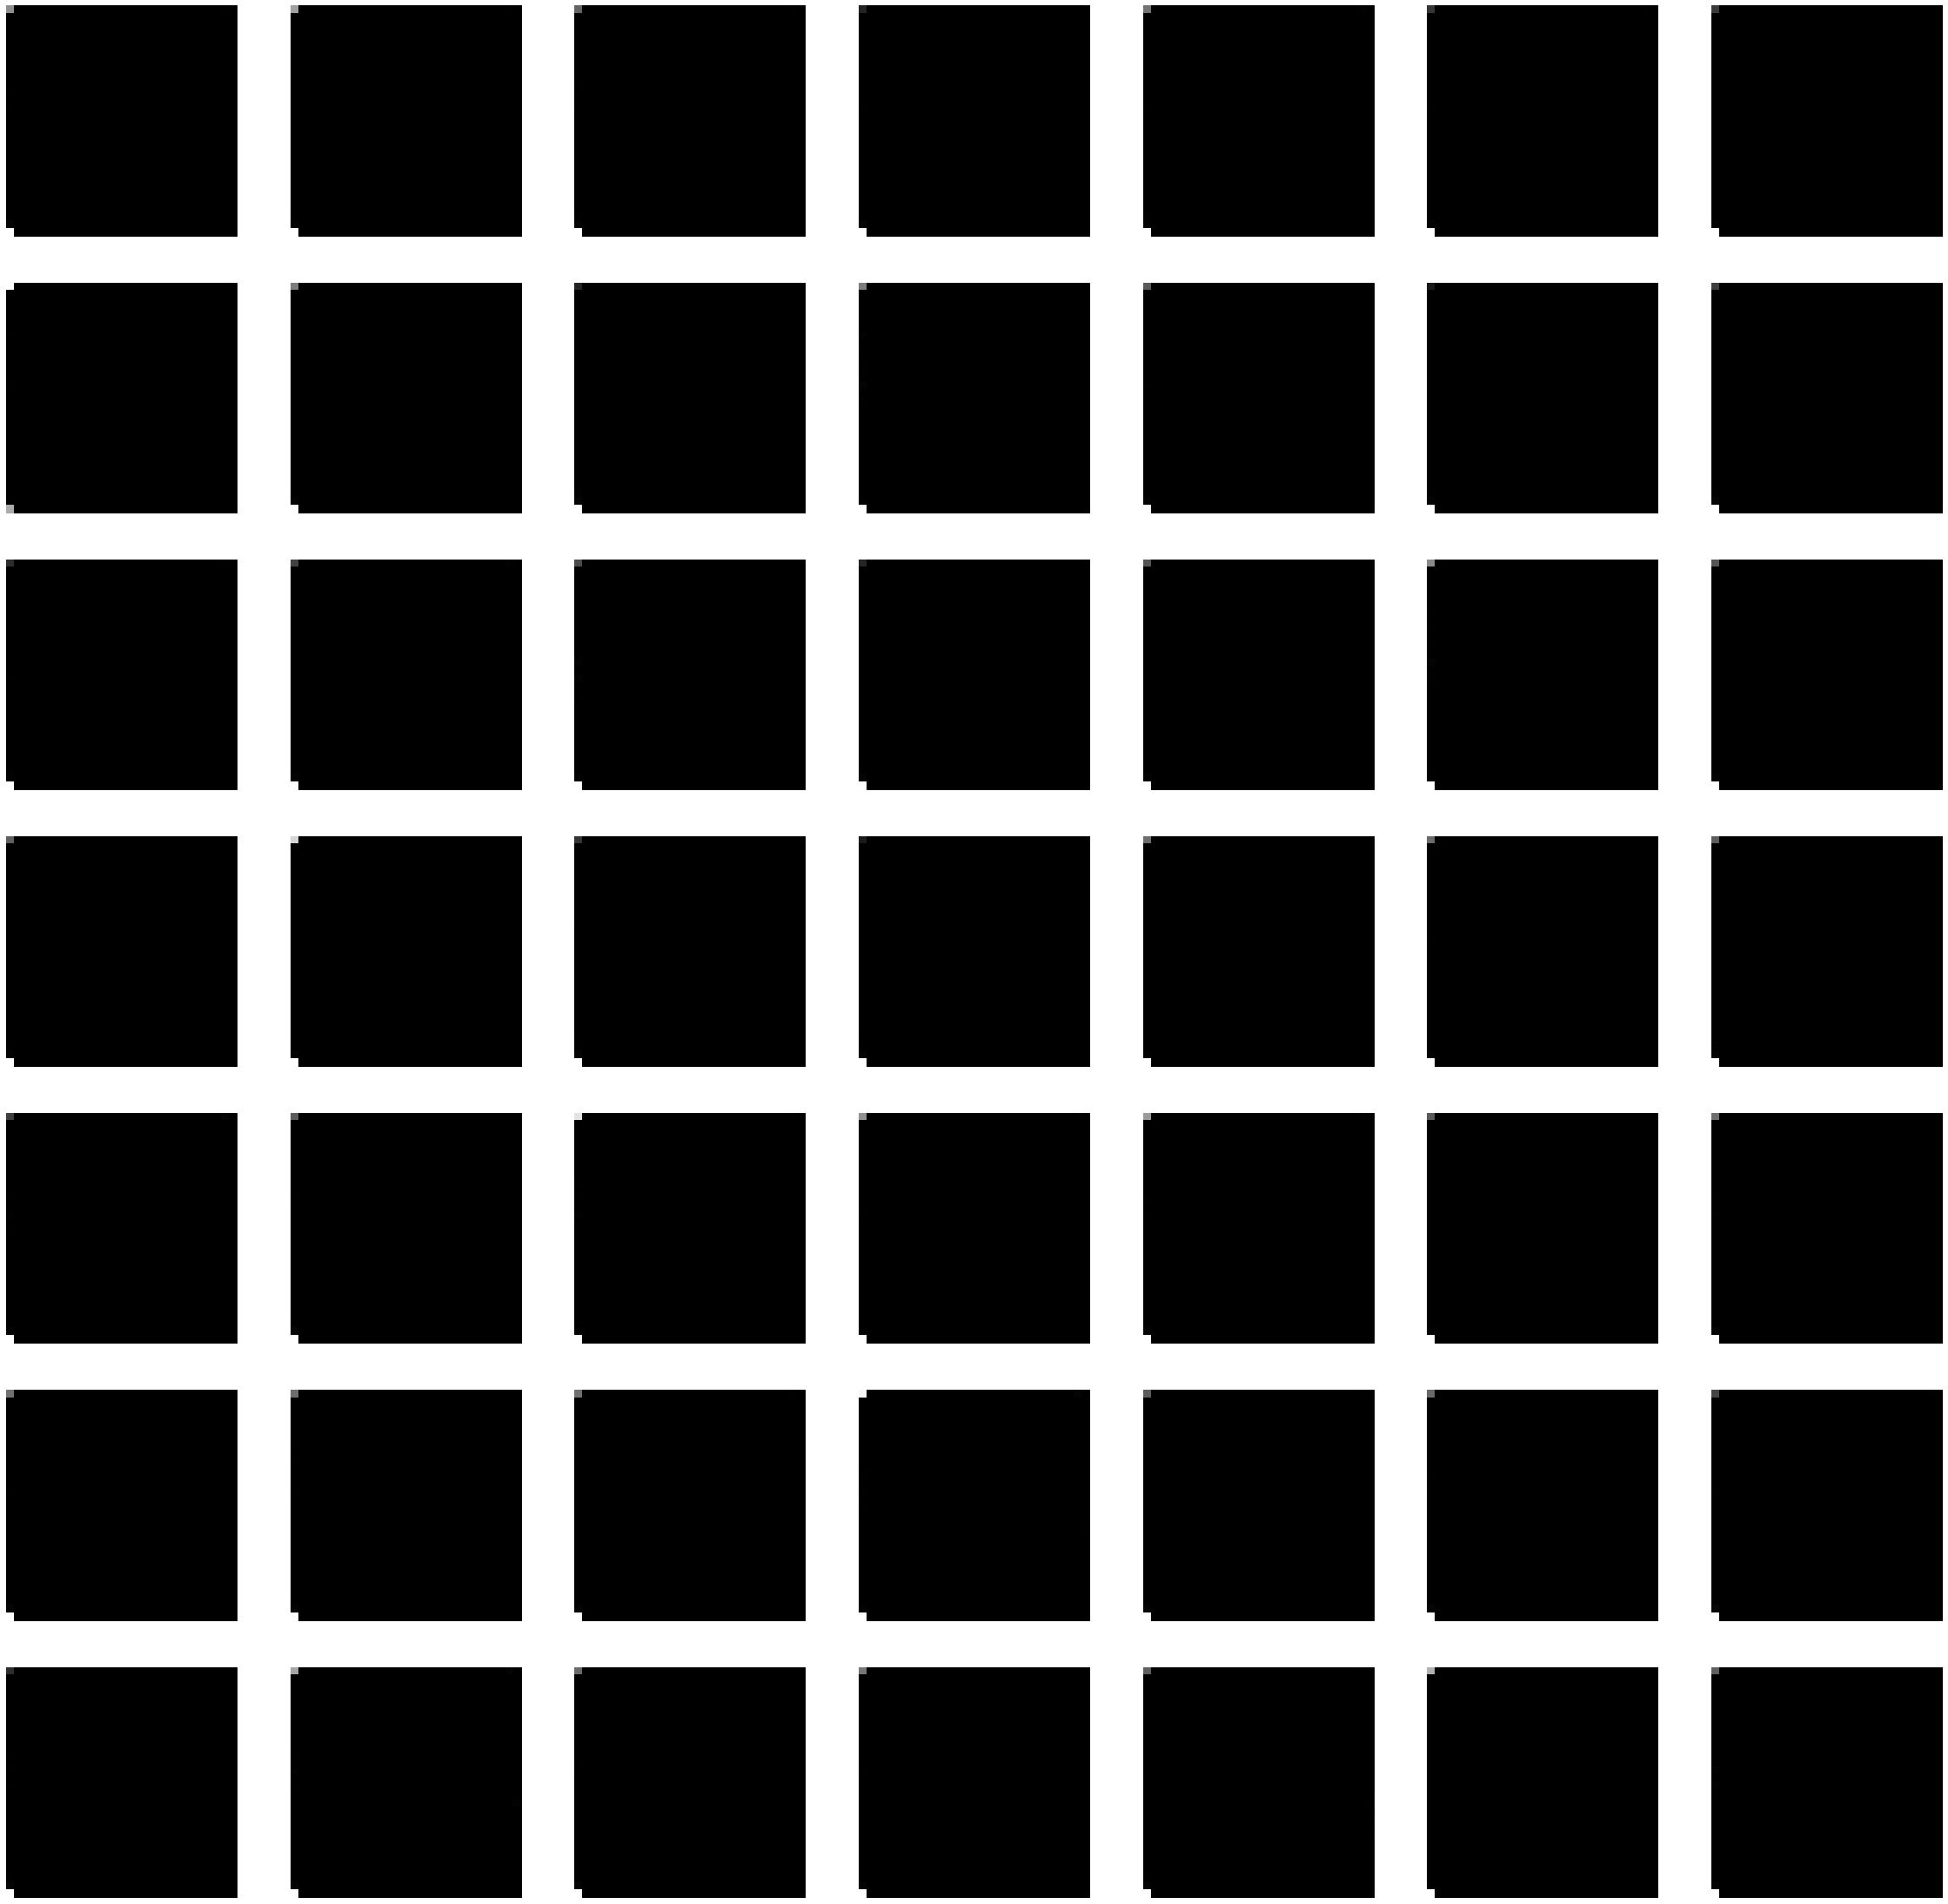

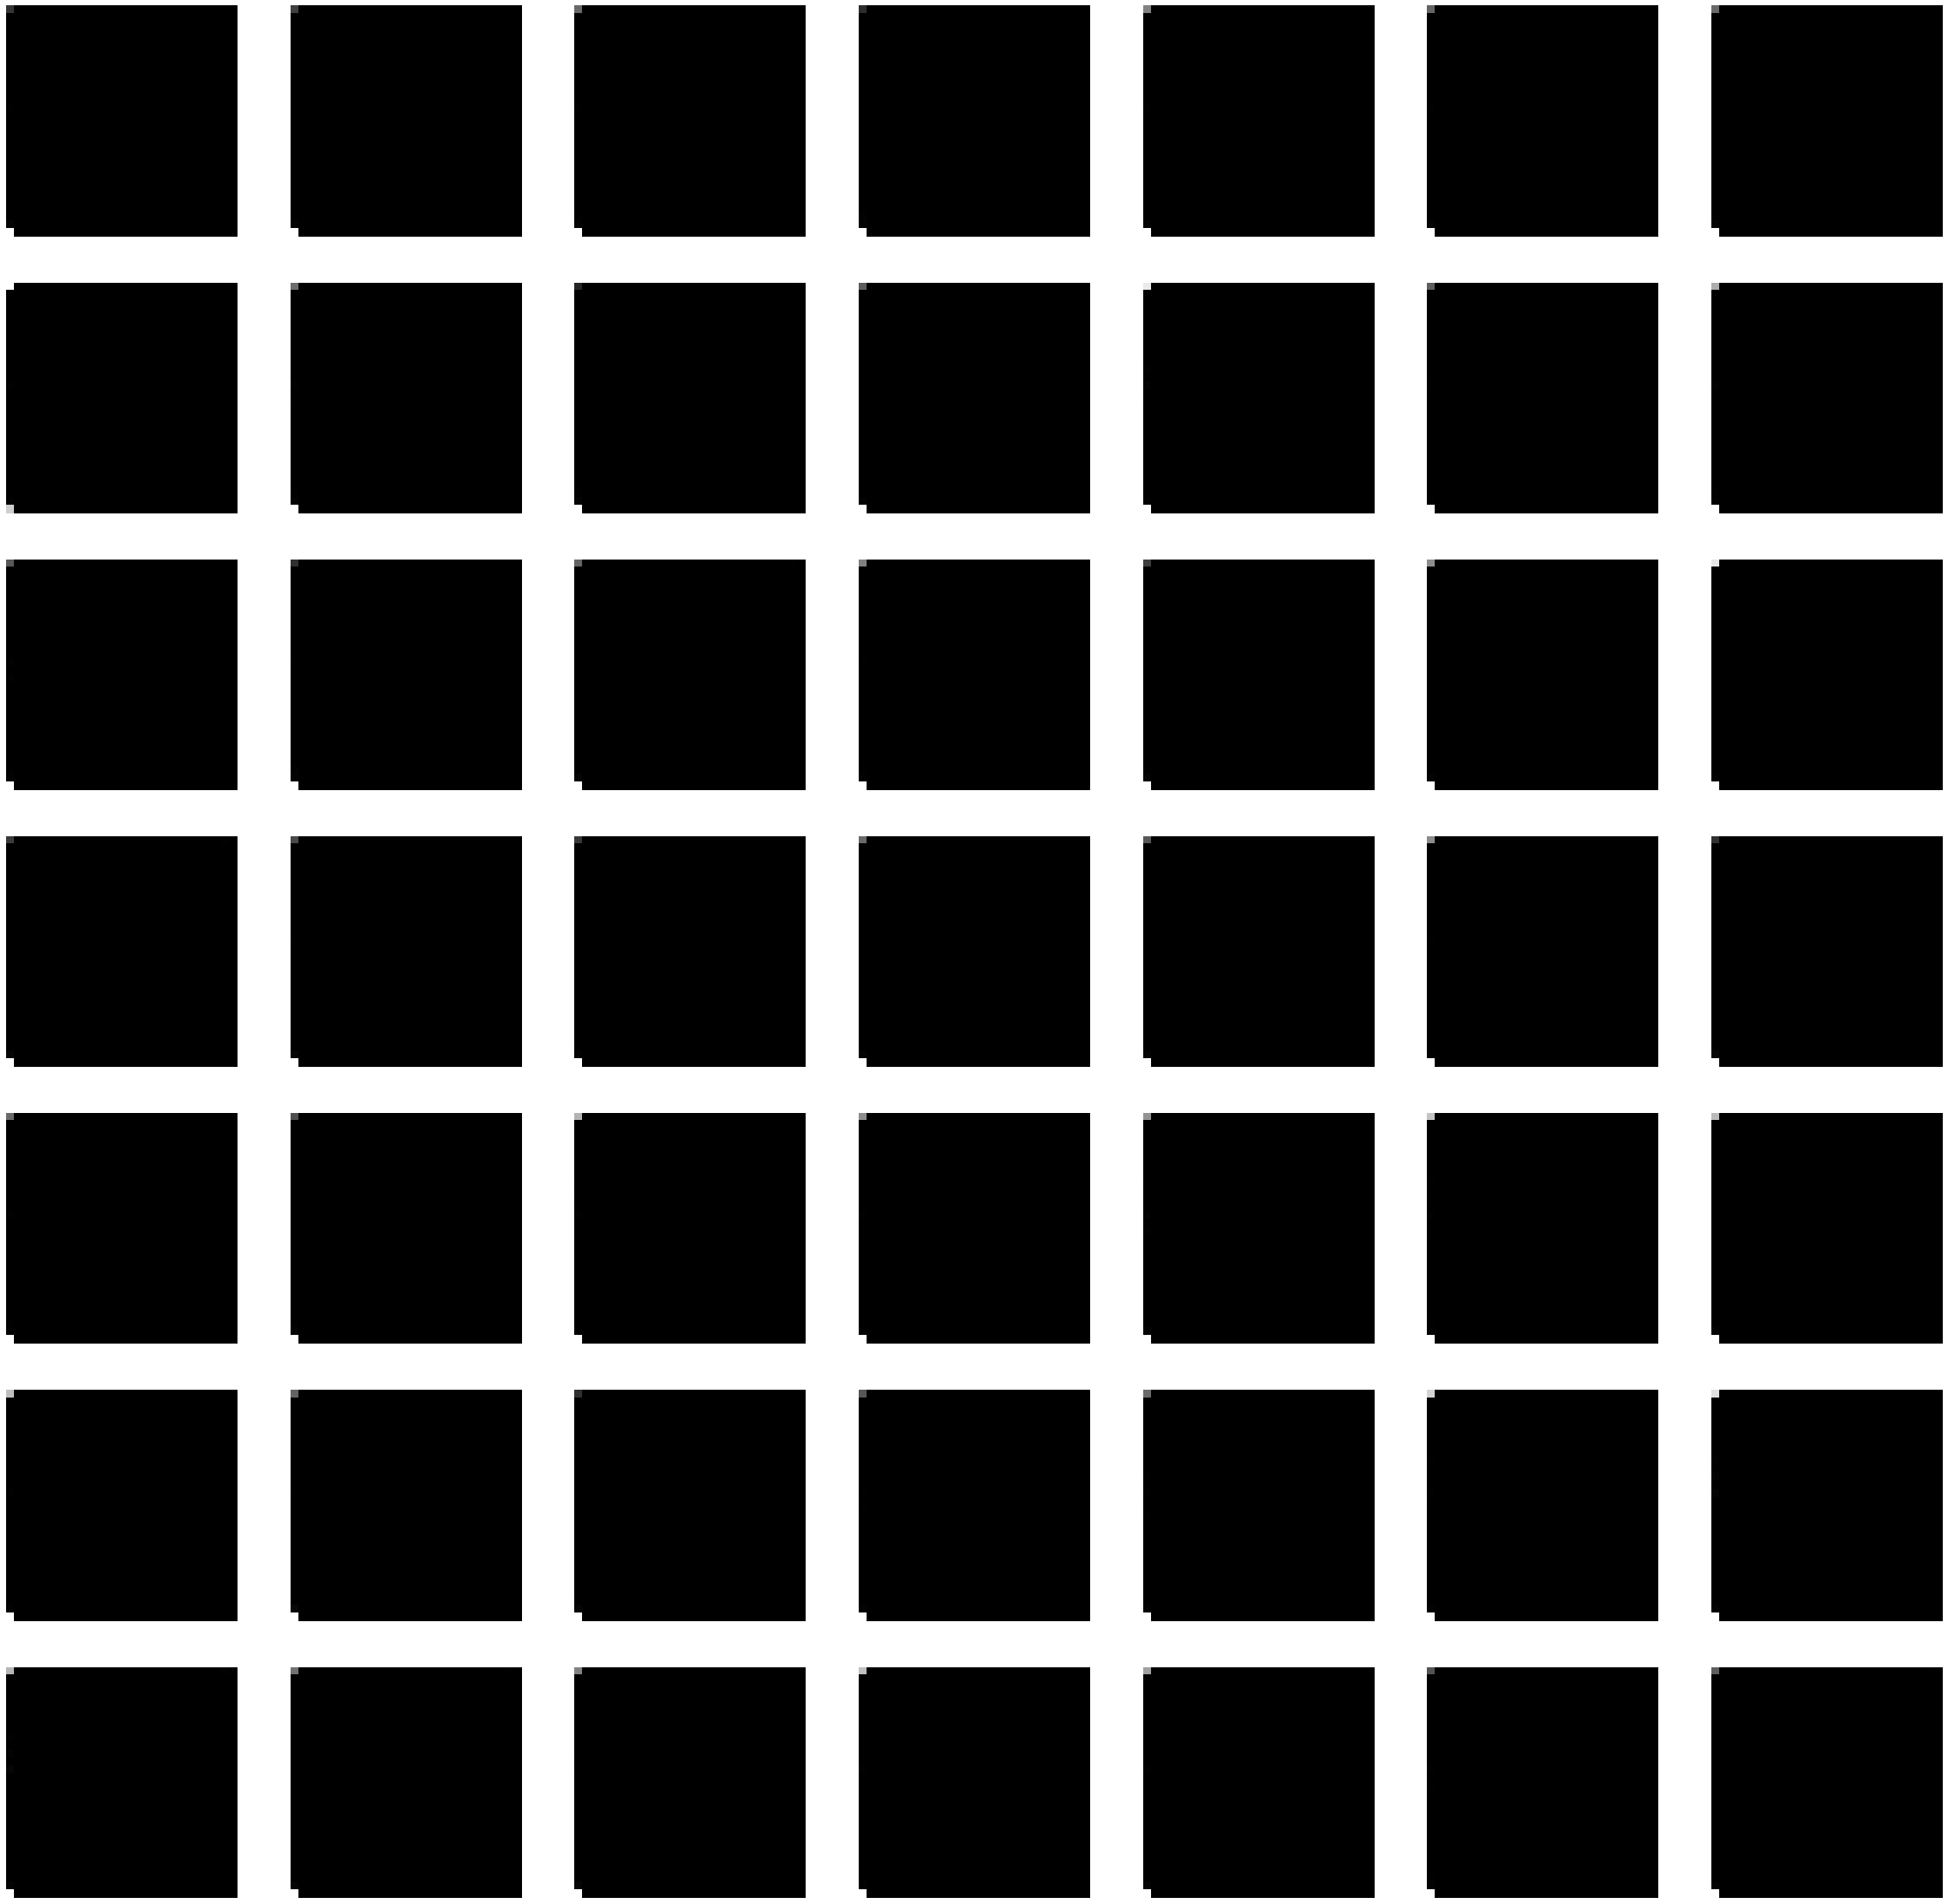

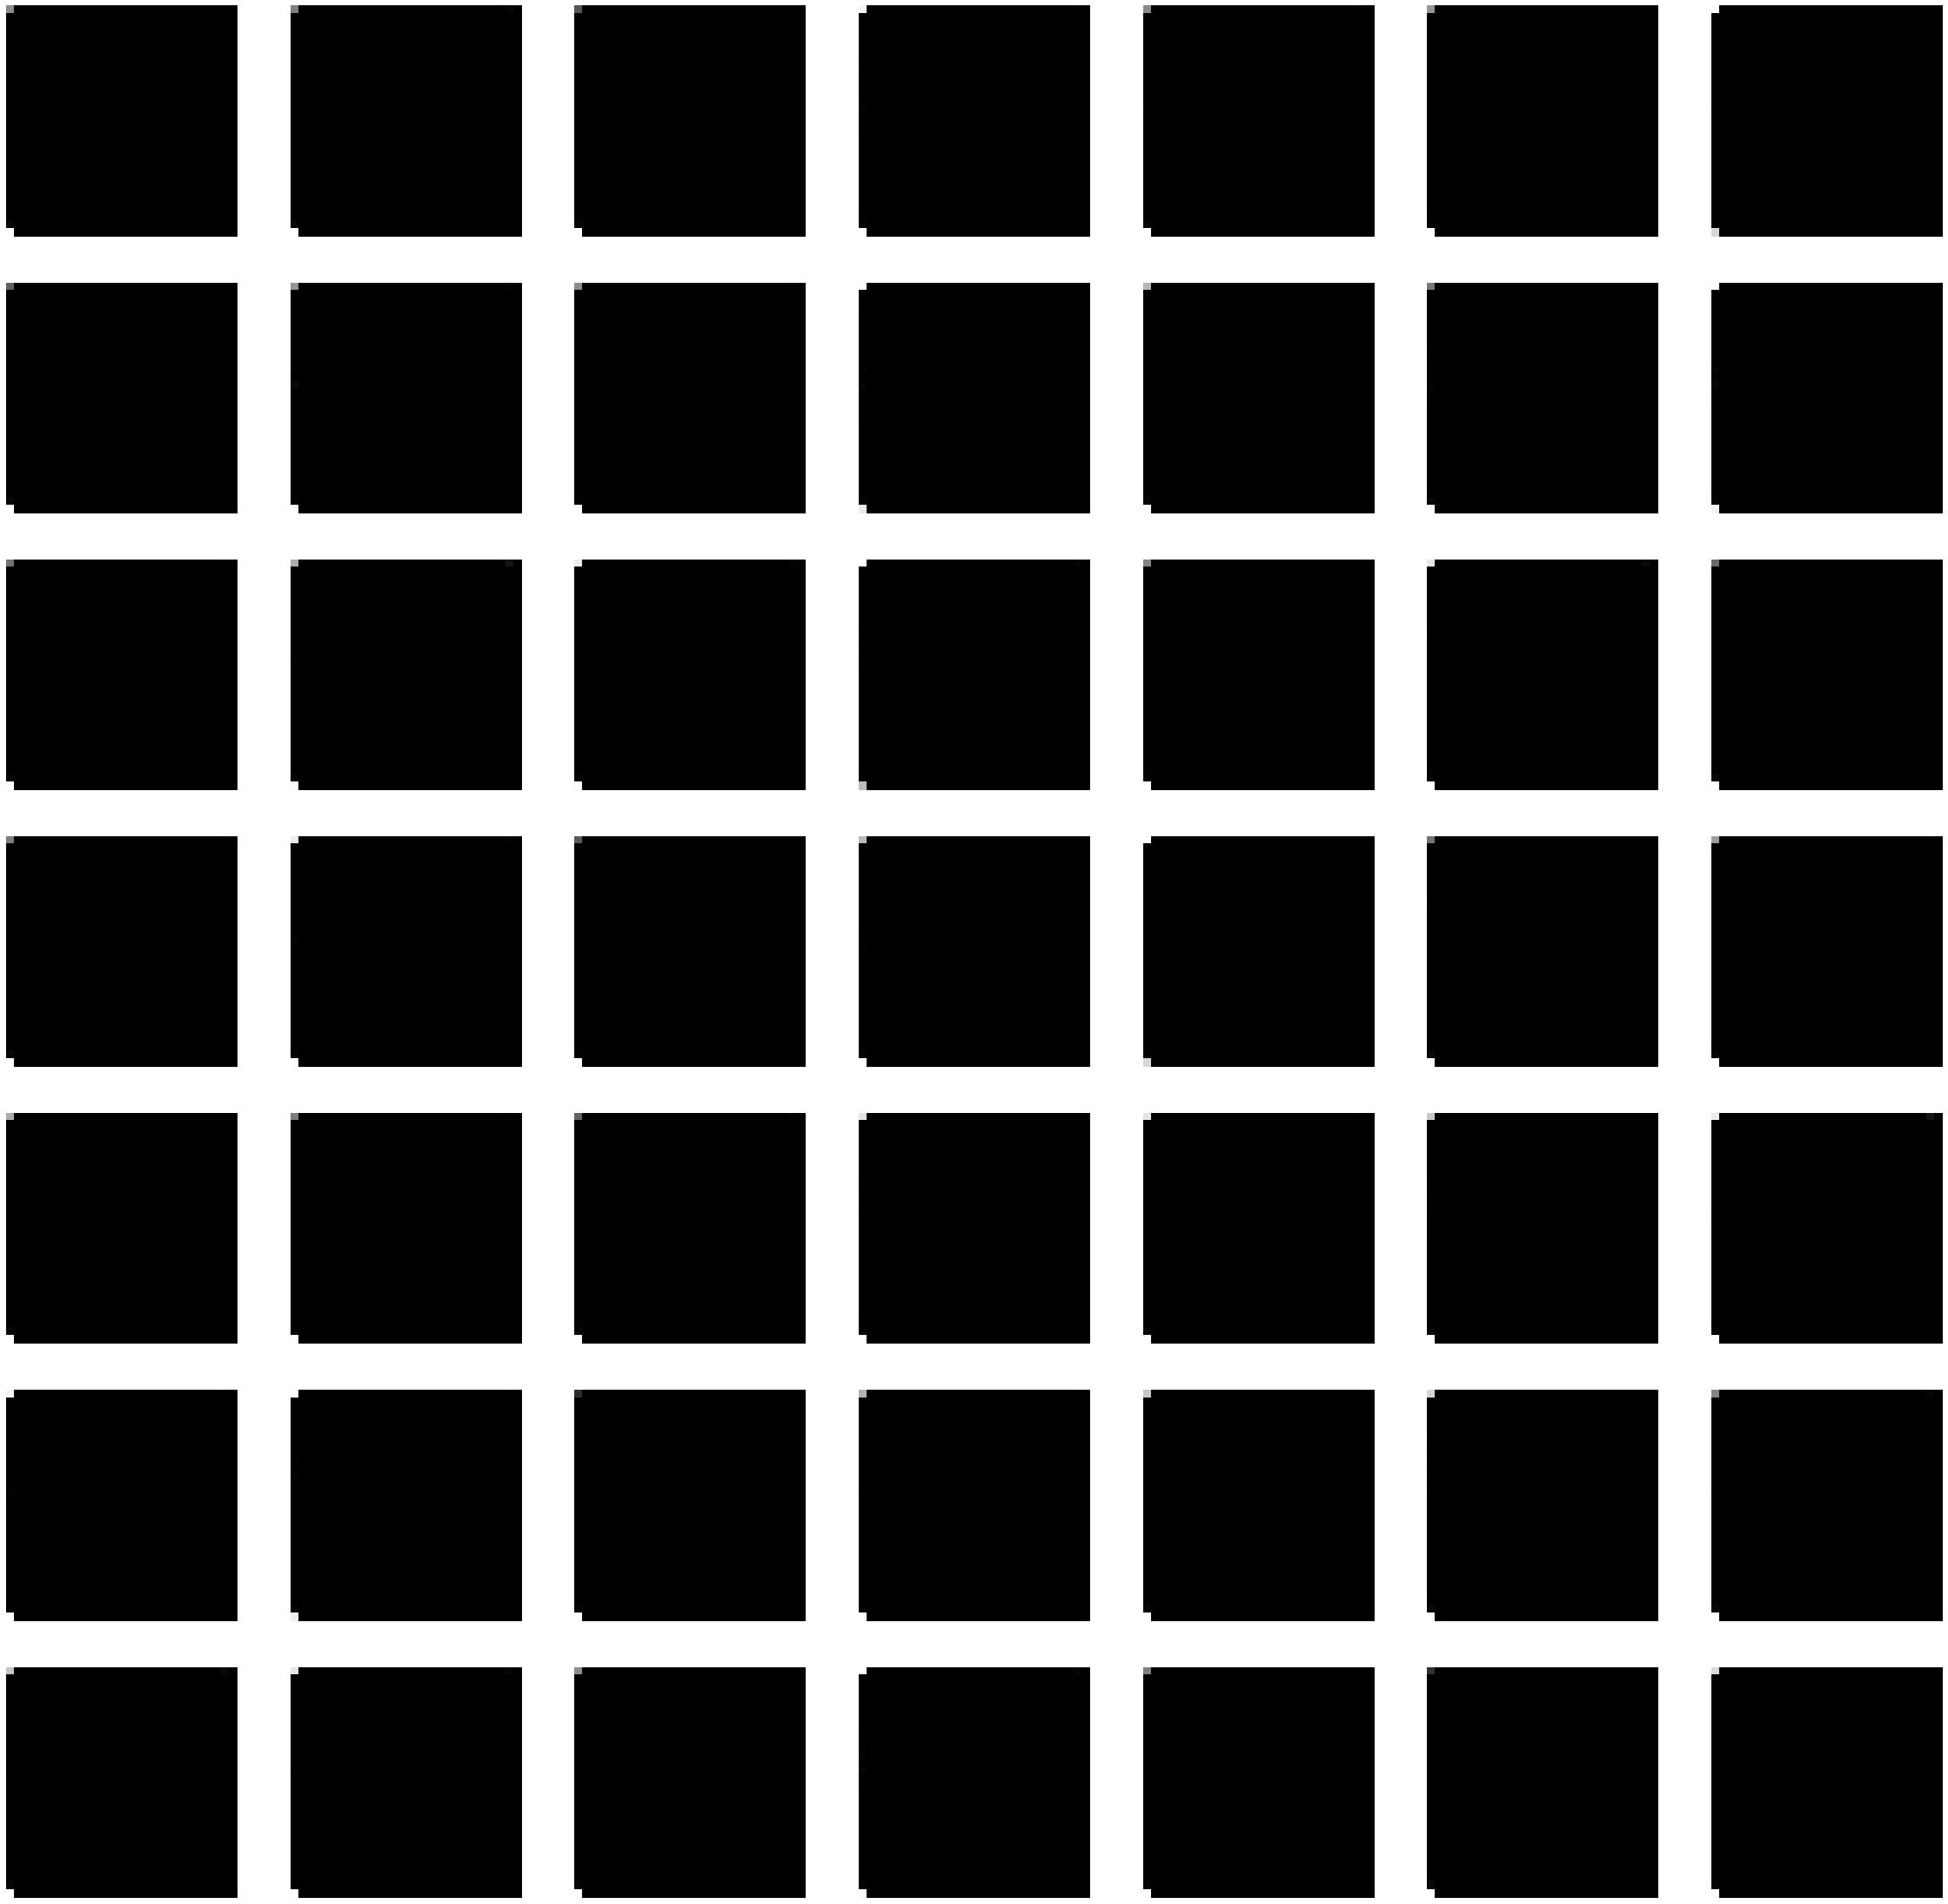

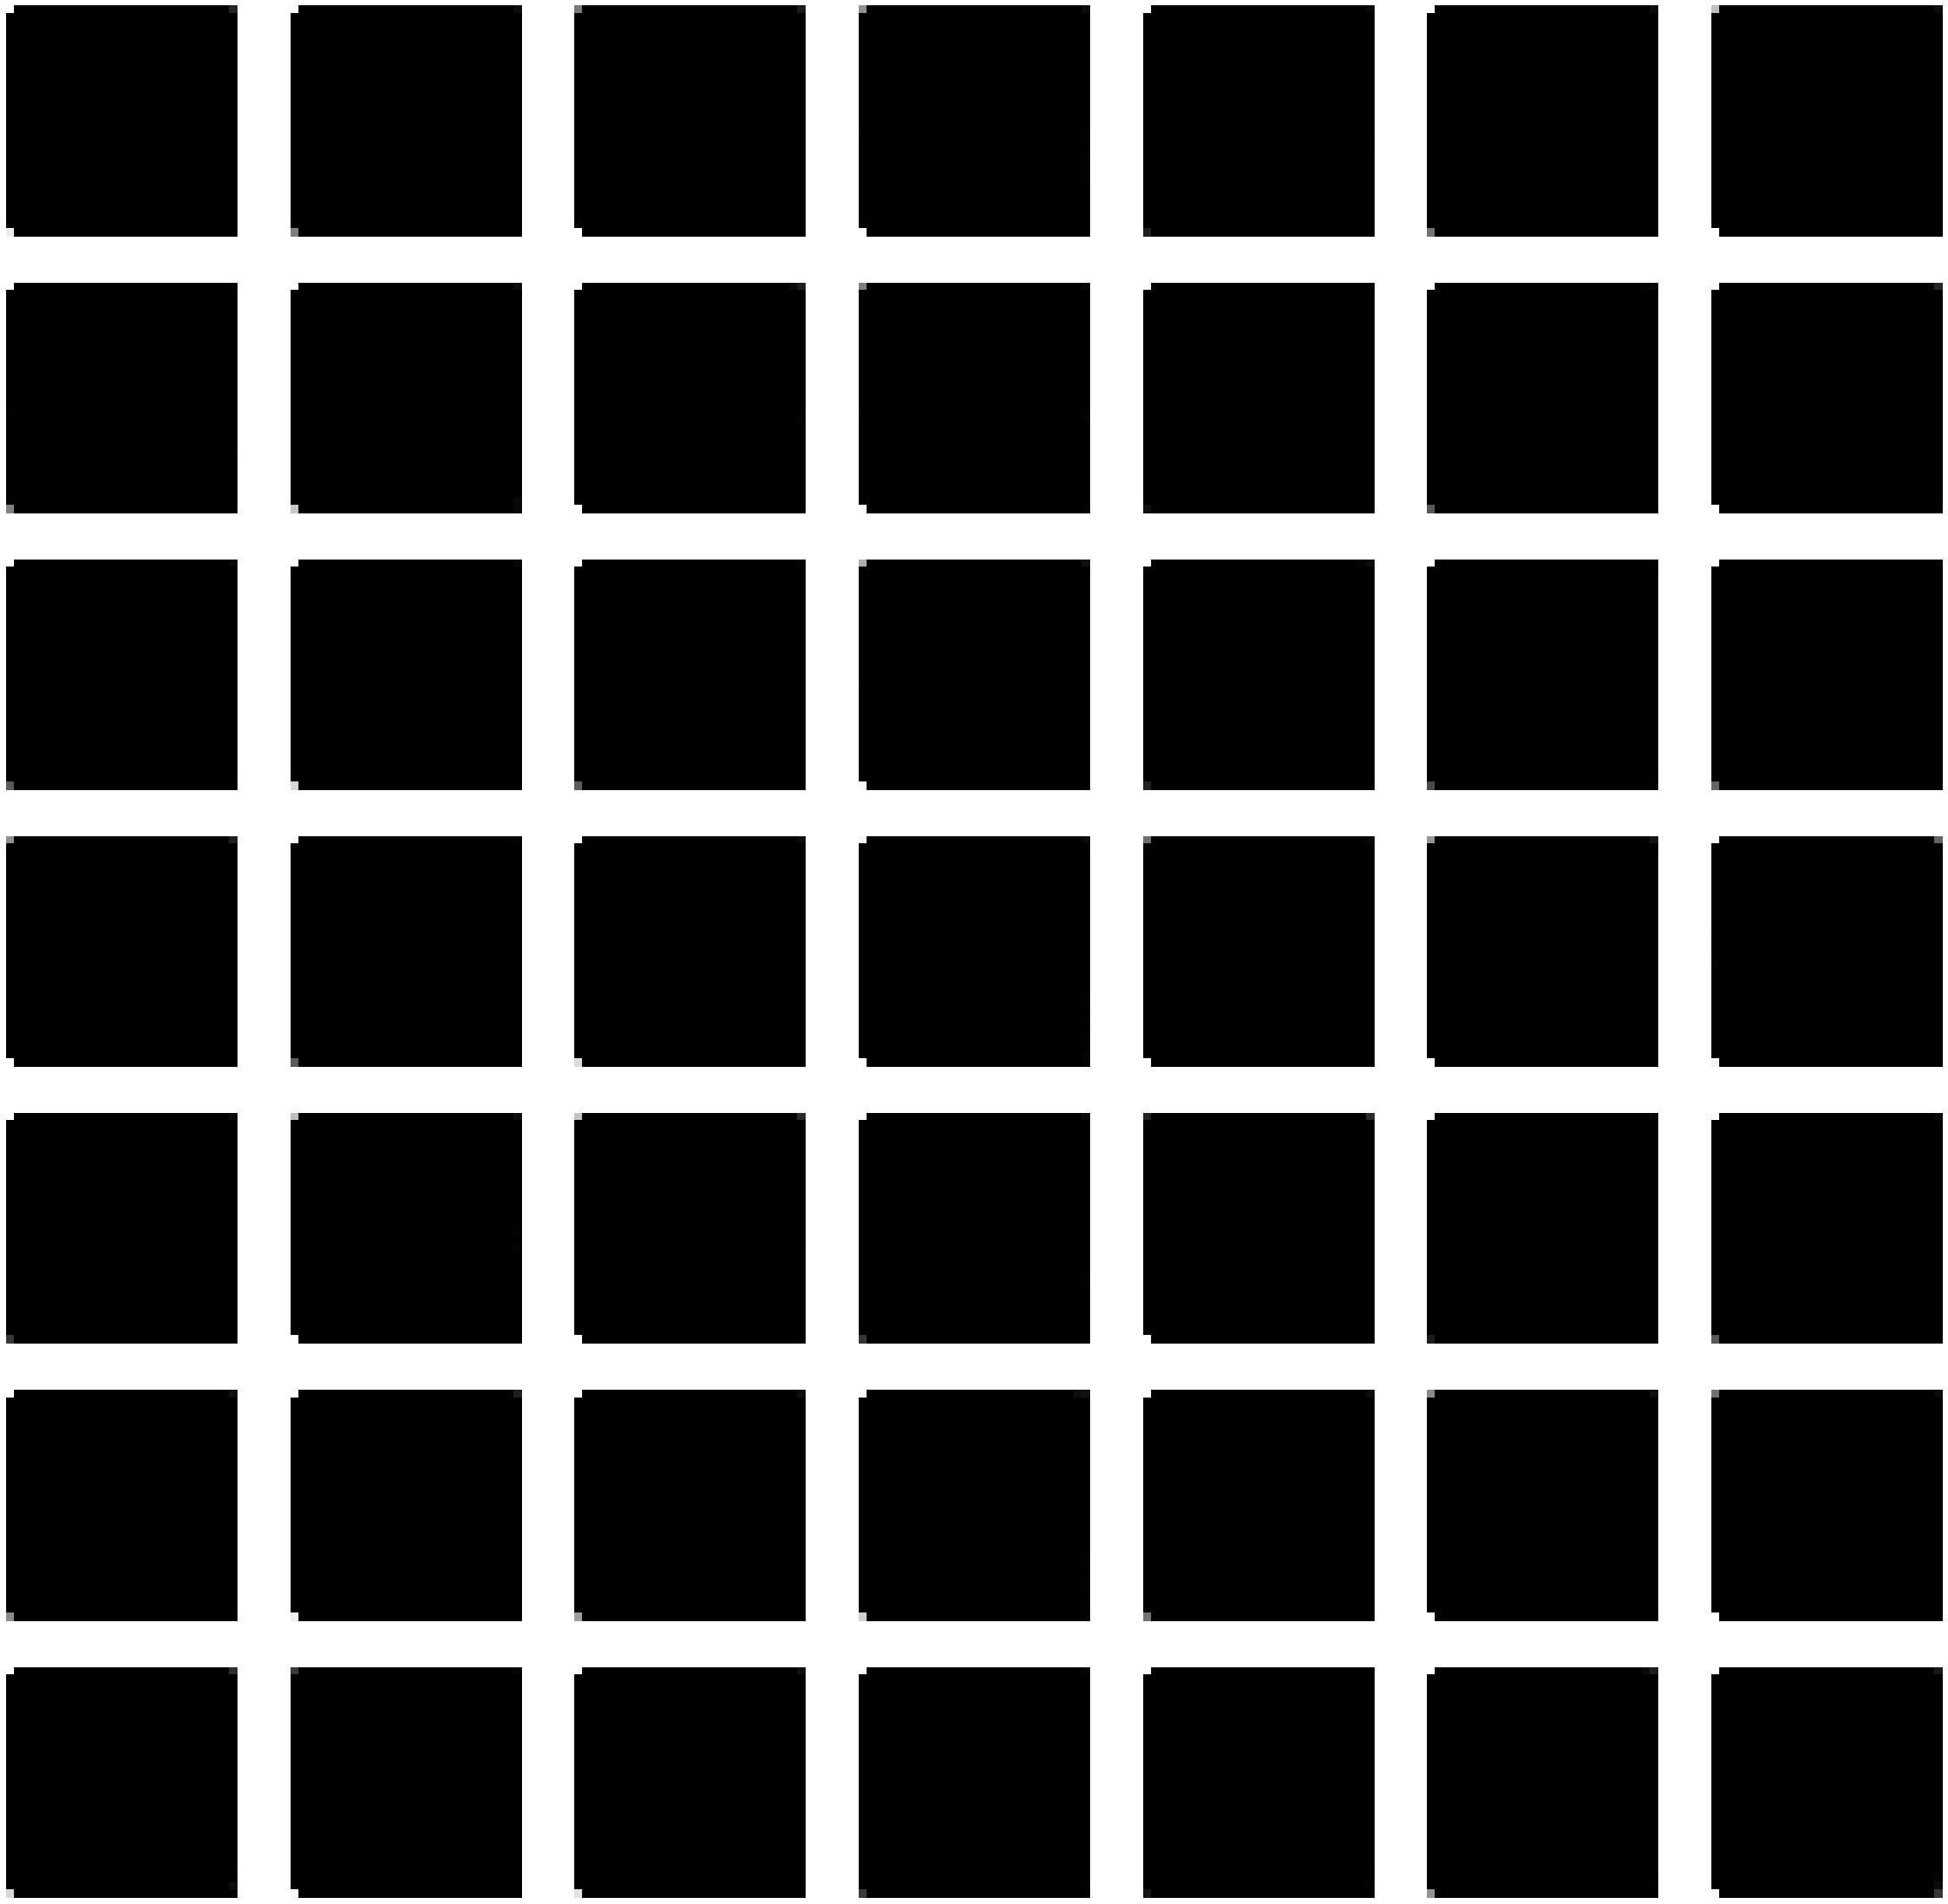

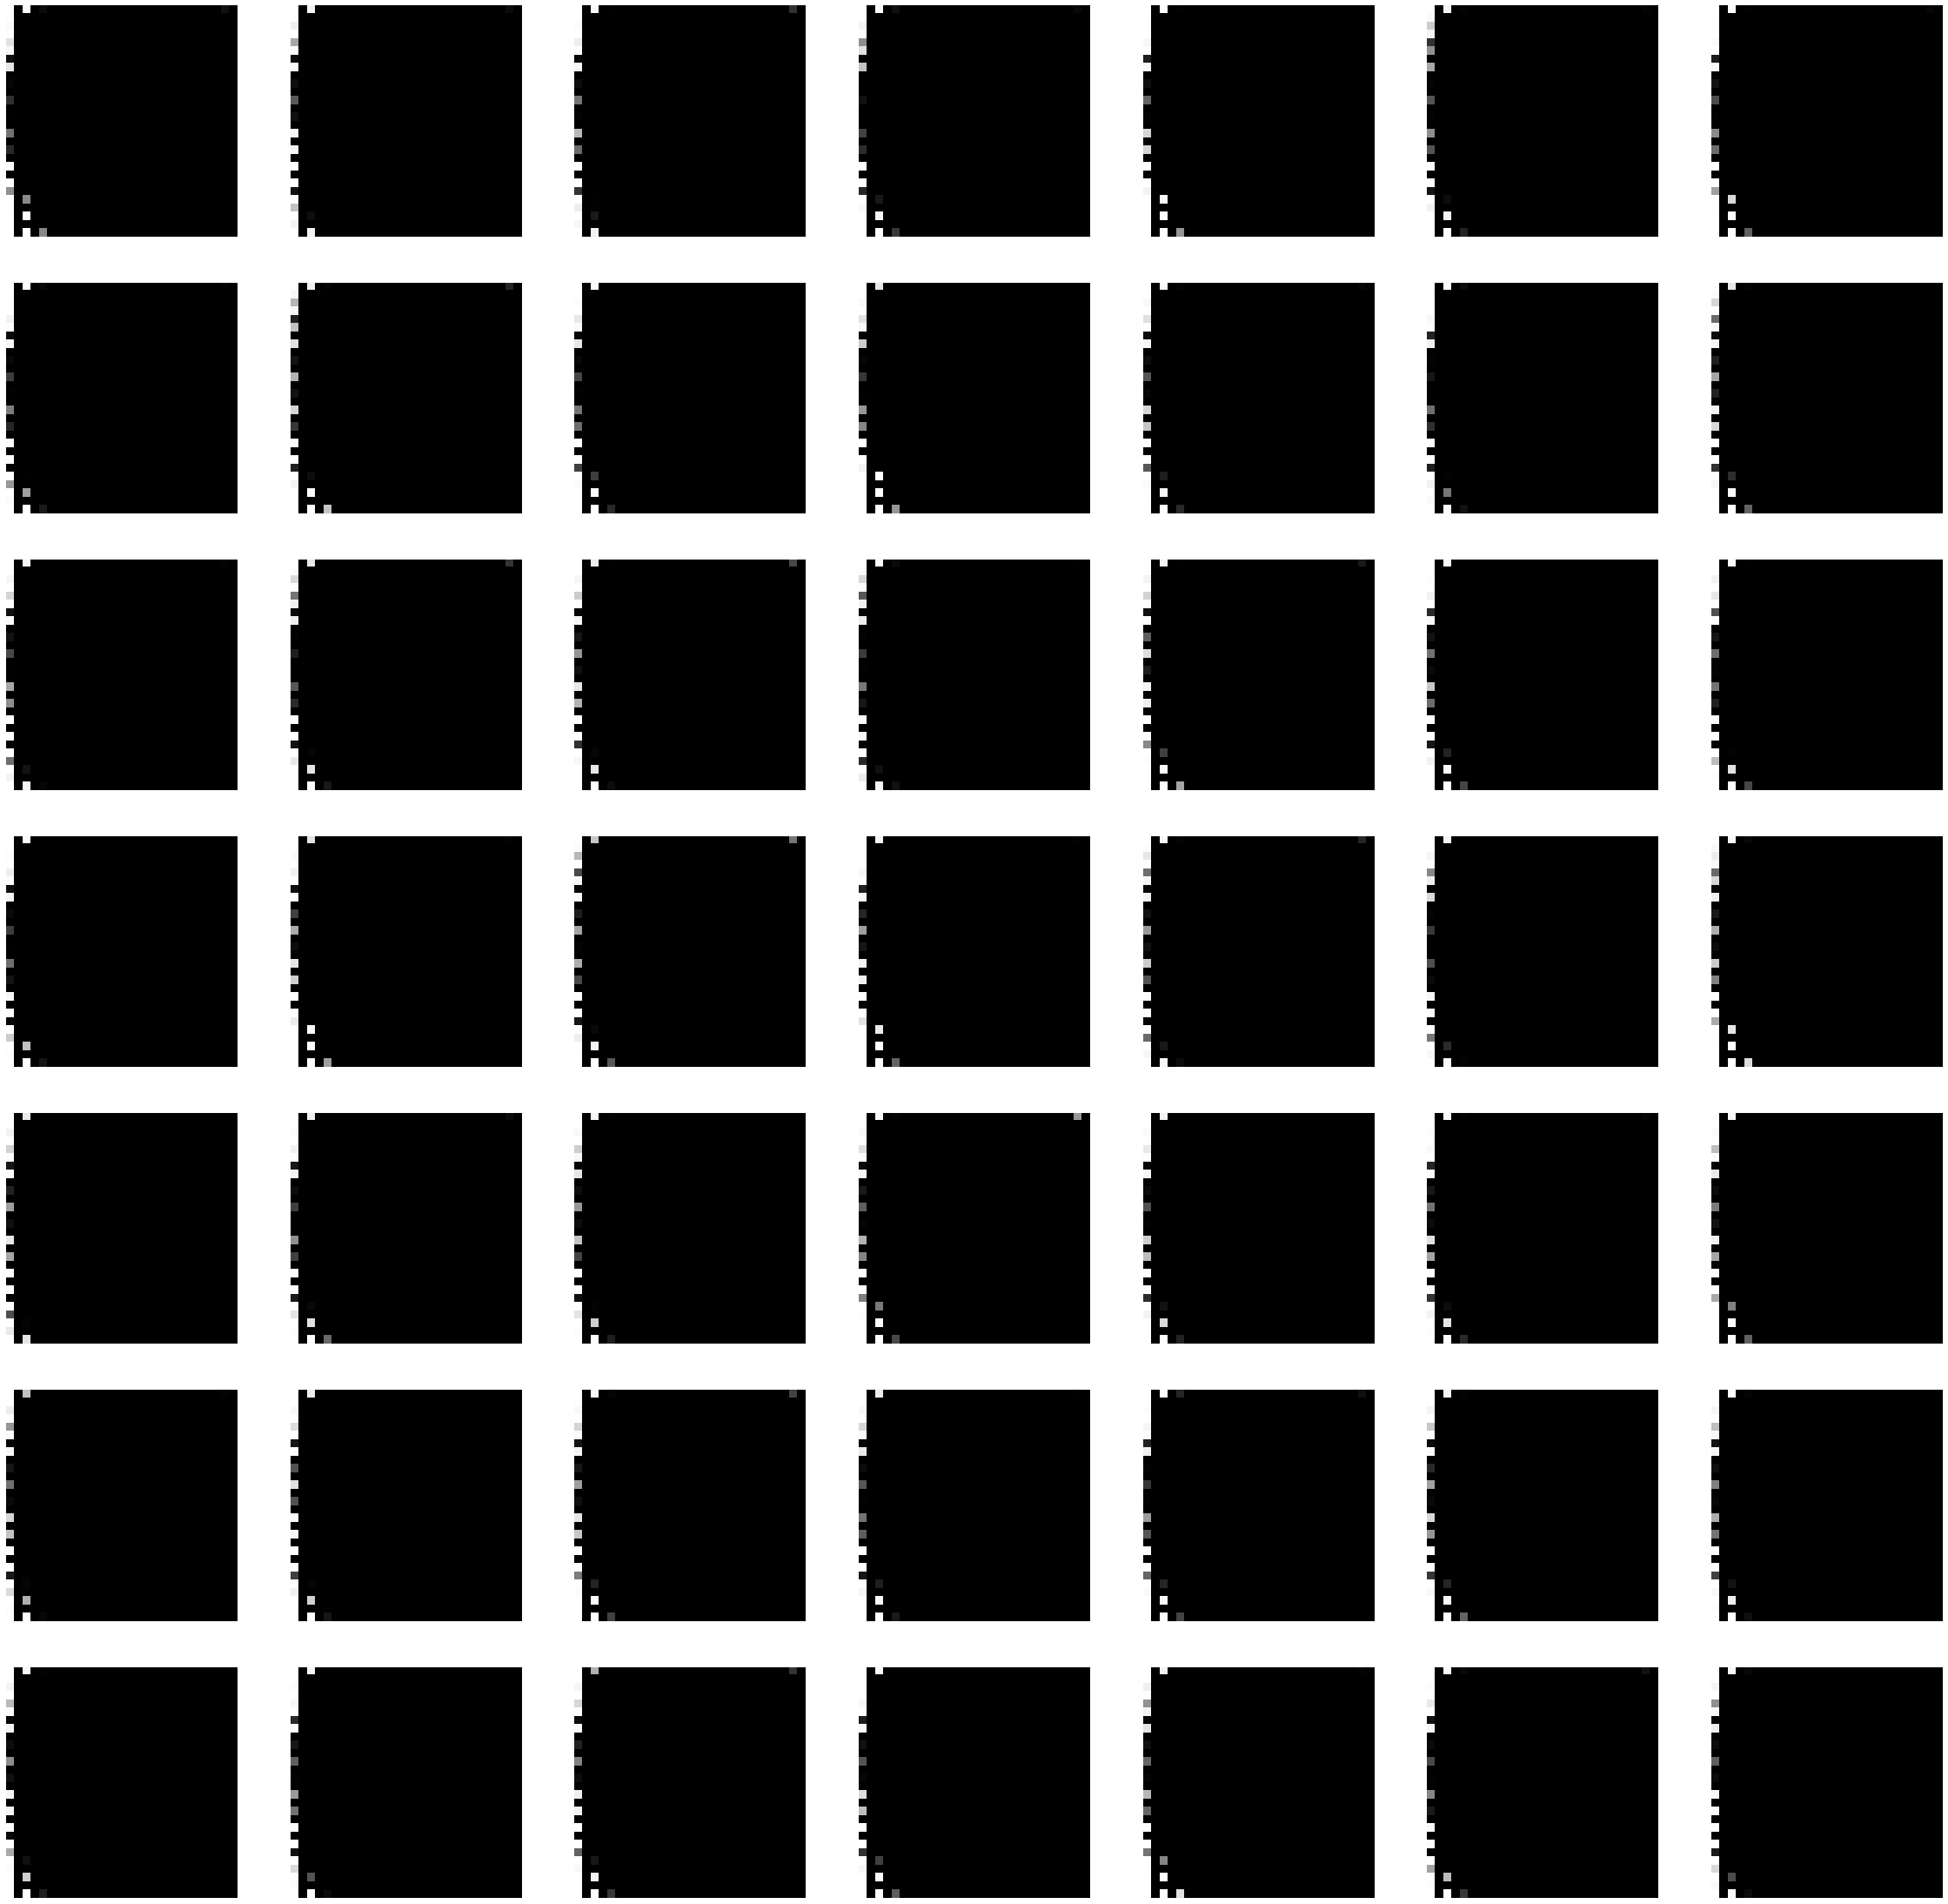

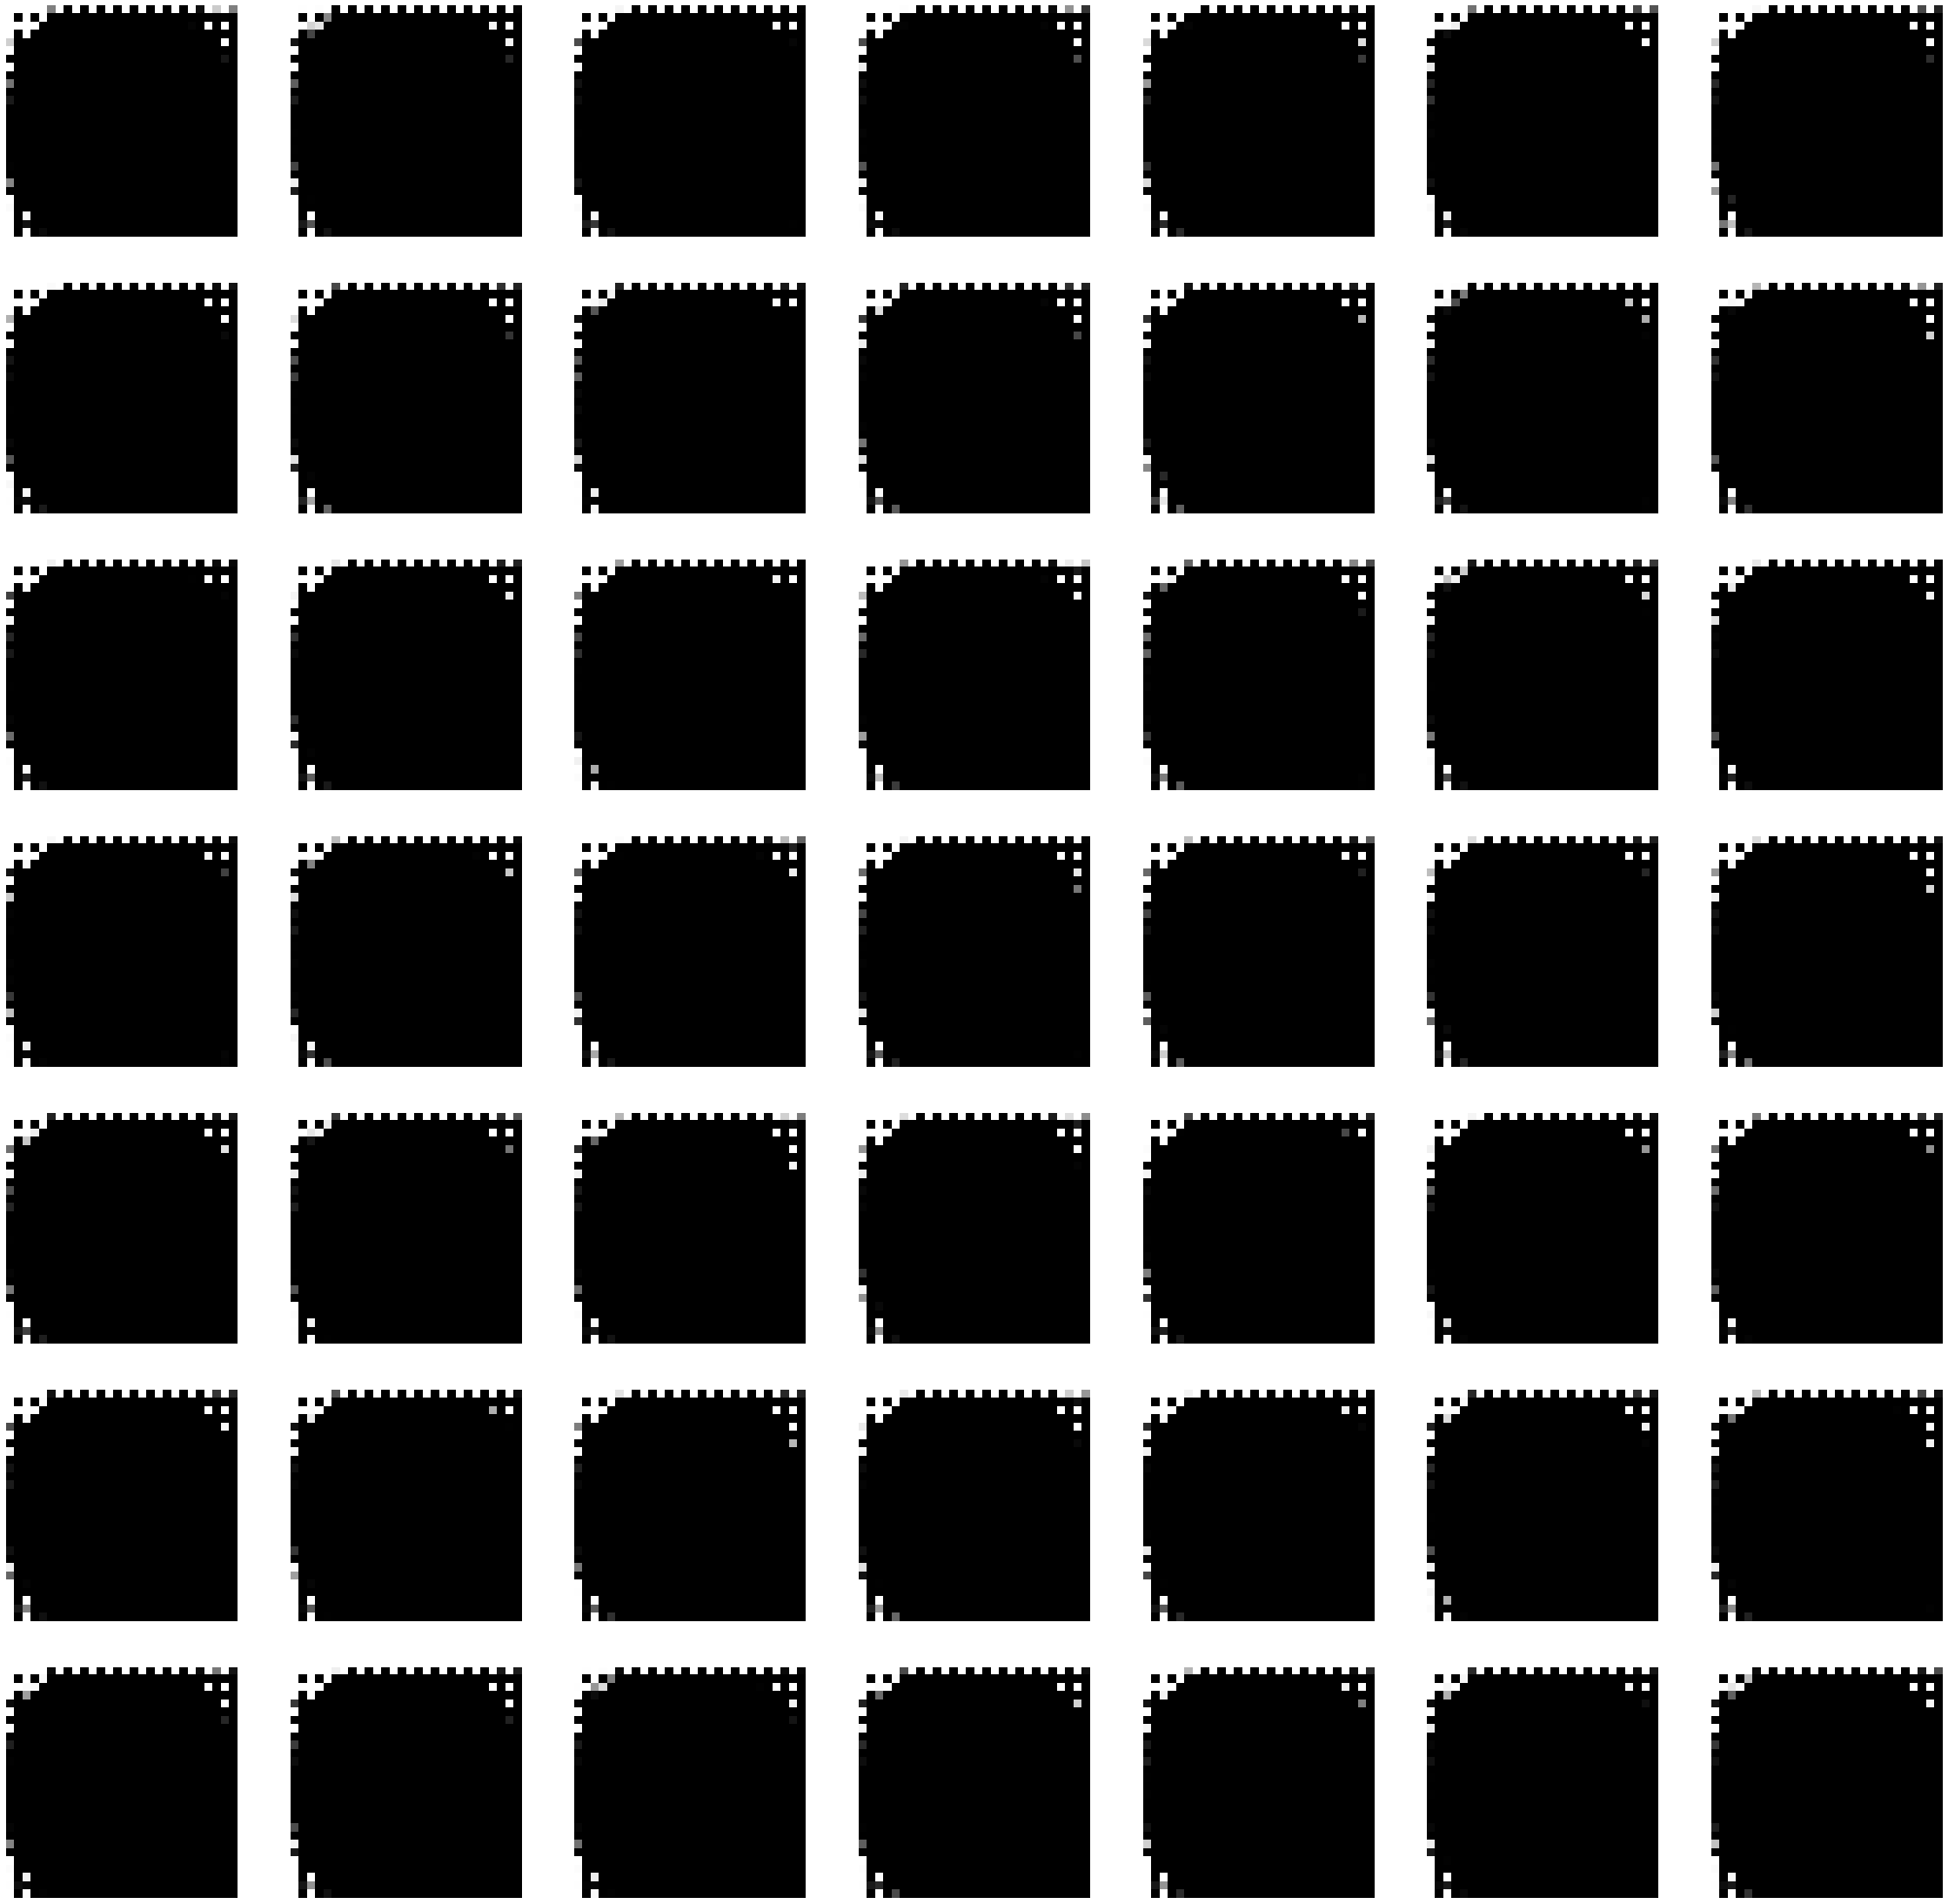

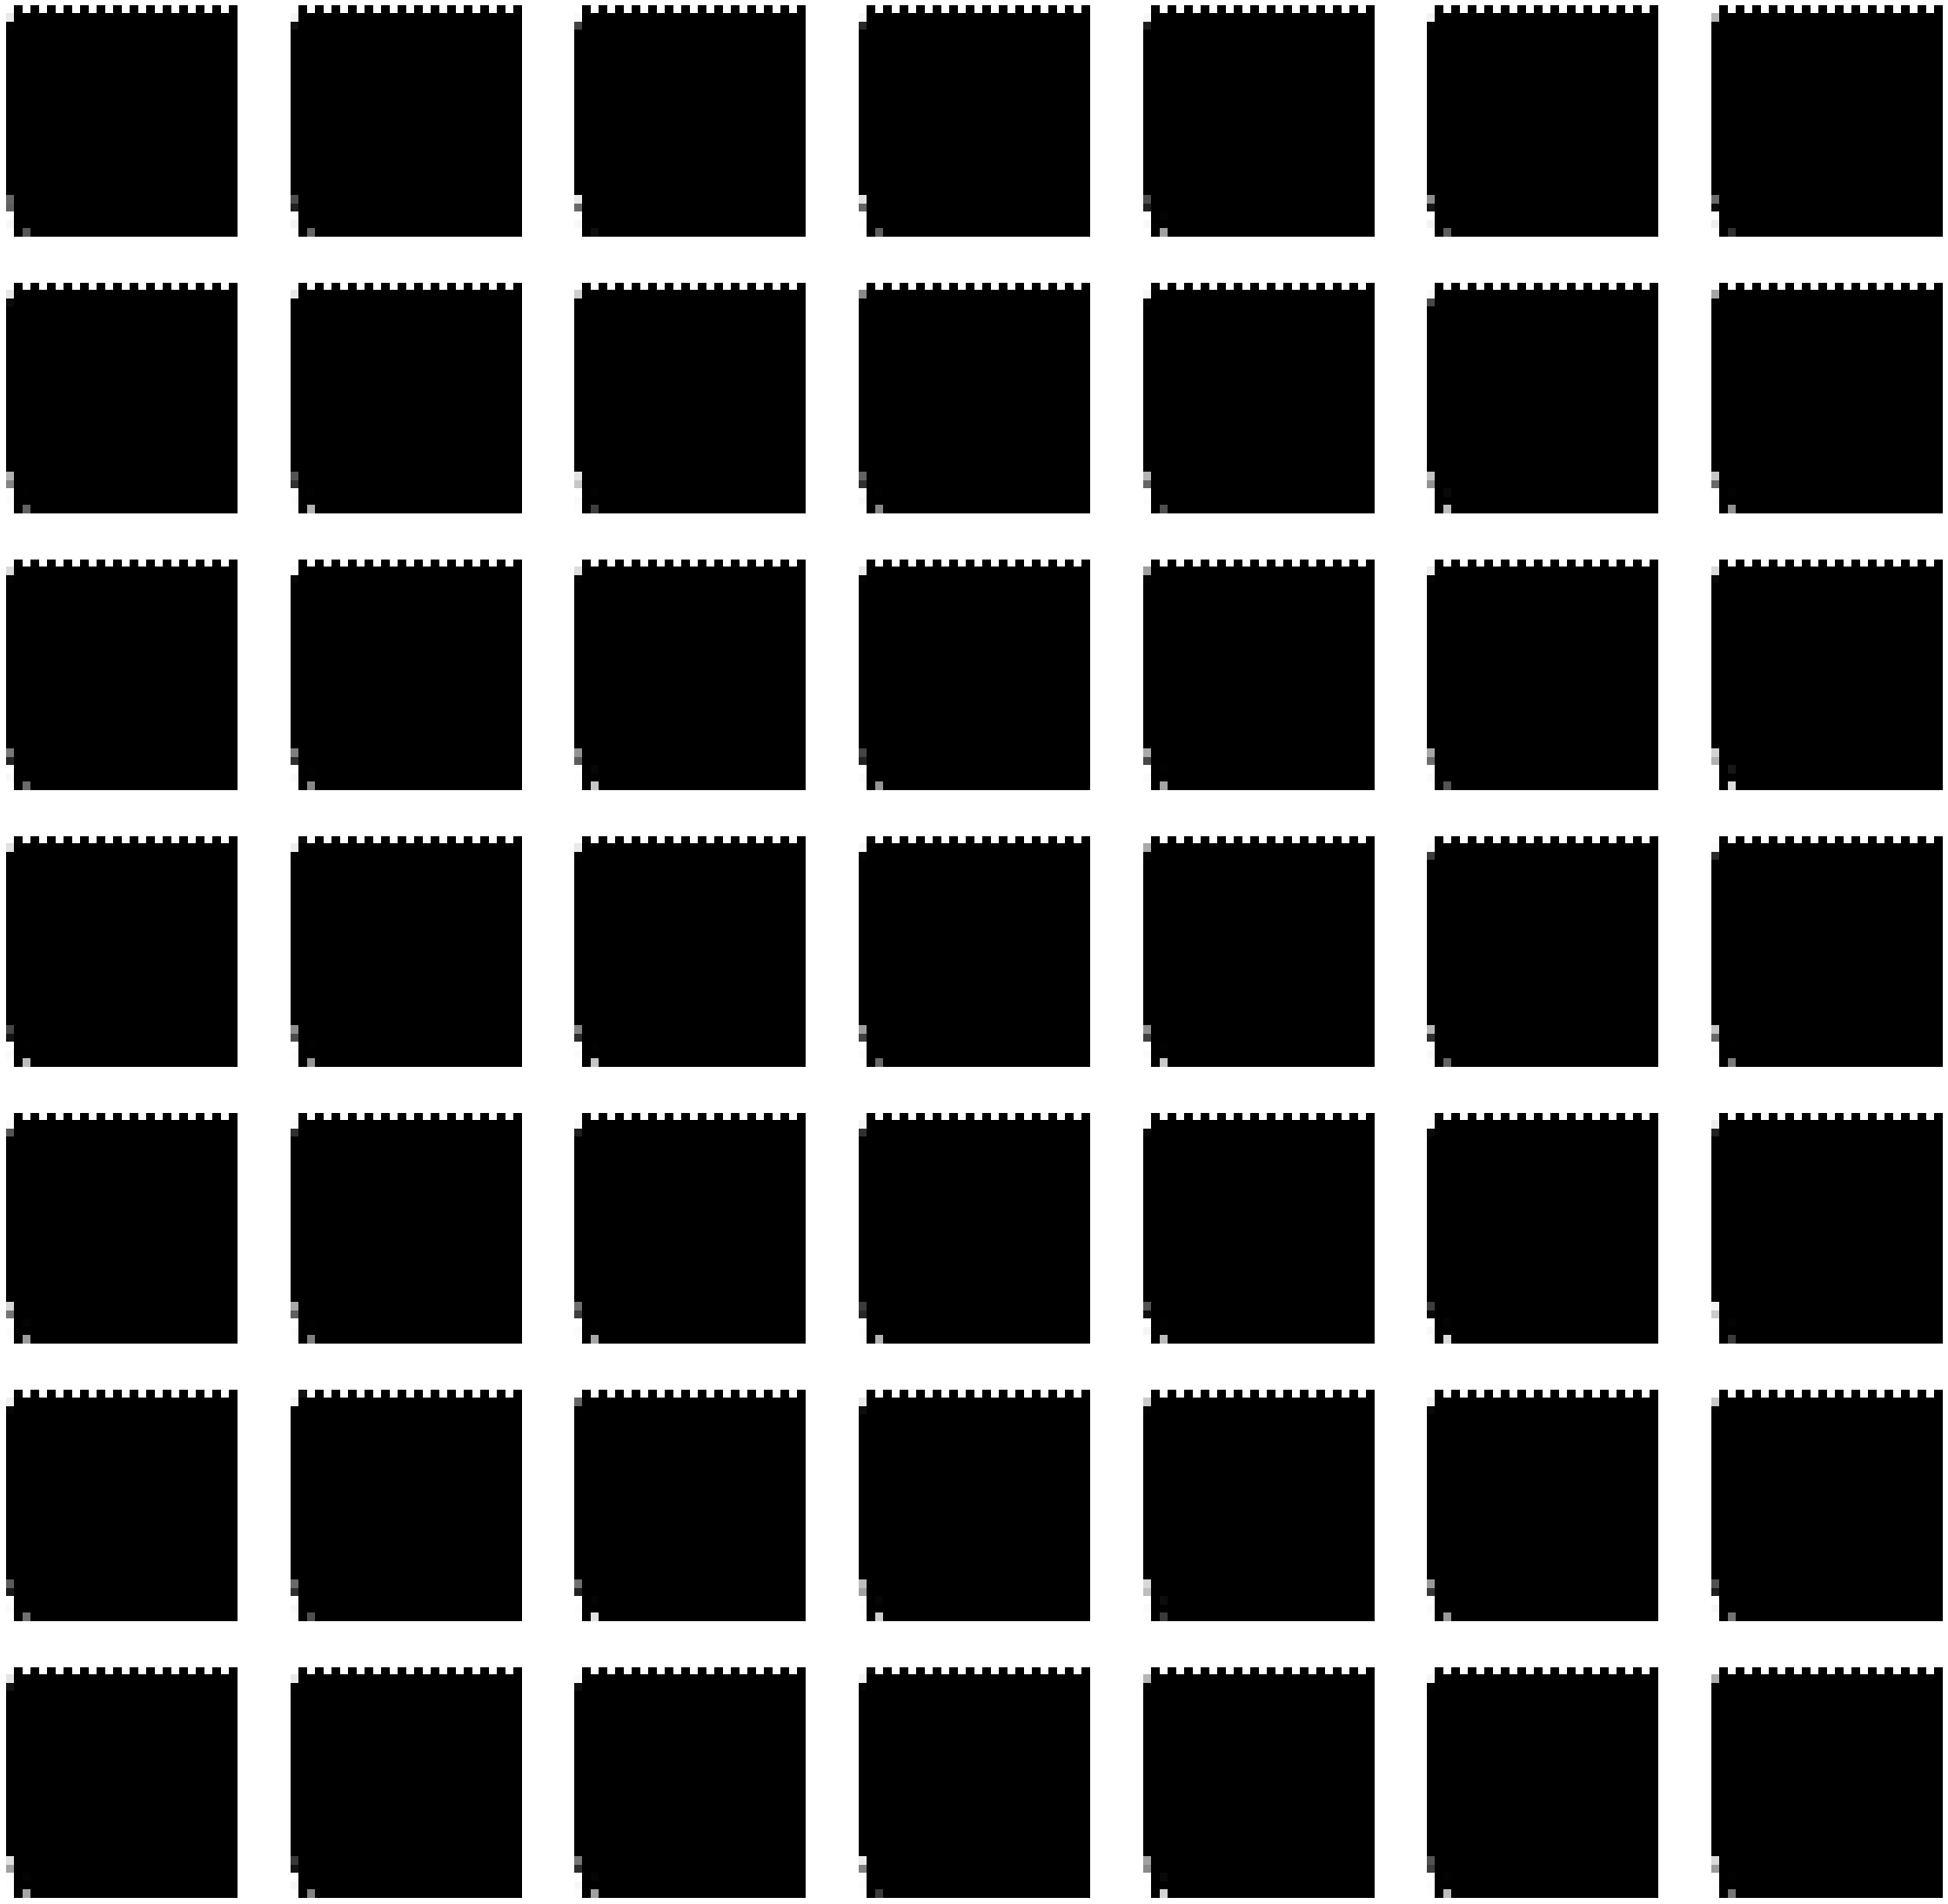

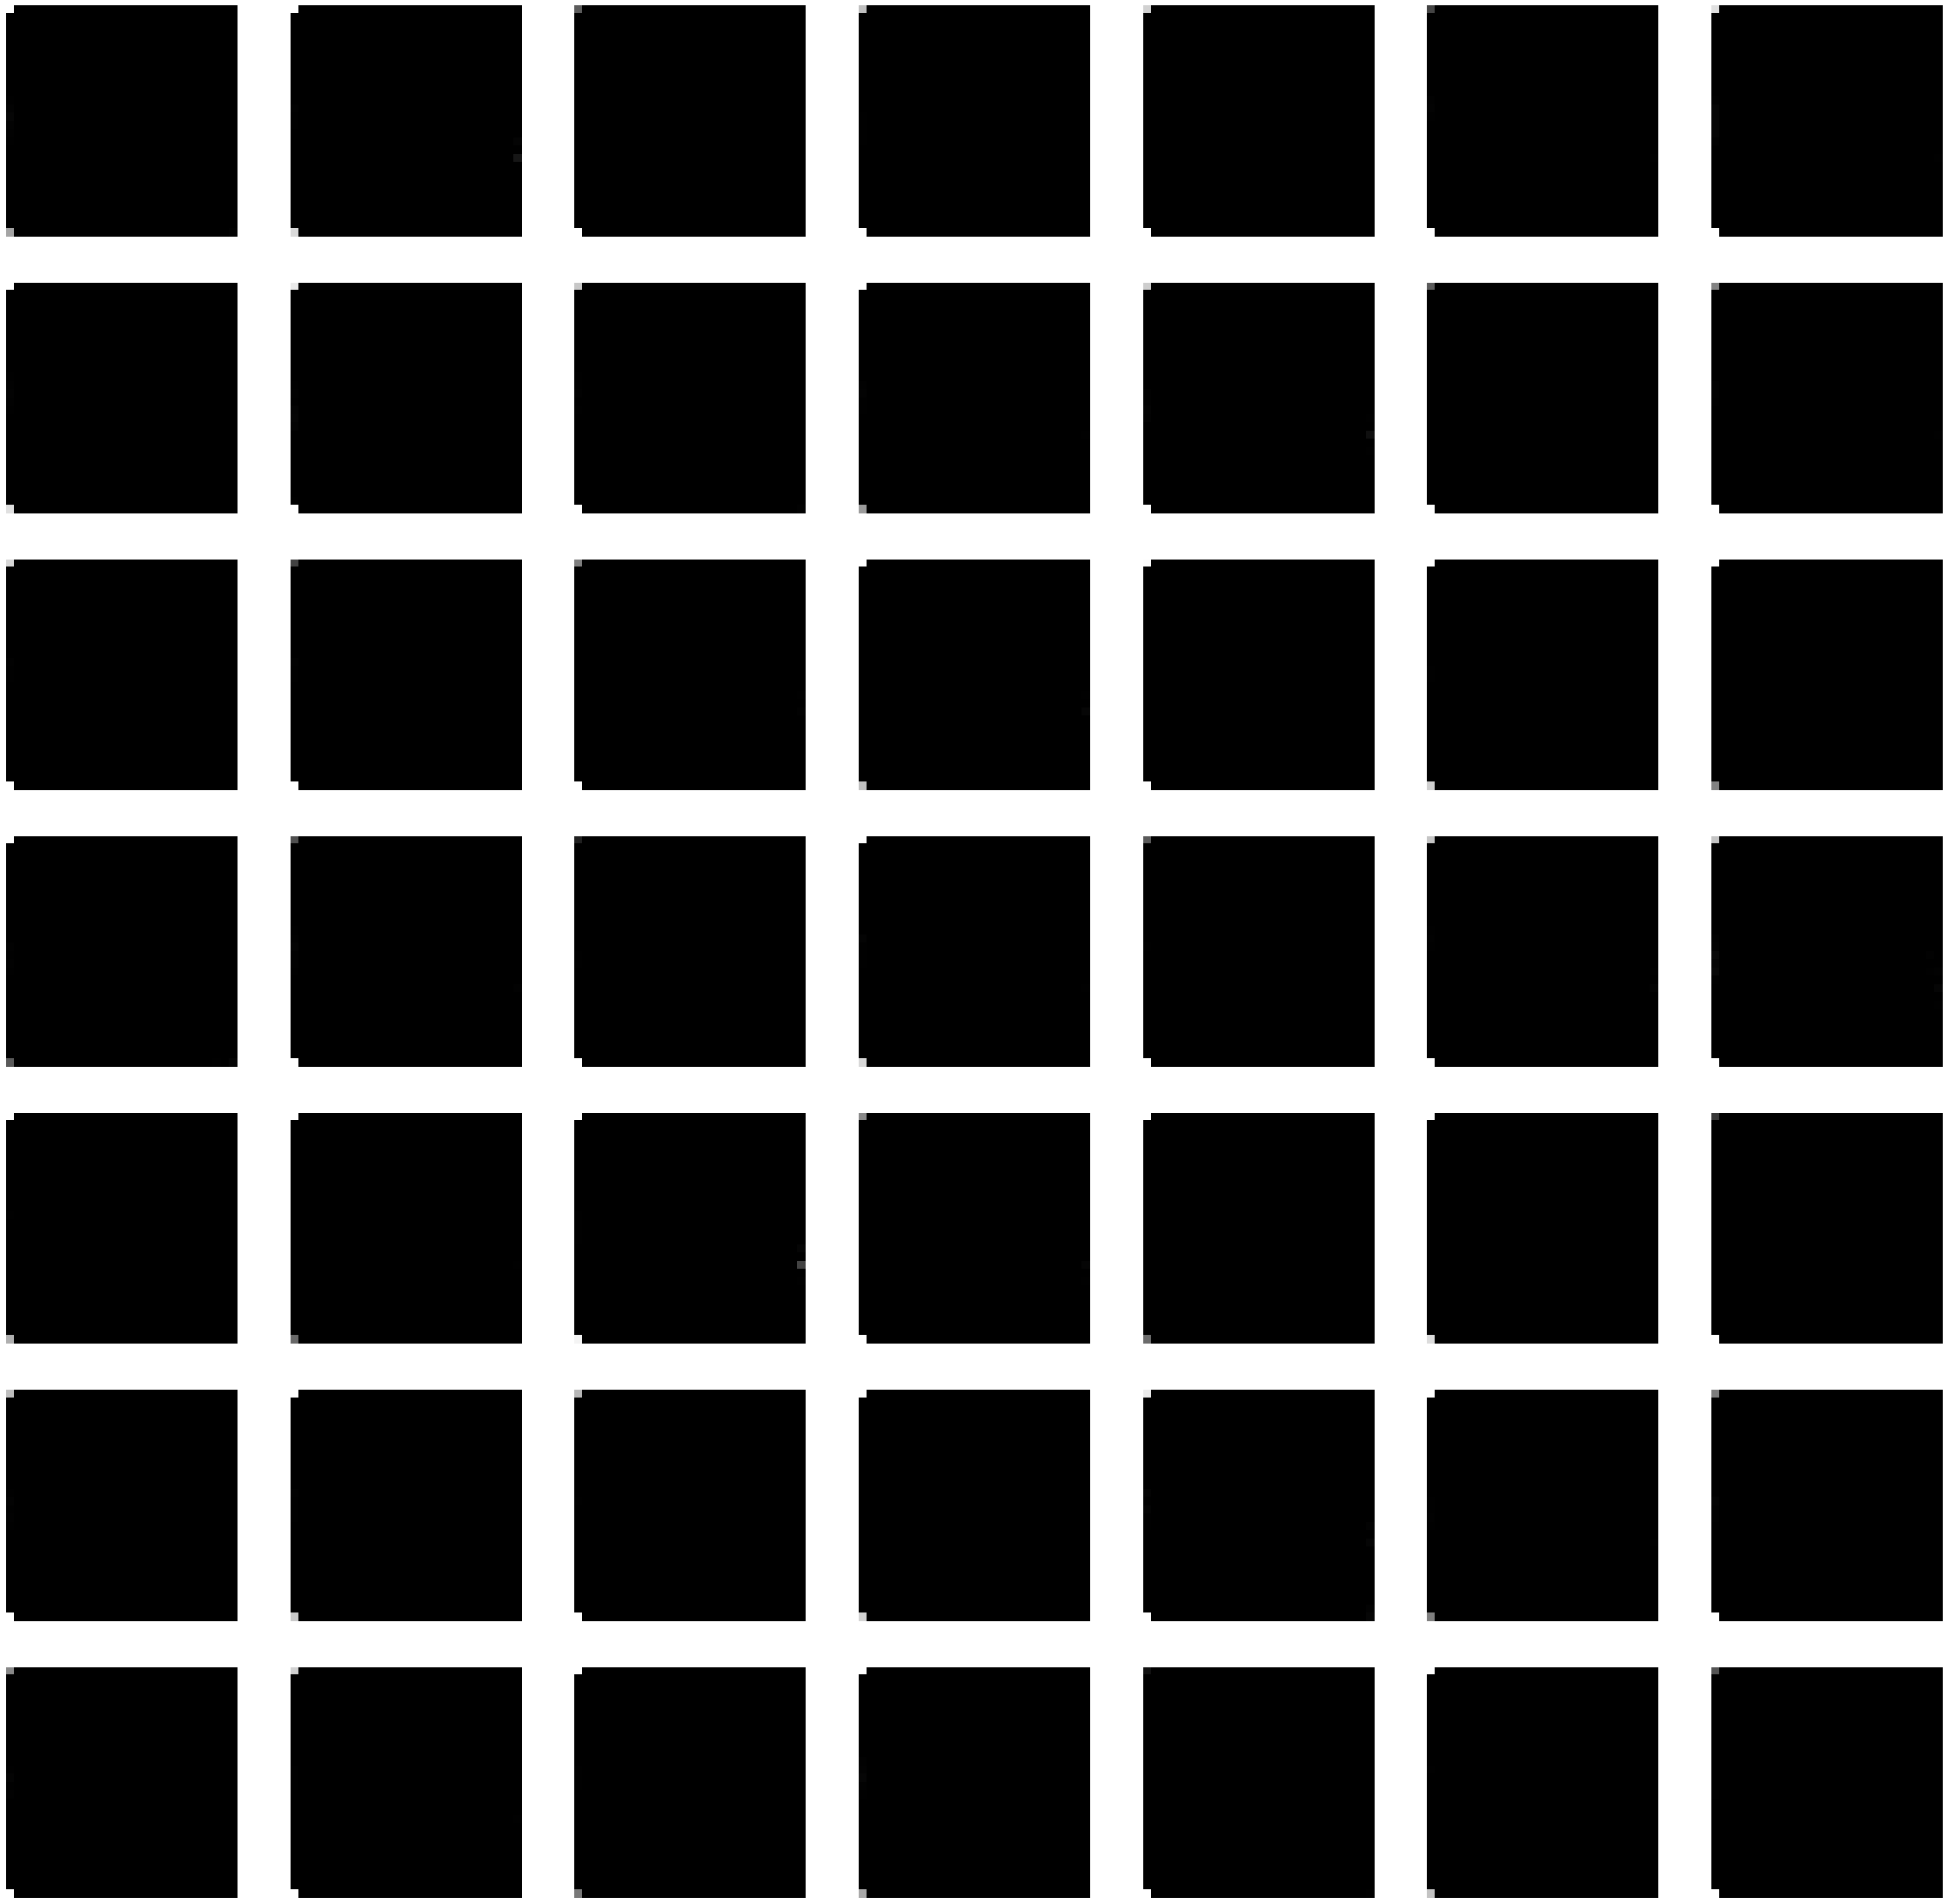

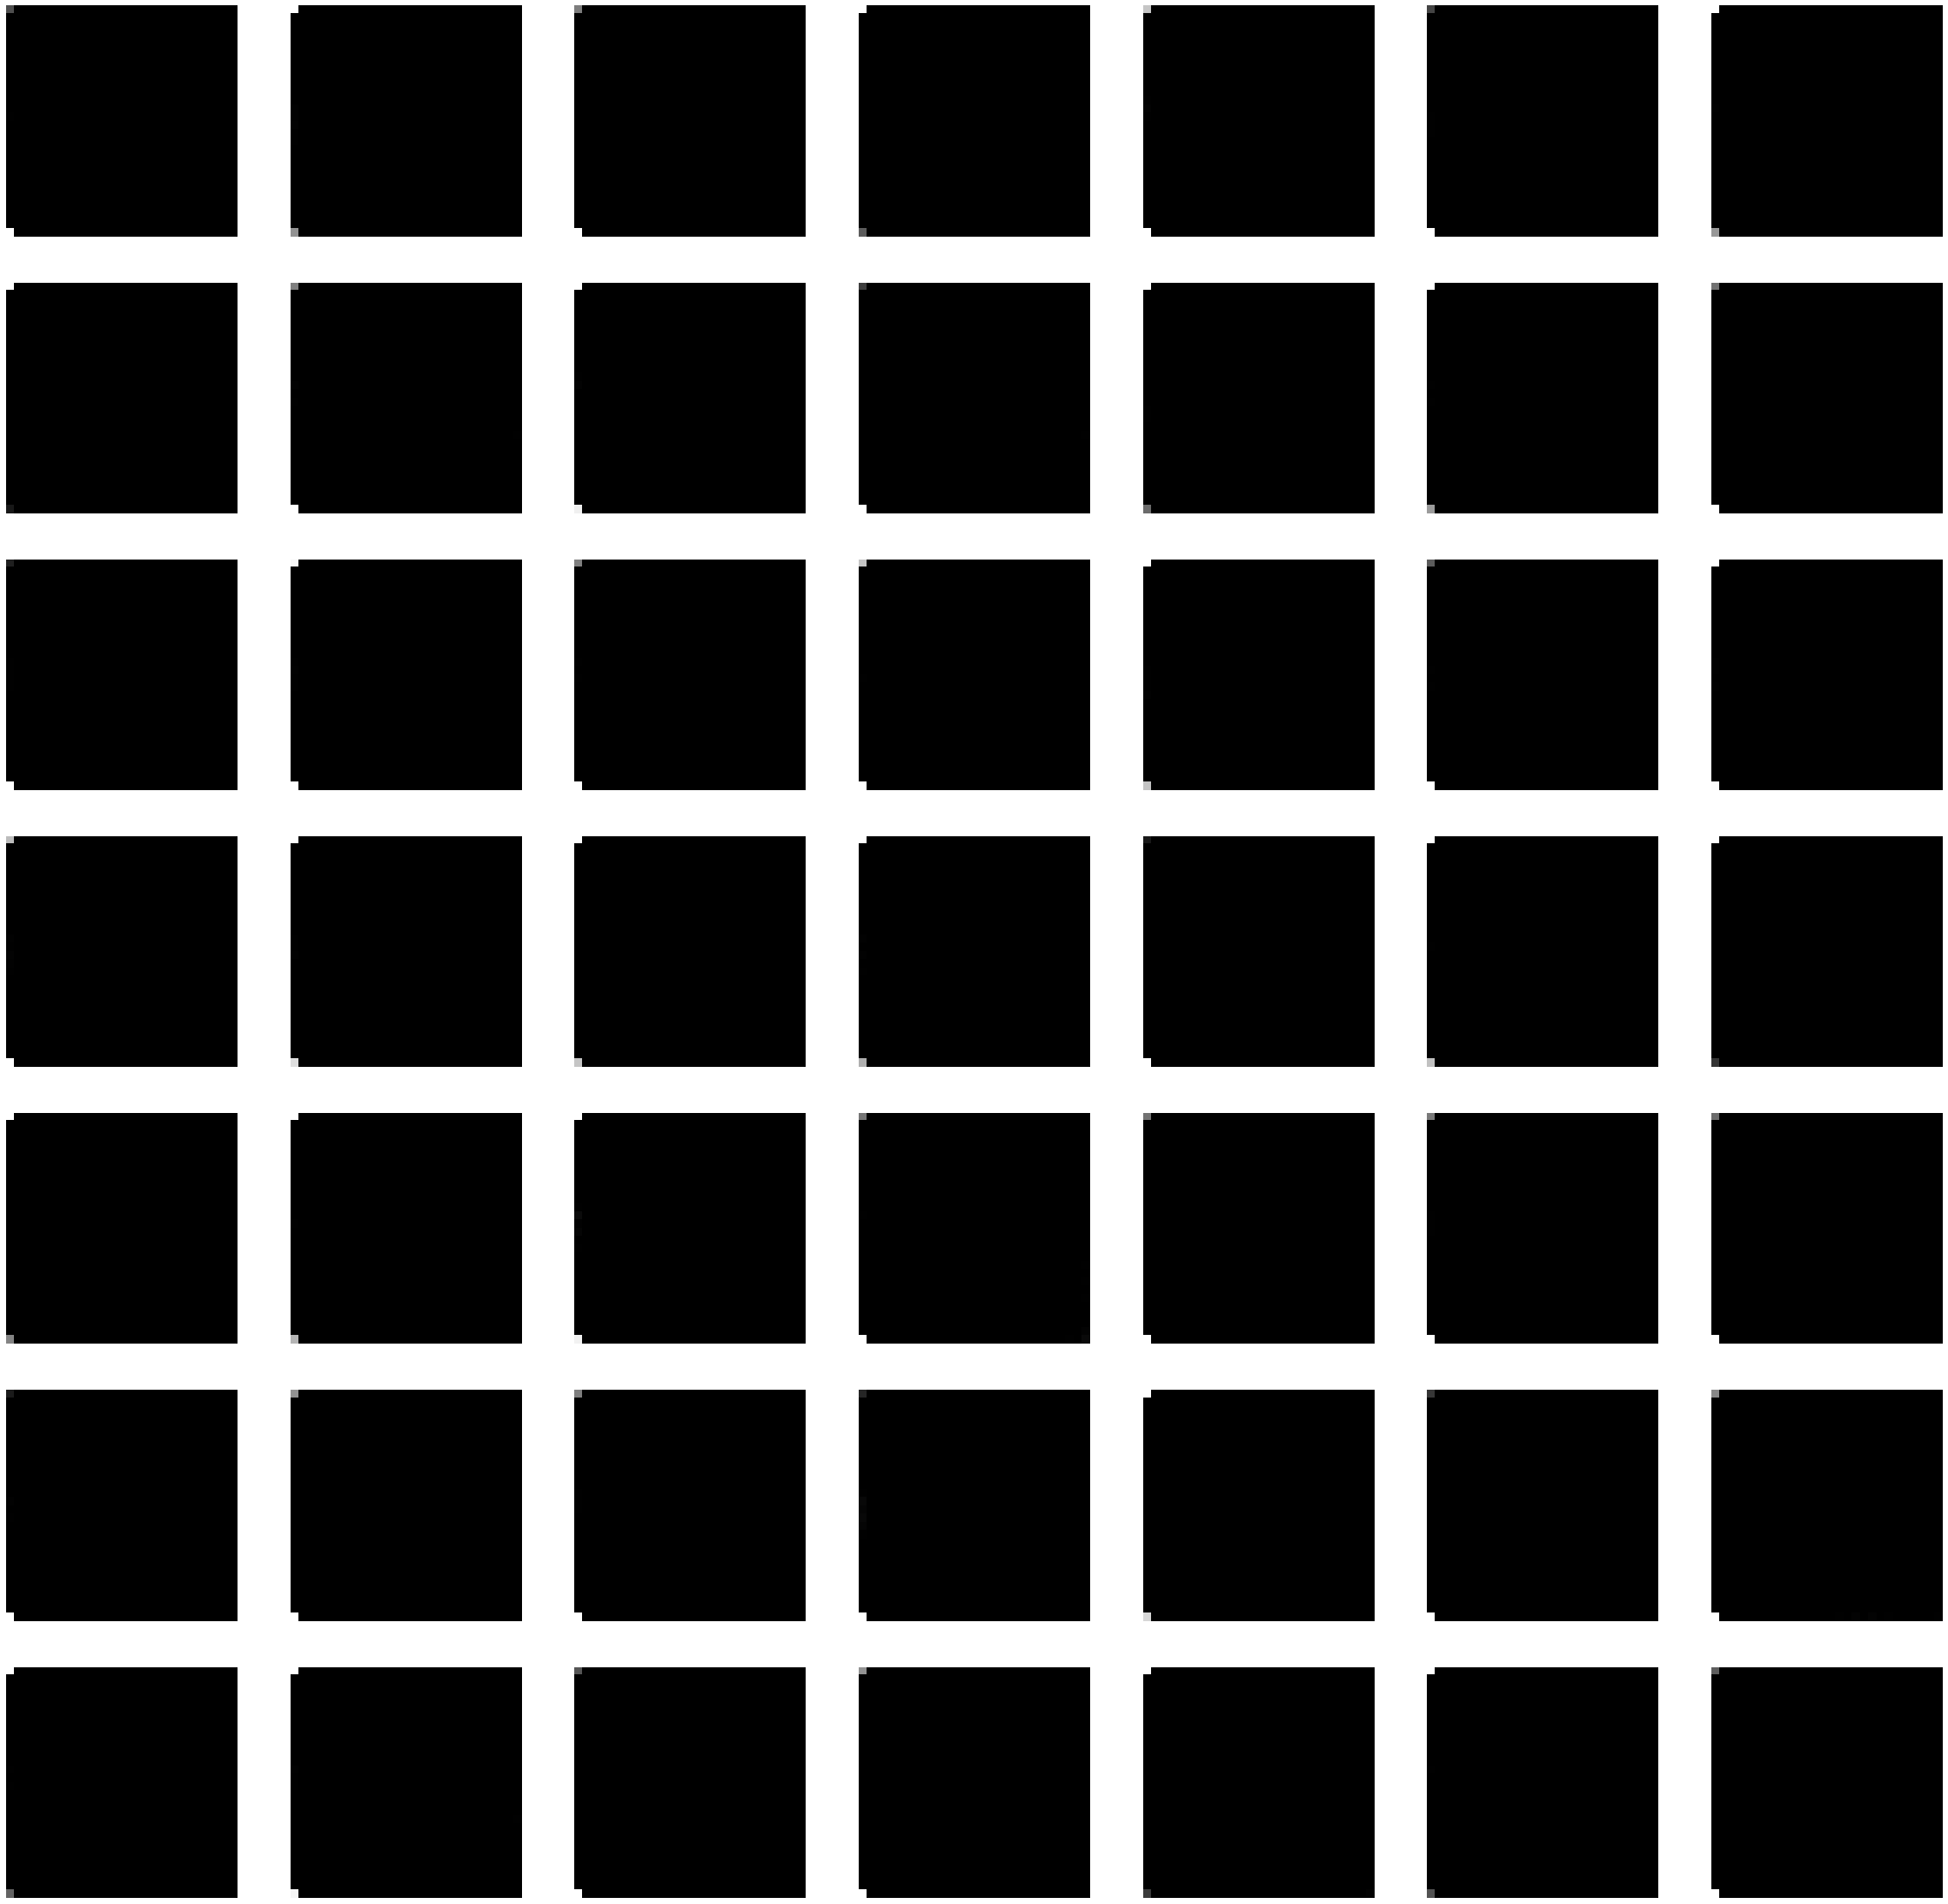

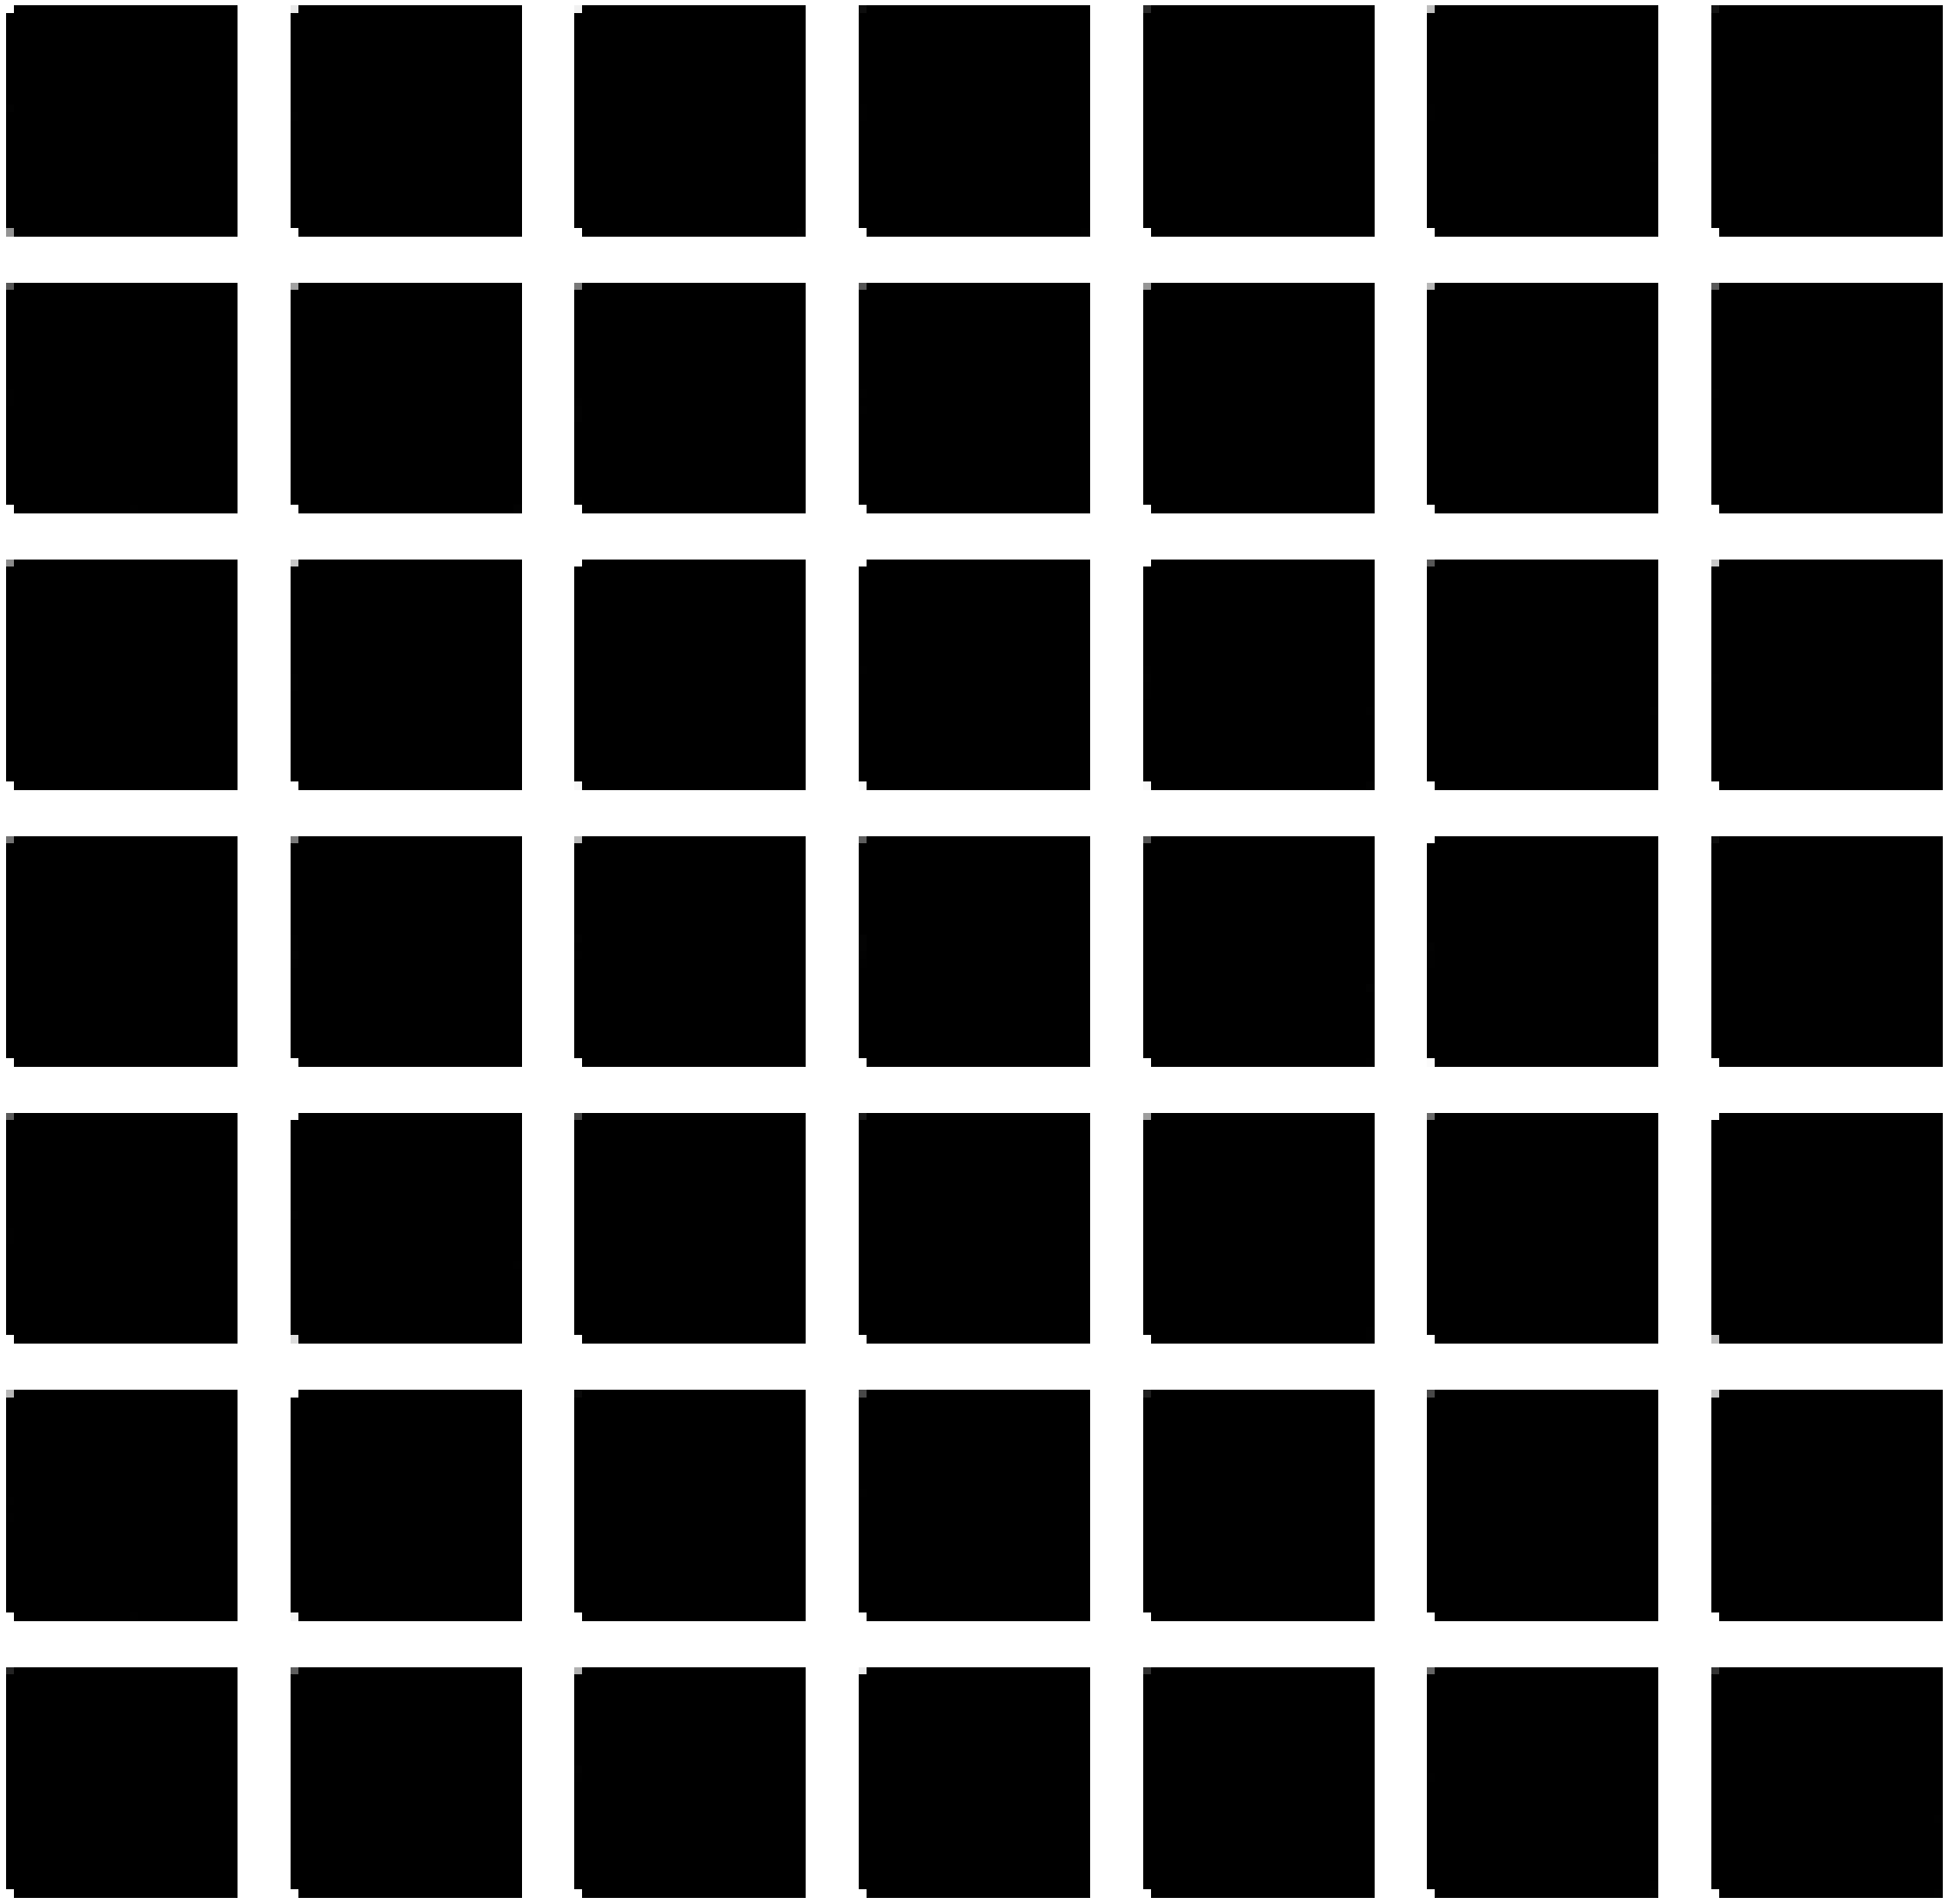

In [18]:
# train model
train(g_model, d_model, gan_model, x, latent_dim, n_epochs=900, n_batch = 64)